In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/home/purzelrakete/src/github.com


In [2]:
from pathlib import Path
import os
import pprint

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz, debug

In [3]:
pp = pprint.PrettyPrinter(indent=2)

# Train on Maestro

In [4]:
# this cell contains papermill tagged parameters
# they can be overriden by the cli when training:  
# papermill in.ipynb out.ipynb -p batch_norm True

batch_norm = False
learning_rate = 0.0044
batch_size = 12
max_epochs = 2

In [5]:
# Parameters
batch_size = 24
learning_rate = 0.005


In [6]:
# automatically scale up the learning rate when using batch norm
if batch_norm:
    learning_rate *= 5

In [7]:
p = model.HParams(
    embed_inputs=True, 
    n_audio_chans=1, 
    squash_to_mono=True,
    batch_norm=batch_norm
)

pp.pprint(dict(p))

{ 'batch_norm': False,
  'compress': True,
  'dilation_stacks': 3,
  'embed_inputs': True,
  'kernel_size': 2,
  'mixed_precision': True,
  'n_audio_chans': 1,
  'n_chans': 128,
  'n_chans_embed': 256,
  'n_chans_end': 256,
  'n_chans_res': 96,
  'n_chans_skip': 256,
  'n_classes': 256,
  'n_layers': 11,
  'resample': True,
  'resampling_method': 'soxr_hq',
  'sample_from_gpu': True,
  'sample_length': 16000,
  'sampling_rate': 16000,
  'seed': 5763,
  'squash_to_mono': True,
  'use_deterministic_algorithms': False}


In [8]:
tp = train.HParams(
    max_epochs=max_epochs, 
    batch_size=batch_size, 
    num_workers=8, 
    learning_rate=learning_rate
)

pp.pprint(dict(tp))

{ 'batch_size': 24,
  'betas': (0.9, 0.95),
  'callback_fq': 8,
  'finder': False,
  'grad_norm_clip': None,
  'learning_rate': 0.005,
  'max_epochs': 2,
  'num_workers': 8,
  'onecycle': True,
  'project_name': 'feldberlin-wavenet'}


In [9]:
utils.seed(p)
nas_path = Path('/srv/datasets/maestro/maestro-v2.0.0')
ssd_path = Path('/srv/datasets-ssd/maestro/maestro-v2.0.0')
ds_train, ds_test = datasets.maestro(nas_path, 2017, p, ssd_path)

In [10]:
utils.seed(p)
m = model.Wavenet(p)
debug.summarize(m)

+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
|       embed.weight       |   65536    |
|      shifted.weight      |   65536    |
|       shifted.bias       |    128     |
|   layers.0.conv.weight   |   49152    |
|    layers.0.conv.bias    |    192     |
|  layers.0.res1x1.weight  |   12288    |
|   layers.0.res1x1.bias   |    128     |
| layers.0.skip1x1.weight  |   24576    |
|  layers.0.skip1x1.bias   |    256     |
|   layers.1.conv.weight   |   49152    |
|    layers.1.conv.bias    |    192     |
|  layers.1.res1x1.weight  |   12288    |
|   layers.1.res1x1.bias   |    128     |
| layers.1.skip1x1.weight  |   24576    |
|  layers.1.skip1x1.bias   |    256     |
|   layers.2.conv.weight   |   49152    |
|    layers.2.conv.bias    |    192     |
|  layers.2.res1x1.weight  |   12288    |
|   layers.2.res1x1.bias   |    128     |
| layers.2.skip1x1.weight  |   24576    |
|  layers.2.skip1x1.bias   |    25

In [11]:
t = train.Trainer(m, ds_train, ds_test, tp, None)
t.metrics

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: purzelrakete (use `wandb login --relogin` to force relogin)


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


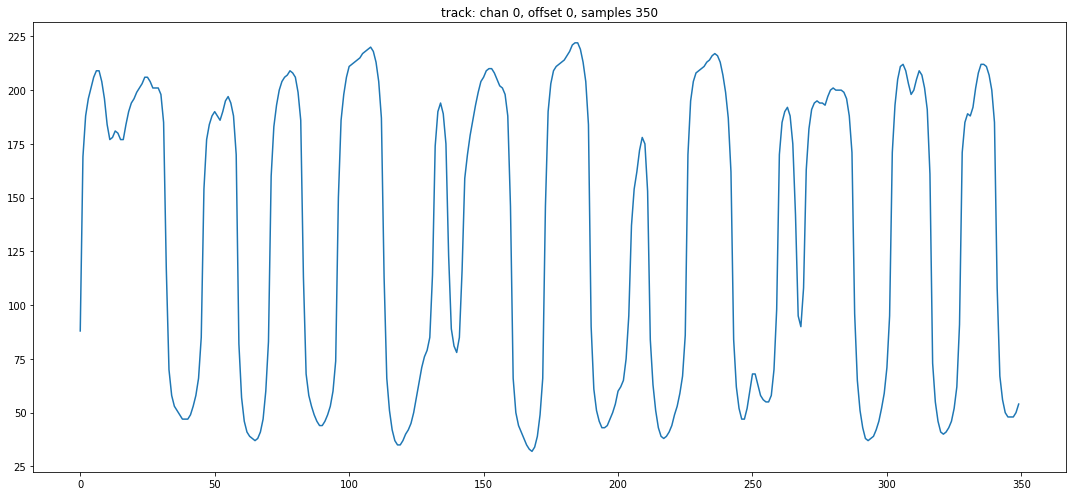

In [12]:
track_i = viz.plot_random_track(ds_train)
track, *_ = ds_train[track_i]
ipd.Audio(audio.mu_expand(track.squeeze().numpy(), p), rate=p.sampling_rate)

In [13]:
utils.seed(p)
t.train()

  0%|          | 0/1869 [00:00<?, ?it/s]

/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1:0 loss 5.55276 lr 2.000094e-04:   0%|          | 0/1869 [00:03<?, ?it/s]

1:0 loss 5.55276 lr 2.000094e-04:   0%|          | 1/1869 [00:03<1:53:52,  3.66s/it]

1:1 loss 5.54002 lr 2.000377e-04:   0%|          | 1/1869 [00:04<1:53:52,  3.66s/it]

1:1 loss 5.54002 lr 2.000377e-04:   0%|          | 2/1869 [00:04<1:31:09,  2.93s/it]

1:2 loss 5.52382 lr 2.000849e-04:   0%|          | 2/1869 [00:06<1:31:09,  2.93s/it]

1:2 loss 5.52382 lr 2.000849e-04:   0%|          | 3/1869 [00:06<1:15:15,  2.42s/it]

1:3 loss 5.51523 lr 2.001510e-04:   0%|          | 3/1869 [00:07<1:15:15,  2.42s/it]

1:3 loss 5.51523 lr 2.001510e-04:   0%|          | 4/1869 [00:07<1:04:08,  2.06s/it]

1:4 loss 5.48950 lr 2.002359e-04:   0%|          | 4/1869 [00:08<1:04:08,  2.06s/it]

1:4 loss 5.48950 lr 2.002359e-04:   0%|          | 5/1869 [00:08<56:21,  1.81s/it]  

1:5 loss 5.46505 lr 2.003396e-04:   0%|          | 5/1869 [00:09<56:21,  1.81s/it]

1:5 loss 5.46505 lr 2.003396e-04:   0%|          | 6/1869 [00:09<50:56,  1.64s/it]

1:6 loss 5.42833 lr 2.004623e-04:   0%|          | 6/1869 [00:11<50:56,  1.64s/it]

1:6 loss 5.42833 lr 2.004623e-04:   0%|          | 7/1869 [00:11<47:10,  1.52s/it]

1:7 loss 5.44686 lr 2.006038e-04:   0%|          | 7/1869 [00:12<47:10,  1.52s/it]

1:7 loss 5.44686 lr 2.006038e-04:   0%|          | 8/1869 [00:12<44:30,  1.43s/it]

1:8 loss 5.37861 lr 2.007642e-04:   0%|          | 8/1869 [00:13<44:30,  1.43s/it]

1:8 loss 5.37861 lr 2.007642e-04:   0%|          | 9/1869 [00:13<42:42,  1.38s/it]

1:9 loss 5.38201 lr 2.009434e-04:   0%|          | 9/1869 [00:14<42:42,  1.38s/it]

1:9 loss 5.38201 lr 2.009434e-04:   1%|          | 10/1869 [00:14<41:24,  1.34s/it]

1:10 loss 5.37446 lr 2.011415e-04:   1%|          | 10/1869 [00:16<41:24,  1.34s/it]

1:10 loss 5.37446 lr 2.011415e-04:   1%|          | 11/1869 [00:16<40:29,  1.31s/it]

1:11 loss 5.36243 lr 2.013585e-04:   1%|          | 11/1869 [00:17<40:29,  1.31s/it]

1:11 loss 5.36243 lr 2.013585e-04:   1%|          | 12/1869 [00:17<39:51,  1.29s/it]

1:12 loss 5.30447 lr 2.015943e-04:   1%|          | 12/1869 [00:18<39:51,  1.29s/it]

1:12 loss 5.30447 lr 2.015943e-04:   1%|          | 13/1869 [00:18<39:23,  1.27s/it]

1:13 loss 5.28686 lr 2.018490e-04:   1%|          | 13/1869 [00:19<39:23,  1.27s/it]

1:13 loss 5.28686 lr 2.018490e-04:   1%|          | 14/1869 [00:19<39:04,  1.26s/it]

1:14 loss 5.22493 lr 2.021225e-04:   1%|          | 14/1869 [00:20<39:04,  1.26s/it]

1:14 loss 5.22493 lr 2.021225e-04:   1%|          | 15/1869 [00:20<38:51,  1.26s/it]

1:15 loss 5.18845 lr 2.024149e-04:   1%|          | 15/1869 [00:22<38:51,  1.26s/it]

1:15 loss 5.18845 lr 2.024149e-04:   1%|          | 16/1869 [00:22<38:43,  1.25s/it]

1:16 loss 5.23399 lr 2.027262e-04:   1%|          | 16/1869 [00:23<38:43,  1.25s/it]

1:16 loss 5.23399 lr 2.027262e-04:   1%|          | 17/1869 [00:23<38:34,  1.25s/it]

1:17 loss 5.19450 lr 2.030562e-04:   1%|          | 17/1869 [00:24<38:34,  1.25s/it]

1:17 loss 5.19450 lr 2.030562e-04:   1%|          | 18/1869 [00:24<38:29,  1.25s/it]

1:18 loss 5.16012 lr 2.034052e-04:   1%|          | 18/1869 [00:25<38:29,  1.25s/it]

1:18 loss 5.16012 lr 2.034052e-04:   1%|          | 19/1869 [00:25<38:26,  1.25s/it]

1:19 loss 5.15475 lr 2.037729e-04:   1%|          | 19/1869 [00:27<38:26,  1.25s/it]

1:19 loss 5.15475 lr 2.037729e-04:   1%|          | 20/1869 [00:27<38:22,  1.25s/it]

1:20 loss 5.07959 lr 2.041596e-04:   1%|          | 20/1869 [00:28<38:22,  1.25s/it]

1:20 loss 5.07959 lr 2.041596e-04:   1%|          | 21/1869 [00:28<38:23,  1.25s/it]

1:21 loss 5.09828 lr 2.045650e-04:   1%|          | 21/1869 [00:29<38:23,  1.25s/it]

1:21 loss 5.09828 lr 2.045650e-04:   1%|          | 22/1869 [00:29<38:25,  1.25s/it]

1:22 loss 5.08108 lr 2.049893e-04:   1%|          | 22/1869 [00:30<38:25,  1.25s/it]

1:22 loss 5.08108 lr 2.049893e-04:   1%|          | 23/1869 [00:30<38:25,  1.25s/it]

1:23 loss 4.98503 lr 2.054324e-04:   1%|          | 23/1869 [00:32<38:25,  1.25s/it]

1:23 loss 4.98503 lr 2.054324e-04:   1%|▏         | 24/1869 [00:32<38:24,  1.25s/it]

1:24 loss 4.95058 lr 2.058944e-04:   1%|▏         | 24/1869 [00:33<38:24,  1.25s/it]

1:24 loss 4.95058 lr 2.058944e-04:   1%|▏         | 25/1869 [00:33<38:21,  1.25s/it]

1:25 loss 4.91173 lr 2.063751e-04:   1%|▏         | 25/1869 [00:34<38:21,  1.25s/it]

1:25 loss 4.91173 lr 2.063751e-04:   1%|▏         | 26/1869 [00:34<38:21,  1.25s/it]

1:26 loss 4.87856 lr 2.068747e-04:   1%|▏         | 26/1869 [00:35<38:21,  1.25s/it]

1:26 loss 4.87856 lr 2.068747e-04:   1%|▏         | 27/1869 [00:35<38:22,  1.25s/it]

1:27 loss 4.88648 lr 2.073931e-04:   1%|▏         | 27/1869 [00:37<38:22,  1.25s/it]

1:27 loss 4.88648 lr 2.073931e-04:   1%|▏         | 28/1869 [00:37<38:22,  1.25s/it]

1:28 loss 4.86013 lr 2.079303e-04:   1%|▏         | 28/1869 [00:38<38:22,  1.25s/it]

1:28 loss 4.86013 lr 2.079303e-04:   2%|▏         | 29/1869 [00:38<38:20,  1.25s/it]

1:29 loss 4.81543 lr 2.084864e-04:   2%|▏         | 29/1869 [00:39<38:20,  1.25s/it]

1:29 loss 4.81543 lr 2.084864e-04:   2%|▏         | 30/1869 [00:39<38:16,  1.25s/it]

1:30 loss 4.85412 lr 2.090612e-04:   2%|▏         | 30/1869 [00:40<38:16,  1.25s/it]

1:30 loss 4.85412 lr 2.090612e-04:   2%|▏         | 31/1869 [00:40<38:17,  1.25s/it]

1:31 loss 4.69532 lr 2.096548e-04:   2%|▏         | 31/1869 [00:42<38:17,  1.25s/it]

1:31 loss 4.69532 lr 2.096548e-04:   2%|▏         | 32/1869 [00:42<38:21,  1.25s/it]

1:32 loss 4.79121 lr 2.102672e-04:   2%|▏         | 32/1869 [00:43<38:21,  1.25s/it]

1:32 loss 4.79121 lr 2.102672e-04:   2%|▏         | 33/1869 [00:43<38:18,  1.25s/it]

1:33 loss 4.59526 lr 2.108984e-04:   2%|▏         | 33/1869 [00:44<38:18,  1.25s/it]

1:33 loss 4.59526 lr 2.108984e-04:   2%|▏         | 34/1869 [00:44<38:17,  1.25s/it]

1:34 loss 4.61707 lr 2.115484e-04:   2%|▏         | 34/1869 [00:45<38:17,  1.25s/it]

1:34 loss 4.61707 lr 2.115484e-04:   2%|▏         | 35/1869 [00:45<38:17,  1.25s/it]

1:35 loss 4.57127 lr 2.122172e-04:   2%|▏         | 35/1869 [00:47<38:17,  1.25s/it]

1:35 loss 4.57127 lr 2.122172e-04:   2%|▏         | 36/1869 [00:47<38:18,  1.25s/it]

1:36 loss 4.48086 lr 2.129047e-04:   2%|▏         | 36/1869 [00:48<38:18,  1.25s/it]

1:36 loss 4.48086 lr 2.129047e-04:   2%|▏         | 37/1869 [00:48<38:17,  1.25s/it]

1:37 loss 4.50142 lr 2.136110e-04:   2%|▏         | 37/1869 [00:49<38:17,  1.25s/it]

1:37 loss 4.50142 lr 2.136110e-04:   2%|▏         | 38/1869 [00:49<38:17,  1.25s/it]

1:38 loss 4.51061 lr 2.143361e-04:   2%|▏         | 38/1869 [00:50<38:17,  1.25s/it]

1:38 loss 4.51061 lr 2.143361e-04:   2%|▏         | 39/1869 [00:50<38:17,  1.26s/it]

1:39 loss 4.49367 lr 2.150799e-04:   2%|▏         | 39/1869 [00:52<38:17,  1.26s/it]

1:39 loss 4.49367 lr 2.150799e-04:   2%|▏         | 40/1869 [00:52<38:20,  1.26s/it]

1:40 loss 4.51505 lr 2.158425e-04:   2%|▏         | 40/1869 [00:53<38:20,  1.26s/it]

1:40 loss 4.51505 lr 2.158425e-04:   2%|▏         | 41/1869 [00:53<38:21,  1.26s/it]

1:41 loss 4.51502 lr 2.166238e-04:   2%|▏         | 41/1869 [00:54<38:21,  1.26s/it]

1:41 loss 4.51502 lr 2.166238e-04:   2%|▏         | 42/1869 [00:54<38:20,  1.26s/it]

1:42 loss 4.41725 lr 2.174239e-04:   2%|▏         | 42/1869 [00:56<38:20,  1.26s/it]

1:42 loss 4.41725 lr 2.174239e-04:   2%|▏         | 43/1869 [00:56<38:25,  1.26s/it]

1:43 loss 4.29656 lr 2.182427e-04:   2%|▏         | 43/1869 [00:57<38:25,  1.26s/it]

1:43 loss 4.29656 lr 2.182427e-04:   2%|▏         | 44/1869 [00:57<38:25,  1.26s/it]

1:44 loss 4.28483 lr 2.190802e-04:   2%|▏         | 44/1869 [00:58<38:25,  1.26s/it]

1:44 loss 4.28483 lr 2.190802e-04:   2%|▏         | 45/1869 [00:58<38:29,  1.27s/it]

1:45 loss 4.32060 lr 2.199365e-04:   2%|▏         | 45/1869 [00:59<38:29,  1.27s/it]

1:45 loss 4.32060 lr 2.199365e-04:   2%|▏         | 46/1869 [00:59<38:32,  1.27s/it]

1:46 loss 4.26910 lr 2.208114e-04:   2%|▏         | 46/1869 [01:01<38:32,  1.27s/it]

1:46 loss 4.26910 lr 2.208114e-04:   3%|▎         | 47/1869 [01:01<38:32,  1.27s/it]

1:47 loss 4.19784 lr 2.217051e-04:   3%|▎         | 47/1869 [01:02<38:32,  1.27s/it]

1:47 loss 4.19784 lr 2.217051e-04:   3%|▎         | 48/1869 [01:02<38:39,  1.27s/it]

1:48 loss 4.17645 lr 2.226175e-04:   3%|▎         | 48/1869 [01:03<38:39,  1.27s/it]

1:48 loss 4.17645 lr 2.226175e-04:   3%|▎         | 49/1869 [01:03<38:50,  1.28s/it]

1:49 loss 4.12588 lr 2.235485e-04:   3%|▎         | 49/1869 [01:04<38:50,  1.28s/it]

1:49 loss 4.12588 lr 2.235485e-04:   3%|▎         | 50/1869 [01:04<38:51,  1.28s/it]

1:50 loss 4.04441 lr 2.244982e-04:   3%|▎         | 50/1869 [01:06<38:51,  1.28s/it]

1:50 loss 4.04441 lr 2.244982e-04:   3%|▎         | 51/1869 [01:06<38:51,  1.28s/it]

1:51 loss 4.19895 lr 2.254667e-04:   3%|▎         | 51/1869 [01:07<38:51,  1.28s/it]

1:51 loss 4.19895 lr 2.254667e-04:   3%|▎         | 52/1869 [01:07<38:47,  1.28s/it]

1:52 loss 4.03526 lr 2.264537e-04:   3%|▎         | 52/1869 [01:08<38:47,  1.28s/it]

1:52 loss 4.03526 lr 2.264537e-04:   3%|▎         | 53/1869 [01:08<38:53,  1.29s/it]

1:53 loss 4.05831 lr 2.274595e-04:   3%|▎         | 53/1869 [01:10<38:53,  1.29s/it]

1:53 loss 4.05831 lr 2.274595e-04:   3%|▎         | 54/1869 [01:10<38:58,  1.29s/it]

1:54 loss 3.81512 lr 2.284839e-04:   3%|▎         | 54/1869 [01:11<38:58,  1.29s/it]

1:54 loss 3.81512 lr 2.284839e-04:   3%|▎         | 55/1869 [01:11<38:56,  1.29s/it]

1:55 loss 4.00270 lr 2.295269e-04:   3%|▎         | 55/1869 [01:12<38:56,  1.29s/it]

1:55 loss 4.00270 lr 2.295269e-04:   3%|▎         | 56/1869 [01:12<38:55,  1.29s/it]

1:56 loss 4.03801 lr 2.305886e-04:   3%|▎         | 56/1869 [01:14<38:55,  1.29s/it]

1:56 loss 4.03801 lr 2.305886e-04:   3%|▎         | 57/1869 [01:14<39:04,  1.29s/it]

1:57 loss 3.98674 lr 2.316689e-04:   3%|▎         | 57/1869 [01:15<39:04,  1.29s/it]

1:57 loss 3.98674 lr 2.316689e-04:   3%|▎         | 58/1869 [01:15<38:59,  1.29s/it]

1:58 loss 4.10715 lr 2.327679e-04:   3%|▎         | 58/1869 [01:16<38:59,  1.29s/it]

1:58 loss 4.10715 lr 2.327679e-04:   3%|▎         | 59/1869 [01:16<39:09,  1.30s/it]

1:59 loss 3.83865 lr 2.338854e-04:   3%|▎         | 59/1869 [01:17<39:09,  1.30s/it]

1:59 loss 3.83865 lr 2.338854e-04:   3%|▎         | 60/1869 [01:17<39:06,  1.30s/it]

1:60 loss 4.11215 lr 2.350216e-04:   3%|▎         | 60/1869 [01:19<39:06,  1.30s/it]

1:60 loss 4.11215 lr 2.350216e-04:   3%|▎         | 61/1869 [01:19<39:07,  1.30s/it]

1:61 loss 4.05917 lr 2.361763e-04:   3%|▎         | 61/1869 [01:20<39:07,  1.30s/it]

1:61 loss 4.05917 lr 2.361763e-04:   3%|▎         | 62/1869 [01:20<39:07,  1.30s/it]

1:62 loss 3.77408 lr 2.373496e-04:   3%|▎         | 62/1869 [01:21<39:07,  1.30s/it]

1:62 loss 3.77408 lr 2.373496e-04:   3%|▎         | 63/1869 [01:21<39:08,  1.30s/it]

1:63 loss 3.92904 lr 2.385415e-04:   3%|▎         | 63/1869 [01:23<39:08,  1.30s/it]

1:63 loss 3.92904 lr 2.385415e-04:   3%|▎         | 64/1869 [01:23<39:03,  1.30s/it]

1:64 loss 3.92014 lr 2.397520e-04:   3%|▎         | 64/1869 [01:24<39:03,  1.30s/it]

1:64 loss 3.92014 lr 2.397520e-04:   3%|▎         | 65/1869 [01:24<39:14,  1.31s/it]

1:65 loss 3.82819 lr 2.409810e-04:   3%|▎         | 65/1869 [01:25<39:14,  1.31s/it]

1:65 loss 3.82819 lr 2.409810e-04:   4%|▎         | 66/1869 [01:25<39:11,  1.30s/it]

1:66 loss 3.68009 lr 2.422286e-04:   4%|▎         | 66/1869 [01:27<39:11,  1.30s/it]

1:66 loss 3.68009 lr 2.422286e-04:   4%|▎         | 67/1869 [01:27<39:19,  1.31s/it]

1:67 loss 3.71085 lr 2.434947e-04:   4%|▎         | 67/1869 [01:28<39:19,  1.31s/it]

1:67 loss 3.71085 lr 2.434947e-04:   4%|▎         | 68/1869 [01:28<39:14,  1.31s/it]

1:68 loss 3.72629 lr 2.447794e-04:   4%|▎         | 68/1869 [01:29<39:14,  1.31s/it]

1:68 loss 3.72629 lr 2.447794e-04:   4%|▎         | 69/1869 [01:29<40:00,  1.33s/it]

1:69 loss 3.71637 lr 2.460825e-04:   4%|▎         | 69/1869 [01:31<40:00,  1.33s/it]

1:69 loss 3.71637 lr 2.460825e-04:   4%|▎         | 70/1869 [01:31<39:34,  1.32s/it]

1:70 loss 3.61357 lr 2.474042e-04:   4%|▎         | 70/1869 [01:32<39:34,  1.32s/it]

1:70 loss 3.61357 lr 2.474042e-04:   4%|▍         | 71/1869 [01:32<39:21,  1.31s/it]

1:71 loss 3.64063 lr 2.487443e-04:   4%|▍         | 71/1869 [01:33<39:21,  1.31s/it]

1:71 loss 3.64063 lr 2.487443e-04:   4%|▍         | 72/1869 [01:33<39:21,  1.31s/it]

1:72 loss 3.59198 lr 2.501030e-04:   4%|▍         | 72/1869 [01:34<39:21,  1.31s/it]

1:72 loss 3.59198 lr 2.501030e-04:   4%|▍         | 73/1869 [01:34<39:16,  1.31s/it]

1:73 loss 3.69969 lr 2.514801e-04:   4%|▍         | 73/1869 [01:36<39:16,  1.31s/it]

1:73 loss 3.69969 lr 2.514801e-04:   4%|▍         | 74/1869 [01:36<39:13,  1.31s/it]

1:74 loss 3.46068 lr 2.528757e-04:   4%|▍         | 74/1869 [01:37<39:13,  1.31s/it]

1:74 loss 3.46068 lr 2.528757e-04:   4%|▍         | 75/1869 [01:37<39:20,  1.32s/it]

1:75 loss 3.44361 lr 2.542897e-04:   4%|▍         | 75/1869 [01:38<39:20,  1.32s/it]

1:75 loss 3.44361 lr 2.542897e-04:   4%|▍         | 76/1869 [01:38<39:22,  1.32s/it]

1:76 loss 3.55723 lr 2.557222e-04:   4%|▍         | 76/1869 [01:40<39:22,  1.32s/it]

1:76 loss 3.55723 lr 2.557222e-04:   4%|▍         | 77/1869 [01:40<39:23,  1.32s/it]

1:77 loss 3.36378 lr 2.571731e-04:   4%|▍         | 77/1869 [01:41<39:23,  1.32s/it]

1:77 loss 3.36378 lr 2.571731e-04:   4%|▍         | 78/1869 [01:41<39:10,  1.31s/it]

1:78 loss 3.62466 lr 2.586425e-04:   4%|▍         | 78/1869 [01:42<39:10,  1.31s/it]

1:78 loss 3.62466 lr 2.586425e-04:   4%|▍         | 79/1869 [01:42<39:17,  1.32s/it]

1:79 loss 3.57662 lr 2.601302e-04:   4%|▍         | 79/1869 [01:44<39:17,  1.32s/it]

1:79 loss 3.57662 lr 2.601302e-04:   4%|▍         | 80/1869 [01:44<39:06,  1.31s/it]

1:80 loss 3.63185 lr 2.616364e-04:   4%|▍         | 80/1869 [01:45<39:06,  1.31s/it]

1:80 loss 3.63185 lr 2.616364e-04:   4%|▍         | 81/1869 [01:45<39:07,  1.31s/it]

1:81 loss 3.59689 lr 2.631609e-04:   4%|▍         | 81/1869 [01:46<39:07,  1.31s/it]

1:81 loss 3.59689 lr 2.631609e-04:   4%|▍         | 82/1869 [01:46<39:13,  1.32s/it]

1:82 loss 3.55440 lr 2.647038e-04:   4%|▍         | 82/1869 [01:48<39:13,  1.32s/it]

1:82 loss 3.55440 lr 2.647038e-04:   4%|▍         | 83/1869 [01:48<39:11,  1.32s/it]

1:83 loss 3.53687 lr 2.662651e-04:   4%|▍         | 83/1869 [01:49<39:11,  1.32s/it]

1:83 loss 3.53687 lr 2.662651e-04:   4%|▍         | 84/1869 [01:49<39:11,  1.32s/it]

1:84 loss 3.28334 lr 2.678447e-04:   4%|▍         | 84/1869 [01:50<39:11,  1.32s/it]

1:84 loss 3.28334 lr 2.678447e-04:   5%|▍         | 85/1869 [01:50<39:13,  1.32s/it]

1:85 loss 3.39823 lr 2.694426e-04:   5%|▍         | 85/1869 [01:52<39:13,  1.32s/it]

1:85 loss 3.39823 lr 2.694426e-04:   5%|▍         | 86/1869 [01:52<39:06,  1.32s/it]

1:86 loss 3.45688 lr 2.710589e-04:   5%|▍         | 86/1869 [01:53<39:06,  1.32s/it]

1:86 loss 3.45688 lr 2.710589e-04:   5%|▍         | 87/1869 [01:53<38:56,  1.31s/it]

1:87 loss 3.34748 lr 2.726935e-04:   5%|▍         | 87/1869 [01:54<38:56,  1.31s/it]

1:87 loss 3.34748 lr 2.726935e-04:   5%|▍         | 88/1869 [01:54<39:06,  1.32s/it]

1:88 loss 3.19595 lr 2.743464e-04:   5%|▍         | 88/1869 [01:56<39:06,  1.32s/it]

1:88 loss 3.19595 lr 2.743464e-04:   5%|▍         | 89/1869 [01:56<39:14,  1.32s/it]

1:89 loss 3.39010 lr 2.760175e-04:   5%|▍         | 89/1869 [01:57<39:14,  1.32s/it]

1:89 loss 3.39010 lr 2.760175e-04:   5%|▍         | 90/1869 [01:57<39:05,  1.32s/it]

1:90 loss 3.57522 lr 2.777070e-04:   5%|▍         | 90/1869 [01:58<39:05,  1.32s/it]

1:90 loss 3.57522 lr 2.777070e-04:   5%|▍         | 91/1869 [01:58<39:00,  1.32s/it]

1:91 loss 3.01502 lr 2.794147e-04:   5%|▍         | 91/1869 [01:59<39:00,  1.32s/it]

1:91 loss 3.01502 lr 2.794147e-04:   5%|▍         | 92/1869 [01:59<39:03,  1.32s/it]

1:92 loss 3.38508 lr 2.811406e-04:   5%|▍         | 92/1869 [02:01<39:03,  1.32s/it]

1:92 loss 3.38508 lr 2.811406e-04:   5%|▍         | 93/1869 [02:01<39:13,  1.32s/it]

1:93 loss 3.31368 lr 2.828848e-04:   5%|▍         | 93/1869 [02:02<39:13,  1.32s/it]

1:93 loss 3.31368 lr 2.828848e-04:   5%|▌         | 94/1869 [02:02<39:06,  1.32s/it]

1:94 loss 3.27045 lr 2.846472e-04:   5%|▌         | 94/1869 [02:03<39:06,  1.32s/it]

1:94 loss 3.27045 lr 2.846472e-04:   5%|▌         | 95/1869 [02:03<39:11,  1.33s/it]

1:95 loss 3.18565 lr 2.864278e-04:   5%|▌         | 95/1869 [02:05<39:11,  1.33s/it]

1:95 loss 3.18565 lr 2.864278e-04:   5%|▌         | 96/1869 [02:05<39:04,  1.32s/it]

1:96 loss 3.19658 lr 2.882265e-04:   5%|▌         | 96/1869 [02:06<39:04,  1.32s/it]

1:96 loss 3.19658 lr 2.882265e-04:   5%|▌         | 97/1869 [02:06<39:01,  1.32s/it]

1:97 loss 3.38572 lr 2.900435e-04:   5%|▌         | 97/1869 [02:07<39:01,  1.32s/it]

1:97 loss 3.38572 lr 2.900435e-04:   5%|▌         | 98/1869 [02:07<38:54,  1.32s/it]

1:98 loss 3.32070 lr 2.918786e-04:   5%|▌         | 98/1869 [02:09<38:54,  1.32s/it]

1:98 loss 3.32070 lr 2.918786e-04:   5%|▌         | 99/1869 [02:09<38:58,  1.32s/it]

1:99 loss 3.12563 lr 2.937319e-04:   5%|▌         | 99/1869 [02:10<38:58,  1.32s/it]

1:99 loss 3.12563 lr 2.937319e-04:   5%|▌         | 100/1869 [02:10<38:46,  1.31s/it]

1:100 loss 3.31176 lr 2.956033e-04:   5%|▌         | 100/1869 [02:11<38:46,  1.31s/it]

1:100 loss 3.31176 lr 2.956033e-04:   5%|▌         | 101/1869 [02:11<38:49,  1.32s/it]

1:101 loss 3.06276 lr 2.974928e-04:   5%|▌         | 101/1869 [02:13<38:49,  1.32s/it]

1:101 loss 3.06276 lr 2.974928e-04:   5%|▌         | 102/1869 [02:13<38:51,  1.32s/it]

1:102 loss 2.87169 lr 2.994005e-04:   5%|▌         | 102/1869 [02:14<38:51,  1.32s/it]

1:102 loss 2.87169 lr 2.994005e-04:   6%|▌         | 103/1869 [02:14<38:45,  1.32s/it]

1:103 loss 3.02702 lr 3.013262e-04:   6%|▌         | 103/1869 [02:15<38:45,  1.32s/it]

1:103 loss 3.02702 lr 3.013262e-04:   6%|▌         | 104/1869 [02:15<38:46,  1.32s/it]

1:104 loss 3.12601 lr 3.032700e-04:   6%|▌         | 104/1869 [02:17<38:46,  1.32s/it]

1:104 loss 3.12601 lr 3.032700e-04:   6%|▌         | 105/1869 [02:17<38:37,  1.31s/it]

1:105 loss 3.33739 lr 3.052318e-04:   6%|▌         | 105/1869 [02:18<38:37,  1.31s/it]

1:105 loss 3.33739 lr 3.052318e-04:   6%|▌         | 106/1869 [02:18<38:41,  1.32s/it]

1:106 loss 3.08292 lr 3.072117e-04:   6%|▌         | 106/1869 [02:19<38:41,  1.32s/it]

1:106 loss 3.08292 lr 3.072117e-04:   6%|▌         | 107/1869 [02:19<38:49,  1.32s/it]

1:107 loss 3.09910 lr 3.092096e-04:   6%|▌         | 107/1869 [02:21<38:49,  1.32s/it]

1:107 loss 3.09910 lr 3.092096e-04:   6%|▌         | 108/1869 [02:21<38:36,  1.32s/it]

1:108 loss 3.12664 lr 3.112255e-04:   6%|▌         | 108/1869 [02:22<38:36,  1.32s/it]

1:108 loss 3.12664 lr 3.112255e-04:   6%|▌         | 109/1869 [02:22<38:39,  1.32s/it]

1:109 loss 3.00918 lr 3.132594e-04:   6%|▌         | 109/1869 [02:23<38:39,  1.32s/it]

1:109 loss 3.00918 lr 3.132594e-04:   6%|▌         | 110/1869 [02:23<38:40,  1.32s/it]

1:110 loss 3.03463 lr 3.153113e-04:   6%|▌         | 110/1869 [02:25<38:40,  1.32s/it]

1:110 loss 3.03463 lr 3.153113e-04:   6%|▌         | 111/1869 [02:25<38:43,  1.32s/it]

1:111 loss 3.00868 lr 3.173812e-04:   6%|▌         | 111/1869 [02:26<38:43,  1.32s/it]

1:111 loss 3.00868 lr 3.173812e-04:   6%|▌         | 112/1869 [02:26<38:36,  1.32s/it]

1:112 loss 2.80583 lr 3.194690e-04:   6%|▌         | 112/1869 [02:27<38:36,  1.32s/it]

1:112 loss 2.80583 lr 3.194690e-04:   6%|▌         | 113/1869 [02:27<38:30,  1.32s/it]

1:113 loss 3.19365 lr 3.215747e-04:   6%|▌         | 113/1869 [02:29<38:30,  1.32s/it]

1:113 loss 3.19365 lr 3.215747e-04:   6%|▌         | 114/1869 [02:29<38:41,  1.32s/it]

1:114 loss 3.02177 lr 3.236984e-04:   6%|▌         | 114/1869 [02:30<38:41,  1.32s/it]

1:114 loss 3.02177 lr 3.236984e-04:   6%|▌         | 115/1869 [02:30<38:36,  1.32s/it]

1:115 loss 2.94064 lr 3.258399e-04:   6%|▌         | 115/1869 [02:31<38:36,  1.32s/it]

1:115 loss 2.94064 lr 3.258399e-04:   6%|▌         | 116/1869 [02:31<38:37,  1.32s/it]

1:116 loss 3.05469 lr 3.279994e-04:   6%|▌         | 116/1869 [02:32<38:37,  1.32s/it]

1:116 loss 3.05469 lr 3.279994e-04:   6%|▋         | 117/1869 [02:32<38:33,  1.32s/it]

1:117 loss 2.79942 lr 3.301767e-04:   6%|▋         | 117/1869 [02:34<38:33,  1.32s/it]

1:117 loss 2.79942 lr 3.301767e-04:   6%|▋         | 118/1869 [02:34<38:28,  1.32s/it]

1:118 loss 2.93941 lr 3.323718e-04:   6%|▋         | 118/1869 [02:35<38:28,  1.32s/it]

1:118 loss 2.93941 lr 3.323718e-04:   6%|▋         | 119/1869 [02:35<38:29,  1.32s/it]

1:119 loss 2.86880 lr 3.345848e-04:   6%|▋         | 119/1869 [02:36<38:29,  1.32s/it]

1:119 loss 2.86880 lr 3.345848e-04:   6%|▋         | 120/1869 [02:36<38:12,  1.31s/it]

1:120 loss 2.99372 lr 3.368155e-04:   6%|▋         | 120/1869 [02:38<38:12,  1.31s/it]

1:120 loss 2.99372 lr 3.368155e-04:   6%|▋         | 121/1869 [02:38<38:13,  1.31s/it]

1:121 loss 2.86687 lr 3.390641e-04:   6%|▋         | 121/1869 [02:39<38:13,  1.31s/it]

1:121 loss 2.86687 lr 3.390641e-04:   7%|▋         | 122/1869 [02:39<38:15,  1.31s/it]

1:122 loss 3.00667 lr 3.413305e-04:   7%|▋         | 122/1869 [02:40<38:15,  1.31s/it]

1:122 loss 3.00667 lr 3.413305e-04:   7%|▋         | 123/1869 [02:40<38:18,  1.32s/it]

1:123 loss 2.88787 lr 3.436146e-04:   7%|▋         | 123/1869 [02:42<38:18,  1.32s/it]

1:123 loss 2.88787 lr 3.436146e-04:   7%|▋         | 124/1869 [02:42<38:20,  1.32s/it]

1:124 loss 2.93283 lr 3.459164e-04:   7%|▋         | 124/1869 [02:43<38:20,  1.32s/it]

1:124 loss 2.93283 lr 3.459164e-04:   7%|▋         | 125/1869 [02:43<38:08,  1.31s/it]

1:125 loss 2.82842 lr 3.482360e-04:   7%|▋         | 125/1869 [02:44<38:08,  1.31s/it]

1:125 loss 2.82842 lr 3.482360e-04:   7%|▋         | 126/1869 [02:44<38:01,  1.31s/it]

1:126 loss 2.92221 lr 3.505733e-04:   7%|▋         | 126/1869 [02:46<38:01,  1.31s/it]

1:126 loss 2.92221 lr 3.505733e-04:   7%|▋         | 127/1869 [02:46<38:12,  1.32s/it]

1:127 loss 2.96157 lr 3.529282e-04:   7%|▋         | 127/1869 [02:47<38:12,  1.32s/it]

1:127 loss 2.96157 lr 3.529282e-04:   7%|▋         | 128/1869 [02:47<38:15,  1.32s/it]

1:128 loss 2.92901 lr 3.553009e-04:   7%|▋         | 128/1869 [02:48<38:15,  1.32s/it]

1:128 loss 2.92901 lr 3.553009e-04:   7%|▋         | 129/1869 [02:48<38:14,  1.32s/it]

1:129 loss 2.98355 lr 3.576911e-04:   7%|▋         | 129/1869 [02:50<38:14,  1.32s/it]

1:129 loss 2.98355 lr 3.576911e-04:   7%|▋         | 130/1869 [02:50<38:12,  1.32s/it]

1:130 loss 2.93911 lr 3.600990e-04:   7%|▋         | 130/1869 [02:51<38:12,  1.32s/it]

1:130 loss 2.93911 lr 3.600990e-04:   7%|▋         | 131/1869 [02:51<38:02,  1.31s/it]

1:131 loss 2.84375 lr 3.625246e-04:   7%|▋         | 131/1869 [02:52<38:02,  1.31s/it]

1:131 loss 2.84375 lr 3.625246e-04:   7%|▋         | 132/1869 [02:52<38:07,  1.32s/it]

1:132 loss 2.96366 lr 3.649677e-04:   7%|▋         | 132/1869 [02:54<38:07,  1.32s/it]

1:132 loss 2.96366 lr 3.649677e-04:   7%|▋         | 133/1869 [02:54<38:07,  1.32s/it]

1:133 loss 2.85167 lr 3.674284e-04:   7%|▋         | 133/1869 [02:55<38:07,  1.32s/it]

1:133 loss 2.85167 lr 3.674284e-04:   7%|▋         | 134/1869 [02:55<38:03,  1.32s/it]

1:134 loss 2.89409 lr 3.699066e-04:   7%|▋         | 134/1869 [02:56<38:03,  1.32s/it]

1:134 loss 2.89409 lr 3.699066e-04:   7%|▋         | 135/1869 [02:56<38:04,  1.32s/it]

1:135 loss 2.66744 lr 3.724024e-04:   7%|▋         | 135/1869 [02:57<38:04,  1.32s/it]

1:135 loss 2.66744 lr 3.724024e-04:   7%|▋         | 136/1869 [02:57<38:07,  1.32s/it]

1:136 loss 2.85837 lr 3.749156e-04:   7%|▋         | 136/1869 [02:59<38:07,  1.32s/it]

1:136 loss 2.85837 lr 3.749156e-04:   7%|▋         | 137/1869 [02:59<38:12,  1.32s/it]

1:137 loss 2.76127 lr 3.774464e-04:   7%|▋         | 137/1869 [03:00<38:12,  1.32s/it]

1:137 loss 2.76127 lr 3.774464e-04:   7%|▋         | 138/1869 [03:00<38:06,  1.32s/it]

1:138 loss 2.80015 lr 3.799947e-04:   7%|▋         | 138/1869 [03:01<38:06,  1.32s/it]

1:138 loss 2.80015 lr 3.799947e-04:   7%|▋         | 139/1869 [03:01<38:05,  1.32s/it]

1:139 loss 2.73972 lr 3.825604e-04:   7%|▋         | 139/1869 [03:03<38:05,  1.32s/it]

1:139 loss 2.73972 lr 3.825604e-04:   7%|▋         | 140/1869 [03:03<37:57,  1.32s/it]

1:140 loss 2.53867 lr 3.851435e-04:   7%|▋         | 140/1869 [03:04<37:57,  1.32s/it]

1:140 loss 2.53867 lr 3.851435e-04:   8%|▊         | 141/1869 [03:04<38:03,  1.32s/it]

1:141 loss 2.58623 lr 3.877441e-04:   8%|▊         | 141/1869 [03:05<38:03,  1.32s/it]

1:141 loss 2.58623 lr 3.877441e-04:   8%|▊         | 142/1869 [03:05<37:57,  1.32s/it]

1:142 loss 2.66810 lr 3.903620e-04:   8%|▊         | 142/1869 [03:07<37:57,  1.32s/it]

1:142 loss 2.66810 lr 3.903620e-04:   8%|▊         | 143/1869 [03:07<37:46,  1.31s/it]

1:143 loss 2.65970 lr 3.929973e-04:   8%|▊         | 143/1869 [03:08<37:46,  1.31s/it]

1:143 loss 2.65970 lr 3.929973e-04:   8%|▊         | 144/1869 [03:08<37:37,  1.31s/it]

1:144 loss 2.86699 lr 3.956500e-04:   8%|▊         | 144/1869 [03:09<37:37,  1.31s/it]

1:144 loss 2.86699 lr 3.956500e-04:   8%|▊         | 145/1869 [03:09<37:34,  1.31s/it]

1:145 loss 2.77788 lr 3.983200e-04:   8%|▊         | 145/1869 [03:11<37:34,  1.31s/it]

1:145 loss 2.77788 lr 3.983200e-04:   8%|▊         | 146/1869 [03:11<37:38,  1.31s/it]

1:146 loss 2.67198 lr 4.010073e-04:   8%|▊         | 146/1869 [03:12<37:38,  1.31s/it]

1:146 loss 2.67198 lr 4.010073e-04:   8%|▊         | 147/1869 [03:12<37:37,  1.31s/it]

1:147 loss 2.66526 lr 4.037119e-04:   8%|▊         | 147/1869 [03:13<37:37,  1.31s/it]

1:147 loss 2.66526 lr 4.037119e-04:   8%|▊         | 148/1869 [03:13<37:44,  1.32s/it]

1:148 loss 2.71212 lr 4.064338e-04:   8%|▊         | 148/1869 [03:15<37:44,  1.32s/it]

1:148 loss 2.71212 lr 4.064338e-04:   8%|▊         | 149/1869 [03:15<37:33,  1.31s/it]

1:149 loss 2.61914 lr 4.091729e-04:   8%|▊         | 149/1869 [03:16<37:33,  1.31s/it]

1:149 loss 2.61914 lr 4.091729e-04:   8%|▊         | 150/1869 [03:16<37:28,  1.31s/it]

1:150 loss 2.72555 lr 4.119293e-04:   8%|▊         | 150/1869 [03:17<37:28,  1.31s/it]

1:150 loss 2.72555 lr 4.119293e-04:   8%|▊         | 151/1869 [03:17<37:37,  1.31s/it]

1:151 loss 2.68698 lr 4.147028e-04:   8%|▊         | 151/1869 [03:19<37:37,  1.31s/it]

1:151 loss 2.68698 lr 4.147028e-04:   8%|▊         | 152/1869 [03:19<37:31,  1.31s/it]

1:152 loss 2.68111 lr 4.174936e-04:   8%|▊         | 152/1869 [03:20<37:31,  1.31s/it]

1:152 loss 2.68111 lr 4.174936e-04:   8%|▊         | 153/1869 [03:20<37:35,  1.31s/it]

1:153 loss 2.50402 lr 4.203015e-04:   8%|▊         | 153/1869 [03:21<37:35,  1.31s/it]

1:153 loss 2.50402 lr 4.203015e-04:   8%|▊         | 154/1869 [03:21<37:32,  1.31s/it]

1:154 loss 2.58570 lr 4.231265e-04:   8%|▊         | 154/1869 [03:22<37:32,  1.31s/it]

1:154 loss 2.58570 lr 4.231265e-04:   8%|▊         | 155/1869 [03:22<37:27,  1.31s/it]

1:155 loss 2.57207 lr 4.259686e-04:   8%|▊         | 155/1869 [03:24<37:27,  1.31s/it]

1:155 loss 2.57207 lr 4.259686e-04:   8%|▊         | 156/1869 [03:24<37:28,  1.31s/it]

1:156 loss 2.63420 lr 4.288279e-04:   8%|▊         | 156/1869 [03:25<37:28,  1.31s/it]

1:156 loss 2.63420 lr 4.288279e-04:   8%|▊         | 157/1869 [03:25<37:29,  1.31s/it]

1:157 loss 2.80879 lr 4.317042e-04:   8%|▊         | 157/1869 [03:26<37:29,  1.31s/it]

1:157 loss 2.80879 lr 4.317042e-04:   8%|▊         | 158/1869 [03:26<37:35,  1.32s/it]

1:158 loss 2.64975 lr 4.345975e-04:   8%|▊         | 158/1869 [03:28<37:35,  1.32s/it]

1:158 loss 2.64975 lr 4.345975e-04:   9%|▊         | 159/1869 [03:28<37:24,  1.31s/it]

1:159 loss 2.49251 lr 4.375079e-04:   9%|▊         | 159/1869 [03:29<37:24,  1.31s/it]

1:159 loss 2.49251 lr 4.375079e-04:   9%|▊         | 160/1869 [03:29<37:06,  1.30s/it]

1:160 loss 2.50313 lr 4.404353e-04:   9%|▊         | 160/1869 [03:30<37:06,  1.30s/it]

1:160 loss 2.50313 lr 4.404353e-04:   9%|▊         | 161/1869 [03:30<37:16,  1.31s/it]

1:161 loss 2.67976 lr 4.433796e-04:   9%|▊         | 161/1869 [03:32<37:16,  1.31s/it]

1:161 loss 2.67976 lr 4.433796e-04:   9%|▊         | 162/1869 [03:32<37:20,  1.31s/it]

1:162 loss 2.64357 lr 4.463410e-04:   9%|▊         | 162/1869 [03:33<37:20,  1.31s/it]

1:162 loss 2.64357 lr 4.463410e-04:   9%|▊         | 163/1869 [03:33<37:17,  1.31s/it]

1:163 loss 2.66134 lr 4.493192e-04:   9%|▊         | 163/1869 [03:34<37:17,  1.31s/it]

1:163 loss 2.66134 lr 4.493192e-04:   9%|▉         | 164/1869 [03:34<37:19,  1.31s/it]

1:164 loss 2.69772 lr 4.523144e-04:   9%|▉         | 164/1869 [03:36<37:19,  1.31s/it]

1:164 loss 2.69772 lr 4.523144e-04:   9%|▉         | 165/1869 [03:36<36:58,  1.30s/it]

1:165 loss 2.56531 lr 4.553264e-04:   9%|▉         | 165/1869 [03:37<36:58,  1.30s/it]

1:165 loss 2.56531 lr 4.553264e-04:   9%|▉         | 166/1869 [03:37<37:07,  1.31s/it]

1:166 loss 2.38847 lr 4.583553e-04:   9%|▉         | 166/1869 [03:38<37:07,  1.31s/it]

1:166 loss 2.38847 lr 4.583553e-04:   9%|▉         | 167/1869 [03:38<36:52,  1.30s/it]

1:167 loss 2.72462 lr 4.614011e-04:   9%|▉         | 167/1869 [03:39<36:52,  1.30s/it]

1:167 loss 2.72462 lr 4.614011e-04:   9%|▉         | 168/1869 [03:39<36:51,  1.30s/it]

1:168 loss 2.68539 lr 4.644636e-04:   9%|▉         | 168/1869 [03:41<36:51,  1.30s/it]

1:168 loss 2.68539 lr 4.644636e-04:   9%|▉         | 169/1869 [03:41<37:01,  1.31s/it]

1:169 loss 2.68161 lr 4.675430e-04:   9%|▉         | 169/1869 [03:42<37:01,  1.31s/it]

1:169 loss 2.68161 lr 4.675430e-04:   9%|▉         | 170/1869 [03:42<37:04,  1.31s/it]

1:170 loss 2.53495 lr 4.706391e-04:   9%|▉         | 170/1869 [03:43<37:04,  1.31s/it]

1:170 loss 2.53495 lr 4.706391e-04:   9%|▉         | 171/1869 [03:43<37:01,  1.31s/it]

1:171 loss 2.55259 lr 4.737519e-04:   9%|▉         | 171/1869 [03:45<37:01,  1.31s/it]

1:171 loss 2.55259 lr 4.737519e-04:   9%|▉         | 172/1869 [03:45<36:59,  1.31s/it]

1:172 loss 2.70126 lr 4.768815e-04:   9%|▉         | 172/1869 [03:46<36:59,  1.31s/it]

1:172 loss 2.70126 lr 4.768815e-04:   9%|▉         | 173/1869 [03:46<36:55,  1.31s/it]

1:173 loss 2.68842 lr 4.800278e-04:   9%|▉         | 173/1869 [03:47<36:55,  1.31s/it]

1:173 loss 2.68842 lr 4.800278e-04:   9%|▉         | 174/1869 [03:47<37:05,  1.31s/it]

1:174 loss 2.68406 lr 4.831907e-04:   9%|▉         | 174/1869 [03:49<37:05,  1.31s/it]

1:174 loss 2.68406 lr 4.831907e-04:   9%|▉         | 175/1869 [03:49<37:14,  1.32s/it]

1:175 loss 2.62932 lr 4.863703e-04:   9%|▉         | 175/1869 [03:50<37:14,  1.32s/it]

1:175 loss 2.62932 lr 4.863703e-04:   9%|▉         | 176/1869 [03:50<37:16,  1.32s/it]

1:176 loss 2.38004 lr 4.895665e-04:   9%|▉         | 176/1869 [03:51<37:16,  1.32s/it]

1:176 loss 2.38004 lr 4.895665e-04:   9%|▉         | 177/1869 [03:51<37:14,  1.32s/it]

1:177 loss 2.59477 lr 4.927793e-04:   9%|▉         | 177/1869 [03:53<37:14,  1.32s/it]

1:177 loss 2.59477 lr 4.927793e-04:  10%|▉         | 178/1869 [03:53<37:03,  1.31s/it]

1:178 loss 2.44947 lr 4.960087e-04:  10%|▉         | 178/1869 [03:54<37:03,  1.31s/it]

1:178 loss 2.44947 lr 4.960087e-04:  10%|▉         | 179/1869 [03:54<37:10,  1.32s/it]

1:179 loss 2.54365 lr 4.992546e-04:  10%|▉         | 179/1869 [03:55<37:10,  1.32s/it]

1:179 loss 2.54365 lr 4.992546e-04:  10%|▉         | 180/1869 [03:55<37:46,  1.34s/it]

1:180 loss 2.52707 lr 5.025170e-04:  10%|▉         | 180/1869 [03:57<37:46,  1.34s/it]

1:180 loss 2.52707 lr 5.025170e-04:  10%|▉         | 181/1869 [03:57<37:24,  1.33s/it]

1:181 loss 2.61682 lr 5.057959e-04:  10%|▉         | 181/1869 [03:58<37:24,  1.33s/it]

1:181 loss 2.61682 lr 5.057959e-04:  10%|▉         | 182/1869 [03:58<37:05,  1.32s/it]

1:182 loss 2.49052 lr 5.090913e-04:  10%|▉         | 182/1869 [03:59<37:05,  1.32s/it]

1:182 loss 2.49052 lr 5.090913e-04:  10%|▉         | 183/1869 [03:59<36:56,  1.31s/it]

1:183 loss 2.59397 lr 5.124031e-04:  10%|▉         | 183/1869 [04:01<36:56,  1.31s/it]

1:183 loss 2.59397 lr 5.124031e-04:  10%|▉         | 184/1869 [04:01<37:02,  1.32s/it]

1:184 loss 2.58416 lr 5.157313e-04:  10%|▉         | 184/1869 [04:02<37:02,  1.32s/it]

1:184 loss 2.58416 lr 5.157313e-04:  10%|▉         | 185/1869 [04:02<37:04,  1.32s/it]

1:185 loss 2.50972 lr 5.190759e-04:  10%|▉         | 185/1869 [04:03<37:04,  1.32s/it]

1:185 loss 2.50972 lr 5.190759e-04:  10%|▉         | 186/1869 [04:03<36:57,  1.32s/it]

1:186 loss 2.79265 lr 5.224369e-04:  10%|▉         | 186/1869 [04:05<36:57,  1.32s/it]

1:186 loss 2.79265 lr 5.224369e-04:  10%|█         | 187/1869 [04:05<37:02,  1.32s/it]

1:187 loss 2.53048 lr 5.258142e-04:  10%|█         | 187/1869 [04:06<37:02,  1.32s/it]

1:187 loss 2.53048 lr 5.258142e-04:  10%|█         | 188/1869 [04:06<36:44,  1.31s/it]

1:188 loss 2.52716 lr 5.292078e-04:  10%|█         | 188/1869 [04:07<36:44,  1.31s/it]

1:188 loss 2.52716 lr 5.292078e-04:  10%|█         | 189/1869 [04:07<36:49,  1.32s/it]

1:189 loss 2.60101 lr 5.326177e-04:  10%|█         | 189/1869 [04:08<36:49,  1.32s/it]

1:189 loss 2.60101 lr 5.326177e-04:  10%|█         | 190/1869 [04:08<36:46,  1.31s/it]

1:190 loss 2.63985 lr 5.360439e-04:  10%|█         | 190/1869 [04:10<36:46,  1.31s/it]

1:190 loss 2.63985 lr 5.360439e-04:  10%|█         | 191/1869 [04:10<36:42,  1.31s/it]

1:191 loss 2.70404 lr 5.394863e-04:  10%|█         | 191/1869 [04:11<36:42,  1.31s/it]

1:191 loss 2.70404 lr 5.394863e-04:  10%|█         | 192/1869 [04:11<36:31,  1.31s/it]

1:192 loss 2.67397 lr 5.429448e-04:  10%|█         | 192/1869 [04:12<36:31,  1.31s/it]

1:192 loss 2.67397 lr 5.429448e-04:  10%|█         | 193/1869 [04:12<36:32,  1.31s/it]

1:193 loss 2.60177 lr 5.464196e-04:  10%|█         | 193/1869 [04:14<36:32,  1.31s/it]

1:193 loss 2.60177 lr 5.464196e-04:  10%|█         | 194/1869 [04:14<36:38,  1.31s/it]

1:194 loss 2.52886 lr 5.499105e-04:  10%|█         | 194/1869 [04:15<36:38,  1.31s/it]

1:194 loss 2.52886 lr 5.499105e-04:  10%|█         | 195/1869 [04:15<36:41,  1.31s/it]

1:195 loss 2.49144 lr 5.534175e-04:  10%|█         | 195/1869 [04:16<36:41,  1.31s/it]

1:195 loss 2.49144 lr 5.534175e-04:  10%|█         | 196/1869 [04:16<36:41,  1.32s/it]

1:196 loss 2.57867 lr 5.569406e-04:  10%|█         | 196/1869 [04:18<36:41,  1.32s/it]

1:196 loss 2.57867 lr 5.569406e-04:  11%|█         | 197/1869 [04:18<36:40,  1.32s/it]

1:197 loss 2.64143 lr 5.604798e-04:  11%|█         | 197/1869 [04:19<36:40,  1.32s/it]

1:197 loss 2.64143 lr 5.604798e-04:  11%|█         | 198/1869 [04:19<36:40,  1.32s/it]

1:198 loss 2.68365 lr 5.640350e-04:  11%|█         | 198/1869 [04:20<36:40,  1.32s/it]

1:198 loss 2.68365 lr 5.640350e-04:  11%|█         | 199/1869 [04:20<36:46,  1.32s/it]

1:199 loss 2.47466 lr 5.676062e-04:  11%|█         | 199/1869 [04:22<36:46,  1.32s/it]

1:199 loss 2.47466 lr 5.676062e-04:  11%|█         | 200/1869 [04:22<36:47,  1.32s/it]

1:200 loss 2.34354 lr 5.711934e-04:  11%|█         | 200/1869 [04:23<36:47,  1.32s/it]

1:200 loss 2.34354 lr 5.711934e-04:  11%|█         | 201/1869 [04:23<36:33,  1.32s/it]

1:201 loss 2.43396 lr 5.747966e-04:  11%|█         | 201/1869 [04:24<36:33,  1.32s/it]

1:201 loss 2.43396 lr 5.747966e-04:  11%|█         | 202/1869 [04:24<36:27,  1.31s/it]

1:202 loss 2.43834 lr 5.784156e-04:  11%|█         | 202/1869 [04:26<36:27,  1.31s/it]

1:202 loss 2.43834 lr 5.784156e-04:  11%|█         | 203/1869 [04:26<36:25,  1.31s/it]

1:203 loss 2.64394 lr 5.820506e-04:  11%|█         | 203/1869 [04:27<36:25,  1.31s/it]

1:203 loss 2.64394 lr 5.820506e-04:  11%|█         | 204/1869 [04:27<36:14,  1.31s/it]

1:204 loss 2.49816 lr 5.857014e-04:  11%|█         | 204/1869 [04:28<36:14,  1.31s/it]

1:204 loss 2.49816 lr 5.857014e-04:  11%|█         | 205/1869 [04:28<36:15,  1.31s/it]

1:205 loss 2.49976 lr 5.893681e-04:  11%|█         | 205/1869 [04:29<36:15,  1.31s/it]

1:205 loss 2.49976 lr 5.893681e-04:  11%|█         | 206/1869 [04:29<36:20,  1.31s/it]

1:206 loss 2.43356 lr 5.930506e-04:  11%|█         | 206/1869 [04:31<36:20,  1.31s/it]

1:206 loss 2.43356 lr 5.930506e-04:  11%|█         | 207/1869 [04:31<36:20,  1.31s/it]

1:207 loss 2.42473 lr 5.967488e-04:  11%|█         | 207/1869 [04:32<36:20,  1.31s/it]

1:207 loss 2.42473 lr 5.967488e-04:  11%|█         | 208/1869 [04:32<36:22,  1.31s/it]

1:208 loss 2.47375 lr 6.004628e-04:  11%|█         | 208/1869 [04:33<36:22,  1.31s/it]

1:208 loss 2.47375 lr 6.004628e-04:  11%|█         | 209/1869 [04:33<36:10,  1.31s/it]

1:209 loss 2.52427 lr 6.041926e-04:  11%|█         | 209/1869 [04:35<36:10,  1.31s/it]

1:209 loss 2.52427 lr 6.041926e-04:  11%|█         | 210/1869 [04:35<36:04,  1.30s/it]

1:210 loss 2.39331 lr 6.079380e-04:  11%|█         | 210/1869 [04:36<36:04,  1.30s/it]

1:210 loss 2.39331 lr 6.079380e-04:  11%|█▏        | 211/1869 [04:36<36:08,  1.31s/it]

1:211 loss 2.47622 lr 6.116991e-04:  11%|█▏        | 211/1869 [04:37<36:08,  1.31s/it]

1:211 loss 2.47622 lr 6.116991e-04:  11%|█▏        | 212/1869 [04:37<36:18,  1.31s/it]

1:212 loss 2.45847 lr 6.154758e-04:  11%|█▏        | 212/1869 [04:39<36:18,  1.31s/it]

1:212 loss 2.45847 lr 6.154758e-04:  11%|█▏        | 213/1869 [04:39<36:12,  1.31s/it]

1:213 loss 2.48442 lr 6.192681e-04:  11%|█▏        | 213/1869 [04:40<36:12,  1.31s/it]

1:213 loss 2.48442 lr 6.192681e-04:  11%|█▏        | 214/1869 [04:40<36:15,  1.31s/it]

1:214 loss 2.33009 lr 6.230760e-04:  11%|█▏        | 214/1869 [04:41<36:15,  1.31s/it]

1:214 loss 2.33009 lr 6.230760e-04:  12%|█▏        | 215/1869 [04:41<35:57,  1.30s/it]

1:215 loss 2.52015 lr 6.268994e-04:  12%|█▏        | 215/1869 [04:43<35:57,  1.30s/it]

1:215 loss 2.52015 lr 6.268994e-04:  12%|█▏        | 216/1869 [04:43<35:55,  1.30s/it]

1:216 loss 2.45703 lr 6.307384e-04:  12%|█▏        | 216/1869 [04:44<35:55,  1.30s/it]

1:216 loss 2.45703 lr 6.307384e-04:  12%|█▏        | 217/1869 [04:44<35:49,  1.30s/it]

1:217 loss 2.40139 lr 6.345928e-04:  12%|█▏        | 217/1869 [04:45<35:49,  1.30s/it]

1:217 loss 2.40139 lr 6.345928e-04:  12%|█▏        | 218/1869 [04:45<35:52,  1.30s/it]

1:218 loss 2.49101 lr 6.384627e-04:  12%|█▏        | 218/1869 [04:46<35:52,  1.30s/it]

1:218 loss 2.49101 lr 6.384627e-04:  12%|█▏        | 219/1869 [04:46<35:46,  1.30s/it]

1:219 loss 2.51287 lr 6.423480e-04:  12%|█▏        | 219/1869 [04:48<35:46,  1.30s/it]

1:219 loss 2.51287 lr 6.423480e-04:  12%|█▏        | 220/1869 [04:48<35:53,  1.31s/it]

1:220 loss 2.45441 lr 6.462487e-04:  12%|█▏        | 220/1869 [04:49<35:53,  1.31s/it]

1:220 loss 2.45441 lr 6.462487e-04:  12%|█▏        | 221/1869 [04:49<35:55,  1.31s/it]

1:221 loss 2.41711 lr 6.501647e-04:  12%|█▏        | 221/1869 [04:50<35:55,  1.31s/it]

1:221 loss 2.41711 lr 6.501647e-04:  12%|█▏        | 222/1869 [04:50<35:54,  1.31s/it]

1:222 loss 2.34105 lr 6.540961e-04:  12%|█▏        | 222/1869 [04:52<35:54,  1.31s/it]

1:222 loss 2.34105 lr 6.540961e-04:  12%|█▏        | 223/1869 [04:52<35:59,  1.31s/it]

1:223 loss 2.52152 lr 6.580428e-04:  12%|█▏        | 223/1869 [04:53<35:59,  1.31s/it]

1:223 loss 2.52152 lr 6.580428e-04:  12%|█▏        | 224/1869 [04:53<35:51,  1.31s/it]

1:224 loss 2.54212 lr 6.620048e-04:  12%|█▏        | 224/1869 [04:54<35:51,  1.31s/it]

1:224 loss 2.54212 lr 6.620048e-04:  12%|█▏        | 225/1869 [04:54<35:58,  1.31s/it]

1:225 loss 2.64436 lr 6.659820e-04:  12%|█▏        | 225/1869 [04:56<35:58,  1.31s/it]

1:225 loss 2.64436 lr 6.659820e-04:  12%|█▏        | 226/1869 [04:56<36:00,  1.32s/it]

1:226 loss 2.41450 lr 6.699744e-04:  12%|█▏        | 226/1869 [04:57<36:00,  1.32s/it]

1:226 loss 2.41450 lr 6.699744e-04:  12%|█▏        | 227/1869 [04:57<35:48,  1.31s/it]

1:227 loss 2.31969 lr 6.739819e-04:  12%|█▏        | 227/1869 [04:58<35:48,  1.31s/it]

1:227 loss 2.31969 lr 6.739819e-04:  12%|█▏        | 228/1869 [04:58<35:46,  1.31s/it]

1:228 loss 2.17089 lr 6.780047e-04:  12%|█▏        | 228/1869 [05:00<35:46,  1.31s/it]

1:228 loss 2.17089 lr 6.780047e-04:  12%|█▏        | 229/1869 [05:00<35:48,  1.31s/it]

1:229 loss 2.52477 lr 6.820425e-04:  12%|█▏        | 229/1869 [05:01<35:48,  1.31s/it]

1:229 loss 2.52477 lr 6.820425e-04:  12%|█▏        | 230/1869 [05:01<35:42,  1.31s/it]

1:230 loss 2.26977 lr 6.860954e-04:  12%|█▏        | 230/1869 [05:02<35:42,  1.31s/it]

1:230 loss 2.26977 lr 6.860954e-04:  12%|█▏        | 231/1869 [05:02<35:44,  1.31s/it]

1:231 loss 2.43271 lr 6.901633e-04:  12%|█▏        | 231/1869 [05:03<35:44,  1.31s/it]

1:231 loss 2.43271 lr 6.901633e-04:  12%|█▏        | 232/1869 [05:03<35:47,  1.31s/it]

1:232 loss 2.52647 lr 6.942463e-04:  12%|█▏        | 232/1869 [05:05<35:47,  1.31s/it]

1:232 loss 2.52647 lr 6.942463e-04:  12%|█▏        | 233/1869 [05:05<35:45,  1.31s/it]

1:233 loss 2.61000 lr 6.983443e-04:  12%|█▏        | 233/1869 [05:06<35:45,  1.31s/it]

1:233 loss 2.61000 lr 6.983443e-04:  13%|█▎        | 234/1869 [05:06<35:38,  1.31s/it]

1:234 loss 2.39206 lr 7.024572e-04:  13%|█▎        | 234/1869 [05:07<35:38,  1.31s/it]

1:234 loss 2.39206 lr 7.024572e-04:  13%|█▎        | 235/1869 [05:07<35:29,  1.30s/it]

1:235 loss 2.53218 lr 7.065850e-04:  13%|█▎        | 235/1869 [05:09<35:29,  1.30s/it]

1:235 loss 2.53218 lr 7.065850e-04:  13%|█▎        | 236/1869 [05:09<35:28,  1.30s/it]

1:236 loss 2.41543 lr 7.107277e-04:  13%|█▎        | 236/1869 [05:10<35:28,  1.30s/it]

1:236 loss 2.41543 lr 7.107277e-04:  13%|█▎        | 237/1869 [05:10<35:22,  1.30s/it]

1:237 loss 2.47690 lr 7.148853e-04:  13%|█▎        | 237/1869 [05:11<35:22,  1.30s/it]

1:237 loss 2.47690 lr 7.148853e-04:  13%|█▎        | 238/1869 [05:11<35:27,  1.30s/it]

1:238 loss 2.51806 lr 7.190577e-04:  13%|█▎        | 238/1869 [05:13<35:27,  1.30s/it]

1:238 loss 2.51806 lr 7.190577e-04:  13%|█▎        | 239/1869 [05:13<35:26,  1.30s/it]

1:239 loss 2.34781 lr 7.232449e-04:  13%|█▎        | 239/1869 [05:14<35:26,  1.30s/it]

1:239 loss 2.34781 lr 7.232449e-04:  13%|█▎        | 240/1869 [05:14<35:29,  1.31s/it]

1:240 loss 2.37231 lr 7.274468e-04:  13%|█▎        | 240/1869 [05:15<35:29,  1.31s/it]

1:240 loss 2.37231 lr 7.274468e-04:  13%|█▎        | 241/1869 [05:15<35:23,  1.30s/it]

1:241 loss 2.44038 lr 7.316634e-04:  13%|█▎        | 241/1869 [05:17<35:23,  1.30s/it]

1:241 loss 2.44038 lr 7.316634e-04:  13%|█▎        | 242/1869 [05:17<35:32,  1.31s/it]

1:242 loss 2.35580 lr 7.358948e-04:  13%|█▎        | 242/1869 [05:18<35:32,  1.31s/it]

1:242 loss 2.35580 lr 7.358948e-04:  13%|█▎        | 243/1869 [05:18<35:23,  1.31s/it]

1:243 loss 2.56478 lr 7.401408e-04:  13%|█▎        | 243/1869 [05:19<35:23,  1.31s/it]

1:243 loss 2.56478 lr 7.401408e-04:  13%|█▎        | 244/1869 [05:19<35:17,  1.30s/it]

1:244 loss 2.57715 lr 7.444014e-04:  13%|█▎        | 244/1869 [05:20<35:17,  1.30s/it]

1:244 loss 2.57715 lr 7.444014e-04:  13%|█▎        | 245/1869 [05:20<35:12,  1.30s/it]

1:245 loss 2.42818 lr 7.486766e-04:  13%|█▎        | 245/1869 [05:22<35:12,  1.30s/it]

1:245 loss 2.42818 lr 7.486766e-04:  13%|█▎        | 246/1869 [05:22<35:19,  1.31s/it]

1:246 loss 2.33232 lr 7.529664e-04:  13%|█▎        | 246/1869 [05:23<35:19,  1.31s/it]

1:246 loss 2.33232 lr 7.529664e-04:  13%|█▎        | 247/1869 [05:23<35:15,  1.30s/it]

1:247 loss 2.38142 lr 7.572707e-04:  13%|█▎        | 247/1869 [05:24<35:15,  1.30s/it]

1:247 loss 2.38142 lr 7.572707e-04:  13%|█▎        | 248/1869 [05:24<35:10,  1.30s/it]

1:248 loss 2.59697 lr 7.615895e-04:  13%|█▎        | 248/1869 [05:26<35:10,  1.30s/it]

1:248 loss 2.59697 lr 7.615895e-04:  13%|█▎        | 249/1869 [05:26<35:14,  1.31s/it]

1:249 loss 2.47912 lr 7.659227e-04:  13%|█▎        | 249/1869 [05:27<35:14,  1.31s/it]

1:249 loss 2.47912 lr 7.659227e-04:  13%|█▎        | 250/1869 [05:27<35:23,  1.31s/it]

1:250 loss 2.37695 lr 7.702704e-04:  13%|█▎        | 250/1869 [05:28<35:23,  1.31s/it]

1:250 loss 2.37695 lr 7.702704e-04:  13%|█▎        | 251/1869 [05:28<35:20,  1.31s/it]

1:251 loss 2.53839 lr 7.746324e-04:  13%|█▎        | 251/1869 [05:30<35:20,  1.31s/it]

1:251 loss 2.53839 lr 7.746324e-04:  13%|█▎        | 252/1869 [05:30<35:09,  1.30s/it]

1:252 loss 2.40607 lr 7.790088e-04:  13%|█▎        | 252/1869 [05:31<35:09,  1.30s/it]

1:252 loss 2.40607 lr 7.790088e-04:  14%|█▎        | 253/1869 [05:31<35:08,  1.30s/it]

1:253 loss 2.37300 lr 7.833995e-04:  14%|█▎        | 253/1869 [05:32<35:08,  1.30s/it]

1:253 loss 2.37300 lr 7.833995e-04:  14%|█▎        | 254/1869 [05:32<35:17,  1.31s/it]

1:254 loss 2.35897 lr 7.878045e-04:  14%|█▎        | 254/1869 [05:34<35:17,  1.31s/it]

1:254 loss 2.35897 lr 7.878045e-04:  14%|█▎        | 255/1869 [05:34<35:17,  1.31s/it]

1:255 loss 2.53845 lr 7.922237e-04:  14%|█▎        | 255/1869 [05:35<35:17,  1.31s/it]

1:255 loss 2.53845 lr 7.922237e-04:  14%|█▎        | 256/1869 [05:35<35:09,  1.31s/it]

1:256 loss 2.47698 lr 7.966572e-04:  14%|█▎        | 256/1869 [05:36<35:09,  1.31s/it]

1:256 loss 2.47698 lr 7.966572e-04:  14%|█▍        | 257/1869 [05:36<35:02,  1.30s/it]

1:257 loss 2.45681 lr 8.011048e-04:  14%|█▍        | 257/1869 [05:37<35:02,  1.30s/it]

1:257 loss 2.45681 lr 8.011048e-04:  14%|█▍        | 258/1869 [05:37<35:35,  1.33s/it]

1:258 loss 2.43675 lr 8.055666e-04:  14%|█▍        | 258/1869 [05:39<35:35,  1.33s/it]

1:258 loss 2.43675 lr 8.055666e-04:  14%|█▍        | 259/1869 [05:39<35:16,  1.31s/it]

1:259 loss 2.31330 lr 8.100425e-04:  14%|█▍        | 259/1869 [05:40<35:16,  1.31s/it]

1:259 loss 2.31330 lr 8.100425e-04:  14%|█▍        | 260/1869 [05:40<35:12,  1.31s/it]

1:260 loss 2.43133 lr 8.145324e-04:  14%|█▍        | 260/1869 [05:41<35:12,  1.31s/it]

1:260 loss 2.43133 lr 8.145324e-04:  14%|█▍        | 261/1869 [05:41<35:11,  1.31s/it]

1:261 loss 2.64047 lr 8.190364e-04:  14%|█▍        | 261/1869 [05:43<35:11,  1.31s/it]

1:261 loss 2.64047 lr 8.190364e-04:  14%|█▍        | 262/1869 [05:43<35:08,  1.31s/it]

1:262 loss 2.57755 lr 8.235544e-04:  14%|█▍        | 262/1869 [05:44<35:08,  1.31s/it]

1:262 loss 2.57755 lr 8.235544e-04:  14%|█▍        | 263/1869 [05:44<35:01,  1.31s/it]

1:263 loss 2.44005 lr 8.280864e-04:  14%|█▍        | 263/1869 [05:45<35:01,  1.31s/it]

1:263 loss 2.44005 lr 8.280864e-04:  14%|█▍        | 264/1869 [05:45<34:57,  1.31s/it]

1:264 loss 2.41873 lr 8.326323e-04:  14%|█▍        | 264/1869 [05:47<34:57,  1.31s/it]

1:264 loss 2.41873 lr 8.326323e-04:  14%|█▍        | 265/1869 [05:47<35:02,  1.31s/it]

1:265 loss 2.35590 lr 8.371921e-04:  14%|█▍        | 265/1869 [05:48<35:02,  1.31s/it]

1:265 loss 2.35590 lr 8.371921e-04:  14%|█▍        | 266/1869 [05:48<34:52,  1.31s/it]

1:266 loss 2.40669 lr 8.417657e-04:  14%|█▍        | 266/1869 [05:49<34:52,  1.31s/it]

1:266 loss 2.40669 lr 8.417657e-04:  14%|█▍        | 267/1869 [05:49<34:51,  1.31s/it]

1:267 loss 2.44555 lr 8.463532e-04:  14%|█▍        | 267/1869 [05:51<34:51,  1.31s/it]

1:267 loss 2.44555 lr 8.463532e-04:  14%|█▍        | 268/1869 [05:51<34:45,  1.30s/it]

1:268 loss 2.53573 lr 8.509545e-04:  14%|█▍        | 268/1869 [05:52<34:45,  1.30s/it]

1:268 loss 2.53573 lr 8.509545e-04:  14%|█▍        | 269/1869 [05:52<34:58,  1.31s/it]

1:269 loss 2.33821 lr 8.555695e-04:  14%|█▍        | 269/1869 [05:53<34:58,  1.31s/it]

1:269 loss 2.33821 lr 8.555695e-04:  14%|█▍        | 270/1869 [05:53<34:52,  1.31s/it]

1:270 loss 2.49661 lr 8.601982e-04:  14%|█▍        | 270/1869 [05:54<34:52,  1.31s/it]

1:270 loss 2.49661 lr 8.601982e-04:  14%|█▍        | 271/1869 [05:54<34:47,  1.31s/it]

1:271 loss 2.39270 lr 8.648406e-04:  14%|█▍        | 271/1869 [05:56<34:47,  1.31s/it]

1:271 loss 2.39270 lr 8.648406e-04:  15%|█▍        | 272/1869 [05:56<34:45,  1.31s/it]

1:272 loss 2.38852 lr 8.694967e-04:  15%|█▍        | 272/1869 [05:57<34:45,  1.31s/it]

1:272 loss 2.38852 lr 8.694967e-04:  15%|█▍        | 273/1869 [05:57<34:41,  1.30s/it]

1:273 loss 2.41335 lr 8.741663e-04:  15%|█▍        | 273/1869 [05:58<34:41,  1.30s/it]

1:273 loss 2.41335 lr 8.741663e-04:  15%|█▍        | 274/1869 [05:58<34:38,  1.30s/it]

1:274 loss 2.45605 lr 8.788496e-04:  15%|█▍        | 274/1869 [06:00<34:38,  1.30s/it]

1:274 loss 2.45605 lr 8.788496e-04:  15%|█▍        | 275/1869 [06:00<34:42,  1.31s/it]

1:275 loss 2.44736 lr 8.835463e-04:  15%|█▍        | 275/1869 [06:01<34:42,  1.31s/it]

1:275 loss 2.44736 lr 8.835463e-04:  15%|█▍        | 276/1869 [06:01<34:40,  1.31s/it]

1:276 loss 2.41764 lr 8.882566e-04:  15%|█▍        | 276/1869 [06:02<34:40,  1.31s/it]

1:276 loss 2.41764 lr 8.882566e-04:  15%|█▍        | 277/1869 [06:02<34:43,  1.31s/it]

1:277 loss 2.49509 lr 8.929803e-04:  15%|█▍        | 277/1869 [06:04<34:43,  1.31s/it]

1:277 loss 2.49509 lr 8.929803e-04:  15%|█▍        | 278/1869 [06:04<34:40,  1.31s/it]

1:278 loss 2.32455 lr 8.977174e-04:  15%|█▍        | 278/1869 [06:05<34:40,  1.31s/it]

1:278 loss 2.32455 lr 8.977174e-04:  15%|█▍        | 279/1869 [06:05<34:37,  1.31s/it]

1:279 loss 2.43472 lr 9.024679e-04:  15%|█▍        | 279/1869 [06:06<34:37,  1.31s/it]

1:279 loss 2.43472 lr 9.024679e-04:  15%|█▍        | 280/1869 [06:06<34:39,  1.31s/it]

1:280 loss 2.43773 lr 9.072318e-04:  15%|█▍        | 280/1869 [06:08<34:39,  1.31s/it]

1:280 loss 2.43773 lr 9.072318e-04:  15%|█▌        | 281/1869 [06:08<34:29,  1.30s/it]

1:281 loss 2.35978 lr 9.120090e-04:  15%|█▌        | 281/1869 [06:09<34:29,  1.30s/it]

1:281 loss 2.35978 lr 9.120090e-04:  15%|█▌        | 282/1869 [06:09<34:22,  1.30s/it]

1:282 loss 2.31126 lr 9.167994e-04:  15%|█▌        | 282/1869 [06:10<34:22,  1.30s/it]

1:282 loss 2.31126 lr 9.167994e-04:  15%|█▌        | 283/1869 [06:10<34:19,  1.30s/it]

1:283 loss 2.65449 lr 9.216031e-04:  15%|█▌        | 283/1869 [06:11<34:19,  1.30s/it]

1:283 loss 2.65449 lr 9.216031e-04:  15%|█▌        | 284/1869 [06:11<34:13,  1.30s/it]

1:284 loss 2.58448 lr 9.264200e-04:  15%|█▌        | 284/1869 [06:13<34:13,  1.30s/it]

1:284 loss 2.58448 lr 9.264200e-04:  15%|█▌        | 285/1869 [06:13<34:14,  1.30s/it]

1:285 loss 2.52911 lr 9.312500e-04:  15%|█▌        | 285/1869 [06:14<34:14,  1.30s/it]

1:285 loss 2.52911 lr 9.312500e-04:  15%|█▌        | 286/1869 [06:14<34:17,  1.30s/it]

1:286 loss 2.54452 lr 9.360932e-04:  15%|█▌        | 286/1869 [06:15<34:17,  1.30s/it]

1:286 loss 2.54452 lr 9.360932e-04:  15%|█▌        | 287/1869 [06:15<34:22,  1.30s/it]

1:287 loss 2.62540 lr 9.409494e-04:  15%|█▌        | 287/1869 [06:17<34:22,  1.30s/it]

1:287 loss 2.62540 lr 9.409494e-04:  15%|█▌        | 288/1869 [06:17<34:14,  1.30s/it]

1:288 loss 2.48518 lr 9.458187e-04:  15%|█▌        | 288/1869 [06:18<34:14,  1.30s/it]

1:288 loss 2.48518 lr 9.458187e-04:  15%|█▌        | 289/1869 [06:18<34:18,  1.30s/it]

1:289 loss 2.52167 lr 9.507010e-04:  15%|█▌        | 289/1869 [06:19<34:18,  1.30s/it]

1:289 loss 2.52167 lr 9.507010e-04:  16%|█▌        | 290/1869 [06:19<34:17,  1.30s/it]

1:290 loss 2.41020 lr 9.555962e-04:  16%|█▌        | 290/1869 [06:21<34:17,  1.30s/it]

1:290 loss 2.41020 lr 9.555962e-04:  16%|█▌        | 291/1869 [06:21<34:18,  1.30s/it]

1:291 loss 2.55218 lr 9.605044e-04:  16%|█▌        | 291/1869 [06:22<34:18,  1.30s/it]

1:291 loss 2.55218 lr 9.605044e-04:  16%|█▌        | 292/1869 [06:22<34:14,  1.30s/it]

1:292 loss 2.33684 lr 9.654255e-04:  16%|█▌        | 292/1869 [06:23<34:14,  1.30s/it]

1:292 loss 2.33684 lr 9.654255e-04:  16%|█▌        | 293/1869 [06:23<34:15,  1.30s/it]

1:293 loss 2.52634 lr 9.703594e-04:  16%|█▌        | 293/1869 [06:24<34:15,  1.30s/it]

1:293 loss 2.52634 lr 9.703594e-04:  16%|█▌        | 294/1869 [06:24<34:15,  1.31s/it]

1:294 loss 2.45018 lr 9.753061e-04:  16%|█▌        | 294/1869 [06:26<34:15,  1.31s/it]

1:294 loss 2.45018 lr 9.753061e-04:  16%|█▌        | 295/1869 [06:26<34:14,  1.31s/it]

1:295 loss 2.31340 lr 9.802657e-04:  16%|█▌        | 295/1869 [06:27<34:14,  1.31s/it]

1:295 loss 2.31340 lr 9.802657e-04:  16%|█▌        | 296/1869 [06:27<34:07,  1.30s/it]

1:296 loss 2.36417 lr 9.852379e-04:  16%|█▌        | 296/1869 [06:28<34:07,  1.30s/it]

1:296 loss 2.36417 lr 9.852379e-04:  16%|█▌        | 297/1869 [06:28<34:07,  1.30s/it]

1:297 loss 2.43072 lr 9.902228e-04:  16%|█▌        | 297/1869 [06:30<34:07,  1.30s/it]

1:297 loss 2.43072 lr 9.902228e-04:  16%|█▌        | 298/1869 [06:30<34:10,  1.31s/it]

1:298 loss 2.50945 lr 9.952204e-04:  16%|█▌        | 298/1869 [06:31<34:10,  1.31s/it]

1:298 loss 2.50945 lr 9.952204e-04:  16%|█▌        | 299/1869 [06:31<34:13,  1.31s/it]

1:299 loss 2.32232 lr 1.000231e-03:  16%|█▌        | 299/1869 [06:32<34:13,  1.31s/it]

1:299 loss 2.32232 lr 1.000231e-03:  16%|█▌        | 300/1869 [06:32<34:09,  1.31s/it]

1:300 loss 2.37948 lr 1.005253e-03:  16%|█▌        | 300/1869 [06:34<34:09,  1.31s/it]

1:300 loss 2.37948 lr 1.005253e-03:  16%|█▌        | 301/1869 [06:34<34:08,  1.31s/it]

1:301 loss 2.43331 lr 1.010289e-03:  16%|█▌        | 301/1869 [06:35<34:08,  1.31s/it]

1:301 loss 2.43331 lr 1.010289e-03:  16%|█▌        | 302/1869 [06:35<34:07,  1.31s/it]

1:302 loss 2.30928 lr 1.015337e-03:  16%|█▌        | 302/1869 [06:36<34:07,  1.31s/it]

1:302 loss 2.30928 lr 1.015337e-03:  16%|█▌        | 303/1869 [06:36<34:02,  1.30s/it]

1:303 loss 2.43790 lr 1.020397e-03:  16%|█▌        | 303/1869 [06:37<34:02,  1.30s/it]

1:303 loss 2.43790 lr 1.020397e-03:  16%|█▋        | 304/1869 [06:37<33:56,  1.30s/it]

1:304 loss 2.42083 lr 1.025470e-03:  16%|█▋        | 304/1869 [06:39<33:56,  1.30s/it]

1:304 loss 2.42083 lr 1.025470e-03:  16%|█▋        | 305/1869 [06:39<34:00,  1.30s/it]

1:305 loss 2.27362 lr 1.030555e-03:  16%|█▋        | 305/1869 [06:40<34:00,  1.30s/it]

1:305 loss 2.27362 lr 1.030555e-03:  16%|█▋        | 306/1869 [06:40<34:06,  1.31s/it]

1:306 loss 2.36750 lr 1.035652e-03:  16%|█▋        | 306/1869 [06:41<34:06,  1.31s/it]

1:306 loss 2.36750 lr 1.035652e-03:  16%|█▋        | 307/1869 [06:41<34:03,  1.31s/it]

1:307 loss 2.39382 lr 1.040762e-03:  16%|█▋        | 307/1869 [06:43<34:03,  1.31s/it]

1:307 loss 2.39382 lr 1.040762e-03:  16%|█▋        | 308/1869 [06:43<33:57,  1.31s/it]

1:308 loss 2.31656 lr 1.045884e-03:  16%|█▋        | 308/1869 [06:44<33:57,  1.31s/it]

1:308 loss 2.31656 lr 1.045884e-03:  17%|█▋        | 309/1869 [06:44<34:01,  1.31s/it]

1:309 loss 2.39076 lr 1.051018e-03:  17%|█▋        | 309/1869 [06:45<34:01,  1.31s/it]

1:309 loss 2.39076 lr 1.051018e-03:  17%|█▋        | 310/1869 [06:45<33:53,  1.30s/it]

1:310 loss 2.35028 lr 1.056164e-03:  17%|█▋        | 310/1869 [06:47<33:53,  1.30s/it]

1:310 loss 2.35028 lr 1.056164e-03:  17%|█▋        | 311/1869 [06:47<33:52,  1.30s/it]

1:311 loss 2.39653 lr 1.061323e-03:  17%|█▋        | 311/1869 [06:48<33:52,  1.30s/it]

1:311 loss 2.39653 lr 1.061323e-03:  17%|█▋        | 312/1869 [06:48<33:46,  1.30s/it]

1:312 loss 2.47807 lr 1.066494e-03:  17%|█▋        | 312/1869 [06:49<33:46,  1.30s/it]

1:312 loss 2.47807 lr 1.066494e-03:  17%|█▋        | 313/1869 [06:49<33:46,  1.30s/it]

1:313 loss 2.41995 lr 1.071676e-03:  17%|█▋        | 313/1869 [06:51<33:46,  1.30s/it]

1:313 loss 2.41995 lr 1.071676e-03:  17%|█▋        | 314/1869 [06:51<33:41,  1.30s/it]

1:314 loss 2.34597 lr 1.076871e-03:  17%|█▋        | 314/1869 [06:52<33:41,  1.30s/it]

1:314 loss 2.34597 lr 1.076871e-03:  17%|█▋        | 315/1869 [06:52<33:51,  1.31s/it]

1:315 loss 2.37466 lr 1.082078e-03:  17%|█▋        | 315/1869 [06:53<33:51,  1.31s/it]

1:315 loss 2.37466 lr 1.082078e-03:  17%|█▋        | 316/1869 [06:53<33:43,  1.30s/it]

1:316 loss 2.31387 lr 1.087296e-03:  17%|█▋        | 316/1869 [06:54<33:43,  1.30s/it]

1:316 loss 2.31387 lr 1.087296e-03:  17%|█▋        | 317/1869 [06:54<33:49,  1.31s/it]

1:317 loss 2.29132 lr 1.092527e-03:  17%|█▋        | 317/1869 [06:56<33:49,  1.31s/it]

1:317 loss 2.29132 lr 1.092527e-03:  17%|█▋        | 318/1869 [06:56<33:46,  1.31s/it]

1:318 loss 2.22591 lr 1.097769e-03:  17%|█▋        | 318/1869 [06:57<33:46,  1.31s/it]

1:318 loss 2.22591 lr 1.097769e-03:  17%|█▋        | 319/1869 [06:57<33:42,  1.30s/it]

1:319 loss 2.33327 lr 1.103023e-03:  17%|█▋        | 319/1869 [06:58<33:42,  1.30s/it]

1:319 loss 2.33327 lr 1.103023e-03:  17%|█▋        | 320/1869 [06:58<33:36,  1.30s/it]

1:320 loss 2.26402 lr 1.108289e-03:  17%|█▋        | 320/1869 [07:00<33:36,  1.30s/it]

1:320 loss 2.26402 lr 1.108289e-03:  17%|█▋        | 321/1869 [07:00<33:38,  1.30s/it]

1:321 loss 2.33117 lr 1.113567e-03:  17%|█▋        | 321/1869 [07:01<33:38,  1.30s/it]

1:321 loss 2.33117 lr 1.113567e-03:  17%|█▋        | 322/1869 [07:01<33:38,  1.30s/it]

1:322 loss 2.50389 lr 1.118856e-03:  17%|█▋        | 322/1869 [07:02<33:38,  1.30s/it]

1:322 loss 2.50389 lr 1.118856e-03:  17%|█▋        | 323/1869 [07:02<33:33,  1.30s/it]

1:323 loss 2.30194 lr 1.124157e-03:  17%|█▋        | 323/1869 [07:04<33:33,  1.30s/it]

1:323 loss 2.30194 lr 1.124157e-03:  17%|█▋        | 324/1869 [07:04<33:26,  1.30s/it]

1:324 loss 2.39217 lr 1.129470e-03:  17%|█▋        | 324/1869 [07:05<33:26,  1.30s/it]

1:324 loss 2.39217 lr 1.129470e-03:  17%|█▋        | 325/1869 [07:05<33:22,  1.30s/it]

1:325 loss 2.38793 lr 1.134794e-03:  17%|█▋        | 325/1869 [07:06<33:22,  1.30s/it]

1:325 loss 2.38793 lr 1.134794e-03:  17%|█▋        | 326/1869 [07:06<33:30,  1.30s/it]

1:326 loss 2.29482 lr 1.140130e-03:  17%|█▋        | 326/1869 [07:07<33:30,  1.30s/it]

1:326 loss 2.29482 lr 1.140130e-03:  17%|█▋        | 327/1869 [07:07<33:24,  1.30s/it]

1:327 loss 2.28382 lr 1.145477e-03:  17%|█▋        | 327/1869 [07:09<33:24,  1.30s/it]

1:327 loss 2.28382 lr 1.145477e-03:  18%|█▊        | 328/1869 [07:09<33:21,  1.30s/it]

1:328 loss 2.45665 lr 1.150835e-03:  18%|█▊        | 328/1869 [07:10<33:21,  1.30s/it]

1:328 loss 2.45665 lr 1.150835e-03:  18%|█▊        | 329/1869 [07:10<33:21,  1.30s/it]

1:329 loss 2.48019 lr 1.156205e-03:  18%|█▊        | 329/1869 [07:11<33:21,  1.30s/it]

1:329 loss 2.48019 lr 1.156205e-03:  18%|█▊        | 330/1869 [07:11<33:15,  1.30s/it]

1:330 loss 2.37024 lr 1.161587e-03:  18%|█▊        | 330/1869 [07:13<33:15,  1.30s/it]

1:330 loss 2.37024 lr 1.161587e-03:  18%|█▊        | 331/1869 [07:13<33:11,  1.29s/it]

1:331 loss 2.40620 lr 1.166979e-03:  18%|█▊        | 331/1869 [07:14<33:11,  1.29s/it]

1:331 loss 2.40620 lr 1.166979e-03:  18%|█▊        | 332/1869 [07:14<33:15,  1.30s/it]

1:332 loss 2.30216 lr 1.172383e-03:  18%|█▊        | 332/1869 [07:15<33:15,  1.30s/it]

1:332 loss 2.30216 lr 1.172383e-03:  18%|█▊        | 333/1869 [07:15<33:11,  1.30s/it]

1:333 loss 2.42791 lr 1.177798e-03:  18%|█▊        | 333/1869 [07:17<33:11,  1.30s/it]

1:333 loss 2.42791 lr 1.177798e-03:  18%|█▊        | 334/1869 [07:17<33:09,  1.30s/it]

1:334 loss 2.27875 lr 1.183225e-03:  18%|█▊        | 334/1869 [07:18<33:09,  1.30s/it]

1:334 loss 2.27875 lr 1.183225e-03:  18%|█▊        | 335/1869 [07:18<33:22,  1.31s/it]

1:335 loss 2.31670 lr 1.188662e-03:  18%|█▊        | 335/1869 [07:19<33:22,  1.31s/it]

1:335 loss 2.31670 lr 1.188662e-03:  18%|█▊        | 336/1869 [07:19<33:20,  1.31s/it]

1:336 loss 2.54659 lr 1.194111e-03:  18%|█▊        | 336/1869 [07:20<33:20,  1.31s/it]

1:336 loss 2.54659 lr 1.194111e-03:  18%|█▊        | 337/1869 [07:20<33:26,  1.31s/it]

1:337 loss 2.39146 lr 1.199570e-03:  18%|█▊        | 337/1869 [07:22<33:26,  1.31s/it]

1:337 loss 2.39146 lr 1.199570e-03:  18%|█▊        | 338/1869 [07:22<33:20,  1.31s/it]

1:338 loss 2.25707 lr 1.205041e-03:  18%|█▊        | 338/1869 [07:23<33:20,  1.31s/it]

1:338 loss 2.25707 lr 1.205041e-03:  18%|█▊        | 339/1869 [07:23<33:12,  1.30s/it]

1:339 loss 2.30671 lr 1.210523e-03:  18%|█▊        | 339/1869 [07:24<33:12,  1.30s/it]

1:339 loss 2.30671 lr 1.210523e-03:  18%|█▊        | 340/1869 [07:24<33:14,  1.30s/it]

1:340 loss 2.24370 lr 1.216015e-03:  18%|█▊        | 340/1869 [07:26<33:14,  1.30s/it]

1:340 loss 2.24370 lr 1.216015e-03:  18%|█▊        | 341/1869 [07:26<33:15,  1.31s/it]

1:341 loss 2.32603 lr 1.221518e-03:  18%|█▊        | 341/1869 [07:27<33:15,  1.31s/it]

1:341 loss 2.32603 lr 1.221518e-03:  18%|█▊        | 342/1869 [07:27<33:06,  1.30s/it]

1:342 loss 2.33434 lr 1.227033e-03:  18%|█▊        | 342/1869 [07:28<33:06,  1.30s/it]

1:342 loss 2.33434 lr 1.227033e-03:  18%|█▊        | 343/1869 [07:28<33:13,  1.31s/it]

1:343 loss 2.19605 lr 1.232558e-03:  18%|█▊        | 343/1869 [07:30<33:13,  1.31s/it]

1:343 loss 2.19605 lr 1.232558e-03:  18%|█▊        | 344/1869 [07:30<33:08,  1.30s/it]

1:344 loss 2.21548 lr 1.238093e-03:  18%|█▊        | 344/1869 [07:31<33:08,  1.30s/it]

1:344 loss 2.21548 lr 1.238093e-03:  18%|█▊        | 345/1869 [07:31<33:10,  1.31s/it]

1:345 loss 2.43800 lr 1.243640e-03:  18%|█▊        | 345/1869 [07:32<33:10,  1.31s/it]

1:345 loss 2.43800 lr 1.243640e-03:  19%|█▊        | 346/1869 [07:32<33:08,  1.31s/it]

1:346 loss 2.38358 lr 1.249197e-03:  19%|█▊        | 346/1869 [07:34<33:08,  1.31s/it]

1:346 loss 2.38358 lr 1.249197e-03:  19%|█▊        | 347/1869 [07:34<33:04,  1.30s/it]

1:347 loss 2.68407 lr 1.254765e-03:  19%|█▊        | 347/1869 [07:35<33:04,  1.30s/it]

1:347 loss 2.68407 lr 1.254765e-03:  19%|█▊        | 348/1869 [07:35<33:00,  1.30s/it]

1:348 loss 2.61623 lr 1.260343e-03:  19%|█▊        | 348/1869 [07:36<33:00,  1.30s/it]

1:348 loss 2.61623 lr 1.260343e-03:  19%|█▊        | 349/1869 [07:36<33:00,  1.30s/it]

1:349 loss 2.42252 lr 1.265932e-03:  19%|█▊        | 349/1869 [07:37<33:00,  1.30s/it]

1:349 loss 2.42252 lr 1.265932e-03:  19%|█▊        | 350/1869 [07:37<32:54,  1.30s/it]

1:350 loss 2.51170 lr 1.271531e-03:  19%|█▊        | 350/1869 [07:39<32:54,  1.30s/it]

1:350 loss 2.51170 lr 1.271531e-03:  19%|█▉        | 351/1869 [07:39<32:55,  1.30s/it]

1:351 loss 2.49220 lr 1.277141e-03:  19%|█▉        | 351/1869 [07:40<32:55,  1.30s/it]

1:351 loss 2.49220 lr 1.277141e-03:  19%|█▉        | 352/1869 [07:40<32:51,  1.30s/it]

1:352 loss 2.53449 lr 1.282761e-03:  19%|█▉        | 352/1869 [07:41<32:51,  1.30s/it]

1:352 loss 2.53449 lr 1.282761e-03:  19%|█▉        | 353/1869 [07:41<32:47,  1.30s/it]

1:353 loss 2.57099 lr 1.288392e-03:  19%|█▉        | 353/1869 [07:43<32:47,  1.30s/it]

1:353 loss 2.57099 lr 1.288392e-03:  19%|█▉        | 354/1869 [07:43<32:55,  1.30s/it]

1:354 loss 2.42210 lr 1.294033e-03:  19%|█▉        | 354/1869 [07:44<32:55,  1.30s/it]

1:354 loss 2.42210 lr 1.294033e-03:  19%|█▉        | 355/1869 [07:44<32:46,  1.30s/it]

1:355 loss 2.37609 lr 1.299684e-03:  19%|█▉        | 355/1869 [07:45<32:46,  1.30s/it]

1:355 loss 2.37609 lr 1.299684e-03:  19%|█▉        | 356/1869 [07:45<32:42,  1.30s/it]

1:356 loss 2.45722 lr 1.305345e-03:  19%|█▉        | 356/1869 [07:46<32:42,  1.30s/it]

1:356 loss 2.45722 lr 1.305345e-03:  19%|█▉        | 357/1869 [07:46<32:38,  1.30s/it]

1:357 loss 2.20065 lr 1.311017e-03:  19%|█▉        | 357/1869 [07:48<32:38,  1.30s/it]

1:357 loss 2.20065 lr 1.311017e-03:  19%|█▉        | 358/1869 [07:48<32:36,  1.29s/it]

1:358 loss 2.42586 lr 1.316699e-03:  19%|█▉        | 358/1869 [07:49<32:36,  1.29s/it]

1:358 loss 2.42586 lr 1.316699e-03:  19%|█▉        | 359/1869 [07:49<32:40,  1.30s/it]

1:359 loss 2.50899 lr 1.322390e-03:  19%|█▉        | 359/1869 [07:50<32:40,  1.30s/it]

1:359 loss 2.50899 lr 1.322390e-03:  19%|█▉        | 360/1869 [07:50<32:38,  1.30s/it]

1:360 loss 2.49201 lr 1.328092e-03:  19%|█▉        | 360/1869 [07:52<32:38,  1.30s/it]

1:360 loss 2.49201 lr 1.328092e-03:  19%|█▉        | 361/1869 [07:52<32:45,  1.30s/it]

1:361 loss 2.30838 lr 1.333804e-03:  19%|█▉        | 361/1869 [07:53<32:45,  1.30s/it]

1:361 loss 2.30838 lr 1.333804e-03:  19%|█▉        | 362/1869 [07:53<32:50,  1.31s/it]

1:362 loss 2.34837 lr 1.339526e-03:  19%|█▉        | 362/1869 [07:54<32:50,  1.31s/it]

1:362 loss 2.34837 lr 1.339526e-03:  19%|█▉        | 363/1869 [07:54<32:43,  1.30s/it]

1:363 loss 2.43331 lr 1.345258e-03:  19%|█▉        | 363/1869 [07:56<32:43,  1.30s/it]

1:363 loss 2.43331 lr 1.345258e-03:  19%|█▉        | 364/1869 [07:56<32:42,  1.30s/it]

1:364 loss 2.35867 lr 1.350999e-03:  19%|█▉        | 364/1869 [07:57<32:42,  1.30s/it]

1:364 loss 2.35867 lr 1.350999e-03:  20%|█▉        | 365/1869 [07:57<32:41,  1.30s/it]

1:365 loss 2.25769 lr 1.356751e-03:  20%|█▉        | 365/1869 [07:58<32:41,  1.30s/it]

1:365 loss 2.25769 lr 1.356751e-03:  20%|█▉        | 366/1869 [07:58<32:35,  1.30s/it]

1:366 loss 2.32441 lr 1.362512e-03:  20%|█▉        | 366/1869 [08:00<32:35,  1.30s/it]

1:366 loss 2.32441 lr 1.362512e-03:  20%|█▉        | 367/1869 [08:00<32:38,  1.30s/it]

1:367 loss 2.36432 lr 1.368283e-03:  20%|█▉        | 367/1869 [08:01<32:38,  1.30s/it]

1:367 loss 2.36432 lr 1.368283e-03:  20%|█▉        | 368/1869 [08:01<32:38,  1.31s/it]

1:368 loss 2.43748 lr 1.374063e-03:  20%|█▉        | 368/1869 [08:02<32:38,  1.31s/it]

1:368 loss 2.43748 lr 1.374063e-03:  20%|█▉        | 369/1869 [08:02<32:32,  1.30s/it]

1:369 loss 2.32510 lr 1.379853e-03:  20%|█▉        | 369/1869 [08:03<32:32,  1.30s/it]

1:369 loss 2.32510 lr 1.379853e-03:  20%|█▉        | 370/1869 [08:03<32:27,  1.30s/it]

1:370 loss 2.49060 lr 1.385653e-03:  20%|█▉        | 370/1869 [08:05<32:27,  1.30s/it]

1:370 loss 2.49060 lr 1.385653e-03:  20%|█▉        | 371/1869 [08:05<32:21,  1.30s/it]

1:371 loss 2.54588 lr 1.391462e-03:  20%|█▉        | 371/1869 [08:06<32:21,  1.30s/it]

1:371 loss 2.54588 lr 1.391462e-03:  20%|█▉        | 372/1869 [08:06<32:23,  1.30s/it]

1:372 loss 2.44338 lr 1.397281e-03:  20%|█▉        | 372/1869 [08:07<32:23,  1.30s/it]

1:372 loss 2.44338 lr 1.397281e-03:  20%|█▉        | 373/1869 [08:07<32:18,  1.30s/it]

1:373 loss 2.35576 lr 1.403110e-03:  20%|█▉        | 373/1869 [08:09<32:18,  1.30s/it]

1:373 loss 2.35576 lr 1.403110e-03:  20%|██        | 374/1869 [08:09<32:22,  1.30s/it]

1:374 loss 2.35901 lr 1.408947e-03:  20%|██        | 374/1869 [08:10<32:22,  1.30s/it]

1:374 loss 2.35901 lr 1.408947e-03:  20%|██        | 375/1869 [08:10<32:20,  1.30s/it]

1:375 loss 2.51273 lr 1.414794e-03:  20%|██        | 375/1869 [08:11<32:20,  1.30s/it]

1:375 loss 2.51273 lr 1.414794e-03:  20%|██        | 376/1869 [08:11<32:12,  1.29s/it]

1:376 loss 2.28681 lr 1.420651e-03:  20%|██        | 376/1869 [08:12<32:12,  1.29s/it]

1:376 loss 2.28681 lr 1.420651e-03:  20%|██        | 377/1869 [08:13<32:15,  1.30s/it]

1:377 loss 2.22819 lr 1.426516e-03:  20%|██        | 377/1869 [08:14<32:15,  1.30s/it]

1:377 loss 2.22819 lr 1.426516e-03:  20%|██        | 378/1869 [08:14<32:15,  1.30s/it]

1:378 loss 2.44015 lr 1.432391e-03:  20%|██        | 378/1869 [08:15<32:15,  1.30s/it]

1:378 loss 2.44015 lr 1.432391e-03:  20%|██        | 379/1869 [08:15<32:10,  1.30s/it]

1:379 loss 2.18758 lr 1.438275e-03:  20%|██        | 379/1869 [08:16<32:10,  1.30s/it]

1:379 loss 2.18758 lr 1.438275e-03:  20%|██        | 380/1869 [08:16<32:11,  1.30s/it]

1:380 loss 2.29178 lr 1.444169e-03:  20%|██        | 380/1869 [08:18<32:11,  1.30s/it]

1:380 loss 2.29178 lr 1.444169e-03:  20%|██        | 381/1869 [08:18<32:06,  1.29s/it]

1:381 loss 2.39682 lr 1.450071e-03:  20%|██        | 381/1869 [08:19<32:06,  1.29s/it]

1:381 loss 2.39682 lr 1.450071e-03:  20%|██        | 382/1869 [08:19<32:08,  1.30s/it]

1:382 loss 2.19320 lr 1.455982e-03:  20%|██        | 382/1869 [08:20<32:08,  1.30s/it]

1:382 loss 2.19320 lr 1.455982e-03:  20%|██        | 383/1869 [08:20<32:07,  1.30s/it]

1:383 loss 2.48932 lr 1.461903e-03:  20%|██        | 383/1869 [08:22<32:07,  1.30s/it]

1:383 loss 2.48932 lr 1.461903e-03:  21%|██        | 384/1869 [08:22<32:08,  1.30s/it]

1:384 loss 2.24336 lr 1.467832e-03:  21%|██        | 384/1869 [08:23<32:08,  1.30s/it]

1:384 loss 2.24336 lr 1.467832e-03:  21%|██        | 385/1869 [08:23<32:04,  1.30s/it]

1:385 loss 2.40424 lr 1.473770e-03:  21%|██        | 385/1869 [08:24<32:04,  1.30s/it]

1:385 loss 2.40424 lr 1.473770e-03:  21%|██        | 386/1869 [08:24<32:04,  1.30s/it]

1:386 loss 2.50484 lr 1.479717e-03:  21%|██        | 386/1869 [08:25<32:04,  1.30s/it]

1:386 loss 2.50484 lr 1.479717e-03:  21%|██        | 387/1869 [08:25<32:07,  1.30s/it]

1:387 loss 2.16892 lr 1.485673e-03:  21%|██        | 387/1869 [08:27<32:07,  1.30s/it]

1:387 loss 2.16892 lr 1.485673e-03:  21%|██        | 388/1869 [08:27<32:01,  1.30s/it]

1:388 loss 2.43727 lr 1.491638e-03:  21%|██        | 388/1869 [08:28<32:01,  1.30s/it]

1:388 loss 2.43727 lr 1.491638e-03:  21%|██        | 389/1869 [08:28<31:54,  1.29s/it]

1:389 loss 2.39290 lr 1.497611e-03:  21%|██        | 389/1869 [08:29<31:54,  1.29s/it]

1:389 loss 2.39290 lr 1.497611e-03:  21%|██        | 390/1869 [08:29<31:56,  1.30s/it]

1:390 loss 2.31177 lr 1.503593e-03:  21%|██        | 390/1869 [08:31<31:56,  1.30s/it]

1:390 loss 2.31177 lr 1.503593e-03:  21%|██        | 391/1869 [08:31<31:59,  1.30s/it]

1:391 loss 2.18312 lr 1.509583e-03:  21%|██        | 391/1869 [08:32<31:59,  1.30s/it]

1:391 loss 2.18312 lr 1.509583e-03:  21%|██        | 392/1869 [08:32<31:58,  1.30s/it]

1:392 loss 2.41069 lr 1.515583e-03:  21%|██        | 392/1869 [08:33<31:58,  1.30s/it]

1:392 loss 2.41069 lr 1.515583e-03:  21%|██        | 393/1869 [08:33<31:55,  1.30s/it]

1:393 loss 2.25616 lr 1.521590e-03:  21%|██        | 393/1869 [08:35<31:55,  1.30s/it]

1:393 loss 2.25616 lr 1.521590e-03:  21%|██        | 394/1869 [08:35<31:52,  1.30s/it]

1:394 loss 2.25769 lr 1.527606e-03:  21%|██        | 394/1869 [08:36<31:52,  1.30s/it]

1:394 loss 2.25769 lr 1.527606e-03:  21%|██        | 395/1869 [08:36<31:57,  1.30s/it]

1:395 loss 2.35948 lr 1.533631e-03:  21%|██        | 395/1869 [08:37<31:57,  1.30s/it]

1:395 loss 2.35948 lr 1.533631e-03:  21%|██        | 396/1869 [08:37<31:50,  1.30s/it]

1:396 loss 2.27831 lr 1.539664e-03:  21%|██        | 396/1869 [08:38<31:50,  1.30s/it]

1:396 loss 2.27831 lr 1.539664e-03:  21%|██        | 397/1869 [08:38<31:47,  1.30s/it]

1:397 loss 2.39841 lr 1.545705e-03:  21%|██        | 397/1869 [08:40<31:47,  1.30s/it]

1:397 loss 2.39841 lr 1.545705e-03:  21%|██▏       | 398/1869 [08:40<31:47,  1.30s/it]

1:398 loss 2.23831 lr 1.551755e-03:  21%|██▏       | 398/1869 [08:41<31:47,  1.30s/it]

1:398 loss 2.23831 lr 1.551755e-03:  21%|██▏       | 399/1869 [08:41<31:49,  1.30s/it]

1:399 loss 2.32687 lr 1.557813e-03:  21%|██▏       | 399/1869 [08:42<31:49,  1.30s/it]

1:399 loss 2.32687 lr 1.557813e-03:  21%|██▏       | 400/1869 [08:42<31:47,  1.30s/it]

1:400 loss 2.31233 lr 1.563879e-03:  21%|██▏       | 400/1869 [08:44<31:47,  1.30s/it]

1:400 loss 2.31233 lr 1.563879e-03:  21%|██▏       | 401/1869 [08:44<31:42,  1.30s/it]

1:401 loss 2.39862 lr 1.569953e-03:  21%|██▏       | 401/1869 [08:45<31:42,  1.30s/it]

1:401 loss 2.39862 lr 1.569953e-03:  22%|██▏       | 402/1869 [08:45<31:43,  1.30s/it]

1:402 loss 2.38568 lr 1.576036e-03:  22%|██▏       | 402/1869 [08:46<31:43,  1.30s/it]

1:402 loss 2.38568 lr 1.576036e-03:  22%|██▏       | 403/1869 [08:46<31:39,  1.30s/it]

1:403 loss 2.42734 lr 1.582126e-03:  22%|██▏       | 403/1869 [08:48<31:39,  1.30s/it]

1:403 loss 2.42734 lr 1.582126e-03:  22%|██▏       | 404/1869 [08:48<31:36,  1.29s/it]

1:404 loss 2.34482 lr 1.588224e-03:  22%|██▏       | 404/1869 [08:49<31:36,  1.29s/it]

1:404 loss 2.34482 lr 1.588224e-03:  22%|██▏       | 405/1869 [08:49<31:35,  1.29s/it]

1:405 loss 2.44535 lr 1.594331e-03:  22%|██▏       | 405/1869 [08:50<31:35,  1.29s/it]

1:405 loss 2.44535 lr 1.594331e-03:  22%|██▏       | 406/1869 [08:50<31:38,  1.30s/it]

1:406 loss 2.45531 lr 1.600445e-03:  22%|██▏       | 406/1869 [08:51<31:38,  1.30s/it]

1:406 loss 2.45531 lr 1.600445e-03:  22%|██▏       | 407/1869 [08:51<31:35,  1.30s/it]

1:407 loss 2.32640 lr 1.606567e-03:  22%|██▏       | 407/1869 [08:53<31:35,  1.30s/it]

1:407 loss 2.32640 lr 1.606567e-03:  22%|██▏       | 408/1869 [08:53<31:37,  1.30s/it]

1:408 loss 2.35756 lr 1.612697e-03:  22%|██▏       | 408/1869 [08:54<31:37,  1.30s/it]

1:408 loss 2.35756 lr 1.612697e-03:  22%|██▏       | 409/1869 [08:54<31:32,  1.30s/it]

1:409 loss 2.46435 lr 1.618834e-03:  22%|██▏       | 409/1869 [08:55<31:32,  1.30s/it]

1:409 loss 2.46435 lr 1.618834e-03:  22%|██▏       | 410/1869 [08:55<31:33,  1.30s/it]

1:410 loss 2.40016 lr 1.624980e-03:  22%|██▏       | 410/1869 [08:57<31:33,  1.30s/it]

1:410 loss 2.40016 lr 1.624980e-03:  22%|██▏       | 411/1869 [08:57<31:33,  1.30s/it]

1:411 loss 2.58366 lr 1.631133e-03:  22%|██▏       | 411/1869 [08:58<31:33,  1.30s/it]

1:411 loss 2.58366 lr 1.631133e-03:  22%|██▏       | 412/1869 [08:58<31:33,  1.30s/it]

1:412 loss 2.25809 lr 1.637293e-03:  22%|██▏       | 412/1869 [08:59<31:33,  1.30s/it]

1:412 loss 2.25809 lr 1.637293e-03:  22%|██▏       | 413/1869 [08:59<31:40,  1.30s/it]

1:413 loss 2.43123 lr 1.643462e-03:  22%|██▏       | 413/1869 [09:01<31:40,  1.30s/it]

1:413 loss 2.43123 lr 1.643462e-03:  22%|██▏       | 414/1869 [09:01<31:36,  1.30s/it]

1:414 loss 2.28207 lr 1.649637e-03:  22%|██▏       | 414/1869 [09:02<31:36,  1.30s/it]

1:414 loss 2.28207 lr 1.649637e-03:  22%|██▏       | 415/1869 [09:02<31:29,  1.30s/it]

1:415 loss 2.37870 lr 1.655821e-03:  22%|██▏       | 415/1869 [09:03<31:29,  1.30s/it]

1:415 loss 2.37870 lr 1.655821e-03:  22%|██▏       | 416/1869 [09:03<31:24,  1.30s/it]

1:416 loss 2.38694 lr 1.662011e-03:  22%|██▏       | 416/1869 [09:04<31:24,  1.30s/it]

1:416 loss 2.38694 lr 1.662011e-03:  22%|██▏       | 417/1869 [09:04<31:21,  1.30s/it]

1:417 loss 2.50008 lr 1.668209e-03:  22%|██▏       | 417/1869 [09:06<31:21,  1.30s/it]

1:417 loss 2.50008 lr 1.668209e-03:  22%|██▏       | 418/1869 [09:06<31:21,  1.30s/it]

1:418 loss 2.41415 lr 1.674415e-03:  22%|██▏       | 418/1869 [09:07<31:21,  1.30s/it]

1:418 loss 2.41415 lr 1.674415e-03:  22%|██▏       | 419/1869 [09:07<31:26,  1.30s/it]

1:419 loss 2.23717 lr 1.680627e-03:  22%|██▏       | 419/1869 [09:08<31:26,  1.30s/it]

1:419 loss 2.23717 lr 1.680627e-03:  22%|██▏       | 420/1869 [09:08<31:19,  1.30s/it]

1:420 loss 2.40289 lr 1.686847e-03:  22%|██▏       | 420/1869 [09:10<31:19,  1.30s/it]

1:420 loss 2.40289 lr 1.686847e-03:  23%|██▎       | 421/1869 [09:10<31:20,  1.30s/it]

1:421 loss 2.45155 lr 1.693074e-03:  23%|██▎       | 421/1869 [09:11<31:20,  1.30s/it]

1:421 loss 2.45155 lr 1.693074e-03:  23%|██▎       | 422/1869 [09:11<31:27,  1.30s/it]

1:422 loss 2.41013 lr 1.699308e-03:  23%|██▎       | 422/1869 [09:12<31:27,  1.30s/it]

1:422 loss 2.41013 lr 1.699308e-03:  23%|██▎       | 423/1869 [09:12<31:23,  1.30s/it]

1:423 loss 2.36072 lr 1.705550e-03:  23%|██▎       | 423/1869 [09:14<31:23,  1.30s/it]

1:423 loss 2.36072 lr 1.705550e-03:  23%|██▎       | 424/1869 [09:14<31:22,  1.30s/it]

1:424 loss 2.40131 lr 1.711798e-03:  23%|██▎       | 424/1869 [09:15<31:22,  1.30s/it]

1:424 loss 2.40131 lr 1.711798e-03:  23%|██▎       | 425/1869 [09:15<31:22,  1.30s/it]

1:425 loss 2.45895 lr 1.718053e-03:  23%|██▎       | 425/1869 [09:16<31:22,  1.30s/it]

1:425 loss 2.45895 lr 1.718053e-03:  23%|██▎       | 426/1869 [09:16<31:19,  1.30s/it]

1:426 loss 2.35592 lr 1.724315e-03:  23%|██▎       | 426/1869 [09:17<31:19,  1.30s/it]

1:426 loss 2.35592 lr 1.724315e-03:  23%|██▎       | 427/1869 [09:17<31:20,  1.30s/it]

1:427 loss 2.48678 lr 1.730584e-03:  23%|██▎       | 427/1869 [09:19<31:20,  1.30s/it]

1:427 loss 2.48678 lr 1.730584e-03:  23%|██▎       | 428/1869 [09:19<31:13,  1.30s/it]

1:428 loss 2.33105 lr 1.736860e-03:  23%|██▎       | 428/1869 [09:20<31:13,  1.30s/it]

1:428 loss 2.33105 lr 1.736860e-03:  23%|██▎       | 429/1869 [09:20<31:07,  1.30s/it]

1:429 loss 2.39917 lr 1.743143e-03:  23%|██▎       | 429/1869 [09:21<31:07,  1.30s/it]

1:429 loss 2.39917 lr 1.743143e-03:  23%|██▎       | 430/1869 [09:21<31:10,  1.30s/it]

1:430 loss 2.37533 lr 1.749432e-03:  23%|██▎       | 430/1869 [09:23<31:10,  1.30s/it]

1:430 loss 2.37533 lr 1.749432e-03:  23%|██▎       | 431/1869 [09:23<31:06,  1.30s/it]

1:431 loss 2.53013 lr 1.755728e-03:  23%|██▎       | 431/1869 [09:24<31:06,  1.30s/it]

1:431 loss 2.53013 lr 1.755728e-03:  23%|██▎       | 432/1869 [09:24<31:07,  1.30s/it]

1:432 loss 2.21972 lr 1.762031e-03:  23%|██▎       | 432/1869 [09:25<31:07,  1.30s/it]

1:432 loss 2.21972 lr 1.762031e-03:  23%|██▎       | 433/1869 [09:25<31:04,  1.30s/it]

1:433 loss 2.26972 lr 1.768341e-03:  23%|██▎       | 433/1869 [09:27<31:04,  1.30s/it]

1:433 loss 2.26972 lr 1.768341e-03:  23%|██▎       | 434/1869 [09:27<31:03,  1.30s/it]

1:434 loss 2.42682 lr 1.774656e-03:  23%|██▎       | 434/1869 [09:28<31:03,  1.30s/it]

1:434 loss 2.42682 lr 1.774656e-03:  23%|██▎       | 435/1869 [09:28<31:03,  1.30s/it]

1:435 loss 2.29784 lr 1.780979e-03:  23%|██▎       | 435/1869 [09:29<31:03,  1.30s/it]

1:435 loss 2.29784 lr 1.780979e-03:  23%|██▎       | 436/1869 [09:29<31:00,  1.30s/it]

1:436 loss 2.49425 lr 1.787308e-03:  23%|██▎       | 436/1869 [09:30<31:00,  1.30s/it]

1:436 loss 2.49425 lr 1.787308e-03:  23%|██▎       | 437/1869 [09:30<30:58,  1.30s/it]

1:437 loss 2.37032 lr 1.793643e-03:  23%|██▎       | 437/1869 [09:32<30:58,  1.30s/it]

1:437 loss 2.37032 lr 1.793643e-03:  23%|██▎       | 438/1869 [09:32<30:55,  1.30s/it]

1:438 loss 2.46388 lr 1.799984e-03:  23%|██▎       | 438/1869 [09:33<30:55,  1.30s/it]

1:438 loss 2.46388 lr 1.799984e-03:  23%|██▎       | 439/1869 [09:33<31:03,  1.30s/it]

1:439 loss 2.48250 lr 1.806332e-03:  23%|██▎       | 439/1869 [09:34<31:03,  1.30s/it]

1:439 loss 2.48250 lr 1.806332e-03:  24%|██▎       | 440/1869 [09:34<30:52,  1.30s/it]

1:440 loss 2.47978 lr 1.812686e-03:  24%|██▎       | 440/1869 [09:36<30:52,  1.30s/it]

1:440 loss 2.47978 lr 1.812686e-03:  24%|██▎       | 441/1869 [09:36<30:55,  1.30s/it]

1:441 loss 2.37248 lr 1.819046e-03:  24%|██▎       | 441/1869 [09:37<30:55,  1.30s/it]

1:441 loss 2.37248 lr 1.819046e-03:  24%|██▎       | 442/1869 [09:37<30:46,  1.29s/it]

1:442 loss 2.48910 lr 1.825413e-03:  24%|██▎       | 442/1869 [09:38<30:46,  1.29s/it]

1:442 loss 2.48910 lr 1.825413e-03:  24%|██▎       | 443/1869 [09:38<30:46,  1.29s/it]

1:443 loss 2.37445 lr 1.831785e-03:  24%|██▎       | 443/1869 [09:39<30:46,  1.29s/it]

1:443 loss 2.37445 lr 1.831785e-03:  24%|██▍       | 444/1869 [09:39<30:46,  1.30s/it]

1:444 loss 2.30868 lr 1.838164e-03:  24%|██▍       | 444/1869 [09:41<30:46,  1.30s/it]

1:444 loss 2.30868 lr 1.838164e-03:  24%|██▍       | 445/1869 [09:41<30:51,  1.30s/it]

1:445 loss 2.58393 lr 1.844548e-03:  24%|██▍       | 445/1869 [09:42<30:51,  1.30s/it]

1:445 loss 2.58393 lr 1.844548e-03:  24%|██▍       | 446/1869 [09:42<30:48,  1.30s/it]

1:446 loss 2.30211 lr 1.850939e-03:  24%|██▍       | 446/1869 [09:43<30:48,  1.30s/it]

1:446 loss 2.30211 lr 1.850939e-03:  24%|██▍       | 447/1869 [09:43<30:42,  1.30s/it]

1:447 loss 2.39967 lr 1.857335e-03:  24%|██▍       | 447/1869 [09:45<30:42,  1.30s/it]

1:447 loss 2.39967 lr 1.857335e-03:  24%|██▍       | 448/1869 [09:45<30:51,  1.30s/it]

1:448 loss 2.39292 lr 1.863737e-03:  24%|██▍       | 448/1869 [09:46<30:51,  1.30s/it]

1:448 loss 2.39292 lr 1.863737e-03:  24%|██▍       | 449/1869 [09:46<30:44,  1.30s/it]

1:449 loss 2.43678 lr 1.870145e-03:  24%|██▍       | 449/1869 [09:47<30:44,  1.30s/it]

1:449 loss 2.43678 lr 1.870145e-03:  24%|██▍       | 450/1869 [09:47<30:39,  1.30s/it]

1:450 loss 2.48225 lr 1.876559e-03:  24%|██▍       | 450/1869 [09:49<30:39,  1.30s/it]

1:450 loss 2.48225 lr 1.876559e-03:  24%|██▍       | 451/1869 [09:49<30:37,  1.30s/it]

1:451 loss 2.28691 lr 1.882979e-03:  24%|██▍       | 451/1869 [09:50<30:37,  1.30s/it]

1:451 loss 2.28691 lr 1.882979e-03:  24%|██▍       | 452/1869 [09:50<30:34,  1.29s/it]

1:452 loss 2.37666 lr 1.889404e-03:  24%|██▍       | 452/1869 [09:51<30:34,  1.29s/it]

1:452 loss 2.37666 lr 1.889404e-03:  24%|██▍       | 453/1869 [09:51<30:35,  1.30s/it]

1:453 loss 2.36674 lr 1.895834e-03:  24%|██▍       | 453/1869 [09:52<30:35,  1.30s/it]

1:453 loss 2.36674 lr 1.895834e-03:  24%|██▍       | 454/1869 [09:52<30:32,  1.30s/it]

1:454 loss 2.24551 lr 1.902270e-03:  24%|██▍       | 454/1869 [09:54<30:32,  1.30s/it]

1:454 loss 2.24551 lr 1.902270e-03:  24%|██▍       | 455/1869 [09:54<30:37,  1.30s/it]

1:455 loss 2.51050 lr 1.908712e-03:  24%|██▍       | 455/1869 [09:55<30:37,  1.30s/it]

1:455 loss 2.51050 lr 1.908712e-03:  24%|██▍       | 456/1869 [09:55<30:38,  1.30s/it]

1:456 loss 2.57254 lr 1.915159e-03:  24%|██▍       | 456/1869 [09:56<30:38,  1.30s/it]

1:456 loss 2.57254 lr 1.915159e-03:  24%|██▍       | 457/1869 [09:56<31:17,  1.33s/it]

1:457 loss 2.42374 lr 1.921612e-03:  24%|██▍       | 457/1869 [09:58<31:17,  1.33s/it]

1:457 loss 2.42374 lr 1.921612e-03:  25%|██▍       | 458/1869 [09:58<31:05,  1.32s/it]

1:458 loss 2.23731 lr 1.928069e-03:  25%|██▍       | 458/1869 [09:59<31:05,  1.32s/it]

1:458 loss 2.23731 lr 1.928069e-03:  25%|██▍       | 459/1869 [09:59<30:51,  1.31s/it]

1:459 loss 2.48974 lr 1.934532e-03:  25%|██▍       | 459/1869 [10:00<30:51,  1.31s/it]

1:459 loss 2.48974 lr 1.934532e-03:  25%|██▍       | 460/1869 [10:00<30:46,  1.31s/it]

1:460 loss 2.34149 lr 1.941001e-03:  25%|██▍       | 460/1869 [10:02<30:46,  1.31s/it]

1:460 loss 2.34149 lr 1.941001e-03:  25%|██▍       | 461/1869 [10:02<30:39,  1.31s/it]

1:461 loss 2.25707 lr 1.947474e-03:  25%|██▍       | 461/1869 [10:03<30:39,  1.31s/it]

1:461 loss 2.25707 lr 1.947474e-03:  25%|██▍       | 462/1869 [10:03<30:36,  1.30s/it]

1:462 loss 2.41491 lr 1.953953e-03:  25%|██▍       | 462/1869 [10:04<30:36,  1.30s/it]

1:462 loss 2.41491 lr 1.953953e-03:  25%|██▍       | 463/1869 [10:04<30:31,  1.30s/it]

1:463 loss 2.24761 lr 1.960437e-03:  25%|██▍       | 463/1869 [10:06<30:31,  1.30s/it]

1:463 loss 2.24761 lr 1.960437e-03:  25%|██▍       | 464/1869 [10:06<30:30,  1.30s/it]

1:464 loss 2.34425 lr 1.966925e-03:  25%|██▍       | 464/1869 [10:07<30:30,  1.30s/it]

1:464 loss 2.34425 lr 1.966925e-03:  25%|██▍       | 465/1869 [10:07<30:27,  1.30s/it]

1:465 loss 2.18704 lr 1.973419e-03:  25%|██▍       | 465/1869 [10:08<30:27,  1.30s/it]

1:465 loss 2.18704 lr 1.973419e-03:  25%|██▍       | 466/1869 [10:08<30:22,  1.30s/it]

1:466 loss 2.08786 lr 1.979918e-03:  25%|██▍       | 466/1869 [10:09<30:22,  1.30s/it]

1:466 loss 2.08786 lr 1.979918e-03:  25%|██▍       | 467/1869 [10:09<30:19,  1.30s/it]

1:467 loss 2.40660 lr 1.986421e-03:  25%|██▍       | 467/1869 [10:11<30:19,  1.30s/it]

1:467 loss 2.40660 lr 1.986421e-03:  25%|██▌       | 468/1869 [10:11<30:15,  1.30s/it]

1:468 loss 2.16652 lr 1.992930e-03:  25%|██▌       | 468/1869 [10:12<30:15,  1.30s/it]

1:468 loss 2.16652 lr 1.992930e-03:  25%|██▌       | 469/1869 [10:12<30:15,  1.30s/it]

1:469 loss 2.21823 lr 1.999443e-03:  25%|██▌       | 469/1869 [10:13<30:15,  1.30s/it]

1:469 loss 2.21823 lr 1.999443e-03:  25%|██▌       | 470/1869 [10:13<30:10,  1.29s/it]

1:470 loss 2.19095 lr 2.005961e-03:  25%|██▌       | 470/1869 [10:15<30:10,  1.29s/it]

1:470 loss 2.19095 lr 2.005961e-03:  25%|██▌       | 471/1869 [10:15<30:11,  1.30s/it]

1:471 loss 2.34960 lr 2.012483e-03:  25%|██▌       | 471/1869 [10:16<30:11,  1.30s/it]

1:471 loss 2.34960 lr 2.012483e-03:  25%|██▌       | 472/1869 [10:16<30:12,  1.30s/it]

1:472 loss 2.18453 lr 2.019010e-03:  25%|██▌       | 472/1869 [10:17<30:12,  1.30s/it]

1:472 loss 2.18453 lr 2.019010e-03:  25%|██▌       | 473/1869 [10:17<30:14,  1.30s/it]

1:473 loss 2.16468 lr 2.025542e-03:  25%|██▌       | 473/1869 [10:19<30:14,  1.30s/it]

1:473 loss 2.16468 lr 2.025542e-03:  25%|██▌       | 474/1869 [10:19<30:10,  1.30s/it]

1:474 loss 2.46695 lr 2.032078e-03:  25%|██▌       | 474/1869 [10:20<30:10,  1.30s/it]

1:474 loss 2.46695 lr 2.032078e-03:  25%|██▌       | 475/1869 [10:20<30:06,  1.30s/it]

1:475 loss 2.41083 lr 2.038619e-03:  25%|██▌       | 475/1869 [10:21<30:06,  1.30s/it]

1:475 loss 2.41083 lr 2.038619e-03:  25%|██▌       | 476/1869 [10:21<30:01,  1.29s/it]

1:476 loss 2.33491 lr 2.045164e-03:  25%|██▌       | 476/1869 [10:22<30:01,  1.29s/it]

1:476 loss 2.33491 lr 2.045164e-03:  26%|██▌       | 477/1869 [10:22<30:05,  1.30s/it]

1:477 loss 2.39923 lr 2.051713e-03:  26%|██▌       | 477/1869 [10:24<30:05,  1.30s/it]

1:477 loss 2.39923 lr 2.051713e-03:  26%|██▌       | 478/1869 [10:24<30:09,  1.30s/it]

1:478 loss 2.32102 lr 2.058267e-03:  26%|██▌       | 478/1869 [10:25<30:09,  1.30s/it]

1:478 loss 2.32102 lr 2.058267e-03:  26%|██▌       | 479/1869 [10:25<30:11,  1.30s/it]

1:479 loss 2.31569 lr 2.064825e-03:  26%|██▌       | 479/1869 [10:26<30:11,  1.30s/it]

1:479 loss 2.31569 lr 2.064825e-03:  26%|██▌       | 480/1869 [10:26<30:05,  1.30s/it]

1:480 loss 2.32889 lr 2.071387e-03:  26%|██▌       | 480/1869 [10:28<30:05,  1.30s/it]

1:480 loss 2.32889 lr 2.071387e-03:  26%|██▌       | 481/1869 [10:28<30:01,  1.30s/it]

1:481 loss 2.35190 lr 2.077954e-03:  26%|██▌       | 481/1869 [10:29<30:01,  1.30s/it]

1:481 loss 2.35190 lr 2.077954e-03:  26%|██▌       | 482/1869 [10:29<29:59,  1.30s/it]

1:482 loss 2.46441 lr 2.084524e-03:  26%|██▌       | 482/1869 [10:30<29:59,  1.30s/it]

1:482 loss 2.46441 lr 2.084524e-03:  26%|██▌       | 483/1869 [10:30<29:56,  1.30s/it]

1:483 loss 2.33340 lr 2.091099e-03:  26%|██▌       | 483/1869 [10:32<29:56,  1.30s/it]

1:483 loss 2.33340 lr 2.091099e-03:  26%|██▌       | 484/1869 [10:32<29:56,  1.30s/it]

1:484 loss 2.35863 lr 2.097677e-03:  26%|██▌       | 484/1869 [10:33<29:56,  1.30s/it]

1:484 loss 2.35863 lr 2.097677e-03:  26%|██▌       | 485/1869 [10:33<29:52,  1.29s/it]

1:485 loss 2.40557 lr 2.104260e-03:  26%|██▌       | 485/1869 [10:34<29:52,  1.29s/it]

1:485 loss 2.40557 lr 2.104260e-03:  26%|██▌       | 486/1869 [10:34<29:54,  1.30s/it]

1:486 loss 2.37319 lr 2.110846e-03:  26%|██▌       | 486/1869 [10:35<29:54,  1.30s/it]

1:486 loss 2.37319 lr 2.110846e-03:  26%|██▌       | 487/1869 [10:35<29:52,  1.30s/it]

1:487 loss 2.37587 lr 2.117436e-03:  26%|██▌       | 487/1869 [10:37<29:52,  1.30s/it]

1:487 loss 2.37587 lr 2.117436e-03:  26%|██▌       | 488/1869 [10:37<29:58,  1.30s/it]

1:488 loss 2.49320 lr 2.124030e-03:  26%|██▌       | 488/1869 [10:38<29:58,  1.30s/it]

1:488 loss 2.49320 lr 2.124030e-03:  26%|██▌       | 489/1869 [10:38<29:56,  1.30s/it]

1:489 loss 2.37035 lr 2.130628e-03:  26%|██▌       | 489/1869 [10:39<29:56,  1.30s/it]

1:489 loss 2.37035 lr 2.130628e-03:  26%|██▌       | 490/1869 [10:39<29:59,  1.30s/it]

1:490 loss 2.42692 lr 2.137230e-03:  26%|██▌       | 490/1869 [10:41<29:59,  1.30s/it]

1:490 loss 2.42692 lr 2.137230e-03:  26%|██▋       | 491/1869 [10:41<29:55,  1.30s/it]

1:491 loss 2.43564 lr 2.143835e-03:  26%|██▋       | 491/1869 [10:42<29:55,  1.30s/it]

1:491 loss 2.43564 lr 2.143835e-03:  26%|██▋       | 492/1869 [10:42<29:56,  1.30s/it]

1:492 loss 2.35699 lr 2.150443e-03:  26%|██▋       | 492/1869 [10:43<29:56,  1.30s/it]

1:492 loss 2.35699 lr 2.150443e-03:  26%|██▋       | 493/1869 [10:43<29:55,  1.31s/it]

1:493 loss 2.30192 lr 2.157056e-03:  26%|██▋       | 493/1869 [10:45<29:55,  1.31s/it]

1:493 loss 2.30192 lr 2.157056e-03:  26%|██▋       | 494/1869 [10:45<29:51,  1.30s/it]

1:494 loss 2.23402 lr 2.163671e-03:  26%|██▋       | 494/1869 [10:46<29:51,  1.30s/it]

1:494 loss 2.23402 lr 2.163671e-03:  26%|██▋       | 495/1869 [10:46<29:46,  1.30s/it]

1:495 loss 2.53891 lr 2.170291e-03:  26%|██▋       | 495/1869 [10:47<29:46,  1.30s/it]

1:495 loss 2.53891 lr 2.170291e-03:  27%|██▋       | 496/1869 [10:47<29:46,  1.30s/it]

1:496 loss 2.38578 lr 2.176913e-03:  27%|██▋       | 496/1869 [10:48<29:46,  1.30s/it]

1:496 loss 2.38578 lr 2.176913e-03:  27%|██▋       | 497/1869 [10:48<29:40,  1.30s/it]

1:497 loss 2.51856 lr 2.183539e-03:  27%|██▋       | 497/1869 [10:50<29:40,  1.30s/it]

1:497 loss 2.51856 lr 2.183539e-03:  27%|██▋       | 498/1869 [10:50<29:35,  1.29s/it]

1:498 loss 2.53313 lr 2.190168e-03:  27%|██▋       | 498/1869 [10:51<29:35,  1.29s/it]

1:498 loss 2.53313 lr 2.190168e-03:  27%|██▋       | 499/1869 [10:51<29:34,  1.30s/it]

1:499 loss 2.43607 lr 2.196800e-03:  27%|██▋       | 499/1869 [10:52<29:34,  1.30s/it]

1:499 loss 2.43607 lr 2.196800e-03:  27%|██▋       | 500/1869 [10:52<29:36,  1.30s/it]

1:500 loss 2.44334 lr 2.203436e-03:  27%|██▋       | 500/1869 [10:54<29:36,  1.30s/it]

1:500 loss 2.44334 lr 2.203436e-03:  27%|██▋       | 501/1869 [10:54<29:39,  1.30s/it]

1:501 loss 2.40285 lr 2.210075e-03:  27%|██▋       | 501/1869 [10:55<29:39,  1.30s/it]

1:501 loss 2.40285 lr 2.210075e-03:  27%|██▋       | 502/1869 [10:55<29:34,  1.30s/it]

1:502 loss 2.40203 lr 2.216716e-03:  27%|██▋       | 502/1869 [10:56<29:34,  1.30s/it]

1:502 loss 2.40203 lr 2.216716e-03:  27%|██▋       | 503/1869 [10:56<29:35,  1.30s/it]

1:503 loss 2.35795 lr 2.223361e-03:  27%|██▋       | 503/1869 [10:58<29:35,  1.30s/it]

1:503 loss 2.35795 lr 2.223361e-03:  27%|██▋       | 504/1869 [10:58<29:32,  1.30s/it]

1:504 loss 2.36578 lr 2.230009e-03:  27%|██▋       | 504/1869 [10:59<29:32,  1.30s/it]

1:504 loss 2.36578 lr 2.230009e-03:  27%|██▋       | 505/1869 [10:59<29:34,  1.30s/it]

1:505 loss 2.32530 lr 2.236659e-03:  27%|██▋       | 505/1869 [11:00<29:34,  1.30s/it]

1:505 loss 2.32530 lr 2.236659e-03:  27%|██▋       | 506/1869 [11:00<29:34,  1.30s/it]

1:506 loss 2.46043 lr 2.243313e-03:  27%|██▋       | 506/1869 [11:01<29:34,  1.30s/it]

1:506 loss 2.46043 lr 2.243313e-03:  27%|██▋       | 507/1869 [11:01<29:42,  1.31s/it]

1:507 loss 2.48633 lr 2.249969e-03:  27%|██▋       | 507/1869 [11:03<29:42,  1.31s/it]

1:507 loss 2.48633 lr 2.249969e-03:  27%|██▋       | 508/1869 [11:03<29:41,  1.31s/it]

1:508 loss 2.24938 lr 2.256628e-03:  27%|██▋       | 508/1869 [11:04<29:41,  1.31s/it]

1:508 loss 2.24938 lr 2.256628e-03:  27%|██▋       | 509/1869 [11:04<29:32,  1.30s/it]

1:509 loss 2.33002 lr 2.263290e-03:  27%|██▋       | 509/1869 [11:05<29:32,  1.30s/it]

1:509 loss 2.33002 lr 2.263290e-03:  27%|██▋       | 510/1869 [11:05<29:31,  1.30s/it]

1:510 loss 2.36840 lr 2.269954e-03:  27%|██▋       | 510/1869 [11:07<29:31,  1.30s/it]

1:510 loss 2.36840 lr 2.269954e-03:  27%|██▋       | 511/1869 [11:07<29:30,  1.30s/it]

1:511 loss 2.34730 lr 2.276621e-03:  27%|██▋       | 511/1869 [11:08<29:30,  1.30s/it]

1:511 loss 2.34730 lr 2.276621e-03:  27%|██▋       | 512/1869 [11:08<29:25,  1.30s/it]

1:512 loss 2.37300 lr 2.283290e-03:  27%|██▋       | 512/1869 [11:09<29:25,  1.30s/it]

1:512 loss 2.37300 lr 2.283290e-03:  27%|██▋       | 513/1869 [11:09<29:24,  1.30s/it]

1:513 loss 2.83254 lr 2.289962e-03:  27%|██▋       | 513/1869 [11:11<29:24,  1.30s/it]

1:513 loss 2.83254 lr 2.289962e-03:  28%|██▊       | 514/1869 [11:11<29:21,  1.30s/it]

1:514 loss 2.42328 lr 2.296637e-03:  28%|██▊       | 514/1869 [11:12<29:21,  1.30s/it]

1:514 loss 2.42328 lr 2.296637e-03:  28%|██▊       | 515/1869 [11:12<29:15,  1.30s/it]

1:515 loss 2.40620 lr 2.303313e-03:  28%|██▊       | 515/1869 [11:13<29:15,  1.30s/it]

1:515 loss 2.40620 lr 2.303313e-03:  28%|██▊       | 516/1869 [11:13<29:15,  1.30s/it]

1:516 loss 2.45534 lr 2.309993e-03:  28%|██▊       | 516/1869 [11:14<29:15,  1.30s/it]

1:516 loss 2.45534 lr 2.309993e-03:  28%|██▊       | 517/1869 [11:14<29:11,  1.30s/it]

1:517 loss 2.46083 lr 2.316674e-03:  28%|██▊       | 517/1869 [11:16<29:11,  1.30s/it]

1:517 loss 2.46083 lr 2.316674e-03:  28%|██▊       | 518/1869 [11:16<29:09,  1.30s/it]

1:518 loss 2.63978 lr 2.323358e-03:  28%|██▊       | 518/1869 [11:17<29:09,  1.30s/it]

1:518 loss 2.63978 lr 2.323358e-03:  28%|██▊       | 519/1869 [11:17<29:09,  1.30s/it]

1:519 loss 2.48087 lr 2.330043e-03:  28%|██▊       | 519/1869 [11:18<29:09,  1.30s/it]

1:519 loss 2.48087 lr 2.330043e-03:  28%|██▊       | 520/1869 [11:18<29:11,  1.30s/it]

1:520 loss 2.36580 lr 2.336731e-03:  28%|██▊       | 520/1869 [11:20<29:11,  1.30s/it]

1:520 loss 2.36580 lr 2.336731e-03:  28%|██▊       | 521/1869 [11:20<29:08,  1.30s/it]

1:521 loss 2.45335 lr 2.343421e-03:  28%|██▊       | 521/1869 [11:21<29:08,  1.30s/it]

1:521 loss 2.45335 lr 2.343421e-03:  28%|██▊       | 522/1869 [11:21<29:07,  1.30s/it]

1:522 loss 2.28301 lr 2.350113e-03:  28%|██▊       | 522/1869 [11:22<29:07,  1.30s/it]

1:522 loss 2.28301 lr 2.350113e-03:  28%|██▊       | 523/1869 [11:22<29:09,  1.30s/it]

1:523 loss 2.51031 lr 2.356807e-03:  28%|██▊       | 523/1869 [11:24<29:09,  1.30s/it]

1:523 loss 2.51031 lr 2.356807e-03:  28%|██▊       | 524/1869 [11:24<29:07,  1.30s/it]

1:524 loss 2.38414 lr 2.363503e-03:  28%|██▊       | 524/1869 [11:25<29:07,  1.30s/it]

1:524 loss 2.38414 lr 2.363503e-03:  28%|██▊       | 525/1869 [11:25<29:09,  1.30s/it]

1:525 loss 2.32399 lr 2.370201e-03:  28%|██▊       | 525/1869 [11:26<29:09,  1.30s/it]

1:525 loss 2.32399 lr 2.370201e-03:  28%|██▊       | 526/1869 [11:26<29:02,  1.30s/it]

1:526 loss 2.26582 lr 2.376900e-03:  28%|██▊       | 526/1869 [11:27<29:02,  1.30s/it]

1:526 loss 2.26582 lr 2.376900e-03:  28%|██▊       | 527/1869 [11:27<28:58,  1.30s/it]

1:527 loss 2.40054 lr 2.383602e-03:  28%|██▊       | 527/1869 [11:29<28:58,  1.30s/it]

1:527 loss 2.40054 lr 2.383602e-03:  28%|██▊       | 528/1869 [11:29<29:01,  1.30s/it]

1:528 loss 2.49673 lr 2.390305e-03:  28%|██▊       | 528/1869 [11:30<29:01,  1.30s/it]

1:528 loss 2.49673 lr 2.390305e-03:  28%|██▊       | 529/1869 [11:30<28:59,  1.30s/it]

1:529 loss 2.37809 lr 2.397009e-03:  28%|██▊       | 529/1869 [11:31<28:59,  1.30s/it]

1:529 loss 2.37809 lr 2.397009e-03:  28%|██▊       | 530/1869 [11:31<28:54,  1.30s/it]

1:530 loss 2.19816 lr 2.403716e-03:  28%|██▊       | 530/1869 [11:33<28:54,  1.30s/it]

1:530 loss 2.19816 lr 2.403716e-03:  28%|██▊       | 531/1869 [11:33<28:56,  1.30s/it]

1:531 loss 2.21606 lr 2.410424e-03:  28%|██▊       | 531/1869 [11:34<28:56,  1.30s/it]

1:531 loss 2.21606 lr 2.410424e-03:  28%|██▊       | 532/1869 [11:34<28:59,  1.30s/it]

1:532 loss 2.29207 lr 2.417133e-03:  28%|██▊       | 532/1869 [11:35<28:59,  1.30s/it]

1:532 loss 2.29207 lr 2.417133e-03:  29%|██▊       | 533/1869 [11:35<28:54,  1.30s/it]

1:533 loss 2.40205 lr 2.423844e-03:  29%|██▊       | 533/1869 [11:37<28:54,  1.30s/it]

1:533 loss 2.40205 lr 2.423844e-03:  29%|██▊       | 534/1869 [11:37<28:59,  1.30s/it]

1:534 loss 2.31233 lr 2.430556e-03:  29%|██▊       | 534/1869 [11:38<28:59,  1.30s/it]

1:534 loss 2.31233 lr 2.430556e-03:  29%|██▊       | 535/1869 [11:38<28:55,  1.30s/it]

1:535 loss 2.16895 lr 2.437269e-03:  29%|██▊       | 535/1869 [11:39<28:55,  1.30s/it]

1:535 loss 2.16895 lr 2.437269e-03:  29%|██▊       | 536/1869 [11:39<28:59,  1.30s/it]

1:536 loss 2.32665 lr 2.443984e-03:  29%|██▊       | 536/1869 [11:40<28:59,  1.30s/it]

1:536 loss 2.32665 lr 2.443984e-03:  29%|██▊       | 537/1869 [11:40<29:01,  1.31s/it]

1:537 loss 2.28719 lr 2.450700e-03:  29%|██▊       | 537/1869 [11:42<29:01,  1.31s/it]

1:537 loss 2.28719 lr 2.450700e-03:  29%|██▉       | 538/1869 [11:42<28:54,  1.30s/it]

1:538 loss 2.18658 lr 2.457417e-03:  29%|██▉       | 538/1869 [11:43<28:54,  1.30s/it]

1:538 loss 2.18658 lr 2.457417e-03:  29%|██▉       | 539/1869 [11:43<28:56,  1.31s/it]

1:539 loss 2.27703 lr 2.464135e-03:  29%|██▉       | 539/1869 [11:44<28:56,  1.31s/it]

1:539 loss 2.27703 lr 2.464135e-03:  29%|██▉       | 540/1869 [11:44<28:51,  1.30s/it]

1:540 loss 2.30059 lr 2.470854e-03:  29%|██▉       | 540/1869 [11:46<28:51,  1.30s/it]

1:540 loss 2.30059 lr 2.470854e-03:  29%|██▉       | 541/1869 [11:46<28:43,  1.30s/it]

1:541 loss 2.33353 lr 2.477575e-03:  29%|██▉       | 541/1869 [11:47<28:43,  1.30s/it]

1:541 loss 2.33353 lr 2.477575e-03:  29%|██▉       | 542/1869 [11:47<28:47,  1.30s/it]

1:542 loss 2.24199 lr 2.484296e-03:  29%|██▉       | 542/1869 [11:48<28:47,  1.30s/it]

1:542 loss 2.24199 lr 2.484296e-03:  29%|██▉       | 543/1869 [11:48<28:42,  1.30s/it]

1:543 loss 2.25998 lr 2.491018e-03:  29%|██▉       | 543/1869 [11:50<28:42,  1.30s/it]

1:543 loss 2.25998 lr 2.491018e-03:  29%|██▉       | 544/1869 [11:50<28:40,  1.30s/it]

1:544 loss 2.21242 lr 2.497741e-03:  29%|██▉       | 544/1869 [11:51<28:40,  1.30s/it]

1:544 loss 2.21242 lr 2.497741e-03:  29%|██▉       | 545/1869 [11:51<28:40,  1.30s/it]

1:545 loss 2.35840 lr 2.504465e-03:  29%|██▉       | 545/1869 [11:52<28:40,  1.30s/it]

1:545 loss 2.35840 lr 2.504465e-03:  29%|██▉       | 546/1869 [11:52<28:40,  1.30s/it]

1:546 loss 2.37465 lr 2.511190e-03:  29%|██▉       | 546/1869 [11:53<28:40,  1.30s/it]

1:546 loss 2.37465 lr 2.511190e-03:  29%|██▉       | 547/1869 [11:53<28:42,  1.30s/it]

1:547 loss 2.16332 lr 2.517915e-03:  29%|██▉       | 547/1869 [11:55<28:42,  1.30s/it]

1:547 loss 2.16332 lr 2.517915e-03:  29%|██▉       | 548/1869 [11:55<28:43,  1.30s/it]

1:548 loss 2.25275 lr 2.524641e-03:  29%|██▉       | 548/1869 [11:56<28:43,  1.30s/it]

1:548 loss 2.25275 lr 2.524641e-03:  29%|██▉       | 549/1869 [11:56<28:37,  1.30s/it]

1:549 loss 2.21115 lr 2.531368e-03:  29%|██▉       | 549/1869 [11:57<28:37,  1.30s/it]

1:549 loss 2.21115 lr 2.531368e-03:  29%|██▉       | 550/1869 [11:57<28:35,  1.30s/it]

1:550 loss 2.25679 lr 2.538095e-03:  29%|██▉       | 550/1869 [11:59<28:35,  1.30s/it]

1:550 loss 2.25679 lr 2.538095e-03:  29%|██▉       | 551/1869 [11:59<28:23,  1.29s/it]

1:551 loss 2.29389 lr 2.544822e-03:  29%|██▉       | 551/1869 [12:00<28:23,  1.29s/it]

1:551 loss 2.29389 lr 2.544822e-03:  30%|██▉       | 552/1869 [12:00<28:23,  1.29s/it]

1:552 loss 2.26977 lr 2.551550e-03:  30%|██▉       | 552/1869 [12:01<28:23,  1.29s/it]

1:552 loss 2.26977 lr 2.551550e-03:  30%|██▉       | 553/1869 [12:01<28:20,  1.29s/it]

1:553 loss 2.33327 lr 2.558279e-03:  30%|██▉       | 553/1869 [12:02<28:20,  1.29s/it]

1:553 loss 2.33327 lr 2.558279e-03:  30%|██▉       | 554/1869 [12:02<28:21,  1.29s/it]

1:554 loss 2.20131 lr 2.565007e-03:  30%|██▉       | 554/1869 [12:04<28:21,  1.29s/it]

1:554 loss 2.20131 lr 2.565007e-03:  30%|██▉       | 555/1869 [12:04<28:19,  1.29s/it]

1:555 loss 2.27371 lr 2.571736e-03:  30%|██▉       | 555/1869 [12:05<28:19,  1.29s/it]

1:555 loss 2.27371 lr 2.571736e-03:  30%|██▉       | 556/1869 [12:05<28:21,  1.30s/it]

1:556 loss 2.32923 lr 2.578466e-03:  30%|██▉       | 556/1869 [12:06<28:21,  1.30s/it]

1:556 loss 2.32923 lr 2.578466e-03:  30%|██▉       | 557/1869 [12:06<28:24,  1.30s/it]

1:557 loss 2.40122 lr 2.585195e-03:  30%|██▉       | 557/1869 [12:08<28:24,  1.30s/it]

1:557 loss 2.40122 lr 2.585195e-03:  30%|██▉       | 558/1869 [12:08<28:20,  1.30s/it]

1:558 loss 2.47681 lr 2.591925e-03:  30%|██▉       | 558/1869 [12:09<28:20,  1.30s/it]

1:558 loss 2.47681 lr 2.591925e-03:  30%|██▉       | 559/1869 [12:09<28:21,  1.30s/it]

1:559 loss 2.20292 lr 2.598654e-03:  30%|██▉       | 559/1869 [12:10<28:21,  1.30s/it]

1:559 loss 2.20292 lr 2.598654e-03:  30%|██▉       | 560/1869 [12:10<28:20,  1.30s/it]

1:560 loss 2.26185 lr 2.605384e-03:  30%|██▉       | 560/1869 [12:12<28:20,  1.30s/it]

1:560 loss 2.26185 lr 2.605384e-03:  30%|███       | 561/1869 [12:12<28:20,  1.30s/it]

1:561 loss 2.08144 lr 2.612113e-03:  30%|███       | 561/1869 [12:13<28:20,  1.30s/it]

1:561 loss 2.08144 lr 2.612113e-03:  30%|███       | 562/1869 [12:13<28:15,  1.30s/it]

1:562 loss 2.32359 lr 2.618843e-03:  30%|███       | 562/1869 [12:14<28:15,  1.30s/it]

1:562 loss 2.32359 lr 2.618843e-03:  30%|███       | 563/1869 [12:14<28:12,  1.30s/it]

1:563 loss 2.40620 lr 2.625572e-03:  30%|███       | 563/1869 [12:15<28:12,  1.30s/it]

1:563 loss 2.40620 lr 2.625572e-03:  30%|███       | 564/1869 [12:15<28:11,  1.30s/it]

1:564 loss 2.27210 lr 2.632301e-03:  30%|███       | 564/1869 [12:17<28:11,  1.30s/it]

1:564 loss 2.27210 lr 2.632301e-03:  30%|███       | 565/1869 [12:17<28:10,  1.30s/it]

1:565 loss 2.27269 lr 2.639030e-03:  30%|███       | 565/1869 [12:18<28:10,  1.30s/it]

1:565 loss 2.27269 lr 2.639030e-03:  30%|███       | 566/1869 [12:18<28:13,  1.30s/it]

1:566 loss 2.19875 lr 2.645758e-03:  30%|███       | 566/1869 [12:19<28:13,  1.30s/it]

1:566 loss 2.19875 lr 2.645758e-03:  30%|███       | 567/1869 [12:19<28:09,  1.30s/it]

1:567 loss 2.17379 lr 2.652487e-03:  30%|███       | 567/1869 [12:21<28:09,  1.30s/it]

1:567 loss 2.17379 lr 2.652487e-03:  30%|███       | 568/1869 [12:21<28:06,  1.30s/it]

1:568 loss 2.32184 lr 2.659214e-03:  30%|███       | 568/1869 [12:22<28:06,  1.30s/it]

1:568 loss 2.32184 lr 2.659214e-03:  30%|███       | 569/1869 [12:22<28:09,  1.30s/it]

1:569 loss 2.30548 lr 2.665942e-03:  30%|███       | 569/1869 [12:23<28:09,  1.30s/it]

1:569 loss 2.30548 lr 2.665942e-03:  30%|███       | 570/1869 [12:23<28:11,  1.30s/it]

1:570 loss 2.32128 lr 2.672668e-03:  30%|███       | 570/1869 [12:25<28:11,  1.30s/it]

1:570 loss 2.32128 lr 2.672668e-03:  31%|███       | 571/1869 [12:25<28:06,  1.30s/it]

1:571 loss 2.22346 lr 2.679395e-03:  31%|███       | 571/1869 [12:26<28:06,  1.30s/it]

1:571 loss 2.22346 lr 2.679395e-03:  31%|███       | 572/1869 [12:26<28:02,  1.30s/it]

1:572 loss 2.03375 lr 2.686120e-03:  31%|███       | 572/1869 [12:27<28:02,  1.30s/it]

1:572 loss 2.03375 lr 2.686120e-03:  31%|███       | 573/1869 [12:27<28:03,  1.30s/it]

1:573 loss 2.30429 lr 2.692845e-03:  31%|███       | 573/1869 [12:28<28:03,  1.30s/it]

1:573 loss 2.30429 lr 2.692845e-03:  31%|███       | 574/1869 [12:28<27:56,  1.29s/it]

1:574 loss 2.27348 lr 2.699569e-03:  31%|███       | 574/1869 [12:30<27:56,  1.29s/it]

1:574 loss 2.27348 lr 2.699569e-03:  31%|███       | 575/1869 [12:30<27:53,  1.29s/it]

1:575 loss 2.22650 lr 2.706293e-03:  31%|███       | 575/1869 [12:31<27:53,  1.29s/it]

1:575 loss 2.22650 lr 2.706293e-03:  31%|███       | 576/1869 [12:31<27:54,  1.29s/it]

1:576 loss 2.20530 lr 2.713015e-03:  31%|███       | 576/1869 [12:32<27:54,  1.29s/it]

1:576 loss 2.20530 lr 2.713015e-03:  31%|███       | 577/1869 [12:32<27:49,  1.29s/it]

1:577 loss 2.21555 lr 2.719737e-03:  31%|███       | 577/1869 [12:34<27:49,  1.29s/it]

1:577 loss 2.21555 lr 2.719737e-03:  31%|███       | 578/1869 [12:34<27:53,  1.30s/it]

1:578 loss 2.26756 lr 2.726458e-03:  31%|███       | 578/1869 [12:35<27:53,  1.30s/it]

1:578 loss 2.26756 lr 2.726458e-03:  31%|███       | 579/1869 [12:35<27:52,  1.30s/it]

1:579 loss 2.14319 lr 2.733177e-03:  31%|███       | 579/1869 [12:36<27:52,  1.30s/it]

1:579 loss 2.14319 lr 2.733177e-03:  31%|███       | 580/1869 [12:36<27:48,  1.29s/it]

1:580 loss 2.26255 lr 2.739896e-03:  31%|███       | 580/1869 [12:38<27:48,  1.29s/it]

1:580 loss 2.26255 lr 2.739896e-03:  31%|███       | 581/1869 [12:38<27:50,  1.30s/it]

1:581 loss 2.12084 lr 2.746614e-03:  31%|███       | 581/1869 [12:39<27:50,  1.30s/it]

1:581 loss 2.12084 lr 2.746614e-03:  31%|███       | 582/1869 [12:39<27:49,  1.30s/it]

1:582 loss 2.32358 lr 2.753330e-03:  31%|███       | 582/1869 [12:40<27:49,  1.30s/it]

1:582 loss 2.32358 lr 2.753330e-03:  31%|███       | 583/1869 [12:40<27:50,  1.30s/it]

1:583 loss 2.23627 lr 2.760045e-03:  31%|███       | 583/1869 [12:41<27:50,  1.30s/it]

1:583 loss 2.23627 lr 2.760045e-03:  31%|███       | 584/1869 [12:41<27:47,  1.30s/it]

1:584 loss 2.28125 lr 2.766759e-03:  31%|███       | 584/1869 [12:43<27:47,  1.30s/it]

1:584 loss 2.28125 lr 2.766759e-03:  31%|███▏      | 585/1869 [12:43<27:48,  1.30s/it]

1:585 loss 2.23573 lr 2.773472e-03:  31%|███▏      | 585/1869 [12:44<27:48,  1.30s/it]

1:585 loss 2.23573 lr 2.773472e-03:  31%|███▏      | 586/1869 [12:44<27:50,  1.30s/it]

1:586 loss 2.24128 lr 2.780183e-03:  31%|███▏      | 586/1869 [12:45<27:50,  1.30s/it]

1:586 loss 2.24128 lr 2.780183e-03:  31%|███▏      | 587/1869 [12:45<27:45,  1.30s/it]

1:587 loss 2.24078 lr 2.786893e-03:  31%|███▏      | 587/1869 [12:47<27:45,  1.30s/it]

1:587 loss 2.24078 lr 2.786893e-03:  31%|███▏      | 588/1869 [12:47<27:40,  1.30s/it]

1:588 loss 2.15383 lr 2.793601e-03:  31%|███▏      | 588/1869 [12:48<27:40,  1.30s/it]

1:588 loss 2.15383 lr 2.793601e-03:  32%|███▏      | 589/1869 [12:48<27:38,  1.30s/it]

1:589 loss 2.47779 lr 2.800308e-03:  32%|███▏      | 589/1869 [12:49<27:38,  1.30s/it]

1:589 loss 2.47779 lr 2.800308e-03:  32%|███▏      | 590/1869 [12:49<27:45,  1.30s/it]

1:590 loss 2.34625 lr 2.807014e-03:  32%|███▏      | 590/1869 [12:51<27:45,  1.30s/it]

1:590 loss 2.34625 lr 2.807014e-03:  32%|███▏      | 591/1869 [12:51<27:37,  1.30s/it]

1:591 loss 2.26856 lr 2.813717e-03:  32%|███▏      | 591/1869 [12:52<27:37,  1.30s/it]

1:591 loss 2.26856 lr 2.813717e-03:  32%|███▏      | 592/1869 [12:52<27:34,  1.30s/it]

1:592 loss 2.38069 lr 2.820419e-03:  32%|███▏      | 592/1869 [12:53<27:34,  1.30s/it]

1:592 loss 2.38069 lr 2.820419e-03:  32%|███▏      | 593/1869 [12:53<27:42,  1.30s/it]

1:593 loss 2.34216 lr 2.827119e-03:  32%|███▏      | 593/1869 [12:54<27:42,  1.30s/it]

1:593 loss 2.34216 lr 2.827119e-03:  32%|███▏      | 594/1869 [12:54<27:35,  1.30s/it]

1:594 loss 2.30209 lr 2.833818e-03:  32%|███▏      | 594/1869 [12:56<27:35,  1.30s/it]

1:594 loss 2.30209 lr 2.833818e-03:  32%|███▏      | 595/1869 [12:56<27:37,  1.30s/it]

1:595 loss 2.37515 lr 2.840515e-03:  32%|███▏      | 595/1869 [12:57<27:37,  1.30s/it]

1:595 loss 2.37515 lr 2.840515e-03:  32%|███▏      | 596/1869 [12:57<27:35,  1.30s/it]

1:596 loss 2.27186 lr 2.847209e-03:  32%|███▏      | 596/1869 [12:58<27:35,  1.30s/it]

1:596 loss 2.27186 lr 2.847209e-03:  32%|███▏      | 597/1869 [12:58<27:30,  1.30s/it]

1:597 loss 2.15442 lr 2.853902e-03:  32%|███▏      | 597/1869 [13:00<27:30,  1.30s/it]

1:597 loss 2.15442 lr 2.853902e-03:  32%|███▏      | 598/1869 [13:00<27:25,  1.29s/it]

1:598 loss 2.30456 lr 2.860593e-03:  32%|███▏      | 598/1869 [13:01<27:25,  1.29s/it]

1:598 loss 2.30456 lr 2.860593e-03:  32%|███▏      | 599/1869 [13:01<27:22,  1.29s/it]

1:599 loss 2.16473 lr 2.867282e-03:  32%|███▏      | 599/1869 [13:02<27:22,  1.29s/it]

1:599 loss 2.16473 lr 2.867282e-03:  32%|███▏      | 600/1869 [13:02<27:28,  1.30s/it]

1:600 loss 2.24438 lr 2.873968e-03:  32%|███▏      | 600/1869 [13:03<27:28,  1.30s/it]

1:600 loss 2.24438 lr 2.873968e-03:  32%|███▏      | 601/1869 [13:03<27:24,  1.30s/it]

1:601 loss 2.24464 lr 2.880653e-03:  32%|███▏      | 601/1869 [13:05<27:24,  1.30s/it]

1:601 loss 2.24464 lr 2.880653e-03:  32%|███▏      | 602/1869 [13:05<27:33,  1.30s/it]

1:602 loss 2.11228 lr 2.887335e-03:  32%|███▏      | 602/1869 [13:06<27:33,  1.30s/it]

1:602 loss 2.11228 lr 2.887335e-03:  32%|███▏      | 603/1869 [13:06<27:33,  1.31s/it]

1:603 loss 2.31658 lr 2.894015e-03:  32%|███▏      | 603/1869 [13:07<27:33,  1.31s/it]

1:603 loss 2.31658 lr 2.894015e-03:  32%|███▏      | 604/1869 [13:07<27:32,  1.31s/it]

1:604 loss 2.07532 lr 2.900693e-03:  32%|███▏      | 604/1869 [13:09<27:32,  1.31s/it]

1:604 loss 2.07532 lr 2.900693e-03:  32%|███▏      | 605/1869 [13:09<27:27,  1.30s/it]

1:605 loss 2.27356 lr 2.907368e-03:  32%|███▏      | 605/1869 [13:10<27:27,  1.30s/it]

1:605 loss 2.27356 lr 2.907368e-03:  32%|███▏      | 606/1869 [13:10<27:26,  1.30s/it]

1:606 loss 2.20088 lr 2.914041e-03:  32%|███▏      | 606/1869 [13:11<27:26,  1.30s/it]

1:606 loss 2.20088 lr 2.914041e-03:  32%|███▏      | 607/1869 [13:11<27:20,  1.30s/it]

1:607 loss 2.12300 lr 2.920712e-03:  32%|███▏      | 607/1869 [13:13<27:20,  1.30s/it]

1:607 loss 2.12300 lr 2.920712e-03:  33%|███▎      | 608/1869 [13:13<27:18,  1.30s/it]

1:608 loss 2.19500 lr 2.927380e-03:  33%|███▎      | 608/1869 [13:14<27:18,  1.30s/it]

1:608 loss 2.19500 lr 2.927380e-03:  33%|███▎      | 609/1869 [13:14<27:17,  1.30s/it]

1:609 loss 2.10392 lr 2.934045e-03:  33%|███▎      | 609/1869 [13:15<27:17,  1.30s/it]

1:609 loss 2.10392 lr 2.934045e-03:  33%|███▎      | 610/1869 [13:15<27:20,  1.30s/it]

1:610 loss 2.34984 lr 2.940708e-03:  33%|███▎      | 610/1869 [13:17<27:20,  1.30s/it]

1:610 loss 2.34984 lr 2.940708e-03:  33%|███▎      | 611/1869 [13:17<27:14,  1.30s/it]

1:611 loss 2.19121 lr 2.947368e-03:  33%|███▎      | 611/1869 [13:18<27:14,  1.30s/it]

1:611 loss 2.19121 lr 2.947368e-03:  33%|███▎      | 612/1869 [13:18<27:09,  1.30s/it]

1:612 loss 2.12164 lr 2.954025e-03:  33%|███▎      | 612/1869 [13:19<27:09,  1.30s/it]

1:612 loss 2.12164 lr 2.954025e-03:  33%|███▎      | 613/1869 [13:19<27:06,  1.29s/it]

1:613 loss 2.19094 lr 2.960680e-03:  33%|███▎      | 613/1869 [13:20<27:06,  1.29s/it]

1:613 loss 2.19094 lr 2.960680e-03:  33%|███▎      | 614/1869 [13:20<27:09,  1.30s/it]

1:614 loss 2.32426 lr 2.967332e-03:  33%|███▎      | 614/1869 [13:22<27:09,  1.30s/it]

1:614 loss 2.32426 lr 2.967332e-03:  33%|███▎      | 615/1869 [13:22<27:04,  1.30s/it]

1:615 loss 2.17530 lr 2.973980e-03:  33%|███▎      | 615/1869 [13:23<27:04,  1.30s/it]

1:615 loss 2.17530 lr 2.973980e-03:  33%|███▎      | 616/1869 [13:23<27:06,  1.30s/it]

1:616 loss 2.20579 lr 2.980626e-03:  33%|███▎      | 616/1869 [13:24<27:06,  1.30s/it]

1:616 loss 2.20579 lr 2.980626e-03:  33%|███▎      | 617/1869 [13:24<27:02,  1.30s/it]

1:617 loss 2.33479 lr 2.987269e-03:  33%|███▎      | 617/1869 [13:26<27:02,  1.30s/it]

1:617 loss 2.33479 lr 2.987269e-03:  33%|███▎      | 618/1869 [13:26<27:00,  1.30s/it]

1:618 loss 2.07668 lr 2.993909e-03:  33%|███▎      | 618/1869 [13:27<27:00,  1.30s/it]

1:618 loss 2.07668 lr 2.993909e-03:  33%|███▎      | 619/1869 [13:27<27:01,  1.30s/it]

1:619 loss 2.25755 lr 3.000546e-03:  33%|███▎      | 619/1869 [13:28<27:01,  1.30s/it]

1:619 loss 2.25755 lr 3.000546e-03:  33%|███▎      | 620/1869 [13:28<27:00,  1.30s/it]

1:620 loss 2.38084 lr 3.007179e-03:  33%|███▎      | 620/1869 [13:29<27:00,  1.30s/it]

1:620 loss 2.38084 lr 3.007179e-03:  33%|███▎      | 621/1869 [13:29<26:55,  1.29s/it]

1:621 loss 2.17506 lr 3.013810e-03:  33%|███▎      | 621/1869 [13:31<26:55,  1.29s/it]

1:621 loss 2.17506 lr 3.013810e-03:  33%|███▎      | 622/1869 [13:31<26:59,  1.30s/it]

1:622 loss 2.27234 lr 3.020437e-03:  33%|███▎      | 622/1869 [13:32<26:59,  1.30s/it]

1:622 loss 2.27234 lr 3.020437e-03:  33%|███▎      | 623/1869 [13:32<26:59,  1.30s/it]

1:623 loss 2.09702 lr 3.027061e-03:  33%|███▎      | 623/1869 [13:33<26:59,  1.30s/it]

1:623 loss 2.09702 lr 3.027061e-03:  33%|███▎      | 624/1869 [13:33<26:54,  1.30s/it]

1:624 loss 2.03846 lr 3.033681e-03:  33%|███▎      | 624/1869 [13:35<26:54,  1.30s/it]

1:624 loss 2.03846 lr 3.033681e-03:  33%|███▎      | 625/1869 [13:35<26:58,  1.30s/it]

1:625 loss 2.19681 lr 3.040298e-03:  33%|███▎      | 625/1869 [13:36<26:58,  1.30s/it]

1:625 loss 2.19681 lr 3.040298e-03:  33%|███▎      | 626/1869 [13:36<26:52,  1.30s/it]

1:626 loss 2.28629 lr 3.046912e-03:  33%|███▎      | 626/1869 [13:37<26:52,  1.30s/it]

1:626 loss 2.28629 lr 3.046912e-03:  34%|███▎      | 627/1869 [13:37<26:50,  1.30s/it]

1:627 loss 2.14751 lr 3.053522e-03:  34%|███▎      | 627/1869 [13:39<26:50,  1.30s/it]

1:627 loss 2.14751 lr 3.053522e-03:  34%|███▎      | 628/1869 [13:39<26:57,  1.30s/it]

1:628 loss 2.10669 lr 3.060129e-03:  34%|███▎      | 628/1869 [13:40<26:57,  1.30s/it]

1:628 loss 2.10669 lr 3.060129e-03:  34%|███▎      | 629/1869 [13:40<26:50,  1.30s/it]

1:629 loss 2.35729 lr 3.066732e-03:  34%|███▎      | 629/1869 [13:41<26:50,  1.30s/it]

1:629 loss 2.35729 lr 3.066732e-03:  34%|███▎      | 630/1869 [13:41<26:44,  1.30s/it]

1:630 loss 2.34946 lr 3.073331e-03:  34%|███▎      | 630/1869 [13:42<26:44,  1.30s/it]

1:630 loss 2.34946 lr 3.073331e-03:  34%|███▍      | 631/1869 [13:42<26:55,  1.30s/it]

1:631 loss 2.12538 lr 3.079926e-03:  34%|███▍      | 631/1869 [13:44<26:55,  1.30s/it]

1:631 loss 2.12538 lr 3.079926e-03:  34%|███▍      | 632/1869 [13:44<26:48,  1.30s/it]

1:632 loss 2.13715 lr 3.086518e-03:  34%|███▍      | 632/1869 [13:45<26:48,  1.30s/it]

1:632 loss 2.13715 lr 3.086518e-03:  34%|███▍      | 633/1869 [13:45<26:51,  1.30s/it]

1:633 loss 2.43675 lr 3.093106e-03:  34%|███▍      | 633/1869 [13:46<26:51,  1.30s/it]

1:633 loss 2.43675 lr 3.093106e-03:  34%|███▍      | 634/1869 [13:46<26:43,  1.30s/it]

1:634 loss 2.27554 lr 3.099690e-03:  34%|███▍      | 634/1869 [13:48<26:43,  1.30s/it]

1:634 loss 2.27554 lr 3.099690e-03:  34%|███▍      | 635/1869 [13:48<26:36,  1.29s/it]

1:635 loss 2.34465 lr 3.106270e-03:  34%|███▍      | 635/1869 [13:49<26:36,  1.29s/it]

1:635 loss 2.34465 lr 3.106270e-03:  34%|███▍      | 636/1869 [13:49<26:38,  1.30s/it]

1:636 loss 2.23595 lr 3.112846e-03:  34%|███▍      | 636/1869 [13:50<26:38,  1.30s/it]

1:636 loss 2.23595 lr 3.112846e-03:  34%|███▍      | 637/1869 [13:50<26:46,  1.30s/it]

1:637 loss 2.13311 lr 3.119419e-03:  34%|███▍      | 637/1869 [13:52<26:46,  1.30s/it]

1:637 loss 2.13311 lr 3.119419e-03:  34%|███▍      | 638/1869 [13:52<26:45,  1.30s/it]

1:638 loss 2.15519 lr 3.125987e-03:  34%|███▍      | 638/1869 [13:53<26:45,  1.30s/it]

1:638 loss 2.15519 lr 3.125987e-03:  34%|███▍      | 639/1869 [13:53<26:44,  1.30s/it]

1:639 loss 2.10144 lr 3.132551e-03:  34%|███▍      | 639/1869 [13:54<26:44,  1.30s/it]

1:639 loss 2.10144 lr 3.132551e-03:  34%|███▍      | 640/1869 [13:54<26:43,  1.30s/it]

1:640 loss 2.34741 lr 3.139110e-03:  34%|███▍      | 640/1869 [13:55<26:43,  1.30s/it]

1:640 loss 2.34741 lr 3.139110e-03:  34%|███▍      | 641/1869 [13:56<26:42,  1.30s/it]

1:641 loss 2.32408 lr 3.145666e-03:  34%|███▍      | 641/1869 [13:57<26:42,  1.30s/it]

1:641 loss 2.32408 lr 3.145666e-03:  34%|███▍      | 642/1869 [13:57<26:44,  1.31s/it]

1:642 loss 2.30808 lr 3.152217e-03:  34%|███▍      | 642/1869 [13:58<26:44,  1.31s/it]

1:642 loss 2.30808 lr 3.152217e-03:  34%|███▍      | 643/1869 [13:58<26:35,  1.30s/it]

1:643 loss 2.15735 lr 3.158764e-03:  34%|███▍      | 643/1869 [13:59<26:35,  1.30s/it]

1:643 loss 2.15735 lr 3.158764e-03:  34%|███▍      | 644/1869 [13:59<26:37,  1.30s/it]

1:644 loss 2.00880 lr 3.165306e-03:  34%|███▍      | 644/1869 [14:01<26:37,  1.30s/it]

1:644 loss 2.00880 lr 3.165306e-03:  35%|███▍      | 645/1869 [14:01<26:39,  1.31s/it]

1:645 loss 2.27958 lr 3.171844e-03:  35%|███▍      | 645/1869 [14:02<26:39,  1.31s/it]

1:645 loss 2.27958 lr 3.171844e-03:  35%|███▍      | 646/1869 [14:02<26:30,  1.30s/it]

1:646 loss 2.07697 lr 3.178378e-03:  35%|███▍      | 646/1869 [14:03<26:30,  1.30s/it]

1:646 loss 2.07697 lr 3.178378e-03:  35%|███▍      | 647/1869 [14:03<26:29,  1.30s/it]

1:647 loss 2.16067 lr 3.184907e-03:  35%|███▍      | 647/1869 [14:05<26:29,  1.30s/it]

1:647 loss 2.16067 lr 3.184907e-03:  35%|███▍      | 648/1869 [14:05<26:26,  1.30s/it]

1:648 loss 2.16758 lr 3.191431e-03:  35%|███▍      | 648/1869 [14:06<26:26,  1.30s/it]

1:648 loss 2.16758 lr 3.191431e-03:  35%|███▍      | 649/1869 [14:06<26:27,  1.30s/it]

1:649 loss 2.20667 lr 3.197951e-03:  35%|███▍      | 649/1869 [14:07<26:27,  1.30s/it]

1:649 loss 2.20667 lr 3.197951e-03:  35%|███▍      | 650/1869 [14:07<26:23,  1.30s/it]

1:650 loss 2.17525 lr 3.204466e-03:  35%|███▍      | 650/1869 [14:09<26:23,  1.30s/it]

1:650 loss 2.17525 lr 3.204466e-03:  35%|███▍      | 651/1869 [14:09<26:22,  1.30s/it]

1:651 loss 2.21792 lr 3.210976e-03:  35%|███▍      | 651/1869 [14:10<26:22,  1.30s/it]

1:651 loss 2.21792 lr 3.210976e-03:  35%|███▍      | 652/1869 [14:10<26:47,  1.32s/it]

1:652 loss 2.23481 lr 3.217481e-03:  35%|███▍      | 652/1869 [14:11<26:47,  1.32s/it]

1:652 loss 2.23481 lr 3.217481e-03:  35%|███▍      | 653/1869 [14:11<26:38,  1.31s/it]

1:653 loss 2.24802 lr 3.223982e-03:  35%|███▍      | 653/1869 [14:12<26:38,  1.31s/it]

1:653 loss 2.24802 lr 3.223982e-03:  35%|███▍      | 654/1869 [14:12<26:31,  1.31s/it]

1:654 loss 2.16259 lr 3.230478e-03:  35%|███▍      | 654/1869 [14:14<26:31,  1.31s/it]

1:654 loss 2.16259 lr 3.230478e-03:  35%|███▌      | 655/1869 [14:14<26:31,  1.31s/it]

1:655 loss 2.24932 lr 3.236968e-03:  35%|███▌      | 655/1869 [14:15<26:31,  1.31s/it]

1:655 loss 2.24932 lr 3.236968e-03:  35%|███▌      | 656/1869 [14:15<26:20,  1.30s/it]

1:656 loss 2.11487 lr 3.243454e-03:  35%|███▌      | 656/1869 [14:16<26:20,  1.30s/it]

1:656 loss 2.11487 lr 3.243454e-03:  35%|███▌      | 657/1869 [14:16<26:18,  1.30s/it]

1:657 loss 2.05769 lr 3.249935e-03:  35%|███▌      | 657/1869 [14:18<26:18,  1.30s/it]

1:657 loss 2.05769 lr 3.249935e-03:  35%|███▌      | 658/1869 [14:18<26:18,  1.30s/it]

1:658 loss 2.18428 lr 3.256410e-03:  35%|███▌      | 658/1869 [14:19<26:18,  1.30s/it]

1:658 loss 2.18428 lr 3.256410e-03:  35%|███▌      | 659/1869 [14:19<26:13,  1.30s/it]

1:659 loss 2.16435 lr 3.262881e-03:  35%|███▌      | 659/1869 [14:20<26:13,  1.30s/it]

1:659 loss 2.16435 lr 3.262881e-03:  35%|███▌      | 660/1869 [14:20<26:09,  1.30s/it]

1:660 loss 2.26217 lr 3.269346e-03:  35%|███▌      | 660/1869 [14:22<26:09,  1.30s/it]

1:660 loss 2.26217 lr 3.269346e-03:  35%|███▌      | 661/1869 [14:22<26:10,  1.30s/it]

1:661 loss 2.21466 lr 3.275806e-03:  35%|███▌      | 661/1869 [14:23<26:10,  1.30s/it]

1:661 loss 2.21466 lr 3.275806e-03:  35%|███▌      | 662/1869 [14:23<26:07,  1.30s/it]

1:662 loss 2.23623 lr 3.282261e-03:  35%|███▌      | 662/1869 [14:24<26:07,  1.30s/it]

1:662 loss 2.23623 lr 3.282261e-03:  35%|███▌      | 663/1869 [14:24<26:04,  1.30s/it]

1:663 loss 2.07912 lr 3.288710e-03:  35%|███▌      | 663/1869 [14:25<26:04,  1.30s/it]

1:663 loss 2.07912 lr 3.288710e-03:  36%|███▌      | 664/1869 [14:25<26:05,  1.30s/it]

1:664 loss 2.17441 lr 3.295154e-03:  36%|███▌      | 664/1869 [14:27<26:05,  1.30s/it]

1:664 loss 2.17441 lr 3.295154e-03:  36%|███▌      | 665/1869 [14:27<26:05,  1.30s/it]

1:665 loss 2.08089 lr 3.301592e-03:  36%|███▌      | 665/1869 [14:28<26:05,  1.30s/it]

1:665 loss 2.08089 lr 3.301592e-03:  36%|███▌      | 666/1869 [14:28<26:09,  1.30s/it]

1:666 loss 2.17294 lr 3.308025e-03:  36%|███▌      | 666/1869 [14:29<26:09,  1.30s/it]

1:666 loss 2.17294 lr 3.308025e-03:  36%|███▌      | 667/1869 [14:29<26:13,  1.31s/it]

1:667 loss 2.18357 lr 3.314452e-03:  36%|███▌      | 667/1869 [14:31<26:13,  1.31s/it]

1:667 loss 2.18357 lr 3.314452e-03:  36%|███▌      | 668/1869 [14:31<26:06,  1.30s/it]

1:668 loss 2.03046 lr 3.320874e-03:  36%|███▌      | 668/1869 [14:32<26:06,  1.30s/it]

1:668 loss 2.03046 lr 3.320874e-03:  36%|███▌      | 669/1869 [14:32<26:07,  1.31s/it]

1:669 loss 2.15555 lr 3.327290e-03:  36%|███▌      | 669/1869 [14:33<26:07,  1.31s/it]

1:669 loss 2.15555 lr 3.327290e-03:  36%|███▌      | 670/1869 [14:33<26:00,  1.30s/it]

1:670 loss 2.24082 lr 3.333700e-03:  36%|███▌      | 670/1869 [14:35<26:00,  1.30s/it]

1:670 loss 2.24082 lr 3.333700e-03:  36%|███▌      | 671/1869 [14:35<25:58,  1.30s/it]

1:671 loss 2.08640 lr 3.340105e-03:  36%|███▌      | 671/1869 [14:36<25:58,  1.30s/it]

1:671 loss 2.08640 lr 3.340105e-03:  36%|███▌      | 672/1869 [14:36<25:59,  1.30s/it]

1:672 loss 2.22968 lr 3.346503e-03:  36%|███▌      | 672/1869 [14:37<25:59,  1.30s/it]

1:672 loss 2.22968 lr 3.346503e-03:  36%|███▌      | 673/1869 [14:37<25:55,  1.30s/it]

1:673 loss 2.26011 lr 3.352896e-03:  36%|███▌      | 673/1869 [14:38<25:55,  1.30s/it]

1:673 loss 2.26011 lr 3.352896e-03:  36%|███▌      | 674/1869 [14:38<25:51,  1.30s/it]

1:674 loss 2.19037 lr 3.359283e-03:  36%|███▌      | 674/1869 [14:40<25:51,  1.30s/it]

1:674 loss 2.19037 lr 3.359283e-03:  36%|███▌      | 675/1869 [14:40<25:54,  1.30s/it]

1:675 loss 2.21192 lr 3.365664e-03:  36%|███▌      | 675/1869 [14:41<25:54,  1.30s/it]

1:675 loss 2.21192 lr 3.365664e-03:  36%|███▌      | 676/1869 [14:41<25:49,  1.30s/it]

1:676 loss 2.17490 lr 3.372039e-03:  36%|███▌      | 676/1869 [14:42<25:49,  1.30s/it]

1:676 loss 2.17490 lr 3.372039e-03:  36%|███▌      | 677/1869 [14:42<25:50,  1.30s/it]

1:677 loss 2.20009 lr 3.378408e-03:  36%|███▌      | 677/1869 [14:44<25:50,  1.30s/it]

1:677 loss 2.20009 lr 3.378408e-03:  36%|███▋      | 678/1869 [14:44<25:54,  1.30s/it]

1:678 loss 2.21233 lr 3.384770e-03:  36%|███▋      | 678/1869 [14:45<25:54,  1.30s/it]

1:678 loss 2.21233 lr 3.384770e-03:  36%|███▋      | 679/1869 [14:45<25:49,  1.30s/it]

1:679 loss 2.20647 lr 3.391127e-03:  36%|███▋      | 679/1869 [14:46<25:49,  1.30s/it]

1:679 loss 2.20647 lr 3.391127e-03:  36%|███▋      | 680/1869 [14:46<25:42,  1.30s/it]

1:680 loss 2.23022 lr 3.397477e-03:  36%|███▋      | 680/1869 [14:48<25:42,  1.30s/it]

1:680 loss 2.23022 lr 3.397477e-03:  36%|███▋      | 681/1869 [14:48<25:37,  1.29s/it]

1:681 loss 2.28424 lr 3.403821e-03:  36%|███▋      | 681/1869 [14:49<25:37,  1.29s/it]

1:681 loss 2.28424 lr 3.403821e-03:  36%|███▋      | 682/1869 [14:49<25:35,  1.29s/it]

1:682 loss 2.08951 lr 3.410159e-03:  36%|███▋      | 682/1869 [14:50<25:35,  1.29s/it]

1:682 loss 2.08951 lr 3.410159e-03:  37%|███▋      | 683/1869 [14:50<25:37,  1.30s/it]

1:683 loss 2.14472 lr 3.416490e-03:  37%|███▋      | 683/1869 [14:51<25:37,  1.30s/it]

1:683 loss 2.14472 lr 3.416490e-03:  37%|███▋      | 684/1869 [14:51<25:36,  1.30s/it]

1:684 loss 2.29261 lr 3.422815e-03:  37%|███▋      | 684/1869 [14:53<25:36,  1.30s/it]

1:684 loss 2.29261 lr 3.422815e-03:  37%|███▋      | 685/1869 [14:53<25:35,  1.30s/it]

1:685 loss 2.04992 lr 3.429134e-03:  37%|███▋      | 685/1869 [14:54<25:35,  1.30s/it]

1:685 loss 2.04992 lr 3.429134e-03:  37%|███▋      | 686/1869 [14:54<25:34,  1.30s/it]

1:686 loss 1.97238 lr 3.435446e-03:  37%|███▋      | 686/1869 [14:55<25:34,  1.30s/it]

1:686 loss 1.97238 lr 3.435446e-03:  37%|███▋      | 687/1869 [14:55<25:37,  1.30s/it]

1:687 loss 2.27878 lr 3.441751e-03:  37%|███▋      | 687/1869 [14:57<25:37,  1.30s/it]

1:687 loss 2.27878 lr 3.441751e-03:  37%|███▋      | 688/1869 [14:57<25:34,  1.30s/it]

1:688 loss 2.19735 lr 3.448050e-03:  37%|███▋      | 688/1869 [14:58<25:34,  1.30s/it]

1:688 loss 2.19735 lr 3.448050e-03:  37%|███▋      | 689/1869 [14:58<25:30,  1.30s/it]

1:689 loss 2.04097 lr 3.454342e-03:  37%|███▋      | 689/1869 [14:59<25:30,  1.30s/it]

1:689 loss 2.04097 lr 3.454342e-03:  37%|███▋      | 690/1869 [14:59<25:34,  1.30s/it]

1:690 loss 2.26651 lr 3.460628e-03:  37%|███▋      | 690/1869 [15:01<25:34,  1.30s/it]

1:690 loss 2.26651 lr 3.460628e-03:  37%|███▋      | 691/1869 [15:01<25:27,  1.30s/it]

1:691 loss 2.26088 lr 3.466906e-03:  37%|███▋      | 691/1869 [15:02<25:27,  1.30s/it]

1:691 loss 2.26088 lr 3.466906e-03:  37%|███▋      | 692/1869 [15:02<25:28,  1.30s/it]

1:692 loss 2.13477 lr 3.473178e-03:  37%|███▋      | 692/1869 [15:03<25:28,  1.30s/it]

1:692 loss 2.13477 lr 3.473178e-03:  37%|███▋      | 693/1869 [15:03<25:30,  1.30s/it]

1:693 loss 2.28098 lr 3.479443e-03:  37%|███▋      | 693/1869 [15:04<25:30,  1.30s/it]

1:693 loss 2.28098 lr 3.479443e-03:  37%|███▋      | 694/1869 [15:04<25:23,  1.30s/it]

1:694 loss 2.21935 lr 3.485701e-03:  37%|███▋      | 694/1869 [15:06<25:23,  1.30s/it]

1:694 loss 2.21935 lr 3.485701e-03:  37%|███▋      | 695/1869 [15:06<25:24,  1.30s/it]

1:695 loss 2.25339 lr 3.491952e-03:  37%|███▋      | 695/1869 [15:07<25:24,  1.30s/it]

1:695 loss 2.25339 lr 3.491952e-03:  37%|███▋      | 696/1869 [15:07<25:30,  1.30s/it]

1:696 loss 2.11482 lr 3.498196e-03:  37%|███▋      | 696/1869 [15:08<25:30,  1.30s/it]

1:696 loss 2.11482 lr 3.498196e-03:  37%|███▋      | 697/1869 [15:08<25:24,  1.30s/it]

1:697 loss 2.08318 lr 3.504433e-03:  37%|███▋      | 697/1869 [15:10<25:24,  1.30s/it]

1:697 loss 2.08318 lr 3.504433e-03:  37%|███▋      | 698/1869 [15:10<25:25,  1.30s/it]

1:698 loss 2.20913 lr 3.510663e-03:  37%|███▋      | 698/1869 [15:11<25:25,  1.30s/it]

1:698 loss 2.20913 lr 3.510663e-03:  37%|███▋      | 699/1869 [15:11<25:24,  1.30s/it]

1:699 loss 2.14501 lr 3.516886e-03:  37%|███▋      | 699/1869 [15:12<25:24,  1.30s/it]

1:699 loss 2.14501 lr 3.516886e-03:  37%|███▋      | 700/1869 [15:12<25:22,  1.30s/it]

1:700 loss 2.28698 lr 3.523101e-03:  37%|███▋      | 700/1869 [15:14<25:22,  1.30s/it]

1:700 loss 2.28698 lr 3.523101e-03:  38%|███▊      | 701/1869 [15:14<25:18,  1.30s/it]

1:701 loss 2.27044 lr 3.529309e-03:  38%|███▊      | 701/1869 [15:15<25:18,  1.30s/it]

1:701 loss 2.27044 lr 3.529309e-03:  38%|███▊      | 702/1869 [15:15<25:19,  1.30s/it]

1:702 loss 2.23019 lr 3.535510e-03:  38%|███▊      | 702/1869 [15:16<25:19,  1.30s/it]

1:702 loss 2.23019 lr 3.535510e-03:  38%|███▊      | 703/1869 [15:16<25:16,  1.30s/it]

1:703 loss 2.12008 lr 3.541704e-03:  38%|███▊      | 703/1869 [15:17<25:16,  1.30s/it]

1:703 loss 2.12008 lr 3.541704e-03:  38%|███▊      | 704/1869 [15:17<25:14,  1.30s/it]

1:704 loss 2.06534 lr 3.547890e-03:  38%|███▊      | 704/1869 [15:19<25:14,  1.30s/it]

1:704 loss 2.06534 lr 3.547890e-03:  38%|███▊      | 705/1869 [15:19<25:10,  1.30s/it]

1:705 loss 2.20730 lr 3.554069e-03:  38%|███▊      | 705/1869 [15:20<25:10,  1.30s/it]

1:705 loss 2.20730 lr 3.554069e-03:  38%|███▊      | 706/1869 [15:20<25:12,  1.30s/it]

1:706 loss 2.15803 lr 3.560240e-03:  38%|███▊      | 706/1869 [15:21<25:12,  1.30s/it]

1:706 loss 2.15803 lr 3.560240e-03:  38%|███▊      | 707/1869 [15:21<25:08,  1.30s/it]

1:707 loss 2.31230 lr 3.566404e-03:  38%|███▊      | 707/1869 [15:23<25:08,  1.30s/it]

1:707 loss 2.31230 lr 3.566404e-03:  38%|███▊      | 708/1869 [15:23<25:07,  1.30s/it]

1:708 loss 2.30561 lr 3.572560e-03:  38%|███▊      | 708/1869 [15:24<25:07,  1.30s/it]

1:708 loss 2.30561 lr 3.572560e-03:  38%|███▊      | 709/1869 [15:24<25:12,  1.30s/it]

1:709 loss 2.05692 lr 3.578708e-03:  38%|███▊      | 709/1869 [15:25<25:12,  1.30s/it]

1:709 loss 2.05692 lr 3.578708e-03:  38%|███▊      | 710/1869 [15:25<25:15,  1.31s/it]

1:710 loss 2.33679 lr 3.584849e-03:  38%|███▊      | 710/1869 [15:27<25:15,  1.31s/it]

1:710 loss 2.33679 lr 3.584849e-03:  38%|███▊      | 711/1869 [15:27<25:10,  1.30s/it]

1:711 loss 2.16056 lr 3.590982e-03:  38%|███▊      | 711/1869 [15:28<25:10,  1.30s/it]

1:711 loss 2.16056 lr 3.590982e-03:  38%|███▊      | 712/1869 [15:28<25:04,  1.30s/it]

1:712 loss 2.09173 lr 3.597107e-03:  38%|███▊      | 712/1869 [15:29<25:04,  1.30s/it]

1:712 loss 2.09173 lr 3.597107e-03:  38%|███▊      | 713/1869 [15:29<25:05,  1.30s/it]

1:713 loss 2.24109 lr 3.603225e-03:  38%|███▊      | 713/1869 [15:30<25:05,  1.30s/it]

1:713 loss 2.24109 lr 3.603225e-03:  38%|███▊      | 714/1869 [15:31<25:02,  1.30s/it]

1:714 loss 2.18219 lr 3.609334e-03:  38%|███▊      | 714/1869 [15:32<25:02,  1.30s/it]

1:714 loss 2.18219 lr 3.609334e-03:  38%|███▊      | 715/1869 [15:32<25:03,  1.30s/it]

1:715 loss 2.18119 lr 3.615436e-03:  38%|███▊      | 715/1869 [15:33<25:03,  1.30s/it]

1:715 loss 2.18119 lr 3.615436e-03:  38%|███▊      | 716/1869 [15:33<25:01,  1.30s/it]

1:716 loss 2.08425 lr 3.621529e-03:  38%|███▊      | 716/1869 [15:34<25:01,  1.30s/it]

1:716 loss 2.08425 lr 3.621529e-03:  38%|███▊      | 717/1869 [15:34<24:57,  1.30s/it]

1:717 loss 2.20475 lr 3.627615e-03:  38%|███▊      | 717/1869 [15:36<24:57,  1.30s/it]

1:717 loss 2.20475 lr 3.627615e-03:  38%|███▊      | 718/1869 [15:36<24:59,  1.30s/it]

1:718 loss 2.14772 lr 3.633692e-03:  38%|███▊      | 718/1869 [15:37<24:59,  1.30s/it]

1:718 loss 2.14772 lr 3.633692e-03:  38%|███▊      | 719/1869 [15:37<24:53,  1.30s/it]

1:719 loss 2.07859 lr 3.639762e-03:  38%|███▊      | 719/1869 [15:38<24:53,  1.30s/it]

1:719 loss 2.07859 lr 3.639762e-03:  39%|███▊      | 720/1869 [15:38<24:54,  1.30s/it]

1:720 loss 2.01245 lr 3.645823e-03:  39%|███▊      | 720/1869 [15:40<24:54,  1.30s/it]

1:720 loss 2.01245 lr 3.645823e-03:  39%|███▊      | 721/1869 [15:40<24:53,  1.30s/it]

1:721 loss 2.19223 lr 3.651876e-03:  39%|███▊      | 721/1869 [15:41<24:53,  1.30s/it]

1:721 loss 2.19223 lr 3.651876e-03:  39%|███▊      | 722/1869 [15:41<24:51,  1.30s/it]

1:722 loss 1.92192 lr 3.657920e-03:  39%|███▊      | 722/1869 [15:42<24:51,  1.30s/it]

1:722 loss 1.92192 lr 3.657920e-03:  39%|███▊      | 723/1869 [15:42<24:50,  1.30s/it]

1:723 loss 2.16547 lr 3.663957e-03:  39%|███▊      | 723/1869 [15:44<24:50,  1.30s/it]

1:723 loss 2.16547 lr 3.663957e-03:  39%|███▊      | 724/1869 [15:44<24:51,  1.30s/it]

1:724 loss 2.12540 lr 3.669985e-03:  39%|███▊      | 724/1869 [15:45<24:51,  1.30s/it]

1:724 loss 2.12540 lr 3.669985e-03:  39%|███▉      | 725/1869 [15:45<24:44,  1.30s/it]

1:725 loss 2.04948 lr 3.676004e-03:  39%|███▉      | 725/1869 [15:46<24:44,  1.30s/it]

1:725 loss 2.04948 lr 3.676004e-03:  39%|███▉      | 726/1869 [15:46<24:41,  1.30s/it]

1:726 loss 2.11434 lr 3.682015e-03:  39%|███▉      | 726/1869 [15:47<24:41,  1.30s/it]

1:726 loss 2.11434 lr 3.682015e-03:  39%|███▉      | 727/1869 [15:47<24:43,  1.30s/it]

1:727 loss 2.30710 lr 3.688018e-03:  39%|███▉      | 727/1869 [15:49<24:43,  1.30s/it]

1:727 loss 2.30710 lr 3.688018e-03:  39%|███▉      | 728/1869 [15:49<24:37,  1.30s/it]

1:728 loss 2.18540 lr 3.694012e-03:  39%|███▉      | 728/1869 [15:50<24:37,  1.30s/it]

1:728 loss 2.18540 lr 3.694012e-03:  39%|███▉      | 729/1869 [15:50<24:35,  1.29s/it]

1:729 loss 2.25119 lr 3.699997e-03:  39%|███▉      | 729/1869 [15:51<24:35,  1.29s/it]

1:729 loss 2.25119 lr 3.699997e-03:  39%|███▉      | 730/1869 [15:51<24:39,  1.30s/it]

1:730 loss 2.21169 lr 3.705974e-03:  39%|███▉      | 730/1869 [15:53<24:39,  1.30s/it]

1:730 loss 2.21169 lr 3.705974e-03:  39%|███▉      | 731/1869 [15:53<24:35,  1.30s/it]

1:731 loss 2.18848 lr 3.711942e-03:  39%|███▉      | 731/1869 [15:54<24:35,  1.30s/it]

1:731 loss 2.18848 lr 3.711942e-03:  39%|███▉      | 732/1869 [15:54<24:38,  1.30s/it]

1:732 loss 2.22243 lr 3.717902e-03:  39%|███▉      | 732/1869 [15:55<24:38,  1.30s/it]

1:732 loss 2.22243 lr 3.717902e-03:  39%|███▉      | 733/1869 [15:55<24:40,  1.30s/it]

1:733 loss 2.09859 lr 3.723852e-03:  39%|███▉      | 733/1869 [15:57<24:40,  1.30s/it]

1:733 loss 2.09859 lr 3.723852e-03:  39%|███▉      | 734/1869 [15:57<24:42,  1.31s/it]

1:734 loss 2.23530 lr 3.729794e-03:  39%|███▉      | 734/1869 [15:58<24:42,  1.31s/it]

1:734 loss 2.23530 lr 3.729794e-03:  39%|███▉      | 735/1869 [15:58<24:40,  1.31s/it]

1:735 loss 2.14900 lr 3.735727e-03:  39%|███▉      | 735/1869 [15:59<24:40,  1.31s/it]

1:735 loss 2.14900 lr 3.735727e-03:  39%|███▉      | 736/1869 [15:59<24:38,  1.31s/it]

1:736 loss 2.21571 lr 3.741651e-03:  39%|███▉      | 736/1869 [16:00<24:38,  1.31s/it]

1:736 loss 2.21571 lr 3.741651e-03:  39%|███▉      | 737/1869 [16:00<24:33,  1.30s/it]

1:737 loss 2.22661 lr 3.747566e-03:  39%|███▉      | 737/1869 [16:02<24:33,  1.30s/it]

1:737 loss 2.22661 lr 3.747566e-03:  39%|███▉      | 738/1869 [16:02<24:31,  1.30s/it]

1:738 loss 2.13010 lr 3.753472e-03:  39%|███▉      | 738/1869 [16:03<24:31,  1.30s/it]

1:738 loss 2.13010 lr 3.753472e-03:  40%|███▉      | 739/1869 [16:03<24:28,  1.30s/it]

1:739 loss 2.21401 lr 3.759368e-03:  40%|███▉      | 739/1869 [16:04<24:28,  1.30s/it]

1:739 loss 2.21401 lr 3.759368e-03:  40%|███▉      | 740/1869 [16:04<24:28,  1.30s/it]

1:740 loss 2.12259 lr 3.765256e-03:  40%|███▉      | 740/1869 [16:06<24:28,  1.30s/it]

1:740 loss 2.12259 lr 3.765256e-03:  40%|███▉      | 741/1869 [16:06<24:27,  1.30s/it]

1:741 loss 2.01084 lr 3.771135e-03:  40%|███▉      | 741/1869 [16:07<24:27,  1.30s/it]

1:741 loss 2.01084 lr 3.771135e-03:  40%|███▉      | 742/1869 [16:07<24:22,  1.30s/it]

1:742 loss 2.11770 lr 3.777004e-03:  40%|███▉      | 742/1869 [16:08<24:22,  1.30s/it]

1:742 loss 2.11770 lr 3.777004e-03:  40%|███▉      | 743/1869 [16:08<24:21,  1.30s/it]

1:743 loss 2.15551 lr 3.782864e-03:  40%|███▉      | 743/1869 [16:10<24:21,  1.30s/it]

1:743 loss 2.15551 lr 3.782864e-03:  40%|███▉      | 744/1869 [16:10<24:21,  1.30s/it]

1:744 loss 2.25600 lr 3.788715e-03:  40%|███▉      | 744/1869 [16:11<24:21,  1.30s/it]

1:744 loss 2.25600 lr 3.788715e-03:  40%|███▉      | 745/1869 [16:11<24:22,  1.30s/it]

1:745 loss 2.15928 lr 3.794556e-03:  40%|███▉      | 745/1869 [16:12<24:22,  1.30s/it]

1:745 loss 2.15928 lr 3.794556e-03:  40%|███▉      | 746/1869 [16:12<24:16,  1.30s/it]

1:746 loss 2.07396 lr 3.800389e-03:  40%|███▉      | 746/1869 [16:13<24:16,  1.30s/it]

1:746 loss 2.07396 lr 3.800389e-03:  40%|███▉      | 747/1869 [16:13<24:20,  1.30s/it]

1:747 loss 2.15525 lr 3.806211e-03:  40%|███▉      | 747/1869 [16:15<24:20,  1.30s/it]

1:747 loss 2.15525 lr 3.806211e-03:  40%|████      | 748/1869 [16:15<24:16,  1.30s/it]

1:748 loss 2.22465 lr 3.812024e-03:  40%|████      | 748/1869 [16:16<24:16,  1.30s/it]

1:748 loss 2.22465 lr 3.812024e-03:  40%|████      | 749/1869 [16:16<24:11,  1.30s/it]

1:749 loss 1.97530 lr 3.817828e-03:  40%|████      | 749/1869 [16:17<24:11,  1.30s/it]

1:749 loss 1.97530 lr 3.817828e-03:  40%|████      | 750/1869 [16:17<24:07,  1.29s/it]

1:750 loss 2.10207 lr 3.823622e-03:  40%|████      | 750/1869 [16:19<24:07,  1.29s/it]

1:750 loss 2.10207 lr 3.823622e-03:  40%|████      | 751/1869 [16:19<24:06,  1.29s/it]

1:751 loss 2.15252 lr 3.829406e-03:  40%|████      | 751/1869 [16:20<24:06,  1.29s/it]

1:751 loss 2.15252 lr 3.829406e-03:  40%|████      | 752/1869 [16:20<24:07,  1.30s/it]

1:752 loss 2.00319 lr 3.835181e-03:  40%|████      | 752/1869 [16:21<24:07,  1.30s/it]

1:752 loss 2.00319 lr 3.835181e-03:  40%|████      | 753/1869 [16:21<24:11,  1.30s/it]

1:753 loss 2.23338 lr 3.840946e-03:  40%|████      | 753/1869 [16:22<24:11,  1.30s/it]

1:753 loss 2.23338 lr 3.840946e-03:  40%|████      | 754/1869 [16:22<24:04,  1.30s/it]

1:754 loss 2.19234 lr 3.846701e-03:  40%|████      | 754/1869 [16:24<24:04,  1.30s/it]

1:754 loss 2.19234 lr 3.846701e-03:  40%|████      | 755/1869 [16:24<24:05,  1.30s/it]

1:755 loss 2.20312 lr 3.852447e-03:  40%|████      | 755/1869 [16:25<24:05,  1.30s/it]

1:755 loss 2.20312 lr 3.852447e-03:  40%|████      | 756/1869 [16:25<24:05,  1.30s/it]

1:756 loss 2.15442 lr 3.858183e-03:  40%|████      | 756/1869 [16:26<24:05,  1.30s/it]

1:756 loss 2.15442 lr 3.858183e-03:  41%|████      | 757/1869 [16:26<24:02,  1.30s/it]

1:757 loss 2.35933 lr 3.863908e-03:  41%|████      | 757/1869 [16:28<24:02,  1.30s/it]

1:757 loss 2.35933 lr 3.863908e-03:  41%|████      | 758/1869 [16:28<23:55,  1.29s/it]

1:758 loss 2.31295 lr 3.869624e-03:  41%|████      | 758/1869 [16:29<23:55,  1.29s/it]

1:758 loss 2.31295 lr 3.869624e-03:  41%|████      | 759/1869 [16:29<23:57,  1.30s/it]

1:759 loss 2.19490 lr 3.875330e-03:  41%|████      | 759/1869 [16:30<23:57,  1.30s/it]

1:759 loss 2.19490 lr 3.875330e-03:  41%|████      | 760/1869 [16:30<23:55,  1.29s/it]

1:760 loss 1.98739 lr 3.881026e-03:  41%|████      | 760/1869 [16:32<23:55,  1.29s/it]

1:760 loss 1.98739 lr 3.881026e-03:  41%|████      | 761/1869 [16:32<23:55,  1.30s/it]

1:761 loss 2.08569 lr 3.886712e-03:  41%|████      | 761/1869 [16:33<23:55,  1.30s/it]

1:761 loss 2.08569 lr 3.886712e-03:  41%|████      | 762/1869 [16:33<23:56,  1.30s/it]

1:762 loss 2.16501 lr 3.892387e-03:  41%|████      | 762/1869 [16:34<23:56,  1.30s/it]

1:762 loss 2.16501 lr 3.892387e-03:  41%|████      | 763/1869 [16:34<24:14,  1.32s/it]

1:763 loss 2.17348 lr 3.898053e-03:  41%|████      | 763/1869 [16:35<24:14,  1.32s/it]

1:763 loss 2.17348 lr 3.898053e-03:  41%|████      | 764/1869 [16:35<24:07,  1.31s/it]

1:764 loss 2.08006 lr 3.903708e-03:  41%|████      | 764/1869 [16:37<24:07,  1.31s/it]

1:764 loss 2.08006 lr 3.903708e-03:  41%|████      | 765/1869 [16:37<24:02,  1.31s/it]

1:765 loss 2.08888 lr 3.909353e-03:  41%|████      | 765/1869 [16:38<24:02,  1.31s/it]

1:765 loss 2.08888 lr 3.909353e-03:  41%|████      | 766/1869 [16:38<23:56,  1.30s/it]

1:766 loss 1.99367 lr 3.914988e-03:  41%|████      | 766/1869 [16:39<23:56,  1.30s/it]

1:766 loss 1.99367 lr 3.914988e-03:  41%|████      | 767/1869 [16:39<23:58,  1.31s/it]

1:767 loss 2.17376 lr 3.920612e-03:  41%|████      | 767/1869 [16:41<23:58,  1.31s/it]

1:767 loss 2.17376 lr 3.920612e-03:  41%|████      | 768/1869 [16:41<23:52,  1.30s/it]

1:768 loss 2.04928 lr 3.926226e-03:  41%|████      | 768/1869 [16:42<23:52,  1.30s/it]

1:768 loss 2.04928 lr 3.926226e-03:  41%|████      | 769/1869 [16:42<23:47,  1.30s/it]

1:769 loss 2.18406 lr 3.931829e-03:  41%|████      | 769/1869 [16:43<23:47,  1.30s/it]

1:769 loss 2.18406 lr 3.931829e-03:  41%|████      | 770/1869 [16:43<23:46,  1.30s/it]

1:770 loss 2.09308 lr 3.937422e-03:  41%|████      | 770/1869 [16:45<23:46,  1.30s/it]

1:770 loss 2.09308 lr 3.937422e-03:  41%|████▏     | 771/1869 [16:45<23:44,  1.30s/it]

1:771 loss 2.03453 lr 3.943005e-03:  41%|████▏     | 771/1869 [16:46<23:44,  1.30s/it]

1:771 loss 2.03453 lr 3.943005e-03:  41%|████▏     | 772/1869 [16:46<23:41,  1.30s/it]

1:772 loss 2.04297 lr 3.948577e-03:  41%|████▏     | 772/1869 [16:47<23:41,  1.30s/it]

1:772 loss 2.04297 lr 3.948577e-03:  41%|████▏     | 773/1869 [16:47<23:43,  1.30s/it]

1:773 loss 2.33009 lr 3.954138e-03:  41%|████▏     | 773/1869 [16:48<23:43,  1.30s/it]

1:773 loss 2.33009 lr 3.954138e-03:  41%|████▏     | 774/1869 [16:48<23:42,  1.30s/it]

1:774 loss 2.11205 lr 3.959689e-03:  41%|████▏     | 774/1869 [16:50<23:42,  1.30s/it]

1:774 loss 2.11205 lr 3.959689e-03:  41%|████▏     | 775/1869 [16:50<23:42,  1.30s/it]

1:775 loss 2.11703 lr 3.965229e-03:  41%|████▏     | 775/1869 [16:51<23:42,  1.30s/it]

1:775 loss 2.11703 lr 3.965229e-03:  42%|████▏     | 776/1869 [16:51<23:42,  1.30s/it]

1:776 loss 2.06017 lr 3.970759e-03:  42%|████▏     | 776/1869 [16:52<23:42,  1.30s/it]

1:776 loss 2.06017 lr 3.970759e-03:  42%|████▏     | 777/1869 [16:52<23:36,  1.30s/it]

1:777 loss 2.07609 lr 3.976277e-03:  42%|████▏     | 777/1869 [16:54<23:36,  1.30s/it]

1:777 loss 2.07609 lr 3.976277e-03:  42%|████▏     | 778/1869 [16:54<23:36,  1.30s/it]

1:778 loss 1.91074 lr 3.981785e-03:  42%|████▏     | 778/1869 [16:55<23:36,  1.30s/it]

1:778 loss 1.91074 lr 3.981785e-03:  42%|████▏     | 779/1869 [16:55<23:37,  1.30s/it]

1:779 loss 2.18818 lr 3.987282e-03:  42%|████▏     | 779/1869 [16:56<23:37,  1.30s/it]

1:779 loss 2.18818 lr 3.987282e-03:  42%|████▏     | 780/1869 [16:56<23:31,  1.30s/it]

1:780 loss 2.11033 lr 3.992768e-03:  42%|████▏     | 780/1869 [16:58<23:31,  1.30s/it]

1:780 loss 2.11033 lr 3.992768e-03:  42%|████▏     | 781/1869 [16:58<23:26,  1.29s/it]

1:781 loss 2.02375 lr 3.998243e-03:  42%|████▏     | 781/1869 [16:59<23:26,  1.29s/it]

1:781 loss 2.02375 lr 3.998243e-03:  42%|████▏     | 782/1869 [16:59<23:29,  1.30s/it]

1:782 loss 2.11361 lr 4.003707e-03:  42%|████▏     | 782/1869 [17:00<23:29,  1.30s/it]

1:782 loss 2.11361 lr 4.003707e-03:  42%|████▏     | 783/1869 [17:00<23:29,  1.30s/it]

1:783 loss 2.13361 lr 4.009160e-03:  42%|████▏     | 783/1869 [17:01<23:29,  1.30s/it]

1:783 loss 2.13361 lr 4.009160e-03:  42%|████▏     | 784/1869 [17:01<23:27,  1.30s/it]

1:784 loss 1.97191 lr 4.014602e-03:  42%|████▏     | 784/1869 [17:03<23:27,  1.30s/it]

1:784 loss 1.97191 lr 4.014602e-03:  42%|████▏     | 785/1869 [17:03<23:27,  1.30s/it]

1:785 loss 2.18760 lr 4.020032e-03:  42%|████▏     | 785/1869 [17:04<23:27,  1.30s/it]

1:785 loss 2.18760 lr 4.020032e-03:  42%|████▏     | 786/1869 [17:04<23:26,  1.30s/it]

1:786 loss 2.14314 lr 4.025452e-03:  42%|████▏     | 786/1869 [17:05<23:26,  1.30s/it]

1:786 loss 2.14314 lr 4.025452e-03:  42%|████▏     | 787/1869 [17:05<23:24,  1.30s/it]

1:787 loss 2.11519 lr 4.030860e-03:  42%|████▏     | 787/1869 [17:07<23:24,  1.30s/it]

1:787 loss 2.11519 lr 4.030860e-03:  42%|████▏     | 788/1869 [17:07<23:25,  1.30s/it]

1:788 loss 2.14461 lr 4.036258e-03:  42%|████▏     | 788/1869 [17:08<23:25,  1.30s/it]

1:788 loss 2.14461 lr 4.036258e-03:  42%|████▏     | 789/1869 [17:08<23:21,  1.30s/it]

1:789 loss 2.13285 lr 4.041643e-03:  42%|████▏     | 789/1869 [17:09<23:21,  1.30s/it]

1:789 loss 2.13285 lr 4.041643e-03:  42%|████▏     | 790/1869 [17:09<23:17,  1.30s/it]

1:790 loss 2.21675 lr 4.047018e-03:  42%|████▏     | 790/1869 [17:11<23:17,  1.30s/it]

1:790 loss 2.21675 lr 4.047018e-03:  42%|████▏     | 791/1869 [17:11<23:16,  1.30s/it]

1:791 loss 2.07160 lr 4.052381e-03:  42%|████▏     | 791/1869 [17:12<23:16,  1.30s/it]

1:791 loss 2.07160 lr 4.052381e-03:  42%|████▏     | 792/1869 [17:12<23:17,  1.30s/it]

1:792 loss 2.06979 lr 4.057733e-03:  42%|████▏     | 792/1869 [17:13<23:17,  1.30s/it]

1:792 loss 2.06979 lr 4.057733e-03:  42%|████▏     | 793/1869 [17:13<23:14,  1.30s/it]

1:793 loss 2.05472 lr 4.063073e-03:  42%|████▏     | 793/1869 [17:14<23:14,  1.30s/it]

1:793 loss 2.05472 lr 4.063073e-03:  42%|████▏     | 794/1869 [17:14<23:14,  1.30s/it]

1:794 loss 2.20499 lr 4.068402e-03:  42%|████▏     | 794/1869 [17:16<23:14,  1.30s/it]

1:794 loss 2.20499 lr 4.068402e-03:  43%|████▎     | 795/1869 [17:16<23:11,  1.30s/it]

1:795 loss 1.91383 lr 4.073719e-03:  43%|████▎     | 795/1869 [17:17<23:11,  1.30s/it]

1:795 loss 1.91383 lr 4.073719e-03:  43%|████▎     | 796/1869 [17:17<23:12,  1.30s/it]

1:796 loss 2.02950 lr 4.079025e-03:  43%|████▎     | 796/1869 [17:18<23:12,  1.30s/it]

1:796 loss 2.02950 lr 4.079025e-03:  43%|████▎     | 797/1869 [17:18<23:12,  1.30s/it]

1:797 loss 1.95388 lr 4.084319e-03:  43%|████▎     | 797/1869 [17:20<23:12,  1.30s/it]

1:797 loss 1.95388 lr 4.084319e-03:  43%|████▎     | 798/1869 [17:20<23:11,  1.30s/it]

1:798 loss 2.07861 lr 4.089601e-03:  43%|████▎     | 798/1869 [17:21<23:11,  1.30s/it]

1:798 loss 2.07861 lr 4.089601e-03:  43%|████▎     | 799/1869 [17:21<23:07,  1.30s/it]

1:799 loss 2.14349 lr 4.094872e-03:  43%|████▎     | 799/1869 [17:22<23:07,  1.30s/it]

1:799 loss 2.14349 lr 4.094872e-03:  43%|████▎     | 800/1869 [17:22<23:10,  1.30s/it]

1:800 loss 2.16049 lr 4.100131e-03:  43%|████▎     | 800/1869 [17:24<23:10,  1.30s/it]

1:800 loss 2.16049 lr 4.100131e-03:  43%|████▎     | 801/1869 [17:24<23:06,  1.30s/it]

1:801 loss 2.06643 lr 4.105378e-03:  43%|████▎     | 801/1869 [17:25<23:06,  1.30s/it]

1:801 loss 2.06643 lr 4.105378e-03:  43%|████▎     | 802/1869 [17:25<23:02,  1.30s/it]

1:802 loss 2.22300 lr 4.110613e-03:  43%|████▎     | 802/1869 [17:26<23:02,  1.30s/it]

1:802 loss 2.22300 lr 4.110613e-03:  43%|████▎     | 803/1869 [17:26<22:58,  1.29s/it]

1:803 loss 2.02445 lr 4.115836e-03:  43%|████▎     | 803/1869 [17:27<22:58,  1.29s/it]

1:803 loss 2.02445 lr 4.115836e-03:  43%|████▎     | 804/1869 [17:27<23:02,  1.30s/it]

1:804 loss 2.19872 lr 4.121048e-03:  43%|████▎     | 804/1869 [17:29<23:02,  1.30s/it]

1:804 loss 2.19872 lr 4.121048e-03:  43%|████▎     | 805/1869 [17:29<23:00,  1.30s/it]

1:805 loss 2.21911 lr 4.126247e-03:  43%|████▎     | 805/1869 [17:30<23:00,  1.30s/it]

1:805 loss 2.21911 lr 4.126247e-03:  43%|████▎     | 806/1869 [17:30<22:59,  1.30s/it]

1:806 loss 2.18633 lr 4.131435e-03:  43%|████▎     | 806/1869 [17:31<22:59,  1.30s/it]

1:806 loss 2.18633 lr 4.131435e-03:  43%|████▎     | 807/1869 [17:31<22:56,  1.30s/it]

1:807 loss 1.89208 lr 4.136610e-03:  43%|████▎     | 807/1869 [17:33<22:56,  1.30s/it]

1:807 loss 1.89208 lr 4.136610e-03:  43%|████▎     | 808/1869 [17:33<22:58,  1.30s/it]

1:808 loss 1.97436 lr 4.141774e-03:  43%|████▎     | 808/1869 [17:34<22:58,  1.30s/it]

1:808 loss 1.97436 lr 4.141774e-03:  43%|████▎     | 809/1869 [17:34<22:55,  1.30s/it]

1:809 loss 2.20274 lr 4.146925e-03:  43%|████▎     | 809/1869 [17:35<22:55,  1.30s/it]

1:809 loss 2.20274 lr 4.146925e-03:  43%|████▎     | 810/1869 [17:35<22:53,  1.30s/it]

1:810 loss 2.26038 lr 4.152064e-03:  43%|████▎     | 810/1869 [17:36<22:53,  1.30s/it]

1:810 loss 2.26038 lr 4.152064e-03:  43%|████▎     | 811/1869 [17:36<22:51,  1.30s/it]

1:811 loss 2.04192 lr 4.157191e-03:  43%|████▎     | 811/1869 [17:38<22:51,  1.30s/it]

1:811 loss 2.04192 lr 4.157191e-03:  43%|████▎     | 812/1869 [17:38<22:54,  1.30s/it]

1:812 loss 2.23238 lr 4.162305e-03:  43%|████▎     | 812/1869 [17:39<22:54,  1.30s/it]

1:812 loss 2.23238 lr 4.162305e-03:  43%|████▎     | 813/1869 [17:39<22:55,  1.30s/it]

1:813 loss 2.23159 lr 4.167408e-03:  43%|████▎     | 813/1869 [17:40<22:55,  1.30s/it]

1:813 loss 2.23159 lr 4.167408e-03:  44%|████▎     | 814/1869 [17:40<22:50,  1.30s/it]

1:814 loss 1.89253 lr 4.172498e-03:  44%|████▎     | 814/1869 [17:42<22:50,  1.30s/it]

1:814 loss 1.89253 lr 4.172498e-03:  44%|████▎     | 815/1869 [17:42<22:43,  1.29s/it]

1:815 loss 2.15989 lr 4.177575e-03:  44%|████▎     | 815/1869 [17:43<22:43,  1.29s/it]

1:815 loss 2.15989 lr 4.177575e-03:  44%|████▎     | 816/1869 [17:43<22:42,  1.29s/it]

1:816 loss 2.07160 lr 4.182641e-03:  44%|████▎     | 816/1869 [17:44<22:42,  1.29s/it]

1:816 loss 2.07160 lr 4.182641e-03:  44%|████▎     | 817/1869 [17:44<22:39,  1.29s/it]

1:817 loss 2.10858 lr 4.187694e-03:  44%|████▎     | 817/1869 [17:46<22:39,  1.29s/it]

1:817 loss 2.10858 lr 4.187694e-03:  44%|████▍     | 818/1869 [17:46<22:43,  1.30s/it]

1:818 loss 2.13020 lr 4.192734e-03:  44%|████▍     | 818/1869 [17:47<22:43,  1.30s/it]

1:818 loss 2.13020 lr 4.192734e-03:  44%|████▍     | 819/1869 [17:47<22:37,  1.29s/it]

1:819 loss 2.29878 lr 4.197762e-03:  44%|████▍     | 819/1869 [17:48<22:37,  1.29s/it]

1:819 loss 2.29878 lr 4.197762e-03:  44%|████▍     | 820/1869 [17:48<22:39,  1.30s/it]

1:820 loss 2.15808 lr 4.202777e-03:  44%|████▍     | 820/1869 [17:49<22:39,  1.30s/it]

1:820 loss 2.15808 lr 4.202777e-03:  44%|████▍     | 821/1869 [17:49<22:44,  1.30s/it]

1:821 loss 1.92515 lr 4.207780e-03:  44%|████▍     | 821/1869 [17:51<22:44,  1.30s/it]

1:821 loss 1.92515 lr 4.207780e-03:  44%|████▍     | 822/1869 [17:51<22:40,  1.30s/it]

1:822 loss 2.08988 lr 4.212770e-03:  44%|████▍     | 822/1869 [17:52<22:40,  1.30s/it]

1:822 loss 2.08988 lr 4.212770e-03:  44%|████▍     | 823/1869 [17:52<22:37,  1.30s/it]

1:823 loss 2.14272 lr 4.217747e-03:  44%|████▍     | 823/1869 [17:53<22:37,  1.30s/it]

1:823 loss 2.14272 lr 4.217747e-03:  44%|████▍     | 824/1869 [17:53<22:37,  1.30s/it]

1:824 loss 2.10356 lr 4.222712e-03:  44%|████▍     | 824/1869 [17:55<22:37,  1.30s/it]

1:824 loss 2.10356 lr 4.222712e-03:  44%|████▍     | 825/1869 [17:55<22:33,  1.30s/it]

1:825 loss 2.15037 lr 4.227663e-03:  44%|████▍     | 825/1869 [17:56<22:33,  1.30s/it]

1:825 loss 2.15037 lr 4.227663e-03:  44%|████▍     | 826/1869 [17:56<22:30,  1.30s/it]

1:826 loss 2.10071 lr 4.232602e-03:  44%|████▍     | 826/1869 [17:57<22:30,  1.30s/it]

1:826 loss 2.10071 lr 4.232602e-03:  44%|████▍     | 827/1869 [17:57<22:28,  1.29s/it]

1:827 loss 2.02374 lr 4.237529e-03:  44%|████▍     | 827/1869 [17:59<22:28,  1.29s/it]

1:827 loss 2.02374 lr 4.237529e-03:  44%|████▍     | 828/1869 [17:59<22:30,  1.30s/it]

1:828 loss 2.14851 lr 4.242442e-03:  44%|████▍     | 828/1869 [18:00<22:30,  1.30s/it]

1:828 loss 2.14851 lr 4.242442e-03:  44%|████▍     | 829/1869 [18:00<22:27,  1.30s/it]

1:829 loss 2.09503 lr 4.247342e-03:  44%|████▍     | 829/1869 [18:01<22:27,  1.30s/it]

1:829 loss 2.09503 lr 4.247342e-03:  44%|████▍     | 830/1869 [18:01<22:24,  1.29s/it]

1:830 loss 1.89569 lr 4.252230e-03:  44%|████▍     | 830/1869 [18:02<22:24,  1.29s/it]

1:830 loss 1.89569 lr 4.252230e-03:  44%|████▍     | 831/1869 [18:02<22:26,  1.30s/it]

1:831 loss 1.93143 lr 4.257104e-03:  44%|████▍     | 831/1869 [18:04<22:26,  1.30s/it]

1:831 loss 1.93143 lr 4.257104e-03:  45%|████▍     | 832/1869 [18:04<22:21,  1.29s/it]

1:832 loss 1.91162 lr 4.261966e-03:  45%|████▍     | 832/1869 [18:05<22:21,  1.29s/it]

1:832 loss 1.91162 lr 4.261966e-03:  45%|████▍     | 833/1869 [18:05<22:25,  1.30s/it]

1:833 loss 2.24933 lr 4.266814e-03:  45%|████▍     | 833/1869 [18:06<22:25,  1.30s/it]

1:833 loss 2.24933 lr 4.266814e-03:  45%|████▍     | 834/1869 [18:06<22:23,  1.30s/it]

1:834 loss 2.09982 lr 4.271650e-03:  45%|████▍     | 834/1869 [18:08<22:23,  1.30s/it]

1:834 loss 2.09982 lr 4.271650e-03:  45%|████▍     | 835/1869 [18:08<22:19,  1.30s/it]

1:835 loss 2.15596 lr 4.276472e-03:  45%|████▍     | 835/1869 [18:09<22:19,  1.30s/it]

1:835 loss 2.15596 lr 4.276472e-03:  45%|████▍     | 836/1869 [18:09<22:20,  1.30s/it]

1:836 loss 2.12026 lr 4.281281e-03:  45%|████▍     | 836/1869 [18:10<22:20,  1.30s/it]

1:836 loss 2.12026 lr 4.281281e-03:  45%|████▍     | 837/1869 [18:10<22:19,  1.30s/it]

1:837 loss 2.17349 lr 4.286076e-03:  45%|████▍     | 837/1869 [18:11<22:19,  1.30s/it]

1:837 loss 2.17349 lr 4.286076e-03:  45%|████▍     | 838/1869 [18:11<22:15,  1.29s/it]

1:838 loss 2.03735 lr 4.290859e-03:  45%|████▍     | 838/1869 [18:13<22:15,  1.29s/it]

1:838 loss 2.03735 lr 4.290859e-03:  45%|████▍     | 839/1869 [18:13<22:16,  1.30s/it]

1:839 loss 1.95743 lr 4.295628e-03:  45%|████▍     | 839/1869 [18:14<22:16,  1.30s/it]

1:839 loss 1.95743 lr 4.295628e-03:  45%|████▍     | 840/1869 [18:14<22:14,  1.30s/it]

1:840 loss 1.97919 lr 4.300384e-03:  45%|████▍     | 840/1869 [18:15<22:14,  1.30s/it]

1:840 loss 1.97919 lr 4.300384e-03:  45%|████▍     | 841/1869 [18:15<22:36,  1.32s/it]

1:841 loss 1.91348 lr 4.305126e-03:  45%|████▍     | 841/1869 [18:17<22:36,  1.32s/it]

1:841 loss 1.91348 lr 4.305126e-03:  45%|████▌     | 842/1869 [18:17<22:28,  1.31s/it]

1:842 loss 2.11444 lr 4.309856e-03:  45%|████▌     | 842/1869 [18:18<22:28,  1.31s/it]

1:842 loss 2.11444 lr 4.309856e-03:  45%|████▌     | 843/1869 [18:18<22:24,  1.31s/it]

1:843 loss 2.32521 lr 4.314571e-03:  45%|████▌     | 843/1869 [18:19<22:24,  1.31s/it]

1:843 loss 2.32521 lr 4.314571e-03:  45%|████▌     | 844/1869 [18:19<22:18,  1.31s/it]

1:844 loss 2.15357 lr 4.319273e-03:  45%|████▌     | 844/1869 [18:21<22:18,  1.31s/it]

1:844 loss 2.15357 lr 4.319273e-03:  45%|████▌     | 845/1869 [18:21<22:15,  1.30s/it]

1:845 loss 2.18629 lr 4.323962e-03:  45%|████▌     | 845/1869 [18:22<22:15,  1.30s/it]

1:845 loss 2.18629 lr 4.323962e-03:  45%|████▌     | 846/1869 [18:22<22:11,  1.30s/it]

1:846 loss 2.06523 lr 4.328637e-03:  45%|████▌     | 846/1869 [18:23<22:11,  1.30s/it]

1:846 loss 2.06523 lr 4.328637e-03:  45%|████▌     | 847/1869 [18:23<22:08,  1.30s/it]

1:847 loss 1.89763 lr 4.333299e-03:  45%|████▌     | 847/1869 [18:25<22:08,  1.30s/it]

1:847 loss 1.89763 lr 4.333299e-03:  45%|████▌     | 848/1869 [18:25<22:04,  1.30s/it]

1:848 loss 2.12907 lr 4.337946e-03:  45%|████▌     | 848/1869 [18:26<22:04,  1.30s/it]

1:848 loss 2.12907 lr 4.337946e-03:  45%|████▌     | 849/1869 [18:26<22:01,  1.30s/it]

1:849 loss 2.01460 lr 4.342581e-03:  45%|████▌     | 849/1869 [18:27<22:01,  1.30s/it]

1:849 loss 2.01460 lr 4.342581e-03:  45%|████▌     | 850/1869 [18:27<22:00,  1.30s/it]

1:850 loss 2.12435 lr 4.347201e-03:  45%|████▌     | 850/1869 [18:28<22:00,  1.30s/it]

1:850 loss 2.12435 lr 4.347201e-03:  46%|████▌     | 851/1869 [18:28<22:01,  1.30s/it]

1:851 loss 2.00223 lr 4.351808e-03:  46%|████▌     | 851/1869 [18:30<22:01,  1.30s/it]

1:851 loss 2.00223 lr 4.351808e-03:  46%|████▌     | 852/1869 [18:30<21:57,  1.30s/it]

1:852 loss 1.99824 lr 4.356401e-03:  46%|████▌     | 852/1869 [18:31<21:57,  1.30s/it]

1:852 loss 1.99824 lr 4.356401e-03:  46%|████▌     | 853/1869 [18:31<21:58,  1.30s/it]

1:853 loss 2.14795 lr 4.360980e-03:  46%|████▌     | 853/1869 [18:32<21:58,  1.30s/it]

1:853 loss 2.14795 lr 4.360980e-03:  46%|████▌     | 854/1869 [18:32<21:58,  1.30s/it]

1:854 loss 2.22614 lr 4.365545e-03:  46%|████▌     | 854/1869 [18:34<21:58,  1.30s/it]

1:854 loss 2.22614 lr 4.365545e-03:  46%|████▌     | 855/1869 [18:34<21:53,  1.30s/it]

1:855 loss 2.12569 lr 4.370097e-03:  46%|████▌     | 855/1869 [18:35<21:53,  1.30s/it]

1:855 loss 2.12569 lr 4.370097e-03:  46%|████▌     | 856/1869 [18:35<21:57,  1.30s/it]

1:856 loss 2.10416 lr 4.374634e-03:  46%|████▌     | 856/1869 [18:36<21:57,  1.30s/it]

1:856 loss 2.10416 lr 4.374634e-03:  46%|████▌     | 857/1869 [18:36<21:53,  1.30s/it]

1:857 loss 2.12162 lr 4.379158e-03:  46%|████▌     | 857/1869 [18:37<21:53,  1.30s/it]

1:857 loss 2.12162 lr 4.379158e-03:  46%|████▌     | 858/1869 [18:38<21:47,  1.29s/it]

1:858 loss 2.05724 lr 4.383668e-03:  46%|████▌     | 858/1869 [18:39<21:47,  1.29s/it]

1:858 loss 2.05724 lr 4.383668e-03:  46%|████▌     | 859/1869 [18:39<21:49,  1.30s/it]

1:859 loss 1.93992 lr 4.388163e-03:  46%|████▌     | 859/1869 [18:40<21:49,  1.30s/it]

1:859 loss 1.93992 lr 4.388163e-03:  46%|████▌     | 860/1869 [18:40<21:50,  1.30s/it]

1:860 loss 1.97680 lr 4.392645e-03:  46%|████▌     | 860/1869 [18:41<21:50,  1.30s/it]

1:860 loss 1.97680 lr 4.392645e-03:  46%|████▌     | 861/1869 [18:41<21:46,  1.30s/it]

1:861 loss 2.00722 lr 4.397112e-03:  46%|████▌     | 861/1869 [18:43<21:46,  1.30s/it]

1:861 loss 2.00722 lr 4.397112e-03:  46%|████▌     | 862/1869 [18:43<21:50,  1.30s/it]

1:862 loss 2.15142 lr 4.401565e-03:  46%|████▌     | 862/1869 [18:44<21:50,  1.30s/it]

1:862 loss 2.15142 lr 4.401565e-03:  46%|████▌     | 863/1869 [18:44<21:44,  1.30s/it]

1:863 loss 2.06796 lr 4.406005e-03:  46%|████▌     | 863/1869 [18:45<21:44,  1.30s/it]

1:863 loss 2.06796 lr 4.406005e-03:  46%|████▌     | 864/1869 [18:45<21:40,  1.29s/it]

1:864 loss 2.12483 lr 4.410430e-03:  46%|████▌     | 864/1869 [18:47<21:40,  1.29s/it]

1:864 loss 2.12483 lr 4.410430e-03:  46%|████▋     | 865/1869 [18:47<21:42,  1.30s/it]

1:865 loss 1.96464 lr 4.414840e-03:  46%|████▋     | 865/1869 [18:48<21:42,  1.30s/it]

1:865 loss 1.96464 lr 4.414840e-03:  46%|████▋     | 866/1869 [18:48<21:40,  1.30s/it]

1:866 loss 1.94004 lr 4.419237e-03:  46%|████▋     | 866/1869 [18:49<21:40,  1.30s/it]

1:866 loss 1.94004 lr 4.419237e-03:  46%|████▋     | 867/1869 [18:49<21:39,  1.30s/it]

1:867 loss 1.78675 lr 4.423619e-03:  46%|████▋     | 867/1869 [18:50<21:39,  1.30s/it]

1:867 loss 1.78675 lr 4.423619e-03:  46%|████▋     | 868/1869 [18:50<21:41,  1.30s/it]

1:868 loss 2.09045 lr 4.427987e-03:  46%|████▋     | 868/1869 [18:52<21:41,  1.30s/it]

1:868 loss 2.09045 lr 4.427987e-03:  46%|████▋     | 869/1869 [18:52<21:37,  1.30s/it]

1:869 loss 2.06741 lr 4.432340e-03:  46%|████▋     | 869/1869 [18:53<21:37,  1.30s/it]

1:869 loss 2.06741 lr 4.432340e-03:  47%|████▋     | 870/1869 [18:53<21:35,  1.30s/it]

1:870 loss 2.06937 lr 4.436679e-03:  47%|████▋     | 870/1869 [18:54<21:35,  1.30s/it]

1:870 loss 2.06937 lr 4.436679e-03:  47%|████▋     | 871/1869 [18:54<21:38,  1.30s/it]

1:871 loss 2.16019 lr 4.441004e-03:  47%|████▋     | 871/1869 [18:56<21:38,  1.30s/it]

1:871 loss 2.16019 lr 4.441004e-03:  47%|████▋     | 872/1869 [18:56<21:33,  1.30s/it]

1:872 loss 2.16248 lr 4.445314e-03:  47%|████▋     | 872/1869 [18:57<21:33,  1.30s/it]

1:872 loss 2.16248 lr 4.445314e-03:  47%|████▋     | 873/1869 [18:57<21:29,  1.29s/it]

1:873 loss 2.05256 lr 4.449609e-03:  47%|████▋     | 873/1869 [18:58<21:29,  1.29s/it]

1:873 loss 2.05256 lr 4.449609e-03:  47%|████▋     | 874/1869 [18:58<21:29,  1.30s/it]

1:874 loss 2.11408 lr 4.453890e-03:  47%|████▋     | 874/1869 [19:00<21:29,  1.30s/it]

1:874 loss 2.11408 lr 4.453890e-03:  47%|████▋     | 875/1869 [19:00<21:29,  1.30s/it]

1:875 loss 1.88482 lr 4.458157e-03:  47%|████▋     | 875/1869 [19:01<21:29,  1.30s/it]

1:875 loss 1.88482 lr 4.458157e-03:  47%|████▋     | 876/1869 [19:01<21:26,  1.30s/it]

1:876 loss 1.95941 lr 4.462409e-03:  47%|████▋     | 876/1869 [19:02<21:26,  1.30s/it]

1:876 loss 1.95941 lr 4.462409e-03:  47%|████▋     | 877/1869 [19:02<21:27,  1.30s/it]

1:877 loss 2.16954 lr 4.466646e-03:  47%|████▋     | 877/1869 [19:03<21:27,  1.30s/it]

1:877 loss 2.16954 lr 4.466646e-03:  47%|████▋     | 878/1869 [19:03<21:27,  1.30s/it]

1:878 loss 2.05495 lr 4.470868e-03:  47%|████▋     | 878/1869 [19:05<21:27,  1.30s/it]

1:878 loss 2.05495 lr 4.470868e-03:  47%|████▋     | 879/1869 [19:05<21:22,  1.30s/it]

1:879 loss 2.00373 lr 4.475076e-03:  47%|████▋     | 879/1869 [19:06<21:22,  1.30s/it]

1:879 loss 2.00373 lr 4.475076e-03:  47%|████▋     | 880/1869 [19:06<21:24,  1.30s/it]

1:880 loss 1.99590 lr 4.479269e-03:  47%|████▋     | 880/1869 [19:07<21:24,  1.30s/it]

1:880 loss 1.99590 lr 4.479269e-03:  47%|████▋     | 881/1869 [19:07<21:20,  1.30s/it]

1:881 loss 2.11567 lr 4.483448e-03:  47%|████▋     | 881/1869 [19:09<21:20,  1.30s/it]

1:881 loss 2.11567 lr 4.483448e-03:  47%|████▋     | 882/1869 [19:09<21:17,  1.29s/it]

1:882 loss 1.82654 lr 4.487611e-03:  47%|████▋     | 882/1869 [19:10<21:17,  1.29s/it]

1:882 loss 1.82654 lr 4.487611e-03:  47%|████▋     | 883/1869 [19:10<21:21,  1.30s/it]

1:883 loss 1.95949 lr 4.491760e-03:  47%|████▋     | 883/1869 [19:11<21:21,  1.30s/it]

1:883 loss 1.95949 lr 4.491760e-03:  47%|████▋     | 884/1869 [19:11<21:17,  1.30s/it]

1:884 loss 2.00209 lr 4.495893e-03:  47%|████▋     | 884/1869 [19:13<21:17,  1.30s/it]

1:884 loss 2.00209 lr 4.495893e-03:  47%|████▋     | 885/1869 [19:13<21:16,  1.30s/it]

1:885 loss 2.11786 lr 4.500012e-03:  47%|████▋     | 885/1869 [19:14<21:16,  1.30s/it]

1:885 loss 2.11786 lr 4.500012e-03:  47%|████▋     | 886/1869 [19:14<21:15,  1.30s/it]

1:886 loss 2.12146 lr 4.504116e-03:  47%|████▋     | 886/1869 [19:15<21:15,  1.30s/it]

1:886 loss 2.12146 lr 4.504116e-03:  47%|████▋     | 887/1869 [19:15<21:14,  1.30s/it]

1:887 loss 2.12787 lr 4.508205e-03:  47%|████▋     | 887/1869 [19:16<21:14,  1.30s/it]

1:887 loss 2.12787 lr 4.508205e-03:  48%|████▊     | 888/1869 [19:16<21:10,  1.29s/it]

1:888 loss 2.03481 lr 4.512279e-03:  48%|████▊     | 888/1869 [19:18<21:10,  1.29s/it]

1:888 loss 2.03481 lr 4.512279e-03:  48%|████▊     | 889/1869 [19:18<21:10,  1.30s/it]

1:889 loss 1.96242 lr 4.516338e-03:  48%|████▊     | 889/1869 [19:19<21:10,  1.30s/it]

1:889 loss 1.96242 lr 4.516338e-03:  48%|████▊     | 890/1869 [19:19<21:07,  1.29s/it]

1:890 loss 1.94533 lr 4.520382e-03:  48%|████▊     | 890/1869 [19:20<21:07,  1.29s/it]

1:890 loss 1.94533 lr 4.520382e-03:  48%|████▊     | 891/1869 [19:20<21:07,  1.30s/it]

1:891 loss 2.08864 lr 4.524411e-03:  48%|████▊     | 891/1869 [19:22<21:07,  1.30s/it]

1:891 loss 2.08864 lr 4.524411e-03:  48%|████▊     | 892/1869 [19:22<21:06,  1.30s/it]

1:892 loss 2.00693 lr 4.528424e-03:  48%|████▊     | 892/1869 [19:23<21:06,  1.30s/it]

1:892 loss 2.00693 lr 4.528424e-03:  48%|████▊     | 893/1869 [19:23<21:07,  1.30s/it]

1:893 loss 2.07656 lr 4.532423e-03:  48%|████▊     | 893/1869 [19:24<21:07,  1.30s/it]

1:893 loss 2.07656 lr 4.532423e-03:  48%|████▊     | 894/1869 [19:24<21:03,  1.30s/it]

1:894 loss 2.02004 lr 4.536406e-03:  48%|████▊     | 894/1869 [19:26<21:03,  1.30s/it]

1:894 loss 2.02004 lr 4.536406e-03:  48%|████▊     | 895/1869 [19:26<21:06,  1.30s/it]

1:895 loss 2.14229 lr 4.540374e-03:  48%|████▊     | 895/1869 [19:27<21:06,  1.30s/it]

1:895 loss 2.14229 lr 4.540374e-03:  48%|████▊     | 896/1869 [19:27<21:03,  1.30s/it]

1:896 loss 2.00710 lr 4.544327e-03:  48%|████▊     | 896/1869 [19:28<21:03,  1.30s/it]

1:896 loss 2.00710 lr 4.544327e-03:  48%|████▊     | 897/1869 [19:28<20:57,  1.29s/it]

1:897 loss 1.77380 lr 4.548265e-03:  48%|████▊     | 897/1869 [19:29<20:57,  1.29s/it]

1:897 loss 1.77380 lr 4.548265e-03:  48%|████▊     | 898/1869 [19:29<21:00,  1.30s/it]

1:898 loss 2.04248 lr 4.552187e-03:  48%|████▊     | 898/1869 [19:31<21:00,  1.30s/it]

1:898 loss 2.04248 lr 4.552187e-03:  48%|████▊     | 899/1869 [19:31<20:59,  1.30s/it]

1:899 loss 2.10603 lr 4.556094e-03:  48%|████▊     | 899/1869 [19:32<20:59,  1.30s/it]

1:899 loss 2.10603 lr 4.556094e-03:  48%|████▊     | 900/1869 [19:32<20:54,  1.29s/it]

1:900 loss 1.91687 lr 4.559985e-03:  48%|████▊     | 900/1869 [19:33<20:54,  1.29s/it]

1:900 loss 1.91687 lr 4.559985e-03:  48%|████▊     | 901/1869 [19:33<20:55,  1.30s/it]

1:901 loss 1.99137 lr 4.563861e-03:  48%|████▊     | 901/1869 [19:35<20:55,  1.30s/it]

1:901 loss 1.99137 lr 4.563861e-03:  48%|████▊     | 902/1869 [19:35<20:54,  1.30s/it]

1:902 loss 1.98853 lr 4.567722e-03:  48%|████▊     | 902/1869 [19:36<20:54,  1.30s/it]

1:902 loss 1.98853 lr 4.567722e-03:  48%|████▊     | 903/1869 [19:36<20:51,  1.30s/it]

1:903 loss 2.10678 lr 4.571567e-03:  48%|████▊     | 903/1869 [19:37<20:51,  1.30s/it]

1:903 loss 2.10678 lr 4.571567e-03:  48%|████▊     | 904/1869 [19:37<20:53,  1.30s/it]

1:904 loss 2.13308 lr 4.575397e-03:  48%|████▊     | 904/1869 [19:38<20:53,  1.30s/it]

1:904 loss 2.13308 lr 4.575397e-03:  48%|████▊     | 905/1869 [19:38<20:49,  1.30s/it]

1:905 loss 2.14416 lr 4.579211e-03:  48%|████▊     | 905/1869 [19:40<20:49,  1.30s/it]

1:905 loss 2.14416 lr 4.579211e-03:  48%|████▊     | 906/1869 [19:40<20:51,  1.30s/it]

1:906 loss 2.11280 lr 4.583009e-03:  48%|████▊     | 906/1869 [19:41<20:51,  1.30s/it]

1:906 loss 2.11280 lr 4.583009e-03:  49%|████▊     | 907/1869 [19:41<20:51,  1.30s/it]

1:907 loss 2.17064 lr 4.586792e-03:  49%|████▊     | 907/1869 [19:42<20:51,  1.30s/it]

1:907 loss 2.17064 lr 4.586792e-03:  49%|████▊     | 908/1869 [19:42<20:47,  1.30s/it]

1:908 loss 1.99621 lr 4.590559e-03:  49%|████▊     | 908/1869 [19:44<20:47,  1.30s/it]

1:908 loss 1.99621 lr 4.590559e-03:  49%|████▊     | 909/1869 [19:44<20:48,  1.30s/it]

1:909 loss 1.95510 lr 4.594311e-03:  49%|████▊     | 909/1869 [19:45<20:48,  1.30s/it]

1:909 loss 1.95510 lr 4.594311e-03:  49%|████▊     | 910/1869 [19:45<20:44,  1.30s/it]

1:910 loss 1.95824 lr 4.598047e-03:  49%|████▊     | 910/1869 [19:46<20:44,  1.30s/it]

1:910 loss 1.95824 lr 4.598047e-03:  49%|████▊     | 911/1869 [19:46<20:43,  1.30s/it]

1:911 loss 2.04847 lr 4.601767e-03:  49%|████▊     | 911/1869 [19:48<20:43,  1.30s/it]

1:911 loss 2.04847 lr 4.601767e-03:  49%|████▉     | 912/1869 [19:48<20:41,  1.30s/it]

1:912 loss 1.88824 lr 4.605472e-03:  49%|████▉     | 912/1869 [19:49<20:41,  1.30s/it]

1:912 loss 1.88824 lr 4.605472e-03:  49%|████▉     | 913/1869 [19:49<20:37,  1.29s/it]

1:913 loss 2.14215 lr 4.609161e-03:  49%|████▉     | 913/1869 [19:50<20:37,  1.29s/it]

1:913 loss 2.14215 lr 4.609161e-03:  49%|████▉     | 914/1869 [19:50<20:36,  1.29s/it]

1:914 loss 2.11245 lr 4.612834e-03:  49%|████▉     | 914/1869 [19:51<20:36,  1.29s/it]

1:914 loss 2.11245 lr 4.612834e-03:  49%|████▉     | 915/1869 [19:51<20:32,  1.29s/it]

1:915 loss 2.04791 lr 4.616491e-03:  49%|████▉     | 915/1869 [19:53<20:32,  1.29s/it]

1:915 loss 2.04791 lr 4.616491e-03:  49%|████▉     | 916/1869 [19:53<20:34,  1.30s/it]

1:916 loss 2.16489 lr 4.620132e-03:  49%|████▉     | 916/1869 [19:54<20:34,  1.30s/it]

1:916 loss 2.16489 lr 4.620132e-03:  49%|████▉     | 917/1869 [19:54<20:36,  1.30s/it]

1:917 loss 2.08527 lr 4.623758e-03:  49%|████▉     | 917/1869 [19:55<20:36,  1.30s/it]

1:917 loss 2.08527 lr 4.623758e-03:  49%|████▉     | 918/1869 [19:55<20:32,  1.30s/it]

1:918 loss 1.93005 lr 4.627367e-03:  49%|████▉     | 918/1869 [19:57<20:32,  1.30s/it]

1:918 loss 1.93005 lr 4.627367e-03:  49%|████▉     | 919/1869 [19:57<20:32,  1.30s/it]

1:919 loss 2.06967 lr 4.630961e-03:  49%|████▉     | 919/1869 [19:58<20:32,  1.30s/it]

1:919 loss 2.06967 lr 4.630961e-03:  49%|████▉     | 920/1869 [19:58<20:32,  1.30s/it]

1:920 loss 1.92111 lr 4.634538e-03:  49%|████▉     | 920/1869 [19:59<20:32,  1.30s/it]

1:920 loss 1.92111 lr 4.634538e-03:  49%|████▉     | 921/1869 [19:59<20:27,  1.29s/it]

1:921 loss 2.05338 lr 4.638100e-03:  49%|████▉     | 921/1869 [20:01<20:27,  1.29s/it]

1:921 loss 2.05338 lr 4.638100e-03:  49%|████▉     | 922/1869 [20:01<20:29,  1.30s/it]

1:922 loss 1.87687 lr 4.641646e-03:  49%|████▉     | 922/1869 [20:02<20:29,  1.30s/it]

1:922 loss 1.87687 lr 4.641646e-03:  49%|████▉     | 923/1869 [20:02<20:29,  1.30s/it]

1:923 loss 1.99454 lr 4.645175e-03:  49%|████▉     | 923/1869 [20:03<20:29,  1.30s/it]

1:923 loss 1.99454 lr 4.645175e-03:  49%|████▉     | 924/1869 [20:03<20:24,  1.30s/it]

1:924 loss 2.03541 lr 4.648689e-03:  49%|████▉     | 924/1869 [20:04<20:24,  1.30s/it]

1:924 loss 2.03541 lr 4.648689e-03:  49%|████▉     | 925/1869 [20:04<20:31,  1.30s/it]

1:925 loss 2.00413 lr 4.652186e-03:  49%|████▉     | 925/1869 [20:06<20:31,  1.30s/it]

1:925 loss 2.00413 lr 4.652186e-03:  50%|████▉     | 926/1869 [20:06<20:25,  1.30s/it]

1:926 loss 1.86033 lr 4.655667e-03:  50%|████▉     | 926/1869 [20:07<20:25,  1.30s/it]

1:926 loss 1.86033 lr 4.655667e-03:  50%|████▉     | 927/1869 [20:07<20:21,  1.30s/it]

1:927 loss 2.02977 lr 4.659132e-03:  50%|████▉     | 927/1869 [20:08<20:21,  1.30s/it]

1:927 loss 2.02977 lr 4.659132e-03:  50%|████▉     | 928/1869 [20:08<20:18,  1.30s/it]

1:928 loss 2.00602 lr 4.662581e-03:  50%|████▉     | 928/1869 [20:10<20:18,  1.30s/it]

1:928 loss 2.00602 lr 4.662581e-03:  50%|████▉     | 929/1869 [20:10<20:16,  1.29s/it]

1:929 loss 1.94305 lr 4.666014e-03:  50%|████▉     | 929/1869 [20:11<20:16,  1.29s/it]

1:929 loss 1.94305 lr 4.666014e-03:  50%|████▉     | 930/1869 [20:11<20:17,  1.30s/it]

1:930 loss 2.03402 lr 4.669430e-03:  50%|████▉     | 930/1869 [20:12<20:17,  1.30s/it]

1:930 loss 2.03402 lr 4.669430e-03:  50%|████▉     | 931/1869 [20:12<20:18,  1.30s/it]

1:931 loss 2.01087 lr 4.672830e-03:  50%|████▉     | 931/1869 [20:13<20:18,  1.30s/it]

1:931 loss 2.01087 lr 4.672830e-03:  50%|████▉     | 932/1869 [20:14<20:14,  1.30s/it]

1:932 loss 1.91745 lr 4.676214e-03:  50%|████▉     | 932/1869 [20:15<20:14,  1.30s/it]

1:932 loss 1.91745 lr 4.676214e-03:  50%|████▉     | 933/1869 [20:15<20:14,  1.30s/it]

1:933 loss 1.88611 lr 4.679582e-03:  50%|████▉     | 933/1869 [20:16<20:14,  1.30s/it]

1:933 loss 1.88611 lr 4.679582e-03:  50%|████▉     | 934/1869 [20:16<20:09,  1.29s/it]

1:934 loss 1.85944 lr 4.682933e-03:  50%|████▉     | 934/1869 [20:17<20:09,  1.29s/it]

1:934 loss 1.85944 lr 4.682933e-03:  50%|█████     | 935/1869 [20:17<20:10,  1.30s/it]

1:935 loss 1.90513 lr 4.686268e-03:  50%|█████     | 935/1869 [20:19<20:10,  1.30s/it]

1:935 loss 1.90513 lr 4.686268e-03:  50%|█████     | 936/1869 [20:19<20:07,  1.29s/it]

1:936 loss 1.89553 lr 4.689586e-03:  50%|█████     | 936/1869 [20:20<20:07,  1.29s/it]

1:936 loss 1.89553 lr 4.689586e-03:  50%|█████     | 937/1869 [20:20<20:10,  1.30s/it]

1:937 loss 1.92017 lr 4.692888e-03:  50%|█████     | 937/1869 [20:21<20:10,  1.30s/it]

1:937 loss 1.92017 lr 4.692888e-03:  50%|█████     | 938/1869 [20:21<20:08,  1.30s/it]

1:938 loss 1.93073 lr 4.696173e-03:  50%|█████     | 938/1869 [20:23<20:08,  1.30s/it]

1:938 loss 1.93073 lr 4.696173e-03:  50%|█████     | 939/1869 [20:23<20:05,  1.30s/it]

1:939 loss 2.00902 lr 4.699442e-03:  50%|█████     | 939/1869 [20:24<20:05,  1.30s/it]

1:939 loss 2.00902 lr 4.699442e-03:  50%|█████     | 940/1869 [20:24<20:06,  1.30s/it]

1:940 loss 2.05171 lr 4.702695e-03:  50%|█████     | 940/1869 [20:25<20:06,  1.30s/it]

1:940 loss 2.05171 lr 4.702695e-03:  50%|█████     | 941/1869 [20:25<20:03,  1.30s/it]

1:941 loss 2.02540 lr 4.705931e-03:  50%|█████     | 941/1869 [20:26<20:03,  1.30s/it]

1:941 loss 2.02540 lr 4.705931e-03:  50%|█████     | 942/1869 [20:26<19:58,  1.29s/it]

1:942 loss 1.90737 lr 4.709150e-03:  50%|█████     | 942/1869 [20:28<19:58,  1.29s/it]

1:942 loss 1.90737 lr 4.709150e-03:  50%|█████     | 943/1869 [20:28<19:58,  1.29s/it]

1:943 loss 1.99169 lr 4.712353e-03:  50%|█████     | 943/1869 [20:29<19:58,  1.29s/it]

1:943 loss 1.99169 lr 4.712353e-03:  51%|█████     | 944/1869 [20:29<19:59,  1.30s/it]

1:944 loss 2.01003 lr 4.715539e-03:  51%|█████     | 944/1869 [20:30<19:59,  1.30s/it]

1:944 loss 2.01003 lr 4.715539e-03:  51%|█████     | 945/1869 [20:30<19:59,  1.30s/it]

1:945 loss 1.86849 lr 4.718709e-03:  51%|█████     | 945/1869 [20:32<19:59,  1.30s/it]

1:945 loss 1.86849 lr 4.718709e-03:  51%|█████     | 946/1869 [20:32<19:58,  1.30s/it]

1:946 loss 2.05019 lr 4.721862e-03:  51%|█████     | 946/1869 [20:33<19:58,  1.30s/it]

1:946 loss 2.05019 lr 4.721862e-03:  51%|█████     | 947/1869 [20:33<19:56,  1.30s/it]

1:947 loss 2.00043 lr 4.724998e-03:  51%|█████     | 947/1869 [20:34<19:56,  1.30s/it]

1:947 loss 2.00043 lr 4.724998e-03:  51%|█████     | 948/1869 [20:34<19:53,  1.30s/it]

1:948 loss 2.08335 lr 4.728118e-03:  51%|█████     | 948/1869 [20:36<19:53,  1.30s/it]

1:948 loss 2.08335 lr 4.728118e-03:  51%|█████     | 949/1869 [20:36<19:54,  1.30s/it]

1:949 loss 1.79323 lr 4.731221e-03:  51%|█████     | 949/1869 [20:37<19:54,  1.30s/it]

1:949 loss 1.79323 lr 4.731221e-03:  51%|█████     | 950/1869 [20:37<19:51,  1.30s/it]

1:950 loss 2.33441 lr 4.734307e-03:  51%|█████     | 950/1869 [20:38<19:51,  1.30s/it]

1:950 loss 2.33441 lr 4.734307e-03:  51%|█████     | 951/1869 [20:38<19:51,  1.30s/it]

1:951 loss 2.19650 lr 4.737376e-03:  51%|█████     | 951/1869 [20:39<19:51,  1.30s/it]

1:951 loss 2.19650 lr 4.737376e-03:  51%|█████     | 952/1869 [20:39<19:50,  1.30s/it]

1:952 loss 2.21406 lr 4.740428e-03:  51%|█████     | 952/1869 [20:41<19:50,  1.30s/it]

1:952 loss 2.21406 lr 4.740428e-03:  51%|█████     | 953/1869 [20:41<19:46,  1.29s/it]

1:953 loss 2.02524 lr 4.743464e-03:  51%|█████     | 953/1869 [20:42<19:46,  1.29s/it]

1:953 loss 2.02524 lr 4.743464e-03:  51%|█████     | 954/1869 [20:42<19:43,  1.29s/it]

1:954 loss 2.12667 lr 4.746483e-03:  51%|█████     | 954/1869 [20:43<19:43,  1.29s/it]

1:954 loss 2.12667 lr 4.746483e-03:  51%|█████     | 955/1869 [20:43<19:41,  1.29s/it]

1:955 loss 2.33632 lr 4.749485e-03:  51%|█████     | 955/1869 [20:45<19:41,  1.29s/it]

1:955 loss 2.33632 lr 4.749485e-03:  51%|█████     | 956/1869 [20:45<19:41,  1.29s/it]

1:956 loss 1.97128 lr 4.752470e-03:  51%|█████     | 956/1869 [20:46<19:41,  1.29s/it]

1:956 loss 1.97128 lr 4.752470e-03:  51%|█████     | 957/1869 [20:46<19:36,  1.29s/it]

1:957 loss 2.16316 lr 4.755438e-03:  51%|█████     | 957/1869 [20:47<19:36,  1.29s/it]

1:957 loss 2.16316 lr 4.755438e-03:  51%|█████▏    | 958/1869 [20:47<19:37,  1.29s/it]

1:958 loss 2.10346 lr 4.758389e-03:  51%|█████▏    | 958/1869 [20:48<19:37,  1.29s/it]

1:958 loss 2.10346 lr 4.758389e-03:  51%|█████▏    | 959/1869 [20:48<19:33,  1.29s/it]

1:959 loss 2.13759 lr 4.761323e-03:  51%|█████▏    | 959/1869 [20:50<19:33,  1.29s/it]

1:959 loss 2.13759 lr 4.761323e-03:  51%|█████▏    | 960/1869 [20:50<19:37,  1.30s/it]

1:960 loss 2.24085 lr 4.764240e-03:  51%|█████▏    | 960/1869 [20:51<19:37,  1.30s/it]

1:960 loss 2.24085 lr 4.764240e-03:  51%|█████▏    | 961/1869 [20:51<19:34,  1.29s/it]

1:961 loss 2.09135 lr 4.767141e-03:  51%|█████▏    | 961/1869 [20:52<19:34,  1.29s/it]

1:961 loss 2.09135 lr 4.767141e-03:  51%|█████▏    | 962/1869 [20:52<19:29,  1.29s/it]

1:962 loss 1.90559 lr 4.770024e-03:  51%|█████▏    | 962/1869 [20:54<19:29,  1.29s/it]

1:962 loss 1.90559 lr 4.770024e-03:  52%|█████▏    | 963/1869 [20:54<19:29,  1.29s/it]

1:963 loss 1.97136 lr 4.772890e-03:  52%|█████▏    | 963/1869 [20:55<19:29,  1.29s/it]

1:963 loss 1.97136 lr 4.772890e-03:  52%|█████▏    | 964/1869 [20:55<19:27,  1.29s/it]

1:964 loss 1.93572 lr 4.775739e-03:  52%|█████▏    | 964/1869 [20:56<19:27,  1.29s/it]

1:964 loss 1.93572 lr 4.775739e-03:  52%|█████▏    | 965/1869 [20:56<19:31,  1.30s/it]

1:965 loss 2.25454 lr 4.778571e-03:  52%|█████▏    | 965/1869 [20:58<19:31,  1.30s/it]

1:965 loss 2.25454 lr 4.778571e-03:  52%|█████▏    | 966/1869 [20:58<19:28,  1.29s/it]

1:966 loss 2.02824 lr 4.781385e-03:  52%|█████▏    | 966/1869 [20:59<19:28,  1.29s/it]

1:966 loss 2.02824 lr 4.781385e-03:  52%|█████▏    | 967/1869 [20:59<19:28,  1.30s/it]

1:967 loss 1.95275 lr 4.784183e-03:  52%|█████▏    | 967/1869 [21:00<19:28,  1.30s/it]

1:967 loss 1.95275 lr 4.784183e-03:  52%|█████▏    | 968/1869 [21:00<19:31,  1.30s/it]

1:968 loss 1.97111 lr 4.786963e-03:  52%|█████▏    | 968/1869 [21:01<19:31,  1.30s/it]

1:968 loss 1.97111 lr 4.786963e-03:  52%|█████▏    | 969/1869 [21:01<19:25,  1.30s/it]

1:969 loss 2.10555 lr 4.789727e-03:  52%|█████▏    | 969/1869 [21:03<19:25,  1.30s/it]

1:969 loss 2.10555 lr 4.789727e-03:  52%|█████▏    | 970/1869 [21:03<19:20,  1.29s/it]

1:970 loss 1.94292 lr 4.792473e-03:  52%|█████▏    | 970/1869 [21:04<19:20,  1.29s/it]

1:970 loss 1.94292 lr 4.792473e-03:  52%|█████▏    | 971/1869 [21:04<19:25,  1.30s/it]

1:971 loss 1.90866 lr 4.795201e-03:  52%|█████▏    | 971/1869 [21:05<19:25,  1.30s/it]

1:971 loss 1.90866 lr 4.795201e-03:  52%|█████▏    | 972/1869 [21:05<19:24,  1.30s/it]

1:972 loss 1.92191 lr 4.797913e-03:  52%|█████▏    | 972/1869 [21:07<19:24,  1.30s/it]

1:972 loss 1.92191 lr 4.797913e-03:  52%|█████▏    | 973/1869 [21:07<19:21,  1.30s/it]

1:973 loss 1.83979 lr 4.800607e-03:  52%|█████▏    | 973/1869 [21:08<19:21,  1.30s/it]

1:973 loss 1.83979 lr 4.800607e-03:  52%|█████▏    | 974/1869 [21:08<19:19,  1.30s/it]

1:974 loss 2.04162 lr 4.803284e-03:  52%|█████▏    | 974/1869 [21:09<19:19,  1.30s/it]

1:974 loss 2.04162 lr 4.803284e-03:  52%|█████▏    | 975/1869 [21:09<19:21,  1.30s/it]

1:975 loss 1.95223 lr 4.805944e-03:  52%|█████▏    | 975/1869 [21:10<19:21,  1.30s/it]

1:975 loss 1.95223 lr 4.805944e-03:  52%|█████▏    | 976/1869 [21:10<19:15,  1.29s/it]

1:976 loss 1.87850 lr 4.808586e-03:  52%|█████▏    | 976/1869 [21:12<19:15,  1.29s/it]

1:976 loss 1.87850 lr 4.808586e-03:  52%|█████▏    | 977/1869 [21:12<19:20,  1.30s/it]

1:977 loss 1.91671 lr 4.811211e-03:  52%|█████▏    | 977/1869 [21:13<19:20,  1.30s/it]

1:977 loss 1.91671 lr 4.811211e-03:  52%|█████▏    | 978/1869 [21:13<19:16,  1.30s/it]

1:978 loss 1.96082 lr 4.813818e-03:  52%|█████▏    | 978/1869 [21:14<19:16,  1.30s/it]

1:978 loss 1.96082 lr 4.813818e-03:  52%|█████▏    | 979/1869 [21:14<19:12,  1.29s/it]

1:979 loss 1.95521 lr 4.816408e-03:  52%|█████▏    | 979/1869 [21:16<19:12,  1.29s/it]

1:979 loss 1.95521 lr 4.816408e-03:  52%|█████▏    | 980/1869 [21:16<19:11,  1.30s/it]

1:980 loss 2.02998 lr 4.818981e-03:  52%|█████▏    | 980/1869 [21:17<19:11,  1.30s/it]

1:980 loss 2.02998 lr 4.818981e-03:  52%|█████▏    | 981/1869 [21:17<19:10,  1.30s/it]

1:981 loss 1.92300 lr 4.821536e-03:  52%|█████▏    | 981/1869 [21:18<19:10,  1.30s/it]

1:981 loss 1.92300 lr 4.821536e-03:  53%|█████▎    | 982/1869 [21:18<19:11,  1.30s/it]

1:982 loss 2.12005 lr 4.824074e-03:  53%|█████▎    | 982/1869 [21:20<19:11,  1.30s/it]

1:982 loss 2.12005 lr 4.824074e-03:  53%|█████▎    | 983/1869 [21:20<19:12,  1.30s/it]

1:983 loss 2.14475 lr 4.826594e-03:  53%|█████▎    | 983/1869 [21:21<19:12,  1.30s/it]

1:983 loss 2.14475 lr 4.826594e-03:  53%|█████▎    | 984/1869 [21:21<19:08,  1.30s/it]

1:984 loss 1.98750 lr 4.829097e-03:  53%|█████▎    | 984/1869 [21:22<19:08,  1.30s/it]

1:984 loss 1.98750 lr 4.829097e-03:  53%|█████▎    | 985/1869 [21:22<19:04,  1.29s/it]

1:985 loss 1.99298 lr 4.831582e-03:  53%|█████▎    | 985/1869 [21:23<19:04,  1.29s/it]

1:985 loss 1.99298 lr 4.831582e-03:  53%|█████▎    | 986/1869 [21:23<19:08,  1.30s/it]

1:986 loss 2.02531 lr 4.834050e-03:  53%|█████▎    | 986/1869 [21:25<19:08,  1.30s/it]

1:986 loss 2.02531 lr 4.834050e-03:  53%|█████▎    | 987/1869 [21:25<19:05,  1.30s/it]

1:987 loss 2.00641 lr 4.836500e-03:  53%|█████▎    | 987/1869 [21:26<19:05,  1.30s/it]

1:987 loss 2.00641 lr 4.836500e-03:  53%|█████▎    | 988/1869 [21:26<18:59,  1.29s/it]

1:988 loss 1.97558 lr 4.838933e-03:  53%|█████▎    | 988/1869 [21:27<18:59,  1.29s/it]

1:988 loss 1.97558 lr 4.838933e-03:  53%|█████▎    | 989/1869 [21:27<19:00,  1.30s/it]

1:989 loss 1.99292 lr 4.841348e-03:  53%|█████▎    | 989/1869 [21:29<19:00,  1.30s/it]

1:989 loss 1.99292 lr 4.841348e-03:  53%|█████▎    | 990/1869 [21:29<19:00,  1.30s/it]

1:990 loss 1.89004 lr 4.843745e-03:  53%|█████▎    | 990/1869 [21:30<19:00,  1.30s/it]

1:990 loss 1.89004 lr 4.843745e-03:  53%|█████▎    | 991/1869 [21:30<18:57,  1.30s/it]

1:991 loss 1.99296 lr 4.846125e-03:  53%|█████▎    | 991/1869 [21:31<18:57,  1.30s/it]

1:991 loss 1.99296 lr 4.846125e-03:  53%|█████▎    | 992/1869 [21:31<18:58,  1.30s/it]

1:992 loss 1.78208 lr 4.848487e-03:  53%|█████▎    | 992/1869 [21:33<18:58,  1.30s/it]

1:992 loss 1.78208 lr 4.848487e-03:  53%|█████▎    | 993/1869 [21:33<18:55,  1.30s/it]

1:993 loss 1.88977 lr 4.850831e-03:  53%|█████▎    | 993/1869 [21:34<18:55,  1.30s/it]

1:993 loss 1.88977 lr 4.850831e-03:  53%|█████▎    | 994/1869 [21:34<18:56,  1.30s/it]

1:994 loss 1.84579 lr 4.853158e-03:  53%|█████▎    | 994/1869 [21:35<18:56,  1.30s/it]

1:994 loss 1.84579 lr 4.853158e-03:  53%|█████▎    | 995/1869 [21:35<18:54,  1.30s/it]

1:995 loss 2.14926 lr 4.855467e-03:  53%|█████▎    | 995/1869 [21:36<18:54,  1.30s/it]

1:995 loss 2.14926 lr 4.855467e-03:  53%|█████▎    | 996/1869 [21:36<18:51,  1.30s/it]

1:996 loss 1.91612 lr 4.857758e-03:  53%|█████▎    | 996/1869 [21:38<18:51,  1.30s/it]

1:996 loss 1.91612 lr 4.857758e-03:  53%|█████▎    | 997/1869 [21:38<18:52,  1.30s/it]

1:997 loss 1.99645 lr 4.860031e-03:  53%|█████▎    | 997/1869 [21:39<18:52,  1.30s/it]

1:997 loss 1.99645 lr 4.860031e-03:  53%|█████▎    | 998/1869 [21:39<18:48,  1.30s/it]

1:998 loss 2.05518 lr 4.862287e-03:  53%|█████▎    | 998/1869 [21:40<18:48,  1.30s/it]

1:998 loss 2.05518 lr 4.862287e-03:  53%|█████▎    | 999/1869 [21:40<18:49,  1.30s/it]

1:999 loss 1.93995 lr 4.864525e-03:  53%|█████▎    | 999/1869 [21:42<18:49,  1.30s/it]

1:999 loss 1.93995 lr 4.864525e-03:  54%|█████▎    | 1000/1869 [21:42<19:07,  1.32s/it]

1:1000 loss 2.12262 lr 4.866745e-03:  54%|█████▎    | 1000/1869 [21:43<19:07,  1.32s/it]

1:1000 loss 2.12262 lr 4.866745e-03:  54%|█████▎    | 1001/1869 [21:43<18:57,  1.31s/it]

1:1001 loss 2.10285 lr 4.868947e-03:  54%|█████▎    | 1001/1869 [21:44<18:57,  1.31s/it]

1:1001 loss 2.10285 lr 4.868947e-03:  54%|█████▎    | 1002/1869 [21:44<18:52,  1.31s/it]

1:1002 loss 2.01726 lr 4.871132e-03:  54%|█████▎    | 1002/1869 [21:46<18:52,  1.31s/it]

1:1002 loss 2.01726 lr 4.871132e-03:  54%|█████▎    | 1003/1869 [21:46<18:49,  1.30s/it]

1:1003 loss 2.01512 lr 4.873298e-03:  54%|█████▎    | 1003/1869 [21:47<18:49,  1.30s/it]

1:1003 loss 2.01512 lr 4.873298e-03:  54%|█████▎    | 1004/1869 [21:47<18:45,  1.30s/it]

1:1004 loss 2.01880 lr 4.875447e-03:  54%|█████▎    | 1004/1869 [21:48<18:45,  1.30s/it]

1:1004 loss 2.01880 lr 4.875447e-03:  54%|█████▍    | 1005/1869 [21:48<18:42,  1.30s/it]

1:1005 loss 1.79651 lr 4.877578e-03:  54%|█████▍    | 1005/1869 [21:49<18:42,  1.30s/it]

1:1005 loss 1.79651 lr 4.877578e-03:  54%|█████▍    | 1006/1869 [21:49<18:43,  1.30s/it]

1:1006 loss 1.96633 lr 4.879691e-03:  54%|█████▍    | 1006/1869 [21:51<18:43,  1.30s/it]

1:1006 loss 1.96633 lr 4.879691e-03:  54%|█████▍    | 1007/1869 [21:51<18:41,  1.30s/it]

1:1007 loss 1.95626 lr 4.881786e-03:  54%|█████▍    | 1007/1869 [21:52<18:41,  1.30s/it]

1:1007 loss 1.95626 lr 4.881786e-03:  54%|█████▍    | 1008/1869 [21:52<18:36,  1.30s/it]

1:1008 loss 1.93217 lr 4.883863e-03:  54%|█████▍    | 1008/1869 [21:53<18:36,  1.30s/it]

1:1008 loss 1.93217 lr 4.883863e-03:  54%|█████▍    | 1009/1869 [21:53<18:36,  1.30s/it]

1:1009 loss 2.01268 lr 4.885922e-03:  54%|█████▍    | 1009/1869 [21:55<18:36,  1.30s/it]

1:1009 loss 2.01268 lr 4.885922e-03:  54%|█████▍    | 1010/1869 [21:55<18:34,  1.30s/it]

1:1010 loss 1.97939 lr 4.887963e-03:  54%|█████▍    | 1010/1869 [21:56<18:34,  1.30s/it]

1:1010 loss 1.97939 lr 4.887963e-03:  54%|█████▍    | 1011/1869 [21:56<18:32,  1.30s/it]

1:1011 loss 1.80790 lr 4.889986e-03:  54%|█████▍    | 1011/1869 [21:57<18:32,  1.30s/it]

1:1011 loss 1.80790 lr 4.889986e-03:  54%|█████▍    | 1012/1869 [21:57<18:32,  1.30s/it]

1:1012 loss 1.81565 lr 4.891991e-03:  54%|█████▍    | 1012/1869 [21:59<18:32,  1.30s/it]

1:1012 loss 1.81565 lr 4.891991e-03:  54%|█████▍    | 1013/1869 [21:59<18:30,  1.30s/it]

1:1013 loss 1.93971 lr 4.893978e-03:  54%|█████▍    | 1013/1869 [22:00<18:30,  1.30s/it]

1:1013 loss 1.93971 lr 4.893978e-03:  54%|█████▍    | 1014/1869 [22:00<18:29,  1.30s/it]

1:1014 loss 1.95258 lr 4.895947e-03:  54%|█████▍    | 1014/1869 [22:01<18:29,  1.30s/it]

1:1014 loss 1.95258 lr 4.895947e-03:  54%|█████▍    | 1015/1869 [22:01<18:48,  1.32s/it]

1:1015 loss 1.81946 lr 4.897898e-03:  54%|█████▍    | 1015/1869 [22:03<18:48,  1.32s/it]

1:1015 loss 1.81946 lr 4.897898e-03:  54%|█████▍    | 1016/1869 [22:03<18:39,  1.31s/it]

1:1016 loss 2.01456 lr 4.899831e-03:  54%|█████▍    | 1016/1869 [22:04<18:39,  1.31s/it]

1:1016 loss 2.01456 lr 4.899831e-03:  54%|█████▍    | 1017/1869 [22:04<18:33,  1.31s/it]

1:1017 loss 1.93940 lr 4.901746e-03:  54%|█████▍    | 1017/1869 [22:05<18:33,  1.31s/it]

1:1017 loss 1.93940 lr 4.901746e-03:  54%|█████▍    | 1018/1869 [22:05<18:30,  1.31s/it]

1:1018 loss 1.99884 lr 4.903643e-03:  54%|█████▍    | 1018/1869 [22:06<18:30,  1.31s/it]

1:1018 loss 1.99884 lr 4.903643e-03:  55%|█████▍    | 1019/1869 [22:06<18:28,  1.30s/it]

1:1019 loss 1.93676 lr 4.905522e-03:  55%|█████▍    | 1019/1869 [22:08<18:28,  1.30s/it]

1:1019 loss 1.93676 lr 4.905522e-03:  55%|█████▍    | 1020/1869 [22:08<18:25,  1.30s/it]

1:1020 loss 2.10652 lr 4.907382e-03:  55%|█████▍    | 1020/1869 [22:09<18:25,  1.30s/it]

1:1020 loss 2.10652 lr 4.907382e-03:  55%|█████▍    | 1021/1869 [22:09<18:22,  1.30s/it]

1:1021 loss 1.95729 lr 4.909225e-03:  55%|█████▍    | 1021/1869 [22:10<18:22,  1.30s/it]

1:1021 loss 1.95729 lr 4.909225e-03:  55%|█████▍    | 1022/1869 [22:10<18:19,  1.30s/it]

1:1022 loss 1.92227 lr 4.911049e-03:  55%|█████▍    | 1022/1869 [22:12<18:19,  1.30s/it]

1:1022 loss 1.92227 lr 4.911049e-03:  55%|█████▍    | 1023/1869 [22:12<18:14,  1.29s/it]

1:1023 loss 1.97855 lr 4.912855e-03:  55%|█████▍    | 1023/1869 [22:13<18:14,  1.29s/it]

1:1023 loss 1.97855 lr 4.912855e-03:  55%|█████▍    | 1024/1869 [22:13<18:14,  1.30s/it]

1:1024 loss 2.06716 lr 4.914643e-03:  55%|█████▍    | 1024/1869 [22:14<18:14,  1.30s/it]

1:1024 loss 2.06716 lr 4.914643e-03:  55%|█████▍    | 1025/1869 [22:14<18:12,  1.29s/it]

1:1025 loss 1.94254 lr 4.916412e-03:  55%|█████▍    | 1025/1869 [22:15<18:12,  1.29s/it]

1:1025 loss 1.94254 lr 4.916412e-03:  55%|█████▍    | 1026/1869 [22:15<18:14,  1.30s/it]

1:1026 loss 1.92250 lr 4.918164e-03:  55%|█████▍    | 1026/1869 [22:17<18:14,  1.30s/it]

1:1026 loss 1.92250 lr 4.918164e-03:  55%|█████▍    | 1027/1869 [22:17<18:12,  1.30s/it]

1:1027 loss 2.04095 lr 4.919897e-03:  55%|█████▍    | 1027/1869 [22:18<18:12,  1.30s/it]

1:1027 loss 2.04095 lr 4.919897e-03:  55%|█████▌    | 1028/1869 [22:18<18:09,  1.30s/it]

1:1028 loss 1.96659 lr 4.921612e-03:  55%|█████▌    | 1028/1869 [22:19<18:09,  1.30s/it]

1:1028 loss 1.96659 lr 4.921612e-03:  55%|█████▌    | 1029/1869 [22:19<18:11,  1.30s/it]

1:1029 loss 2.02567 lr 4.923309e-03:  55%|█████▌    | 1029/1869 [22:21<18:11,  1.30s/it]

1:1029 loss 2.02567 lr 4.923309e-03:  55%|█████▌    | 1030/1869 [22:21<18:07,  1.30s/it]

1:1030 loss 2.00644 lr 4.924987e-03:  55%|█████▌    | 1030/1869 [22:22<18:07,  1.30s/it]

1:1030 loss 2.00644 lr 4.924987e-03:  55%|█████▌    | 1031/1869 [22:22<18:04,  1.29s/it]

1:1031 loss 1.95340 lr 4.926648e-03:  55%|█████▌    | 1031/1869 [22:23<18:04,  1.29s/it]

1:1031 loss 1.95340 lr 4.926648e-03:  55%|█████▌    | 1032/1869 [22:23<18:07,  1.30s/it]

1:1032 loss 2.02154 lr 4.928289e-03:  55%|█████▌    | 1032/1869 [22:25<18:07,  1.30s/it]

1:1032 loss 2.02154 lr 4.928289e-03:  55%|█████▌    | 1033/1869 [22:25<18:04,  1.30s/it]

1:1033 loss 1.89629 lr 4.929913e-03:  55%|█████▌    | 1033/1869 [22:26<18:04,  1.30s/it]

1:1033 loss 1.89629 lr 4.929913e-03:  55%|█████▌    | 1034/1869 [22:26<18:05,  1.30s/it]

1:1034 loss 2.03695 lr 4.931518e-03:  55%|█████▌    | 1034/1869 [22:27<18:05,  1.30s/it]

1:1034 loss 2.03695 lr 4.931518e-03:  55%|█████▌    | 1035/1869 [22:27<18:02,  1.30s/it]

1:1035 loss 2.05896 lr 4.933105e-03:  55%|█████▌    | 1035/1869 [22:28<18:02,  1.30s/it]

1:1035 loss 2.05896 lr 4.933105e-03:  55%|█████▌    | 1036/1869 [22:28<18:02,  1.30s/it]

1:1036 loss 1.95825 lr 4.934674e-03:  55%|█████▌    | 1036/1869 [22:30<18:02,  1.30s/it]

1:1036 loss 1.95825 lr 4.934674e-03:  55%|█████▌    | 1037/1869 [22:30<17:59,  1.30s/it]

1:1037 loss 1.85363 lr 4.936224e-03:  55%|█████▌    | 1037/1869 [22:31<17:59,  1.30s/it]

1:1037 loss 1.85363 lr 4.936224e-03:  56%|█████▌    | 1038/1869 [22:31<17:56,  1.30s/it]

1:1038 loss 2.17297 lr 4.937756e-03:  56%|█████▌    | 1038/1869 [22:32<17:56,  1.30s/it]

1:1038 loss 2.17297 lr 4.937756e-03:  56%|█████▌    | 1039/1869 [22:32<17:57,  1.30s/it]

1:1039 loss 1.89801 lr 4.939270e-03:  56%|█████▌    | 1039/1869 [22:34<17:57,  1.30s/it]

1:1039 loss 1.89801 lr 4.939270e-03:  56%|█████▌    | 1040/1869 [22:34<17:56,  1.30s/it]

1:1040 loss 1.98075 lr 4.940765e-03:  56%|█████▌    | 1040/1869 [22:35<17:56,  1.30s/it]

1:1040 loss 1.98075 lr 4.940765e-03:  56%|█████▌    | 1041/1869 [22:35<17:53,  1.30s/it]

1:1041 loss 1.94943 lr 4.942241e-03:  56%|█████▌    | 1041/1869 [22:36<17:53,  1.30s/it]

1:1041 loss 1.94943 lr 4.942241e-03:  56%|█████▌    | 1042/1869 [22:36<17:51,  1.30s/it]

1:1042 loss 1.91921 lr 4.943700e-03:  56%|█████▌    | 1042/1869 [22:38<17:51,  1.30s/it]

1:1042 loss 1.91921 lr 4.943700e-03:  56%|█████▌    | 1043/1869 [22:38<17:52,  1.30s/it]

1:1043 loss 1.78296 lr 4.945139e-03:  56%|█████▌    | 1043/1869 [22:39<17:52,  1.30s/it]

1:1043 loss 1.78296 lr 4.945139e-03:  56%|█████▌    | 1044/1869 [22:39<17:48,  1.30s/it]

1:1044 loss 2.02407 lr 4.946561e-03:  56%|█████▌    | 1044/1869 [22:40<17:48,  1.30s/it]

1:1044 loss 2.02407 lr 4.946561e-03:  56%|█████▌    | 1045/1869 [22:40<17:48,  1.30s/it]

1:1045 loss 2.06612 lr 4.947964e-03:  56%|█████▌    | 1045/1869 [22:41<17:48,  1.30s/it]

1:1045 loss 2.06612 lr 4.947964e-03:  56%|█████▌    | 1046/1869 [22:41<17:49,  1.30s/it]

1:1046 loss 1.86419 lr 4.949348e-03:  56%|█████▌    | 1046/1869 [22:43<17:49,  1.30s/it]

1:1046 loss 1.86419 lr 4.949348e-03:  56%|█████▌    | 1047/1869 [22:43<17:44,  1.30s/it]

1:1047 loss 1.83533 lr 4.950714e-03:  56%|█████▌    | 1047/1869 [22:44<17:44,  1.30s/it]

1:1047 loss 1.83533 lr 4.950714e-03:  56%|█████▌    | 1048/1869 [22:44<17:45,  1.30s/it]

1:1048 loss 1.72962 lr 4.952062e-03:  56%|█████▌    | 1048/1869 [22:45<17:45,  1.30s/it]

1:1048 loss 1.72962 lr 4.952062e-03:  56%|█████▌    | 1049/1869 [22:45<17:44,  1.30s/it]

1:1049 loss 2.10382 lr 4.953391e-03:  56%|█████▌    | 1049/1869 [22:47<17:44,  1.30s/it]

1:1049 loss 2.10382 lr 4.953391e-03:  56%|█████▌    | 1050/1869 [22:47<17:43,  1.30s/it]

1:1050 loss 2.16931 lr 4.954702e-03:  56%|█████▌    | 1050/1869 [22:48<17:43,  1.30s/it]

1:1050 loss 2.16931 lr 4.954702e-03:  56%|█████▌    | 1051/1869 [22:48<17:39,  1.30s/it]

1:1051 loss 2.05749 lr 4.955994e-03:  56%|█████▌    | 1051/1869 [22:49<17:39,  1.30s/it]

1:1051 loss 2.05749 lr 4.955994e-03:  56%|█████▋    | 1052/1869 [22:49<17:41,  1.30s/it]

1:1052 loss 2.35930 lr 4.957267e-03:  56%|█████▋    | 1052/1869 [22:51<17:41,  1.30s/it]

1:1052 loss 2.35930 lr 4.957267e-03:  56%|█████▋    | 1053/1869 [22:51<17:40,  1.30s/it]

1:1053 loss 2.23511 lr 4.958522e-03:  56%|█████▋    | 1053/1869 [22:52<17:40,  1.30s/it]

1:1053 loss 2.23511 lr 4.958522e-03:  56%|█████▋    | 1054/1869 [22:52<17:37,  1.30s/it]

1:1054 loss 2.10150 lr 4.959759e-03:  56%|█████▋    | 1054/1869 [22:53<17:37,  1.30s/it]

1:1054 loss 2.10150 lr 4.959759e-03:  56%|█████▋    | 1055/1869 [22:53<17:34,  1.30s/it]

1:1055 loss 2.08709 lr 4.960977e-03:  56%|█████▋    | 1055/1869 [22:54<17:34,  1.30s/it]

1:1055 loss 2.08709 lr 4.960977e-03:  57%|█████▋    | 1056/1869 [22:54<17:38,  1.30s/it]

1:1056 loss 2.28852 lr 4.962176e-03:  57%|█████▋    | 1056/1869 [22:56<17:38,  1.30s/it]

1:1056 loss 2.28852 lr 4.962176e-03:  57%|█████▋    | 1057/1869 [22:56<17:33,  1.30s/it]

1:1057 loss 2.20823 lr 4.963357e-03:  57%|█████▋    | 1057/1869 [22:57<17:33,  1.30s/it]

1:1057 loss 2.20823 lr 4.963357e-03:  57%|█████▋    | 1058/1869 [22:57<17:30,  1.30s/it]

1:1058 loss 2.15146 lr 4.964519e-03:  57%|█████▋    | 1058/1869 [22:58<17:30,  1.30s/it]

1:1058 loss 2.15146 lr 4.964519e-03:  57%|█████▋    | 1059/1869 [22:58<17:29,  1.30s/it]

1:1059 loss 2.15106 lr 4.965662e-03:  57%|█████▋    | 1059/1869 [23:00<17:29,  1.30s/it]

1:1059 loss 2.15106 lr 4.965662e-03:  57%|█████▋    | 1060/1869 [23:00<17:33,  1.30s/it]

1:1060 loss 2.21546 lr 4.966787e-03:  57%|█████▋    | 1060/1869 [23:01<17:33,  1.30s/it]

1:1060 loss 2.21546 lr 4.966787e-03:  57%|█████▋    | 1061/1869 [23:01<17:36,  1.31s/it]

1:1061 loss 2.16027 lr 4.967894e-03:  57%|█████▋    | 1061/1869 [23:02<17:36,  1.31s/it]

1:1061 loss 2.16027 lr 4.967894e-03:  57%|█████▋    | 1062/1869 [23:02<17:33,  1.31s/it]

1:1062 loss 2.33936 lr 4.968981e-03:  57%|█████▋    | 1062/1869 [23:04<17:33,  1.31s/it]

1:1062 loss 2.33936 lr 4.968981e-03:  57%|█████▋    | 1063/1869 [23:04<17:29,  1.30s/it]

1:1063 loss 2.08233 lr 4.970051e-03:  57%|█████▋    | 1063/1869 [23:05<17:29,  1.30s/it]

1:1063 loss 2.08233 lr 4.970051e-03:  57%|█████▋    | 1064/1869 [23:05<17:25,  1.30s/it]

1:1064 loss 2.01847 lr 4.971101e-03:  57%|█████▋    | 1064/1869 [23:06<17:25,  1.30s/it]

1:1064 loss 2.01847 lr 4.971101e-03:  57%|█████▋    | 1065/1869 [23:06<17:25,  1.30s/it]

1:1065 loss 2.24320 lr 4.972133e-03:  57%|█████▋    | 1065/1869 [23:07<17:25,  1.30s/it]

1:1065 loss 2.24320 lr 4.972133e-03:  57%|█████▋    | 1066/1869 [23:07<17:23,  1.30s/it]

1:1066 loss 2.02556 lr 4.973146e-03:  57%|█████▋    | 1066/1869 [23:09<17:23,  1.30s/it]

1:1066 loss 2.02556 lr 4.973146e-03:  57%|█████▋    | 1067/1869 [23:09<17:23,  1.30s/it]

1:1067 loss 1.99333 lr 4.974141e-03:  57%|█████▋    | 1067/1869 [23:10<17:23,  1.30s/it]

1:1067 loss 1.99333 lr 4.974141e-03:  57%|█████▋    | 1068/1869 [23:10<17:23,  1.30s/it]

1:1068 loss 2.07233 lr 4.975117e-03:  57%|█████▋    | 1068/1869 [23:11<17:23,  1.30s/it]

1:1068 loss 2.07233 lr 4.975117e-03:  57%|█████▋    | 1069/1869 [23:11<17:20,  1.30s/it]

1:1069 loss 2.01653 lr 4.976074e-03:  57%|█████▋    | 1069/1869 [23:13<17:20,  1.30s/it]

1:1069 loss 2.01653 lr 4.976074e-03:  57%|█████▋    | 1070/1869 [23:13<17:19,  1.30s/it]

1:1070 loss 2.04142 lr 4.977012e-03:  57%|█████▋    | 1070/1869 [23:14<17:19,  1.30s/it]

1:1070 loss 2.04142 lr 4.977012e-03:  57%|█████▋    | 1071/1869 [23:14<17:17,  1.30s/it]

1:1071 loss 1.94925 lr 4.977932e-03:  57%|█████▋    | 1071/1869 [23:15<17:17,  1.30s/it]

1:1071 loss 1.94925 lr 4.977932e-03:  57%|█████▋    | 1072/1869 [23:15<17:12,  1.30s/it]

1:1072 loss 1.99703 lr 4.978833e-03:  57%|█████▋    | 1072/1869 [23:17<17:12,  1.30s/it]

1:1072 loss 1.99703 lr 4.978833e-03:  57%|█████▋    | 1073/1869 [23:17<17:12,  1.30s/it]

1:1073 loss 2.01530 lr 4.979716e-03:  57%|█████▋    | 1073/1869 [23:18<17:12,  1.30s/it]

1:1073 loss 2.01530 lr 4.979716e-03:  57%|█████▋    | 1074/1869 [23:18<17:12,  1.30s/it]

1:1074 loss 2.02235 lr 4.980580e-03:  57%|█████▋    | 1074/1869 [23:19<17:12,  1.30s/it]

1:1074 loss 2.02235 lr 4.980580e-03:  58%|█████▊    | 1075/1869 [23:19<17:10,  1.30s/it]

1:1075 loss 1.92076 lr 4.981425e-03:  58%|█████▊    | 1075/1869 [23:20<17:10,  1.30s/it]

1:1075 loss 1.92076 lr 4.981425e-03:  58%|█████▊    | 1076/1869 [23:20<17:07,  1.30s/it]

1:1076 loss 1.76632 lr 4.982251e-03:  58%|█████▊    | 1076/1869 [23:22<17:07,  1.30s/it]

1:1076 loss 1.76632 lr 4.982251e-03:  58%|█████▊    | 1077/1869 [23:22<17:09,  1.30s/it]

1:1077 loss 2.07889 lr 4.983058e-03:  58%|█████▊    | 1077/1869 [23:23<17:09,  1.30s/it]

1:1077 loss 2.07889 lr 4.983058e-03:  58%|█████▊    | 1078/1869 [23:23<17:08,  1.30s/it]

1:1078 loss 2.10741 lr 4.983847e-03:  58%|█████▊    | 1078/1869 [23:24<17:08,  1.30s/it]

1:1078 loss 2.10741 lr 4.983847e-03:  58%|█████▊    | 1079/1869 [23:24<17:08,  1.30s/it]

1:1079 loss 1.85743 lr 4.984617e-03:  58%|█████▊    | 1079/1869 [23:26<17:08,  1.30s/it]

1:1079 loss 1.85743 lr 4.984617e-03:  58%|█████▊    | 1080/1869 [23:26<17:05,  1.30s/it]

1:1080 loss 1.97823 lr 4.985369e-03:  58%|█████▊    | 1080/1869 [23:27<17:05,  1.30s/it]

1:1080 loss 1.97823 lr 4.985369e-03:  58%|█████▊    | 1081/1869 [23:27<17:04,  1.30s/it]

1:1081 loss 2.10392 lr 4.986101e-03:  58%|█████▊    | 1081/1869 [23:28<17:04,  1.30s/it]

1:1081 loss 2.10392 lr 4.986101e-03:  58%|█████▊    | 1082/1869 [23:28<17:04,  1.30s/it]

1:1082 loss 2.03804 lr 4.986815e-03:  58%|█████▊    | 1082/1869 [23:30<17:04,  1.30s/it]

1:1082 loss 2.03804 lr 4.986815e-03:  58%|█████▊    | 1083/1869 [23:30<17:02,  1.30s/it]

1:1083 loss 1.77861 lr 4.987510e-03:  58%|█████▊    | 1083/1869 [23:31<17:02,  1.30s/it]

1:1083 loss 1.77861 lr 4.987510e-03:  58%|█████▊    | 1084/1869 [23:31<16:59,  1.30s/it]

1:1084 loss 1.80215 lr 4.988186e-03:  58%|█████▊    | 1084/1869 [23:32<16:59,  1.30s/it]

1:1084 loss 1.80215 lr 4.988186e-03:  58%|█████▊    | 1085/1869 [23:32<16:59,  1.30s/it]

1:1085 loss 1.87522 lr 4.988844e-03:  58%|█████▊    | 1085/1869 [23:33<16:59,  1.30s/it]

1:1085 loss 1.87522 lr 4.988844e-03:  58%|█████▊    | 1086/1869 [23:33<16:57,  1.30s/it]

1:1086 loss 2.04005 lr 4.989483e-03:  58%|█████▊    | 1086/1869 [23:35<16:57,  1.30s/it]

1:1086 loss 2.04005 lr 4.989483e-03:  58%|█████▊    | 1087/1869 [23:35<16:58,  1.30s/it]

1:1087 loss 1.99965 lr 4.990102e-03:  58%|█████▊    | 1087/1869 [23:36<16:58,  1.30s/it]

1:1087 loss 1.99965 lr 4.990102e-03:  58%|█████▊    | 1088/1869 [23:36<16:58,  1.30s/it]

1:1088 loss 1.88360 lr 4.990704e-03:  58%|█████▊    | 1088/1869 [23:37<16:58,  1.30s/it]

1:1088 loss 1.88360 lr 4.990704e-03:  58%|█████▊    | 1089/1869 [23:37<16:56,  1.30s/it]

1:1089 loss 1.87783 lr 4.991286e-03:  58%|█████▊    | 1089/1869 [23:39<16:56,  1.30s/it]

1:1089 loss 1.87783 lr 4.991286e-03:  58%|█████▊    | 1090/1869 [23:39<16:55,  1.30s/it]

1:1090 loss 1.84113 lr 4.991850e-03:  58%|█████▊    | 1090/1869 [23:40<16:55,  1.30s/it]

1:1090 loss 1.84113 lr 4.991850e-03:  58%|█████▊    | 1091/1869 [23:40<16:50,  1.30s/it]

1:1091 loss 1.86347 lr 4.992394e-03:  58%|█████▊    | 1091/1869 [23:41<16:50,  1.30s/it]

1:1091 loss 1.86347 lr 4.992394e-03:  58%|█████▊    | 1092/1869 [23:41<16:49,  1.30s/it]

1:1092 loss 2.07400 lr 4.992920e-03:  58%|█████▊    | 1092/1869 [23:43<16:49,  1.30s/it]

1:1092 loss 2.07400 lr 4.992920e-03:  58%|█████▊    | 1093/1869 [23:43<16:49,  1.30s/it]

1:1093 loss 1.90127 lr 4.993427e-03:  58%|█████▊    | 1093/1869 [23:44<16:49,  1.30s/it]

1:1093 loss 1.90127 lr 4.993427e-03:  59%|█████▊    | 1094/1869 [23:44<16:45,  1.30s/it]

1:1094 loss 2.16142 lr 4.993916e-03:  59%|█████▊    | 1094/1869 [23:45<16:45,  1.30s/it]

1:1094 loss 2.16142 lr 4.993916e-03:  59%|█████▊    | 1095/1869 [23:45<16:42,  1.30s/it]

1:1095 loss 1.90382 lr 4.994385e-03:  59%|█████▊    | 1095/1869 [23:46<16:42,  1.30s/it]

1:1095 loss 1.90382 lr 4.994385e-03:  59%|█████▊    | 1096/1869 [23:46<16:44,  1.30s/it]

1:1096 loss 2.17181 lr 4.994836e-03:  59%|█████▊    | 1096/1869 [23:48<16:44,  1.30s/it]

1:1096 loss 2.17181 lr 4.994836e-03:  59%|█████▊    | 1097/1869 [23:48<16:41,  1.30s/it]

1:1097 loss 1.82759 lr 4.995268e-03:  59%|█████▊    | 1097/1869 [23:49<16:41,  1.30s/it]

1:1097 loss 1.82759 lr 4.995268e-03:  59%|█████▊    | 1098/1869 [23:49<16:41,  1.30s/it]

1:1098 loss 2.17636 lr 4.995681e-03:  59%|█████▊    | 1098/1869 [23:50<16:41,  1.30s/it]

1:1098 loss 2.17636 lr 4.995681e-03:  59%|█████▉    | 1099/1869 [23:50<16:40,  1.30s/it]

1:1099 loss 2.10343 lr 4.996075e-03:  59%|█████▉    | 1099/1869 [23:52<16:40,  1.30s/it]

1:1099 loss 2.10343 lr 4.996075e-03:  59%|█████▉    | 1100/1869 [23:52<16:38,  1.30s/it]

1:1100 loss 2.06940 lr 4.996450e-03:  59%|█████▉    | 1100/1869 [23:53<16:38,  1.30s/it]

1:1100 loss 2.06940 lr 4.996450e-03:  59%|█████▉    | 1101/1869 [23:53<16:34,  1.30s/it]

1:1101 loss 1.80385 lr 4.996806e-03:  59%|█████▉    | 1101/1869 [23:54<16:34,  1.30s/it]

1:1101 loss 1.80385 lr 4.996806e-03:  59%|█████▉    | 1102/1869 [23:54<16:35,  1.30s/it]

1:1102 loss 2.01142 lr 4.997144e-03:  59%|█████▉    | 1102/1869 [23:56<16:35,  1.30s/it]

1:1102 loss 2.01142 lr 4.997144e-03:  59%|█████▉    | 1103/1869 [23:56<16:34,  1.30s/it]

1:1103 loss 2.10895 lr 4.997463e-03:  59%|█████▉    | 1103/1869 [23:57<16:34,  1.30s/it]

1:1103 loss 2.10895 lr 4.997463e-03:  59%|█████▉    | 1104/1869 [23:57<16:34,  1.30s/it]

1:1104 loss 1.96133 lr 4.997763e-03:  59%|█████▉    | 1104/1869 [23:58<16:34,  1.30s/it]

1:1104 loss 1.96133 lr 4.997763e-03:  59%|█████▉    | 1105/1869 [23:58<16:32,  1.30s/it]

1:1105 loss 1.97924 lr 4.998044e-03:  59%|█████▉    | 1105/1869 [23:59<16:32,  1.30s/it]

1:1105 loss 1.97924 lr 4.998044e-03:  59%|█████▉    | 1106/1869 [23:59<16:30,  1.30s/it]

1:1106 loss 1.94533 lr 4.998306e-03:  59%|█████▉    | 1106/1869 [24:01<16:30,  1.30s/it]

1:1106 loss 1.94533 lr 4.998306e-03:  59%|█████▉    | 1107/1869 [24:01<16:31,  1.30s/it]

1:1107 loss 1.99255 lr 4.998549e-03:  59%|█████▉    | 1107/1869 [24:02<16:31,  1.30s/it]

1:1107 loss 1.99255 lr 4.998549e-03:  59%|█████▉    | 1108/1869 [24:02<16:35,  1.31s/it]

1:1108 loss 1.61777 lr 4.998774e-03:  59%|█████▉    | 1108/1869 [24:03<16:35,  1.31s/it]

1:1108 loss 1.61777 lr 4.998774e-03:  59%|█████▉    | 1109/1869 [24:03<16:31,  1.31s/it]

1:1109 loss 1.84535 lr 4.998980e-03:  59%|█████▉    | 1109/1869 [24:05<16:31,  1.31s/it]

1:1109 loss 1.84535 lr 4.998980e-03:  59%|█████▉    | 1110/1869 [24:05<16:30,  1.30s/it]

1:1110 loss 1.79095 lr 4.999166e-03:  59%|█████▉    | 1110/1869 [24:06<16:30,  1.30s/it]

1:1110 loss 1.79095 lr 4.999166e-03:  59%|█████▉    | 1111/1869 [24:06<16:26,  1.30s/it]

1:1111 loss 1.76081 lr 4.999334e-03:  59%|█████▉    | 1111/1869 [24:07<16:26,  1.30s/it]

1:1111 loss 1.76081 lr 4.999334e-03:  59%|█████▉    | 1112/1869 [24:07<16:25,  1.30s/it]

1:1112 loss 1.82424 lr 4.999483e-03:  59%|█████▉    | 1112/1869 [24:09<16:25,  1.30s/it]

1:1112 loss 1.82424 lr 4.999483e-03:  60%|█████▉    | 1113/1869 [24:09<16:23,  1.30s/it]

1:1113 loss 1.82656 lr 4.999614e-03:  60%|█████▉    | 1113/1869 [24:10<16:23,  1.30s/it]

1:1113 loss 1.82656 lr 4.999614e-03:  60%|█████▉    | 1114/1869 [24:10<16:21,  1.30s/it]

1:1114 loss 1.78678 lr 4.999725e-03:  60%|█████▉    | 1114/1869 [24:11<16:21,  1.30s/it]

1:1114 loss 1.78678 lr 4.999725e-03:  60%|█████▉    | 1115/1869 [24:11<16:20,  1.30s/it]

1:1115 loss 1.99112 lr 4.999817e-03:  60%|█████▉    | 1115/1869 [24:12<16:20,  1.30s/it]

1:1115 loss 1.99112 lr 4.999817e-03:  60%|█████▉    | 1116/1869 [24:12<16:18,  1.30s/it]

1:1116 loss 1.92952 lr 4.999891e-03:  60%|█████▉    | 1116/1869 [24:14<16:18,  1.30s/it]

1:1116 loss 1.92952 lr 4.999891e-03:  60%|█████▉    | 1117/1869 [24:14<16:15,  1.30s/it]

1:1117 loss 1.82076 lr 4.999946e-03:  60%|█████▉    | 1117/1869 [24:15<16:15,  1.30s/it]

1:1117 loss 1.82076 lr 4.999946e-03:  60%|█████▉    | 1118/1869 [24:15<16:15,  1.30s/it]

1:1118 loss 1.78391 lr 4.999982e-03:  60%|█████▉    | 1118/1869 [24:16<16:15,  1.30s/it]

1:1118 loss 1.78391 lr 4.999982e-03:  60%|█████▉    | 1119/1869 [24:16<16:14,  1.30s/it]

1:1119 loss 1.88815 lr 4.999998e-03:  60%|█████▉    | 1119/1869 [24:18<16:14,  1.30s/it]

1:1119 loss 1.88815 lr 4.999998e-03:  60%|█████▉    | 1120/1869 [24:18<16:11,  1.30s/it]

1:1120 loss 1.88614 lr 4.999999e-03:  60%|█████▉    | 1120/1869 [24:19<16:11,  1.30s/it]

1:1120 loss 1.88614 lr 4.999999e-03:  60%|█████▉    | 1121/1869 [24:19<16:12,  1.30s/it]

1:1121 loss 1.87700 lr 4.999995e-03:  60%|█████▉    | 1121/1869 [24:20<16:12,  1.30s/it]

1:1121 loss 1.87700 lr 4.999995e-03:  60%|██████    | 1122/1869 [24:20<16:08,  1.30s/it]

1:1122 loss 1.92062 lr 4.999988e-03:  60%|██████    | 1122/1869 [24:22<16:08,  1.30s/it]

1:1122 loss 1.92062 lr 4.999988e-03:  60%|██████    | 1123/1869 [24:22<16:07,  1.30s/it]

1:1123 loss 1.92416 lr 4.999977e-03:  60%|██████    | 1123/1869 [24:23<16:07,  1.30s/it]

1:1123 loss 1.92416 lr 4.999977e-03:  60%|██████    | 1124/1869 [24:23<16:03,  1.29s/it]

1:1124 loss 2.01298 lr 4.999962e-03:  60%|██████    | 1124/1869 [24:24<16:03,  1.29s/it]

1:1124 loss 2.01298 lr 4.999962e-03:  60%|██████    | 1125/1869 [24:24<16:06,  1.30s/it]

1:1125 loss 1.99114 lr 4.999943e-03:  60%|██████    | 1125/1869 [24:25<16:06,  1.30s/it]

1:1125 loss 1.99114 lr 4.999943e-03:  60%|██████    | 1126/1869 [24:25<16:01,  1.29s/it]

1:1126 loss 2.02406 lr 4.999922e-03:  60%|██████    | 1126/1869 [24:27<16:01,  1.29s/it]

1:1126 loss 2.02406 lr 4.999922e-03:  60%|██████    | 1127/1869 [24:27<16:01,  1.30s/it]

1:1127 loss 1.86844 lr 4.999896e-03:  60%|██████    | 1127/1869 [24:28<16:01,  1.30s/it]

1:1127 loss 1.86844 lr 4.999896e-03:  60%|██████    | 1128/1869 [24:28<15:59,  1.30s/it]

1:1128 loss 1.77087 lr 4.999867e-03:  60%|██████    | 1128/1869 [24:29<15:59,  1.30s/it]

1:1128 loss 1.77087 lr 4.999867e-03:  60%|██████    | 1129/1869 [24:29<15:59,  1.30s/it]

1:1129 loss 1.87386 lr 4.999834e-03:  60%|██████    | 1129/1869 [24:31<15:59,  1.30s/it]

1:1129 loss 1.87386 lr 4.999834e-03:  60%|██████    | 1130/1869 [24:31<16:00,  1.30s/it]

1:1130 loss 1.91049 lr 4.999798e-03:  60%|██████    | 1130/1869 [24:32<16:00,  1.30s/it]

1:1130 loss 1.91049 lr 4.999798e-03:  61%|██████    | 1131/1869 [24:32<15:59,  1.30s/it]

1:1131 loss 1.94405 lr 4.999758e-03:  61%|██████    | 1131/1869 [24:33<15:59,  1.30s/it]

1:1131 loss 1.94405 lr 4.999758e-03:  61%|██████    | 1132/1869 [24:33<15:56,  1.30s/it]

1:1132 loss 1.85407 lr 4.999714e-03:  61%|██████    | 1132/1869 [24:34<15:56,  1.30s/it]

1:1132 loss 1.85407 lr 4.999714e-03:  61%|██████    | 1133/1869 [24:34<15:51,  1.29s/it]

1:1133 loss 1.71183 lr 4.999667e-03:  61%|██████    | 1133/1869 [24:36<15:51,  1.29s/it]

1:1133 loss 1.71183 lr 4.999667e-03:  61%|██████    | 1134/1869 [24:36<15:53,  1.30s/it]

1:1134 loss 2.14333 lr 4.999616e-03:  61%|██████    | 1134/1869 [24:37<15:53,  1.30s/it]

1:1134 loss 2.14333 lr 4.999616e-03:  61%|██████    | 1135/1869 [24:37<15:54,  1.30s/it]

1:1135 loss 1.78003 lr 4.999561e-03:  61%|██████    | 1135/1869 [24:38<15:54,  1.30s/it]

1:1135 loss 1.78003 lr 4.999561e-03:  61%|██████    | 1136/1869 [24:38<15:50,  1.30s/it]

1:1136 loss 1.80924 lr 4.999503e-03:  61%|██████    | 1136/1869 [24:40<15:50,  1.30s/it]

1:1136 loss 1.80924 lr 4.999503e-03:  61%|██████    | 1137/1869 [24:40<15:50,  1.30s/it]

1:1137 loss 1.93417 lr 4.999442e-03:  61%|██████    | 1137/1869 [24:41<15:50,  1.30s/it]

1:1137 loss 1.93417 lr 4.999442e-03:  61%|██████    | 1138/1869 [24:41<15:48,  1.30s/it]

1:1138 loss 1.89754 lr 4.999377e-03:  61%|██████    | 1138/1869 [24:42<15:48,  1.30s/it]

1:1138 loss 1.89754 lr 4.999377e-03:  61%|██████    | 1139/1869 [24:42<15:46,  1.30s/it]

1:1139 loss 1.86310 lr 4.999308e-03:  61%|██████    | 1139/1869 [24:44<15:46,  1.30s/it]

1:1139 loss 1.86310 lr 4.999308e-03:  61%|██████    | 1140/1869 [24:44<15:47,  1.30s/it]

1:1140 loss 1.80088 lr 4.999235e-03:  61%|██████    | 1140/1869 [24:45<15:47,  1.30s/it]

1:1140 loss 1.80088 lr 4.999235e-03:  61%|██████    | 1141/1869 [24:45<15:44,  1.30s/it]

1:1141 loss 2.00662 lr 4.999159e-03:  61%|██████    | 1141/1869 [24:46<15:44,  1.30s/it]

1:1141 loss 2.00662 lr 4.999159e-03:  61%|██████    | 1142/1869 [24:46<15:44,  1.30s/it]

1:1142 loss 1.84624 lr 4.999080e-03:  61%|██████    | 1142/1869 [24:47<15:44,  1.30s/it]

1:1142 loss 1.84624 lr 4.999080e-03:  61%|██████    | 1143/1869 [24:47<15:42,  1.30s/it]

1:1143 loss 2.03037 lr 4.998996e-03:  61%|██████    | 1143/1869 [24:49<15:42,  1.30s/it]

1:1143 loss 2.03037 lr 4.998996e-03:  61%|██████    | 1144/1869 [24:49<15:40,  1.30s/it]

1:1144 loss 1.79212 lr 4.998910e-03:  61%|██████    | 1144/1869 [24:50<15:40,  1.30s/it]

1:1144 loss 1.79212 lr 4.998910e-03:  61%|██████▏   | 1145/1869 [24:50<15:36,  1.29s/it]

1:1145 loss 1.95155 lr 4.998819e-03:  61%|██████▏   | 1145/1869 [24:51<15:36,  1.29s/it]

1:1145 loss 1.95155 lr 4.998819e-03:  61%|██████▏   | 1146/1869 [24:51<15:37,  1.30s/it]

1:1146 loss 1.78048 lr 4.998725e-03:  61%|██████▏   | 1146/1869 [24:53<15:37,  1.30s/it]

1:1146 loss 1.78048 lr 4.998725e-03:  61%|██████▏   | 1147/1869 [24:53<15:35,  1.30s/it]

1:1147 loss 1.76765 lr 4.998628e-03:  61%|██████▏   | 1147/1869 [24:54<15:35,  1.30s/it]

1:1147 loss 1.76765 lr 4.998628e-03:  61%|██████▏   | 1148/1869 [24:54<15:35,  1.30s/it]

1:1148 loss 1.67849 lr 4.998526e-03:  61%|██████▏   | 1148/1869 [24:55<15:35,  1.30s/it]

1:1148 loss 1.67849 lr 4.998526e-03:  61%|██████▏   | 1149/1869 [24:55<15:34,  1.30s/it]

1:1149 loss 1.92902 lr 4.998421e-03:  61%|██████▏   | 1149/1869 [24:57<15:34,  1.30s/it]

1:1149 loss 1.92902 lr 4.998421e-03:  62%|██████▏   | 1150/1869 [24:57<15:34,  1.30s/it]

1:1150 loss 1.88650 lr 4.998313e-03:  62%|██████▏   | 1150/1869 [24:58<15:34,  1.30s/it]

1:1150 loss 1.88650 lr 4.998313e-03:  62%|██████▏   | 1151/1869 [24:58<15:32,  1.30s/it]

1:1151 loss 1.95629 lr 4.998201e-03:  62%|██████▏   | 1151/1869 [24:59<15:32,  1.30s/it]

1:1151 loss 1.95629 lr 4.998201e-03:  62%|██████▏   | 1152/1869 [24:59<15:28,  1.30s/it]

1:1152 loss 1.85192 lr 4.998085e-03:  62%|██████▏   | 1152/1869 [25:00<15:28,  1.30s/it]

1:1152 loss 1.85192 lr 4.998085e-03:  62%|██████▏   | 1153/1869 [25:00<15:27,  1.30s/it]

1:1153 loss 1.85922 lr 4.997966e-03:  62%|██████▏   | 1153/1869 [25:02<15:27,  1.30s/it]

1:1153 loss 1.85922 lr 4.997966e-03:  62%|██████▏   | 1154/1869 [25:02<15:24,  1.29s/it]

1:1154 loss 1.90150 lr 4.997843e-03:  62%|██████▏   | 1154/1869 [25:03<15:24,  1.29s/it]

1:1154 loss 1.90150 lr 4.997843e-03:  62%|██████▏   | 1155/1869 [25:03<15:27,  1.30s/it]

1:1155 loss 2.02594 lr 4.997717e-03:  62%|██████▏   | 1155/1869 [25:04<15:27,  1.30s/it]

1:1155 loss 2.02594 lr 4.997717e-03:  62%|██████▏   | 1156/1869 [25:04<15:23,  1.30s/it]

1:1156 loss 1.83815 lr 4.997587e-03:  62%|██████▏   | 1156/1869 [25:06<15:23,  1.30s/it]

1:1156 loss 1.83815 lr 4.997587e-03:  62%|██████▏   | 1157/1869 [25:06<15:22,  1.30s/it]

1:1157 loss 1.96117 lr 4.997453e-03:  62%|██████▏   | 1157/1869 [25:07<15:22,  1.30s/it]

1:1157 loss 1.96117 lr 4.997453e-03:  62%|██████▏   | 1158/1869 [25:07<15:23,  1.30s/it]

1:1158 loss 1.93527 lr 4.997316e-03:  62%|██████▏   | 1158/1869 [25:08<15:23,  1.30s/it]

1:1158 loss 1.93527 lr 4.997316e-03:  62%|██████▏   | 1159/1869 [25:08<15:21,  1.30s/it]

1:1159 loss 1.99524 lr 4.997175e-03:  62%|██████▏   | 1159/1869 [25:10<15:21,  1.30s/it]

1:1159 loss 1.99524 lr 4.997175e-03:  62%|██████▏   | 1160/1869 [25:10<15:19,  1.30s/it]

1:1160 loss 1.80544 lr 4.997030e-03:  62%|██████▏   | 1160/1869 [25:11<15:19,  1.30s/it]

1:1160 loss 1.80544 lr 4.997030e-03:  62%|██████▏   | 1161/1869 [25:11<15:19,  1.30s/it]

1:1161 loss 1.88174 lr 4.996882e-03:  62%|██████▏   | 1161/1869 [25:12<15:19,  1.30s/it]

1:1161 loss 1.88174 lr 4.996882e-03:  62%|██████▏   | 1162/1869 [25:12<15:17,  1.30s/it]

1:1162 loss 1.95728 lr 4.996731e-03:  62%|██████▏   | 1162/1869 [25:13<15:17,  1.30s/it]

1:1162 loss 1.95728 lr 4.996731e-03:  62%|██████▏   | 1163/1869 [25:13<15:14,  1.29s/it]

1:1163 loss 1.72624 lr 4.996575e-03:  62%|██████▏   | 1163/1869 [25:15<15:14,  1.29s/it]

1:1163 loss 1.72624 lr 4.996575e-03:  62%|██████▏   | 1164/1869 [25:15<15:16,  1.30s/it]

1:1164 loss 1.83280 lr 4.996417e-03:  62%|██████▏   | 1164/1869 [25:16<15:16,  1.30s/it]

1:1164 loss 1.83280 lr 4.996417e-03:  62%|██████▏   | 1165/1869 [25:16<15:13,  1.30s/it]

1:1165 loss 1.68962 lr 4.996254e-03:  62%|██████▏   | 1165/1869 [25:17<15:13,  1.30s/it]

1:1165 loss 1.68962 lr 4.996254e-03:  62%|██████▏   | 1166/1869 [25:17<15:12,  1.30s/it]

1:1166 loss 1.93867 lr 4.996088e-03:  62%|██████▏   | 1166/1869 [25:19<15:12,  1.30s/it]

1:1166 loss 1.93867 lr 4.996088e-03:  62%|██████▏   | 1167/1869 [25:19<15:10,  1.30s/it]

1:1167 loss 1.90763 lr 4.995918e-03:  62%|██████▏   | 1167/1869 [25:20<15:10,  1.30s/it]

1:1167 loss 1.90763 lr 4.995918e-03:  62%|██████▏   | 1168/1869 [25:20<15:08,  1.30s/it]

1:1168 loss 1.69572 lr 4.995745e-03:  62%|██████▏   | 1168/1869 [25:21<15:08,  1.30s/it]

1:1168 loss 1.69572 lr 4.995745e-03:  63%|██████▎   | 1169/1869 [25:21<15:08,  1.30s/it]

1:1169 loss 1.86266 lr 4.995568e-03:  63%|██████▎   | 1169/1869 [25:22<15:08,  1.30s/it]

1:1169 loss 1.86266 lr 4.995568e-03:  63%|██████▎   | 1170/1869 [25:22<15:08,  1.30s/it]

1:1170 loss 1.91604 lr 4.995388e-03:  63%|██████▎   | 1170/1869 [25:24<15:08,  1.30s/it]

1:1170 loss 1.91604 lr 4.995388e-03:  63%|██████▎   | 1171/1869 [25:24<15:05,  1.30s/it]

1:1171 loss 1.96806 lr 4.995204e-03:  63%|██████▎   | 1171/1869 [25:25<15:05,  1.30s/it]

1:1171 loss 1.96806 lr 4.995204e-03:  63%|██████▎   | 1172/1869 [25:25<15:05,  1.30s/it]

1:1172 loss 1.83783 lr 4.995016e-03:  63%|██████▎   | 1172/1869 [25:26<15:05,  1.30s/it]

1:1172 loss 1.83783 lr 4.995016e-03:  63%|██████▎   | 1173/1869 [25:26<15:01,  1.29s/it]

1:1173 loss 1.82515 lr 4.994825e-03:  63%|██████▎   | 1173/1869 [25:28<15:01,  1.29s/it]

1:1173 loss 1.82515 lr 4.994825e-03:  63%|██████▎   | 1174/1869 [25:28<14:59,  1.29s/it]

1:1174 loss 1.83552 lr 4.994630e-03:  63%|██████▎   | 1174/1869 [25:29<14:59,  1.29s/it]

1:1174 loss 1.83552 lr 4.994630e-03:  63%|██████▎   | 1175/1869 [25:29<15:00,  1.30s/it]

1:1175 loss 1.94708 lr 4.994432e-03:  63%|██████▎   | 1175/1869 [25:30<15:00,  1.30s/it]

1:1175 loss 1.94708 lr 4.994432e-03:  63%|██████▎   | 1176/1869 [25:30<14:59,  1.30s/it]

1:1176 loss 1.83463 lr 4.994230e-03:  63%|██████▎   | 1176/1869 [25:32<14:59,  1.30s/it]

1:1176 loss 1.83463 lr 4.994230e-03:  63%|██████▎   | 1177/1869 [25:32<14:58,  1.30s/it]

1:1177 loss 2.02521 lr 4.994024e-03:  63%|██████▎   | 1177/1869 [25:33<14:58,  1.30s/it]

1:1177 loss 2.02521 lr 4.994024e-03:  63%|██████▎   | 1178/1869 [25:33<14:54,  1.29s/it]

1:1178 loss 1.78903 lr 4.993815e-03:  63%|██████▎   | 1178/1869 [25:34<14:54,  1.29s/it]

1:1178 loss 1.78903 lr 4.993815e-03:  63%|██████▎   | 1179/1869 [25:34<14:55,  1.30s/it]

1:1179 loss 1.94965 lr 4.993602e-03:  63%|██████▎   | 1179/1869 [25:35<14:55,  1.30s/it]

1:1179 loss 1.94965 lr 4.993602e-03:  63%|██████▎   | 1180/1869 [25:35<14:55,  1.30s/it]

1:1180 loss 1.85733 lr 4.993386e-03:  63%|██████▎   | 1180/1869 [25:37<14:55,  1.30s/it]

1:1180 loss 1.85733 lr 4.993386e-03:  63%|██████▎   | 1181/1869 [25:37<14:49,  1.29s/it]

1:1181 loss 2.09136 lr 4.993166e-03:  63%|██████▎   | 1181/1869 [25:38<14:49,  1.29s/it]

1:1181 loss 2.09136 lr 4.993166e-03:  63%|██████▎   | 1182/1869 [25:38<14:49,  1.30s/it]

1:1182 loss 1.87134 lr 4.992942e-03:  63%|██████▎   | 1182/1869 [25:39<14:49,  1.30s/it]

1:1182 loss 1.87134 lr 4.992942e-03:  63%|██████▎   | 1183/1869 [25:39<14:49,  1.30s/it]

1:1183 loss 1.78937 lr 4.992715e-03:  63%|██████▎   | 1183/1869 [25:41<14:49,  1.30s/it]

1:1183 loss 1.78937 lr 4.992715e-03:  63%|██████▎   | 1184/1869 [25:41<14:49,  1.30s/it]

1:1184 loss 1.81213 lr 4.992484e-03:  63%|██████▎   | 1184/1869 [25:42<14:49,  1.30s/it]

1:1184 loss 1.81213 lr 4.992484e-03:  63%|██████▎   | 1185/1869 [25:42<14:48,  1.30s/it]

1:1185 loss 1.97159 lr 4.992250e-03:  63%|██████▎   | 1185/1869 [25:43<14:48,  1.30s/it]

1:1185 loss 1.97159 lr 4.992250e-03:  63%|██████▎   | 1186/1869 [25:43<14:46,  1.30s/it]

1:1186 loss 1.76093 lr 4.992012e-03:  63%|██████▎   | 1186/1869 [25:45<14:46,  1.30s/it]

1:1186 loss 1.76093 lr 4.992012e-03:  64%|██████▎   | 1187/1869 [25:45<14:44,  1.30s/it]

1:1187 loss 1.93353 lr 4.991770e-03:  64%|██████▎   | 1187/1869 [25:46<14:44,  1.30s/it]

1:1187 loss 1.93353 lr 4.991770e-03:  64%|██████▎   | 1188/1869 [25:46<14:41,  1.29s/it]

1:1188 loss 1.88346 lr 4.991525e-03:  64%|██████▎   | 1188/1869 [25:47<14:41,  1.29s/it]

1:1188 loss 1.88346 lr 4.991525e-03:  64%|██████▎   | 1189/1869 [25:47<14:41,  1.30s/it]

1:1189 loss 1.83255 lr 4.991276e-03:  64%|██████▎   | 1189/1869 [25:48<14:41,  1.30s/it]

1:1189 loss 1.83255 lr 4.991276e-03:  64%|██████▎   | 1190/1869 [25:48<14:41,  1.30s/it]

1:1190 loss 1.65781 lr 4.991024e-03:  64%|██████▎   | 1190/1869 [25:50<14:41,  1.30s/it]

1:1190 loss 1.65781 lr 4.991024e-03:  64%|██████▎   | 1191/1869 [25:50<14:40,  1.30s/it]

1:1191 loss 1.75645 lr 4.990768e-03:  64%|██████▎   | 1191/1869 [25:51<14:40,  1.30s/it]

1:1191 loss 1.75645 lr 4.990768e-03:  64%|██████▍   | 1192/1869 [25:51<14:40,  1.30s/it]

1:1192 loss 1.82522 lr 4.990509e-03:  64%|██████▍   | 1192/1869 [25:52<14:40,  1.30s/it]

1:1192 loss 1.82522 lr 4.990509e-03:  64%|██████▍   | 1193/1869 [25:52<14:38,  1.30s/it]

1:1193 loss 1.96652 lr 4.990245e-03:  64%|██████▍   | 1193/1869 [25:54<14:38,  1.30s/it]

1:1193 loss 1.96652 lr 4.990245e-03:  64%|██████▍   | 1194/1869 [25:54<14:34,  1.30s/it]

1:1194 loss 1.89339 lr 4.989979e-03:  64%|██████▍   | 1194/1869 [25:55<14:34,  1.30s/it]

1:1194 loss 1.89339 lr 4.989979e-03:  64%|██████▍   | 1195/1869 [25:55<14:35,  1.30s/it]

1:1195 loss 1.95921 lr 4.989708e-03:  64%|██████▍   | 1195/1869 [25:56<14:35,  1.30s/it]

1:1195 loss 1.95921 lr 4.989708e-03:  64%|██████▍   | 1196/1869 [25:56<14:32,  1.30s/it]

1:1196 loss 1.94267 lr 4.989435e-03:  64%|██████▍   | 1196/1869 [25:58<14:32,  1.30s/it]

1:1196 loss 1.94267 lr 4.989435e-03:  64%|██████▍   | 1197/1869 [25:58<14:31,  1.30s/it]

1:1197 loss 1.89588 lr 4.989157e-03:  64%|██████▍   | 1197/1869 [25:59<14:31,  1.30s/it]

1:1197 loss 1.89588 lr 4.989157e-03:  64%|██████▍   | 1198/1869 [25:59<14:28,  1.29s/it]

1:1198 loss 1.82884 lr 4.988876e-03:  64%|██████▍   | 1198/1869 [26:00<14:28,  1.29s/it]

1:1198 loss 1.82884 lr 4.988876e-03:  64%|██████▍   | 1199/1869 [26:00<14:28,  1.30s/it]

1:1199 loss 1.91186 lr 4.988591e-03:  64%|██████▍   | 1199/1869 [26:01<14:28,  1.30s/it]

1:1199 loss 1.91186 lr 4.988591e-03:  64%|██████▍   | 1200/1869 [26:01<14:28,  1.30s/it]

1:1200 loss 1.80472 lr 4.988303e-03:  64%|██████▍   | 1200/1869 [26:03<14:28,  1.30s/it]

1:1200 loss 1.80472 lr 4.988303e-03:  64%|██████▍   | 1201/1869 [26:03<14:26,  1.30s/it]

1:1201 loss 1.71404 lr 4.988011e-03:  64%|██████▍   | 1201/1869 [26:04<14:26,  1.30s/it]

1:1201 loss 1.71404 lr 4.988011e-03:  64%|██████▍   | 1202/1869 [26:04<14:24,  1.30s/it]

1:1202 loss 1.93249 lr 4.987716e-03:  64%|██████▍   | 1202/1869 [26:05<14:24,  1.30s/it]

1:1202 loss 1.93249 lr 4.987716e-03:  64%|██████▍   | 1203/1869 [26:05<14:24,  1.30s/it]

1:1203 loss 1.89549 lr 4.987417e-03:  64%|██████▍   | 1203/1869 [26:07<14:24,  1.30s/it]

1:1203 loss 1.89549 lr 4.987417e-03:  64%|██████▍   | 1204/1869 [26:07<14:22,  1.30s/it]

1:1204 loss 1.93936 lr 4.987115e-03:  64%|██████▍   | 1204/1869 [26:08<14:22,  1.30s/it]

1:1204 loss 1.93936 lr 4.987115e-03:  64%|██████▍   | 1205/1869 [26:08<14:20,  1.30s/it]

1:1205 loss 1.93509 lr 4.986808e-03:  64%|██████▍   | 1205/1869 [26:09<14:20,  1.30s/it]

1:1205 loss 1.93509 lr 4.986808e-03:  65%|██████▍   | 1206/1869 [26:09<14:21,  1.30s/it]

1:1206 loss 1.92163 lr 4.986499e-03:  65%|██████▍   | 1206/1869 [26:10<14:21,  1.30s/it]

1:1206 loss 1.92163 lr 4.986499e-03:  65%|██████▍   | 1207/1869 [26:10<14:20,  1.30s/it]

1:1207 loss 1.84668 lr 4.986185e-03:  65%|██████▍   | 1207/1869 [26:12<14:20,  1.30s/it]

1:1207 loss 1.84668 lr 4.986185e-03:  65%|██████▍   | 1208/1869 [26:12<14:15,  1.29s/it]

1:1208 loss 1.84965 lr 4.985868e-03:  65%|██████▍   | 1208/1869 [26:13<14:15,  1.29s/it]

1:1208 loss 1.84965 lr 4.985868e-03:  65%|██████▍   | 1209/1869 [26:13<14:13,  1.29s/it]

1:1209 loss 1.90931 lr 4.985548e-03:  65%|██████▍   | 1209/1869 [26:14<14:13,  1.29s/it]

1:1209 loss 1.90931 lr 4.985548e-03:  65%|██████▍   | 1210/1869 [26:14<14:13,  1.29s/it]

1:1210 loss 1.99264 lr 4.985224e-03:  65%|██████▍   | 1210/1869 [26:16<14:13,  1.29s/it]

1:1210 loss 1.99264 lr 4.985224e-03:  65%|██████▍   | 1211/1869 [26:16<14:12,  1.30s/it]

1:1211 loss 2.09809 lr 4.984896e-03:  65%|██████▍   | 1211/1869 [26:17<14:12,  1.30s/it]

1:1211 loss 2.09809 lr 4.984896e-03:  65%|██████▍   | 1212/1869 [26:17<14:13,  1.30s/it]

1:1212 loss 2.01790 lr 4.984565e-03:  65%|██████▍   | 1212/1869 [26:18<14:13,  1.30s/it]

1:1212 loss 2.01790 lr 4.984565e-03:  65%|██████▍   | 1213/1869 [26:18<14:11,  1.30s/it]

1:1213 loss 1.77199 lr 4.984230e-03:  65%|██████▍   | 1213/1869 [26:20<14:11,  1.30s/it]

1:1213 loss 1.77199 lr 4.984230e-03:  65%|██████▍   | 1214/1869 [26:20<14:21,  1.31s/it]

1:1214 loss 1.96704 lr 4.983892e-03:  65%|██████▍   | 1214/1869 [26:21<14:21,  1.31s/it]

1:1214 loss 1.96704 lr 4.983892e-03:  65%|██████▌   | 1215/1869 [26:21<14:17,  1.31s/it]

1:1215 loss 1.83929 lr 4.983550e-03:  65%|██████▌   | 1215/1869 [26:22<14:17,  1.31s/it]

1:1215 loss 1.83929 lr 4.983550e-03:  65%|██████▌   | 1216/1869 [26:22<14:13,  1.31s/it]

1:1216 loss 1.99800 lr 4.983204e-03:  65%|██████▌   | 1216/1869 [26:24<14:13,  1.31s/it]

1:1216 loss 1.99800 lr 4.983204e-03:  65%|██████▌   | 1217/1869 [26:24<14:11,  1.31s/it]

1:1217 loss 1.87696 lr 4.982855e-03:  65%|██████▌   | 1217/1869 [26:25<14:11,  1.31s/it]

1:1217 loss 1.87696 lr 4.982855e-03:  65%|██████▌   | 1218/1869 [26:25<14:08,  1.30s/it]

1:1218 loss 1.61199 lr 4.982502e-03:  65%|██████▌   | 1218/1869 [26:26<14:08,  1.30s/it]

1:1218 loss 1.61199 lr 4.982502e-03:  65%|██████▌   | 1219/1869 [26:26<14:06,  1.30s/it]

1:1219 loss 1.84414 lr 4.982146e-03:  65%|██████▌   | 1219/1869 [26:27<14:06,  1.30s/it]

1:1219 loss 1.84414 lr 4.982146e-03:  65%|██████▌   | 1220/1869 [26:27<14:05,  1.30s/it]

1:1220 loss 1.80560 lr 4.981786e-03:  65%|██████▌   | 1220/1869 [26:29<14:05,  1.30s/it]

1:1220 loss 1.80560 lr 4.981786e-03:  65%|██████▌   | 1221/1869 [26:29<14:01,  1.30s/it]

1:1221 loss 1.83909 lr 4.981423e-03:  65%|██████▌   | 1221/1869 [26:30<14:01,  1.30s/it]

1:1221 loss 1.83909 lr 4.981423e-03:  65%|██████▌   | 1222/1869 [26:30<13:57,  1.29s/it]

1:1222 loss 1.93035 lr 4.981056e-03:  65%|██████▌   | 1222/1869 [26:31<13:57,  1.29s/it]

1:1222 loss 1.93035 lr 4.981056e-03:  65%|██████▌   | 1223/1869 [26:31<13:56,  1.29s/it]

1:1223 loss 1.87714 lr 4.980685e-03:  65%|██████▌   | 1223/1869 [26:33<13:56,  1.29s/it]

1:1223 loss 1.87714 lr 4.980685e-03:  65%|██████▌   | 1224/1869 [26:33<13:56,  1.30s/it]

1:1224 loss 1.86762 lr 4.980311e-03:  65%|██████▌   | 1224/1869 [26:34<13:56,  1.30s/it]

1:1224 loss 1.86762 lr 4.980311e-03:  66%|██████▌   | 1225/1869 [26:34<13:53,  1.29s/it]

1:1225 loss 1.91651 lr 4.979933e-03:  66%|██████▌   | 1225/1869 [26:35<13:53,  1.29s/it]

1:1225 loss 1.91651 lr 4.979933e-03:  66%|██████▌   | 1226/1869 [26:35<13:53,  1.30s/it]

1:1226 loss 1.81226 lr 4.979552e-03:  66%|██████▌   | 1226/1869 [26:36<13:53,  1.30s/it]

1:1226 loss 1.81226 lr 4.979552e-03:  66%|██████▌   | 1227/1869 [26:36<13:53,  1.30s/it]

1:1227 loss 1.80855 lr 4.979167e-03:  66%|██████▌   | 1227/1869 [26:38<13:53,  1.30s/it]

1:1227 loss 1.80855 lr 4.979167e-03:  66%|██████▌   | 1228/1869 [26:38<13:49,  1.29s/it]

1:1228 loss 1.67211 lr 4.978778e-03:  66%|██████▌   | 1228/1869 [26:39<13:49,  1.29s/it]

1:1228 loss 1.67211 lr 4.978778e-03:  66%|██████▌   | 1229/1869 [26:39<13:49,  1.30s/it]

1:1229 loss 1.91214 lr 4.978386e-03:  66%|██████▌   | 1229/1869 [26:40<13:49,  1.30s/it]

1:1229 loss 1.91214 lr 4.978386e-03:  66%|██████▌   | 1230/1869 [26:40<13:50,  1.30s/it]

1:1230 loss 1.91944 lr 4.977991e-03:  66%|██████▌   | 1230/1869 [26:42<13:50,  1.30s/it]

1:1230 loss 1.91944 lr 4.977991e-03:  66%|██████▌   | 1231/1869 [26:42<13:47,  1.30s/it]

1:1231 loss 1.85604 lr 4.977592e-03:  66%|██████▌   | 1231/1869 [26:43<13:47,  1.30s/it]

1:1231 loss 1.85604 lr 4.977592e-03:  66%|██████▌   | 1232/1869 [26:43<13:49,  1.30s/it]

1:1232 loss 1.89221 lr 4.977189e-03:  66%|██████▌   | 1232/1869 [26:44<13:49,  1.30s/it]

1:1232 loss 1.89221 lr 4.977189e-03:  66%|██████▌   | 1233/1869 [26:44<13:45,  1.30s/it]

1:1233 loss 2.03626 lr 4.976782e-03:  66%|██████▌   | 1233/1869 [26:46<13:45,  1.30s/it]

1:1233 loss 2.03626 lr 4.976782e-03:  66%|██████▌   | 1234/1869 [26:46<13:42,  1.30s/it]

1:1234 loss 1.88252 lr 4.976373e-03:  66%|██████▌   | 1234/1869 [26:47<13:42,  1.30s/it]

1:1234 loss 1.88252 lr 4.976373e-03:  66%|██████▌   | 1235/1869 [26:47<13:42,  1.30s/it]

1:1235 loss 1.79899 lr 4.975959e-03:  66%|██████▌   | 1235/1869 [26:48<13:42,  1.30s/it]

1:1235 loss 1.79899 lr 4.975959e-03:  66%|██████▌   | 1236/1869 [26:48<13:42,  1.30s/it]

1:1236 loss 1.89753 lr 4.975542e-03:  66%|██████▌   | 1236/1869 [26:49<13:42,  1.30s/it]

1:1236 loss 1.89753 lr 4.975542e-03:  66%|██████▌   | 1237/1869 [26:49<13:38,  1.29s/it]

1:1237 loss 2.05502 lr 4.975121e-03:  66%|██████▌   | 1237/1869 [26:51<13:38,  1.29s/it]

1:1237 loss 2.05502 lr 4.975121e-03:  66%|██████▌   | 1238/1869 [26:51<13:40,  1.30s/it]

1:1238 loss 1.88732 lr 4.974697e-03:  66%|██████▌   | 1238/1869 [26:52<13:40,  1.30s/it]

1:1238 loss 1.88732 lr 4.974697e-03:  66%|██████▋   | 1239/1869 [26:52<13:36,  1.30s/it]

1:1239 loss 1.82944 lr 4.974269e-03:  66%|██████▋   | 1239/1869 [26:53<13:36,  1.30s/it]

1:1239 loss 1.82944 lr 4.974269e-03:  66%|██████▋   | 1240/1869 [26:53<13:35,  1.30s/it]

1:1240 loss 1.82299 lr 4.973838e-03:  66%|██████▋   | 1240/1869 [26:55<13:35,  1.30s/it]

1:1240 loss 1.82299 lr 4.973838e-03:  66%|██████▋   | 1241/1869 [26:55<13:34,  1.30s/it]

1:1241 loss 1.81722 lr 4.973403e-03:  66%|██████▋   | 1241/1869 [26:56<13:34,  1.30s/it]

1:1241 loss 1.81722 lr 4.973403e-03:  66%|██████▋   | 1242/1869 [26:56<13:33,  1.30s/it]

1:1242 loss 1.92474 lr 4.972965e-03:  66%|██████▋   | 1242/1869 [26:57<13:33,  1.30s/it]

1:1242 loss 1.92474 lr 4.972965e-03:  67%|██████▋   | 1243/1869 [26:57<13:30,  1.30s/it]

1:1243 loss 1.87565 lr 4.972523e-03:  67%|██████▋   | 1243/1869 [26:59<13:30,  1.30s/it]

1:1243 loss 1.87565 lr 4.972523e-03:  67%|██████▋   | 1244/1869 [26:59<13:32,  1.30s/it]

1:1244 loss 1.87271 lr 4.972077e-03:  67%|██████▋   | 1244/1869 [27:00<13:32,  1.30s/it]

1:1244 loss 1.87271 lr 4.972077e-03:  67%|██████▋   | 1245/1869 [27:00<13:29,  1.30s/it]

1:1245 loss 1.84472 lr 4.971628e-03:  67%|██████▋   | 1245/1869 [27:01<13:29,  1.30s/it]

1:1245 loss 1.84472 lr 4.971628e-03:  67%|██████▋   | 1246/1869 [27:01<13:26,  1.29s/it]

1:1246 loss 1.99655 lr 4.971175e-03:  67%|██████▋   | 1246/1869 [27:02<13:26,  1.29s/it]

1:1246 loss 1.99655 lr 4.971175e-03:  67%|██████▋   | 1247/1869 [27:02<13:26,  1.30s/it]

1:1247 loss 1.78279 lr 4.970719e-03:  67%|██████▋   | 1247/1869 [27:04<13:26,  1.30s/it]

1:1247 loss 1.78279 lr 4.970719e-03:  67%|██████▋   | 1248/1869 [27:04<13:25,  1.30s/it]

1:1248 loss 1.71532 lr 4.970259e-03:  67%|██████▋   | 1248/1869 [27:05<13:25,  1.30s/it]

1:1248 loss 1.71532 lr 4.970259e-03:  67%|██████▋   | 1249/1869 [27:05<13:23,  1.30s/it]

1:1249 loss 1.87344 lr 4.969796e-03:  67%|██████▋   | 1249/1869 [27:06<13:23,  1.30s/it]

1:1249 loss 1.87344 lr 4.969796e-03:  67%|██████▋   | 1250/1869 [27:06<13:22,  1.30s/it]

1:1250 loss 1.83511 lr 4.969329e-03:  67%|██████▋   | 1250/1869 [27:08<13:22,  1.30s/it]

1:1250 loss 1.83511 lr 4.969329e-03:  67%|██████▋   | 1251/1869 [27:08<13:22,  1.30s/it]

1:1251 loss 1.85096 lr 4.968858e-03:  67%|██████▋   | 1251/1869 [27:09<13:22,  1.30s/it]

1:1251 loss 1.85096 lr 4.968858e-03:  67%|██████▋   | 1252/1869 [27:09<13:21,  1.30s/it]

1:1252 loss 2.02655 lr 4.968384e-03:  67%|██████▋   | 1252/1869 [27:10<13:21,  1.30s/it]

1:1252 loss 2.02655 lr 4.968384e-03:  67%|██████▋   | 1253/1869 [27:10<13:20,  1.30s/it]

1:1253 loss 1.83868 lr 4.967907e-03:  67%|██████▋   | 1253/1869 [27:12<13:20,  1.30s/it]

1:1253 loss 1.83868 lr 4.967907e-03:  67%|██████▋   | 1254/1869 [27:12<13:18,  1.30s/it]

1:1254 loss 1.75938 lr 4.967425e-03:  67%|██████▋   | 1254/1869 [27:13<13:18,  1.30s/it]

1:1254 loss 1.75938 lr 4.967425e-03:  67%|██████▋   | 1255/1869 [27:13<13:16,  1.30s/it]

1:1255 loss 1.96505 lr 4.966941e-03:  67%|██████▋   | 1255/1869 [27:14<13:16,  1.30s/it]

1:1255 loss 1.96505 lr 4.966941e-03:  67%|██████▋   | 1256/1869 [27:14<13:17,  1.30s/it]

1:1256 loss 1.85846 lr 4.966452e-03:  67%|██████▋   | 1256/1869 [27:15<13:17,  1.30s/it]

1:1256 loss 1.85846 lr 4.966452e-03:  67%|██████▋   | 1257/1869 [27:15<13:13,  1.30s/it]

1:1257 loss 1.79665 lr 4.965961e-03:  67%|██████▋   | 1257/1869 [27:17<13:13,  1.30s/it]

1:1257 loss 1.79665 lr 4.965961e-03:  67%|██████▋   | 1258/1869 [27:17<13:11,  1.30s/it]

1:1258 loss 1.72061 lr 4.965465e-03:  67%|██████▋   | 1258/1869 [27:18<13:11,  1.30s/it]

1:1258 loss 1.72061 lr 4.965465e-03:  67%|██████▋   | 1259/1869 [27:18<13:11,  1.30s/it]

1:1259 loss 1.94357 lr 4.964966e-03:  67%|██████▋   | 1259/1869 [27:19<13:11,  1.30s/it]

1:1259 loss 1.94357 lr 4.964966e-03:  67%|██████▋   | 1260/1869 [27:19<13:09,  1.30s/it]

1:1260 loss 2.01825 lr 4.964464e-03:  67%|██████▋   | 1260/1869 [27:21<13:09,  1.30s/it]

1:1260 loss 2.01825 lr 4.964464e-03:  67%|██████▋   | 1261/1869 [27:21<13:07,  1.30s/it]

1:1261 loss 1.87965 lr 4.963958e-03:  67%|██████▋   | 1261/1869 [27:22<13:07,  1.30s/it]

1:1261 loss 1.87965 lr 4.963958e-03:  68%|██████▊   | 1262/1869 [27:22<13:07,  1.30s/it]

1:1262 loss 1.94875 lr 4.963448e-03:  68%|██████▊   | 1262/1869 [27:23<13:07,  1.30s/it]

1:1262 loss 1.94875 lr 4.963448e-03:  68%|██████▊   | 1263/1869 [27:23<13:06,  1.30s/it]

1:1263 loss 2.02223 lr 4.962935e-03:  68%|██████▊   | 1263/1869 [27:24<13:06,  1.30s/it]

1:1263 loss 2.02223 lr 4.962935e-03:  68%|██████▊   | 1264/1869 [27:24<13:05,  1.30s/it]

1:1264 loss 1.80126 lr 4.962418e-03:  68%|██████▊   | 1264/1869 [27:26<13:05,  1.30s/it]

1:1264 loss 1.80126 lr 4.962418e-03:  68%|██████▊   | 1265/1869 [27:26<13:04,  1.30s/it]

1:1265 loss 1.83757 lr 4.961898e-03:  68%|██████▊   | 1265/1869 [27:27<13:04,  1.30s/it]

1:1265 loss 1.83757 lr 4.961898e-03:  68%|██████▊   | 1266/1869 [27:27<13:01,  1.30s/it]

1:1266 loss 2.04578 lr 4.961374e-03:  68%|██████▊   | 1266/1869 [27:28<13:01,  1.30s/it]

1:1266 loss 2.04578 lr 4.961374e-03:  68%|██████▊   | 1267/1869 [27:28<13:01,  1.30s/it]

1:1267 loss 1.99038 lr 4.960847e-03:  68%|██████▊   | 1267/1869 [27:30<13:01,  1.30s/it]

1:1267 loss 1.99038 lr 4.960847e-03:  68%|██████▊   | 1268/1869 [27:30<12:59,  1.30s/it]

1:1268 loss 1.89903 lr 4.960316e-03:  68%|██████▊   | 1268/1869 [27:31<12:59,  1.30s/it]

1:1268 loss 1.89903 lr 4.960316e-03:  68%|██████▊   | 1269/1869 [27:31<12:55,  1.29s/it]

1:1269 loss 1.78931 lr 4.959781e-03:  68%|██████▊   | 1269/1869 [27:32<12:55,  1.29s/it]

1:1269 loss 1.78931 lr 4.959781e-03:  68%|██████▊   | 1270/1869 [27:32<12:54,  1.29s/it]

1:1270 loss 1.93597 lr 4.959243e-03:  68%|██████▊   | 1270/1869 [27:34<12:54,  1.29s/it]

1:1270 loss 1.93597 lr 4.959243e-03:  68%|██████▊   | 1271/1869 [27:34<12:53,  1.29s/it]

1:1271 loss 1.83000 lr 4.958702e-03:  68%|██████▊   | 1271/1869 [27:35<12:53,  1.29s/it]

1:1271 loss 1.83000 lr 4.958702e-03:  68%|██████▊   | 1272/1869 [27:35<12:53,  1.30s/it]

1:1272 loss 1.87212 lr 4.958157e-03:  68%|██████▊   | 1272/1869 [27:36<12:53,  1.30s/it]

1:1272 loss 1.87212 lr 4.958157e-03:  68%|██████▊   | 1273/1869 [27:36<12:53,  1.30s/it]

1:1273 loss 1.82783 lr 4.957608e-03:  68%|██████▊   | 1273/1869 [27:37<12:53,  1.30s/it]

1:1273 loss 1.82783 lr 4.957608e-03:  68%|██████▊   | 1274/1869 [27:37<12:52,  1.30s/it]

1:1274 loss 1.94257 lr 4.957056e-03:  68%|██████▊   | 1274/1869 [27:39<12:52,  1.30s/it]

1:1274 loss 1.94257 lr 4.957056e-03:  68%|██████▊   | 1275/1869 [27:39<12:50,  1.30s/it]

1:1275 loss 1.75671 lr 4.956500e-03:  68%|██████▊   | 1275/1869 [27:40<12:50,  1.30s/it]

1:1275 loss 1.75671 lr 4.956500e-03:  68%|██████▊   | 1276/1869 [27:40<12:50,  1.30s/it]

1:1276 loss 1.84337 lr 4.955941e-03:  68%|██████▊   | 1276/1869 [27:41<12:50,  1.30s/it]

1:1276 loss 1.84337 lr 4.955941e-03:  68%|██████▊   | 1277/1869 [27:41<12:49,  1.30s/it]

1:1277 loss 1.88766 lr 4.955378e-03:  68%|██████▊   | 1277/1869 [27:43<12:49,  1.30s/it]

1:1277 loss 1.88766 lr 4.955378e-03:  68%|██████▊   | 1278/1869 [27:43<12:46,  1.30s/it]

1:1278 loss 1.83034 lr 4.954812e-03:  68%|██████▊   | 1278/1869 [27:44<12:46,  1.30s/it]

1:1278 loss 1.83034 lr 4.954812e-03:  68%|██████▊   | 1279/1869 [27:44<12:43,  1.29s/it]

1:1279 loss 1.68479 lr 4.954242e-03:  68%|██████▊   | 1279/1869 [27:45<12:43,  1.29s/it]

1:1279 loss 1.68479 lr 4.954242e-03:  68%|██████▊   | 1280/1869 [27:45<12:44,  1.30s/it]

1:1280 loss 1.80768 lr 4.953668e-03:  68%|██████▊   | 1280/1869 [27:47<12:44,  1.30s/it]

1:1280 loss 1.80768 lr 4.953668e-03:  69%|██████▊   | 1281/1869 [27:47<12:43,  1.30s/it]

1:1281 loss 1.85638 lr 4.953091e-03:  69%|██████▊   | 1281/1869 [27:48<12:43,  1.30s/it]

1:1281 loss 1.85638 lr 4.953091e-03:  69%|██████▊   | 1282/1869 [27:48<12:41,  1.30s/it]

1:1282 loss 1.87691 lr 4.952511e-03:  69%|██████▊   | 1282/1869 [27:49<12:41,  1.30s/it]

1:1282 loss 1.87691 lr 4.952511e-03:  69%|██████▊   | 1283/1869 [27:49<12:39,  1.30s/it]

1:1283 loss 1.78236 lr 4.951927e-03:  69%|██████▊   | 1283/1869 [27:50<12:39,  1.30s/it]

1:1283 loss 1.78236 lr 4.951927e-03:  69%|██████▊   | 1284/1869 [27:50<12:38,  1.30s/it]

1:1284 loss 1.78991 lr 4.951339e-03:  69%|██████▊   | 1284/1869 [27:52<12:38,  1.30s/it]

1:1284 loss 1.78991 lr 4.951339e-03:  69%|██████▉   | 1285/1869 [27:52<12:36,  1.30s/it]

1:1285 loss 1.80866 lr 4.950748e-03:  69%|██████▉   | 1285/1869 [27:53<12:36,  1.30s/it]

1:1285 loss 1.80866 lr 4.950748e-03:  69%|██████▉   | 1286/1869 [27:53<12:37,  1.30s/it]

1:1286 loss 1.77573 lr 4.950153e-03:  69%|██████▉   | 1286/1869 [27:54<12:37,  1.30s/it]

1:1286 loss 1.77573 lr 4.950153e-03:  69%|██████▉   | 1287/1869 [27:54<12:36,  1.30s/it]

1:1287 loss 1.99780 lr 4.949555e-03:  69%|██████▉   | 1287/1869 [27:56<12:36,  1.30s/it]

1:1287 loss 1.99780 lr 4.949555e-03:  69%|██████▉   | 1288/1869 [27:56<12:33,  1.30s/it]

1:1288 loss 1.86299 lr 4.948954e-03:  69%|██████▉   | 1288/1869 [27:57<12:33,  1.30s/it]

1:1288 loss 1.86299 lr 4.948954e-03:  69%|██████▉   | 1289/1869 [27:57<12:33,  1.30s/it]

1:1289 loss 1.85384 lr 4.948348e-03:  69%|██████▉   | 1289/1869 [27:58<12:33,  1.30s/it]

1:1289 loss 1.85384 lr 4.948348e-03:  69%|██████▉   | 1290/1869 [27:58<12:30,  1.30s/it]

1:1290 loss 1.85326 lr 4.947740e-03:  69%|██████▉   | 1290/1869 [27:59<12:30,  1.30s/it]

1:1290 loss 1.85326 lr 4.947740e-03:  69%|██████▉   | 1291/1869 [27:59<12:26,  1.29s/it]

1:1291 loss 1.92616 lr 4.947127e-03:  69%|██████▉   | 1291/1869 [28:01<12:26,  1.29s/it]

1:1291 loss 1.92616 lr 4.947127e-03:  69%|██████▉   | 1292/1869 [28:01<12:25,  1.29s/it]

1:1292 loss 1.85277 lr 4.946512e-03:  69%|██████▉   | 1292/1869 [28:02<12:25,  1.29s/it]

1:1292 loss 1.85277 lr 4.946512e-03:  69%|██████▉   | 1293/1869 [28:02<12:26,  1.30s/it]

1:1293 loss 1.79513 lr 4.945892e-03:  69%|██████▉   | 1293/1869 [28:03<12:26,  1.30s/it]

1:1293 loss 1.79513 lr 4.945892e-03:  69%|██████▉   | 1294/1869 [28:03<12:24,  1.29s/it]

1:1294 loss 1.97718 lr 4.945269e-03:  69%|██████▉   | 1294/1869 [28:05<12:24,  1.29s/it]

1:1294 loss 1.97718 lr 4.945269e-03:  69%|██████▉   | 1295/1869 [28:05<12:23,  1.30s/it]

1:1295 loss 1.79999 lr 4.944643e-03:  69%|██████▉   | 1295/1869 [28:06<12:23,  1.30s/it]

1:1295 loss 1.79999 lr 4.944643e-03:  69%|██████▉   | 1296/1869 [28:06<12:23,  1.30s/it]

1:1296 loss 1.76330 lr 4.944013e-03:  69%|██████▉   | 1296/1869 [28:07<12:23,  1.30s/it]

1:1296 loss 1.76330 lr 4.944013e-03:  69%|██████▉   | 1297/1869 [28:07<12:21,  1.30s/it]

1:1297 loss 1.87516 lr 4.943380e-03:  69%|██████▉   | 1297/1869 [28:09<12:21,  1.30s/it]

1:1297 loss 1.87516 lr 4.943380e-03:  69%|██████▉   | 1298/1869 [28:09<12:20,  1.30s/it]

1:1298 loss 1.81268 lr 4.942743e-03:  69%|██████▉   | 1298/1869 [28:10<12:20,  1.30s/it]

1:1298 loss 1.81268 lr 4.942743e-03:  70%|██████▉   | 1299/1869 [28:10<12:19,  1.30s/it]

1:1299 loss 1.71998 lr 4.942102e-03:  70%|██████▉   | 1299/1869 [28:11<12:19,  1.30s/it]

1:1299 loss 1.71998 lr 4.942102e-03:  70%|██████▉   | 1300/1869 [28:11<12:17,  1.30s/it]

1:1300 loss 1.83856 lr 4.941458e-03:  70%|██████▉   | 1300/1869 [28:12<12:17,  1.30s/it]

1:1300 loss 1.83856 lr 4.941458e-03:  70%|██████▉   | 1301/1869 [28:12<12:15,  1.29s/it]

1:1301 loss 1.88147 lr 4.940811e-03:  70%|██████▉   | 1301/1869 [28:14<12:15,  1.29s/it]

1:1301 loss 1.88147 lr 4.940811e-03:  70%|██████▉   | 1302/1869 [28:14<12:13,  1.29s/it]

1:1302 loss 1.77861 lr 4.940160e-03:  70%|██████▉   | 1302/1869 [28:15<12:13,  1.29s/it]

1:1302 loss 1.77861 lr 4.940160e-03:  70%|██████▉   | 1303/1869 [28:15<12:12,  1.29s/it]

1:1303 loss 1.73918 lr 4.939505e-03:  70%|██████▉   | 1303/1869 [28:16<12:12,  1.29s/it]

1:1303 loss 1.73918 lr 4.939505e-03:  70%|██████▉   | 1304/1869 [28:16<12:09,  1.29s/it]

1:1304 loss 1.86727 lr 4.938847e-03:  70%|██████▉   | 1304/1869 [28:18<12:09,  1.29s/it]

1:1304 loss 1.86727 lr 4.938847e-03:  70%|██████▉   | 1305/1869 [28:18<12:08,  1.29s/it]

1:1305 loss 1.87679 lr 4.938185e-03:  70%|██████▉   | 1305/1869 [28:19<12:08,  1.29s/it]

1:1305 loss 1.87679 lr 4.938185e-03:  70%|██████▉   | 1306/1869 [28:19<12:05,  1.29s/it]

1:1306 loss 1.87128 lr 4.937520e-03:  70%|██████▉   | 1306/1869 [28:20<12:05,  1.29s/it]

1:1306 loss 1.87128 lr 4.937520e-03:  70%|██████▉   | 1307/1869 [28:20<12:04,  1.29s/it]

1:1307 loss 1.95286 lr 4.936852e-03:  70%|██████▉   | 1307/1869 [28:21<12:04,  1.29s/it]

1:1307 loss 1.95286 lr 4.936852e-03:  70%|██████▉   | 1308/1869 [28:21<12:05,  1.29s/it]

1:1308 loss 1.81993 lr 4.936179e-03:  70%|██████▉   | 1308/1869 [28:23<12:05,  1.29s/it]

1:1308 loss 1.81993 lr 4.936179e-03:  70%|███████   | 1309/1869 [28:23<12:01,  1.29s/it]

1:1309 loss 1.82761 lr 4.935504e-03:  70%|███████   | 1309/1869 [28:24<12:01,  1.29s/it]

1:1309 loss 1.82761 lr 4.935504e-03:  70%|███████   | 1310/1869 [28:24<12:02,  1.29s/it]

1:1310 loss 1.95034 lr 4.934825e-03:  70%|███████   | 1310/1869 [28:25<12:02,  1.29s/it]

1:1310 loss 1.95034 lr 4.934825e-03:  70%|███████   | 1311/1869 [28:25<12:03,  1.30s/it]

1:1311 loss 1.88771 lr 4.934142e-03:  70%|███████   | 1311/1869 [28:27<12:03,  1.30s/it]

1:1311 loss 1.88771 lr 4.934142e-03:  70%|███████   | 1312/1869 [28:27<12:02,  1.30s/it]

1:1312 loss 1.77625 lr 4.933456e-03:  70%|███████   | 1312/1869 [28:28<12:02,  1.30s/it]

1:1312 loss 1.77625 lr 4.933456e-03:  70%|███████   | 1313/1869 [28:28<11:59,  1.29s/it]

1:1313 loss 1.85232 lr 4.932766e-03:  70%|███████   | 1313/1869 [28:29<11:59,  1.29s/it]

1:1313 loss 1.85232 lr 4.932766e-03:  70%|███████   | 1314/1869 [28:29<12:02,  1.30s/it]

1:1314 loss 1.89636 lr 4.932073e-03:  70%|███████   | 1314/1869 [28:31<12:02,  1.30s/it]

1:1314 loss 1.89636 lr 4.932073e-03:  70%|███████   | 1315/1869 [28:31<11:58,  1.30s/it]

1:1315 loss 1.96329 lr 4.931376e-03:  70%|███████   | 1315/1869 [28:32<11:58,  1.30s/it]

1:1315 loss 1.96329 lr 4.931376e-03:  70%|███████   | 1316/1869 [28:32<11:56,  1.29s/it]

1:1316 loss 1.82527 lr 4.930676e-03:  70%|███████   | 1316/1869 [28:33<11:56,  1.29s/it]

1:1316 loss 1.82527 lr 4.930676e-03:  70%|███████   | 1317/1869 [28:33<11:56,  1.30s/it]

1:1317 loss 1.77971 lr 4.929972e-03:  70%|███████   | 1317/1869 [28:34<11:56,  1.30s/it]

1:1317 loss 1.77971 lr 4.929972e-03:  71%|███████   | 1318/1869 [28:34<11:56,  1.30s/it]

1:1318 loss 1.66092 lr 4.929265e-03:  71%|███████   | 1318/1869 [28:36<11:56,  1.30s/it]

1:1318 loss 1.66092 lr 4.929265e-03:  71%|███████   | 1319/1869 [28:36<11:52,  1.30s/it]

1:1319 loss 1.71618 lr 4.928554e-03:  71%|███████   | 1319/1869 [28:37<11:52,  1.30s/it]

1:1319 loss 1.71618 lr 4.928554e-03:  71%|███████   | 1320/1869 [28:37<11:54,  1.30s/it]

1:1320 loss 1.72123 lr 4.927840e-03:  71%|███████   | 1320/1869 [28:38<11:54,  1.30s/it]

1:1320 loss 1.72123 lr 4.927840e-03:  71%|███████   | 1321/1869 [28:38<11:51,  1.30s/it]

1:1321 loss 1.72617 lr 4.927123e-03:  71%|███████   | 1321/1869 [28:40<11:51,  1.30s/it]

1:1321 loss 1.72617 lr 4.927123e-03:  71%|███████   | 1322/1869 [28:40<11:48,  1.30s/it]

1:1322 loss 1.69895 lr 4.926401e-03:  71%|███████   | 1322/1869 [28:41<11:48,  1.30s/it]

1:1322 loss 1.69895 lr 4.926401e-03:  71%|███████   | 1323/1869 [28:41<11:49,  1.30s/it]

1:1323 loss 1.82634 lr 4.925677e-03:  71%|███████   | 1323/1869 [28:42<11:49,  1.30s/it]

1:1323 loss 1.82634 lr 4.925677e-03:  71%|███████   | 1324/1869 [28:42<11:46,  1.30s/it]

1:1324 loss 1.77387 lr 4.924948e-03:  71%|███████   | 1324/1869 [28:44<11:46,  1.30s/it]

1:1324 loss 1.77387 lr 4.924948e-03:  71%|███████   | 1325/1869 [28:44<11:45,  1.30s/it]

1:1325 loss 1.90380 lr 4.924217e-03:  71%|███████   | 1325/1869 [28:45<11:45,  1.30s/it]

1:1325 loss 1.90380 lr 4.924217e-03:  71%|███████   | 1326/1869 [28:45<11:44,  1.30s/it]

1:1326 loss 1.87030 lr 4.923482e-03:  71%|███████   | 1326/1869 [28:46<11:44,  1.30s/it]

1:1326 loss 1.87030 lr 4.923482e-03:  71%|███████   | 1327/1869 [28:46<11:42,  1.30s/it]

1:1327 loss 1.99550 lr 4.922743e-03:  71%|███████   | 1327/1869 [28:47<11:42,  1.30s/it]

1:1327 loss 1.99550 lr 4.922743e-03:  71%|███████   | 1328/1869 [28:47<11:40,  1.29s/it]

1:1328 loss 1.81999 lr 4.922001e-03:  71%|███████   | 1328/1869 [28:49<11:40,  1.29s/it]

1:1328 loss 1.81999 lr 4.922001e-03:  71%|███████   | 1329/1869 [28:49<11:41,  1.30s/it]

1:1329 loss 1.80352 lr 4.921255e-03:  71%|███████   | 1329/1869 [28:50<11:41,  1.30s/it]

1:1329 loss 1.80352 lr 4.921255e-03:  71%|███████   | 1330/1869 [28:50<11:39,  1.30s/it]

1:1330 loss 2.00300 lr 4.920506e-03:  71%|███████   | 1330/1869 [28:51<11:39,  1.30s/it]

1:1330 loss 2.00300 lr 4.920506e-03:  71%|███████   | 1331/1869 [28:51<11:36,  1.29s/it]

1:1331 loss 1.84604 lr 4.919753e-03:  71%|███████   | 1331/1869 [28:53<11:36,  1.29s/it]

1:1331 loss 1.84604 lr 4.919753e-03:  71%|███████▏  | 1332/1869 [28:53<11:35,  1.30s/it]

1:1332 loss 1.64475 lr 4.918997e-03:  71%|███████▏  | 1332/1869 [28:54<11:35,  1.30s/it]

1:1332 loss 1.64475 lr 4.918997e-03:  71%|███████▏  | 1333/1869 [28:54<11:35,  1.30s/it]

1:1333 loss 1.93962 lr 4.918237e-03:  71%|███████▏  | 1333/1869 [28:55<11:35,  1.30s/it]

1:1333 loss 1.93962 lr 4.918237e-03:  71%|███████▏  | 1334/1869 [28:55<11:34,  1.30s/it]

1:1334 loss 1.79511 lr 4.917474e-03:  71%|███████▏  | 1334/1869 [28:57<11:34,  1.30s/it]

1:1334 loss 1.79511 lr 4.917474e-03:  71%|███████▏  | 1335/1869 [28:57<11:33,  1.30s/it]

1:1335 loss 1.86525 lr 4.916708e-03:  71%|███████▏  | 1335/1869 [28:58<11:33,  1.30s/it]

1:1335 loss 1.86525 lr 4.916708e-03:  71%|███████▏  | 1336/1869 [28:58<11:31,  1.30s/it]

1:1336 loss 1.64897 lr 4.915938e-03:  71%|███████▏  | 1336/1869 [28:59<11:31,  1.30s/it]

1:1336 loss 1.64897 lr 4.915938e-03:  72%|███████▏  | 1337/1869 [28:59<11:31,  1.30s/it]

1:1337 loss 1.76972 lr 4.915164e-03:  72%|███████▏  | 1337/1869 [29:00<11:31,  1.30s/it]

1:1337 loss 1.76972 lr 4.915164e-03:  72%|███████▏  | 1338/1869 [29:00<11:29,  1.30s/it]

1:1338 loss 1.69027 lr 4.914387e-03:  72%|███████▏  | 1338/1869 [29:02<11:29,  1.30s/it]

1:1338 loss 1.69027 lr 4.914387e-03:  72%|███████▏  | 1339/1869 [29:02<11:28,  1.30s/it]

1:1339 loss 1.82092 lr 4.913607e-03:  72%|███████▏  | 1339/1869 [29:03<11:28,  1.30s/it]

1:1339 loss 1.82092 lr 4.913607e-03:  72%|███████▏  | 1340/1869 [29:03<11:25,  1.30s/it]

1:1340 loss 2.01510 lr 4.912823e-03:  72%|███████▏  | 1340/1869 [29:04<11:25,  1.30s/it]

1:1340 loss 2.01510 lr 4.912823e-03:  72%|███████▏  | 1341/1869 [29:04<11:23,  1.29s/it]

1:1341 loss 1.66770 lr 4.912035e-03:  72%|███████▏  | 1341/1869 [29:06<11:23,  1.29s/it]

1:1341 loss 1.66770 lr 4.912035e-03:  72%|███████▏  | 1342/1869 [29:06<11:23,  1.30s/it]

1:1342 loss 1.86277 lr 4.911244e-03:  72%|███████▏  | 1342/1869 [29:07<11:23,  1.30s/it]

1:1342 loss 1.86277 lr 4.911244e-03:  72%|███████▏  | 1343/1869 [29:07<11:21,  1.29s/it]

1:1343 loss 1.73644 lr 4.910450e-03:  72%|███████▏  | 1343/1869 [29:08<11:21,  1.29s/it]

1:1343 loss 1.73644 lr 4.910450e-03:  72%|███████▏  | 1344/1869 [29:08<11:22,  1.30s/it]

1:1344 loss 1.80490 lr 4.909652e-03:  72%|███████▏  | 1344/1869 [29:09<11:22,  1.30s/it]

1:1344 loss 1.80490 lr 4.909652e-03:  72%|███████▏  | 1345/1869 [29:09<11:19,  1.30s/it]

1:1345 loss 1.65180 lr 4.908850e-03:  72%|███████▏  | 1345/1869 [29:11<11:19,  1.30s/it]

1:1345 loss 1.65180 lr 4.908850e-03:  72%|███████▏  | 1346/1869 [29:11<11:18,  1.30s/it]

1:1346 loss 1.67979 lr 4.908046e-03:  72%|███████▏  | 1346/1869 [29:12<11:18,  1.30s/it]

1:1346 loss 1.67979 lr 4.908046e-03:  72%|███████▏  | 1347/1869 [29:12<11:18,  1.30s/it]

1:1347 loss 1.85368 lr 4.907237e-03:  72%|███████▏  | 1347/1869 [29:13<11:18,  1.30s/it]

1:1347 loss 1.85368 lr 4.907237e-03:  72%|███████▏  | 1348/1869 [29:13<11:16,  1.30s/it]

1:1348 loss 1.85097 lr 4.906425e-03:  72%|███████▏  | 1348/1869 [29:15<11:16,  1.30s/it]

1:1348 loss 1.85097 lr 4.906425e-03:  72%|███████▏  | 1349/1869 [29:15<11:12,  1.29s/it]

1:1349 loss 1.79739 lr 4.905610e-03:  72%|███████▏  | 1349/1869 [29:16<11:12,  1.29s/it]

1:1349 loss 1.79739 lr 4.905610e-03:  72%|███████▏  | 1350/1869 [29:16<11:12,  1.30s/it]

1:1350 loss 1.85438 lr 4.904791e-03:  72%|███████▏  | 1350/1869 [29:17<11:12,  1.30s/it]

1:1350 loss 1.85438 lr 4.904791e-03:  72%|███████▏  | 1351/1869 [29:17<11:12,  1.30s/it]

1:1351 loss 1.70502 lr 4.903969e-03:  72%|███████▏  | 1351/1869 [29:19<11:12,  1.30s/it]

1:1351 loss 1.70502 lr 4.903969e-03:  72%|███████▏  | 1352/1869 [29:19<11:09,  1.29s/it]

1:1352 loss 1.66530 lr 4.903144e-03:  72%|███████▏  | 1352/1869 [29:20<11:09,  1.29s/it]

1:1352 loss 1.66530 lr 4.903144e-03:  72%|███████▏  | 1353/1869 [29:20<11:10,  1.30s/it]

1:1353 loss 1.68923 lr 4.902314e-03:  72%|███████▏  | 1353/1869 [29:21<11:10,  1.30s/it]

1:1353 loss 1.68923 lr 4.902314e-03:  72%|███████▏  | 1354/1869 [29:21<11:09,  1.30s/it]

1:1354 loss 1.65584 lr 4.901482e-03:  72%|███████▏  | 1354/1869 [29:22<11:09,  1.30s/it]

1:1354 loss 1.65584 lr 4.901482e-03:  72%|███████▏  | 1355/1869 [29:22<11:07,  1.30s/it]

1:1355 loss 1.67360 lr 4.900646e-03:  72%|███████▏  | 1355/1869 [29:24<11:07,  1.30s/it]

1:1355 loss 1.67360 lr 4.900646e-03:  73%|███████▎  | 1356/1869 [29:24<11:06,  1.30s/it]

1:1356 loss 1.73484 lr 4.899806e-03:  73%|███████▎  | 1356/1869 [29:25<11:06,  1.30s/it]

1:1356 loss 1.73484 lr 4.899806e-03:  73%|███████▎  | 1357/1869 [29:25<11:04,  1.30s/it]

1:1357 loss 1.99223 lr 4.898963e-03:  73%|███████▎  | 1357/1869 [29:26<11:04,  1.30s/it]

1:1357 loss 1.99223 lr 4.898963e-03:  73%|███████▎  | 1358/1869 [29:26<11:02,  1.30s/it]

1:1358 loss 1.83220 lr 4.898117e-03:  73%|███████▎  | 1358/1869 [29:28<11:02,  1.30s/it]

1:1358 loss 1.83220 lr 4.898117e-03:  73%|███████▎  | 1359/1869 [29:28<11:01,  1.30s/it]

1:1359 loss 1.89467 lr 4.897267e-03:  73%|███████▎  | 1359/1869 [29:29<11:01,  1.30s/it]

1:1359 loss 1.89467 lr 4.897267e-03:  73%|███████▎  | 1360/1869 [29:29<11:00,  1.30s/it]

1:1360 loss 1.74438 lr 4.896414e-03:  73%|███████▎  | 1360/1869 [29:30<11:00,  1.30s/it]

1:1360 loss 1.74438 lr 4.896414e-03:  73%|███████▎  | 1361/1869 [29:30<10:57,  1.29s/it]

1:1361 loss 1.54435 lr 4.895557e-03:  73%|███████▎  | 1361/1869 [29:32<10:57,  1.29s/it]

1:1361 loss 1.54435 lr 4.895557e-03:  73%|███████▎  | 1362/1869 [29:32<10:58,  1.30s/it]

1:1362 loss 1.99565 lr 4.894697e-03:  73%|███████▎  | 1362/1869 [29:33<10:58,  1.30s/it]

1:1362 loss 1.99565 lr 4.894697e-03:  73%|███████▎  | 1363/1869 [29:33<10:55,  1.30s/it]

1:1363 loss 1.82373 lr 4.893833e-03:  73%|███████▎  | 1363/1869 [29:34<10:55,  1.30s/it]

1:1363 loss 1.82373 lr 4.893833e-03:  73%|███████▎  | 1364/1869 [29:34<10:52,  1.29s/it]

1:1364 loss 1.74986 lr 4.892966e-03:  73%|███████▎  | 1364/1869 [29:35<10:52,  1.29s/it]

1:1364 loss 1.74986 lr 4.892966e-03:  73%|███████▎  | 1365/1869 [29:35<10:55,  1.30s/it]

1:1365 loss 1.96210 lr 4.892095e-03:  73%|███████▎  | 1365/1869 [29:37<10:55,  1.30s/it]

1:1365 loss 1.96210 lr 4.892095e-03:  73%|███████▎  | 1366/1869 [29:37<10:53,  1.30s/it]

1:1366 loss 1.70346 lr 4.891221e-03:  73%|███████▎  | 1366/1869 [29:38<10:53,  1.30s/it]

1:1366 loss 1.70346 lr 4.891221e-03:  73%|███████▎  | 1367/1869 [29:38<10:50,  1.30s/it]

1:1367 loss 1.91363 lr 4.890344e-03:  73%|███████▎  | 1367/1869 [29:39<10:50,  1.30s/it]

1:1367 loss 1.91363 lr 4.890344e-03:  73%|███████▎  | 1368/1869 [29:39<10:51,  1.30s/it]

1:1368 loss 1.82387 lr 4.889463e-03:  73%|███████▎  | 1368/1869 [29:41<10:51,  1.30s/it]

1:1368 loss 1.82387 lr 4.889463e-03:  73%|███████▎  | 1369/1869 [29:41<10:49,  1.30s/it]

1:1369 loss 1.68686 lr 4.888578e-03:  73%|███████▎  | 1369/1869 [29:42<10:49,  1.30s/it]

1:1369 loss 1.68686 lr 4.888578e-03:  73%|███████▎  | 1370/1869 [29:42<10:45,  1.29s/it]

1:1370 loss 1.88444 lr 4.887690e-03:  73%|███████▎  | 1370/1869 [29:43<10:45,  1.29s/it]

1:1370 loss 1.88444 lr 4.887690e-03:  73%|███████▎  | 1371/1869 [29:43<10:45,  1.30s/it]

1:1371 loss 1.70251 lr 4.886799e-03:  73%|███████▎  | 1371/1869 [29:45<10:45,  1.30s/it]

1:1371 loss 1.70251 lr 4.886799e-03:  73%|███████▎  | 1372/1869 [29:45<10:44,  1.30s/it]

1:1372 loss 1.83105 lr 4.885904e-03:  73%|███████▎  | 1372/1869 [29:46<10:44,  1.30s/it]

1:1372 loss 1.83105 lr 4.885904e-03:  73%|███████▎  | 1373/1869 [29:46<10:43,  1.30s/it]

1:1373 loss 1.86185 lr 4.885006e-03:  73%|███████▎  | 1373/1869 [29:47<10:43,  1.30s/it]

1:1373 loss 1.86185 lr 4.885006e-03:  74%|███████▎  | 1374/1869 [29:47<10:42,  1.30s/it]

1:1374 loss 1.65479 lr 4.884105e-03:  74%|███████▎  | 1374/1869 [29:48<10:42,  1.30s/it]

1:1374 loss 1.65479 lr 4.884105e-03:  74%|███████▎  | 1375/1869 [29:48<10:40,  1.30s/it]

1:1375 loss 1.72645 lr 4.883200e-03:  74%|███████▎  | 1375/1869 [29:50<10:40,  1.30s/it]

1:1375 loss 1.72645 lr 4.883200e-03:  74%|███████▎  | 1376/1869 [29:50<10:38,  1.30s/it]

1:1376 loss 1.64927 lr 4.882291e-03:  74%|███████▎  | 1376/1869 [29:51<10:38,  1.30s/it]

1:1376 loss 1.64927 lr 4.882291e-03:  74%|███████▎  | 1377/1869 [29:51<10:39,  1.30s/it]

1:1377 loss 1.84947 lr 4.881379e-03:  74%|███████▎  | 1377/1869 [29:52<10:39,  1.30s/it]

1:1377 loss 1.84947 lr 4.881379e-03:  74%|███████▎  | 1378/1869 [29:52<10:38,  1.30s/it]

1:1378 loss 1.90109 lr 4.880464e-03:  74%|███████▎  | 1378/1869 [29:54<10:38,  1.30s/it]

1:1378 loss 1.90109 lr 4.880464e-03:  74%|███████▍  | 1379/1869 [29:54<10:36,  1.30s/it]

1:1379 loss 1.69930 lr 4.879545e-03:  74%|███████▍  | 1379/1869 [29:55<10:36,  1.30s/it]

1:1379 loss 1.69930 lr 4.879545e-03:  74%|███████▍  | 1380/1869 [29:55<10:34,  1.30s/it]

1:1380 loss 1.83900 lr 4.878623e-03:  74%|███████▍  | 1380/1869 [29:56<10:34,  1.30s/it]

1:1380 loss 1.83900 lr 4.878623e-03:  74%|███████▍  | 1381/1869 [29:56<10:32,  1.30s/it]

1:1381 loss 1.88586 lr 4.877697e-03:  74%|███████▍  | 1381/1869 [29:57<10:32,  1.30s/it]

1:1381 loss 1.88586 lr 4.877697e-03:  74%|███████▍  | 1382/1869 [29:57<10:32,  1.30s/it]

1:1382 loss 1.71789 lr 4.876768e-03:  74%|███████▍  | 1382/1869 [29:59<10:32,  1.30s/it]

1:1382 loss 1.71789 lr 4.876768e-03:  74%|███████▍  | 1383/1869 [29:59<10:31,  1.30s/it]

1:1383 loss 1.86309 lr 4.875836e-03:  74%|███████▍  | 1383/1869 [30:00<10:31,  1.30s/it]

1:1383 loss 1.86309 lr 4.875836e-03:  74%|███████▍  | 1384/1869 [30:00<10:27,  1.29s/it]

1:1384 loss 1.91904 lr 4.874900e-03:  74%|███████▍  | 1384/1869 [30:01<10:27,  1.29s/it]

1:1384 loss 1.91904 lr 4.874900e-03:  74%|███████▍  | 1385/1869 [30:01<10:25,  1.29s/it]

1:1385 loss 1.91395 lr 4.873961e-03:  74%|███████▍  | 1385/1869 [30:03<10:25,  1.29s/it]

1:1385 loss 1.91395 lr 4.873961e-03:  74%|███████▍  | 1386/1869 [30:03<10:25,  1.30s/it]

1:1386 loss 1.90671 lr 4.873018e-03:  74%|███████▍  | 1386/1869 [30:04<10:25,  1.30s/it]

1:1386 loss 1.90671 lr 4.873018e-03:  74%|███████▍  | 1387/1869 [30:04<10:24,  1.30s/it]

1:1387 loss 1.75025 lr 4.872072e-03:  74%|███████▍  | 1387/1869 [30:05<10:24,  1.30s/it]

1:1387 loss 1.75025 lr 4.872072e-03:  74%|███████▍  | 1388/1869 [30:05<10:22,  1.29s/it]

1:1388 loss 1.78242 lr 4.871122e-03:  74%|███████▍  | 1388/1869 [30:07<10:22,  1.29s/it]

1:1388 loss 1.78242 lr 4.871122e-03:  74%|███████▍  | 1389/1869 [30:07<10:22,  1.30s/it]

1:1389 loss 1.74520 lr 4.870169e-03:  74%|███████▍  | 1389/1869 [30:08<10:22,  1.30s/it]

1:1389 loss 1.74520 lr 4.870169e-03:  74%|███████▍  | 1390/1869 [30:08<10:21,  1.30s/it]

1:1390 loss 1.72943 lr 4.869213e-03:  74%|███████▍  | 1390/1869 [30:09<10:21,  1.30s/it]

1:1390 loss 1.72943 lr 4.869213e-03:  74%|███████▍  | 1391/1869 [30:09<10:20,  1.30s/it]

1:1391 loss 1.86859 lr 4.868253e-03:  74%|███████▍  | 1391/1869 [30:10<10:20,  1.30s/it]

1:1391 loss 1.86859 lr 4.868253e-03:  74%|███████▍  | 1392/1869 [30:10<10:18,  1.30s/it]

1:1392 loss 1.86670 lr 4.867290e-03:  74%|███████▍  | 1392/1869 [30:12<10:18,  1.30s/it]

1:1392 loss 1.86670 lr 4.867290e-03:  75%|███████▍  | 1393/1869 [30:12<10:18,  1.30s/it]

1:1393 loss 1.82883 lr 4.866323e-03:  75%|███████▍  | 1393/1869 [30:13<10:18,  1.30s/it]

1:1393 loss 1.82883 lr 4.866323e-03:  75%|███████▍  | 1394/1869 [30:13<10:15,  1.30s/it]

1:1394 loss 1.80232 lr 4.865353e-03:  75%|███████▍  | 1394/1869 [30:14<10:15,  1.30s/it]

1:1394 loss 1.80232 lr 4.865353e-03:  75%|███████▍  | 1395/1869 [30:14<10:13,  1.29s/it]

1:1395 loss 1.90857 lr 4.864379e-03:  75%|███████▍  | 1395/1869 [30:16<10:13,  1.29s/it]

1:1395 loss 1.90857 lr 4.864379e-03:  75%|███████▍  | 1396/1869 [30:16<10:14,  1.30s/it]

1:1396 loss 1.85048 lr 4.863403e-03:  75%|███████▍  | 1396/1869 [30:17<10:14,  1.30s/it]

1:1396 loss 1.85048 lr 4.863403e-03:  75%|███████▍  | 1397/1869 [30:17<10:11,  1.30s/it]

1:1397 loss 1.92645 lr 4.862422e-03:  75%|███████▍  | 1397/1869 [30:18<10:11,  1.30s/it]

1:1397 loss 1.92645 lr 4.862422e-03:  75%|███████▍  | 1398/1869 [30:18<10:11,  1.30s/it]

1:1398 loss 1.84126 lr 4.861439e-03:  75%|███████▍  | 1398/1869 [30:20<10:11,  1.30s/it]

1:1398 loss 1.84126 lr 4.861439e-03:  75%|███████▍  | 1399/1869 [30:20<10:10,  1.30s/it]

1:1399 loss 1.74868 lr 4.860451e-03:  75%|███████▍  | 1399/1869 [30:21<10:10,  1.30s/it]

1:1399 loss 1.74868 lr 4.860451e-03:  75%|███████▍  | 1400/1869 [30:21<10:08,  1.30s/it]

1:1400 loss 1.90500 lr 4.859461e-03:  75%|███████▍  | 1400/1869 [30:22<10:08,  1.30s/it]

1:1400 loss 1.90500 lr 4.859461e-03:  75%|███████▍  | 1401/1869 [30:22<10:06,  1.30s/it]

1:1401 loss 2.00333 lr 4.858467e-03:  75%|███████▍  | 1401/1869 [30:23<10:06,  1.30s/it]

1:1401 loss 2.00333 lr 4.858467e-03:  75%|███████▌  | 1402/1869 [30:23<10:06,  1.30s/it]

1:1402 loss 1.80833 lr 4.857470e-03:  75%|███████▌  | 1402/1869 [30:25<10:06,  1.30s/it]

1:1402 loss 1.80833 lr 4.857470e-03:  75%|███████▌  | 1403/1869 [30:25<10:06,  1.30s/it]

1:1403 loss 1.85037 lr 4.856469e-03:  75%|███████▌  | 1403/1869 [30:26<10:06,  1.30s/it]

1:1403 loss 1.85037 lr 4.856469e-03:  75%|███████▌  | 1404/1869 [30:26<10:03,  1.30s/it]

1:1404 loss 1.83593 lr 4.855465e-03:  75%|███████▌  | 1404/1869 [30:27<10:03,  1.30s/it]

1:1404 loss 1.83593 lr 4.855465e-03:  75%|███████▌  | 1405/1869 [30:27<10:01,  1.30s/it]

1:1405 loss 1.79476 lr 4.854457e-03:  75%|███████▌  | 1405/1869 [30:29<10:01,  1.30s/it]

1:1405 loss 1.79476 lr 4.854457e-03:  75%|███████▌  | 1406/1869 [30:29<09:59,  1.30s/it]

1:1406 loss 1.74680 lr 4.853447e-03:  75%|███████▌  | 1406/1869 [30:30<09:59,  1.30s/it]

1:1406 loss 1.74680 lr 4.853447e-03:  75%|███████▌  | 1407/1869 [30:30<09:59,  1.30s/it]

1:1407 loss 2.02990 lr 4.852432e-03:  75%|███████▌  | 1407/1869 [30:31<09:59,  1.30s/it]

1:1407 loss 2.02990 lr 4.852432e-03:  75%|███████▌  | 1408/1869 [30:31<09:55,  1.29s/it]

1:1408 loss 1.75139 lr 4.851415e-03:  75%|███████▌  | 1408/1869 [30:33<09:55,  1.29s/it]

1:1408 loss 1.75139 lr 4.851415e-03:  75%|███████▌  | 1409/1869 [30:33<10:06,  1.32s/it]

1:1409 loss 1.76003 lr 4.850393e-03:  75%|███████▌  | 1409/1869 [30:34<10:06,  1.32s/it]

1:1409 loss 1.76003 lr 4.850393e-03:  75%|███████▌  | 1410/1869 [30:34<10:01,  1.31s/it]

1:1410 loss 1.85830 lr 4.849369e-03:  75%|███████▌  | 1410/1869 [30:35<10:01,  1.31s/it]

1:1410 loss 1.85830 lr 4.849369e-03:  75%|███████▌  | 1411/1869 [30:35<09:59,  1.31s/it]

1:1411 loss 1.81060 lr 4.848341e-03:  75%|███████▌  | 1411/1869 [30:36<09:59,  1.31s/it]

1:1411 loss 1.81060 lr 4.848341e-03:  76%|███████▌  | 1412/1869 [30:36<09:56,  1.30s/it]

1:1412 loss 1.65094 lr 4.847310e-03:  76%|███████▌  | 1412/1869 [30:38<09:56,  1.30s/it]

1:1412 loss 1.65094 lr 4.847310e-03:  76%|███████▌  | 1413/1869 [30:38<09:53,  1.30s/it]

1:1413 loss 1.77956 lr 4.846275e-03:  76%|███████▌  | 1413/1869 [30:39<09:53,  1.30s/it]

1:1413 loss 1.77956 lr 4.846275e-03:  76%|███████▌  | 1414/1869 [30:39<09:50,  1.30s/it]

1:1414 loss 1.67824 lr 4.845237e-03:  76%|███████▌  | 1414/1869 [30:40<09:50,  1.30s/it]

1:1414 loss 1.67824 lr 4.845237e-03:  76%|███████▌  | 1415/1869 [30:40<09:49,  1.30s/it]

1:1415 loss 1.63200 lr 4.844196e-03:  76%|███████▌  | 1415/1869 [30:42<09:49,  1.30s/it]

1:1415 loss 1.63200 lr 4.844196e-03:  76%|███████▌  | 1416/1869 [30:42<09:49,  1.30s/it]

1:1416 loss 1.93621 lr 4.843151e-03:  76%|███████▌  | 1416/1869 [30:43<09:49,  1.30s/it]

1:1416 loss 1.93621 lr 4.843151e-03:  76%|███████▌  | 1417/1869 [30:43<09:48,  1.30s/it]

1:1417 loss 1.69253 lr 4.842103e-03:  76%|███████▌  | 1417/1869 [30:44<09:48,  1.30s/it]

1:1417 loss 1.69253 lr 4.842103e-03:  76%|███████▌  | 1418/1869 [30:44<09:46,  1.30s/it]

1:1418 loss 1.74508 lr 4.841052e-03:  76%|███████▌  | 1418/1869 [30:46<09:46,  1.30s/it]

1:1418 loss 1.74508 lr 4.841052e-03:  76%|███████▌  | 1419/1869 [30:46<09:43,  1.30s/it]

1:1419 loss 1.90685 lr 4.839997e-03:  76%|███████▌  | 1419/1869 [30:47<09:43,  1.30s/it]

1:1419 loss 1.90685 lr 4.839997e-03:  76%|███████▌  | 1420/1869 [30:47<09:41,  1.29s/it]

1:1420 loss 1.69678 lr 4.838938e-03:  76%|███████▌  | 1420/1869 [30:48<09:41,  1.29s/it]

1:1420 loss 1.69678 lr 4.838938e-03:  76%|███████▌  | 1421/1869 [30:48<09:42,  1.30s/it]

1:1421 loss 1.77789 lr 4.837877e-03:  76%|███████▌  | 1421/1869 [30:49<09:42,  1.30s/it]

1:1421 loss 1.77789 lr 4.837877e-03:  76%|███████▌  | 1422/1869 [30:49<09:41,  1.30s/it]

1:1422 loss 1.66649 lr 4.836812e-03:  76%|███████▌  | 1422/1869 [30:51<09:41,  1.30s/it]

1:1422 loss 1.66649 lr 4.836812e-03:  76%|███████▌  | 1423/1869 [30:51<09:40,  1.30s/it]

1:1423 loss 1.78031 lr 4.835743e-03:  76%|███████▌  | 1423/1869 [30:52<09:40,  1.30s/it]

1:1423 loss 1.78031 lr 4.835743e-03:  76%|███████▌  | 1424/1869 [30:52<09:37,  1.30s/it]

1:1424 loss 1.76393 lr 4.834672e-03:  76%|███████▌  | 1424/1869 [30:53<09:37,  1.30s/it]

1:1424 loss 1.76393 lr 4.834672e-03:  76%|███████▌  | 1425/1869 [30:53<09:34,  1.29s/it]

1:1425 loss 1.79130 lr 4.833597e-03:  76%|███████▌  | 1425/1869 [30:55<09:34,  1.29s/it]

1:1425 loss 1.79130 lr 4.833597e-03:  76%|███████▋  | 1426/1869 [30:55<09:32,  1.29s/it]

1:1426 loss 1.75367 lr 4.832518e-03:  76%|███████▋  | 1426/1869 [30:56<09:32,  1.29s/it]

1:1426 loss 1.75367 lr 4.832518e-03:  76%|███████▋  | 1427/1869 [30:56<09:33,  1.30s/it]

1:1427 loss 1.77981 lr 4.831436e-03:  76%|███████▋  | 1427/1869 [30:57<09:33,  1.30s/it]

1:1427 loss 1.77981 lr 4.831436e-03:  76%|███████▋  | 1428/1869 [30:57<09:31,  1.30s/it]

1:1428 loss 1.91964 lr 4.830351e-03:  76%|███████▋  | 1428/1869 [30:59<09:31,  1.30s/it]

1:1428 loss 1.91964 lr 4.830351e-03:  76%|███████▋  | 1429/1869 [30:59<09:30,  1.30s/it]

1:1429 loss 1.66415 lr 4.829263e-03:  76%|███████▋  | 1429/1869 [31:00<09:30,  1.30s/it]

1:1429 loss 1.66415 lr 4.829263e-03:  77%|███████▋  | 1430/1869 [31:00<09:28,  1.30s/it]

1:1430 loss 1.75611 lr 4.828171e-03:  77%|███████▋  | 1430/1869 [31:01<09:28,  1.30s/it]

1:1430 loss 1.75611 lr 4.828171e-03:  77%|███████▋  | 1431/1869 [31:01<09:28,  1.30s/it]

1:1431 loss 1.78620 lr 4.827075e-03:  77%|███████▋  | 1431/1869 [31:02<09:28,  1.30s/it]

1:1431 loss 1.78620 lr 4.827075e-03:  77%|███████▋  | 1432/1869 [31:02<09:29,  1.30s/it]

1:1432 loss 1.84515 lr 4.825977e-03:  77%|███████▋  | 1432/1869 [31:04<09:29,  1.30s/it]

1:1432 loss 1.84515 lr 4.825977e-03:  77%|███████▋  | 1433/1869 [31:04<09:26,  1.30s/it]

1:1433 loss 1.74756 lr 4.824875e-03:  77%|███████▋  | 1433/1869 [31:05<09:26,  1.30s/it]

1:1433 loss 1.74756 lr 4.824875e-03:  77%|███████▋  | 1434/1869 [31:05<09:25,  1.30s/it]

1:1434 loss 1.80630 lr 4.823769e-03:  77%|███████▋  | 1434/1869 [31:06<09:25,  1.30s/it]

1:1434 loss 1.80630 lr 4.823769e-03:  77%|███████▋  | 1435/1869 [31:06<09:23,  1.30s/it]

1:1435 loss 1.78483 lr 4.822661e-03:  77%|███████▋  | 1435/1869 [31:08<09:23,  1.30s/it]

1:1435 loss 1.78483 lr 4.822661e-03:  77%|███████▋  | 1436/1869 [31:08<09:24,  1.30s/it]

1:1436 loss 1.75172 lr 4.821549e-03:  77%|███████▋  | 1436/1869 [31:09<09:24,  1.30s/it]

1:1436 loss 1.75172 lr 4.821549e-03:  77%|███████▋  | 1437/1869 [31:09<09:24,  1.31s/it]

1:1437 loss 1.86788 lr 4.820433e-03:  77%|███████▋  | 1437/1869 [31:10<09:24,  1.31s/it]

1:1437 loss 1.86788 lr 4.820433e-03:  77%|███████▋  | 1438/1869 [31:10<09:22,  1.30s/it]

1:1438 loss 1.77358 lr 4.819315e-03:  77%|███████▋  | 1438/1869 [31:12<09:22,  1.30s/it]

1:1438 loss 1.77358 lr 4.819315e-03:  77%|███████▋  | 1439/1869 [31:12<09:20,  1.30s/it]

1:1439 loss 1.70743 lr 4.818193e-03:  77%|███████▋  | 1439/1869 [31:13<09:20,  1.30s/it]

1:1439 loss 1.70743 lr 4.818193e-03:  77%|███████▋  | 1440/1869 [31:13<09:17,  1.30s/it]

1:1440 loss 1.78836 lr 4.817067e-03:  77%|███████▋  | 1440/1869 [31:14<09:17,  1.30s/it]

1:1440 loss 1.78836 lr 4.817067e-03:  77%|███████▋  | 1441/1869 [31:14<09:17,  1.30s/it]

1:1441 loss 1.62875 lr 4.815939e-03:  77%|███████▋  | 1441/1869 [31:15<09:17,  1.30s/it]

1:1441 loss 1.62875 lr 4.815939e-03:  77%|███████▋  | 1442/1869 [31:15<09:14,  1.30s/it]

1:1442 loss 1.71795 lr 4.814806e-03:  77%|███████▋  | 1442/1869 [31:17<09:14,  1.30s/it]

1:1442 loss 1.71795 lr 4.814806e-03:  77%|███████▋  | 1443/1869 [31:17<09:12,  1.30s/it]

1:1443 loss 1.87956 lr 4.813671e-03:  77%|███████▋  | 1443/1869 [31:18<09:12,  1.30s/it]

1:1443 loss 1.87956 lr 4.813671e-03:  77%|███████▋  | 1444/1869 [31:18<09:11,  1.30s/it]

1:1444 loss 1.62356 lr 4.812532e-03:  77%|███████▋  | 1444/1869 [31:19<09:11,  1.30s/it]

1:1444 loss 1.62356 lr 4.812532e-03:  77%|███████▋  | 1445/1869 [31:19<09:10,  1.30s/it]

1:1445 loss 1.59389 lr 4.811390e-03:  77%|███████▋  | 1445/1869 [31:21<09:10,  1.30s/it]

1:1445 loss 1.59389 lr 4.811390e-03:  77%|███████▋  | 1446/1869 [31:21<09:08,  1.30s/it]

1:1446 loss 1.75229 lr 4.810245e-03:  77%|███████▋  | 1446/1869 [31:22<09:08,  1.30s/it]

1:1446 loss 1.75229 lr 4.810245e-03:  77%|███████▋  | 1447/1869 [31:22<09:08,  1.30s/it]

1:1447 loss 1.77240 lr 4.809096e-03:  77%|███████▋  | 1447/1869 [31:23<09:08,  1.30s/it]

1:1447 loss 1.77240 lr 4.809096e-03:  77%|███████▋  | 1448/1869 [31:23<09:07,  1.30s/it]

1:1448 loss 1.75910 lr 4.807944e-03:  77%|███████▋  | 1448/1869 [31:25<09:07,  1.30s/it]

1:1448 loss 1.75910 lr 4.807944e-03:  78%|███████▊  | 1449/1869 [31:25<09:04,  1.30s/it]

1:1449 loss 1.71292 lr 4.806789e-03:  78%|███████▊  | 1449/1869 [31:26<09:04,  1.30s/it]

1:1449 loss 1.71292 lr 4.806789e-03:  78%|███████▊  | 1450/1869 [31:26<09:04,  1.30s/it]

1:1450 loss 1.94908 lr 4.805630e-03:  78%|███████▊  | 1450/1869 [31:27<09:04,  1.30s/it]

1:1450 loss 1.94908 lr 4.805630e-03:  78%|███████▊  | 1451/1869 [31:27<09:02,  1.30s/it]

1:1451 loss 1.84174 lr 4.804468e-03:  78%|███████▊  | 1451/1869 [31:28<09:02,  1.30s/it]

1:1451 loss 1.84174 lr 4.804468e-03:  78%|███████▊  | 1452/1869 [31:28<09:00,  1.30s/it]

1:1452 loss 1.76809 lr 4.803302e-03:  78%|███████▊  | 1452/1869 [31:30<09:00,  1.30s/it]

1:1452 loss 1.76809 lr 4.803302e-03:  78%|███████▊  | 1453/1869 [31:30<09:00,  1.30s/it]

1:1453 loss 1.70712 lr 4.802134e-03:  78%|███████▊  | 1453/1869 [31:31<09:00,  1.30s/it]

1:1453 loss 1.70712 lr 4.802134e-03:  78%|███████▊  | 1454/1869 [31:31<08:59,  1.30s/it]

1:1454 loss 1.80147 lr 4.800962e-03:  78%|███████▊  | 1454/1869 [31:32<08:59,  1.30s/it]

1:1454 loss 1.80147 lr 4.800962e-03:  78%|███████▊  | 1455/1869 [31:32<08:56,  1.30s/it]

1:1455 loss 1.84942 lr 4.799786e-03:  78%|███████▊  | 1455/1869 [31:34<08:56,  1.30s/it]

1:1455 loss 1.84942 lr 4.799786e-03:  78%|███████▊  | 1456/1869 [31:34<08:57,  1.30s/it]

1:1456 loss 1.95084 lr 4.798608e-03:  78%|███████▊  | 1456/1869 [31:35<08:57,  1.30s/it]

1:1456 loss 1.95084 lr 4.798608e-03:  78%|███████▊  | 1457/1869 [31:35<08:54,  1.30s/it]

1:1457 loss 1.57040 lr 4.797426e-03:  78%|███████▊  | 1457/1869 [31:36<08:54,  1.30s/it]

1:1457 loss 1.57040 lr 4.797426e-03:  78%|███████▊  | 1458/1869 [31:36<08:52,  1.29s/it]

1:1458 loss 1.85689 lr 4.796241e-03:  78%|███████▊  | 1458/1869 [31:37<08:52,  1.29s/it]

1:1458 loss 1.85689 lr 4.796241e-03:  78%|███████▊  | 1459/1869 [31:37<08:51,  1.30s/it]

1:1459 loss 1.71438 lr 4.795052e-03:  78%|███████▊  | 1459/1869 [31:39<08:51,  1.30s/it]

1:1459 loss 1.71438 lr 4.795052e-03:  78%|███████▊  | 1460/1869 [31:39<08:50,  1.30s/it]

1:1460 loss 1.61727 lr 4.793860e-03:  78%|███████▊  | 1460/1869 [31:40<08:50,  1.30s/it]

1:1460 loss 1.61727 lr 4.793860e-03:  78%|███████▊  | 1461/1869 [31:40<08:48,  1.29s/it]

1:1461 loss 1.70995 lr 4.792665e-03:  78%|███████▊  | 1461/1869 [31:41<08:48,  1.29s/it]

1:1461 loss 1.70995 lr 4.792665e-03:  78%|███████▊  | 1462/1869 [31:41<08:48,  1.30s/it]

1:1462 loss 1.78802 lr 4.791466e-03:  78%|███████▊  | 1462/1869 [31:43<08:48,  1.30s/it]

1:1462 loss 1.78802 lr 4.791466e-03:  78%|███████▊  | 1463/1869 [31:43<08:46,  1.30s/it]

1:1463 loss 1.73108 lr 4.790265e-03:  78%|███████▊  | 1463/1869 [31:44<08:46,  1.30s/it]

1:1463 loss 1.73108 lr 4.790265e-03:  78%|███████▊  | 1464/1869 [31:44<08:44,  1.30s/it]

1:1464 loss 1.74696 lr 4.789060e-03:  78%|███████▊  | 1464/1869 [31:45<08:44,  1.30s/it]

1:1464 loss 1.74696 lr 4.789060e-03:  78%|███████▊  | 1465/1869 [31:45<08:43,  1.30s/it]

1:1465 loss 1.66631 lr 4.787851e-03:  78%|███████▊  | 1465/1869 [31:47<08:43,  1.30s/it]

1:1465 loss 1.66631 lr 4.787851e-03:  78%|███████▊  | 1466/1869 [31:47<08:42,  1.30s/it]

1:1466 loss 1.71160 lr 4.786639e-03:  78%|███████▊  | 1466/1869 [31:48<08:42,  1.30s/it]

1:1466 loss 1.71160 lr 4.786639e-03:  78%|███████▊  | 1467/1869 [31:48<08:40,  1.29s/it]

1:1467 loss 1.70469 lr 4.785425e-03:  78%|███████▊  | 1467/1869 [31:49<08:40,  1.29s/it]

1:1467 loss 1.70469 lr 4.785425e-03:  79%|███████▊  | 1468/1869 [31:49<08:40,  1.30s/it]

1:1468 loss 1.83552 lr 4.784206e-03:  79%|███████▊  | 1468/1869 [31:50<08:40,  1.30s/it]

1:1468 loss 1.83552 lr 4.784206e-03:  79%|███████▊  | 1469/1869 [31:50<08:39,  1.30s/it]

1:1469 loss 1.62839 lr 4.782985e-03:  79%|███████▊  | 1469/1869 [31:52<08:39,  1.30s/it]

1:1469 loss 1.62839 lr 4.782985e-03:  79%|███████▊  | 1470/1869 [31:52<08:37,  1.30s/it]

1:1470 loss 1.69398 lr 4.781760e-03:  79%|███████▊  | 1470/1869 [31:53<08:37,  1.30s/it]

1:1470 loss 1.69398 lr 4.781760e-03:  79%|███████▊  | 1471/1869 [31:53<08:37,  1.30s/it]

1:1471 loss 1.73924 lr 4.780532e-03:  79%|███████▊  | 1471/1869 [31:54<08:37,  1.30s/it]

1:1471 loss 1.73924 lr 4.780532e-03:  79%|███████▉  | 1472/1869 [31:54<08:34,  1.30s/it]

1:1472 loss 1.89298 lr 4.779300e-03:  79%|███████▉  | 1472/1869 [31:56<08:34,  1.30s/it]

1:1472 loss 1.89298 lr 4.779300e-03:  79%|███████▉  | 1473/1869 [31:56<08:33,  1.30s/it]

1:1473 loss 1.59341 lr 4.778065e-03:  79%|███████▉  | 1473/1869 [31:57<08:33,  1.30s/it]

1:1473 loss 1.59341 lr 4.778065e-03:  79%|███████▉  | 1474/1869 [31:57<08:33,  1.30s/it]

1:1474 loss 1.76478 lr 4.776827e-03:  79%|███████▉  | 1474/1869 [31:58<08:33,  1.30s/it]

1:1474 loss 1.76478 lr 4.776827e-03:  79%|███████▉  | 1475/1869 [31:58<08:30,  1.30s/it]

1:1475 loss 1.49958 lr 4.775586e-03:  79%|███████▉  | 1475/1869 [32:00<08:30,  1.30s/it]

1:1475 loss 1.49958 lr 4.775586e-03:  79%|███████▉  | 1476/1869 [32:00<08:29,  1.30s/it]

1:1476 loss 1.86339 lr 4.774342e-03:  79%|███████▉  | 1476/1869 [32:01<08:29,  1.30s/it]

1:1476 loss 1.86339 lr 4.774342e-03:  79%|███████▉  | 1477/1869 [32:01<08:29,  1.30s/it]

1:1477 loss 1.70206 lr 4.773094e-03:  79%|███████▉  | 1477/1869 [32:02<08:29,  1.30s/it]

1:1477 loss 1.70206 lr 4.773094e-03:  79%|███████▉  | 1478/1869 [32:02<08:26,  1.30s/it]

1:1478 loss 1.97497 lr 4.771843e-03:  79%|███████▉  | 1478/1869 [32:03<08:26,  1.30s/it]

1:1478 loss 1.97497 lr 4.771843e-03:  79%|███████▉  | 1479/1869 [32:03<08:25,  1.30s/it]

1:1479 loss 1.80142 lr 4.770588e-03:  79%|███████▉  | 1479/1869 [32:05<08:25,  1.30s/it]

1:1479 loss 1.80142 lr 4.770588e-03:  79%|███████▉  | 1480/1869 [32:05<08:24,  1.30s/it]

1:1480 loss 1.75004 lr 4.769330e-03:  79%|███████▉  | 1480/1869 [32:06<08:24,  1.30s/it]

1:1480 loss 1.75004 lr 4.769330e-03:  79%|███████▉  | 1481/1869 [32:06<08:23,  1.30s/it]

1:1481 loss 1.86682 lr 4.768070e-03:  79%|███████▉  | 1481/1869 [32:07<08:23,  1.30s/it]

1:1481 loss 1.86682 lr 4.768070e-03:  79%|███████▉  | 1482/1869 [32:07<08:20,  1.29s/it]

1:1482 loss 1.78103 lr 4.766805e-03:  79%|███████▉  | 1482/1869 [32:09<08:20,  1.29s/it]

1:1482 loss 1.78103 lr 4.766805e-03:  79%|███████▉  | 1483/1869 [32:09<08:21,  1.30s/it]

1:1483 loss 1.77420 lr 4.765538e-03:  79%|███████▉  | 1483/1869 [32:10<08:21,  1.30s/it]

1:1483 loss 1.77420 lr 4.765538e-03:  79%|███████▉  | 1484/1869 [32:10<08:19,  1.30s/it]

1:1484 loss 1.72981 lr 4.764267e-03:  79%|███████▉  | 1484/1869 [32:11<08:19,  1.30s/it]

1:1484 loss 1.72981 lr 4.764267e-03:  79%|███████▉  | 1485/1869 [32:11<08:16,  1.29s/it]

1:1485 loss 1.74179 lr 4.762993e-03:  79%|███████▉  | 1485/1869 [32:13<08:16,  1.29s/it]

1:1485 loss 1.74179 lr 4.762993e-03:  80%|███████▉  | 1486/1869 [32:13<08:16,  1.30s/it]

1:1486 loss 1.63952 lr 4.761716e-03:  80%|███████▉  | 1486/1869 [32:14<08:16,  1.30s/it]

1:1486 loss 1.63952 lr 4.761716e-03:  80%|███████▉  | 1487/1869 [32:14<08:15,  1.30s/it]

1:1487 loss 1.68414 lr 4.760435e-03:  80%|███████▉  | 1487/1869 [32:15<08:15,  1.30s/it]

1:1487 loss 1.68414 lr 4.760435e-03:  80%|███████▉  | 1488/1869 [32:15<08:13,  1.30s/it]

1:1488 loss 1.77049 lr 4.759151e-03:  80%|███████▉  | 1488/1869 [32:16<08:13,  1.30s/it]

1:1488 loss 1.77049 lr 4.759151e-03:  80%|███████▉  | 1489/1869 [32:16<08:13,  1.30s/it]

1:1489 loss 1.91004 lr 4.757864e-03:  80%|███████▉  | 1489/1869 [32:18<08:13,  1.30s/it]

1:1489 loss 1.91004 lr 4.757864e-03:  80%|███████▉  | 1490/1869 [32:18<08:11,  1.30s/it]

1:1490 loss 1.84285 lr 4.756574e-03:  80%|███████▉  | 1490/1869 [32:19<08:11,  1.30s/it]

1:1490 loss 1.84285 lr 4.756574e-03:  80%|███████▉  | 1491/1869 [32:19<08:09,  1.29s/it]

1:1491 loss 1.81686 lr 4.755280e-03:  80%|███████▉  | 1491/1869 [32:20<08:09,  1.29s/it]

1:1491 loss 1.81686 lr 4.755280e-03:  80%|███████▉  | 1492/1869 [32:20<08:09,  1.30s/it]

1:1492 loss 1.78637 lr 4.753984e-03:  80%|███████▉  | 1492/1869 [32:22<08:09,  1.30s/it]

1:1492 loss 1.78637 lr 4.753984e-03:  80%|███████▉  | 1493/1869 [32:22<08:08,  1.30s/it]

1:1493 loss 1.87377 lr 4.752684e-03:  80%|███████▉  | 1493/1869 [32:23<08:08,  1.30s/it]

1:1493 loss 1.87377 lr 4.752684e-03:  80%|███████▉  | 1494/1869 [32:23<08:06,  1.30s/it]

1:1494 loss 1.60842 lr 4.751380e-03:  80%|███████▉  | 1494/1869 [32:24<08:06,  1.30s/it]

1:1494 loss 1.60842 lr 4.751380e-03:  80%|███████▉  | 1495/1869 [32:24<08:06,  1.30s/it]

1:1495 loss 1.69438 lr 4.750074e-03:  80%|███████▉  | 1495/1869 [32:25<08:06,  1.30s/it]

1:1495 loss 1.69438 lr 4.750074e-03:  80%|████████  | 1496/1869 [32:25<08:03,  1.30s/it]

1:1496 loss 1.85271 lr 4.748764e-03:  80%|████████  | 1496/1869 [32:27<08:03,  1.30s/it]

1:1496 loss 1.85271 lr 4.748764e-03:  80%|████████  | 1497/1869 [32:27<08:03,  1.30s/it]

1:1497 loss 1.92015 lr 4.747451e-03:  80%|████████  | 1497/1869 [32:28<08:03,  1.30s/it]

1:1497 loss 1.92015 lr 4.747451e-03:  80%|████████  | 1498/1869 [32:28<08:00,  1.30s/it]

1:1498 loss 1.67338 lr 4.746135e-03:  80%|████████  | 1498/1869 [32:29<08:00,  1.30s/it]

1:1498 loss 1.67338 lr 4.746135e-03:  80%|████████  | 1499/1869 [32:29<07:59,  1.30s/it]

1:1499 loss 1.77744 lr 4.744815e-03:  80%|████████  | 1499/1869 [32:31<07:59,  1.30s/it]

1:1499 loss 1.77744 lr 4.744815e-03:  80%|████████  | 1500/1869 [32:31<07:58,  1.30s/it]

1:1500 loss 1.80538 lr 4.743492e-03:  80%|████████  | 1500/1869 [32:32<07:58,  1.30s/it]

1:1500 loss 1.80538 lr 4.743492e-03:  80%|████████  | 1501/1869 [32:32<07:57,  1.30s/it]

1:1501 loss 1.87098 lr 4.742166e-03:  80%|████████  | 1501/1869 [32:33<07:57,  1.30s/it]

1:1501 loss 1.87098 lr 4.742166e-03:  80%|████████  | 1502/1869 [32:33<07:56,  1.30s/it]

1:1502 loss 1.75997 lr 4.740837e-03:  80%|████████  | 1502/1869 [32:35<07:56,  1.30s/it]

1:1502 loss 1.75997 lr 4.740837e-03:  80%|████████  | 1503/1869 [32:35<07:53,  1.29s/it]

1:1503 loss 1.79000 lr 4.739505e-03:  80%|████████  | 1503/1869 [32:36<07:53,  1.29s/it]

1:1503 loss 1.79000 lr 4.739505e-03:  80%|████████  | 1504/1869 [32:36<07:53,  1.30s/it]

1:1504 loss 1.70591 lr 4.738169e-03:  80%|████████  | 1504/1869 [32:37<07:53,  1.30s/it]

1:1504 loss 1.70591 lr 4.738169e-03:  81%|████████  | 1505/1869 [32:37<07:51,  1.30s/it]

1:1505 loss 1.55280 lr 4.736830e-03:  81%|████████  | 1505/1869 [32:38<07:51,  1.30s/it]

1:1505 loss 1.55280 lr 4.736830e-03:  81%|████████  | 1506/1869 [32:38<07:50,  1.30s/it]

1:1506 loss 1.88701 lr 4.735488e-03:  81%|████████  | 1506/1869 [32:40<07:50,  1.30s/it]

1:1506 loss 1.88701 lr 4.735488e-03:  81%|████████  | 1507/1869 [32:40<07:49,  1.30s/it]

1:1507 loss 1.67919 lr 4.734143e-03:  81%|████████  | 1507/1869 [32:41<07:49,  1.30s/it]

1:1507 loss 1.67919 lr 4.734143e-03:  81%|████████  | 1508/1869 [32:41<07:48,  1.30s/it]

1:1508 loss 1.77029 lr 4.732794e-03:  81%|████████  | 1508/1869 [32:42<07:48,  1.30s/it]

1:1508 loss 1.77029 lr 4.732794e-03:  81%|████████  | 1509/1869 [32:42<07:47,  1.30s/it]

1:1509 loss 2.08676 lr 4.731442e-03:  81%|████████  | 1509/1869 [32:44<07:47,  1.30s/it]

1:1509 loss 2.08676 lr 4.731442e-03:  81%|████████  | 1510/1869 [32:44<07:45,  1.30s/it]

1:1510 loss 1.65643 lr 4.730087e-03:  81%|████████  | 1510/1869 [32:45<07:45,  1.30s/it]

1:1510 loss 1.65643 lr 4.730087e-03:  81%|████████  | 1511/1869 [32:45<07:43,  1.30s/it]

1:1511 loss 1.70125 lr 4.728729e-03:  81%|████████  | 1511/1869 [32:46<07:43,  1.30s/it]

1:1511 loss 1.70125 lr 4.728729e-03:  81%|████████  | 1512/1869 [32:46<07:44,  1.30s/it]

1:1512 loss 1.84046 lr 4.727367e-03:  81%|████████  | 1512/1869 [32:48<07:44,  1.30s/it]

1:1512 loss 1.84046 lr 4.727367e-03:  81%|████████  | 1513/1869 [32:48<07:41,  1.30s/it]

1:1513 loss 1.90635 lr 4.726003e-03:  81%|████████  | 1513/1869 [32:49<07:41,  1.30s/it]

1:1513 loss 1.90635 lr 4.726003e-03:  81%|████████  | 1514/1869 [32:49<07:40,  1.30s/it]

1:1514 loss 1.77348 lr 4.724635e-03:  81%|████████  | 1514/1869 [32:50<07:40,  1.30s/it]

1:1514 loss 1.77348 lr 4.724635e-03:  81%|████████  | 1515/1869 [32:50<07:38,  1.30s/it]

1:1515 loss 1.76697 lr 4.723264e-03:  81%|████████  | 1515/1869 [32:51<07:38,  1.30s/it]

1:1515 loss 1.76697 lr 4.723264e-03:  81%|████████  | 1516/1869 [32:51<07:38,  1.30s/it]

1:1516 loss 1.87720 lr 4.721890e-03:  81%|████████  | 1516/1869 [32:53<07:38,  1.30s/it]

1:1516 loss 1.87720 lr 4.721890e-03:  81%|████████  | 1517/1869 [32:53<07:36,  1.30s/it]

1:1517 loss 1.77947 lr 4.720512e-03:  81%|████████  | 1517/1869 [32:54<07:36,  1.30s/it]

1:1517 loss 1.77947 lr 4.720512e-03:  81%|████████  | 1518/1869 [32:54<07:34,  1.29s/it]

1:1518 loss 1.55081 lr 4.719131e-03:  81%|████████  | 1518/1869 [32:55<07:34,  1.29s/it]

1:1518 loss 1.55081 lr 4.719131e-03:  81%|████████▏ | 1519/1869 [32:55<07:35,  1.30s/it]

1:1519 loss 1.76767 lr 4.717748e-03:  81%|████████▏ | 1519/1869 [32:57<07:35,  1.30s/it]

1:1519 loss 1.76767 lr 4.717748e-03:  81%|████████▏ | 1520/1869 [32:57<07:40,  1.32s/it]

1:1520 loss 1.71693 lr 4.716361e-03:  81%|████████▏ | 1520/1869 [32:58<07:40,  1.32s/it]

1:1520 loss 1.71693 lr 4.716361e-03:  81%|████████▏ | 1521/1869 [32:58<07:37,  1.31s/it]

1:1521 loss 1.74028 lr 4.714970e-03:  81%|████████▏ | 1521/1869 [32:59<07:37,  1.31s/it]

1:1521 loss 1.74028 lr 4.714970e-03:  81%|████████▏ | 1522/1869 [32:59<07:35,  1.31s/it]

1:1522 loss 1.85829 lr 4.713577e-03:  81%|████████▏ | 1522/1869 [33:01<07:35,  1.31s/it]

1:1522 loss 1.85829 lr 4.713577e-03:  81%|████████▏ | 1523/1869 [33:01<07:31,  1.31s/it]

1:1523 loss 1.83195 lr 4.712180e-03:  81%|████████▏ | 1523/1869 [33:02<07:31,  1.31s/it]

1:1523 loss 1.83195 lr 4.712180e-03:  82%|████████▏ | 1524/1869 [33:02<07:31,  1.31s/it]

1:1524 loss 1.94730 lr 4.710780e-03:  82%|████████▏ | 1524/1869 [33:03<07:31,  1.31s/it]

1:1524 loss 1.94730 lr 4.710780e-03:  82%|████████▏ | 1525/1869 [33:03<07:29,  1.31s/it]

1:1525 loss 1.64107 lr 4.709377e-03:  82%|████████▏ | 1525/1869 [33:05<07:29,  1.31s/it]

1:1525 loss 1.64107 lr 4.709377e-03:  82%|████████▏ | 1526/1869 [33:05<07:27,  1.30s/it]

1:1526 loss 1.70415 lr 4.707971e-03:  82%|████████▏ | 1526/1869 [33:06<07:27,  1.30s/it]

1:1526 loss 1.70415 lr 4.707971e-03:  82%|████████▏ | 1527/1869 [33:06<07:24,  1.30s/it]

1:1527 loss 1.93298 lr 4.706562e-03:  82%|████████▏ | 1527/1869 [33:07<07:24,  1.30s/it]

1:1527 loss 1.93298 lr 4.706562e-03:  82%|████████▏ | 1528/1869 [33:07<07:22,  1.30s/it]

1:1528 loss 1.67722 lr 4.705149e-03:  82%|████████▏ | 1528/1869 [33:08<07:22,  1.30s/it]

1:1528 loss 1.67722 lr 4.705149e-03:  82%|████████▏ | 1529/1869 [33:08<07:19,  1.29s/it]

1:1529 loss 1.73039 lr 4.703733e-03:  82%|████████▏ | 1529/1869 [33:10<07:19,  1.29s/it]

1:1529 loss 1.73039 lr 4.703733e-03:  82%|████████▏ | 1530/1869 [33:10<07:18,  1.29s/it]

1:1530 loss 1.53098 lr 4.702314e-03:  82%|████████▏ | 1530/1869 [33:11<07:18,  1.29s/it]

1:1530 loss 1.53098 lr 4.702314e-03:  82%|████████▏ | 1531/1869 [33:11<07:17,  1.29s/it]

1:1531 loss 1.76163 lr 4.700892e-03:  82%|████████▏ | 1531/1869 [33:12<07:17,  1.29s/it]

1:1531 loss 1.76163 lr 4.700892e-03:  82%|████████▏ | 1532/1869 [33:12<07:15,  1.29s/it]

1:1532 loss 1.70672 lr 4.699467e-03:  82%|████████▏ | 1532/1869 [33:14<07:15,  1.29s/it]

1:1532 loss 1.70672 lr 4.699467e-03:  82%|████████▏ | 1533/1869 [33:14<07:14,  1.29s/it]

1:1533 loss 1.67184 lr 4.698039e-03:  82%|████████▏ | 1533/1869 [33:15<07:14,  1.29s/it]

1:1533 loss 1.67184 lr 4.698039e-03:  82%|████████▏ | 1534/1869 [33:15<07:13,  1.29s/it]

1:1534 loss 1.69107 lr 4.696607e-03:  82%|████████▏ | 1534/1869 [33:16<07:13,  1.29s/it]

1:1534 loss 1.69107 lr 4.696607e-03:  82%|████████▏ | 1535/1869 [33:16<07:13,  1.30s/it]

1:1535 loss 1.71534 lr 4.695172e-03:  82%|████████▏ | 1535/1869 [33:17<07:13,  1.30s/it]

1:1535 loss 1.71534 lr 4.695172e-03:  82%|████████▏ | 1536/1869 [33:17<07:12,  1.30s/it]

1:1536 loss 1.57908 lr 4.693734e-03:  82%|████████▏ | 1536/1869 [33:19<07:12,  1.30s/it]

1:1536 loss 1.57908 lr 4.693734e-03:  82%|████████▏ | 1537/1869 [33:19<07:10,  1.30s/it]

1:1537 loss 1.62253 lr 4.692293e-03:  82%|████████▏ | 1537/1869 [33:20<07:10,  1.30s/it]

1:1537 loss 1.62253 lr 4.692293e-03:  82%|████████▏ | 1538/1869 [33:20<07:10,  1.30s/it]

1:1538 loss 1.62579 lr 4.690849e-03:  82%|████████▏ | 1538/1869 [33:21<07:10,  1.30s/it]

1:1538 loss 1.62579 lr 4.690849e-03:  82%|████████▏ | 1539/1869 [33:21<07:11,  1.31s/it]

1:1539 loss 1.71284 lr 4.689401e-03:  82%|████████▏ | 1539/1869 [33:23<07:11,  1.31s/it]

1:1539 loss 1.71284 lr 4.689401e-03:  82%|████████▏ | 1540/1869 [33:23<07:09,  1.31s/it]

1:1540 loss 1.80415 lr 4.687951e-03:  82%|████████▏ | 1540/1869 [33:24<07:09,  1.31s/it]

1:1540 loss 1.80415 lr 4.687951e-03:  82%|████████▏ | 1541/1869 [33:24<07:07,  1.30s/it]

1:1541 loss 1.79351 lr 4.686497e-03:  82%|████████▏ | 1541/1869 [33:25<07:07,  1.30s/it]

1:1541 loss 1.79351 lr 4.686497e-03:  83%|████████▎ | 1542/1869 [33:25<07:06,  1.31s/it]

1:1542 loss 1.73688 lr 4.685040e-03:  83%|████████▎ | 1542/1869 [33:27<07:06,  1.31s/it]

1:1542 loss 1.73688 lr 4.685040e-03:  83%|████████▎ | 1543/1869 [33:27<07:05,  1.30s/it]

1:1543 loss 1.80386 lr 4.683580e-03:  83%|████████▎ | 1543/1869 [33:28<07:05,  1.30s/it]

1:1543 loss 1.80386 lr 4.683580e-03:  83%|████████▎ | 1544/1869 [33:28<07:03,  1.30s/it]

1:1544 loss 1.73374 lr 4.682117e-03:  83%|████████▎ | 1544/1869 [33:29<07:03,  1.30s/it]

1:1544 loss 1.73374 lr 4.682117e-03:  83%|████████▎ | 1545/1869 [33:29<07:01,  1.30s/it]

1:1545 loss 1.84049 lr 4.680651e-03:  83%|████████▎ | 1545/1869 [33:30<07:01,  1.30s/it]

1:1545 loss 1.84049 lr 4.680651e-03:  83%|████████▎ | 1546/1869 [33:30<07:00,  1.30s/it]

1:1546 loss 1.71449 lr 4.679181e-03:  83%|████████▎ | 1546/1869 [33:32<07:00,  1.30s/it]

1:1546 loss 1.71449 lr 4.679181e-03:  83%|████████▎ | 1547/1869 [33:32<06:57,  1.30s/it]

1:1547 loss 1.56326 lr 4.677709e-03:  83%|████████▎ | 1547/1869 [33:33<06:57,  1.30s/it]

1:1547 loss 1.56326 lr 4.677709e-03:  83%|████████▎ | 1548/1869 [33:33<06:56,  1.30s/it]

1:1548 loss 1.59884 lr 4.676233e-03:  83%|████████▎ | 1548/1869 [33:34<06:56,  1.30s/it]

1:1548 loss 1.59884 lr 4.676233e-03:  83%|████████▎ | 1549/1869 [33:34<06:53,  1.29s/it]

1:1549 loss 1.90831 lr 4.674754e-03:  83%|████████▎ | 1549/1869 [33:36<06:53,  1.29s/it]

1:1549 loss 1.90831 lr 4.674754e-03:  83%|████████▎ | 1550/1869 [33:36<06:54,  1.30s/it]

1:1550 loss 1.76966 lr 4.673272e-03:  83%|████████▎ | 1550/1869 [33:37<06:54,  1.30s/it]

1:1550 loss 1.76966 lr 4.673272e-03:  83%|████████▎ | 1551/1869 [33:37<06:53,  1.30s/it]

1:1551 loss 1.82014 lr 4.671787e-03:  83%|████████▎ | 1551/1869 [33:38<06:53,  1.30s/it]

1:1551 loss 1.82014 lr 4.671787e-03:  83%|████████▎ | 1552/1869 [33:38<06:52,  1.30s/it]

1:1552 loss 1.74309 lr 4.670298e-03:  83%|████████▎ | 1552/1869 [33:40<06:52,  1.30s/it]

1:1552 loss 1.74309 lr 4.670298e-03:  83%|████████▎ | 1553/1869 [33:40<06:50,  1.30s/it]

1:1553 loss 1.77597 lr 4.668807e-03:  83%|████████▎ | 1553/1869 [33:41<06:50,  1.30s/it]

1:1553 loss 1.77597 lr 4.668807e-03:  83%|████████▎ | 1554/1869 [33:41<06:47,  1.29s/it]

1:1554 loss 1.74708 lr 4.667313e-03:  83%|████████▎ | 1554/1869 [33:42<06:47,  1.29s/it]

1:1554 loss 1.74708 lr 4.667313e-03:  83%|████████▎ | 1555/1869 [33:42<06:47,  1.30s/it]

1:1555 loss 1.77232 lr 4.665815e-03:  83%|████████▎ | 1555/1869 [33:43<06:47,  1.30s/it]

1:1555 loss 1.77232 lr 4.665815e-03:  83%|████████▎ | 1556/1869 [33:43<06:46,  1.30s/it]

1:1556 loss 1.75875 lr 4.664314e-03:  83%|████████▎ | 1556/1869 [33:45<06:46,  1.30s/it]

1:1556 loss 1.75875 lr 4.664314e-03:  83%|████████▎ | 1557/1869 [33:45<06:45,  1.30s/it]

1:1557 loss 1.71096 lr 4.662810e-03:  83%|████████▎ | 1557/1869 [33:46<06:45,  1.30s/it]

1:1557 loss 1.71096 lr 4.662810e-03:  83%|████████▎ | 1558/1869 [33:46<06:42,  1.29s/it]

1:1558 loss 1.80003 lr 4.661303e-03:  83%|████████▎ | 1558/1869 [33:47<06:42,  1.29s/it]

1:1558 loss 1.80003 lr 4.661303e-03:  83%|████████▎ | 1559/1869 [33:47<06:41,  1.29s/it]

1:1559 loss 1.50507 lr 4.659793e-03:  83%|████████▎ | 1559/1869 [33:49<06:41,  1.29s/it]

1:1559 loss 1.50507 lr 4.659793e-03:  83%|████████▎ | 1560/1869 [33:49<06:40,  1.30s/it]

1:1560 loss 1.59998 lr 4.658280e-03:  83%|████████▎ | 1560/1869 [33:50<06:40,  1.30s/it]

1:1560 loss 1.59998 lr 4.658280e-03:  84%|████████▎ | 1561/1869 [33:50<06:39,  1.30s/it]

1:1561 loss 1.67813 lr 4.656763e-03:  84%|████████▎ | 1561/1869 [33:51<06:39,  1.30s/it]

1:1561 loss 1.67813 lr 4.656763e-03:  84%|████████▎ | 1562/1869 [33:51<06:38,  1.30s/it]

1:1562 loss 1.66074 lr 4.655244e-03:  84%|████████▎ | 1562/1869 [33:53<06:38,  1.30s/it]

1:1562 loss 1.66074 lr 4.655244e-03:  84%|████████▎ | 1563/1869 [33:53<06:37,  1.30s/it]

1:1563 loss 1.67093 lr 4.653721e-03:  84%|████████▎ | 1563/1869 [33:54<06:37,  1.30s/it]

1:1563 loss 1.67093 lr 4.653721e-03:  84%|████████▎ | 1564/1869 [33:54<06:34,  1.29s/it]

1:1564 loss 1.76249 lr 4.652196e-03:  84%|████████▎ | 1564/1869 [33:55<06:34,  1.29s/it]

1:1564 loss 1.76249 lr 4.652196e-03:  84%|████████▎ | 1565/1869 [33:55<06:34,  1.30s/it]

1:1565 loss 1.60492 lr 4.650667e-03:  84%|████████▎ | 1565/1869 [33:56<06:34,  1.30s/it]

1:1565 loss 1.60492 lr 4.650667e-03:  84%|████████▍ | 1566/1869 [33:56<06:33,  1.30s/it]

1:1566 loss 1.71549 lr 4.649135e-03:  84%|████████▍ | 1566/1869 [33:58<06:33,  1.30s/it]

1:1566 loss 1.71549 lr 4.649135e-03:  84%|████████▍ | 1567/1869 [33:58<06:31,  1.30s/it]

1:1567 loss 1.57700 lr 4.647600e-03:  84%|████████▍ | 1567/1869 [33:59<06:31,  1.30s/it]

1:1567 loss 1.57700 lr 4.647600e-03:  84%|████████▍ | 1568/1869 [33:59<06:30,  1.30s/it]

1:1568 loss 1.79970 lr 4.646062e-03:  84%|████████▍ | 1568/1869 [34:00<06:30,  1.30s/it]

1:1568 loss 1.79970 lr 4.646062e-03:  84%|████████▍ | 1569/1869 [34:00<06:29,  1.30s/it]

1:1569 loss 1.62121 lr 4.644521e-03:  84%|████████▍ | 1569/1869 [34:02<06:29,  1.30s/it]

1:1569 loss 1.62121 lr 4.644521e-03:  84%|████████▍ | 1570/1869 [34:02<06:27,  1.30s/it]

1:1570 loss 1.71756 lr 4.642976e-03:  84%|████████▍ | 1570/1869 [34:03<06:27,  1.30s/it]

1:1570 loss 1.71756 lr 4.642976e-03:  84%|████████▍ | 1571/1869 [34:03<06:27,  1.30s/it]

1:1571 loss 1.82505 lr 4.641429e-03:  84%|████████▍ | 1571/1869 [34:04<06:27,  1.30s/it]

1:1571 loss 1.82505 lr 4.641429e-03:  84%|████████▍ | 1572/1869 [34:04<06:25,  1.30s/it]

1:1572 loss 1.79271 lr 4.639879e-03:  84%|████████▍ | 1572/1869 [34:06<06:25,  1.30s/it]

1:1572 loss 1.79271 lr 4.639879e-03:  84%|████████▍ | 1573/1869 [34:06<06:24,  1.30s/it]

1:1573 loss 1.54797 lr 4.638325e-03:  84%|████████▍ | 1573/1869 [34:07<06:24,  1.30s/it]

1:1573 loss 1.54797 lr 4.638325e-03:  84%|████████▍ | 1574/1869 [34:07<06:22,  1.30s/it]

1:1574 loss 1.97629 lr 4.636768e-03:  84%|████████▍ | 1574/1869 [34:08<06:22,  1.30s/it]

1:1574 loss 1.97629 lr 4.636768e-03:  84%|████████▍ | 1575/1869 [34:08<06:22,  1.30s/it]

1:1575 loss 1.69966 lr 4.635209e-03:  84%|████████▍ | 1575/1869 [34:09<06:22,  1.30s/it]

1:1575 loss 1.69966 lr 4.635209e-03:  84%|████████▍ | 1576/1869 [34:09<06:19,  1.29s/it]

1:1576 loss 1.72581 lr 4.633646e-03:  84%|████████▍ | 1576/1869 [34:11<06:19,  1.29s/it]

1:1576 loss 1.72581 lr 4.633646e-03:  84%|████████▍ | 1577/1869 [34:11<06:17,  1.29s/it]

1:1577 loss 1.78468 lr 4.632080e-03:  84%|████████▍ | 1577/1869 [34:12<06:17,  1.29s/it]

1:1577 loss 1.78468 lr 4.632080e-03:  84%|████████▍ | 1578/1869 [34:12<06:17,  1.30s/it]

1:1578 loss 1.87454 lr 4.630511e-03:  84%|████████▍ | 1578/1869 [34:13<06:17,  1.30s/it]

1:1578 loss 1.87454 lr 4.630511e-03:  84%|████████▍ | 1579/1869 [34:13<06:15,  1.29s/it]

1:1579 loss 1.65134 lr 4.628939e-03:  84%|████████▍ | 1579/1869 [34:15<06:15,  1.29s/it]

1:1579 loss 1.65134 lr 4.628939e-03:  85%|████████▍ | 1580/1869 [34:15<06:15,  1.30s/it]

1:1580 loss 1.63532 lr 4.627364e-03:  85%|████████▍ | 1580/1869 [34:16<06:15,  1.30s/it]

1:1580 loss 1.63532 lr 4.627364e-03:  85%|████████▍ | 1581/1869 [34:16<06:14,  1.30s/it]

1:1581 loss 1.78797 lr 4.625786e-03:  85%|████████▍ | 1581/1869 [34:17<06:14,  1.30s/it]

1:1581 loss 1.78797 lr 4.625786e-03:  85%|████████▍ | 1582/1869 [34:17<06:12,  1.30s/it]

1:1582 loss 1.79052 lr 4.624205e-03:  85%|████████▍ | 1582/1869 [34:18<06:12,  1.30s/it]

1:1582 loss 1.79052 lr 4.624205e-03:  85%|████████▍ | 1583/1869 [34:18<06:11,  1.30s/it]

1:1583 loss 1.71382 lr 4.622621e-03:  85%|████████▍ | 1583/1869 [34:20<06:11,  1.30s/it]

1:1583 loss 1.71382 lr 4.622621e-03:  85%|████████▍ | 1584/1869 [34:20<06:10,  1.30s/it]

1:1584 loss 1.74068 lr 4.621033e-03:  85%|████████▍ | 1584/1869 [34:21<06:10,  1.30s/it]

1:1584 loss 1.74068 lr 4.621033e-03:  85%|████████▍ | 1585/1869 [34:21<06:08,  1.30s/it]

1:1585 loss 1.70430 lr 4.619443e-03:  85%|████████▍ | 1585/1869 [34:22<06:08,  1.30s/it]

1:1585 loss 1.70430 lr 4.619443e-03:  85%|████████▍ | 1586/1869 [34:22<06:06,  1.29s/it]

1:1586 loss 1.77178 lr 4.617849e-03:  85%|████████▍ | 1586/1869 [34:24<06:06,  1.29s/it]

1:1586 loss 1.77178 lr 4.617849e-03:  85%|████████▍ | 1587/1869 [34:24<06:05,  1.30s/it]

1:1587 loss 1.77893 lr 4.616253e-03:  85%|████████▍ | 1587/1869 [34:25<06:05,  1.30s/it]

1:1587 loss 1.77893 lr 4.616253e-03:  85%|████████▍ | 1588/1869 [34:25<06:03,  1.29s/it]

1:1588 loss 1.72706 lr 4.614653e-03:  85%|████████▍ | 1588/1869 [34:26<06:03,  1.29s/it]

1:1588 loss 1.72706 lr 4.614653e-03:  85%|████████▌ | 1589/1869 [34:26<06:02,  1.29s/it]

1:1589 loss 1.72973 lr 4.613051e-03:  85%|████████▌ | 1589/1869 [34:28<06:02,  1.29s/it]

1:1589 loss 1.72973 lr 4.613051e-03:  85%|████████▌ | 1590/1869 [34:28<06:01,  1.30s/it]

1:1590 loss 1.79956 lr 4.611445e-03:  85%|████████▌ | 1590/1869 [34:29<06:01,  1.30s/it]

1:1590 loss 1.79956 lr 4.611445e-03:  85%|████████▌ | 1591/1869 [34:29<06:02,  1.30s/it]

1:1591 loss 1.71147 lr 4.609837e-03:  85%|████████▌ | 1591/1869 [34:30<06:02,  1.30s/it]

1:1591 loss 1.71147 lr 4.609837e-03:  85%|████████▌ | 1592/1869 [34:30<06:00,  1.30s/it]

1:1592 loss 1.74876 lr 4.608225e-03:  85%|████████▌ | 1592/1869 [34:31<06:00,  1.30s/it]

1:1592 loss 1.74876 lr 4.608225e-03:  85%|████████▌ | 1593/1869 [34:31<05:58,  1.30s/it]

1:1593 loss 1.68777 lr 4.606610e-03:  85%|████████▌ | 1593/1869 [34:33<05:58,  1.30s/it]

1:1593 loss 1.68777 lr 4.606610e-03:  85%|████████▌ | 1594/1869 [34:33<05:57,  1.30s/it]

1:1594 loss 1.83571 lr 4.604992e-03:  85%|████████▌ | 1594/1869 [34:34<05:57,  1.30s/it]

1:1594 loss 1.83571 lr 4.604992e-03:  85%|████████▌ | 1595/1869 [34:34<05:55,  1.30s/it]

1:1595 loss 1.83523 lr 4.603371e-03:  85%|████████▌ | 1595/1869 [34:35<05:55,  1.30s/it]

1:1595 loss 1.83523 lr 4.603371e-03:  85%|████████▌ | 1596/1869 [34:35<05:55,  1.30s/it]

1:1596 loss 1.82206 lr 4.601748e-03:  85%|████████▌ | 1596/1869 [34:37<05:55,  1.30s/it]

1:1596 loss 1.82206 lr 4.601748e-03:  85%|████████▌ | 1597/1869 [34:37<05:55,  1.31s/it]

1:1597 loss 1.76088 lr 4.600121e-03:  85%|████████▌ | 1597/1869 [34:38<05:55,  1.31s/it]

1:1597 loss 1.76088 lr 4.600121e-03:  86%|████████▌ | 1598/1869 [34:38<05:59,  1.33s/it]

1:1598 loss 1.89188 lr 4.598491e-03:  86%|████████▌ | 1598/1869 [34:39<05:59,  1.33s/it]

1:1598 loss 1.89188 lr 4.598491e-03:  86%|████████▌ | 1599/1869 [34:39<05:56,  1.32s/it]

1:1599 loss 1.62147 lr 4.596858e-03:  86%|████████▌ | 1599/1869 [34:41<05:56,  1.32s/it]

1:1599 loss 1.62147 lr 4.596858e-03:  86%|████████▌ | 1600/1869 [34:41<05:53,  1.31s/it]

1:1600 loss 1.69849 lr 4.595222e-03:  86%|████████▌ | 1600/1869 [34:42<05:53,  1.31s/it]

1:1600 loss 1.69849 lr 4.595222e-03:  86%|████████▌ | 1601/1869 [34:42<05:50,  1.31s/it]

1:1601 loss 1.66955 lr 4.593583e-03:  86%|████████▌ | 1601/1869 [34:43<05:50,  1.31s/it]

1:1601 loss 1.66955 lr 4.593583e-03:  86%|████████▌ | 1602/1869 [34:43<05:49,  1.31s/it]

1:1602 loss 1.57337 lr 4.591941e-03:  86%|████████▌ | 1602/1869 [34:45<05:49,  1.31s/it]

1:1602 loss 1.57337 lr 4.591941e-03:  86%|████████▌ | 1603/1869 [34:45<05:46,  1.30s/it]

1:1603 loss 1.62104 lr 4.590296e-03:  86%|████████▌ | 1603/1869 [34:46<05:46,  1.30s/it]

1:1603 loss 1.62104 lr 4.590296e-03:  86%|████████▌ | 1604/1869 [34:46<05:43,  1.30s/it]

1:1604 loss 1.70554 lr 4.588648e-03:  86%|████████▌ | 1604/1869 [34:47<05:43,  1.30s/it]

1:1604 loss 1.70554 lr 4.588648e-03:  86%|████████▌ | 1605/1869 [34:47<05:42,  1.30s/it]

1:1605 loss 1.70772 lr 4.586997e-03:  86%|████████▌ | 1605/1869 [34:48<05:42,  1.30s/it]

1:1605 loss 1.70772 lr 4.586997e-03:  86%|████████▌ | 1606/1869 [34:48<05:41,  1.30s/it]

1:1606 loss 1.75636 lr 4.585343e-03:  86%|████████▌ | 1606/1869 [34:50<05:41,  1.30s/it]

1:1606 loss 1.75636 lr 4.585343e-03:  86%|████████▌ | 1607/1869 [34:50<05:39,  1.30s/it]

1:1607 loss 1.66167 lr 4.583686e-03:  86%|████████▌ | 1607/1869 [34:51<05:39,  1.30s/it]

1:1607 loss 1.66167 lr 4.583686e-03:  86%|████████▌ | 1608/1869 [34:51<05:39,  1.30s/it]

1:1608 loss 1.75238 lr 4.582026e-03:  86%|████████▌ | 1608/1869 [34:52<05:39,  1.30s/it]

1:1608 loss 1.75238 lr 4.582026e-03:  86%|████████▌ | 1609/1869 [34:52<05:37,  1.30s/it]

1:1609 loss 1.76850 lr 4.580363e-03:  86%|████████▌ | 1609/1869 [34:54<05:37,  1.30s/it]

1:1609 loss 1.76850 lr 4.580363e-03:  86%|████████▌ | 1610/1869 [34:54<05:36,  1.30s/it]

1:1610 loss 1.56824 lr 4.578697e-03:  86%|████████▌ | 1610/1869 [34:55<05:36,  1.30s/it]

1:1610 loss 1.56824 lr 4.578697e-03:  86%|████████▌ | 1611/1869 [34:55<05:35,  1.30s/it]

1:1611 loss 1.81546 lr 4.577028e-03:  86%|████████▌ | 1611/1869 [34:56<05:35,  1.30s/it]

1:1611 loss 1.81546 lr 4.577028e-03:  86%|████████▌ | 1612/1869 [34:56<05:33,  1.30s/it]

1:1612 loss 1.45463 lr 4.575355e-03:  86%|████████▌ | 1612/1869 [34:58<05:33,  1.30s/it]

1:1612 loss 1.45463 lr 4.575355e-03:  86%|████████▋ | 1613/1869 [34:58<05:31,  1.29s/it]

1:1613 loss 1.94724 lr 4.573680e-03:  86%|████████▋ | 1613/1869 [34:59<05:31,  1.29s/it]

1:1613 loss 1.94724 lr 4.573680e-03:  86%|████████▋ | 1614/1869 [34:59<05:30,  1.30s/it]

1:1614 loss 1.73206 lr 4.572002e-03:  86%|████████▋ | 1614/1869 [35:00<05:30,  1.30s/it]

1:1614 loss 1.73206 lr 4.572002e-03:  86%|████████▋ | 1615/1869 [35:00<05:29,  1.30s/it]

1:1615 loss 1.76640 lr 4.570321e-03:  86%|████████▋ | 1615/1869 [35:01<05:29,  1.30s/it]

1:1615 loss 1.76640 lr 4.570321e-03:  86%|████████▋ | 1616/1869 [35:01<05:27,  1.30s/it]

1:1616 loss 1.85625 lr 4.568637e-03:  86%|████████▋ | 1616/1869 [35:03<05:27,  1.30s/it]

1:1616 loss 1.85625 lr 4.568637e-03:  87%|████████▋ | 1617/1869 [35:03<05:27,  1.30s/it]

1:1617 loss 1.73691 lr 4.566950e-03:  87%|████████▋ | 1617/1869 [35:04<05:27,  1.30s/it]

1:1617 loss 1.73691 lr 4.566950e-03:  87%|████████▋ | 1618/1869 [35:04<05:25,  1.30s/it]

1:1618 loss 1.77901 lr 4.565260e-03:  87%|████████▋ | 1618/1869 [35:05<05:25,  1.30s/it]

1:1618 loss 1.77901 lr 4.565260e-03:  87%|████████▋ | 1619/1869 [35:05<05:24,  1.30s/it]

1:1619 loss 1.72718 lr 4.563568e-03:  87%|████████▋ | 1619/1869 [35:07<05:24,  1.30s/it]

1:1619 loss 1.72718 lr 4.563568e-03:  87%|████████▋ | 1620/1869 [35:07<05:23,  1.30s/it]

1:1620 loss 1.89086 lr 4.561872e-03:  87%|████████▋ | 1620/1869 [35:08<05:23,  1.30s/it]

1:1620 loss 1.89086 lr 4.561872e-03:  87%|████████▋ | 1621/1869 [35:08<05:22,  1.30s/it]

1:1621 loss 1.81728 lr 4.560173e-03:  87%|████████▋ | 1621/1869 [35:09<05:22,  1.30s/it]

1:1621 loss 1.81728 lr 4.560173e-03:  87%|████████▋ | 1622/1869 [35:09<05:20,  1.30s/it]

1:1622 loss 1.57360 lr 4.558471e-03:  87%|████████▋ | 1622/1869 [35:10<05:20,  1.30s/it]

1:1622 loss 1.57360 lr 4.558471e-03:  87%|████████▋ | 1623/1869 [35:10<05:19,  1.30s/it]

1:1623 loss 1.82680 lr 4.556766e-03:  87%|████████▋ | 1623/1869 [35:12<05:19,  1.30s/it]

1:1623 loss 1.82680 lr 4.556766e-03:  87%|████████▋ | 1624/1869 [35:12<05:17,  1.30s/it]

1:1624 loss 1.77701 lr 4.555058e-03:  87%|████████▋ | 1624/1869 [35:13<05:17,  1.30s/it]

1:1624 loss 1.77701 lr 4.555058e-03:  87%|████████▋ | 1625/1869 [35:13<05:17,  1.30s/it]

1:1625 loss 1.62514 lr 4.553347e-03:  87%|████████▋ | 1625/1869 [35:14<05:17,  1.30s/it]

1:1625 loss 1.62514 lr 4.553347e-03:  87%|████████▋ | 1626/1869 [35:14<05:17,  1.31s/it]

1:1626 loss 1.78991 lr 4.551634e-03:  87%|████████▋ | 1626/1869 [35:16<05:17,  1.31s/it]

1:1626 loss 1.78991 lr 4.551634e-03:  87%|████████▋ | 1627/1869 [35:16<05:15,  1.31s/it]

1:1627 loss 1.78238 lr 4.549917e-03:  87%|████████▋ | 1627/1869 [35:17<05:15,  1.31s/it]

1:1627 loss 1.78238 lr 4.549917e-03:  87%|████████▋ | 1628/1869 [35:17<05:14,  1.31s/it]

1:1628 loss 1.78784 lr 4.548198e-03:  87%|████████▋ | 1628/1869 [35:18<05:14,  1.31s/it]

1:1628 loss 1.78784 lr 4.548198e-03:  87%|████████▋ | 1629/1869 [35:18<05:13,  1.31s/it]

1:1629 loss 1.50231 lr 4.546475e-03:  87%|████████▋ | 1629/1869 [35:20<05:13,  1.31s/it]

1:1629 loss 1.50231 lr 4.546475e-03:  87%|████████▋ | 1630/1869 [35:20<05:11,  1.30s/it]

1:1630 loss 1.77982 lr 4.544749e-03:  87%|████████▋ | 1630/1869 [35:21<05:11,  1.30s/it]

1:1630 loss 1.77982 lr 4.544749e-03:  87%|████████▋ | 1631/1869 [35:21<05:10,  1.30s/it]

1:1631 loss 1.80470 lr 4.543021e-03:  87%|████████▋ | 1631/1869 [35:22<05:10,  1.30s/it]

1:1631 loss 1.80470 lr 4.543021e-03:  87%|████████▋ | 1632/1869 [35:22<05:07,  1.30s/it]

1:1632 loss 1.86733 lr 4.541290e-03:  87%|████████▋ | 1632/1869 [35:24<05:07,  1.30s/it]

1:1632 loss 1.86733 lr 4.541290e-03:  87%|████████▋ | 1633/1869 [35:24<05:06,  1.30s/it]

1:1633 loss 1.85933 lr 4.539555e-03:  87%|████████▋ | 1633/1869 [35:25<05:06,  1.30s/it]

1:1633 loss 1.85933 lr 4.539555e-03:  87%|████████▋ | 1634/1869 [35:25<05:05,  1.30s/it]

1:1634 loss 1.69762 lr 4.537818e-03:  87%|████████▋ | 1634/1869 [35:26<05:05,  1.30s/it]

1:1634 loss 1.69762 lr 4.537818e-03:  87%|████████▋ | 1635/1869 [35:26<05:03,  1.30s/it]

1:1635 loss 1.69671 lr 4.536078e-03:  87%|████████▋ | 1635/1869 [35:27<05:03,  1.30s/it]

1:1635 loss 1.69671 lr 4.536078e-03:  88%|████████▊ | 1636/1869 [35:27<05:01,  1.29s/it]

1:1636 loss 1.65737 lr 4.534334e-03:  88%|████████▊ | 1636/1869 [35:29<05:01,  1.29s/it]

1:1636 loss 1.65737 lr 4.534334e-03:  88%|████████▊ | 1637/1869 [35:29<05:00,  1.30s/it]

1:1637 loss 1.76661 lr 4.532588e-03:  88%|████████▊ | 1637/1869 [35:30<05:00,  1.30s/it]

1:1637 loss 1.76661 lr 4.532588e-03:  88%|████████▊ | 1638/1869 [35:30<04:59,  1.30s/it]

1:1638 loss 1.77239 lr 4.530839e-03:  88%|████████▊ | 1638/1869 [35:31<04:59,  1.30s/it]

1:1638 loss 1.77239 lr 4.530839e-03:  88%|████████▊ | 1639/1869 [35:31<04:58,  1.30s/it]

1:1639 loss 1.54727 lr 4.529087e-03:  88%|████████▊ | 1639/1869 [35:33<04:58,  1.30s/it]

1:1639 loss 1.54727 lr 4.529087e-03:  88%|████████▊ | 1640/1869 [35:33<04:57,  1.30s/it]

1:1640 loss 1.79429 lr 4.527332e-03:  88%|████████▊ | 1640/1869 [35:34<04:57,  1.30s/it]

1:1640 loss 1.79429 lr 4.527332e-03:  88%|████████▊ | 1641/1869 [35:34<04:56,  1.30s/it]

1:1641 loss 1.62205 lr 4.525575e-03:  88%|████████▊ | 1641/1869 [35:35<04:56,  1.30s/it]

1:1641 loss 1.62205 lr 4.525575e-03:  88%|████████▊ | 1642/1869 [35:35<04:54,  1.30s/it]

1:1642 loss 1.79791 lr 4.523814e-03:  88%|████████▊ | 1642/1869 [35:37<04:54,  1.30s/it]

1:1642 loss 1.79791 lr 4.523814e-03:  88%|████████▊ | 1643/1869 [35:37<04:53,  1.30s/it]

1:1643 loss 1.69711 lr 4.522050e-03:  88%|████████▊ | 1643/1869 [35:38<04:53,  1.30s/it]

1:1643 loss 1.69711 lr 4.522050e-03:  88%|████████▊ | 1644/1869 [35:38<04:52,  1.30s/it]

1:1644 loss 1.72588 lr 4.520284e-03:  88%|████████▊ | 1644/1869 [35:39<04:52,  1.30s/it]

1:1644 loss 1.72588 lr 4.520284e-03:  88%|████████▊ | 1645/1869 [35:39<04:50,  1.30s/it]

1:1645 loss 1.56140 lr 4.518514e-03:  88%|████████▊ | 1645/1869 [35:40<04:50,  1.30s/it]

1:1645 loss 1.56140 lr 4.518514e-03:  88%|████████▊ | 1646/1869 [35:40<04:49,  1.30s/it]

1:1646 loss 1.77280 lr 4.516742e-03:  88%|████████▊ | 1646/1869 [35:42<04:49,  1.30s/it]

1:1646 loss 1.77280 lr 4.516742e-03:  88%|████████▊ | 1647/1869 [35:42<04:48,  1.30s/it]

1:1647 loss 1.60736 lr 4.514967e-03:  88%|████████▊ | 1647/1869 [35:43<04:48,  1.30s/it]

1:1647 loss 1.60736 lr 4.514967e-03:  88%|████████▊ | 1648/1869 [35:43<04:46,  1.30s/it]

1:1648 loss 1.72830 lr 4.513188e-03:  88%|████████▊ | 1648/1869 [35:44<04:46,  1.30s/it]

1:1648 loss 1.72830 lr 4.513188e-03:  88%|████████▊ | 1649/1869 [35:44<04:45,  1.30s/it]

1:1649 loss 1.67657 lr 4.511407e-03:  88%|████████▊ | 1649/1869 [35:46<04:45,  1.30s/it]

1:1649 loss 1.67657 lr 4.511407e-03:  88%|████████▊ | 1650/1869 [35:46<04:44,  1.30s/it]

1:1650 loss 1.84062 lr 4.509623e-03:  88%|████████▊ | 1650/1869 [35:47<04:44,  1.30s/it]

1:1650 loss 1.84062 lr 4.509623e-03:  88%|████████▊ | 1651/1869 [35:47<04:41,  1.29s/it]

1:1651 loss 1.75881 lr 4.507836e-03:  88%|████████▊ | 1651/1869 [35:48<04:41,  1.29s/it]

1:1651 loss 1.75881 lr 4.507836e-03:  88%|████████▊ | 1652/1869 [35:48<04:41,  1.30s/it]

1:1652 loss 1.58335 lr 4.506047e-03:  88%|████████▊ | 1652/1869 [35:49<04:41,  1.30s/it]

1:1652 loss 1.58335 lr 4.506047e-03:  88%|████████▊ | 1653/1869 [35:49<04:39,  1.30s/it]

1:1653 loss 1.72498 lr 4.504254e-03:  88%|████████▊ | 1653/1869 [35:51<04:39,  1.30s/it]

1:1653 loss 1.72498 lr 4.504254e-03:  88%|████████▊ | 1654/1869 [35:51<04:38,  1.30s/it]

1:1654 loss 1.52913 lr 4.502458e-03:  88%|████████▊ | 1654/1869 [35:52<04:38,  1.30s/it]

1:1654 loss 1.52913 lr 4.502458e-03:  89%|████████▊ | 1655/1869 [35:52<04:37,  1.30s/it]

1:1655 loss 1.77645 lr 4.500660e-03:  89%|████████▊ | 1655/1869 [35:53<04:37,  1.30s/it]

1:1655 loss 1.77645 lr 4.500660e-03:  89%|████████▊ | 1656/1869 [35:53<04:36,  1.30s/it]

1:1656 loss 1.65136 lr 4.498859e-03:  89%|████████▊ | 1656/1869 [35:55<04:36,  1.30s/it]

1:1656 loss 1.65136 lr 4.498859e-03:  89%|████████▊ | 1657/1869 [35:55<04:35,  1.30s/it]

1:1657 loss 1.78352 lr 4.497054e-03:  89%|████████▊ | 1657/1869 [35:56<04:35,  1.30s/it]

1:1657 loss 1.78352 lr 4.497054e-03:  89%|████████▊ | 1658/1869 [35:56<04:34,  1.30s/it]

1:1658 loss 1.59239 lr 4.495247e-03:  89%|████████▊ | 1658/1869 [35:57<04:34,  1.30s/it]

1:1658 loss 1.59239 lr 4.495247e-03:  89%|████████▉ | 1659/1869 [35:57<04:32,  1.30s/it]

1:1659 loss 1.81043 lr 4.493437e-03:  89%|████████▉ | 1659/1869 [35:59<04:32,  1.30s/it]

1:1659 loss 1.81043 lr 4.493437e-03:  89%|████████▉ | 1660/1869 [35:59<04:30,  1.30s/it]

1:1660 loss 1.66855 lr 4.491624e-03:  89%|████████▉ | 1660/1869 [36:00<04:30,  1.30s/it]

1:1660 loss 1.66855 lr 4.491624e-03:  89%|████████▉ | 1661/1869 [36:00<04:29,  1.30s/it]

1:1661 loss 1.66233 lr 4.489809e-03:  89%|████████▉ | 1661/1869 [36:01<04:29,  1.30s/it]

1:1661 loss 1.66233 lr 4.489809e-03:  89%|████████▉ | 1662/1869 [36:01<04:28,  1.30s/it]

1:1662 loss 1.85119 lr 4.487990e-03:  89%|████████▉ | 1662/1869 [36:02<04:28,  1.30s/it]

1:1662 loss 1.85119 lr 4.487990e-03:  89%|████████▉ | 1663/1869 [36:02<04:27,  1.30s/it]

1:1663 loss 1.71261 lr 4.486169e-03:  89%|████████▉ | 1663/1869 [36:04<04:27,  1.30s/it]

1:1663 loss 1.71261 lr 4.486169e-03:  89%|████████▉ | 1664/1869 [36:04<04:25,  1.30s/it]

1:1664 loss 1.79297 lr 4.484344e-03:  89%|████████▉ | 1664/1869 [36:05<04:25,  1.30s/it]

1:1664 loss 1.79297 lr 4.484344e-03:  89%|████████▉ | 1665/1869 [36:05<04:24,  1.30s/it]

1:1665 loss 1.68261 lr 4.482517e-03:  89%|████████▉ | 1665/1869 [36:06<04:24,  1.30s/it]

1:1665 loss 1.68261 lr 4.482517e-03:  89%|████████▉ | 1666/1869 [36:06<04:23,  1.30s/it]

1:1666 loss 1.41276 lr 4.480687e-03:  89%|████████▉ | 1666/1869 [36:08<04:23,  1.30s/it]

1:1666 loss 1.41276 lr 4.480687e-03:  89%|████████▉ | 1667/1869 [36:08<04:22,  1.30s/it]

1:1667 loss 1.79625 lr 4.478854e-03:  89%|████████▉ | 1667/1869 [36:09<04:22,  1.30s/it]

1:1667 loss 1.79625 lr 4.478854e-03:  89%|████████▉ | 1668/1869 [36:09<04:21,  1.30s/it]

1:1668 loss 1.68411 lr 4.477018e-03:  89%|████████▉ | 1668/1869 [36:10<04:21,  1.30s/it]

1:1668 loss 1.68411 lr 4.477018e-03:  89%|████████▉ | 1669/1869 [36:10<04:19,  1.30s/it]

1:1669 loss 1.66186 lr 4.475180e-03:  89%|████████▉ | 1669/1869 [36:12<04:19,  1.30s/it]

1:1669 loss 1.66186 lr 4.475180e-03:  89%|████████▉ | 1670/1869 [36:12<04:18,  1.30s/it]

1:1670 loss 1.79135 lr 4.473338e-03:  89%|████████▉ | 1670/1869 [36:13<04:18,  1.30s/it]

1:1670 loss 1.79135 lr 4.473338e-03:  89%|████████▉ | 1671/1869 [36:13<04:16,  1.29s/it]

1:1671 loss 1.58882 lr 4.471494e-03:  89%|████████▉ | 1671/1869 [36:14<04:16,  1.29s/it]

1:1671 loss 1.58882 lr 4.471494e-03:  89%|████████▉ | 1672/1869 [36:14<04:15,  1.30s/it]

1:1672 loss 1.69378 lr 4.469647e-03:  89%|████████▉ | 1672/1869 [36:15<04:15,  1.30s/it]

1:1672 loss 1.69378 lr 4.469647e-03:  90%|████████▉ | 1673/1869 [36:15<04:14,  1.30s/it]

1:1673 loss 1.77376 lr 4.467797e-03:  90%|████████▉ | 1673/1869 [36:17<04:14,  1.30s/it]

1:1673 loss 1.77376 lr 4.467797e-03:  90%|████████▉ | 1674/1869 [36:17<04:12,  1.30s/it]

1:1674 loss 1.61937 lr 4.465944e-03:  90%|████████▉ | 1674/1869 [36:18<04:12,  1.30s/it]

1:1674 loss 1.61937 lr 4.465944e-03:  90%|████████▉ | 1675/1869 [36:18<04:11,  1.30s/it]

1:1675 loss 1.68466 lr 4.464089e-03:  90%|████████▉ | 1675/1869 [36:19<04:11,  1.30s/it]

1:1675 loss 1.68466 lr 4.464089e-03:  90%|████████▉ | 1676/1869 [36:19<04:10,  1.30s/it]

1:1676 loss 1.70627 lr 4.462230e-03:  90%|████████▉ | 1676/1869 [36:21<04:10,  1.30s/it]

1:1676 loss 1.70627 lr 4.462230e-03:  90%|████████▉ | 1677/1869 [36:21<04:09,  1.30s/it]

1:1677 loss 1.70799 lr 4.460369e-03:  90%|████████▉ | 1677/1869 [36:22<04:09,  1.30s/it]

1:1677 loss 1.70799 lr 4.460369e-03:  90%|████████▉ | 1678/1869 [36:22<04:07,  1.30s/it]

1:1678 loss 1.65721 lr 4.458505e-03:  90%|████████▉ | 1678/1869 [36:23<04:07,  1.30s/it]

1:1678 loss 1.65721 lr 4.458505e-03:  90%|████████▉ | 1679/1869 [36:23<04:06,  1.30s/it]

1:1679 loss 1.62583 lr 4.456638e-03:  90%|████████▉ | 1679/1869 [36:24<04:06,  1.30s/it]

1:1679 loss 1.62583 lr 4.456638e-03:  90%|████████▉ | 1680/1869 [36:24<04:05,  1.30s/it]

1:1680 loss 1.76778 lr 4.454768e-03:  90%|████████▉ | 1680/1869 [36:26<04:05,  1.30s/it]

1:1680 loss 1.76778 lr 4.454768e-03:  90%|████████▉ | 1681/1869 [36:26<04:03,  1.30s/it]

1:1681 loss 1.83580 lr 4.452895e-03:  90%|████████▉ | 1681/1869 [36:27<04:03,  1.30s/it]

1:1681 loss 1.83580 lr 4.452895e-03:  90%|████████▉ | 1682/1869 [36:27<04:02,  1.29s/it]

1:1682 loss 1.84338 lr 4.451020e-03:  90%|████████▉ | 1682/1869 [36:28<04:02,  1.29s/it]

1:1682 loss 1.84338 lr 4.451020e-03:  90%|█████████ | 1683/1869 [36:28<04:01,  1.30s/it]

1:1683 loss 1.74375 lr 4.449142e-03:  90%|█████████ | 1683/1869 [36:30<04:01,  1.30s/it]

1:1683 loss 1.74375 lr 4.449142e-03:  90%|█████████ | 1684/1869 [36:30<04:01,  1.30s/it]

1:1684 loss 1.68523 lr 4.447261e-03:  90%|█████████ | 1684/1869 [36:31<04:01,  1.30s/it]

1:1684 loss 1.68523 lr 4.447261e-03:  90%|█████████ | 1685/1869 [36:31<03:58,  1.30s/it]

1:1685 loss 1.66377 lr 4.445377e-03:  90%|█████████ | 1685/1869 [36:32<03:58,  1.30s/it]

1:1685 loss 1.66377 lr 4.445377e-03:  90%|█████████ | 1686/1869 [36:32<03:57,  1.30s/it]

1:1686 loss 1.84535 lr 4.443490e-03:  90%|█████████ | 1686/1869 [36:34<03:57,  1.30s/it]

1:1686 loss 1.84535 lr 4.443490e-03:  90%|█████████ | 1687/1869 [36:34<03:55,  1.30s/it]

1:1687 loss 1.68685 lr 4.441601e-03:  90%|█████████ | 1687/1869 [36:35<03:55,  1.30s/it]

1:1687 loss 1.68685 lr 4.441601e-03:  90%|█████████ | 1688/1869 [36:35<03:55,  1.30s/it]

1:1688 loss 1.59736 lr 4.439709e-03:  90%|█████████ | 1688/1869 [36:36<03:55,  1.30s/it]

1:1688 loss 1.59736 lr 4.439709e-03:  90%|█████████ | 1689/1869 [36:36<03:53,  1.30s/it]

1:1689 loss 1.83885 lr 4.437814e-03:  90%|█████████ | 1689/1869 [36:37<03:53,  1.30s/it]

1:1689 loss 1.83885 lr 4.437814e-03:  90%|█████████ | 1690/1869 [36:37<03:51,  1.30s/it]

1:1690 loss 1.79125 lr 4.435916e-03:  90%|█████████ | 1690/1869 [36:39<03:51,  1.30s/it]

1:1690 loss 1.79125 lr 4.435916e-03:  90%|█████████ | 1691/1869 [36:39<03:50,  1.30s/it]

1:1691 loss 1.62204 lr 4.434015e-03:  90%|█████████ | 1691/1869 [36:40<03:50,  1.30s/it]

1:1691 loss 1.62204 lr 4.434015e-03:  91%|█████████ | 1692/1869 [36:40<03:49,  1.30s/it]

1:1692 loss 1.65355 lr 4.432112e-03:  91%|█████████ | 1692/1869 [36:41<03:49,  1.30s/it]

1:1692 loss 1.65355 lr 4.432112e-03:  91%|█████████ | 1693/1869 [36:41<03:48,  1.30s/it]

1:1693 loss 1.73529 lr 4.430206e-03:  91%|█████████ | 1693/1869 [36:43<03:48,  1.30s/it]

1:1693 loss 1.73529 lr 4.430206e-03:  91%|█████████ | 1694/1869 [36:43<03:47,  1.30s/it]

1:1694 loss 1.71321 lr 4.428297e-03:  91%|█████████ | 1694/1869 [36:44<03:47,  1.30s/it]

1:1694 loss 1.71321 lr 4.428297e-03:  91%|█████████ | 1695/1869 [36:44<03:46,  1.30s/it]

1:1695 loss 1.64132 lr 4.426385e-03:  91%|█████████ | 1695/1869 [36:45<03:46,  1.30s/it]

1:1695 loss 1.64132 lr 4.426385e-03:  91%|█████████ | 1696/1869 [36:45<03:43,  1.29s/it]

1:1696 loss 1.75696 lr 4.424470e-03:  91%|█████████ | 1696/1869 [36:47<03:43,  1.29s/it]

1:1696 loss 1.75696 lr 4.424470e-03:  91%|█████████ | 1697/1869 [36:47<03:42,  1.30s/it]

1:1697 loss 1.49888 lr 4.422553e-03:  91%|█████████ | 1697/1869 [36:48<03:42,  1.30s/it]

1:1697 loss 1.49888 lr 4.422553e-03:  91%|█████████ | 1698/1869 [36:48<03:41,  1.30s/it]

1:1698 loss 1.67553 lr 4.420633e-03:  91%|█████████ | 1698/1869 [36:49<03:41,  1.30s/it]

1:1698 loss 1.67553 lr 4.420633e-03:  91%|█████████ | 1699/1869 [36:49<03:40,  1.29s/it]

1:1699 loss 1.67451 lr 4.418710e-03:  91%|█████████ | 1699/1869 [36:50<03:40,  1.29s/it]

1:1699 loss 1.67451 lr 4.418710e-03:  91%|█████████ | 1700/1869 [36:50<03:38,  1.30s/it]

1:1700 loss 1.87398 lr 4.416785e-03:  91%|█████████ | 1700/1869 [36:52<03:38,  1.30s/it]

1:1700 loss 1.87398 lr 4.416785e-03:  91%|█████████ | 1701/1869 [36:52<03:38,  1.30s/it]

1:1701 loss 1.71517 lr 4.414856e-03:  91%|█████████ | 1701/1869 [36:53<03:38,  1.30s/it]

1:1701 loss 1.71517 lr 4.414856e-03:  91%|█████████ | 1702/1869 [36:53<03:36,  1.30s/it]

1:1702 loss 1.44363 lr 4.412925e-03:  91%|█████████ | 1702/1869 [36:54<03:36,  1.30s/it]

1:1702 loss 1.44363 lr 4.412925e-03:  91%|█████████ | 1703/1869 [36:54<03:35,  1.30s/it]

1:1703 loss 1.72215 lr 4.410991e-03:  91%|█████████ | 1703/1869 [36:56<03:35,  1.30s/it]

1:1703 loss 1.72215 lr 4.410991e-03:  91%|█████████ | 1704/1869 [36:56<03:33,  1.29s/it]

1:1704 loss 1.75345 lr 4.409055e-03:  91%|█████████ | 1704/1869 [36:57<03:33,  1.29s/it]

1:1704 loss 1.75345 lr 4.409055e-03:  91%|█████████ | 1705/1869 [36:57<03:32,  1.30s/it]

1:1705 loss 1.73604 lr 4.407115e-03:  91%|█████████ | 1705/1869 [36:58<03:32,  1.30s/it]

1:1705 loss 1.73604 lr 4.407115e-03:  91%|█████████▏| 1706/1869 [36:58<03:31,  1.30s/it]

1:1706 loss 1.87260 lr 4.405173e-03:  91%|█████████▏| 1706/1869 [37:00<03:31,  1.30s/it]

1:1706 loss 1.87260 lr 4.405173e-03:  91%|█████████▏| 1707/1869 [37:00<03:30,  1.30s/it]

1:1707 loss 1.75185 lr 4.403228e-03:  91%|█████████▏| 1707/1869 [37:01<03:30,  1.30s/it]

1:1707 loss 1.75185 lr 4.403228e-03:  91%|█████████▏| 1708/1869 [37:01<03:28,  1.29s/it]

1:1708 loss 1.67894 lr 4.401280e-03:  91%|█████████▏| 1708/1869 [37:02<03:28,  1.29s/it]

1:1708 loss 1.67894 lr 4.401280e-03:  91%|█████████▏| 1709/1869 [37:02<03:26,  1.29s/it]

1:1709 loss 1.70331 lr 4.399330e-03:  91%|█████████▏| 1709/1869 [37:03<03:26,  1.29s/it]

1:1709 loss 1.70331 lr 4.399330e-03:  91%|█████████▏| 1710/1869 [37:03<03:25,  1.30s/it]

1:1710 loss 1.79789 lr 4.397377e-03:  91%|█████████▏| 1710/1869 [37:05<03:25,  1.30s/it]

1:1710 loss 1.79789 lr 4.397377e-03:  92%|█████████▏| 1711/1869 [37:05<03:24,  1.29s/it]

1:1711 loss 1.84762 lr 4.395421e-03:  92%|█████████▏| 1711/1869 [37:06<03:24,  1.29s/it]

1:1711 loss 1.84762 lr 4.395421e-03:  92%|█████████▏| 1712/1869 [37:06<03:24,  1.30s/it]

1:1712 loss 1.57227 lr 4.393463e-03:  92%|█████████▏| 1712/1869 [37:07<03:24,  1.30s/it]

1:1712 loss 1.57227 lr 4.393463e-03:  92%|█████████▏| 1713/1869 [37:07<03:22,  1.30s/it]

1:1713 loss 1.81723 lr 4.391501e-03:  92%|█████████▏| 1713/1869 [37:09<03:22,  1.30s/it]

1:1713 loss 1.81723 lr 4.391501e-03:  92%|█████████▏| 1714/1869 [37:09<03:21,  1.30s/it]

1:1714 loss 1.75537 lr 4.389537e-03:  92%|█████████▏| 1714/1869 [37:10<03:21,  1.30s/it]

1:1714 loss 1.75537 lr 4.389537e-03:  92%|█████████▏| 1715/1869 [37:10<03:20,  1.30s/it]

1:1715 loss 1.70790 lr 4.387570e-03:  92%|█████████▏| 1715/1869 [37:11<03:20,  1.30s/it]

1:1715 loss 1.70790 lr 4.387570e-03:  92%|█████████▏| 1716/1869 [37:11<03:18,  1.30s/it]

1:1716 loss 1.61075 lr 4.385601e-03:  92%|█████████▏| 1716/1869 [37:12<03:18,  1.30s/it]

1:1716 loss 1.61075 lr 4.385601e-03:  92%|█████████▏| 1717/1869 [37:12<03:16,  1.30s/it]

1:1717 loss 1.90146 lr 4.383629e-03:  92%|█████████▏| 1717/1869 [37:14<03:16,  1.30s/it]

1:1717 loss 1.90146 lr 4.383629e-03:  92%|█████████▏| 1718/1869 [37:14<03:15,  1.30s/it]

1:1718 loss 1.75195 lr 4.381654e-03:  92%|█████████▏| 1718/1869 [37:15<03:15,  1.30s/it]

1:1718 loss 1.75195 lr 4.381654e-03:  92%|█████████▏| 1719/1869 [37:15<03:14,  1.30s/it]

1:1719 loss 1.70052 lr 4.379676e-03:  92%|█████████▏| 1719/1869 [37:16<03:14,  1.30s/it]

1:1719 loss 1.70052 lr 4.379676e-03:  92%|█████████▏| 1720/1869 [37:16<03:12,  1.30s/it]

1:1720 loss 1.68169 lr 4.377696e-03:  92%|█████████▏| 1720/1869 [37:18<03:12,  1.30s/it]

1:1720 loss 1.68169 lr 4.377696e-03:  92%|█████████▏| 1721/1869 [37:18<03:12,  1.30s/it]

1:1721 loss 1.53009 lr 4.375713e-03:  92%|█████████▏| 1721/1869 [37:19<03:12,  1.30s/it]

1:1721 loss 1.53009 lr 4.375713e-03:  92%|█████████▏| 1722/1869 [37:19<03:10,  1.30s/it]

1:1722 loss 1.61483 lr 4.373727e-03:  92%|█████████▏| 1722/1869 [37:20<03:10,  1.30s/it]

1:1722 loss 1.61483 lr 4.373727e-03:  92%|█████████▏| 1723/1869 [37:20<03:09,  1.30s/it]

1:1723 loss 1.83194 lr 4.371739e-03:  92%|█████████▏| 1723/1869 [37:22<03:09,  1.30s/it]

1:1723 loss 1.83194 lr 4.371739e-03:  92%|█████████▏| 1724/1869 [37:22<03:07,  1.30s/it]

1:1724 loss 1.76115 lr 4.369747e-03:  92%|█████████▏| 1724/1869 [37:23<03:07,  1.30s/it]

1:1724 loss 1.76115 lr 4.369747e-03:  92%|█████████▏| 1725/1869 [37:23<03:07,  1.30s/it]

1:1725 loss 1.70483 lr 4.367754e-03:  92%|█████████▏| 1725/1869 [37:24<03:07,  1.30s/it]

1:1725 loss 1.70483 lr 4.367754e-03:  92%|█████████▏| 1726/1869 [37:24<03:05,  1.30s/it]

1:1726 loss 1.71130 lr 4.365757e-03:  92%|█████████▏| 1726/1869 [37:25<03:05,  1.30s/it]

1:1726 loss 1.71130 lr 4.365757e-03:  92%|█████████▏| 1727/1869 [37:25<03:04,  1.30s/it]

1:1727 loss 1.75441 lr 4.363758e-03:  92%|█████████▏| 1727/1869 [37:27<03:04,  1.30s/it]

1:1727 loss 1.75441 lr 4.363758e-03:  92%|█████████▏| 1728/1869 [37:27<03:02,  1.30s/it]

1:1728 loss 1.62306 lr 4.361756e-03:  92%|█████████▏| 1728/1869 [37:28<03:02,  1.30s/it]

1:1728 loss 1.62306 lr 4.361756e-03:  93%|█████████▎| 1729/1869 [37:28<03:01,  1.30s/it]

1:1729 loss 1.82087 lr 4.359751e-03:  93%|█████████▎| 1729/1869 [37:29<03:01,  1.30s/it]

1:1729 loss 1.82087 lr 4.359751e-03:  93%|█████████▎| 1730/1869 [37:29<03:00,  1.30s/it]

1:1730 loss 1.79037 lr 4.357744e-03:  93%|█████████▎| 1730/1869 [37:31<03:00,  1.30s/it]

1:1730 loss 1.79037 lr 4.357744e-03:  93%|█████████▎| 1731/1869 [37:31<02:59,  1.30s/it]

1:1731 loss 1.71603 lr 4.355734e-03:  93%|█████████▎| 1731/1869 [37:32<02:59,  1.30s/it]

1:1731 loss 1.71603 lr 4.355734e-03:  93%|█████████▎| 1732/1869 [37:32<02:57,  1.30s/it]

1:1732 loss 1.61515 lr 4.353722e-03:  93%|█████████▎| 1732/1869 [37:33<02:57,  1.30s/it]

1:1732 loss 1.61515 lr 4.353722e-03:  93%|█████████▎| 1733/1869 [37:33<02:56,  1.30s/it]

1:1733 loss 1.69376 lr 4.351706e-03:  93%|█████████▎| 1733/1869 [37:35<02:56,  1.30s/it]

1:1733 loss 1.69376 lr 4.351706e-03:  93%|█████████▎| 1734/1869 [37:35<02:54,  1.30s/it]

1:1734 loss 1.68779 lr 4.349688e-03:  93%|█████████▎| 1734/1869 [37:36<02:54,  1.30s/it]

1:1734 loss 1.68779 lr 4.349688e-03:  93%|█████████▎| 1735/1869 [37:36<02:53,  1.30s/it]

1:1735 loss 1.77606 lr 4.347668e-03:  93%|█████████▎| 1735/1869 [37:37<02:53,  1.30s/it]

1:1735 loss 1.77606 lr 4.347668e-03:  93%|█████████▎| 1736/1869 [37:37<02:52,  1.30s/it]

1:1736 loss 1.64058 lr 4.345644e-03:  93%|█████████▎| 1736/1869 [37:38<02:52,  1.30s/it]

1:1736 loss 1.64058 lr 4.345644e-03:  93%|█████████▎| 1737/1869 [37:38<02:51,  1.30s/it]

1:1737 loss 1.71200 lr 4.343618e-03:  93%|█████████▎| 1737/1869 [37:40<02:51,  1.30s/it]

1:1737 loss 1.71200 lr 4.343618e-03:  93%|█████████▎| 1738/1869 [37:40<02:49,  1.30s/it]

1:1738 loss 1.61803 lr 4.341590e-03:  93%|█████████▎| 1738/1869 [37:41<02:49,  1.30s/it]

1:1738 loss 1.61803 lr 4.341590e-03:  93%|█████████▎| 1739/1869 [37:41<02:48,  1.30s/it]

1:1739 loss 1.92843 lr 4.339558e-03:  93%|█████████▎| 1739/1869 [37:42<02:48,  1.30s/it]

1:1739 loss 1.92843 lr 4.339558e-03:  93%|█████████▎| 1740/1869 [37:42<02:47,  1.30s/it]

1:1740 loss 1.72183 lr 4.337525e-03:  93%|█████████▎| 1740/1869 [37:44<02:47,  1.30s/it]

1:1740 loss 1.72183 lr 4.337525e-03:  93%|█████████▎| 1741/1869 [37:44<02:45,  1.30s/it]

1:1741 loss 1.67090 lr 4.335488e-03:  93%|█████████▎| 1741/1869 [37:45<02:45,  1.30s/it]

1:1741 loss 1.67090 lr 4.335488e-03:  93%|█████████▎| 1742/1869 [37:45<02:44,  1.30s/it]

1:1742 loss 1.65375 lr 4.333449e-03:  93%|█████████▎| 1742/1869 [37:46<02:44,  1.30s/it]

1:1742 loss 1.65375 lr 4.333449e-03:  93%|█████████▎| 1743/1869 [37:46<02:43,  1.30s/it]

1:1743 loss 1.64921 lr 4.331407e-03:  93%|█████████▎| 1743/1869 [37:48<02:43,  1.30s/it]

1:1743 loss 1.64921 lr 4.331407e-03:  93%|█████████▎| 1744/1869 [37:48<02:41,  1.29s/it]

1:1744 loss 1.65682 lr 4.329362e-03:  93%|█████████▎| 1744/1869 [37:49<02:41,  1.29s/it]

1:1744 loss 1.65682 lr 4.329362e-03:  93%|█████████▎| 1745/1869 [37:49<02:41,  1.30s/it]

1:1745 loss 1.67667 lr 4.327315e-03:  93%|█████████▎| 1745/1869 [37:50<02:41,  1.30s/it]

1:1745 loss 1.67667 lr 4.327315e-03:  93%|█████████▎| 1746/1869 [37:50<02:39,  1.30s/it]

1:1746 loss 1.59535 lr 4.325266e-03:  93%|█████████▎| 1746/1869 [37:51<02:39,  1.30s/it]

1:1746 loss 1.59535 lr 4.325266e-03:  93%|█████████▎| 1747/1869 [37:51<02:38,  1.30s/it]

1:1747 loss 1.66435 lr 4.323213e-03:  93%|█████████▎| 1747/1869 [37:53<02:38,  1.30s/it]

1:1747 loss 1.66435 lr 4.323213e-03:  94%|█████████▎| 1748/1869 [37:53<02:37,  1.30s/it]

1:1748 loss 1.64936 lr 4.321158e-03:  94%|█████████▎| 1748/1869 [37:54<02:37,  1.30s/it]

1:1748 loss 1.64936 lr 4.321158e-03:  94%|█████████▎| 1749/1869 [37:54<02:35,  1.30s/it]

1:1749 loss 1.68845 lr 4.319100e-03:  94%|█████████▎| 1749/1869 [37:55<02:35,  1.30s/it]

1:1749 loss 1.68845 lr 4.319100e-03:  94%|█████████▎| 1750/1869 [37:55<02:34,  1.30s/it]

1:1750 loss 1.56212 lr 4.317040e-03:  94%|█████████▎| 1750/1869 [37:57<02:34,  1.30s/it]

1:1750 loss 1.56212 lr 4.317040e-03:  94%|█████████▎| 1751/1869 [37:57<02:33,  1.30s/it]

1:1751 loss 1.60080 lr 4.314977e-03:  94%|█████████▎| 1751/1869 [37:58<02:33,  1.30s/it]

1:1751 loss 1.60080 lr 4.314977e-03:  94%|█████████▎| 1752/1869 [37:58<02:31,  1.30s/it]

1:1752 loss 1.90596 lr 4.312912e-03:  94%|█████████▎| 1752/1869 [37:59<02:31,  1.30s/it]

1:1752 loss 1.90596 lr 4.312912e-03:  94%|█████████▍| 1753/1869 [37:59<02:30,  1.30s/it]

1:1753 loss 1.68631 lr 4.310844e-03:  94%|█████████▍| 1753/1869 [38:00<02:30,  1.30s/it]

1:1753 loss 1.68631 lr 4.310844e-03:  94%|█████████▍| 1754/1869 [38:00<02:29,  1.30s/it]

1:1754 loss 1.73498 lr 4.308773e-03:  94%|█████████▍| 1754/1869 [38:02<02:29,  1.30s/it]

1:1754 loss 1.73498 lr 4.308773e-03:  94%|█████████▍| 1755/1869 [38:02<02:27,  1.30s/it]

1:1755 loss 1.73474 lr 4.306700e-03:  94%|█████████▍| 1755/1869 [38:03<02:27,  1.30s/it]

1:1755 loss 1.73474 lr 4.306700e-03:  94%|█████████▍| 1756/1869 [38:03<02:26,  1.29s/it]

1:1756 loss 1.63371 lr 4.304624e-03:  94%|█████████▍| 1756/1869 [38:04<02:26,  1.29s/it]

1:1756 loss 1.63371 lr 4.304624e-03:  94%|█████████▍| 1757/1869 [38:04<02:25,  1.30s/it]

1:1757 loss 1.61481 lr 4.302545e-03:  94%|█████████▍| 1757/1869 [38:06<02:25,  1.30s/it]

1:1757 loss 1.61481 lr 4.302545e-03:  94%|█████████▍| 1758/1869 [38:06<02:23,  1.30s/it]

1:1758 loss 1.59216 lr 4.300464e-03:  94%|█████████▍| 1758/1869 [38:07<02:23,  1.30s/it]

1:1758 loss 1.59216 lr 4.300464e-03:  94%|█████████▍| 1759/1869 [38:07<02:22,  1.29s/it]

1:1759 loss 1.75702 lr 4.298380e-03:  94%|█████████▍| 1759/1869 [38:08<02:22,  1.29s/it]

1:1759 loss 1.75702 lr 4.298380e-03:  94%|█████████▍| 1760/1869 [38:08<02:21,  1.30s/it]

1:1760 loss 1.67120 lr 4.296294e-03:  94%|█████████▍| 1760/1869 [38:10<02:21,  1.30s/it]

1:1760 loss 1.67120 lr 4.296294e-03:  94%|█████████▍| 1761/1869 [38:10<02:20,  1.30s/it]

1:1761 loss 1.87848 lr 4.294205e-03:  94%|█████████▍| 1761/1869 [38:11<02:20,  1.30s/it]

1:1761 loss 1.87848 lr 4.294205e-03:  94%|█████████▍| 1762/1869 [38:11<02:18,  1.30s/it]

1:1762 loss 1.60608 lr 4.292113e-03:  94%|█████████▍| 1762/1869 [38:12<02:18,  1.30s/it]

1:1762 loss 1.60608 lr 4.292113e-03:  94%|█████████▍| 1763/1869 [38:12<02:17,  1.30s/it]

1:1763 loss 1.70905 lr 4.290019e-03:  94%|█████████▍| 1763/1869 [38:13<02:17,  1.30s/it]

1:1763 loss 1.70905 lr 4.290019e-03:  94%|█████████▍| 1764/1869 [38:13<02:16,  1.30s/it]

1:1764 loss 1.78518 lr 4.287923e-03:  94%|█████████▍| 1764/1869 [38:15<02:16,  1.30s/it]

1:1764 loss 1.78518 lr 4.287923e-03:  94%|█████████▍| 1765/1869 [38:15<02:14,  1.29s/it]

1:1765 loss 1.66368 lr 4.285823e-03:  94%|█████████▍| 1765/1869 [38:16<02:14,  1.29s/it]

1:1765 loss 1.66368 lr 4.285823e-03:  94%|█████████▍| 1766/1869 [38:16<02:13,  1.30s/it]

1:1766 loss 1.67419 lr 4.283721e-03:  94%|█████████▍| 1766/1869 [38:17<02:13,  1.30s/it]

1:1766 loss 1.67419 lr 4.283721e-03:  95%|█████████▍| 1767/1869 [38:17<02:12,  1.30s/it]

1:1767 loss 1.86178 lr 4.281617e-03:  95%|█████████▍| 1767/1869 [38:19<02:12,  1.30s/it]

1:1767 loss 1.86178 lr 4.281617e-03:  95%|█████████▍| 1768/1869 [38:19<02:10,  1.29s/it]

1:1768 loss 1.56820 lr 4.279510e-03:  95%|█████████▍| 1768/1869 [38:20<02:10,  1.29s/it]

1:1768 loss 1.56820 lr 4.279510e-03:  95%|█████████▍| 1769/1869 [38:20<02:09,  1.30s/it]

1:1769 loss 1.66612 lr 4.277401e-03:  95%|█████████▍| 1769/1869 [38:21<02:09,  1.30s/it]

1:1769 loss 1.66612 lr 4.277401e-03:  95%|█████████▍| 1770/1869 [38:21<02:08,  1.30s/it]

1:1770 loss 1.66548 lr 4.275288e-03:  95%|█████████▍| 1770/1869 [38:23<02:08,  1.30s/it]

1:1770 loss 1.66548 lr 4.275288e-03:  95%|█████████▍| 1771/1869 [38:23<02:06,  1.30s/it]

1:1771 loss 1.77604 lr 4.273174e-03:  95%|█████████▍| 1771/1869 [38:24<02:06,  1.30s/it]

1:1771 loss 1.77604 lr 4.273174e-03:  95%|█████████▍| 1772/1869 [38:24<02:05,  1.30s/it]

1:1772 loss 1.58550 lr 4.271057e-03:  95%|█████████▍| 1772/1869 [38:25<02:05,  1.30s/it]

1:1772 loss 1.58550 lr 4.271057e-03:  95%|█████████▍| 1773/1869 [38:25<02:04,  1.30s/it]

1:1773 loss 1.64174 lr 4.268937e-03:  95%|█████████▍| 1773/1869 [38:26<02:04,  1.30s/it]

1:1773 loss 1.64174 lr 4.268937e-03:  95%|█████████▍| 1774/1869 [38:26<02:03,  1.30s/it]

1:1774 loss 1.81482 lr 4.266815e-03:  95%|█████████▍| 1774/1869 [38:28<02:03,  1.30s/it]

1:1774 loss 1.81482 lr 4.266815e-03:  95%|█████████▍| 1775/1869 [38:28<02:02,  1.30s/it]

1:1775 loss 1.66881 lr 4.264690e-03:  95%|█████████▍| 1775/1869 [38:29<02:02,  1.30s/it]

1:1775 loss 1.66881 lr 4.264690e-03:  95%|█████████▌| 1776/1869 [38:29<02:00,  1.30s/it]

1:1776 loss 1.64253 lr 4.262562e-03:  95%|█████████▌| 1776/1869 [38:30<02:00,  1.30s/it]

1:1776 loss 1.64253 lr 4.262562e-03:  95%|█████████▌| 1777/1869 [38:30<01:59,  1.30s/it]

1:1777 loss 1.95352 lr 4.260432e-03:  95%|█████████▌| 1777/1869 [38:32<01:59,  1.30s/it]

1:1777 loss 1.95352 lr 4.260432e-03:  95%|█████████▌| 1778/1869 [38:32<01:58,  1.30s/it]

1:1778 loss 1.90789 lr 4.258300e-03:  95%|█████████▌| 1778/1869 [38:33<01:58,  1.30s/it]

1:1778 loss 1.90789 lr 4.258300e-03:  95%|█████████▌| 1779/1869 [38:33<01:56,  1.30s/it]

1:1779 loss 1.67288 lr 4.256165e-03:  95%|█████████▌| 1779/1869 [38:34<01:56,  1.30s/it]

1:1779 loss 1.67288 lr 4.256165e-03:  95%|█████████▌| 1780/1869 [38:34<01:55,  1.29s/it]

1:1780 loss 1.53030 lr 4.254027e-03:  95%|█████████▌| 1780/1869 [38:35<01:55,  1.29s/it]

1:1780 loss 1.53030 lr 4.254027e-03:  95%|█████████▌| 1781/1869 [38:35<01:54,  1.30s/it]

1:1781 loss 1.75061 lr 4.251887e-03:  95%|█████████▌| 1781/1869 [38:37<01:54,  1.30s/it]

1:1781 loss 1.75061 lr 4.251887e-03:  95%|█████████▌| 1782/1869 [38:37<01:52,  1.30s/it]

1:1782 loss 1.93566 lr 4.249745e-03:  95%|█████████▌| 1782/1869 [38:38<01:52,  1.30s/it]

1:1782 loss 1.93566 lr 4.249745e-03:  95%|█████████▌| 1783/1869 [38:38<01:51,  1.29s/it]

1:1783 loss 1.60805 lr 4.247599e-03:  95%|█████████▌| 1783/1869 [38:39<01:51,  1.29s/it]

1:1783 loss 1.60805 lr 4.247599e-03:  95%|█████████▌| 1784/1869 [38:39<01:50,  1.30s/it]

1:1784 loss 1.74604 lr 4.245452e-03:  95%|█████████▌| 1784/1869 [38:41<01:50,  1.30s/it]

1:1784 loss 1.74604 lr 4.245452e-03:  96%|█████████▌| 1785/1869 [38:41<01:49,  1.30s/it]

1:1785 loss 1.82846 lr 4.243302e-03:  96%|█████████▌| 1785/1869 [38:42<01:49,  1.30s/it]

1:1785 loss 1.82846 lr 4.243302e-03:  96%|█████████▌| 1786/1869 [38:42<01:47,  1.30s/it]

1:1786 loss 1.84010 lr 4.241149e-03:  96%|█████████▌| 1786/1869 [38:43<01:47,  1.30s/it]

1:1786 loss 1.84010 lr 4.241149e-03:  96%|█████████▌| 1787/1869 [38:43<01:46,  1.30s/it]

1:1787 loss 1.74776 lr 4.238994e-03:  96%|█████████▌| 1787/1869 [38:45<01:46,  1.30s/it]

1:1787 loss 1.74776 lr 4.238994e-03:  96%|█████████▌| 1788/1869 [38:45<01:45,  1.30s/it]

1:1788 loss 1.80839 lr 4.236836e-03:  96%|█████████▌| 1788/1869 [38:46<01:45,  1.30s/it]

1:1788 loss 1.80839 lr 4.236836e-03:  96%|█████████▌| 1789/1869 [38:46<01:43,  1.29s/it]

1:1789 loss 1.65317 lr 4.234676e-03:  96%|█████████▌| 1789/1869 [38:47<01:43,  1.29s/it]

1:1789 loss 1.65317 lr 4.234676e-03:  96%|█████████▌| 1790/1869 [38:47<01:42,  1.29s/it]

1:1790 loss 1.79187 lr 4.232513e-03:  96%|█████████▌| 1790/1869 [38:48<01:42,  1.29s/it]

1:1790 loss 1.79187 lr 4.232513e-03:  96%|█████████▌| 1791/1869 [38:48<01:41,  1.30s/it]

1:1791 loss 1.68943 lr 4.230348e-03:  96%|█████████▌| 1791/1869 [38:50<01:41,  1.30s/it]

1:1791 loss 1.68943 lr 4.230348e-03:  96%|█████████▌| 1792/1869 [38:50<01:39,  1.29s/it]

1:1792 loss 1.67975 lr 4.228180e-03:  96%|█████████▌| 1792/1869 [38:51<01:39,  1.29s/it]

1:1792 loss 1.67975 lr 4.228180e-03:  96%|█████████▌| 1793/1869 [38:51<01:38,  1.30s/it]

1:1793 loss 1.64150 lr 4.226010e-03:  96%|█████████▌| 1793/1869 [38:52<01:38,  1.30s/it]

1:1793 loss 1.64150 lr 4.226010e-03:  96%|█████████▌| 1794/1869 [38:52<01:37,  1.30s/it]

1:1794 loss 1.68503 lr 4.223837e-03:  96%|█████████▌| 1794/1869 [38:54<01:37,  1.30s/it]

1:1794 loss 1.68503 lr 4.223837e-03:  96%|█████████▌| 1795/1869 [38:54<01:35,  1.30s/it]

1:1795 loss 1.68346 lr 4.221662e-03:  96%|█████████▌| 1795/1869 [38:55<01:35,  1.30s/it]

1:1795 loss 1.68346 lr 4.221662e-03:  96%|█████████▌| 1796/1869 [38:55<01:34,  1.30s/it]

1:1796 loss 1.68763 lr 4.219485e-03:  96%|█████████▌| 1796/1869 [38:56<01:34,  1.30s/it]

1:1796 loss 1.68763 lr 4.219485e-03:  96%|█████████▌| 1797/1869 [38:56<01:34,  1.32s/it]

1:1797 loss 1.60782 lr 4.217305e-03:  96%|█████████▌| 1797/1869 [38:58<01:34,  1.32s/it]

1:1797 loss 1.60782 lr 4.217305e-03:  96%|█████████▌| 1798/1869 [38:58<01:33,  1.31s/it]

1:1798 loss 1.62250 lr 4.215122e-03:  96%|█████████▌| 1798/1869 [38:59<01:33,  1.31s/it]

1:1798 loss 1.62250 lr 4.215122e-03:  96%|█████████▋| 1799/1869 [38:59<01:31,  1.31s/it]

1:1799 loss 1.58392 lr 4.212937e-03:  96%|█████████▋| 1799/1869 [39:00<01:31,  1.31s/it]

1:1799 loss 1.58392 lr 4.212937e-03:  96%|█████████▋| 1800/1869 [39:00<01:29,  1.30s/it]

1:1800 loss 1.60960 lr 4.210749e-03:  96%|█████████▋| 1800/1869 [39:02<01:29,  1.30s/it]

1:1800 loss 1.60960 lr 4.210749e-03:  96%|█████████▋| 1801/1869 [39:02<01:28,  1.30s/it]

1:1801 loss 1.52125 lr 4.208559e-03:  96%|█████████▋| 1801/1869 [39:03<01:28,  1.30s/it]

1:1801 loss 1.52125 lr 4.208559e-03:  96%|█████████▋| 1802/1869 [39:03<01:26,  1.30s/it]

1:1802 loss 1.70162 lr 4.206367e-03:  96%|█████████▋| 1802/1869 [39:04<01:26,  1.30s/it]

1:1802 loss 1.70162 lr 4.206367e-03:  96%|█████████▋| 1803/1869 [39:04<01:25,  1.30s/it]

1:1803 loss 1.64443 lr 4.204172e-03:  96%|█████████▋| 1803/1869 [39:05<01:25,  1.30s/it]

1:1803 loss 1.64443 lr 4.204172e-03:  97%|█████████▋| 1804/1869 [39:05<01:24,  1.30s/it]

1:1804 loss 1.63873 lr 4.201975e-03:  97%|█████████▋| 1804/1869 [39:07<01:24,  1.30s/it]

1:1804 loss 1.63873 lr 4.201975e-03:  97%|█████████▋| 1805/1869 [39:07<01:23,  1.30s/it]

1:1805 loss 1.77304 lr 4.199775e-03:  97%|█████████▋| 1805/1869 [39:08<01:23,  1.30s/it]

1:1805 loss 1.77304 lr 4.199775e-03:  97%|█████████▋| 1806/1869 [39:08<01:21,  1.30s/it]

1:1806 loss 1.62911 lr 4.197573e-03:  97%|█████████▋| 1806/1869 [39:09<01:21,  1.30s/it]

1:1806 loss 1.62911 lr 4.197573e-03:  97%|█████████▋| 1807/1869 [39:09<01:20,  1.30s/it]

1:1807 loss 1.47620 lr 4.195368e-03:  97%|█████████▋| 1807/1869 [39:11<01:20,  1.30s/it]

1:1807 loss 1.47620 lr 4.195368e-03:  97%|█████████▋| 1808/1869 [39:11<01:19,  1.30s/it]

1:1808 loss 1.69237 lr 4.193161e-03:  97%|█████████▋| 1808/1869 [39:12<01:19,  1.30s/it]

1:1808 loss 1.69237 lr 4.193161e-03:  97%|█████████▋| 1809/1869 [39:12<01:17,  1.30s/it]

1:1809 loss 1.62889 lr 4.190951e-03:  97%|█████████▋| 1809/1869 [39:13<01:17,  1.30s/it]

1:1809 loss 1.62889 lr 4.190951e-03:  97%|█████████▋| 1810/1869 [39:13<01:16,  1.30s/it]

1:1810 loss 1.76114 lr 4.188739e-03:  97%|█████████▋| 1810/1869 [39:14<01:16,  1.30s/it]

1:1810 loss 1.76114 lr 4.188739e-03:  97%|█████████▋| 1811/1869 [39:14<01:15,  1.30s/it]

1:1811 loss 1.45702 lr 4.186525e-03:  97%|█████████▋| 1811/1869 [39:16<01:15,  1.30s/it]

1:1811 loss 1.45702 lr 4.186525e-03:  97%|█████████▋| 1812/1869 [39:16<01:13,  1.30s/it]

1:1812 loss 1.73805 lr 4.184308e-03:  97%|█████████▋| 1812/1869 [39:17<01:13,  1.30s/it]

1:1812 loss 1.73805 lr 4.184308e-03:  97%|█████████▋| 1813/1869 [39:17<01:12,  1.30s/it]

1:1813 loss 1.71557 lr 4.182088e-03:  97%|█████████▋| 1813/1869 [39:18<01:12,  1.30s/it]

1:1813 loss 1.71557 lr 4.182088e-03:  97%|█████████▋| 1814/1869 [39:18<01:11,  1.30s/it]

1:1814 loss 1.76951 lr 4.179867e-03:  97%|█████████▋| 1814/1869 [39:20<01:11,  1.30s/it]

1:1814 loss 1.76951 lr 4.179867e-03:  97%|█████████▋| 1815/1869 [39:20<01:10,  1.30s/it]

1:1815 loss 1.77517 lr 4.177642e-03:  97%|█████████▋| 1815/1869 [39:21<01:10,  1.30s/it]

1:1815 loss 1.77517 lr 4.177642e-03:  97%|█████████▋| 1816/1869 [39:21<01:08,  1.30s/it]

1:1816 loss 1.77217 lr 4.175416e-03:  97%|█████████▋| 1816/1869 [39:22<01:08,  1.30s/it]

1:1816 loss 1.77217 lr 4.175416e-03:  97%|█████████▋| 1817/1869 [39:22<01:07,  1.30s/it]

1:1817 loss 1.48226 lr 4.173187e-03:  97%|█████████▋| 1817/1869 [39:24<01:07,  1.30s/it]

1:1817 loss 1.48226 lr 4.173187e-03:  97%|█████████▋| 1818/1869 [39:24<01:06,  1.30s/it]

1:1818 loss 1.79795 lr 4.170955e-03:  97%|█████████▋| 1818/1869 [39:25<01:06,  1.30s/it]

1:1818 loss 1.79795 lr 4.170955e-03:  97%|█████████▋| 1819/1869 [39:25<01:04,  1.29s/it]

1:1819 loss 1.70326 lr 4.168721e-03:  97%|█████████▋| 1819/1869 [39:26<01:04,  1.29s/it]

1:1819 loss 1.70326 lr 4.168721e-03:  97%|█████████▋| 1820/1869 [39:26<01:03,  1.30s/it]

1:1820 loss 1.74679 lr 4.166485e-03:  97%|█████████▋| 1820/1869 [39:27<01:03,  1.30s/it]

1:1820 loss 1.74679 lr 4.166485e-03:  97%|█████████▋| 1821/1869 [39:27<01:02,  1.29s/it]

1:1821 loss 1.78824 lr 4.164247e-03:  97%|█████████▋| 1821/1869 [39:29<01:02,  1.29s/it]

1:1821 loss 1.78824 lr 4.164247e-03:  97%|█████████▋| 1822/1869 [39:29<01:00,  1.30s/it]

1:1822 loss 1.75204 lr 4.162005e-03:  97%|█████████▋| 1822/1869 [39:30<01:00,  1.30s/it]

1:1822 loss 1.75204 lr 4.162005e-03:  98%|█████████▊| 1823/1869 [39:30<00:59,  1.29s/it]

1:1823 loss 1.64195 lr 4.159762e-03:  98%|█████████▊| 1823/1869 [39:31<00:59,  1.29s/it]

1:1823 loss 1.64195 lr 4.159762e-03:  98%|█████████▊| 1824/1869 [39:31<00:58,  1.30s/it]

1:1824 loss 1.68792 lr 4.157516e-03:  98%|█████████▊| 1824/1869 [39:33<00:58,  1.30s/it]

1:1824 loss 1.68792 lr 4.157516e-03:  98%|█████████▊| 1825/1869 [39:33<00:57,  1.30s/it]

1:1825 loss 1.66936 lr 4.155268e-03:  98%|█████████▊| 1825/1869 [39:34<00:57,  1.30s/it]

1:1825 loss 1.66936 lr 4.155268e-03:  98%|█████████▊| 1826/1869 [39:34<00:55,  1.30s/it]

1:1826 loss 1.85939 lr 4.153017e-03:  98%|█████████▊| 1826/1869 [39:35<00:55,  1.30s/it]

1:1826 loss 1.85939 lr 4.153017e-03:  98%|█████████▊| 1827/1869 [39:35<00:54,  1.30s/it]

1:1827 loss 1.50120 lr 4.150764e-03:  98%|█████████▊| 1827/1869 [39:37<00:54,  1.30s/it]

1:1827 loss 1.50120 lr 4.150764e-03:  98%|█████████▊| 1828/1869 [39:37<00:53,  1.30s/it]

1:1828 loss 1.60048 lr 4.148509e-03:  98%|█████████▊| 1828/1869 [39:38<00:53,  1.30s/it]

1:1828 loss 1.60048 lr 4.148509e-03:  98%|█████████▊| 1829/1869 [39:38<00:51,  1.30s/it]

1:1829 loss 1.67588 lr 4.146251e-03:  98%|█████████▊| 1829/1869 [39:39<00:51,  1.30s/it]

1:1829 loss 1.67588 lr 4.146251e-03:  98%|█████████▊| 1830/1869 [39:39<00:50,  1.30s/it]

1:1830 loss 1.72820 lr 4.143991e-03:  98%|█████████▊| 1830/1869 [39:40<00:50,  1.30s/it]

1:1830 loss 1.72820 lr 4.143991e-03:  98%|█████████▊| 1831/1869 [39:40<00:49,  1.30s/it]

1:1831 loss 1.75607 lr 4.141729e-03:  98%|█████████▊| 1831/1869 [39:42<00:49,  1.30s/it]

1:1831 loss 1.75607 lr 4.141729e-03:  98%|█████████▊| 1832/1869 [39:42<00:48,  1.30s/it]

1:1832 loss 1.72838 lr 4.139464e-03:  98%|█████████▊| 1832/1869 [39:43<00:48,  1.30s/it]

1:1832 loss 1.72838 lr 4.139464e-03:  98%|█████████▊| 1833/1869 [39:43<00:46,  1.30s/it]

1:1833 loss 1.70656 lr 4.137197e-03:  98%|█████████▊| 1833/1869 [39:44<00:46,  1.30s/it]

1:1833 loss 1.70656 lr 4.137197e-03:  98%|█████████▊| 1834/1869 [39:44<00:45,  1.30s/it]

1:1834 loss 1.73240 lr 4.134927e-03:  98%|█████████▊| 1834/1869 [39:46<00:45,  1.30s/it]

1:1834 loss 1.73240 lr 4.134927e-03:  98%|█████████▊| 1835/1869 [39:46<00:44,  1.30s/it]

1:1835 loss 1.72360 lr 4.132655e-03:  98%|█████████▊| 1835/1869 [39:47<00:44,  1.30s/it]

1:1835 loss 1.72360 lr 4.132655e-03:  98%|█████████▊| 1836/1869 [39:47<00:42,  1.29s/it]

1:1836 loss 1.62162 lr 4.130381e-03:  98%|█████████▊| 1836/1869 [39:48<00:42,  1.29s/it]

1:1836 loss 1.62162 lr 4.130381e-03:  98%|█████████▊| 1837/1869 [39:48<00:41,  1.29s/it]

1:1837 loss 1.72670 lr 4.128104e-03:  98%|█████████▊| 1837/1869 [39:49<00:41,  1.29s/it]

1:1837 loss 1.72670 lr 4.128104e-03:  98%|█████████▊| 1838/1869 [39:49<00:40,  1.30s/it]

1:1838 loss 1.63302 lr 4.125825e-03:  98%|█████████▊| 1838/1869 [39:51<00:40,  1.30s/it]

1:1838 loss 1.63302 lr 4.125825e-03:  98%|█████████▊| 1839/1869 [39:51<00:38,  1.30s/it]

1:1839 loss 1.72308 lr 4.123544e-03:  98%|█████████▊| 1839/1869 [39:52<00:38,  1.30s/it]

1:1839 loss 1.72308 lr 4.123544e-03:  98%|█████████▊| 1840/1869 [39:52<00:37,  1.30s/it]

1:1840 loss 1.55048 lr 4.121260e-03:  98%|█████████▊| 1840/1869 [39:53<00:37,  1.30s/it]

1:1840 loss 1.55048 lr 4.121260e-03:  99%|█████████▊| 1841/1869 [39:53<00:36,  1.30s/it]

1:1841 loss 1.77341 lr 4.118974e-03:  99%|█████████▊| 1841/1869 [39:55<00:36,  1.30s/it]

1:1841 loss 1.77341 lr 4.118974e-03:  99%|█████████▊| 1842/1869 [39:55<00:35,  1.30s/it]

1:1842 loss 1.60775 lr 4.116686e-03:  99%|█████████▊| 1842/1869 [39:56<00:35,  1.30s/it]

1:1842 loss 1.60775 lr 4.116686e-03:  99%|█████████▊| 1843/1869 [39:56<00:33,  1.30s/it]

1:1843 loss 1.61223 lr 4.114395e-03:  99%|█████████▊| 1843/1869 [39:57<00:33,  1.30s/it]

1:1843 loss 1.61223 lr 4.114395e-03:  99%|█████████▊| 1844/1869 [39:57<00:32,  1.30s/it]

1:1844 loss 1.67854 lr 4.112102e-03:  99%|█████████▊| 1844/1869 [39:59<00:32,  1.30s/it]

1:1844 loss 1.67854 lr 4.112102e-03:  99%|█████████▊| 1845/1869 [39:59<00:31,  1.30s/it]

1:1845 loss 1.60385 lr 4.109807e-03:  99%|█████████▊| 1845/1869 [40:00<00:31,  1.30s/it]

1:1845 loss 1.60385 lr 4.109807e-03:  99%|█████████▉| 1846/1869 [40:00<00:29,  1.30s/it]

1:1846 loss 1.65586 lr 4.107509e-03:  99%|█████████▉| 1846/1869 [40:01<00:29,  1.30s/it]

1:1846 loss 1.65586 lr 4.107509e-03:  99%|█████████▉| 1847/1869 [40:01<00:28,  1.30s/it]

1:1847 loss 1.77933 lr 4.105209e-03:  99%|█████████▉| 1847/1869 [40:02<00:28,  1.30s/it]

1:1847 loss 1.77933 lr 4.105209e-03:  99%|█████████▉| 1848/1869 [40:02<00:27,  1.29s/it]

1:1848 loss 1.53807 lr 4.102907e-03:  99%|█████████▉| 1848/1869 [40:04<00:27,  1.29s/it]

1:1848 loss 1.53807 lr 4.102907e-03:  99%|█████████▉| 1849/1869 [40:04<00:25,  1.30s/it]

1:1849 loss 1.73242 lr 4.100602e-03:  99%|█████████▉| 1849/1869 [40:05<00:25,  1.30s/it]

1:1849 loss 1.73242 lr 4.100602e-03:  99%|█████████▉| 1850/1869 [40:05<00:24,  1.30s/it]

1:1850 loss 1.81347 lr 4.098295e-03:  99%|█████████▉| 1850/1869 [40:06<00:24,  1.30s/it]

1:1850 loss 1.81347 lr 4.098295e-03:  99%|█████████▉| 1851/1869 [40:06<00:23,  1.29s/it]

1:1851 loss 1.72327 lr 4.095986e-03:  99%|█████████▉| 1851/1869 [40:08<00:23,  1.29s/it]

1:1851 loss 1.72327 lr 4.095986e-03:  99%|█████████▉| 1852/1869 [40:08<00:22,  1.29s/it]

1:1852 loss 1.62687 lr 4.093675e-03:  99%|█████████▉| 1852/1869 [40:09<00:22,  1.29s/it]

1:1852 loss 1.62687 lr 4.093675e-03:  99%|█████████▉| 1853/1869 [40:09<00:20,  1.30s/it]

1:1853 loss 1.69306 lr 4.091361e-03:  99%|█████████▉| 1853/1869 [40:10<00:20,  1.30s/it]

1:1853 loss 1.69306 lr 4.091361e-03:  99%|█████████▉| 1854/1869 [40:10<00:19,  1.30s/it]

1:1854 loss 1.75779 lr 4.089045e-03:  99%|█████████▉| 1854/1869 [40:12<00:19,  1.30s/it]

1:1854 loss 1.75779 lr 4.089045e-03:  99%|█████████▉| 1855/1869 [40:12<00:18,  1.30s/it]

1:1855 loss 1.53037 lr 4.086726e-03:  99%|█████████▉| 1855/1869 [40:13<00:18,  1.30s/it]

1:1855 loss 1.53037 lr 4.086726e-03:  99%|█████████▉| 1856/1869 [40:13<00:16,  1.30s/it]

1:1856 loss 1.62575 lr 4.084406e-03:  99%|█████████▉| 1856/1869 [40:14<00:16,  1.30s/it]

1:1856 loss 1.62575 lr 4.084406e-03:  99%|█████████▉| 1857/1869 [40:14<00:15,  1.30s/it]

1:1857 loss 1.78941 lr 4.082083e-03:  99%|█████████▉| 1857/1869 [40:15<00:15,  1.30s/it]

1:1857 loss 1.78941 lr 4.082083e-03:  99%|█████████▉| 1858/1869 [40:15<00:14,  1.30s/it]

1:1858 loss 1.54059 lr 4.079757e-03:  99%|█████████▉| 1858/1869 [40:17<00:14,  1.30s/it]

1:1858 loss 1.54059 lr 4.079757e-03:  99%|█████████▉| 1859/1869 [40:17<00:12,  1.30s/it]

1:1859 loss 1.55991 lr 4.077430e-03:  99%|█████████▉| 1859/1869 [40:18<00:12,  1.30s/it]

1:1859 loss 1.55991 lr 4.077430e-03: 100%|█████████▉| 1860/1869 [40:18<00:11,  1.29s/it]

1:1860 loss 1.62939 lr 4.075100e-03: 100%|█████████▉| 1860/1869 [40:19<00:11,  1.29s/it]

1:1860 loss 1.62939 lr 4.075100e-03: 100%|█████████▉| 1861/1869 [40:19<00:10,  1.29s/it]

1:1861 loss 1.64267 lr 4.072768e-03: 100%|█████████▉| 1861/1869 [40:21<00:10,  1.29s/it]

1:1861 loss 1.64267 lr 4.072768e-03: 100%|█████████▉| 1862/1869 [40:21<00:09,  1.30s/it]

1:1862 loss 1.37352 lr 4.070434e-03: 100%|█████████▉| 1862/1869 [40:22<00:09,  1.30s/it]

1:1862 loss 1.37352 lr 4.070434e-03: 100%|█████████▉| 1863/1869 [40:22<00:07,  1.29s/it]

1:1863 loss 1.91454 lr 4.068097e-03: 100%|█████████▉| 1863/1869 [40:23<00:07,  1.29s/it]

1:1863 loss 1.91454 lr 4.068097e-03: 100%|█████████▉| 1864/1869 [40:23<00:06,  1.29s/it]

1:1864 loss 1.64527 lr 4.065758e-03: 100%|█████████▉| 1864/1869 [40:24<00:06,  1.29s/it]

1:1864 loss 1.64527 lr 4.065758e-03: 100%|█████████▉| 1865/1869 [40:24<00:05,  1.29s/it]

1:1865 loss 1.69498 lr 4.063417e-03: 100%|█████████▉| 1865/1869 [40:26<00:05,  1.29s/it]

1:1865 loss 1.69498 lr 4.063417e-03: 100%|█████████▉| 1866/1869 [40:26<00:03,  1.29s/it]

1:1866 loss 1.77359 lr 4.061074e-03: 100%|█████████▉| 1866/1869 [40:27<00:03,  1.29s/it]

1:1866 loss 1.77359 lr 4.061074e-03: 100%|█████████▉| 1867/1869 [40:27<00:02,  1.29s/it]

1:1867 loss 1.80409 lr 4.058728e-03: 100%|█████████▉| 1867/1869 [40:28<00:02,  1.29s/it]

1:1867 loss 1.80409 lr 4.058728e-03: 100%|█████████▉| 1868/1869 [40:28<00:01,  1.29s/it]

1:1868 loss 1.70347 lr 4.056380e-03: 100%|█████████▉| 1868/1869 [40:29<00:01,  1.29s/it]

1:1868 loss 1.70347 lr 4.056380e-03: 100%|██████████| 1869/1869 [40:29<00:00,  1.18s/it]

1:1868 loss 1.70347 lr 4.056380e-03: 100%|██████████| 1869/1869 [40:29<00:00,  1.30s/it]

  0%|          | 0/1869 [00:00<?, ?it/s]

2:0 loss 1.63205 lr 4.054030e-03:   0%|          | 0/1869 [00:01<?, ?it/s]

2:0 loss 1.63205 lr 4.054030e-03:   0%|          | 1/1869 [00:01<42:15,  1.36s/it]

2:1 loss 1.50715 lr 4.051678e-03:   0%|          | 1/1869 [00:02<42:15,  1.36s/it]

2:1 loss 1.50715 lr 4.051678e-03:   0%|          | 2/1869 [00:02<41:22,  1.33s/it]

2:2 loss 1.69162 lr 4.049323e-03:   0%|          | 2/1869 [00:03<41:22,  1.33s/it]

2:2 loss 1.69162 lr 4.049323e-03:   0%|          | 3/1869 [00:03<40:57,  1.32s/it]

2:3 loss 1.62436 lr 4.046967e-03:   0%|          | 3/1869 [00:05<40:57,  1.32s/it]

2:3 loss 1.62436 lr 4.046967e-03:   0%|          | 4/1869 [00:05<40:46,  1.31s/it]

2:4 loss 1.62042 lr 4.044608e-03:   0%|          | 4/1869 [00:06<40:46,  1.31s/it]

2:4 loss 1.62042 lr 4.044608e-03:   0%|          | 5/1869 [00:06<40:27,  1.30s/it]

2:5 loss 1.72682 lr 4.042246e-03:   0%|          | 5/1869 [00:07<40:27,  1.30s/it]

2:5 loss 1.72682 lr 4.042246e-03:   0%|          | 6/1869 [00:07<40:20,  1.30s/it]

2:6 loss 1.41117 lr 4.039883e-03:   0%|          | 6/1869 [00:09<40:20,  1.30s/it]

2:6 loss 1.41117 lr 4.039883e-03:   0%|          | 7/1869 [00:09<40:06,  1.29s/it]

2:7 loss 1.61522 lr 4.037517e-03:   0%|          | 7/1869 [00:10<40:06,  1.29s/it]

2:7 loss 1.61522 lr 4.037517e-03:   0%|          | 8/1869 [00:10<40:00,  1.29s/it]

2:8 loss 1.64508 lr 4.035149e-03:   0%|          | 8/1869 [00:11<40:00,  1.29s/it]

2:8 loss 1.64508 lr 4.035149e-03:   0%|          | 9/1869 [00:11<39:59,  1.29s/it]

2:9 loss 1.71388 lr 4.032779e-03:   0%|          | 9/1869 [00:12<39:59,  1.29s/it]

2:9 loss 1.71388 lr 4.032779e-03:   1%|          | 10/1869 [00:12<40:03,  1.29s/it]

2:10 loss 1.68704 lr 4.030407e-03:   1%|          | 10/1869 [00:14<40:03,  1.29s/it]

2:10 loss 1.68704 lr 4.030407e-03:   1%|          | 11/1869 [00:14<40:06,  1.30s/it]

2:11 loss 1.66132 lr 4.028032e-03:   1%|          | 11/1869 [00:15<40:06,  1.30s/it]

2:11 loss 1.66132 lr 4.028032e-03:   1%|          | 12/1869 [00:15<40:03,  1.29s/it]

2:12 loss 1.75280 lr 4.025655e-03:   1%|          | 12/1869 [00:16<40:03,  1.29s/it]

2:12 loss 1.75280 lr 4.025655e-03:   1%|          | 13/1869 [00:16<40:08,  1.30s/it]

2:13 loss 1.62802 lr 4.023276e-03:   1%|          | 13/1869 [00:18<40:08,  1.30s/it]

2:13 loss 1.62802 lr 4.023276e-03:   1%|          | 14/1869 [00:18<40:08,  1.30s/it]

2:14 loss 1.89701 lr 4.020895e-03:   1%|          | 14/1869 [00:19<40:08,  1.30s/it]

2:14 loss 1.89701 lr 4.020895e-03:   1%|          | 15/1869 [00:19<40:03,  1.30s/it]

2:15 loss 1.68696 lr 4.018512e-03:   1%|          | 15/1869 [00:20<40:03,  1.30s/it]

2:15 loss 1.68696 lr 4.018512e-03:   1%|          | 16/1869 [00:20<40:09,  1.30s/it]

2:16 loss 1.70172 lr 4.016126e-03:   1%|          | 16/1869 [00:22<40:09,  1.30s/it]

2:16 loss 1.70172 lr 4.016126e-03:   1%|          | 17/1869 [00:22<40:02,  1.30s/it]

2:17 loss 1.57514 lr 4.013739e-03:   1%|          | 17/1869 [00:23<40:02,  1.30s/it]

2:17 loss 1.57514 lr 4.013739e-03:   1%|          | 18/1869 [00:23<39:55,  1.29s/it]

2:18 loss 1.65432 lr 4.011349e-03:   1%|          | 18/1869 [00:24<39:55,  1.29s/it]

2:18 loss 1.65432 lr 4.011349e-03:   1%|          | 19/1869 [00:24<39:58,  1.30s/it]

2:19 loss 1.50198 lr 4.008957e-03:   1%|          | 19/1869 [00:25<39:58,  1.30s/it]

2:19 loss 1.50198 lr 4.008957e-03:   1%|          | 20/1869 [00:25<39:56,  1.30s/it]

2:20 loss 1.63030 lr 4.006562e-03:   1%|          | 20/1869 [00:27<39:56,  1.30s/it]

2:20 loss 1.63030 lr 4.006562e-03:   1%|          | 21/1869 [00:27<39:56,  1.30s/it]

2:21 loss 1.56017 lr 4.004166e-03:   1%|          | 21/1869 [00:28<39:56,  1.30s/it]

2:21 loss 1.56017 lr 4.004166e-03:   1%|          | 22/1869 [00:28<39:59,  1.30s/it]

2:22 loss 1.75738 lr 4.001767e-03:   1%|          | 22/1869 [00:29<39:59,  1.30s/it]

2:22 loss 1.75738 lr 4.001767e-03:   1%|          | 23/1869 [00:29<39:52,  1.30s/it]

2:23 loss 1.60993 lr 3.999367e-03:   1%|          | 23/1869 [00:31<39:52,  1.30s/it]

2:23 loss 1.60993 lr 3.999367e-03:   1%|▏         | 24/1869 [00:31<39:48,  1.29s/it]

2:24 loss 1.64097 lr 3.996964e-03:   1%|▏         | 24/1869 [00:32<39:48,  1.29s/it]

2:24 loss 1.64097 lr 3.996964e-03:   1%|▏         | 25/1869 [00:32<40:01,  1.30s/it]

2:25 loss 1.61329 lr 3.994559e-03:   1%|▏         | 25/1869 [00:33<40:01,  1.30s/it]

2:25 loss 1.61329 lr 3.994559e-03:   1%|▏         | 26/1869 [00:33<39:54,  1.30s/it]

2:26 loss 1.74791 lr 3.992151e-03:   1%|▏         | 26/1869 [00:34<39:54,  1.30s/it]

2:26 loss 1.74791 lr 3.992151e-03:   1%|▏         | 27/1869 [00:34<39:49,  1.30s/it]

2:27 loss 1.47038 lr 3.989742e-03:   1%|▏         | 27/1869 [00:36<39:49,  1.30s/it]

2:27 loss 1.47038 lr 3.989742e-03:   1%|▏         | 28/1869 [00:36<39:43,  1.29s/it]

2:28 loss 1.62203 lr 3.987330e-03:   1%|▏         | 28/1869 [00:37<39:43,  1.29s/it]

2:28 loss 1.62203 lr 3.987330e-03:   2%|▏         | 29/1869 [00:37<39:45,  1.30s/it]

2:29 loss 1.49342 lr 3.984917e-03:   2%|▏         | 29/1869 [00:38<39:45,  1.30s/it]

2:29 loss 1.49342 lr 3.984917e-03:   2%|▏         | 30/1869 [00:38<39:41,  1.29s/it]

2:30 loss 1.67148 lr 3.982501e-03:   2%|▏         | 30/1869 [00:40<39:41,  1.29s/it]

2:30 loss 1.67148 lr 3.982501e-03:   2%|▏         | 31/1869 [00:40<39:47,  1.30s/it]

2:31 loss 1.68064 lr 3.980083e-03:   2%|▏         | 31/1869 [00:41<39:47,  1.30s/it]

2:31 loss 1.68064 lr 3.980083e-03:   2%|▏         | 32/1869 [00:41<39:42,  1.30s/it]

2:32 loss 1.51918 lr 3.977663e-03:   2%|▏         | 32/1869 [00:42<39:42,  1.30s/it]

2:32 loss 1.51918 lr 3.977663e-03:   2%|▏         | 33/1869 [00:42<39:43,  1.30s/it]

2:33 loss 1.55524 lr 3.975241e-03:   2%|▏         | 33/1869 [00:44<39:43,  1.30s/it]

2:33 loss 1.55524 lr 3.975241e-03:   2%|▏         | 34/1869 [00:44<39:41,  1.30s/it]

2:34 loss 1.71170 lr 3.972816e-03:   2%|▏         | 34/1869 [00:45<39:41,  1.30s/it]

2:34 loss 1.71170 lr 3.972816e-03:   2%|▏         | 35/1869 [00:45<39:43,  1.30s/it]

2:35 loss 1.63412 lr 3.970390e-03:   2%|▏         | 35/1869 [00:46<39:43,  1.30s/it]

2:35 loss 1.63412 lr 3.970390e-03:   2%|▏         | 36/1869 [00:46<39:34,  1.30s/it]

2:36 loss 1.70409 lr 3.967961e-03:   2%|▏         | 36/1869 [00:47<39:34,  1.30s/it]

2:36 loss 1.70409 lr 3.967961e-03:   2%|▏         | 37/1869 [00:47<39:42,  1.30s/it]

2:37 loss 1.64243 lr 3.965531e-03:   2%|▏         | 37/1869 [00:49<39:42,  1.30s/it]

2:37 loss 1.64243 lr 3.965531e-03:   2%|▏         | 38/1869 [00:49<39:35,  1.30s/it]

2:38 loss 1.62959 lr 3.963098e-03:   2%|▏         | 38/1869 [00:50<39:35,  1.30s/it]

2:38 loss 1.62959 lr 3.963098e-03:   2%|▏         | 39/1869 [00:50<39:30,  1.30s/it]

2:39 loss 1.70537 lr 3.960663e-03:   2%|▏         | 39/1869 [00:51<39:30,  1.30s/it]

2:39 loss 1.70537 lr 3.960663e-03:   2%|▏         | 40/1869 [00:51<39:33,  1.30s/it]

2:40 loss 1.62839 lr 3.958226e-03:   2%|▏         | 40/1869 [00:53<39:33,  1.30s/it]

2:40 loss 1.62839 lr 3.958226e-03:   2%|▏         | 41/1869 [00:53<39:25,  1.29s/it]

2:41 loss 1.75987 lr 3.955787e-03:   2%|▏         | 41/1869 [00:54<39:25,  1.29s/it]

2:41 loss 1.75987 lr 3.955787e-03:   2%|▏         | 42/1869 [00:54<39:28,  1.30s/it]

2:42 loss 1.64881 lr 3.953345e-03:   2%|▏         | 42/1869 [00:55<39:28,  1.30s/it]

2:42 loss 1.64881 lr 3.953345e-03:   2%|▏         | 43/1869 [00:55<39:23,  1.29s/it]

2:43 loss 1.81130 lr 3.950902e-03:   2%|▏         | 43/1869 [00:57<39:23,  1.29s/it]

2:43 loss 1.81130 lr 3.950902e-03:   2%|▏         | 44/1869 [00:57<39:31,  1.30s/it]

2:44 loss 1.60243 lr 3.948457e-03:   2%|▏         | 44/1869 [00:58<39:31,  1.30s/it]

2:44 loss 1.60243 lr 3.948457e-03:   2%|▏         | 45/1869 [00:58<39:26,  1.30s/it]

2:45 loss 1.57083 lr 3.946009e-03:   2%|▏         | 45/1869 [00:59<39:26,  1.30s/it]

2:45 loss 1.57083 lr 3.946009e-03:   2%|▏         | 46/1869 [00:59<39:30,  1.30s/it]

2:46 loss 1.42753 lr 3.943560e-03:   2%|▏         | 46/1869 [01:00<39:30,  1.30s/it]

2:46 loss 1.42753 lr 3.943560e-03:   3%|▎         | 47/1869 [01:00<39:23,  1.30s/it]

2:47 loss 1.80172 lr 3.941108e-03:   3%|▎         | 47/1869 [01:02<39:23,  1.30s/it]

2:47 loss 1.80172 lr 3.941108e-03:   3%|▎         | 48/1869 [01:02<39:20,  1.30s/it]

2:48 loss 1.55591 lr 3.938654e-03:   3%|▎         | 48/1869 [01:03<39:20,  1.30s/it]

2:48 loss 1.55591 lr 3.938654e-03:   3%|▎         | 49/1869 [01:03<39:19,  1.30s/it]

2:49 loss 1.67256 lr 3.936198e-03:   3%|▎         | 49/1869 [01:04<39:19,  1.30s/it]

2:49 loss 1.67256 lr 3.936198e-03:   3%|▎         | 50/1869 [01:04<39:18,  1.30s/it]

2:50 loss 1.58392 lr 3.933740e-03:   3%|▎         | 50/1869 [01:06<39:18,  1.30s/it]

2:50 loss 1.58392 lr 3.933740e-03:   3%|▎         | 51/1869 [01:06<39:28,  1.30s/it]

2:51 loss 1.47768 lr 3.931280e-03:   3%|▎         | 51/1869 [01:07<39:28,  1.30s/it]

2:51 loss 1.47768 lr 3.931280e-03:   3%|▎         | 52/1869 [01:07<39:20,  1.30s/it]

2:52 loss 1.53531 lr 3.928818e-03:   3%|▎         | 52/1869 [01:08<39:20,  1.30s/it]

2:52 loss 1.53531 lr 3.928818e-03:   3%|▎         | 53/1869 [01:08<39:20,  1.30s/it]

2:53 loss 1.55495 lr 3.926354e-03:   3%|▎         | 53/1869 [01:10<39:20,  1.30s/it]

2:53 loss 1.55495 lr 3.926354e-03:   3%|▎         | 54/1869 [01:10<39:19,  1.30s/it]

2:54 loss 1.55431 lr 3.923888e-03:   3%|▎         | 54/1869 [01:11<39:19,  1.30s/it]

2:54 loss 1.55431 lr 3.923888e-03:   3%|▎         | 55/1869 [01:11<39:23,  1.30s/it]

2:55 loss 1.77367 lr 3.921420e-03:   3%|▎         | 55/1869 [01:12<39:23,  1.30s/it]

2:55 loss 1.77367 lr 3.921420e-03:   3%|▎         | 56/1869 [01:12<39:11,  1.30s/it]

2:56 loss 1.63398 lr 3.918950e-03:   3%|▎         | 56/1869 [01:13<39:11,  1.30s/it]

2:56 loss 1.63398 lr 3.918950e-03:   3%|▎         | 57/1869 [01:13<39:01,  1.29s/it]

2:57 loss 1.72347 lr 3.916478e-03:   3%|▎         | 57/1869 [01:15<39:01,  1.29s/it]

2:57 loss 1.72347 lr 3.916478e-03:   3%|▎         | 58/1869 [01:15<39:16,  1.30s/it]

2:58 loss 1.53081 lr 3.914003e-03:   3%|▎         | 58/1869 [01:16<39:16,  1.30s/it]

2:58 loss 1.53081 lr 3.914003e-03:   3%|▎         | 59/1869 [01:16<39:10,  1.30s/it]

2:59 loss 1.52803 lr 3.911527e-03:   3%|▎         | 59/1869 [01:17<39:10,  1.30s/it]

2:59 loss 1.52803 lr 3.911527e-03:   3%|▎         | 60/1869 [01:17<39:07,  1.30s/it]

2:60 loss 1.70755 lr 3.909048e-03:   3%|▎         | 60/1869 [01:19<39:07,  1.30s/it]

2:60 loss 1.70755 lr 3.909048e-03:   3%|▎         | 61/1869 [01:19<39:01,  1.30s/it]

2:61 loss 1.57205 lr 3.906568e-03:   3%|▎         | 61/1869 [01:20<39:01,  1.30s/it]

2:61 loss 1.57205 lr 3.906568e-03:   3%|▎         | 62/1869 [01:20<39:08,  1.30s/it]

2:62 loss 1.64286 lr 3.904086e-03:   3%|▎         | 62/1869 [01:21<39:08,  1.30s/it]

2:62 loss 1.64286 lr 3.904086e-03:   3%|▎         | 63/1869 [01:21<39:07,  1.30s/it]

2:63 loss 1.79153 lr 3.901601e-03:   3%|▎         | 63/1869 [01:23<39:07,  1.30s/it]

2:63 loss 1.79153 lr 3.901601e-03:   3%|▎         | 64/1869 [01:23<39:16,  1.31s/it]

2:64 loss 1.77174 lr 3.899115e-03:   3%|▎         | 64/1869 [01:24<39:16,  1.31s/it]

2:64 loss 1.77174 lr 3.899115e-03:   3%|▎         | 65/1869 [01:24<39:12,  1.30s/it]

2:65 loss 1.78589 lr 3.896626e-03:   3%|▎         | 65/1869 [01:25<39:12,  1.30s/it]

2:65 loss 1.78589 lr 3.896626e-03:   4%|▎         | 66/1869 [01:25<39:15,  1.31s/it]

2:66 loss 1.62279 lr 3.894135e-03:   4%|▎         | 66/1869 [01:26<39:15,  1.31s/it]

2:66 loss 1.62279 lr 3.894135e-03:   4%|▎         | 67/1869 [01:26<39:07,  1.30s/it]

2:67 loss 1.59517 lr 3.891643e-03:   4%|▎         | 67/1869 [01:28<39:07,  1.30s/it]

2:67 loss 1.59517 lr 3.891643e-03:   4%|▎         | 68/1869 [01:28<39:02,  1.30s/it]

2:68 loss 1.65135 lr 3.889148e-03:   4%|▎         | 68/1869 [01:29<39:02,  1.30s/it]

2:68 loss 1.65135 lr 3.889148e-03:   4%|▎         | 69/1869 [01:29<39:03,  1.30s/it]

2:69 loss 1.67456 lr 3.886652e-03:   4%|▎         | 69/1869 [01:30<39:03,  1.30s/it]

2:69 loss 1.67456 lr 3.886652e-03:   4%|▎         | 70/1869 [01:30<40:00,  1.33s/it]

2:70 loss 1.68088 lr 3.884153e-03:   4%|▎         | 70/1869 [01:32<40:00,  1.33s/it]

2:70 loss 1.68088 lr 3.884153e-03:   4%|▍         | 71/1869 [01:32<39:44,  1.33s/it]

2:71 loss 1.78729 lr 3.881653e-03:   4%|▍         | 71/1869 [01:33<39:44,  1.33s/it]

2:71 loss 1.78729 lr 3.881653e-03:   4%|▍         | 72/1869 [01:33<39:33,  1.32s/it]

2:72 loss 1.44941 lr 3.879150e-03:   4%|▍         | 72/1869 [01:34<39:33,  1.32s/it]

2:72 loss 1.44941 lr 3.879150e-03:   4%|▍         | 73/1869 [01:34<39:17,  1.31s/it]

2:73 loss 1.54555 lr 3.876646e-03:   4%|▍         | 73/1869 [01:36<39:17,  1.31s/it]

2:73 loss 1.54555 lr 3.876646e-03:   4%|▍         | 74/1869 [01:36<39:09,  1.31s/it]

2:74 loss 1.46774 lr 3.874139e-03:   4%|▍         | 74/1869 [01:37<39:09,  1.31s/it]

2:74 loss 1.46774 lr 3.874139e-03:   4%|▍         | 75/1869 [01:37<38:59,  1.30s/it]

2:75 loss 1.65043 lr 3.871631e-03:   4%|▍         | 75/1869 [01:38<38:59,  1.30s/it]

2:75 loss 1.65043 lr 3.871631e-03:   4%|▍         | 76/1869 [01:38<39:01,  1.31s/it]

2:76 loss 1.60913 lr 3.869120e-03:   4%|▍         | 76/1869 [01:40<39:01,  1.31s/it]

2:76 loss 1.60913 lr 3.869120e-03:   4%|▍         | 77/1869 [01:40<38:51,  1.30s/it]

2:77 loss 1.53799 lr 3.866608e-03:   4%|▍         | 77/1869 [01:41<38:51,  1.30s/it]

2:77 loss 1.53799 lr 3.866608e-03:   4%|▍         | 78/1869 [01:41<38:48,  1.30s/it]

2:78 loss 1.66477 lr 3.864093e-03:   4%|▍         | 78/1869 [01:42<38:48,  1.30s/it]

2:78 loss 1.66477 lr 3.864093e-03:   4%|▍         | 79/1869 [01:42<38:56,  1.31s/it]

2:79 loss 1.66528 lr 3.861577e-03:   4%|▍         | 79/1869 [01:43<38:56,  1.31s/it]

2:79 loss 1.66528 lr 3.861577e-03:   4%|▍         | 80/1869 [01:43<38:52,  1.30s/it]

2:80 loss 1.82637 lr 3.859059e-03:   4%|▍         | 80/1869 [01:45<38:52,  1.30s/it]

2:80 loss 1.82637 lr 3.859059e-03:   4%|▍         | 81/1869 [01:45<38:48,  1.30s/it]

2:81 loss 1.69913 lr 3.856538e-03:   4%|▍         | 81/1869 [01:46<38:48,  1.30s/it]

2:81 loss 1.69913 lr 3.856538e-03:   4%|▍         | 82/1869 [01:46<38:55,  1.31s/it]

2:82 loss 1.66669 lr 3.854016e-03:   4%|▍         | 82/1869 [01:47<38:55,  1.31s/it]

2:82 loss 1.66669 lr 3.854016e-03:   4%|▍         | 83/1869 [01:47<38:54,  1.31s/it]

2:83 loss 1.59620 lr 3.851492e-03:   4%|▍         | 83/1869 [01:49<38:54,  1.31s/it]

2:83 loss 1.59620 lr 3.851492e-03:   4%|▍         | 84/1869 [01:49<38:47,  1.30s/it]

2:84 loss 1.87687 lr 3.848966e-03:   4%|▍         | 84/1869 [01:50<38:47,  1.30s/it]

2:84 loss 1.87687 lr 3.848966e-03:   5%|▍         | 85/1869 [01:50<38:44,  1.30s/it]

2:85 loss 1.57019 lr 3.846438e-03:   5%|▍         | 85/1869 [01:51<38:44,  1.30s/it]

2:85 loss 1.57019 lr 3.846438e-03:   5%|▍         | 86/1869 [01:51<38:40,  1.30s/it]

2:86 loss 1.77230 lr 3.843908e-03:   5%|▍         | 86/1869 [01:53<38:40,  1.30s/it]

2:86 loss 1.77230 lr 3.843908e-03:   5%|▍         | 87/1869 [01:53<38:40,  1.30s/it]

2:87 loss 1.68173 lr 3.841376e-03:   5%|▍         | 87/1869 [01:54<38:40,  1.30s/it]

2:87 loss 1.68173 lr 3.841376e-03:   5%|▍         | 88/1869 [01:54<38:34,  1.30s/it]

2:88 loss 1.44335 lr 3.838842e-03:   5%|▍         | 88/1869 [01:55<38:34,  1.30s/it]

2:88 loss 1.44335 lr 3.838842e-03:   5%|▍         | 89/1869 [01:55<38:29,  1.30s/it]

2:89 loss 1.74951 lr 3.836306e-03:   5%|▍         | 89/1869 [01:56<38:29,  1.30s/it]

2:89 loss 1.74951 lr 3.836306e-03:   5%|▍         | 90/1869 [01:56<38:30,  1.30s/it]

2:90 loss 1.83182 lr 3.833768e-03:   5%|▍         | 90/1869 [01:58<38:30,  1.30s/it]

2:90 loss 1.83182 lr 3.833768e-03:   5%|▍         | 91/1869 [01:58<38:25,  1.30s/it]

2:91 loss 1.76002 lr 3.831228e-03:   5%|▍         | 91/1869 [01:59<38:25,  1.30s/it]

2:91 loss 1.76002 lr 3.831228e-03:   5%|▍         | 92/1869 [01:59<38:23,  1.30s/it]

2:92 loss 1.70323 lr 3.828687e-03:   5%|▍         | 92/1869 [02:00<38:23,  1.30s/it]

2:92 loss 1.70323 lr 3.828687e-03:   5%|▍         | 93/1869 [02:00<38:22,  1.30s/it]

2:93 loss 1.66049 lr 3.826143e-03:   5%|▍         | 93/1869 [02:02<38:22,  1.30s/it]

2:93 loss 1.66049 lr 3.826143e-03:   5%|▌         | 94/1869 [02:02<38:25,  1.30s/it]

2:94 loss 1.52909 lr 3.823598e-03:   5%|▌         | 94/1869 [02:03<38:25,  1.30s/it]

2:94 loss 1.52909 lr 3.823598e-03:   5%|▌         | 95/1869 [02:03<38:23,  1.30s/it]

2:95 loss 1.57208 lr 3.821050e-03:   5%|▌         | 95/1869 [02:04<38:23,  1.30s/it]

2:95 loss 1.57208 lr 3.821050e-03:   5%|▌         | 96/1869 [02:04<38:18,  1.30s/it]

2:96 loss 1.53478 lr 3.818501e-03:   5%|▌         | 96/1869 [02:06<38:18,  1.30s/it]

2:96 loss 1.53478 lr 3.818501e-03:   5%|▌         | 97/1869 [02:06<38:21,  1.30s/it]

2:97 loss 1.56117 lr 3.815950e-03:   5%|▌         | 97/1869 [02:07<38:21,  1.30s/it]

2:97 loss 1.56117 lr 3.815950e-03:   5%|▌         | 98/1869 [02:07<38:13,  1.29s/it]

2:98 loss 1.71190 lr 3.813397e-03:   5%|▌         | 98/1869 [02:08<38:13,  1.29s/it]

2:98 loss 1.71190 lr 3.813397e-03:   5%|▌         | 99/1869 [02:08<38:21,  1.30s/it]

2:99 loss 1.84582 lr 3.810842e-03:   5%|▌         | 99/1869 [02:09<38:21,  1.30s/it]

2:99 loss 1.84582 lr 3.810842e-03:   5%|▌         | 100/1869 [02:09<38:11,  1.30s/it]

2:100 loss 1.67173 lr 3.808285e-03:   5%|▌         | 100/1869 [02:11<38:11,  1.30s/it]

2:100 loss 1.67173 lr 3.808285e-03:   5%|▌         | 101/1869 [02:11<38:09,  1.30s/it]

2:101 loss 1.54117 lr 3.805726e-03:   5%|▌         | 101/1869 [02:12<38:09,  1.30s/it]

2:101 loss 1.54117 lr 3.805726e-03:   5%|▌         | 102/1869 [02:12<38:11,  1.30s/it]

2:102 loss 1.63391 lr 3.803166e-03:   5%|▌         | 102/1869 [02:13<38:11,  1.30s/it]

2:102 loss 1.63391 lr 3.803166e-03:   6%|▌         | 103/1869 [02:13<38:09,  1.30s/it]

2:103 loss 1.62953 lr 3.800603e-03:   6%|▌         | 103/1869 [02:15<38:09,  1.30s/it]

2:103 loss 1.62953 lr 3.800603e-03:   6%|▌         | 104/1869 [02:15<38:11,  1.30s/it]

2:104 loss 1.79320 lr 3.798039e-03:   6%|▌         | 104/1869 [02:16<38:11,  1.30s/it]

2:104 loss 1.79320 lr 3.798039e-03:   6%|▌         | 105/1869 [02:16<38:13,  1.30s/it]

2:105 loss 1.82359 lr 3.795473e-03:   6%|▌         | 105/1869 [02:17<38:13,  1.30s/it]

2:105 loss 1.82359 lr 3.795473e-03:   6%|▌         | 106/1869 [02:17<38:09,  1.30s/it]

2:106 loss 1.72721 lr 3.792905e-03:   6%|▌         | 106/1869 [02:19<38:09,  1.30s/it]

2:106 loss 1.72721 lr 3.792905e-03:   6%|▌         | 107/1869 [02:19<38:12,  1.30s/it]

2:107 loss 1.68924 lr 3.790335e-03:   6%|▌         | 107/1869 [02:20<38:12,  1.30s/it]

2:107 loss 1.68924 lr 3.790335e-03:   6%|▌         | 108/1869 [02:20<38:07,  1.30s/it]

2:108 loss 1.60872 lr 3.787763e-03:   6%|▌         | 108/1869 [02:21<38:07,  1.30s/it]

2:108 loss 1.60872 lr 3.787763e-03:   6%|▌         | 109/1869 [02:21<38:03,  1.30s/it]

2:109 loss 1.70511 lr 3.785189e-03:   6%|▌         | 109/1869 [02:22<38:03,  1.30s/it]

2:109 loss 1.70511 lr 3.785189e-03:   6%|▌         | 110/1869 [02:22<37:57,  1.29s/it]

2:110 loss 1.57569 lr 3.782614e-03:   6%|▌         | 110/1869 [02:24<37:57,  1.29s/it]

2:110 loss 1.57569 lr 3.782614e-03:   6%|▌         | 111/1869 [02:24<38:02,  1.30s/it]

2:111 loss 1.61056 lr 3.780036e-03:   6%|▌         | 111/1869 [02:25<38:02,  1.30s/it]

2:111 loss 1.61056 lr 3.780036e-03:   6%|▌         | 112/1869 [02:25<38:05,  1.30s/it]

2:112 loss 1.55969 lr 3.777457e-03:   6%|▌         | 112/1869 [02:26<38:05,  1.30s/it]

2:112 loss 1.55969 lr 3.777457e-03:   6%|▌         | 113/1869 [02:26<37:59,  1.30s/it]

2:113 loss 1.59027 lr 3.774876e-03:   6%|▌         | 113/1869 [02:28<37:59,  1.30s/it]

2:113 loss 1.59027 lr 3.774876e-03:   6%|▌         | 114/1869 [02:28<38:06,  1.30s/it]

2:114 loss 1.77066 lr 3.772293e-03:   6%|▌         | 114/1869 [02:29<38:06,  1.30s/it]

2:114 loss 1.77066 lr 3.772293e-03:   6%|▌         | 115/1869 [02:29<37:54,  1.30s/it]

2:115 loss 1.67848 lr 3.769709e-03:   6%|▌         | 115/1869 [02:30<37:54,  1.30s/it]

2:115 loss 1.67848 lr 3.769709e-03:   6%|▌         | 116/1869 [02:30<37:56,  1.30s/it]

2:116 loss 1.69341 lr 3.767122e-03:   6%|▌         | 116/1869 [02:32<37:56,  1.30s/it]

2:116 loss 1.69341 lr 3.767122e-03:   6%|▋         | 117/1869 [02:32<38:00,  1.30s/it]

2:117 loss 1.55771 lr 3.764534e-03:   6%|▋         | 117/1869 [02:33<38:00,  1.30s/it]

2:117 loss 1.55771 lr 3.764534e-03:   6%|▋         | 118/1869 [02:33<37:54,  1.30s/it]

2:118 loss 1.68534 lr 3.761943e-03:   6%|▋         | 118/1869 [02:34<37:54,  1.30s/it]

2:118 loss 1.68534 lr 3.761943e-03:   6%|▋         | 119/1869 [02:34<37:51,  1.30s/it]

2:119 loss 1.72832 lr 3.759351e-03:   6%|▋         | 119/1869 [02:35<37:51,  1.30s/it]

2:119 loss 1.72832 lr 3.759351e-03:   6%|▋         | 120/1869 [02:35<38:01,  1.30s/it]

2:120 loss 1.67148 lr 3.756757e-03:   6%|▋         | 120/1869 [02:37<38:01,  1.30s/it]

2:120 loss 1.67148 lr 3.756757e-03:   6%|▋         | 121/1869 [02:37<37:53,  1.30s/it]

2:121 loss 1.82835 lr 3.754162e-03:   6%|▋         | 121/1869 [02:38<37:53,  1.30s/it]

2:121 loss 1.82835 lr 3.754162e-03:   7%|▋         | 122/1869 [02:38<37:57,  1.30s/it]

2:122 loss 1.80894 lr 3.751564e-03:   7%|▋         | 122/1869 [02:39<37:57,  1.30s/it]

2:122 loss 1.80894 lr 3.751564e-03:   7%|▋         | 123/1869 [02:39<37:54,  1.30s/it]

2:123 loss 1.56585 lr 3.748965e-03:   7%|▋         | 123/1869 [02:41<37:54,  1.30s/it]

2:123 loss 1.56585 lr 3.748965e-03:   7%|▋         | 124/1869 [02:41<37:52,  1.30s/it]

2:124 loss 1.58857 lr 3.746364e-03:   7%|▋         | 124/1869 [02:42<37:52,  1.30s/it]

2:124 loss 1.58857 lr 3.746364e-03:   7%|▋         | 125/1869 [02:42<37:49,  1.30s/it]

2:125 loss 1.72143 lr 3.743761e-03:   7%|▋         | 125/1869 [02:43<37:49,  1.30s/it]

2:125 loss 1.72143 lr 3.743761e-03:   7%|▋         | 126/1869 [02:43<37:45,  1.30s/it]

2:126 loss 1.59751 lr 3.741156e-03:   7%|▋         | 126/1869 [02:45<37:45,  1.30s/it]

2:126 loss 1.59751 lr 3.741156e-03:   7%|▋         | 127/1869 [02:45<37:35,  1.29s/it]

2:127 loss 1.55635 lr 3.738550e-03:   7%|▋         | 127/1869 [02:46<37:35,  1.29s/it]

2:127 loss 1.55635 lr 3.738550e-03:   7%|▋         | 128/1869 [02:46<37:43,  1.30s/it]

2:128 loss 1.81234 lr 3.735942e-03:   7%|▋         | 128/1869 [02:47<37:43,  1.30s/it]

2:128 loss 1.81234 lr 3.735942e-03:   7%|▋         | 129/1869 [02:47<37:38,  1.30s/it]

2:129 loss 1.64951 lr 3.733332e-03:   7%|▋         | 129/1869 [02:48<37:38,  1.30s/it]

2:129 loss 1.64951 lr 3.733332e-03:   7%|▋         | 130/1869 [02:48<37:39,  1.30s/it]

2:130 loss 1.68461 lr 3.730720e-03:   7%|▋         | 130/1869 [02:50<37:39,  1.30s/it]

2:130 loss 1.68461 lr 3.730720e-03:   7%|▋         | 131/1869 [02:50<38:16,  1.32s/it]

2:131 loss 1.59716 lr 3.728106e-03:   7%|▋         | 131/1869 [02:51<38:16,  1.32s/it]

2:131 loss 1.59716 lr 3.728106e-03:   7%|▋         | 132/1869 [02:51<38:05,  1.32s/it]

2:132 loss 1.59668 lr 3.725491e-03:   7%|▋         | 132/1869 [02:52<38:05,  1.32s/it]

2:132 loss 1.59668 lr 3.725491e-03:   7%|▋         | 133/1869 [02:52<37:53,  1.31s/it]

2:133 loss 1.65843 lr 3.722874e-03:   7%|▋         | 133/1869 [02:54<37:53,  1.31s/it]

2:133 loss 1.65843 lr 3.722874e-03:   7%|▋         | 134/1869 [02:54<37:45,  1.31s/it]

2:134 loss 1.81311 lr 3.720255e-03:   7%|▋         | 134/1869 [02:55<37:45,  1.31s/it]

2:134 loss 1.81311 lr 3.720255e-03:   7%|▋         | 135/1869 [02:55<37:44,  1.31s/it]

2:135 loss 1.49600 lr 3.717634e-03:   7%|▋         | 135/1869 [02:56<37:44,  1.31s/it]

2:135 loss 1.49600 lr 3.717634e-03:   7%|▋         | 136/1869 [02:56<37:47,  1.31s/it]

2:136 loss 1.60848 lr 3.715012e-03:   7%|▋         | 136/1869 [02:58<37:47,  1.31s/it]

2:136 loss 1.60848 lr 3.715012e-03:   7%|▋         | 137/1869 [02:58<37:36,  1.30s/it]

2:137 loss 1.74257 lr 3.712388e-03:   7%|▋         | 137/1869 [02:59<37:36,  1.30s/it]

2:137 loss 1.74257 lr 3.712388e-03:   7%|▋         | 138/1869 [02:59<37:25,  1.30s/it]

2:138 loss 1.72887 lr 3.709762e-03:   7%|▋         | 138/1869 [03:00<37:25,  1.30s/it]

2:138 loss 1.72887 lr 3.709762e-03:   7%|▋         | 139/1869 [03:00<37:36,  1.30s/it]

2:139 loss 1.60013 lr 3.707134e-03:   7%|▋         | 139/1869 [03:02<37:36,  1.30s/it]

2:139 loss 1.60013 lr 3.707134e-03:   7%|▋         | 140/1869 [03:02<37:42,  1.31s/it]

2:140 loss 1.71395 lr 3.704505e-03:   7%|▋         | 140/1869 [03:03<37:42,  1.31s/it]

2:140 loss 1.71395 lr 3.704505e-03:   8%|▊         | 141/1869 [03:03<37:36,  1.31s/it]

2:141 loss 1.55987 lr 3.701874e-03:   8%|▊         | 141/1869 [03:04<37:36,  1.31s/it]

2:141 loss 1.55987 lr 3.701874e-03:   8%|▊         | 142/1869 [03:04<37:30,  1.30s/it]

2:142 loss 1.65500 lr 3.699241e-03:   8%|▊         | 142/1869 [03:05<37:30,  1.30s/it]

2:142 loss 1.65500 lr 3.699241e-03:   8%|▊         | 143/1869 [03:05<37:19,  1.30s/it]

2:143 loss 1.59877 lr 3.696607e-03:   8%|▊         | 143/1869 [03:07<37:19,  1.30s/it]

2:143 loss 1.59877 lr 3.696607e-03:   8%|▊         | 144/1869 [03:07<37:25,  1.30s/it]

2:144 loss 1.62838 lr 3.693970e-03:   8%|▊         | 144/1869 [03:08<37:25,  1.30s/it]

2:144 loss 1.62838 lr 3.693970e-03:   8%|▊         | 145/1869 [03:08<37:19,  1.30s/it]

2:145 loss 1.49938 lr 3.691332e-03:   8%|▊         | 145/1869 [03:09<37:19,  1.30s/it]

2:145 loss 1.49938 lr 3.691332e-03:   8%|▊         | 146/1869 [03:09<37:16,  1.30s/it]

2:146 loss 1.67861 lr 3.688693e-03:   8%|▊         | 146/1869 [03:11<37:16,  1.30s/it]

2:146 loss 1.67861 lr 3.688693e-03:   8%|▊         | 147/1869 [03:11<37:17,  1.30s/it]

2:147 loss 1.44457 lr 3.686051e-03:   8%|▊         | 147/1869 [03:12<37:17,  1.30s/it]

2:147 loss 1.44457 lr 3.686051e-03:   8%|▊         | 148/1869 [03:12<37:14,  1.30s/it]

2:148 loss 1.54131 lr 3.683408e-03:   8%|▊         | 148/1869 [03:13<37:14,  1.30s/it]

2:148 loss 1.54131 lr 3.683408e-03:   8%|▊         | 149/1869 [03:13<37:10,  1.30s/it]

2:149 loss 1.63686 lr 3.680763e-03:   8%|▊         | 149/1869 [03:15<37:10,  1.30s/it]

2:149 loss 1.63686 lr 3.680763e-03:   8%|▊         | 150/1869 [03:15<37:14,  1.30s/it]

2:150 loss 1.73915 lr 3.678117e-03:   8%|▊         | 150/1869 [03:16<37:14,  1.30s/it]

2:150 loss 1.73915 lr 3.678117e-03:   8%|▊         | 151/1869 [03:16<37:10,  1.30s/it]

2:151 loss 1.83811 lr 3.675468e-03:   8%|▊         | 151/1869 [03:17<37:10,  1.30s/it]

2:151 loss 1.83811 lr 3.675468e-03:   8%|▊         | 152/1869 [03:17<37:02,  1.29s/it]

2:152 loss 1.77605 lr 3.672818e-03:   8%|▊         | 152/1869 [03:18<37:02,  1.29s/it]

2:152 loss 1.77605 lr 3.672818e-03:   8%|▊         | 153/1869 [03:18<37:11,  1.30s/it]

2:153 loss 1.53774 lr 3.670167e-03:   8%|▊         | 153/1869 [03:20<37:11,  1.30s/it]

2:153 loss 1.53774 lr 3.670167e-03:   8%|▊         | 154/1869 [03:20<38:01,  1.33s/it]

2:154 loss 1.65230 lr 3.667513e-03:   8%|▊         | 154/1869 [03:21<38:01,  1.33s/it]

2:154 loss 1.65230 lr 3.667513e-03:   8%|▊         | 155/1869 [03:21<37:56,  1.33s/it]

2:155 loss 1.55370 lr 3.664858e-03:   8%|▊         | 155/1869 [03:22<37:56,  1.33s/it]

2:155 loss 1.55370 lr 3.664858e-03:   8%|▊         | 156/1869 [03:22<37:40,  1.32s/it]

2:156 loss 1.57804 lr 3.662202e-03:   8%|▊         | 156/1869 [03:24<37:40,  1.32s/it]

2:156 loss 1.57804 lr 3.662202e-03:   8%|▊         | 157/1869 [03:24<37:30,  1.31s/it]

2:157 loss 1.60033 lr 3.659543e-03:   8%|▊         | 157/1869 [03:25<37:30,  1.31s/it]

2:157 loss 1.60033 lr 3.659543e-03:   8%|▊         | 158/1869 [03:25<37:13,  1.31s/it]

2:158 loss 1.74069 lr 3.656883e-03:   8%|▊         | 158/1869 [03:26<37:13,  1.31s/it]

2:158 loss 1.74069 lr 3.656883e-03:   9%|▊         | 159/1869 [03:26<37:11,  1.30s/it]

2:159 loss 1.67379 lr 3.654222e-03:   9%|▊         | 159/1869 [03:28<37:11,  1.30s/it]

2:159 loss 1.67379 lr 3.654222e-03:   9%|▊         | 160/1869 [03:28<37:09,  1.30s/it]

2:160 loss 1.50901 lr 3.651558e-03:   9%|▊         | 160/1869 [03:29<37:09,  1.30s/it]

2:160 loss 1.50901 lr 3.651558e-03:   9%|▊         | 161/1869 [03:29<37:02,  1.30s/it]

2:161 loss 1.52977 lr 3.648893e-03:   9%|▊         | 161/1869 [03:30<37:02,  1.30s/it]

2:161 loss 1.52977 lr 3.648893e-03:   9%|▊         | 162/1869 [03:30<37:03,  1.30s/it]

2:162 loss 1.80109 lr 3.646227e-03:   9%|▊         | 162/1869 [03:32<37:03,  1.30s/it]

2:162 loss 1.80109 lr 3.646227e-03:   9%|▊         | 163/1869 [03:32<37:03,  1.30s/it]

2:163 loss 1.50549 lr 3.643558e-03:   9%|▊         | 163/1869 [03:33<37:03,  1.30s/it]

2:163 loss 1.50549 lr 3.643558e-03:   9%|▉         | 164/1869 [03:33<36:53,  1.30s/it]

2:164 loss 1.53088 lr 3.640888e-03:   9%|▉         | 164/1869 [03:34<36:53,  1.30s/it]

2:164 loss 1.53088 lr 3.640888e-03:   9%|▉         | 165/1869 [03:34<36:52,  1.30s/it]

2:165 loss 1.54321 lr 3.638217e-03:   9%|▉         | 165/1869 [03:35<36:52,  1.30s/it]

2:165 loss 1.54321 lr 3.638217e-03:   9%|▉         | 166/1869 [03:35<36:47,  1.30s/it]

2:166 loss 1.75267 lr 3.635543e-03:   9%|▉         | 166/1869 [03:37<36:47,  1.30s/it]

2:166 loss 1.75267 lr 3.635543e-03:   9%|▉         | 167/1869 [03:37<36:43,  1.29s/it]

2:167 loss 1.66870 lr 3.632868e-03:   9%|▉         | 167/1869 [03:38<36:43,  1.29s/it]

2:167 loss 1.66870 lr 3.632868e-03:   9%|▉         | 168/1869 [03:38<36:47,  1.30s/it]

2:168 loss 1.61190 lr 3.630192e-03:   9%|▉         | 168/1869 [03:39<36:47,  1.30s/it]

2:168 loss 1.61190 lr 3.630192e-03:   9%|▉         | 169/1869 [03:39<36:46,  1.30s/it]

2:169 loss 1.52274 lr 3.627514e-03:   9%|▉         | 169/1869 [03:41<36:46,  1.30s/it]

2:169 loss 1.52274 lr 3.627514e-03:   9%|▉         | 170/1869 [03:41<36:44,  1.30s/it]

2:170 loss 1.82317 lr 3.624834e-03:   9%|▉         | 170/1869 [03:42<36:44,  1.30s/it]

2:170 loss 1.82317 lr 3.624834e-03:   9%|▉         | 171/1869 [03:42<36:47,  1.30s/it]

2:171 loss 1.69042 lr 3.622152e-03:   9%|▉         | 171/1869 [03:43<36:47,  1.30s/it]

2:171 loss 1.69042 lr 3.622152e-03:   9%|▉         | 172/1869 [03:43<36:46,  1.30s/it]

2:172 loss 1.64877 lr 3.619469e-03:   9%|▉         | 172/1869 [03:44<36:46,  1.30s/it]

2:172 loss 1.64877 lr 3.619469e-03:   9%|▉         | 173/1869 [03:44<36:40,  1.30s/it]

2:173 loss 1.76400 lr 3.616785e-03:   9%|▉         | 173/1869 [03:46<36:40,  1.30s/it]

2:173 loss 1.76400 lr 3.616785e-03:   9%|▉         | 174/1869 [03:46<36:37,  1.30s/it]

2:174 loss 1.57769 lr 3.614099e-03:   9%|▉         | 174/1869 [03:47<36:37,  1.30s/it]

2:174 loss 1.57769 lr 3.614099e-03:   9%|▉         | 175/1869 [03:47<36:40,  1.30s/it]

2:175 loss 1.59689 lr 3.611411e-03:   9%|▉         | 175/1869 [03:48<36:40,  1.30s/it]

2:175 loss 1.59689 lr 3.611411e-03:   9%|▉         | 176/1869 [03:48<36:36,  1.30s/it]

2:176 loss 1.62540 lr 3.608721e-03:   9%|▉         | 176/1869 [03:50<36:36,  1.30s/it]

2:176 loss 1.62540 lr 3.608721e-03:   9%|▉         | 177/1869 [03:50<36:35,  1.30s/it]

2:177 loss 1.60297 lr 3.606030e-03:   9%|▉         | 177/1869 [03:51<36:35,  1.30s/it]

2:177 loss 1.60297 lr 3.606030e-03:  10%|▉         | 178/1869 [03:51<36:36,  1.30s/it]

2:178 loss 1.61732 lr 3.603337e-03:  10%|▉         | 178/1869 [03:52<36:36,  1.30s/it]

2:178 loss 1.61732 lr 3.603337e-03:  10%|▉         | 179/1869 [03:52<36:35,  1.30s/it]

2:179 loss 1.69126 lr 3.600643e-03:  10%|▉         | 179/1869 [03:54<36:35,  1.30s/it]

2:179 loss 1.69126 lr 3.600643e-03:  10%|▉         | 180/1869 [03:54<36:30,  1.30s/it]

2:180 loss 1.71051 lr 3.597947e-03:  10%|▉         | 180/1869 [03:55<36:30,  1.30s/it]

2:180 loss 1.71051 lr 3.597947e-03:  10%|▉         | 181/1869 [03:55<36:28,  1.30s/it]

2:181 loss 1.43989 lr 3.595250e-03:  10%|▉         | 181/1869 [03:56<36:28,  1.30s/it]

2:181 loss 1.43989 lr 3.595250e-03:  10%|▉         | 182/1869 [03:56<36:26,  1.30s/it]

2:182 loss 1.63837 lr 3.592551e-03:  10%|▉         | 182/1869 [03:57<36:26,  1.30s/it]

2:182 loss 1.63837 lr 3.592551e-03:  10%|▉         | 183/1869 [03:57<36:21,  1.29s/it]

2:183 loss 1.67394 lr 3.589850e-03:  10%|▉         | 183/1869 [03:59<36:21,  1.29s/it]

2:183 loss 1.67394 lr 3.589850e-03:  10%|▉         | 184/1869 [03:59<36:17,  1.29s/it]

2:184 loss 1.60126 lr 3.587148e-03:  10%|▉         | 184/1869 [04:00<36:17,  1.29s/it]

2:184 loss 1.60126 lr 3.587148e-03:  10%|▉         | 185/1869 [04:00<36:20,  1.29s/it]

2:185 loss 1.49938 lr 3.584445e-03:  10%|▉         | 185/1869 [04:01<36:20,  1.29s/it]

2:185 loss 1.49938 lr 3.584445e-03:  10%|▉         | 186/1869 [04:01<36:20,  1.30s/it]

2:186 loss 1.60747 lr 3.581739e-03:  10%|▉         | 186/1869 [04:03<36:20,  1.30s/it]

2:186 loss 1.60747 lr 3.581739e-03:  10%|█         | 187/1869 [04:03<36:17,  1.29s/it]

2:187 loss 1.70754 lr 3.579032e-03:  10%|█         | 187/1869 [04:04<36:17,  1.29s/it]

2:187 loss 1.70754 lr 3.579032e-03:  10%|█         | 188/1869 [04:04<36:20,  1.30s/it]

2:188 loss 1.55585 lr 3.576324e-03:  10%|█         | 188/1869 [04:05<36:20,  1.30s/it]

2:188 loss 1.55585 lr 3.576324e-03:  10%|█         | 189/1869 [04:05<36:12,  1.29s/it]

2:189 loss 1.65783 lr 3.573614e-03:  10%|█         | 189/1869 [04:07<36:12,  1.29s/it]

2:189 loss 1.65783 lr 3.573614e-03:  10%|█         | 190/1869 [04:07<36:18,  1.30s/it]

2:190 loss 1.69204 lr 3.570903e-03:  10%|█         | 190/1869 [04:08<36:18,  1.30s/it]

2:190 loss 1.69204 lr 3.570903e-03:  10%|█         | 191/1869 [04:08<36:26,  1.30s/it]

2:191 loss 1.53391 lr 3.568190e-03:  10%|█         | 191/1869 [04:09<36:26,  1.30s/it]

2:191 loss 1.53391 lr 3.568190e-03:  10%|█         | 192/1869 [04:09<36:24,  1.30s/it]

2:192 loss 1.71145 lr 3.565475e-03:  10%|█         | 192/1869 [04:10<36:24,  1.30s/it]

2:192 loss 1.71145 lr 3.565475e-03:  10%|█         | 193/1869 [04:10<36:31,  1.31s/it]

2:193 loss 1.57278 lr 3.562759e-03:  10%|█         | 193/1869 [04:12<36:31,  1.31s/it]

2:193 loss 1.57278 lr 3.562759e-03:  10%|█         | 194/1869 [04:12<36:19,  1.30s/it]

2:194 loss 1.66446 lr 3.560041e-03:  10%|█         | 194/1869 [04:13<36:19,  1.30s/it]

2:194 loss 1.66446 lr 3.560041e-03:  10%|█         | 195/1869 [04:13<36:19,  1.30s/it]

2:195 loss 1.66313 lr 3.557322e-03:  10%|█         | 195/1869 [04:14<36:19,  1.30s/it]

2:195 loss 1.66313 lr 3.557322e-03:  10%|█         | 196/1869 [04:14<36:12,  1.30s/it]

2:196 loss 1.53391 lr 3.554601e-03:  10%|█         | 196/1869 [04:16<36:12,  1.30s/it]

2:196 loss 1.53391 lr 3.554601e-03:  11%|█         | 197/1869 [04:16<36:12,  1.30s/it]

2:197 loss 1.80239 lr 3.551879e-03:  11%|█         | 197/1869 [04:17<36:12,  1.30s/it]

2:197 loss 1.80239 lr 3.551879e-03:  11%|█         | 198/1869 [04:17<36:10,  1.30s/it]

2:198 loss 1.62420 lr 3.549156e-03:  11%|█         | 198/1869 [04:18<36:10,  1.30s/it]

2:198 loss 1.62420 lr 3.549156e-03:  11%|█         | 199/1869 [04:18<36:06,  1.30s/it]

2:199 loss 1.55661 lr 3.546430e-03:  11%|█         | 199/1869 [04:20<36:06,  1.30s/it]

2:199 loss 1.55661 lr 3.546430e-03:  11%|█         | 200/1869 [04:20<36:02,  1.30s/it]

2:200 loss 1.58414 lr 3.543704e-03:  11%|█         | 200/1869 [04:21<36:02,  1.30s/it]

2:200 loss 1.58414 lr 3.543704e-03:  11%|█         | 201/1869 [04:21<35:55,  1.29s/it]

2:201 loss 1.73011 lr 3.540975e-03:  11%|█         | 201/1869 [04:22<35:55,  1.29s/it]

2:201 loss 1.73011 lr 3.540975e-03:  11%|█         | 202/1869 [04:22<35:58,  1.29s/it]

2:202 loss 1.44830 lr 3.538246e-03:  11%|█         | 202/1869 [04:23<35:58,  1.29s/it]

2:202 loss 1.44830 lr 3.538246e-03:  11%|█         | 203/1869 [04:23<35:56,  1.29s/it]

2:203 loss 1.61840 lr 3.535514e-03:  11%|█         | 203/1869 [04:25<35:56,  1.29s/it]

2:203 loss 1.61840 lr 3.535514e-03:  11%|█         | 204/1869 [04:25<35:52,  1.29s/it]

2:204 loss 1.64665 lr 3.532782e-03:  11%|█         | 204/1869 [04:26<35:52,  1.29s/it]

2:204 loss 1.64665 lr 3.532782e-03:  11%|█         | 205/1869 [04:26<35:51,  1.29s/it]

2:205 loss 1.62924 lr 3.530047e-03:  11%|█         | 205/1869 [04:27<35:51,  1.29s/it]

2:205 loss 1.62924 lr 3.530047e-03:  11%|█         | 206/1869 [04:27<35:53,  1.30s/it]

2:206 loss 1.64584 lr 3.527312e-03:  11%|█         | 206/1869 [04:29<35:53,  1.30s/it]

2:206 loss 1.64584 lr 3.527312e-03:  11%|█         | 207/1869 [04:29<35:49,  1.29s/it]

2:207 loss 1.65264 lr 3.524574e-03:  11%|█         | 207/1869 [04:30<35:49,  1.29s/it]

2:207 loss 1.65264 lr 3.524574e-03:  11%|█         | 208/1869 [04:30<35:52,  1.30s/it]

2:208 loss 1.52725 lr 3.521836e-03:  11%|█         | 208/1869 [04:31<35:52,  1.30s/it]

2:208 loss 1.52725 lr 3.521836e-03:  11%|█         | 209/1869 [04:31<35:55,  1.30s/it]

2:209 loss 1.62474 lr 3.519096e-03:  11%|█         | 209/1869 [04:32<35:55,  1.30s/it]

2:209 loss 1.62474 lr 3.519096e-03:  11%|█         | 210/1869 [04:32<35:54,  1.30s/it]

2:210 loss 1.67889 lr 3.516354e-03:  11%|█         | 210/1869 [04:34<35:54,  1.30s/it]

2:210 loss 1.67889 lr 3.516354e-03:  11%|█▏        | 211/1869 [04:34<35:55,  1.30s/it]

2:211 loss 1.63776 lr 3.513611e-03:  11%|█▏        | 211/1869 [04:35<35:55,  1.30s/it]

2:211 loss 1.63776 lr 3.513611e-03:  11%|█▏        | 212/1869 [04:35<35:54,  1.30s/it]

2:212 loss 1.76896 lr 3.510866e-03:  11%|█▏        | 212/1869 [04:36<35:54,  1.30s/it]

2:212 loss 1.76896 lr 3.510866e-03:  11%|█▏        | 213/1869 [04:36<35:56,  1.30s/it]

2:213 loss 1.54030 lr 3.508120e-03:  11%|█▏        | 213/1869 [04:38<35:56,  1.30s/it]

2:213 loss 1.54030 lr 3.508120e-03:  11%|█▏        | 214/1869 [04:38<35:46,  1.30s/it]

2:214 loss 1.55374 lr 3.505373e-03:  11%|█▏        | 214/1869 [04:39<35:46,  1.30s/it]

2:214 loss 1.55374 lr 3.505373e-03:  12%|█▏        | 215/1869 [04:39<35:47,  1.30s/it]

2:215 loss 1.66041 lr 3.502624e-03:  12%|█▏        | 215/1869 [04:40<35:47,  1.30s/it]

2:215 loss 1.66041 lr 3.502624e-03:  12%|█▏        | 216/1869 [04:40<35:41,  1.30s/it]

2:216 loss 1.64831 lr 3.499874e-03:  12%|█▏        | 216/1869 [04:42<35:41,  1.30s/it]

2:216 loss 1.64831 lr 3.499874e-03:  12%|█▏        | 217/1869 [04:42<35:50,  1.30s/it]

2:217 loss 1.66363 lr 3.497122e-03:  12%|█▏        | 217/1869 [04:43<35:50,  1.30s/it]

2:217 loss 1.66363 lr 3.497122e-03:  12%|█▏        | 218/1869 [04:43<35:46,  1.30s/it]

2:218 loss 1.59000 lr 3.494369e-03:  12%|█▏        | 218/1869 [04:44<35:46,  1.30s/it]

2:218 loss 1.59000 lr 3.494369e-03:  12%|█▏        | 219/1869 [04:44<35:37,  1.30s/it]

2:219 loss 1.65637 lr 3.491614e-03:  12%|█▏        | 219/1869 [04:45<35:37,  1.30s/it]

2:219 loss 1.65637 lr 3.491614e-03:  12%|█▏        | 220/1869 [04:45<35:34,  1.29s/it]

2:220 loss 1.55437 lr 3.488858e-03:  12%|█▏        | 220/1869 [04:47<35:34,  1.29s/it]

2:220 loss 1.55437 lr 3.488858e-03:  12%|█▏        | 221/1869 [04:47<35:32,  1.29s/it]

2:221 loss 1.53990 lr 3.486100e-03:  12%|█▏        | 221/1869 [04:48<35:32,  1.29s/it]

2:221 loss 1.53990 lr 3.486100e-03:  12%|█▏        | 222/1869 [04:48<35:29,  1.29s/it]

2:222 loss 1.65686 lr 3.483341e-03:  12%|█▏        | 222/1869 [04:49<35:29,  1.29s/it]

2:222 loss 1.65686 lr 3.483341e-03:  12%|█▏        | 223/1869 [04:49<35:36,  1.30s/it]

2:223 loss 1.64428 lr 3.480581e-03:  12%|█▏        | 223/1869 [04:51<35:36,  1.30s/it]

2:223 loss 1.64428 lr 3.480581e-03:  12%|█▏        | 224/1869 [04:51<35:32,  1.30s/it]

2:224 loss 1.71379 lr 3.477819e-03:  12%|█▏        | 224/1869 [04:52<35:32,  1.30s/it]

2:224 loss 1.71379 lr 3.477819e-03:  12%|█▏        | 225/1869 [04:52<35:37,  1.30s/it]

2:225 loss 1.56456 lr 3.475056e-03:  12%|█▏        | 225/1869 [04:53<35:37,  1.30s/it]

2:225 loss 1.56456 lr 3.475056e-03:  12%|█▏        | 226/1869 [04:53<35:26,  1.29s/it]

2:226 loss 1.61818 lr 3.472292e-03:  12%|█▏        | 226/1869 [04:55<35:26,  1.29s/it]

2:226 loss 1.61818 lr 3.472292e-03:  12%|█▏        | 227/1869 [04:55<35:24,  1.29s/it]

2:227 loss 1.67644 lr 3.469526e-03:  12%|█▏        | 227/1869 [04:56<35:24,  1.29s/it]

2:227 loss 1.67644 lr 3.469526e-03:  12%|█▏        | 228/1869 [04:56<35:17,  1.29s/it]

2:228 loss 1.63822 lr 3.466758e-03:  12%|█▏        | 228/1869 [04:57<35:17,  1.29s/it]

2:228 loss 1.63822 lr 3.466758e-03:  12%|█▏        | 229/1869 [04:57<35:24,  1.30s/it]

2:229 loss 1.70948 lr 3.463989e-03:  12%|█▏        | 229/1869 [04:58<35:24,  1.30s/it]

2:229 loss 1.70948 lr 3.463989e-03:  12%|█▏        | 230/1869 [04:58<35:25,  1.30s/it]

2:230 loss 1.58373 lr 3.461219e-03:  12%|█▏        | 230/1869 [05:00<35:25,  1.30s/it]

2:230 loss 1.58373 lr 3.461219e-03:  12%|█▏        | 231/1869 [05:00<35:20,  1.29s/it]

2:231 loss 1.48814 lr 3.458448e-03:  12%|█▏        | 231/1869 [05:01<35:20,  1.29s/it]

2:231 loss 1.48814 lr 3.458448e-03:  12%|█▏        | 232/1869 [05:01<35:59,  1.32s/it]

2:232 loss 1.73588 lr 3.455675e-03:  12%|█▏        | 232/1869 [05:02<35:59,  1.32s/it]

2:232 loss 1.73588 lr 3.455675e-03:  12%|█▏        | 233/1869 [05:02<35:44,  1.31s/it]

2:233 loss 1.64488 lr 3.452900e-03:  12%|█▏        | 233/1869 [05:04<35:44,  1.31s/it]

2:233 loss 1.64488 lr 3.452900e-03:  13%|█▎        | 234/1869 [05:04<35:41,  1.31s/it]

2:234 loss 1.87175 lr 3.450125e-03:  13%|█▎        | 234/1869 [05:05<35:41,  1.31s/it]

2:234 loss 1.87175 lr 3.450125e-03:  13%|█▎        | 235/1869 [05:05<35:31,  1.30s/it]

2:235 loss 1.49699 lr 3.447348e-03:  13%|█▎        | 235/1869 [05:06<35:31,  1.30s/it]

2:235 loss 1.49699 lr 3.447348e-03:  13%|█▎        | 236/1869 [05:06<35:30,  1.30s/it]

2:236 loss 1.60583 lr 3.444569e-03:  13%|█▎        | 236/1869 [05:08<35:30,  1.30s/it]

2:236 loss 1.60583 lr 3.444569e-03:  13%|█▎        | 237/1869 [05:08<35:32,  1.31s/it]

2:237 loss 1.59167 lr 3.441790e-03:  13%|█▎        | 237/1869 [05:09<35:32,  1.31s/it]

2:237 loss 1.59167 lr 3.441790e-03:  13%|█▎        | 238/1869 [05:09<35:28,  1.31s/it]

2:238 loss 1.52357 lr 3.439008e-03:  13%|█▎        | 238/1869 [05:10<35:28,  1.31s/it]

2:238 loss 1.52357 lr 3.439008e-03:  13%|█▎        | 239/1869 [05:10<35:31,  1.31s/it]

2:239 loss 1.65182 lr 3.436226e-03:  13%|█▎        | 239/1869 [05:12<35:31,  1.31s/it]

2:239 loss 1.65182 lr 3.436226e-03:  13%|█▎        | 240/1869 [05:12<35:32,  1.31s/it]

2:240 loss 1.74427 lr 3.433442e-03:  13%|█▎        | 240/1869 [05:13<35:32,  1.31s/it]

2:240 loss 1.74427 lr 3.433442e-03:  13%|█▎        | 241/1869 [05:13<35:21,  1.30s/it]

2:241 loss 1.74187 lr 3.430657e-03:  13%|█▎        | 241/1869 [05:14<35:21,  1.30s/it]

2:241 loss 1.74187 lr 3.430657e-03:  13%|█▎        | 242/1869 [05:14<35:20,  1.30s/it]

2:242 loss 1.70336 lr 3.427870e-03:  13%|█▎        | 242/1869 [05:15<35:20,  1.30s/it]

2:242 loss 1.70336 lr 3.427870e-03:  13%|█▎        | 243/1869 [05:15<35:18,  1.30s/it]

2:243 loss 1.41324 lr 3.425082e-03:  13%|█▎        | 243/1869 [05:17<35:18,  1.30s/it]

2:243 loss 1.41324 lr 3.425082e-03:  13%|█▎        | 244/1869 [05:17<35:09,  1.30s/it]

2:244 loss 1.60592 lr 3.422293e-03:  13%|█▎        | 244/1869 [05:18<35:09,  1.30s/it]

2:244 loss 1.60592 lr 3.422293e-03:  13%|█▎        | 245/1869 [05:18<35:11,  1.30s/it]

2:245 loss 1.52986 lr 3.419503e-03:  13%|█▎        | 245/1869 [05:19<35:11,  1.30s/it]

2:245 loss 1.52986 lr 3.419503e-03:  13%|█▎        | 246/1869 [05:19<35:06,  1.30s/it]

2:246 loss 1.81004 lr 3.416711e-03:  13%|█▎        | 246/1869 [05:21<35:06,  1.30s/it]

2:246 loss 1.81004 lr 3.416711e-03:  13%|█▎        | 247/1869 [05:21<35:02,  1.30s/it]

2:247 loss 1.53360 lr 3.413918e-03:  13%|█▎        | 247/1869 [05:22<35:02,  1.30s/it]

2:247 loss 1.53360 lr 3.413918e-03:  13%|█▎        | 248/1869 [05:22<35:00,  1.30s/it]

2:248 loss 1.62618 lr 3.411123e-03:  13%|█▎        | 248/1869 [05:23<35:00,  1.30s/it]

2:248 loss 1.62618 lr 3.411123e-03:  13%|█▎        | 249/1869 [05:23<35:02,  1.30s/it]

2:249 loss 1.50991 lr 3.408327e-03:  13%|█▎        | 249/1869 [05:24<35:02,  1.30s/it]

2:249 loss 1.50991 lr 3.408327e-03:  13%|█▎        | 250/1869 [05:24<35:00,  1.30s/it]

2:250 loss 1.69018 lr 3.405530e-03:  13%|█▎        | 250/1869 [05:26<35:00,  1.30s/it]

2:250 loss 1.69018 lr 3.405530e-03:  13%|█▎        | 251/1869 [05:26<35:00,  1.30s/it]

2:251 loss 1.59115 lr 3.402732e-03:  13%|█▎        | 251/1869 [05:27<35:00,  1.30s/it]

2:251 loss 1.59115 lr 3.402732e-03:  13%|█▎        | 252/1869 [05:27<35:00,  1.30s/it]

2:252 loss 1.51234 lr 3.399932e-03:  13%|█▎        | 252/1869 [05:28<35:00,  1.30s/it]

2:252 loss 1.51234 lr 3.399932e-03:  14%|█▎        | 253/1869 [05:28<35:02,  1.30s/it]

2:253 loss 1.48188 lr 3.397131e-03:  14%|█▎        | 253/1869 [05:30<35:02,  1.30s/it]

2:253 loss 1.48188 lr 3.397131e-03:  14%|█▎        | 254/1869 [05:30<35:00,  1.30s/it]

2:254 loss 1.69861 lr 3.394329e-03:  14%|█▎        | 254/1869 [05:31<35:00,  1.30s/it]

2:254 loss 1.69861 lr 3.394329e-03:  14%|█▎        | 255/1869 [05:31<34:51,  1.30s/it]

2:255 loss 1.57628 lr 3.391525e-03:  14%|█▎        | 255/1869 [05:32<34:51,  1.30s/it]

2:255 loss 1.57628 lr 3.391525e-03:  14%|█▎        | 256/1869 [05:32<34:48,  1.30s/it]

2:256 loss 1.85656 lr 3.388720e-03:  14%|█▎        | 256/1869 [05:34<34:48,  1.30s/it]

2:256 loss 1.85656 lr 3.388720e-03:  14%|█▍        | 257/1869 [05:34<34:52,  1.30s/it]

2:257 loss 1.48485 lr 3.385914e-03:  14%|█▍        | 257/1869 [05:35<34:52,  1.30s/it]

2:257 loss 1.48485 lr 3.385914e-03:  14%|█▍        | 258/1869 [05:35<34:53,  1.30s/it]

2:258 loss 1.46827 lr 3.383107e-03:  14%|█▍        | 258/1869 [05:36<34:53,  1.30s/it]

2:258 loss 1.46827 lr 3.383107e-03:  14%|█▍        | 259/1869 [05:36<34:49,  1.30s/it]

2:259 loss 1.65743 lr 3.380298e-03:  14%|█▍        | 259/1869 [05:37<34:49,  1.30s/it]

2:259 loss 1.65743 lr 3.380298e-03:  14%|█▍        | 260/1869 [05:37<34:49,  1.30s/it]

2:260 loss 1.60649 lr 3.377488e-03:  14%|█▍        | 260/1869 [05:39<34:49,  1.30s/it]

2:260 loss 1.60649 lr 3.377488e-03:  14%|█▍        | 261/1869 [05:39<34:45,  1.30s/it]

2:261 loss 1.54814 lr 3.374677e-03:  14%|█▍        | 261/1869 [05:40<34:45,  1.30s/it]

2:261 loss 1.54814 lr 3.374677e-03:  14%|█▍        | 262/1869 [05:40<34:40,  1.29s/it]

2:262 loss 1.69327 lr 3.371864e-03:  14%|█▍        | 262/1869 [05:41<34:40,  1.29s/it]

2:262 loss 1.69327 lr 3.371864e-03:  14%|█▍        | 263/1869 [05:41<34:43,  1.30s/it]

2:263 loss 1.58133 lr 3.369050e-03:  14%|█▍        | 263/1869 [05:43<34:43,  1.30s/it]

2:263 loss 1.58133 lr 3.369050e-03:  14%|█▍        | 264/1869 [05:43<34:43,  1.30s/it]

2:264 loss 1.45799 lr 3.366235e-03:  14%|█▍        | 264/1869 [05:44<34:43,  1.30s/it]

2:264 loss 1.45799 lr 3.366235e-03:  14%|█▍        | 265/1869 [05:44<34:38,  1.30s/it]

2:265 loss 1.72244 lr 3.363419e-03:  14%|█▍        | 265/1869 [05:45<34:38,  1.30s/it]

2:265 loss 1.72244 lr 3.363419e-03:  14%|█▍        | 266/1869 [05:45<34:45,  1.30s/it]

2:266 loss 1.58842 lr 3.360602e-03:  14%|█▍        | 266/1869 [05:47<34:45,  1.30s/it]

2:266 loss 1.58842 lr 3.360602e-03:  14%|█▍        | 267/1869 [05:47<34:37,  1.30s/it]

2:267 loss 1.41588 lr 3.357783e-03:  14%|█▍        | 267/1869 [05:48<34:37,  1.30s/it]

2:267 loss 1.41588 lr 3.357783e-03:  14%|█▍        | 268/1869 [05:48<34:38,  1.30s/it]

2:268 loss 1.57148 lr 3.354963e-03:  14%|█▍        | 268/1869 [05:49<34:38,  1.30s/it]

2:268 loss 1.57148 lr 3.354963e-03:  14%|█▍        | 269/1869 [05:49<34:37,  1.30s/it]

2:269 loss 1.57911 lr 3.352142e-03:  14%|█▍        | 269/1869 [05:50<34:37,  1.30s/it]

2:269 loss 1.57911 lr 3.352142e-03:  14%|█▍        | 270/1869 [05:50<34:35,  1.30s/it]

2:270 loss 1.50914 lr 3.349319e-03:  14%|█▍        | 270/1869 [05:52<34:35,  1.30s/it]

2:270 loss 1.50914 lr 3.349319e-03:  14%|█▍        | 271/1869 [05:52<34:28,  1.29s/it]

2:271 loss 1.48925 lr 3.346496e-03:  14%|█▍        | 271/1869 [05:53<34:28,  1.29s/it]

2:271 loss 1.48925 lr 3.346496e-03:  15%|█▍        | 272/1869 [05:53<34:38,  1.30s/it]

2:272 loss 1.71948 lr 3.343671e-03:  15%|█▍        | 272/1869 [05:54<34:38,  1.30s/it]

2:272 loss 1.71948 lr 3.343671e-03:  15%|█▍        | 273/1869 [05:54<34:29,  1.30s/it]

2:273 loss 1.75494 lr 3.340845e-03:  15%|█▍        | 273/1869 [05:56<34:29,  1.30s/it]

2:273 loss 1.75494 lr 3.340845e-03:  15%|█▍        | 274/1869 [05:56<34:21,  1.29s/it]

2:274 loss 1.52433 lr 3.338017e-03:  15%|█▍        | 274/1869 [05:57<34:21,  1.29s/it]

2:274 loss 1.52433 lr 3.338017e-03:  15%|█▍        | 275/1869 [05:57<34:30,  1.30s/it]

2:275 loss 1.71919 lr 3.335189e-03:  15%|█▍        | 275/1869 [05:58<34:30,  1.30s/it]

2:275 loss 1.71919 lr 3.335189e-03:  15%|█▍        | 276/1869 [05:58<34:25,  1.30s/it]

2:276 loss 1.64645 lr 3.332359e-03:  15%|█▍        | 276/1869 [06:00<34:25,  1.30s/it]

2:276 loss 1.64645 lr 3.332359e-03:  15%|█▍        | 277/1869 [06:00<34:20,  1.29s/it]

2:277 loss 1.67779 lr 3.329528e-03:  15%|█▍        | 277/1869 [06:01<34:20,  1.29s/it]

2:277 loss 1.67779 lr 3.329528e-03:  15%|█▍        | 278/1869 [06:01<34:28,  1.30s/it]

2:278 loss 1.58394 lr 3.326696e-03:  15%|█▍        | 278/1869 [06:02<34:28,  1.30s/it]

2:278 loss 1.58394 lr 3.326696e-03:  15%|█▍        | 279/1869 [06:02<34:19,  1.30s/it]

2:279 loss 1.66214 lr 3.323863e-03:  15%|█▍        | 279/1869 [06:03<34:19,  1.30s/it]

2:279 loss 1.66214 lr 3.323863e-03:  15%|█▍        | 280/1869 [06:03<34:14,  1.29s/it]

2:280 loss 1.56386 lr 3.321028e-03:  15%|█▍        | 280/1869 [06:05<34:14,  1.29s/it]

2:280 loss 1.56386 lr 3.321028e-03:  15%|█▌        | 281/1869 [06:05<34:18,  1.30s/it]

2:281 loss 1.51681 lr 3.318192e-03:  15%|█▌        | 281/1869 [06:06<34:18,  1.30s/it]

2:281 loss 1.51681 lr 3.318192e-03:  15%|█▌        | 282/1869 [06:06<34:20,  1.30s/it]

2:282 loss 1.77090 lr 3.315355e-03:  15%|█▌        | 282/1869 [06:07<34:20,  1.30s/it]

2:282 loss 1.77090 lr 3.315355e-03:  15%|█▌        | 283/1869 [06:07<34:18,  1.30s/it]

2:283 loss 1.38888 lr 3.312517e-03:  15%|█▌        | 283/1869 [06:09<34:18,  1.30s/it]

2:283 loss 1.38888 lr 3.312517e-03:  15%|█▌        | 284/1869 [06:09<34:13,  1.30s/it]

2:284 loss 1.81524 lr 3.309678e-03:  15%|█▌        | 284/1869 [06:10<34:13,  1.30s/it]

2:284 loss 1.81524 lr 3.309678e-03:  15%|█▌        | 285/1869 [06:10<34:16,  1.30s/it]

2:285 loss 1.73994 lr 3.306838e-03:  15%|█▌        | 285/1869 [06:11<34:16,  1.30s/it]

2:285 loss 1.73994 lr 3.306838e-03:  15%|█▌        | 286/1869 [06:11<34:14,  1.30s/it]

2:286 loss 1.59015 lr 3.303996e-03:  15%|█▌        | 286/1869 [06:12<34:14,  1.30s/it]

2:286 loss 1.59015 lr 3.303996e-03:  15%|█▌        | 287/1869 [06:12<34:12,  1.30s/it]

2:287 loss 1.68947 lr 3.301154e-03:  15%|█▌        | 287/1869 [06:14<34:12,  1.30s/it]

2:287 loss 1.68947 lr 3.301154e-03:  15%|█▌        | 288/1869 [06:14<34:08,  1.30s/it]

2:288 loss 1.61478 lr 3.298310e-03:  15%|█▌        | 288/1869 [06:15<34:08,  1.30s/it]

2:288 loss 1.61478 lr 3.298310e-03:  15%|█▌        | 289/1869 [06:15<34:08,  1.30s/it]

2:289 loss 1.75172 lr 3.295465e-03:  15%|█▌        | 289/1869 [06:16<34:08,  1.30s/it]

2:289 loss 1.75172 lr 3.295465e-03:  16%|█▌        | 290/1869 [06:16<34:07,  1.30s/it]

2:290 loss 1.70706 lr 3.292618e-03:  16%|█▌        | 290/1869 [06:18<34:07,  1.30s/it]

2:290 loss 1.70706 lr 3.292618e-03:  16%|█▌        | 291/1869 [06:18<34:06,  1.30s/it]

2:291 loss 1.58491 lr 3.289771e-03:  16%|█▌        | 291/1869 [06:19<34:06,  1.30s/it]

2:291 loss 1.58491 lr 3.289771e-03:  16%|█▌        | 292/1869 [06:19<34:09,  1.30s/it]

2:292 loss 1.51183 lr 3.286923e-03:  16%|█▌        | 292/1869 [06:20<34:09,  1.30s/it]

2:292 loss 1.51183 lr 3.286923e-03:  16%|█▌        | 293/1869 [06:20<34:04,  1.30s/it]

2:293 loss 1.55875 lr 3.284073e-03:  16%|█▌        | 293/1869 [06:22<34:04,  1.30s/it]

2:293 loss 1.55875 lr 3.284073e-03:  16%|█▌        | 294/1869 [06:22<34:04,  1.30s/it]

2:294 loss 1.54143 lr 3.281222e-03:  16%|█▌        | 294/1869 [06:23<34:04,  1.30s/it]

2:294 loss 1.54143 lr 3.281222e-03:  16%|█▌        | 295/1869 [06:23<33:59,  1.30s/it]

2:295 loss 1.80798 lr 3.278371e-03:  16%|█▌        | 295/1869 [06:24<33:59,  1.30s/it]

2:295 loss 1.80798 lr 3.278371e-03:  16%|█▌        | 296/1869 [06:24<34:03,  1.30s/it]

2:296 loss 1.55123 lr 3.275518e-03:  16%|█▌        | 296/1869 [06:25<34:03,  1.30s/it]

2:296 loss 1.55123 lr 3.275518e-03:  16%|█▌        | 297/1869 [06:25<34:00,  1.30s/it]

2:297 loss 1.68531 lr 3.272664e-03:  16%|█▌        | 297/1869 [06:27<34:00,  1.30s/it]

2:297 loss 1.68531 lr 3.272664e-03:  16%|█▌        | 298/1869 [06:27<34:00,  1.30s/it]

2:298 loss 1.71636 lr 3.269808e-03:  16%|█▌        | 298/1869 [06:28<34:00,  1.30s/it]

2:298 loss 1.71636 lr 3.269808e-03:  16%|█▌        | 299/1869 [06:28<33:55,  1.30s/it]

2:299 loss 1.52970 lr 3.266952e-03:  16%|█▌        | 299/1869 [06:29<33:55,  1.30s/it]

2:299 loss 1.52970 lr 3.266952e-03:  16%|█▌        | 300/1869 [06:29<33:53,  1.30s/it]

2:300 loss 1.54236 lr 3.264095e-03:  16%|█▌        | 300/1869 [06:31<33:53,  1.30s/it]

2:300 loss 1.54236 lr 3.264095e-03:  16%|█▌        | 301/1869 [06:31<33:54,  1.30s/it]

2:301 loss 1.54412 lr 3.261236e-03:  16%|█▌        | 301/1869 [06:32<33:54,  1.30s/it]

2:301 loss 1.54412 lr 3.261236e-03:  16%|█▌        | 302/1869 [06:32<33:51,  1.30s/it]

2:302 loss 1.57081 lr 3.258377e-03:  16%|█▌        | 302/1869 [06:33<33:51,  1.30s/it]

2:302 loss 1.57081 lr 3.258377e-03:  16%|█▌        | 303/1869 [06:33<33:53,  1.30s/it]

2:303 loss 1.52223 lr 3.255516e-03:  16%|█▌        | 303/1869 [06:35<33:53,  1.30s/it]

2:303 loss 1.52223 lr 3.255516e-03:  16%|█▋        | 304/1869 [06:35<33:48,  1.30s/it]

2:304 loss 1.73977 lr 3.252654e-03:  16%|█▋        | 304/1869 [06:36<33:48,  1.30s/it]

2:304 loss 1.73977 lr 3.252654e-03:  16%|█▋        | 305/1869 [06:36<33:55,  1.30s/it]

2:305 loss 1.57697 lr 3.249791e-03:  16%|█▋        | 305/1869 [06:37<33:55,  1.30s/it]

2:305 loss 1.57697 lr 3.249791e-03:  16%|█▋        | 306/1869 [06:37<33:48,  1.30s/it]

2:306 loss 1.36565 lr 3.246927e-03:  16%|█▋        | 306/1869 [06:38<33:48,  1.30s/it]

2:306 loss 1.36565 lr 3.246927e-03:  16%|█▋        | 307/1869 [06:38<33:45,  1.30s/it]

2:307 loss 1.53781 lr 3.244062e-03:  16%|█▋        | 307/1869 [06:40<33:45,  1.30s/it]

2:307 loss 1.53781 lr 3.244062e-03:  16%|█▋        | 308/1869 [06:40<33:39,  1.29s/it]

2:308 loss 1.59827 lr 3.241196e-03:  16%|█▋        | 308/1869 [06:41<33:39,  1.29s/it]

2:308 loss 1.59827 lr 3.241196e-03:  17%|█▋        | 309/1869 [06:41<33:40,  1.29s/it]

2:309 loss 1.53506 lr 3.238329e-03:  17%|█▋        | 309/1869 [06:42<33:40,  1.29s/it]

2:309 loss 1.53506 lr 3.238329e-03:  17%|█▋        | 310/1869 [06:42<33:43,  1.30s/it]

2:310 loss 1.46796 lr 3.235461e-03:  17%|█▋        | 310/1869 [06:44<33:43,  1.30s/it]

2:310 loss 1.46796 lr 3.235461e-03:  17%|█▋        | 311/1869 [06:44<33:44,  1.30s/it]

2:311 loss 1.72577 lr 3.232591e-03:  17%|█▋        | 311/1869 [06:45<33:44,  1.30s/it]

2:311 loss 1.72577 lr 3.232591e-03:  17%|█▋        | 312/1869 [06:45<33:39,  1.30s/it]

2:312 loss 1.64980 lr 3.229721e-03:  17%|█▋        | 312/1869 [06:46<33:39,  1.30s/it]

2:312 loss 1.64980 lr 3.229721e-03:  17%|█▋        | 313/1869 [06:46<33:32,  1.29s/it]

2:313 loss 1.54548 lr 3.226850e-03:  17%|█▋        | 313/1869 [06:48<33:32,  1.29s/it]

2:313 loss 1.54548 lr 3.226850e-03:  17%|█▋        | 314/1869 [06:48<33:36,  1.30s/it]

2:314 loss 1.54513 lr 3.223977e-03:  17%|█▋        | 314/1869 [06:49<33:36,  1.30s/it]

2:314 loss 1.54513 lr 3.223977e-03:  17%|█▋        | 315/1869 [06:49<33:34,  1.30s/it]

2:315 loss 1.68517 lr 3.221104e-03:  17%|█▋        | 315/1869 [06:50<33:34,  1.30s/it]

2:315 loss 1.68517 lr 3.221104e-03:  17%|█▋        | 316/1869 [06:50<33:32,  1.30s/it]

2:316 loss 1.58391 lr 3.218229e-03:  17%|█▋        | 316/1869 [06:51<33:32,  1.30s/it]

2:316 loss 1.58391 lr 3.218229e-03:  17%|█▋        | 317/1869 [06:51<33:33,  1.30s/it]

2:317 loss 1.70215 lr 3.215354e-03:  17%|█▋        | 317/1869 [06:53<33:33,  1.30s/it]

2:317 loss 1.70215 lr 3.215354e-03:  17%|█▋        | 318/1869 [06:53<33:30,  1.30s/it]

2:318 loss 1.61163 lr 3.212477e-03:  17%|█▋        | 318/1869 [06:54<33:30,  1.30s/it]

2:318 loss 1.61163 lr 3.212477e-03:  17%|█▋        | 319/1869 [06:54<33:25,  1.29s/it]

2:319 loss 1.46948 lr 3.209599e-03:  17%|█▋        | 319/1869 [06:55<33:25,  1.29s/it]

2:319 loss 1.46948 lr 3.209599e-03:  17%|█▋        | 320/1869 [06:55<33:33,  1.30s/it]

2:320 loss 1.74610 lr 3.206721e-03:  17%|█▋        | 320/1869 [06:57<33:33,  1.30s/it]

2:320 loss 1.74610 lr 3.206721e-03:  17%|█▋        | 321/1869 [06:57<33:26,  1.30s/it]

2:321 loss 1.40616 lr 3.203841e-03:  17%|█▋        | 321/1869 [06:58<33:26,  1.30s/it]

2:321 loss 1.40616 lr 3.203841e-03:  17%|█▋        | 322/1869 [06:58<33:28,  1.30s/it]

2:322 loss 1.78503 lr 3.200960e-03:  17%|█▋        | 322/1869 [06:59<33:28,  1.30s/it]

2:322 loss 1.78503 lr 3.200960e-03:  17%|█▋        | 323/1869 [06:59<33:23,  1.30s/it]

2:323 loss 1.56240 lr 3.198079e-03:  17%|█▋        | 323/1869 [07:00<33:23,  1.30s/it]

2:323 loss 1.56240 lr 3.198079e-03:  17%|█▋        | 324/1869 [07:00<33:23,  1.30s/it]

2:324 loss 1.52338 lr 3.195196e-03:  17%|█▋        | 324/1869 [07:02<33:23,  1.30s/it]

2:324 loss 1.52338 lr 3.195196e-03:  17%|█▋        | 325/1869 [07:02<33:21,  1.30s/it]

2:325 loss 1.73680 lr 3.192312e-03:  17%|█▋        | 325/1869 [07:03<33:21,  1.30s/it]

2:325 loss 1.73680 lr 3.192312e-03:  17%|█▋        | 326/1869 [07:03<33:20,  1.30s/it]

2:326 loss 1.59079 lr 3.189428e-03:  17%|█▋        | 326/1869 [07:04<33:20,  1.30s/it]

2:326 loss 1.59079 lr 3.189428e-03:  17%|█▋        | 327/1869 [07:04<33:20,  1.30s/it]

2:327 loss 1.66184 lr 3.186542e-03:  17%|█▋        | 327/1869 [07:06<33:20,  1.30s/it]

2:327 loss 1.66184 lr 3.186542e-03:  18%|█▊        | 328/1869 [07:06<33:12,  1.29s/it]

2:328 loss 1.61182 lr 3.183655e-03:  18%|█▊        | 328/1869 [07:07<33:12,  1.29s/it]

2:328 loss 1.61182 lr 3.183655e-03:  18%|█▊        | 329/1869 [07:07<33:19,  1.30s/it]

2:329 loss 1.50875 lr 3.180768e-03:  18%|█▊        | 329/1869 [07:08<33:19,  1.30s/it]

2:329 loss 1.50875 lr 3.180768e-03:  18%|█▊        | 330/1869 [07:08<33:17,  1.30s/it]

2:330 loss 1.60966 lr 3.177879e-03:  18%|█▊        | 330/1869 [07:10<33:17,  1.30s/it]

2:330 loss 1.60966 lr 3.177879e-03:  18%|█▊        | 331/1869 [07:10<33:12,  1.30s/it]

2:331 loss 1.54721 lr 3.174989e-03:  18%|█▊        | 331/1869 [07:11<33:12,  1.30s/it]

2:331 loss 1.54721 lr 3.174989e-03:  18%|█▊        | 332/1869 [07:11<33:15,  1.30s/it]

2:332 loss 1.65790 lr 3.172099e-03:  18%|█▊        | 332/1869 [07:12<33:15,  1.30s/it]

2:332 loss 1.65790 lr 3.172099e-03:  18%|█▊        | 333/1869 [07:12<33:16,  1.30s/it]

2:333 loss 1.65476 lr 3.169207e-03:  18%|█▊        | 333/1869 [07:13<33:16,  1.30s/it]

2:333 loss 1.65476 lr 3.169207e-03:  18%|█▊        | 334/1869 [07:13<33:15,  1.30s/it]

2:334 loss 1.62175 lr 3.166315e-03:  18%|█▊        | 334/1869 [07:15<33:15,  1.30s/it]

2:334 loss 1.62175 lr 3.166315e-03:  18%|█▊        | 335/1869 [07:15<33:06,  1.30s/it]

2:335 loss 1.62833 lr 3.163421e-03:  18%|█▊        | 335/1869 [07:16<33:06,  1.30s/it]

2:335 loss 1.62833 lr 3.163421e-03:  18%|█▊        | 336/1869 [07:16<33:05,  1.30s/it]

2:336 loss 1.68546 lr 3.160527e-03:  18%|█▊        | 336/1869 [07:17<33:05,  1.30s/it]

2:336 loss 1.68546 lr 3.160527e-03:  18%|█▊        | 337/1869 [07:17<33:05,  1.30s/it]

2:337 loss 1.56723 lr 3.157631e-03:  18%|█▊        | 337/1869 [07:19<33:05,  1.30s/it]

2:337 loss 1.56723 lr 3.157631e-03:  18%|█▊        | 338/1869 [07:19<33:08,  1.30s/it]

2:338 loss 1.72580 lr 3.154735e-03:  18%|█▊        | 338/1869 [07:20<33:08,  1.30s/it]

2:338 loss 1.72580 lr 3.154735e-03:  18%|█▊        | 339/1869 [07:20<33:01,  1.30s/it]

2:339 loss 1.63865 lr 3.151838e-03:  18%|█▊        | 339/1869 [07:21<33:01,  1.30s/it]

2:339 loss 1.63865 lr 3.151838e-03:  18%|█▊        | 340/1869 [07:21<33:01,  1.30s/it]

2:340 loss 1.45045 lr 3.148939e-03:  18%|█▊        | 340/1869 [07:23<33:01,  1.30s/it]

2:340 loss 1.45045 lr 3.148939e-03:  18%|█▊        | 341/1869 [07:23<33:06,  1.30s/it]

2:341 loss 1.51813 lr 3.146040e-03:  18%|█▊        | 341/1869 [07:24<33:06,  1.30s/it]

2:341 loss 1.51813 lr 3.146040e-03:  18%|█▊        | 342/1869 [07:24<33:01,  1.30s/it]

2:342 loss 1.60433 lr 3.143140e-03:  18%|█▊        | 342/1869 [07:25<33:01,  1.30s/it]

2:342 loss 1.60433 lr 3.143140e-03:  18%|█▊        | 343/1869 [07:25<32:55,  1.29s/it]

2:343 loss 1.76016 lr 3.140239e-03:  18%|█▊        | 343/1869 [07:26<32:55,  1.29s/it]

2:343 loss 1.76016 lr 3.140239e-03:  18%|█▊        | 344/1869 [07:26<33:00,  1.30s/it]

2:344 loss 1.57846 lr 3.137337e-03:  18%|█▊        | 344/1869 [07:28<33:00,  1.30s/it]

2:344 loss 1.57846 lr 3.137337e-03:  18%|█▊        | 345/1869 [07:28<32:57,  1.30s/it]

2:345 loss 1.58235 lr 3.134434e-03:  18%|█▊        | 345/1869 [07:29<32:57,  1.30s/it]

2:345 loss 1.58235 lr 3.134434e-03:  19%|█▊        | 346/1869 [07:29<32:53,  1.30s/it]

2:346 loss 1.65218 lr 3.131530e-03:  19%|█▊        | 346/1869 [07:30<32:53,  1.30s/it]

2:346 loss 1.65218 lr 3.131530e-03:  19%|█▊        | 347/1869 [07:30<32:55,  1.30s/it]

2:347 loss 1.43866 lr 3.128626e-03:  19%|█▊        | 347/1869 [07:32<32:55,  1.30s/it]

2:347 loss 1.43866 lr 3.128626e-03:  19%|█▊        | 348/1869 [07:32<32:53,  1.30s/it]

2:348 loss 1.65242 lr 3.125720e-03:  19%|█▊        | 348/1869 [07:33<32:53,  1.30s/it]

2:348 loss 1.65242 lr 3.125720e-03:  19%|█▊        | 349/1869 [07:33<32:46,  1.29s/it]

2:349 loss 1.52493 lr 3.122814e-03:  19%|█▊        | 349/1869 [07:34<32:46,  1.29s/it]

2:349 loss 1.52493 lr 3.122814e-03:  19%|█▊        | 350/1869 [07:34<32:53,  1.30s/it]

2:350 loss 1.51449 lr 3.119906e-03:  19%|█▊        | 350/1869 [07:36<32:53,  1.30s/it]

2:350 loss 1.51449 lr 3.119906e-03:  19%|█▉        | 351/1869 [07:36<32:47,  1.30s/it]

2:351 loss 1.57293 lr 3.116998e-03:  19%|█▉        | 351/1869 [07:37<32:47,  1.30s/it]

2:351 loss 1.57293 lr 3.116998e-03:  19%|█▉        | 352/1869 [07:37<32:44,  1.29s/it]

2:352 loss 1.65603 lr 3.114089e-03:  19%|█▉        | 352/1869 [07:38<32:44,  1.29s/it]

2:352 loss 1.65603 lr 3.114089e-03:  19%|█▉        | 353/1869 [07:38<32:45,  1.30s/it]

2:353 loss 1.61491 lr 3.111179e-03:  19%|█▉        | 353/1869 [07:39<32:45,  1.30s/it]

2:353 loss 1.61491 lr 3.111179e-03:  19%|█▉        | 354/1869 [07:39<32:45,  1.30s/it]

2:354 loss 1.76639 lr 3.108268e-03:  19%|█▉        | 354/1869 [07:41<32:45,  1.30s/it]

2:354 loss 1.76639 lr 3.108268e-03:  19%|█▉        | 355/1869 [07:41<32:41,  1.30s/it]

2:355 loss 1.65978 lr 3.105356e-03:  19%|█▉        | 355/1869 [07:42<32:41,  1.30s/it]

2:355 loss 1.65978 lr 3.105356e-03:  19%|█▉        | 356/1869 [07:42<32:43,  1.30s/it]

2:356 loss 1.50561 lr 3.102443e-03:  19%|█▉        | 356/1869 [07:43<32:43,  1.30s/it]

2:356 loss 1.50561 lr 3.102443e-03:  19%|█▉        | 357/1869 [07:43<32:44,  1.30s/it]

2:357 loss 1.48556 lr 3.099530e-03:  19%|█▉        | 357/1869 [07:45<32:44,  1.30s/it]

2:357 loss 1.48556 lr 3.099530e-03:  19%|█▉        | 358/1869 [07:45<32:39,  1.30s/it]

2:358 loss 1.60073 lr 3.096615e-03:  19%|█▉        | 358/1869 [07:46<32:39,  1.30s/it]

2:358 loss 1.60073 lr 3.096615e-03:  19%|█▉        | 359/1869 [07:46<32:41,  1.30s/it]

2:359 loss 1.43283 lr 3.093700e-03:  19%|█▉        | 359/1869 [07:47<32:41,  1.30s/it]

2:359 loss 1.43283 lr 3.093700e-03:  19%|█▉        | 360/1869 [07:47<32:41,  1.30s/it]

2:360 loss 1.49496 lr 3.090784e-03:  19%|█▉        | 360/1869 [07:48<32:41,  1.30s/it]

2:360 loss 1.49496 lr 3.090784e-03:  19%|█▉        | 361/1869 [07:48<32:34,  1.30s/it]

2:361 loss 1.50881 lr 3.087867e-03:  19%|█▉        | 361/1869 [07:50<32:34,  1.30s/it]

2:361 loss 1.50881 lr 3.087867e-03:  19%|█▉        | 362/1869 [07:50<32:37,  1.30s/it]

2:362 loss 1.64949 lr 3.084949e-03:  19%|█▉        | 362/1869 [07:51<32:37,  1.30s/it]

2:362 loss 1.64949 lr 3.084949e-03:  19%|█▉        | 363/1869 [07:51<32:34,  1.30s/it]

2:363 loss 1.56202 lr 3.082030e-03:  19%|█▉        | 363/1869 [07:52<32:34,  1.30s/it]

2:363 loss 1.56202 lr 3.082030e-03:  19%|█▉        | 364/1869 [07:52<32:29,  1.30s/it]

2:364 loss 1.72458 lr 3.079111e-03:  19%|█▉        | 364/1869 [07:54<32:29,  1.30s/it]

2:364 loss 1.72458 lr 3.079111e-03:  20%|█▉        | 365/1869 [07:54<32:31,  1.30s/it]

2:365 loss 1.68818 lr 3.076190e-03:  20%|█▉        | 365/1869 [07:55<32:31,  1.30s/it]

2:365 loss 1.68818 lr 3.076190e-03:  20%|█▉        | 366/1869 [07:55<32:29,  1.30s/it]

2:366 loss 1.58395 lr 3.073269e-03:  20%|█▉        | 366/1869 [07:56<32:29,  1.30s/it]

2:366 loss 1.58395 lr 3.073269e-03:  20%|█▉        | 367/1869 [07:56<32:27,  1.30s/it]

2:367 loss 1.37296 lr 3.070347e-03:  20%|█▉        | 367/1869 [07:58<32:27,  1.30s/it]

2:367 loss 1.37296 lr 3.070347e-03:  20%|█▉        | 368/1869 [07:58<32:26,  1.30s/it]

2:368 loss 1.48268 lr 3.067424e-03:  20%|█▉        | 368/1869 [07:59<32:26,  1.30s/it]

2:368 loss 1.48268 lr 3.067424e-03:  20%|█▉        | 369/1869 [07:59<32:26,  1.30s/it]

2:369 loss 1.65122 lr 3.064501e-03:  20%|█▉        | 369/1869 [08:00<32:26,  1.30s/it]

2:369 loss 1.65122 lr 3.064501e-03:  20%|█▉        | 370/1869 [08:00<32:25,  1.30s/it]

2:370 loss 1.59435 lr 3.061576e-03:  20%|█▉        | 370/1869 [08:01<32:25,  1.30s/it]

2:370 loss 1.59435 lr 3.061576e-03:  20%|█▉        | 371/1869 [08:01<32:23,  1.30s/it]

2:371 loss 1.49557 lr 3.058651e-03:  20%|█▉        | 371/1869 [08:03<32:23,  1.30s/it]

2:371 loss 1.49557 lr 3.058651e-03:  20%|█▉        | 372/1869 [08:03<32:24,  1.30s/it]

2:372 loss 1.61275 lr 3.055725e-03:  20%|█▉        | 372/1869 [08:04<32:24,  1.30s/it]

2:372 loss 1.61275 lr 3.055725e-03:  20%|█▉        | 373/1869 [08:04<32:16,  1.29s/it]

2:373 loss 1.64986 lr 3.052798e-03:  20%|█▉        | 373/1869 [08:05<32:16,  1.29s/it]

2:373 loss 1.64986 lr 3.052798e-03:  20%|██        | 374/1869 [08:05<32:21,  1.30s/it]

2:374 loss 1.61571 lr 3.049870e-03:  20%|██        | 374/1869 [08:07<32:21,  1.30s/it]

2:374 loss 1.61571 lr 3.049870e-03:  20%|██        | 375/1869 [08:07<32:17,  1.30s/it]

2:375 loss 1.58300 lr 3.046942e-03:  20%|██        | 375/1869 [08:08<32:17,  1.30s/it]

2:375 loss 1.58300 lr 3.046942e-03:  20%|██        | 376/1869 [08:08<32:10,  1.29s/it]

2:376 loss 1.96792 lr 3.044013e-03:  20%|██        | 376/1869 [08:09<32:10,  1.29s/it]

2:376 loss 1.96792 lr 3.044013e-03:  20%|██        | 377/1869 [08:09<32:18,  1.30s/it]

2:377 loss 1.43210 lr 3.041082e-03:  20%|██        | 377/1869 [08:11<32:18,  1.30s/it]

2:377 loss 1.43210 lr 3.041082e-03:  20%|██        | 378/1869 [08:11<32:13,  1.30s/it]

2:378 loss 1.59035 lr 3.038152e-03:  20%|██        | 378/1869 [08:12<32:13,  1.30s/it]

2:378 loss 1.59035 lr 3.038152e-03:  20%|██        | 379/1869 [08:12<32:11,  1.30s/it]

2:379 loss 1.66800 lr 3.035220e-03:  20%|██        | 379/1869 [08:13<32:11,  1.30s/it]

2:379 loss 1.66800 lr 3.035220e-03:  20%|██        | 380/1869 [08:13<32:12,  1.30s/it]

2:380 loss 1.59696 lr 3.032288e-03:  20%|██        | 380/1869 [08:14<32:12,  1.30s/it]

2:380 loss 1.59696 lr 3.032288e-03:  20%|██        | 381/1869 [08:14<32:10,  1.30s/it]

2:381 loss 1.61201 lr 3.029354e-03:  20%|██        | 381/1869 [08:16<32:10,  1.30s/it]

2:381 loss 1.61201 lr 3.029354e-03:  20%|██        | 382/1869 [08:16<32:05,  1.29s/it]

2:382 loss 1.55760 lr 3.026421e-03:  20%|██        | 382/1869 [08:17<32:05,  1.29s/it]

2:382 loss 1.55760 lr 3.026421e-03:  20%|██        | 383/1869 [08:17<32:11,  1.30s/it]

2:383 loss 1.49525 lr 3.023486e-03:  20%|██        | 383/1869 [08:18<32:11,  1.30s/it]

2:383 loss 1.49525 lr 3.023486e-03:  21%|██        | 384/1869 [08:18<32:03,  1.30s/it]

2:384 loss 1.61176 lr 3.020550e-03:  21%|██        | 384/1869 [08:20<32:03,  1.30s/it]

2:384 loss 1.61176 lr 3.020550e-03:  21%|██        | 385/1869 [08:20<32:06,  1.30s/it]

2:385 loss 1.49865 lr 3.017614e-03:  21%|██        | 385/1869 [08:21<32:06,  1.30s/it]

2:385 loss 1.49865 lr 3.017614e-03:  21%|██        | 386/1869 [08:21<32:02,  1.30s/it]

2:386 loss 1.92479 lr 3.014677e-03:  21%|██        | 386/1869 [08:22<32:02,  1.30s/it]

2:386 loss 1.92479 lr 3.014677e-03:  21%|██        | 387/1869 [08:22<32:05,  1.30s/it]

2:387 loss 1.56346 lr 3.011740e-03:  21%|██        | 387/1869 [08:23<32:05,  1.30s/it]

2:387 loss 1.56346 lr 3.011740e-03:  21%|██        | 388/1869 [08:23<31:57,  1.29s/it]

2:388 loss 1.79389 lr 3.008801e-03:  21%|██        | 388/1869 [08:25<31:57,  1.29s/it]

2:388 loss 1.79389 lr 3.008801e-03:  21%|██        | 389/1869 [08:25<31:59,  1.30s/it]

2:389 loss 1.76882 lr 3.005862e-03:  21%|██        | 389/1869 [08:26<31:59,  1.30s/it]

2:389 loss 1.76882 lr 3.005862e-03:  21%|██        | 390/1869 [08:26<31:58,  1.30s/it]

2:390 loss 1.51519 lr 3.002922e-03:  21%|██        | 390/1869 [08:27<31:58,  1.30s/it]

2:390 loss 1.51519 lr 3.002922e-03:  21%|██        | 391/1869 [08:27<31:58,  1.30s/it]

2:391 loss 1.49706 lr 2.999982e-03:  21%|██        | 391/1869 [08:29<31:58,  1.30s/it]

2:391 loss 1.49706 lr 2.999982e-03:  21%|██        | 392/1869 [08:29<32:00,  1.30s/it]

2:392 loss 1.77928 lr 2.997040e-03:  21%|██        | 392/1869 [08:30<32:00,  1.30s/it]

2:392 loss 1.77928 lr 2.997040e-03:  21%|██        | 393/1869 [08:30<31:55,  1.30s/it]

2:393 loss 1.58967 lr 2.994098e-03:  21%|██        | 393/1869 [08:31<31:55,  1.30s/it]

2:393 loss 1.58967 lr 2.994098e-03:  21%|██        | 394/1869 [08:31<31:48,  1.29s/it]

2:394 loss 1.48889 lr 2.991156e-03:  21%|██        | 394/1869 [08:33<31:48,  1.29s/it]

2:394 loss 1.48889 lr 2.991156e-03:  21%|██        | 395/1869 [08:33<31:54,  1.30s/it]

2:395 loss 1.63053 lr 2.988212e-03:  21%|██        | 395/1869 [08:34<31:54,  1.30s/it]

2:395 loss 1.63053 lr 2.988212e-03:  21%|██        | 396/1869 [08:34<31:50,  1.30s/it]

2:396 loss 1.68385 lr 2.985268e-03:  21%|██        | 396/1869 [08:35<31:50,  1.30s/it]

2:396 loss 1.68385 lr 2.985268e-03:  21%|██        | 397/1869 [08:35<31:46,  1.30s/it]

2:397 loss 1.60786 lr 2.982323e-03:  21%|██        | 397/1869 [08:36<31:46,  1.30s/it]

2:397 loss 1.60786 lr 2.982323e-03:  21%|██▏       | 398/1869 [08:36<31:43,  1.29s/it]

2:398 loss 1.57003 lr 2.979378e-03:  21%|██▏       | 398/1869 [08:38<31:43,  1.29s/it]

2:398 loss 1.57003 lr 2.979378e-03:  21%|██▏       | 399/1869 [08:38<31:47,  1.30s/it]

2:399 loss 1.53329 lr 2.976431e-03:  21%|██▏       | 399/1869 [08:39<31:47,  1.30s/it]

2:399 loss 1.53329 lr 2.976431e-03:  21%|██▏       | 400/1869 [08:39<31:42,  1.30s/it]

2:400 loss 1.53283 lr 2.973485e-03:  21%|██▏       | 400/1869 [08:40<31:42,  1.30s/it]

2:400 loss 1.53283 lr 2.973485e-03:  21%|██▏       | 401/1869 [08:40<31:45,  1.30s/it]

2:401 loss 1.48828 lr 2.970537e-03:  21%|██▏       | 401/1869 [08:42<31:45,  1.30s/it]

2:401 loss 1.48828 lr 2.970537e-03:  22%|██▏       | 402/1869 [08:42<31:44,  1.30s/it]

2:402 loss 1.46911 lr 2.967589e-03:  22%|██▏       | 402/1869 [08:43<31:44,  1.30s/it]

2:402 loss 1.46911 lr 2.967589e-03:  22%|██▏       | 403/1869 [08:43<31:36,  1.29s/it]

2:403 loss 1.58098 lr 2.964640e-03:  22%|██▏       | 403/1869 [08:44<31:36,  1.29s/it]

2:403 loss 1.58098 lr 2.964640e-03:  22%|██▏       | 404/1869 [08:44<31:39,  1.30s/it]

2:404 loss 1.54344 lr 2.961690e-03:  22%|██▏       | 404/1869 [08:46<31:39,  1.30s/it]

2:404 loss 1.54344 lr 2.961690e-03:  22%|██▏       | 405/1869 [08:46<31:38,  1.30s/it]

2:405 loss 1.41612 lr 2.958740e-03:  22%|██▏       | 405/1869 [08:47<31:38,  1.30s/it]

2:405 loss 1.41612 lr 2.958740e-03:  22%|██▏       | 406/1869 [08:47<31:34,  1.29s/it]

2:406 loss 1.61422 lr 2.955789e-03:  22%|██▏       | 406/1869 [08:48<31:34,  1.29s/it]

2:406 loss 1.61422 lr 2.955789e-03:  22%|██▏       | 407/1869 [08:48<31:35,  1.30s/it]

2:407 loss 1.56948 lr 2.952837e-03:  22%|██▏       | 407/1869 [08:49<31:35,  1.30s/it]

2:407 loss 1.56948 lr 2.952837e-03:  22%|██▏       | 408/1869 [08:49<31:38,  1.30s/it]

2:408 loss 1.65613 lr 2.949885e-03:  22%|██▏       | 408/1869 [08:51<31:38,  1.30s/it]

2:408 loss 1.65613 lr 2.949885e-03:  22%|██▏       | 409/1869 [08:51<31:33,  1.30s/it]

2:409 loss 1.57093 lr 2.946932e-03:  22%|██▏       | 409/1869 [08:52<31:33,  1.30s/it]

2:409 loss 1.57093 lr 2.946932e-03:  22%|██▏       | 410/1869 [08:52<31:38,  1.30s/it]

2:410 loss 1.53410 lr 2.943978e-03:  22%|██▏       | 410/1869 [08:53<31:38,  1.30s/it]

2:410 loss 1.53410 lr 2.943978e-03:  22%|██▏       | 411/1869 [08:53<31:32,  1.30s/it]

2:411 loss 1.59179 lr 2.941024e-03:  22%|██▏       | 411/1869 [08:55<31:32,  1.30s/it]

2:411 loss 1.59179 lr 2.941024e-03:  22%|██▏       | 412/1869 [08:55<31:35,  1.30s/it]

2:412 loss 1.56782 lr 2.938069e-03:  22%|██▏       | 412/1869 [08:56<31:35,  1.30s/it]

2:412 loss 1.56782 lr 2.938069e-03:  22%|██▏       | 413/1869 [08:56<31:29,  1.30s/it]

2:413 loss 1.64379 lr 2.935114e-03:  22%|██▏       | 413/1869 [08:57<31:29,  1.30s/it]

2:413 loss 1.64379 lr 2.935114e-03:  22%|██▏       | 414/1869 [08:57<31:27,  1.30s/it]

2:414 loss 1.60093 lr 2.932158e-03:  22%|██▏       | 414/1869 [08:59<31:27,  1.30s/it]

2:414 loss 1.60093 lr 2.932158e-03:  22%|██▏       | 415/1869 [08:59<31:22,  1.29s/it]

2:415 loss 1.73830 lr 2.929201e-03:  22%|██▏       | 415/1869 [09:00<31:22,  1.29s/it]

2:415 loss 1.73830 lr 2.929201e-03:  22%|██▏       | 416/1869 [09:00<31:24,  1.30s/it]

2:416 loss 1.64298 lr 2.926244e-03:  22%|██▏       | 416/1869 [09:01<31:24,  1.30s/it]

2:416 loss 1.64298 lr 2.926244e-03:  22%|██▏       | 417/1869 [09:01<31:23,  1.30s/it]

2:417 loss 1.65887 lr 2.923286e-03:  22%|██▏       | 417/1869 [09:02<31:23,  1.30s/it]

2:417 loss 1.65887 lr 2.923286e-03:  22%|██▏       | 418/1869 [09:02<31:20,  1.30s/it]

2:418 loss 1.70639 lr 2.920327e-03:  22%|██▏       | 418/1869 [09:04<31:20,  1.30s/it]

2:418 loss 1.70639 lr 2.920327e-03:  22%|██▏       | 419/1869 [09:04<31:24,  1.30s/it]

2:419 loss 1.49905 lr 2.917368e-03:  22%|██▏       | 419/1869 [09:05<31:24,  1.30s/it]

2:419 loss 1.49905 lr 2.917368e-03:  22%|██▏       | 420/1869 [09:05<31:22,  1.30s/it]

2:420 loss 1.53855 lr 2.914408e-03:  22%|██▏       | 420/1869 [09:06<31:22,  1.30s/it]

2:420 loss 1.53855 lr 2.914408e-03:  23%|██▎       | 421/1869 [09:06<31:16,  1.30s/it]

2:421 loss 1.53487 lr 2.911448e-03:  23%|██▎       | 421/1869 [09:08<31:16,  1.30s/it]

2:421 loss 1.53487 lr 2.911448e-03:  23%|██▎       | 422/1869 [09:08<31:19,  1.30s/it]

2:422 loss 1.61761 lr 2.908487e-03:  23%|██▎       | 422/1869 [09:09<31:19,  1.30s/it]

2:422 loss 1.61761 lr 2.908487e-03:  23%|██▎       | 423/1869 [09:09<31:14,  1.30s/it]

2:423 loss 1.53534 lr 2.905526e-03:  23%|██▎       | 423/1869 [09:10<31:14,  1.30s/it]

2:423 loss 1.53534 lr 2.905526e-03:  23%|██▎       | 424/1869 [09:10<31:11,  1.30s/it]

2:424 loss 1.52209 lr 2.902563e-03:  23%|██▎       | 424/1869 [09:11<31:11,  1.30s/it]

2:424 loss 1.52209 lr 2.902563e-03:  23%|██▎       | 425/1869 [09:11<31:13,  1.30s/it]

2:425 loss 1.44435 lr 2.899601e-03:  23%|██▎       | 425/1869 [09:13<31:13,  1.30s/it]

2:425 loss 1.44435 lr 2.899601e-03:  23%|██▎       | 426/1869 [09:13<31:12,  1.30s/it]

2:426 loss 1.59589 lr 2.896637e-03:  23%|██▎       | 426/1869 [09:14<31:12,  1.30s/it]

2:426 loss 1.59589 lr 2.896637e-03:  23%|██▎       | 427/1869 [09:14<31:11,  1.30s/it]

2:427 loss 1.72372 lr 2.893674e-03:  23%|██▎       | 427/1869 [09:15<31:11,  1.30s/it]

2:427 loss 1.72372 lr 2.893674e-03:  23%|██▎       | 428/1869 [09:15<31:11,  1.30s/it]

2:428 loss 1.63158 lr 2.890709e-03:  23%|██▎       | 428/1869 [09:17<31:11,  1.30s/it]

2:428 loss 1.63158 lr 2.890709e-03:  23%|██▎       | 429/1869 [09:17<31:08,  1.30s/it]

2:429 loss 1.52498 lr 2.887744e-03:  23%|██▎       | 429/1869 [09:18<31:08,  1.30s/it]

2:429 loss 1.52498 lr 2.887744e-03:  23%|██▎       | 430/1869 [09:18<31:03,  1.29s/it]

2:430 loss 1.42029 lr 2.884779e-03:  23%|██▎       | 430/1869 [09:19<31:03,  1.29s/it]

2:430 loss 1.42029 lr 2.884779e-03:  23%|██▎       | 431/1869 [09:19<31:33,  1.32s/it]

2:431 loss 1.44150 lr 2.881813e-03:  23%|██▎       | 431/1869 [09:21<31:33,  1.32s/it]

2:431 loss 1.44150 lr 2.881813e-03:  23%|██▎       | 432/1869 [09:21<31:19,  1.31s/it]

2:432 loss 1.65233 lr 2.878846e-03:  23%|██▎       | 432/1869 [09:22<31:19,  1.31s/it]

2:432 loss 1.65233 lr 2.878846e-03:  23%|██▎       | 433/1869 [09:22<31:16,  1.31s/it]

2:433 loss 1.43413 lr 2.875879e-03:  23%|██▎       | 433/1869 [09:23<31:16,  1.31s/it]

2:433 loss 1.43413 lr 2.875879e-03:  23%|██▎       | 434/1869 [09:23<31:10,  1.30s/it]

2:434 loss 1.66083 lr 2.872911e-03:  23%|██▎       | 434/1869 [09:25<31:10,  1.30s/it]

2:434 loss 1.66083 lr 2.872911e-03:  23%|██▎       | 435/1869 [09:25<31:03,  1.30s/it]

2:435 loss 1.58958 lr 2.869943e-03:  23%|██▎       | 435/1869 [09:26<31:03,  1.30s/it]

2:435 loss 1.58958 lr 2.869943e-03:  23%|██▎       | 436/1869 [09:26<31:01,  1.30s/it]

2:436 loss 1.49250 lr 2.866974e-03:  23%|██▎       | 436/1869 [09:27<31:01,  1.30s/it]

2:436 loss 1.49250 lr 2.866974e-03:  23%|██▎       | 437/1869 [09:27<31:04,  1.30s/it]

2:437 loss 1.66039 lr 2.864005e-03:  23%|██▎       | 437/1869 [09:28<31:04,  1.30s/it]

2:437 loss 1.66039 lr 2.864005e-03:  23%|██▎       | 438/1869 [09:28<30:56,  1.30s/it]

2:438 loss 1.59631 lr 2.861035e-03:  23%|██▎       | 438/1869 [09:30<30:56,  1.30s/it]

2:438 loss 1.59631 lr 2.861035e-03:  23%|██▎       | 439/1869 [09:30<30:58,  1.30s/it]

2:439 loss 1.57410 lr 2.858064e-03:  23%|██▎       | 439/1869 [09:31<30:58,  1.30s/it]

2:439 loss 1.57410 lr 2.858064e-03:  24%|██▎       | 440/1869 [09:31<30:51,  1.30s/it]

2:440 loss 1.64387 lr 2.855093e-03:  24%|██▎       | 440/1869 [09:32<30:51,  1.30s/it]

2:440 loss 1.64387 lr 2.855093e-03:  24%|██▎       | 441/1869 [09:32<30:50,  1.30s/it]

2:441 loss 1.56623 lr 2.852122e-03:  24%|██▎       | 441/1869 [09:34<30:50,  1.30s/it]

2:441 loss 1.56623 lr 2.852122e-03:  24%|██▎       | 442/1869 [09:34<30:53,  1.30s/it]

2:442 loss 1.75965 lr 2.849150e-03:  24%|██▎       | 442/1869 [09:35<30:53,  1.30s/it]

2:442 loss 1.75965 lr 2.849150e-03:  24%|██▎       | 443/1869 [09:35<30:51,  1.30s/it]

2:443 loss 1.42545 lr 2.846178e-03:  24%|██▎       | 443/1869 [09:36<30:51,  1.30s/it]

2:443 loss 1.42545 lr 2.846178e-03:  24%|██▍       | 444/1869 [09:36<30:48,  1.30s/it]

2:444 loss 1.41216 lr 2.843205e-03:  24%|██▍       | 444/1869 [09:37<30:48,  1.30s/it]

2:444 loss 1.41216 lr 2.843205e-03:  24%|██▍       | 445/1869 [09:37<30:48,  1.30s/it]

2:445 loss 1.40027 lr 2.840231e-03:  24%|██▍       | 445/1869 [09:39<30:48,  1.30s/it]

2:445 loss 1.40027 lr 2.840231e-03:  24%|██▍       | 446/1869 [09:39<30:48,  1.30s/it]

2:446 loss 1.46213 lr 2.837257e-03:  24%|██▍       | 446/1869 [09:40<30:48,  1.30s/it]

2:446 loss 1.46213 lr 2.837257e-03:  24%|██▍       | 447/1869 [09:40<30:41,  1.30s/it]

2:447 loss 1.56857 lr 2.834283e-03:  24%|██▍       | 447/1869 [09:41<30:41,  1.30s/it]

2:447 loss 1.56857 lr 2.834283e-03:  24%|██▍       | 448/1869 [09:41<30:47,  1.30s/it]

2:448 loss 1.65393 lr 2.831308e-03:  24%|██▍       | 448/1869 [09:43<30:47,  1.30s/it]

2:448 loss 1.65393 lr 2.831308e-03:  24%|██▍       | 449/1869 [09:43<30:44,  1.30s/it]

2:449 loss 1.57084 lr 2.828333e-03:  24%|██▍       | 449/1869 [09:44<30:44,  1.30s/it]

2:449 loss 1.57084 lr 2.828333e-03:  24%|██▍       | 450/1869 [09:44<30:42,  1.30s/it]

2:450 loss 1.65171 lr 2.825357e-03:  24%|██▍       | 450/1869 [09:45<30:42,  1.30s/it]

2:450 loss 1.65171 lr 2.825357e-03:  24%|██▍       | 451/1869 [09:45<30:42,  1.30s/it]

2:451 loss 1.42219 lr 2.822381e-03:  24%|██▍       | 451/1869 [09:47<30:42,  1.30s/it]

2:451 loss 1.42219 lr 2.822381e-03:  24%|██▍       | 452/1869 [09:47<30:35,  1.30s/it]

2:452 loss 1.56918 lr 2.819404e-03:  24%|██▍       | 452/1869 [09:48<30:35,  1.30s/it]

2:452 loss 1.56918 lr 2.819404e-03:  24%|██▍       | 453/1869 [09:48<30:33,  1.29s/it]

2:453 loss 1.59255 lr 2.816427e-03:  24%|██▍       | 453/1869 [09:49<30:33,  1.29s/it]

2:453 loss 1.59255 lr 2.816427e-03:  24%|██▍       | 454/1869 [09:49<30:34,  1.30s/it]

2:454 loss 1.69447 lr 2.813449e-03:  24%|██▍       | 454/1869 [09:50<30:34,  1.30s/it]

2:454 loss 1.69447 lr 2.813449e-03:  24%|██▍       | 455/1869 [09:50<30:30,  1.29s/it]

2:455 loss 1.51588 lr 2.810471e-03:  24%|██▍       | 455/1869 [09:52<30:30,  1.29s/it]

2:455 loss 1.51588 lr 2.810471e-03:  24%|██▍       | 456/1869 [09:52<30:28,  1.29s/it]

2:456 loss 1.58219 lr 2.807492e-03:  24%|██▍       | 456/1869 [09:53<30:28,  1.29s/it]

2:456 loss 1.58219 lr 2.807492e-03:  24%|██▍       | 457/1869 [09:53<30:25,  1.29s/it]

2:457 loss 1.74668 lr 2.804513e-03:  24%|██▍       | 457/1869 [09:54<30:25,  1.29s/it]

2:457 loss 1.74668 lr 2.804513e-03:  25%|██▍       | 458/1869 [09:54<30:23,  1.29s/it]

2:458 loss 1.52424 lr 2.801534e-03:  25%|██▍       | 458/1869 [09:56<30:23,  1.29s/it]

2:458 loss 1.52424 lr 2.801534e-03:  25%|██▍       | 459/1869 [09:56<30:31,  1.30s/it]

2:459 loss 1.60305 lr 2.798554e-03:  25%|██▍       | 459/1869 [09:57<30:31,  1.30s/it]

2:459 loss 1.60305 lr 2.798554e-03:  25%|██▍       | 460/1869 [09:57<30:29,  1.30s/it]

2:460 loss 1.65853 lr 2.795574e-03:  25%|██▍       | 460/1869 [09:58<30:29,  1.30s/it]

2:460 loss 1.65853 lr 2.795574e-03:  25%|██▍       | 461/1869 [09:58<30:28,  1.30s/it]

2:461 loss 1.51514 lr 2.792593e-03:  25%|██▍       | 461/1869 [10:00<30:28,  1.30s/it]

2:461 loss 1.51514 lr 2.792593e-03:  25%|██▍       | 462/1869 [10:00<30:24,  1.30s/it]

2:462 loss 1.53354 lr 2.789612e-03:  25%|██▍       | 462/1869 [10:01<30:24,  1.30s/it]

2:462 loss 1.53354 lr 2.789612e-03:  25%|██▍       | 463/1869 [10:01<30:23,  1.30s/it]

2:463 loss 1.54230 lr 2.786630e-03:  25%|██▍       | 463/1869 [10:02<30:23,  1.30s/it]

2:463 loss 1.54230 lr 2.786630e-03:  25%|██▍       | 464/1869 [10:02<30:26,  1.30s/it]

2:464 loss 1.56357 lr 2.783648e-03:  25%|██▍       | 464/1869 [10:03<30:26,  1.30s/it]

2:464 loss 1.56357 lr 2.783648e-03:  25%|██▍       | 465/1869 [10:03<30:21,  1.30s/it]

2:465 loss 1.65040 lr 2.780666e-03:  25%|██▍       | 465/1869 [10:05<30:21,  1.30s/it]

2:465 loss 1.65040 lr 2.780666e-03:  25%|██▍       | 466/1869 [10:05<30:20,  1.30s/it]

2:466 loss 1.50827 lr 2.777683e-03:  25%|██▍       | 466/1869 [10:06<30:20,  1.30s/it]

2:466 loss 1.50827 lr 2.777683e-03:  25%|██▍       | 467/1869 [10:06<30:21,  1.30s/it]

2:467 loss 1.56362 lr 2.774700e-03:  25%|██▍       | 467/1869 [10:07<30:21,  1.30s/it]

2:467 loss 1.56362 lr 2.774700e-03:  25%|██▌       | 468/1869 [10:07<30:15,  1.30s/it]

2:468 loss 1.58792 lr 2.771716e-03:  25%|██▌       | 468/1869 [10:09<30:15,  1.30s/it]

2:468 loss 1.58792 lr 2.771716e-03:  25%|██▌       | 469/1869 [10:09<30:12,  1.29s/it]

2:469 loss 1.71221 lr 2.768732e-03:  25%|██▌       | 469/1869 [10:10<30:12,  1.29s/it]

2:469 loss 1.71221 lr 2.768732e-03:  25%|██▌       | 470/1869 [10:10<30:13,  1.30s/it]

2:470 loss 1.53414 lr 2.765748e-03:  25%|██▌       | 470/1869 [10:11<30:13,  1.30s/it]

2:470 loss 1.53414 lr 2.765748e-03:  25%|██▌       | 471/1869 [10:11<30:12,  1.30s/it]

2:471 loss 1.44099 lr 2.762763e-03:  25%|██▌       | 471/1869 [10:13<30:12,  1.30s/it]

2:471 loss 1.44099 lr 2.762763e-03:  25%|██▌       | 472/1869 [10:13<30:08,  1.29s/it]

2:472 loss 1.52486 lr 2.759778e-03:  25%|██▌       | 472/1869 [10:14<30:08,  1.29s/it]

2:472 loss 1.52486 lr 2.759778e-03:  25%|██▌       | 473/1869 [10:14<30:09,  1.30s/it]

2:473 loss 1.66958 lr 2.756792e-03:  25%|██▌       | 473/1869 [10:15<30:09,  1.30s/it]

2:473 loss 1.66958 lr 2.756792e-03:  25%|██▌       | 474/1869 [10:15<30:04,  1.29s/it]

2:474 loss 1.70752 lr 2.753806e-03:  25%|██▌       | 474/1869 [10:16<30:04,  1.29s/it]

2:474 loss 1.70752 lr 2.753806e-03:  25%|██▌       | 475/1869 [10:16<30:07,  1.30s/it]

2:475 loss 1.49661 lr 2.750820e-03:  25%|██▌       | 475/1869 [10:18<30:07,  1.30s/it]

2:475 loss 1.49661 lr 2.750820e-03:  25%|██▌       | 476/1869 [10:18<30:08,  1.30s/it]

2:476 loss 1.45808 lr 2.747833e-03:  25%|██▌       | 476/1869 [10:19<30:08,  1.30s/it]

2:476 loss 1.45808 lr 2.747833e-03:  26%|██▌       | 477/1869 [10:19<30:03,  1.30s/it]

2:477 loss 1.51868 lr 2.744847e-03:  26%|██▌       | 477/1869 [10:20<30:03,  1.30s/it]

2:477 loss 1.51868 lr 2.744847e-03:  26%|██▌       | 478/1869 [10:20<30:00,  1.29s/it]

2:478 loss 1.53296 lr 2.741859e-03:  26%|██▌       | 478/1869 [10:22<30:00,  1.29s/it]

2:478 loss 1.53296 lr 2.741859e-03:  26%|██▌       | 479/1869 [10:22<30:07,  1.30s/it]

2:479 loss 1.55891 lr 2.738871e-03:  26%|██▌       | 479/1869 [10:23<30:07,  1.30s/it]

2:479 loss 1.55891 lr 2.738871e-03:  26%|██▌       | 480/1869 [10:23<29:57,  1.29s/it]

2:480 loss 1.39196 lr 2.735883e-03:  26%|██▌       | 480/1869 [10:24<29:57,  1.29s/it]

2:480 loss 1.39196 lr 2.735883e-03:  26%|██▌       | 481/1869 [10:24<29:58,  1.30s/it]

2:481 loss 1.57100 lr 2.732895e-03:  26%|██▌       | 481/1869 [10:25<29:58,  1.30s/it]

2:481 loss 1.57100 lr 2.732895e-03:  26%|██▌       | 482/1869 [10:25<30:01,  1.30s/it]

2:482 loss 1.52465 lr 2.729906e-03:  26%|██▌       | 482/1869 [10:27<30:01,  1.30s/it]

2:482 loss 1.52465 lr 2.729906e-03:  26%|██▌       | 483/1869 [10:27<30:06,  1.30s/it]

2:483 loss 1.63651 lr 2.726917e-03:  26%|██▌       | 483/1869 [10:28<30:06,  1.30s/it]

2:483 loss 1.63651 lr 2.726917e-03:  26%|██▌       | 484/1869 [10:28<30:03,  1.30s/it]

2:484 loss 1.56807 lr 2.723928e-03:  26%|██▌       | 484/1869 [10:29<30:03,  1.30s/it]

2:484 loss 1.56807 lr 2.723928e-03:  26%|██▌       | 485/1869 [10:29<30:02,  1.30s/it]

2:485 loss 1.54027 lr 2.720938e-03:  26%|██▌       | 485/1869 [10:31<30:02,  1.30s/it]

2:485 loss 1.54027 lr 2.720938e-03:  26%|██▌       | 486/1869 [10:31<29:57,  1.30s/it]

2:486 loss 1.55073 lr 2.717948e-03:  26%|██▌       | 486/1869 [10:32<29:57,  1.30s/it]

2:486 loss 1.55073 lr 2.717948e-03:  26%|██▌       | 487/1869 [10:32<29:58,  1.30s/it]

2:487 loss 1.64200 lr 2.714958e-03:  26%|██▌       | 487/1869 [10:33<29:58,  1.30s/it]

2:487 loss 1.64200 lr 2.714958e-03:  26%|██▌       | 488/1869 [10:33<29:52,  1.30s/it]

2:488 loss 1.55150 lr 2.711967e-03:  26%|██▌       | 488/1869 [10:35<29:52,  1.30s/it]

2:488 loss 1.55150 lr 2.711967e-03:  26%|██▌       | 489/1869 [10:35<29:46,  1.29s/it]

2:489 loss 1.79484 lr 2.708976e-03:  26%|██▌       | 489/1869 [10:36<29:46,  1.29s/it]

2:489 loss 1.79484 lr 2.708976e-03:  26%|██▌       | 490/1869 [10:36<29:47,  1.30s/it]

2:490 loss 1.46065 lr 2.705985e-03:  26%|██▌       | 490/1869 [10:37<29:47,  1.30s/it]

2:490 loss 1.46065 lr 2.705985e-03:  26%|██▋       | 491/1869 [10:37<29:45,  1.30s/it]

2:491 loss 1.46919 lr 2.702994e-03:  26%|██▋       | 491/1869 [10:38<29:45,  1.30s/it]

2:491 loss 1.46919 lr 2.702994e-03:  26%|██▋       | 492/1869 [10:38<29:38,  1.29s/it]

2:492 loss 1.61286 lr 2.700002e-03:  26%|██▋       | 492/1869 [10:40<29:38,  1.29s/it]

2:492 loss 1.61286 lr 2.700002e-03:  26%|██▋       | 493/1869 [10:40<29:43,  1.30s/it]

2:493 loss 1.39012 lr 2.697010e-03:  26%|██▋       | 493/1869 [10:41<29:43,  1.30s/it]

2:493 loss 1.39012 lr 2.697010e-03:  26%|██▋       | 494/1869 [10:41<29:44,  1.30s/it]

2:494 loss 1.48773 lr 2.694017e-03:  26%|██▋       | 494/1869 [10:42<29:44,  1.30s/it]

2:494 loss 1.48773 lr 2.694017e-03:  26%|██▋       | 495/1869 [10:42<29:45,  1.30s/it]

2:495 loss 1.58441 lr 2.691025e-03:  26%|██▋       | 495/1869 [10:44<29:45,  1.30s/it]

2:495 loss 1.58441 lr 2.691025e-03:  27%|██▋       | 496/1869 [10:44<29:41,  1.30s/it]

2:496 loss 1.50516 lr 2.688032e-03:  27%|██▋       | 496/1869 [10:45<29:41,  1.30s/it]

2:496 loss 1.50516 lr 2.688032e-03:  27%|██▋       | 497/1869 [10:45<29:42,  1.30s/it]

2:497 loss 1.59063 lr 2.685039e-03:  27%|██▋       | 497/1869 [10:46<29:42,  1.30s/it]

2:497 loss 1.59063 lr 2.685039e-03:  27%|██▋       | 498/1869 [10:46<29:36,  1.30s/it]

2:498 loss 1.55293 lr 2.682045e-03:  27%|██▋       | 498/1869 [10:48<29:36,  1.30s/it]

2:498 loss 1.55293 lr 2.682045e-03:  27%|██▋       | 499/1869 [10:48<29:38,  1.30s/it]

2:499 loss 1.52615 lr 2.679051e-03:  27%|██▋       | 499/1869 [10:49<29:38,  1.30s/it]

2:499 loss 1.52615 lr 2.679051e-03:  27%|██▋       | 500/1869 [10:49<29:37,  1.30s/it]

2:500 loss 1.45667 lr 2.676057e-03:  27%|██▋       | 500/1869 [10:50<29:37,  1.30s/it]

2:500 loss 1.45667 lr 2.676057e-03:  27%|██▋       | 501/1869 [10:50<29:33,  1.30s/it]

2:501 loss 1.60420 lr 2.673063e-03:  27%|██▋       | 501/1869 [10:51<29:33,  1.30s/it]

2:501 loss 1.60420 lr 2.673063e-03:  27%|██▋       | 502/1869 [10:51<29:34,  1.30s/it]

2:502 loss 1.48476 lr 2.670069e-03:  27%|██▋       | 502/1869 [10:53<29:34,  1.30s/it]

2:502 loss 1.48476 lr 2.670069e-03:  27%|██▋       | 503/1869 [10:53<29:33,  1.30s/it]

2:503 loss 1.79997 lr 2.667074e-03:  27%|██▋       | 503/1869 [10:54<29:33,  1.30s/it]

2:503 loss 1.79997 lr 2.667074e-03:  27%|██▋       | 504/1869 [10:54<29:27,  1.29s/it]

2:504 loss 1.63442 lr 2.664079e-03:  27%|██▋       | 504/1869 [10:55<29:27,  1.29s/it]

2:504 loss 1.63442 lr 2.664079e-03:  27%|██▋       | 505/1869 [10:55<29:31,  1.30s/it]

2:505 loss 1.69858 lr 2.661084e-03:  27%|██▋       | 505/1869 [10:57<29:31,  1.30s/it]

2:505 loss 1.69858 lr 2.661084e-03:  27%|██▋       | 506/1869 [10:57<29:31,  1.30s/it]

2:506 loss 1.29042 lr 2.658088e-03:  27%|██▋       | 506/1869 [10:58<29:31,  1.30s/it]

2:506 loss 1.29042 lr 2.658088e-03:  27%|██▋       | 507/1869 [10:58<29:23,  1.29s/it]

2:507 loss 1.71964 lr 2.655092e-03:  27%|██▋       | 507/1869 [10:59<29:23,  1.29s/it]

2:507 loss 1.71964 lr 2.655092e-03:  27%|██▋       | 508/1869 [10:59<29:21,  1.29s/it]

2:508 loss 1.30796 lr 2.652096e-03:  27%|██▋       | 508/1869 [11:01<29:21,  1.29s/it]

2:508 loss 1.30796 lr 2.652096e-03:  27%|██▋       | 509/1869 [11:01<29:24,  1.30s/it]

2:509 loss 1.70050 lr 2.649100e-03:  27%|██▋       | 509/1869 [11:02<29:24,  1.30s/it]

2:509 loss 1.70050 lr 2.649100e-03:  27%|██▋       | 510/1869 [11:02<29:19,  1.29s/it]

2:510 loss 1.57744 lr 2.646104e-03:  27%|██▋       | 510/1869 [11:03<29:19,  1.29s/it]

2:510 loss 1.57744 lr 2.646104e-03:  27%|██▋       | 511/1869 [11:03<29:19,  1.30s/it]

2:511 loss 1.57766 lr 2.643107e-03:  27%|██▋       | 511/1869 [11:04<29:19,  1.30s/it]

2:511 loss 1.57766 lr 2.643107e-03:  27%|██▋       | 512/1869 [11:04<29:23,  1.30s/it]

2:512 loss 1.57683 lr 2.640111e-03:  27%|██▋       | 512/1869 [11:06<29:23,  1.30s/it]

2:512 loss 1.57683 lr 2.640111e-03:  27%|██▋       | 513/1869 [11:06<29:19,  1.30s/it]

2:513 loss 1.51433 lr 2.637114e-03:  27%|██▋       | 513/1869 [11:07<29:19,  1.30s/it]

2:513 loss 1.51433 lr 2.637114e-03:  28%|██▊       | 514/1869 [11:07<29:18,  1.30s/it]

2:514 loss 1.65927 lr 2.634116e-03:  28%|██▊       | 514/1869 [11:08<29:18,  1.30s/it]

2:514 loss 1.65927 lr 2.634116e-03:  28%|██▊       | 515/1869 [11:08<29:17,  1.30s/it]

2:515 loss 1.69032 lr 2.631119e-03:  28%|██▊       | 515/1869 [11:10<29:17,  1.30s/it]

2:515 loss 1.69032 lr 2.631119e-03:  28%|██▊       | 516/1869 [11:10<29:18,  1.30s/it]

2:516 loss 1.51198 lr 2.628122e-03:  28%|██▊       | 516/1869 [11:11<29:18,  1.30s/it]

2:516 loss 1.51198 lr 2.628122e-03:  28%|██▊       | 517/1869 [11:11<29:18,  1.30s/it]

2:517 loss 1.67413 lr 2.625124e-03:  28%|██▊       | 517/1869 [11:12<29:18,  1.30s/it]

2:517 loss 1.67413 lr 2.625124e-03:  28%|██▊       | 518/1869 [11:12<29:16,  1.30s/it]

2:518 loss 1.53553 lr 2.622126e-03:  28%|██▊       | 518/1869 [11:13<29:16,  1.30s/it]

2:518 loss 1.53553 lr 2.622126e-03:  28%|██▊       | 519/1869 [11:13<29:11,  1.30s/it]

2:519 loss 1.64852 lr 2.619128e-03:  28%|██▊       | 519/1869 [11:15<29:11,  1.30s/it]

2:519 loss 1.64852 lr 2.619128e-03:  28%|██▊       | 520/1869 [11:15<29:15,  1.30s/it]

2:520 loss 1.48099 lr 2.616130e-03:  28%|██▊       | 520/1869 [11:16<29:15,  1.30s/it]

2:520 loss 1.48099 lr 2.616130e-03:  28%|██▊       | 521/1869 [11:16<29:09,  1.30s/it]

2:521 loss 1.41405 lr 2.613131e-03:  28%|██▊       | 521/1869 [11:17<29:09,  1.30s/it]

2:521 loss 1.41405 lr 2.613131e-03:  28%|██▊       | 522/1869 [11:17<29:06,  1.30s/it]

2:522 loss 1.75926 lr 2.610133e-03:  28%|██▊       | 522/1869 [11:19<29:06,  1.30s/it]

2:522 loss 1.75926 lr 2.610133e-03:  28%|██▊       | 523/1869 [11:19<29:02,  1.29s/it]

2:523 loss 1.36873 lr 2.607134e-03:  28%|██▊       | 523/1869 [11:20<29:02,  1.29s/it]

2:523 loss 1.36873 lr 2.607134e-03:  28%|██▊       | 524/1869 [11:20<29:04,  1.30s/it]

2:524 loss 1.56948 lr 2.604135e-03:  28%|██▊       | 524/1869 [11:21<29:04,  1.30s/it]

2:524 loss 1.56948 lr 2.604135e-03:  28%|██▊       | 525/1869 [11:21<29:01,  1.30s/it]

2:525 loss 1.65492 lr 2.601136e-03:  28%|██▊       | 525/1869 [11:23<29:01,  1.30s/it]

2:525 loss 1.65492 lr 2.601136e-03:  28%|██▊       | 526/1869 [11:23<29:06,  1.30s/it]

2:526 loss 1.62673 lr 2.598137e-03:  28%|██▊       | 526/1869 [11:24<29:06,  1.30s/it]

2:526 loss 1.62673 lr 2.598137e-03:  28%|██▊       | 527/1869 [11:24<29:01,  1.30s/it]

2:527 loss 1.63389 lr 2.595137e-03:  28%|██▊       | 527/1869 [11:25<29:01,  1.30s/it]

2:527 loss 1.63389 lr 2.595137e-03:  28%|██▊       | 528/1869 [11:25<28:59,  1.30s/it]

2:528 loss 1.64638 lr 2.592138e-03:  28%|██▊       | 528/1869 [11:26<28:59,  1.30s/it]

2:528 loss 1.64638 lr 2.592138e-03:  28%|██▊       | 529/1869 [11:26<28:54,  1.29s/it]

2:529 loss 1.56448 lr 2.589138e-03:  28%|██▊       | 529/1869 [11:28<28:54,  1.29s/it]

2:529 loss 1.56448 lr 2.589138e-03:  28%|██▊       | 530/1869 [11:28<28:54,  1.30s/it]

2:530 loss 1.57229 lr 2.586138e-03:  28%|██▊       | 530/1869 [11:29<28:54,  1.30s/it]

2:530 loss 1.57229 lr 2.586138e-03:  28%|██▊       | 531/1869 [11:29<28:52,  1.29s/it]

2:531 loss 1.58454 lr 2.583139e-03:  28%|██▊       | 531/1869 [11:30<28:52,  1.29s/it]

2:531 loss 1.58454 lr 2.583139e-03:  28%|██▊       | 532/1869 [11:30<28:53,  1.30s/it]

2:532 loss 1.65533 lr 2.580139e-03:  28%|██▊       | 532/1869 [11:32<28:53,  1.30s/it]

2:532 loss 1.65533 lr 2.580139e-03:  29%|██▊       | 533/1869 [11:32<28:55,  1.30s/it]

2:533 loss 1.52963 lr 2.577139e-03:  29%|██▊       | 533/1869 [11:33<28:55,  1.30s/it]

2:533 loss 1.52963 lr 2.577139e-03:  29%|██▊       | 534/1869 [11:33<28:57,  1.30s/it]

2:534 loss 1.49346 lr 2.574138e-03:  29%|██▊       | 534/1869 [11:34<28:57,  1.30s/it]

2:534 loss 1.49346 lr 2.574138e-03:  29%|██▊       | 535/1869 [11:34<28:52,  1.30s/it]

2:535 loss 1.47168 lr 2.571138e-03:  29%|██▊       | 535/1869 [11:36<28:52,  1.30s/it]

2:535 loss 1.47168 lr 2.571138e-03:  29%|██▊       | 536/1869 [11:36<28:49,  1.30s/it]

2:536 loss 1.60339 lr 2.568138e-03:  29%|██▊       | 536/1869 [11:37<28:49,  1.30s/it]

2:536 loss 1.60339 lr 2.568138e-03:  29%|██▊       | 537/1869 [11:37<28:56,  1.30s/it]

2:537 loss 1.59009 lr 2.565137e-03:  29%|██▊       | 537/1869 [11:38<28:56,  1.30s/it]

2:537 loss 1.59009 lr 2.565137e-03:  29%|██▉       | 538/1869 [11:38<28:49,  1.30s/it]

2:538 loss 1.55804 lr 2.562136e-03:  29%|██▉       | 538/1869 [11:39<28:49,  1.30s/it]

2:538 loss 1.55804 lr 2.562136e-03:  29%|██▉       | 539/1869 [11:39<28:48,  1.30s/it]

2:539 loss 1.64271 lr 2.559136e-03:  29%|██▉       | 539/1869 [11:41<28:48,  1.30s/it]

2:539 loss 1.64271 lr 2.559136e-03:  29%|██▉       | 540/1869 [11:41<28:46,  1.30s/it]

2:540 loss 1.44609 lr 2.556135e-03:  29%|██▉       | 540/1869 [11:42<28:46,  1.30s/it]

2:540 loss 1.44609 lr 2.556135e-03:  29%|██▉       | 541/1869 [11:42<28:50,  1.30s/it]

2:541 loss 1.65530 lr 2.553134e-03:  29%|██▉       | 541/1869 [11:43<28:50,  1.30s/it]

2:541 loss 1.65530 lr 2.553134e-03:  29%|██▉       | 542/1869 [11:43<28:46,  1.30s/it]

2:542 loss 1.66111 lr 2.550133e-03:  29%|██▉       | 542/1869 [11:45<28:46,  1.30s/it]

2:542 loss 1.66111 lr 2.550133e-03:  29%|██▉       | 543/1869 [11:45<28:49,  1.30s/it]

2:543 loss 1.51491 lr 2.547132e-03:  29%|██▉       | 543/1869 [11:46<28:49,  1.30s/it]

2:543 loss 1.51491 lr 2.547132e-03:  29%|██▉       | 544/1869 [11:46<28:48,  1.30s/it]

2:544 loss 1.54164 lr 2.544131e-03:  29%|██▉       | 544/1869 [11:47<28:48,  1.30s/it]

2:544 loss 1.54164 lr 2.544131e-03:  29%|██▉       | 545/1869 [11:47<28:46,  1.30s/it]

2:545 loss 1.60000 lr 2.541130e-03:  29%|██▉       | 545/1869 [11:49<28:46,  1.30s/it]

2:545 loss 1.60000 lr 2.541130e-03:  29%|██▉       | 546/1869 [11:49<28:44,  1.30s/it]

2:546 loss 1.58384 lr 2.538129e-03:  29%|██▉       | 546/1869 [11:50<28:44,  1.30s/it]

2:546 loss 1.58384 lr 2.538129e-03:  29%|██▉       | 547/1869 [11:50<28:38,  1.30s/it]

2:547 loss 1.65733 lr 2.535127e-03:  29%|██▉       | 547/1869 [11:51<28:38,  1.30s/it]

2:547 loss 1.65733 lr 2.535127e-03:  29%|██▉       | 548/1869 [11:51<28:31,  1.30s/it]

2:548 loss 1.59895 lr 2.532126e-03:  29%|██▉       | 548/1869 [11:52<28:31,  1.30s/it]

2:548 loss 1.59895 lr 2.532126e-03:  29%|██▉       | 549/1869 [11:52<28:35,  1.30s/it]

2:549 loss 1.51676 lr 2.529125e-03:  29%|██▉       | 549/1869 [11:54<28:35,  1.30s/it]

2:549 loss 1.51676 lr 2.529125e-03:  29%|██▉       | 550/1869 [11:54<28:30,  1.30s/it]

2:550 loss 1.37028 lr 2.526123e-03:  29%|██▉       | 550/1869 [11:55<28:30,  1.30s/it]

2:550 loss 1.37028 lr 2.526123e-03:  29%|██▉       | 551/1869 [11:55<28:31,  1.30s/it]

2:551 loss 1.70268 lr 2.523122e-03:  29%|██▉       | 551/1869 [11:56<28:31,  1.30s/it]

2:551 loss 1.70268 lr 2.523122e-03:  30%|██▉       | 552/1869 [11:56<28:31,  1.30s/it]

2:552 loss 1.73915 lr 2.520120e-03:  30%|██▉       | 552/1869 [11:58<28:31,  1.30s/it]

2:552 loss 1.73915 lr 2.520120e-03:  30%|██▉       | 553/1869 [11:58<28:27,  1.30s/it]

2:553 loss 1.50788 lr 2.517119e-03:  30%|██▉       | 553/1869 [11:59<28:27,  1.30s/it]

2:553 loss 1.50788 lr 2.517119e-03:  30%|██▉       | 554/1869 [11:59<28:26,  1.30s/it]

2:554 loss 1.66365 lr 2.514117e-03:  30%|██▉       | 554/1869 [12:00<28:26,  1.30s/it]

2:554 loss 1.66365 lr 2.514117e-03:  30%|██▉       | 555/1869 [12:00<28:27,  1.30s/it]

2:555 loss 1.53108 lr 2.511116e-03:  30%|██▉       | 555/1869 [12:02<28:27,  1.30s/it]

2:555 loss 1.53108 lr 2.511116e-03:  30%|██▉       | 556/1869 [12:02<28:20,  1.30s/it]

2:556 loss 1.56333 lr 2.508114e-03:  30%|██▉       | 556/1869 [12:03<28:20,  1.30s/it]

2:556 loss 1.56333 lr 2.508114e-03:  30%|██▉       | 557/1869 [12:03<28:21,  1.30s/it]

2:557 loss 1.55879 lr 2.505113e-03:  30%|██▉       | 557/1869 [12:04<28:21,  1.30s/it]

2:557 loss 1.55879 lr 2.505113e-03:  30%|██▉       | 558/1869 [12:04<28:24,  1.30s/it]

2:558 loss 1.54747 lr 2.502111e-03:  30%|██▉       | 558/1869 [12:05<28:24,  1.30s/it]

2:558 loss 1.54747 lr 2.502111e-03:  30%|██▉       | 559/1869 [12:05<28:19,  1.30s/it]

2:559 loss 1.69069 lr 2.499110e-03:  30%|██▉       | 559/1869 [12:07<28:19,  1.30s/it]

2:559 loss 1.69069 lr 2.499110e-03:  30%|██▉       | 560/1869 [12:07<28:16,  1.30s/it]

2:560 loss 1.66361 lr 2.496108e-03:  30%|██▉       | 560/1869 [12:08<28:16,  1.30s/it]

2:560 loss 1.66361 lr 2.496108e-03:  30%|███       | 561/1869 [12:08<28:14,  1.30s/it]

2:561 loss 1.47202 lr 2.493106e-03:  30%|███       | 561/1869 [12:09<28:14,  1.30s/it]

2:561 loss 1.47202 lr 2.493106e-03:  30%|███       | 562/1869 [12:09<28:17,  1.30s/it]

2:562 loss 1.63549 lr 2.490105e-03:  30%|███       | 562/1869 [12:11<28:17,  1.30s/it]

2:562 loss 1.63549 lr 2.490105e-03:  30%|███       | 563/1869 [12:11<28:11,  1.30s/it]

2:563 loss 1.56361 lr 2.487103e-03:  30%|███       | 563/1869 [12:12<28:11,  1.30s/it]

2:563 loss 1.56361 lr 2.487103e-03:  30%|███       | 564/1869 [12:12<28:13,  1.30s/it]

2:564 loss 1.51608 lr 2.484102e-03:  30%|███       | 564/1869 [12:13<28:13,  1.30s/it]

2:564 loss 1.51608 lr 2.484102e-03:  30%|███       | 565/1869 [12:13<28:13,  1.30s/it]

2:565 loss 1.75078 lr 2.481100e-03:  30%|███       | 565/1869 [12:15<28:13,  1.30s/it]

2:565 loss 1.75078 lr 2.481100e-03:  30%|███       | 566/1869 [12:15<28:10,  1.30s/it]

2:566 loss 1.51262 lr 2.478099e-03:  30%|███       | 566/1869 [12:16<28:10,  1.30s/it]

2:566 loss 1.51262 lr 2.478099e-03:  30%|███       | 567/1869 [12:16<28:08,  1.30s/it]

2:567 loss 1.70357 lr 2.475097e-03:  30%|███       | 567/1869 [12:17<28:08,  1.30s/it]

2:567 loss 1.70357 lr 2.475097e-03:  30%|███       | 568/1869 [12:17<28:08,  1.30s/it]

2:568 loss 1.34613 lr 2.472096e-03:  30%|███       | 568/1869 [12:18<28:08,  1.30s/it]

2:568 loss 1.34613 lr 2.472096e-03:  30%|███       | 569/1869 [12:18<28:09,  1.30s/it]

2:569 loss 1.48676 lr 2.469094e-03:  30%|███       | 569/1869 [12:20<28:09,  1.30s/it]

2:569 loss 1.48676 lr 2.469094e-03:  30%|███       | 570/1869 [12:20<28:15,  1.31s/it]

2:570 loss 1.57420 lr 2.466093e-03:  30%|███       | 570/1869 [12:21<28:15,  1.31s/it]

2:570 loss 1.57420 lr 2.466093e-03:  31%|███       | 571/1869 [12:21<28:13,  1.30s/it]

2:571 loss 1.54301 lr 2.463092e-03:  31%|███       | 571/1869 [12:22<28:13,  1.30s/it]

2:571 loss 1.54301 lr 2.463092e-03:  31%|███       | 572/1869 [12:22<28:11,  1.30s/it]

2:572 loss 1.47016 lr 2.460091e-03:  31%|███       | 572/1869 [12:24<28:11,  1.30s/it]

2:572 loss 1.47016 lr 2.460091e-03:  31%|███       | 573/1869 [12:24<28:17,  1.31s/it]

2:573 loss 1.64687 lr 2.457089e-03:  31%|███       | 573/1869 [12:25<28:17,  1.31s/it]

2:573 loss 1.64687 lr 2.457089e-03:  31%|███       | 574/1869 [12:25<28:09,  1.30s/it]

2:574 loss 1.44022 lr 2.454088e-03:  31%|███       | 574/1869 [12:26<28:09,  1.30s/it]

2:574 loss 1.44022 lr 2.454088e-03:  31%|███       | 575/1869 [12:26<28:11,  1.31s/it]

2:575 loss 1.67822 lr 2.451087e-03:  31%|███       | 575/1869 [12:28<28:11,  1.31s/it]

2:575 loss 1.67822 lr 2.451087e-03:  31%|███       | 576/1869 [12:28<27:59,  1.30s/it]

2:576 loss 1.62035 lr 2.448086e-03:  31%|███       | 576/1869 [12:29<27:59,  1.30s/it]

2:576 loss 1.62035 lr 2.448086e-03:  31%|███       | 577/1869 [12:29<28:01,  1.30s/it]

2:577 loss 1.47336 lr 2.445085e-03:  31%|███       | 577/1869 [12:30<28:01,  1.30s/it]

2:577 loss 1.47336 lr 2.445085e-03:  31%|███       | 578/1869 [12:30<27:57,  1.30s/it]

2:578 loss 1.61073 lr 2.442085e-03:  31%|███       | 578/1869 [12:31<27:57,  1.30s/it]

2:578 loss 1.61073 lr 2.442085e-03:  31%|███       | 579/1869 [12:31<27:57,  1.30s/it]

2:579 loss 1.57045 lr 2.439084e-03:  31%|███       | 579/1869 [12:33<27:57,  1.30s/it]

2:579 loss 1.57045 lr 2.439084e-03:  31%|███       | 580/1869 [12:33<27:51,  1.30s/it]

2:580 loss 1.37107 lr 2.436083e-03:  31%|███       | 580/1869 [12:34<27:51,  1.30s/it]

2:580 loss 1.37107 lr 2.436083e-03:  31%|███       | 581/1869 [12:34<27:48,  1.30s/it]

2:581 loss 1.64976 lr 2.433083e-03:  31%|███       | 581/1869 [12:35<27:48,  1.30s/it]

2:581 loss 1.64976 lr 2.433083e-03:  31%|███       | 582/1869 [12:35<27:47,  1.30s/it]

2:582 loss 1.57755 lr 2.430082e-03:  31%|███       | 582/1869 [12:37<27:47,  1.30s/it]

2:582 loss 1.57755 lr 2.430082e-03:  31%|███       | 583/1869 [12:37<27:49,  1.30s/it]

2:583 loss 1.60559 lr 2.427082e-03:  31%|███       | 583/1869 [12:38<27:49,  1.30s/it]

2:583 loss 1.60559 lr 2.427082e-03:  31%|███       | 584/1869 [12:38<27:43,  1.29s/it]

2:584 loss 1.55563 lr 2.424082e-03:  31%|███       | 584/1869 [12:39<27:43,  1.29s/it]

2:584 loss 1.55563 lr 2.424082e-03:  31%|███▏      | 585/1869 [12:39<27:47,  1.30s/it]

2:585 loss 1.48776 lr 2.421081e-03:  31%|███▏      | 585/1869 [12:41<27:47,  1.30s/it]

2:585 loss 1.48776 lr 2.421081e-03:  31%|███▏      | 586/1869 [12:41<27:44,  1.30s/it]

2:586 loss 1.65784 lr 2.418081e-03:  31%|███▏      | 586/1869 [12:42<27:44,  1.30s/it]

2:586 loss 1.65784 lr 2.418081e-03:  31%|███▏      | 587/1869 [12:42<27:45,  1.30s/it]

2:587 loss 1.51433 lr 2.415081e-03:  31%|███▏      | 587/1869 [12:43<27:45,  1.30s/it]

2:587 loss 1.51433 lr 2.415081e-03:  31%|███▏      | 588/1869 [12:43<27:43,  1.30s/it]

2:588 loss 1.57160 lr 2.412082e-03:  31%|███▏      | 588/1869 [12:44<27:43,  1.30s/it]

2:588 loss 1.57160 lr 2.412082e-03:  32%|███▏      | 589/1869 [12:44<27:39,  1.30s/it]

2:589 loss 1.48177 lr 2.409082e-03:  32%|███▏      | 589/1869 [12:46<27:39,  1.30s/it]

2:589 loss 1.48177 lr 2.409082e-03:  32%|███▏      | 590/1869 [12:46<27:44,  1.30s/it]

2:590 loss 1.62480 lr 2.406082e-03:  32%|███▏      | 590/1869 [12:47<27:44,  1.30s/it]

2:590 loss 1.62480 lr 2.406082e-03:  32%|███▏      | 591/1869 [12:47<27:39,  1.30s/it]

2:591 loss 1.64240 lr 2.403083e-03:  32%|███▏      | 591/1869 [12:48<27:39,  1.30s/it]

2:591 loss 1.64240 lr 2.403083e-03:  32%|███▏      | 592/1869 [12:48<27:31,  1.29s/it]

2:592 loss 1.68432 lr 2.400084e-03:  32%|███▏      | 592/1869 [12:50<27:31,  1.29s/it]

2:592 loss 1.68432 lr 2.400084e-03:  32%|███▏      | 593/1869 [12:50<27:32,  1.29s/it]

2:593 loss 1.55168 lr 2.397085e-03:  32%|███▏      | 593/1869 [12:51<27:32,  1.29s/it]

2:593 loss 1.55168 lr 2.397085e-03:  32%|███▏      | 594/1869 [12:51<27:35,  1.30s/it]

2:594 loss 1.47877 lr 2.394086e-03:  32%|███▏      | 594/1869 [12:52<27:35,  1.30s/it]

2:594 loss 1.47877 lr 2.394086e-03:  32%|███▏      | 595/1869 [12:52<27:37,  1.30s/it]

2:595 loss 1.41416 lr 2.391087e-03:  32%|███▏      | 595/1869 [12:54<27:37,  1.30s/it]

2:595 loss 1.41416 lr 2.391087e-03:  32%|███▏      | 596/1869 [12:54<27:32,  1.30s/it]

2:596 loss 1.49885 lr 2.388088e-03:  32%|███▏      | 596/1869 [12:55<27:32,  1.30s/it]

2:596 loss 1.49885 lr 2.388088e-03:  32%|███▏      | 597/1869 [12:55<27:29,  1.30s/it]

2:597 loss 1.60016 lr 2.385090e-03:  32%|███▏      | 597/1869 [12:56<27:29,  1.30s/it]

2:597 loss 1.60016 lr 2.385090e-03:  32%|███▏      | 598/1869 [12:56<27:25,  1.29s/it]

2:598 loss 1.45634 lr 2.382091e-03:  32%|███▏      | 598/1869 [12:57<27:25,  1.29s/it]

2:598 loss 1.45634 lr 2.382091e-03:  32%|███▏      | 599/1869 [12:57<27:25,  1.30s/it]

2:599 loss 1.78278 lr 2.379093e-03:  32%|███▏      | 599/1869 [12:59<27:25,  1.30s/it]

2:599 loss 1.78278 lr 2.379093e-03:  32%|███▏      | 600/1869 [12:59<27:33,  1.30s/it]

2:600 loss 1.58955 lr 2.376095e-03:  32%|███▏      | 600/1869 [13:00<27:33,  1.30s/it]

2:600 loss 1.58955 lr 2.376095e-03:  32%|███▏      | 601/1869 [13:00<27:29,  1.30s/it]

2:601 loss 1.58065 lr 2.373097e-03:  32%|███▏      | 601/1869 [13:01<27:29,  1.30s/it]

2:601 loss 1.58065 lr 2.373097e-03:  32%|███▏      | 602/1869 [13:01<27:33,  1.31s/it]

2:602 loss 1.53653 lr 2.370100e-03:  32%|███▏      | 602/1869 [13:03<27:33,  1.31s/it]

2:602 loss 1.53653 lr 2.370100e-03:  32%|███▏      | 603/1869 [13:03<27:35,  1.31s/it]

2:603 loss 1.51260 lr 2.367102e-03:  32%|███▏      | 603/1869 [13:04<27:35,  1.31s/it]

2:603 loss 1.51260 lr 2.367102e-03:  32%|███▏      | 604/1869 [13:04<27:35,  1.31s/it]

2:604 loss 1.48419 lr 2.364105e-03:  32%|███▏      | 604/1869 [13:05<27:35,  1.31s/it]

2:604 loss 1.48419 lr 2.364105e-03:  32%|███▏      | 605/1869 [13:05<27:30,  1.31s/it]

2:605 loss 1.72672 lr 2.361108e-03:  32%|███▏      | 605/1869 [13:07<27:30,  1.31s/it]

2:605 loss 1.72672 lr 2.361108e-03:  32%|███▏      | 606/1869 [13:07<27:24,  1.30s/it]

2:606 loss 1.45471 lr 2.358111e-03:  32%|███▏      | 606/1869 [13:08<27:24,  1.30s/it]

2:606 loss 1.45471 lr 2.358111e-03:  32%|███▏      | 607/1869 [13:08<27:23,  1.30s/it]

2:607 loss 1.53298 lr 2.355115e-03:  32%|███▏      | 607/1869 [13:09<27:23,  1.30s/it]

2:607 loss 1.53298 lr 2.355115e-03:  33%|███▎      | 608/1869 [13:09<27:19,  1.30s/it]

2:608 loss 1.65360 lr 2.352118e-03:  33%|███▎      | 608/1869 [13:10<27:19,  1.30s/it]

2:608 loss 1.65360 lr 2.352118e-03:  33%|███▎      | 609/1869 [13:10<27:14,  1.30s/it]

2:609 loss 1.64780 lr 2.349122e-03:  33%|███▎      | 609/1869 [13:12<27:14,  1.30s/it]

2:609 loss 1.64780 lr 2.349122e-03:  33%|███▎      | 610/1869 [13:12<27:14,  1.30s/it]

2:610 loss 1.53602 lr 2.346126e-03:  33%|███▎      | 610/1869 [13:13<27:14,  1.30s/it]

2:610 loss 1.53602 lr 2.346126e-03:  33%|███▎      | 611/1869 [13:13<27:13,  1.30s/it]

2:611 loss 1.53186 lr 2.343130e-03:  33%|███▎      | 611/1869 [13:14<27:13,  1.30s/it]

2:611 loss 1.53186 lr 2.343130e-03:  33%|███▎      | 612/1869 [13:14<27:06,  1.29s/it]

2:612 loss 1.58455 lr 2.340135e-03:  33%|███▎      | 612/1869 [13:16<27:06,  1.29s/it]

2:612 loss 1.58455 lr 2.340135e-03:  33%|███▎      | 613/1869 [13:16<27:05,  1.29s/it]

2:613 loss 1.62038 lr 2.337139e-03:  33%|███▎      | 613/1869 [13:17<27:05,  1.29s/it]

2:613 loss 1.62038 lr 2.337139e-03:  33%|███▎      | 614/1869 [13:17<27:09,  1.30s/it]

2:614 loss 1.61196 lr 2.334144e-03:  33%|███▎      | 614/1869 [13:18<27:09,  1.30s/it]

2:614 loss 1.61196 lr 2.334144e-03:  33%|███▎      | 615/1869 [13:18<27:07,  1.30s/it]

2:615 loss 1.50225 lr 2.331149e-03:  33%|███▎      | 615/1869 [13:20<27:07,  1.30s/it]

2:615 loss 1.50225 lr 2.331149e-03:  33%|███▎      | 616/1869 [13:20<27:06,  1.30s/it]

2:616 loss 1.53902 lr 2.328155e-03:  33%|███▎      | 616/1869 [13:21<27:06,  1.30s/it]

2:616 loss 1.53902 lr 2.328155e-03:  33%|███▎      | 617/1869 [13:21<27:04,  1.30s/it]

2:617 loss 1.61789 lr 2.325160e-03:  33%|███▎      | 617/1869 [13:22<27:04,  1.30s/it]

2:617 loss 1.61789 lr 2.325160e-03:  33%|███▎      | 618/1869 [13:22<27:09,  1.30s/it]

2:618 loss 1.65091 lr 2.322166e-03:  33%|███▎      | 618/1869 [13:23<27:09,  1.30s/it]

2:618 loss 1.65091 lr 2.322166e-03:  33%|███▎      | 619/1869 [13:23<27:00,  1.30s/it]

2:619 loss 1.62282 lr 2.319172e-03:  33%|███▎      | 619/1869 [13:25<27:00,  1.30s/it]

2:619 loss 1.62282 lr 2.319172e-03:  33%|███▎      | 620/1869 [13:25<26:58,  1.30s/it]

2:620 loss 1.38389 lr 2.316179e-03:  33%|███▎      | 620/1869 [13:26<26:58,  1.30s/it]

2:620 loss 1.38389 lr 2.316179e-03:  33%|███▎      | 621/1869 [13:26<26:59,  1.30s/it]

2:621 loss 1.52933 lr 2.313186e-03:  33%|███▎      | 621/1869 [13:27<26:59,  1.30s/it]

2:621 loss 1.52933 lr 2.313186e-03:  33%|███▎      | 622/1869 [13:27<27:01,  1.30s/it]

2:622 loss 1.52146 lr 2.310192e-03:  33%|███▎      | 622/1869 [13:29<27:01,  1.30s/it]

2:622 loss 1.52146 lr 2.310192e-03:  33%|███▎      | 623/1869 [13:29<26:54,  1.30s/it]

2:623 loss 1.50992 lr 2.307200e-03:  33%|███▎      | 623/1869 [13:30<26:54,  1.30s/it]

2:623 loss 1.50992 lr 2.307200e-03:  33%|███▎      | 624/1869 [13:30<26:54,  1.30s/it]

2:624 loss 1.56341 lr 2.304207e-03:  33%|███▎      | 624/1869 [13:31<26:54,  1.30s/it]

2:624 loss 1.56341 lr 2.304207e-03:  33%|███▎      | 625/1869 [13:31<26:54,  1.30s/it]

2:625 loss 1.48937 lr 2.301215e-03:  33%|███▎      | 625/1869 [13:33<26:54,  1.30s/it]

2:625 loss 1.48937 lr 2.301215e-03:  33%|███▎      | 626/1869 [13:33<27:15,  1.32s/it]

2:626 loss 1.46025 lr 2.298223e-03:  33%|███▎      | 626/1869 [13:34<27:15,  1.32s/it]

2:626 loss 1.46025 lr 2.298223e-03:  34%|███▎      | 627/1869 [13:34<27:04,  1.31s/it]

2:627 loss 1.69874 lr 2.295231e-03:  34%|███▎      | 627/1869 [13:35<27:04,  1.31s/it]

2:627 loss 1.69874 lr 2.295231e-03:  34%|███▎      | 628/1869 [13:35<27:02,  1.31s/it]

2:628 loss 1.81043 lr 2.292240e-03:  34%|███▎      | 628/1869 [13:36<27:02,  1.31s/it]

2:628 loss 1.81043 lr 2.292240e-03:  34%|███▎      | 629/1869 [13:36<26:58,  1.31s/it]

2:629 loss 1.48451 lr 2.289249e-03:  34%|███▎      | 629/1869 [13:38<26:58,  1.31s/it]

2:629 loss 1.48451 lr 2.289249e-03:  34%|███▎      | 630/1869 [13:38<26:56,  1.30s/it]

2:630 loss 1.55739 lr 2.286258e-03:  34%|███▎      | 630/1869 [13:39<26:56,  1.30s/it]

2:630 loss 1.55739 lr 2.286258e-03:  34%|███▍      | 631/1869 [13:39<26:51,  1.30s/it]

2:631 loss 1.48209 lr 2.283268e-03:  34%|███▍      | 631/1869 [13:40<26:51,  1.30s/it]

2:631 loss 1.48209 lr 2.283268e-03:  34%|███▍      | 632/1869 [13:40<26:47,  1.30s/it]

2:632 loss 1.58454 lr 2.280278e-03:  34%|███▍      | 632/1869 [13:42<26:47,  1.30s/it]

2:632 loss 1.58454 lr 2.280278e-03:  34%|███▍      | 633/1869 [13:42<26:48,  1.30s/it]

2:633 loss 1.54193 lr 2.277288e-03:  34%|███▍      | 633/1869 [13:43<26:48,  1.30s/it]

2:633 loss 1.54193 lr 2.277288e-03:  34%|███▍      | 634/1869 [13:43<26:43,  1.30s/it]

2:634 loss 1.51153 lr 2.274298e-03:  34%|███▍      | 634/1869 [13:44<26:43,  1.30s/it]

2:634 loss 1.51153 lr 2.274298e-03:  34%|███▍      | 635/1869 [13:44<26:37,  1.29s/it]

2:635 loss 1.60289 lr 2.271309e-03:  34%|███▍      | 635/1869 [13:46<26:37,  1.29s/it]

2:635 loss 1.60289 lr 2.271309e-03:  34%|███▍      | 636/1869 [13:46<26:38,  1.30s/it]

2:636 loss 1.57835 lr 2.268320e-03:  34%|███▍      | 636/1869 [13:47<26:38,  1.30s/it]

2:636 loss 1.57835 lr 2.268320e-03:  34%|███▍      | 637/1869 [13:47<26:39,  1.30s/it]

2:637 loss 1.50733 lr 2.265332e-03:  34%|███▍      | 637/1869 [13:48<26:39,  1.30s/it]

2:637 loss 1.50733 lr 2.265332e-03:  34%|███▍      | 638/1869 [13:48<26:36,  1.30s/it]

2:638 loss 1.48815 lr 2.262344e-03:  34%|███▍      | 638/1869 [13:49<26:36,  1.30s/it]

2:638 loss 1.48815 lr 2.262344e-03:  34%|███▍      | 639/1869 [13:49<26:37,  1.30s/it]

2:639 loss 1.62322 lr 2.259356e-03:  34%|███▍      | 639/1869 [13:51<26:37,  1.30s/it]

2:639 loss 1.62322 lr 2.259356e-03:  34%|███▍      | 640/1869 [13:51<26:35,  1.30s/it]

2:640 loss 1.43852 lr 2.256368e-03:  34%|███▍      | 640/1869 [13:52<26:35,  1.30s/it]

2:640 loss 1.43852 lr 2.256368e-03:  34%|███▍      | 641/1869 [13:52<26:33,  1.30s/it]

2:641 loss 1.53149 lr 2.253381e-03:  34%|███▍      | 641/1869 [13:53<26:33,  1.30s/it]

2:641 loss 1.53149 lr 2.253381e-03:  34%|███▍      | 642/1869 [13:53<26:35,  1.30s/it]

2:642 loss 1.62750 lr 2.250394e-03:  34%|███▍      | 642/1869 [13:55<26:35,  1.30s/it]

2:642 loss 1.62750 lr 2.250394e-03:  34%|███▍      | 643/1869 [13:55<26:33,  1.30s/it]

2:643 loss 1.65515 lr 2.247408e-03:  34%|███▍      | 643/1869 [13:56<26:33,  1.30s/it]

2:643 loss 1.65515 lr 2.247408e-03:  34%|███▍      | 644/1869 [13:56<26:32,  1.30s/it]

2:644 loss 1.68074 lr 2.244422e-03:  34%|███▍      | 644/1869 [13:57<26:32,  1.30s/it]

2:644 loss 1.68074 lr 2.244422e-03:  35%|███▍      | 645/1869 [13:57<26:37,  1.31s/it]

2:645 loss 1.60731 lr 2.241436e-03:  35%|███▍      | 645/1869 [13:59<26:37,  1.31s/it]

2:645 loss 1.60731 lr 2.241436e-03:  35%|███▍      | 646/1869 [13:59<26:30,  1.30s/it]

2:646 loss 1.41490 lr 2.238451e-03:  35%|███▍      | 646/1869 [14:00<26:30,  1.30s/it]

2:646 loss 1.41490 lr 2.238451e-03:  35%|███▍      | 647/1869 [14:00<26:30,  1.30s/it]

2:647 loss 1.61050 lr 2.235466e-03:  35%|███▍      | 647/1869 [14:01<26:30,  1.30s/it]

2:647 loss 1.61050 lr 2.235466e-03:  35%|███▍      | 648/1869 [14:01<26:33,  1.30s/it]

2:648 loss 1.47647 lr 2.232482e-03:  35%|███▍      | 648/1869 [14:02<26:33,  1.30s/it]

2:648 loss 1.47647 lr 2.232482e-03:  35%|███▍      | 649/1869 [14:02<26:27,  1.30s/it]

2:649 loss 1.53774 lr 2.229497e-03:  35%|███▍      | 649/1869 [14:04<26:27,  1.30s/it]

2:649 loss 1.53774 lr 2.229497e-03:  35%|███▍      | 650/1869 [14:04<26:28,  1.30s/it]

2:650 loss 1.58772 lr 2.226514e-03:  35%|███▍      | 650/1869 [14:05<26:28,  1.30s/it]

2:650 loss 1.58772 lr 2.226514e-03:  35%|███▍      | 651/1869 [14:05<26:26,  1.30s/it]

2:651 loss 1.52825 lr 2.223530e-03:  35%|███▍      | 651/1869 [14:06<26:26,  1.30s/it]

2:651 loss 1.52825 lr 2.223530e-03:  35%|███▍      | 652/1869 [14:06<26:24,  1.30s/it]

2:652 loss 1.58172 lr 2.220547e-03:  35%|███▍      | 652/1869 [14:08<26:24,  1.30s/it]

2:652 loss 1.58172 lr 2.220547e-03:  35%|███▍      | 653/1869 [14:08<26:20,  1.30s/it]

2:653 loss 1.71719 lr 2.217565e-03:  35%|███▍      | 653/1869 [14:09<26:20,  1.30s/it]

2:653 loss 1.71719 lr 2.217565e-03:  35%|███▍      | 654/1869 [14:09<26:19,  1.30s/it]

2:654 loss 1.56334 lr 2.214583e-03:  35%|███▍      | 654/1869 [14:10<26:19,  1.30s/it]

2:654 loss 1.56334 lr 2.214583e-03:  35%|███▌      | 655/1869 [14:10<26:14,  1.30s/it]

2:655 loss 1.51275 lr 2.211601e-03:  35%|███▌      | 655/1869 [14:12<26:14,  1.30s/it]

2:655 loss 1.51275 lr 2.211601e-03:  35%|███▌      | 656/1869 [14:12<26:18,  1.30s/it]

2:656 loss 1.53934 lr 2.208620e-03:  35%|███▌      | 656/1869 [14:13<26:18,  1.30s/it]

2:656 loss 1.53934 lr 2.208620e-03:  35%|███▌      | 657/1869 [14:13<26:12,  1.30s/it]

2:657 loss 1.66578 lr 2.205639e-03:  35%|███▌      | 657/1869 [14:14<26:12,  1.30s/it]

2:657 loss 1.66578 lr 2.205639e-03:  35%|███▌      | 658/1869 [14:14<26:14,  1.30s/it]

2:658 loss 1.46269 lr 2.202658e-03:  35%|███▌      | 658/1869 [14:15<26:14,  1.30s/it]

2:658 loss 1.46269 lr 2.202658e-03:  35%|███▌      | 659/1869 [14:15<26:13,  1.30s/it]

2:659 loss 1.45325 lr 2.199678e-03:  35%|███▌      | 659/1869 [14:17<26:13,  1.30s/it]

2:659 loss 1.45325 lr 2.199678e-03:  35%|███▌      | 660/1869 [14:17<26:10,  1.30s/it]

2:660 loss 1.59301 lr 2.196698e-03:  35%|███▌      | 660/1869 [14:18<26:10,  1.30s/it]

2:660 loss 1.59301 lr 2.196698e-03:  35%|███▌      | 661/1869 [14:18<26:04,  1.30s/it]

2:661 loss 1.32091 lr 2.193719e-03:  35%|███▌      | 661/1869 [14:19<26:04,  1.30s/it]

2:661 loss 1.32091 lr 2.193719e-03:  35%|███▌      | 662/1869 [14:19<26:02,  1.29s/it]

2:662 loss 1.67129 lr 2.190740e-03:  35%|███▌      | 662/1869 [14:21<26:02,  1.29s/it]

2:662 loss 1.67129 lr 2.190740e-03:  35%|███▌      | 663/1869 [14:21<26:03,  1.30s/it]

2:663 loss 1.66371 lr 2.187762e-03:  35%|███▌      | 663/1869 [14:22<26:03,  1.30s/it]

2:663 loss 1.66371 lr 2.187762e-03:  36%|███▌      | 664/1869 [14:22<26:05,  1.30s/it]

2:664 loss 1.58234 lr 2.184784e-03:  36%|███▌      | 664/1869 [14:23<26:05,  1.30s/it]

2:664 loss 1.58234 lr 2.184784e-03:  36%|███▌      | 665/1869 [14:23<26:00,  1.30s/it]

2:665 loss 1.61751 lr 2.181807e-03:  36%|███▌      | 665/1869 [14:25<26:00,  1.30s/it]

2:665 loss 1.61751 lr 2.181807e-03:  36%|███▌      | 666/1869 [14:25<26:02,  1.30s/it]

2:666 loss 1.53663 lr 2.178830e-03:  36%|███▌      | 666/1869 [14:26<26:02,  1.30s/it]

2:666 loss 1.53663 lr 2.178830e-03:  36%|███▌      | 667/1869 [14:26<25:57,  1.30s/it]

2:667 loss 1.40906 lr 2.175853e-03:  36%|███▌      | 667/1869 [14:27<25:57,  1.30s/it]

2:667 loss 1.40906 lr 2.175853e-03:  36%|███▌      | 668/1869 [14:27<25:57,  1.30s/it]

2:668 loss 1.50120 lr 2.172877e-03:  36%|███▌      | 668/1869 [14:28<25:57,  1.30s/it]

2:668 loss 1.50120 lr 2.172877e-03:  36%|███▌      | 669/1869 [14:28<25:57,  1.30s/it]

2:669 loss 1.54522 lr 2.169902e-03:  36%|███▌      | 669/1869 [14:30<25:57,  1.30s/it]

2:669 loss 1.54522 lr 2.169902e-03:  36%|███▌      | 670/1869 [14:30<25:54,  1.30s/it]

2:670 loss 1.41126 lr 2.166927e-03:  36%|███▌      | 670/1869 [14:31<25:54,  1.30s/it]

2:670 loss 1.41126 lr 2.166927e-03:  36%|███▌      | 671/1869 [14:31<25:56,  1.30s/it]

2:671 loss 1.60731 lr 2.163952e-03:  36%|███▌      | 671/1869 [14:32<25:56,  1.30s/it]

2:671 loss 1.60731 lr 2.163952e-03:  36%|███▌      | 672/1869 [14:32<25:58,  1.30s/it]

2:672 loss 1.54068 lr 2.160978e-03:  36%|███▌      | 672/1869 [14:34<25:58,  1.30s/it]

2:672 loss 1.54068 lr 2.160978e-03:  36%|███▌      | 673/1869 [14:34<25:52,  1.30s/it]

2:673 loss 1.53361 lr 2.158005e-03:  36%|███▌      | 673/1869 [14:35<25:52,  1.30s/it]

2:673 loss 1.53361 lr 2.158005e-03:  36%|███▌      | 674/1869 [14:35<25:51,  1.30s/it]

2:674 loss 1.48313 lr 2.155031e-03:  36%|███▌      | 674/1869 [14:36<25:51,  1.30s/it]

2:674 loss 1.48313 lr 2.155031e-03:  36%|███▌      | 675/1869 [14:36<25:49,  1.30s/it]

2:675 loss 1.52648 lr 2.152059e-03:  36%|███▌      | 675/1869 [14:37<25:49,  1.30s/it]

2:675 loss 1.52648 lr 2.152059e-03:  36%|███▌      | 676/1869 [14:37<25:41,  1.29s/it]

2:676 loss 1.51100 lr 2.149087e-03:  36%|███▌      | 676/1869 [14:39<25:41,  1.29s/it]

2:676 loss 1.51100 lr 2.149087e-03:  36%|███▌      | 677/1869 [14:39<25:42,  1.29s/it]

2:677 loss 1.63538 lr 2.146115e-03:  36%|███▌      | 677/1869 [14:40<25:42,  1.29s/it]

2:677 loss 1.63538 lr 2.146115e-03:  36%|███▋      | 678/1869 [14:40<25:44,  1.30s/it]

2:678 loss 1.45933 lr 2.143144e-03:  36%|███▋      | 678/1869 [14:41<25:44,  1.30s/it]

2:678 loss 1.45933 lr 2.143144e-03:  36%|███▋      | 679/1869 [14:41<25:40,  1.29s/it]

2:679 loss 1.42145 lr 2.140173e-03:  36%|███▋      | 679/1869 [14:43<25:40,  1.29s/it]

2:679 loss 1.42145 lr 2.140173e-03:  36%|███▋      | 680/1869 [14:43<25:40,  1.30s/it]

2:680 loss 1.70955 lr 2.137203e-03:  36%|███▋      | 680/1869 [14:44<25:40,  1.30s/it]

2:680 loss 1.70955 lr 2.137203e-03:  36%|███▋      | 681/1869 [14:44<25:38,  1.30s/it]

2:681 loss 1.77280 lr 2.134234e-03:  36%|███▋      | 681/1869 [14:45<25:38,  1.30s/it]

2:681 loss 1.77280 lr 2.134234e-03:  36%|███▋      | 682/1869 [14:45<25:38,  1.30s/it]

2:682 loss 1.43924 lr 2.131265e-03:  36%|███▋      | 682/1869 [14:47<25:38,  1.30s/it]

2:682 loss 1.43924 lr 2.131265e-03:  37%|███▋      | 683/1869 [14:47<25:38,  1.30s/it]

2:683 loss 1.47629 lr 2.128296e-03:  37%|███▋      | 683/1869 [14:48<25:38,  1.30s/it]

2:683 loss 1.47629 lr 2.128296e-03:  37%|███▋      | 684/1869 [14:48<25:40,  1.30s/it]

2:684 loss 1.49651 lr 2.125328e-03:  37%|███▋      | 684/1869 [14:49<25:40,  1.30s/it]

2:684 loss 1.49651 lr 2.125328e-03:  37%|███▋      | 685/1869 [14:49<25:32,  1.29s/it]

2:685 loss 1.59422 lr 2.122361e-03:  37%|███▋      | 685/1869 [14:50<25:32,  1.29s/it]

2:685 loss 1.59422 lr 2.122361e-03:  37%|███▋      | 686/1869 [14:50<25:36,  1.30s/it]

2:686 loss 1.44877 lr 2.119394e-03:  37%|███▋      | 686/1869 [14:52<25:36,  1.30s/it]

2:686 loss 1.44877 lr 2.119394e-03:  37%|███▋      | 687/1869 [14:52<25:33,  1.30s/it]

2:687 loss 1.35184 lr 2.116428e-03:  37%|███▋      | 687/1869 [14:53<25:33,  1.30s/it]

2:687 loss 1.35184 lr 2.116428e-03:  37%|███▋      | 688/1869 [14:53<25:25,  1.29s/it]

2:688 loss 1.62727 lr 2.113462e-03:  37%|███▋      | 688/1869 [14:54<25:25,  1.29s/it]

2:688 loss 1.62727 lr 2.113462e-03:  37%|███▋      | 689/1869 [14:54<25:26,  1.29s/it]

2:689 loss 1.54189 lr 2.110497e-03:  37%|███▋      | 689/1869 [14:56<25:26,  1.29s/it]

2:689 loss 1.54189 lr 2.110497e-03:  37%|███▋      | 690/1869 [14:56<25:24,  1.29s/it]

2:690 loss 1.55326 lr 2.107532e-03:  37%|███▋      | 690/1869 [14:57<25:24,  1.29s/it]

2:690 loss 1.55326 lr 2.107532e-03:  37%|███▋      | 691/1869 [14:57<25:21,  1.29s/it]

2:691 loss 1.61713 lr 2.104568e-03:  37%|███▋      | 691/1869 [14:58<25:21,  1.29s/it]

2:691 loss 1.61713 lr 2.104568e-03:  37%|███▋      | 692/1869 [14:58<25:19,  1.29s/it]

2:692 loss 1.64141 lr 2.101604e-03:  37%|███▋      | 692/1869 [15:00<25:19,  1.29s/it]

2:692 loss 1.64141 lr 2.101604e-03:  37%|███▋      | 693/1869 [15:00<25:25,  1.30s/it]

2:693 loss 1.53513 lr 2.098642e-03:  37%|███▋      | 693/1869 [15:01<25:25,  1.30s/it]

2:693 loss 1.53513 lr 2.098642e-03:  37%|███▋      | 694/1869 [15:01<25:30,  1.30s/it]

2:694 loss 1.57697 lr 2.095679e-03:  37%|███▋      | 694/1869 [15:02<25:30,  1.30s/it]

2:694 loss 1.57697 lr 2.095679e-03:  37%|███▋      | 695/1869 [15:02<25:28,  1.30s/it]

2:695 loss 1.59587 lr 2.092717e-03:  37%|███▋      | 695/1869 [15:03<25:28,  1.30s/it]

2:695 loss 1.59587 lr 2.092717e-03:  37%|███▋      | 696/1869 [15:03<25:23,  1.30s/it]

2:696 loss 1.48199 lr 2.089756e-03:  37%|███▋      | 696/1869 [15:05<25:23,  1.30s/it]

2:696 loss 1.48199 lr 2.089756e-03:  37%|███▋      | 697/1869 [15:05<25:21,  1.30s/it]

2:697 loss 1.47809 lr 2.086796e-03:  37%|███▋      | 697/1869 [15:06<25:21,  1.30s/it]

2:697 loss 1.47809 lr 2.086796e-03:  37%|███▋      | 698/1869 [15:06<25:20,  1.30s/it]

2:698 loss 1.58920 lr 2.083836e-03:  37%|███▋      | 698/1869 [15:07<25:20,  1.30s/it]

2:698 loss 1.58920 lr 2.083836e-03:  37%|███▋      | 699/1869 [15:07<25:17,  1.30s/it]

2:699 loss 1.44706 lr 2.080876e-03:  37%|███▋      | 699/1869 [15:09<25:17,  1.30s/it]

2:699 loss 1.44706 lr 2.080876e-03:  37%|███▋      | 700/1869 [15:09<25:13,  1.29s/it]

2:700 loss 1.51406 lr 2.077917e-03:  37%|███▋      | 700/1869 [15:10<25:13,  1.29s/it]

2:700 loss 1.51406 lr 2.077917e-03:  38%|███▊      | 701/1869 [15:10<25:18,  1.30s/it]

2:701 loss 1.48196 lr 2.074959e-03:  38%|███▊      | 701/1869 [15:11<25:18,  1.30s/it]

2:701 loss 1.48196 lr 2.074959e-03:  38%|███▊      | 702/1869 [15:11<25:15,  1.30s/it]

2:702 loss 1.62838 lr 2.072002e-03:  38%|███▊      | 702/1869 [15:12<25:15,  1.30s/it]

2:702 loss 1.62838 lr 2.072002e-03:  38%|███▊      | 703/1869 [15:12<25:09,  1.29s/it]

2:703 loss 1.60507 lr 2.069045e-03:  38%|███▊      | 703/1869 [15:14<25:09,  1.29s/it]

2:703 loss 1.60507 lr 2.069045e-03:  38%|███▊      | 704/1869 [15:14<25:09,  1.30s/it]

2:704 loss 1.45076 lr 2.066088e-03:  38%|███▊      | 704/1869 [15:15<25:09,  1.30s/it]

2:704 loss 1.45076 lr 2.066088e-03:  38%|███▊      | 705/1869 [15:15<25:08,  1.30s/it]

2:705 loss 1.58612 lr 2.063133e-03:  38%|███▊      | 705/1869 [15:16<25:08,  1.30s/it]

2:705 loss 1.58612 lr 2.063133e-03:  38%|███▊      | 706/1869 [15:16<25:05,  1.29s/it]

2:706 loss 1.47479 lr 2.060178e-03:  38%|███▊      | 706/1869 [15:18<25:05,  1.29s/it]

2:706 loss 1.47479 lr 2.060178e-03:  38%|███▊      | 707/1869 [15:18<25:07,  1.30s/it]

2:707 loss 1.52863 lr 2.057223e-03:  38%|███▊      | 707/1869 [15:19<25:07,  1.30s/it]

2:707 loss 1.52863 lr 2.057223e-03:  38%|███▊      | 708/1869 [15:19<25:06,  1.30s/it]

2:708 loss 1.54100 lr 2.054269e-03:  38%|███▊      | 708/1869 [15:20<25:06,  1.30s/it]

2:708 loss 1.54100 lr 2.054269e-03:  38%|███▊      | 709/1869 [15:20<25:04,  1.30s/it]

2:709 loss 1.64670 lr 2.051316e-03:  38%|███▊      | 709/1869 [15:22<25:04,  1.30s/it]

2:709 loss 1.64670 lr 2.051316e-03:  38%|███▊      | 710/1869 [15:22<25:05,  1.30s/it]

2:710 loss 1.46684 lr 2.048364e-03:  38%|███▊      | 710/1869 [15:23<25:05,  1.30s/it]

2:710 loss 1.46684 lr 2.048364e-03:  38%|███▊      | 711/1869 [15:23<25:04,  1.30s/it]

2:711 loss 1.58995 lr 2.045412e-03:  38%|███▊      | 711/1869 [15:24<25:04,  1.30s/it]

2:711 loss 1.58995 lr 2.045412e-03:  38%|███▊      | 712/1869 [15:24<25:01,  1.30s/it]

2:712 loss 1.40542 lr 2.042461e-03:  38%|███▊      | 712/1869 [15:25<25:01,  1.30s/it]

2:712 loss 1.40542 lr 2.042461e-03:  38%|███▊      | 713/1869 [15:25<25:03,  1.30s/it]

2:713 loss 1.56917 lr 2.039510e-03:  38%|███▊      | 713/1869 [15:27<25:03,  1.30s/it]

2:713 loss 1.56917 lr 2.039510e-03:  38%|███▊      | 714/1869 [15:27<25:00,  1.30s/it]

2:714 loss 1.59096 lr 2.036560e-03:  38%|███▊      | 714/1869 [15:28<25:00,  1.30s/it]

2:714 loss 1.59096 lr 2.036560e-03:  38%|███▊      | 715/1869 [15:28<24:54,  1.29s/it]

2:715 loss 1.63172 lr 2.033611e-03:  38%|███▊      | 715/1869 [15:29<24:54,  1.29s/it]

2:715 loss 1.63172 lr 2.033611e-03:  38%|███▊      | 716/1869 [15:29<24:50,  1.29s/it]

2:716 loss 1.53870 lr 2.030662e-03:  38%|███▊      | 716/1869 [15:31<24:50,  1.29s/it]

2:716 loss 1.53870 lr 2.030662e-03:  38%|███▊      | 717/1869 [15:31<24:54,  1.30s/it]

2:717 loss 1.49337 lr 2.027714e-03:  38%|███▊      | 717/1869 [15:32<24:54,  1.30s/it]

2:717 loss 1.49337 lr 2.027714e-03:  38%|███▊      | 718/1869 [15:32<24:50,  1.29s/it]

2:718 loss 1.61918 lr 2.024767e-03:  38%|███▊      | 718/1869 [15:33<24:50,  1.29s/it]

2:718 loss 1.61918 lr 2.024767e-03:  38%|███▊      | 719/1869 [15:33<24:50,  1.30s/it]

2:719 loss 1.36330 lr 2.021821e-03:  38%|███▊      | 719/1869 [15:35<24:50,  1.30s/it]

2:719 loss 1.36330 lr 2.021821e-03:  39%|███▊      | 720/1869 [15:35<24:51,  1.30s/it]

2:720 loss 1.48915 lr 2.018875e-03:  39%|███▊      | 720/1869 [15:36<24:51,  1.30s/it]

2:720 loss 1.48915 lr 2.018875e-03:  39%|███▊      | 721/1869 [15:36<24:50,  1.30s/it]

2:721 loss 1.70567 lr 2.015930e-03:  39%|███▊      | 721/1869 [15:37<24:50,  1.30s/it]

2:721 loss 1.70567 lr 2.015930e-03:  39%|███▊      | 722/1869 [15:37<24:50,  1.30s/it]

2:722 loss 1.55989 lr 2.012985e-03:  39%|███▊      | 722/1869 [15:38<24:50,  1.30s/it]

2:722 loss 1.55989 lr 2.012985e-03:  39%|███▊      | 723/1869 [15:38<24:47,  1.30s/it]

2:723 loss 1.38838 lr 2.010042e-03:  39%|███▊      | 723/1869 [15:40<24:47,  1.30s/it]

2:723 loss 1.38838 lr 2.010042e-03:  39%|███▊      | 724/1869 [15:40<24:41,  1.29s/it]

2:724 loss 1.46973 lr 2.007099e-03:  39%|███▊      | 724/1869 [15:41<24:41,  1.29s/it]

2:724 loss 1.46973 lr 2.007099e-03:  39%|███▉      | 725/1869 [15:41<24:43,  1.30s/it]

2:725 loss 1.58098 lr 2.004156e-03:  39%|███▉      | 725/1869 [15:42<24:43,  1.30s/it]

2:725 loss 1.58098 lr 2.004156e-03:  39%|███▉      | 726/1869 [15:42<24:47,  1.30s/it]

2:726 loss 1.58664 lr 2.001215e-03:  39%|███▉      | 726/1869 [15:44<24:47,  1.30s/it]

2:726 loss 1.58664 lr 2.001215e-03:  39%|███▉      | 727/1869 [15:44<24:37,  1.29s/it]

2:727 loss 1.50456 lr 1.998274e-03:  39%|███▉      | 727/1869 [15:45<24:37,  1.29s/it]

2:727 loss 1.50456 lr 1.998274e-03:  39%|███▉      | 728/1869 [15:45<24:38,  1.30s/it]

2:728 loss 1.62883 lr 1.995334e-03:  39%|███▉      | 728/1869 [15:46<24:38,  1.30s/it]

2:728 loss 1.62883 lr 1.995334e-03:  39%|███▉      | 729/1869 [15:46<24:39,  1.30s/it]

2:729 loss 1.42130 lr 1.992394e-03:  39%|███▉      | 729/1869 [15:48<24:39,  1.30s/it]

2:729 loss 1.42130 lr 1.992394e-03:  39%|███▉      | 730/1869 [15:48<24:39,  1.30s/it]

2:730 loss 1.55809 lr 1.989456e-03:  39%|███▉      | 730/1869 [15:49<24:39,  1.30s/it]

2:730 loss 1.55809 lr 1.989456e-03:  39%|███▉      | 731/1869 [15:49<24:37,  1.30s/it]

2:731 loss 1.44057 lr 1.986518e-03:  39%|███▉      | 731/1869 [15:50<24:37,  1.30s/it]

2:731 loss 1.44057 lr 1.986518e-03:  39%|███▉      | 732/1869 [15:50<24:35,  1.30s/it]

2:732 loss 1.39021 lr 1.983580e-03:  39%|███▉      | 732/1869 [15:51<24:35,  1.30s/it]

2:732 loss 1.39021 lr 1.983580e-03:  39%|███▉      | 733/1869 [15:51<24:31,  1.30s/it]

2:733 loss 1.40217 lr 1.980644e-03:  39%|███▉      | 733/1869 [15:53<24:31,  1.30s/it]

2:733 loss 1.40217 lr 1.980644e-03:  39%|███▉      | 734/1869 [15:53<24:32,  1.30s/it]

2:734 loss 1.65556 lr 1.977708e-03:  39%|███▉      | 734/1869 [15:54<24:32,  1.30s/it]

2:734 loss 1.65556 lr 1.977708e-03:  39%|███▉      | 735/1869 [15:54<24:32,  1.30s/it]

2:735 loss 1.32378 lr 1.974773e-03:  39%|███▉      | 735/1869 [15:55<24:32,  1.30s/it]

2:735 loss 1.32378 lr 1.974773e-03:  39%|███▉      | 736/1869 [15:55<24:27,  1.29s/it]

2:736 loss 1.37450 lr 1.971839e-03:  39%|███▉      | 736/1869 [15:57<24:27,  1.29s/it]

2:736 loss 1.37450 lr 1.971839e-03:  39%|███▉      | 737/1869 [15:57<24:47,  1.31s/it]

2:737 loss 1.59715 lr 1.968906e-03:  39%|███▉      | 737/1869 [15:58<24:47,  1.31s/it]

2:737 loss 1.59715 lr 1.968906e-03:  39%|███▉      | 738/1869 [15:58<24:35,  1.30s/it]

2:738 loss 1.52324 lr 1.965973e-03:  39%|███▉      | 738/1869 [15:59<24:35,  1.30s/it]

2:738 loss 1.52324 lr 1.965973e-03:  40%|███▉      | 739/1869 [15:59<24:36,  1.31s/it]

2:739 loss 1.40767 lr 1.963041e-03:  40%|███▉      | 739/1869 [16:01<24:36,  1.31s/it]

2:739 loss 1.40767 lr 1.963041e-03:  40%|███▉      | 740/1869 [16:01<24:32,  1.30s/it]

2:740 loss 1.58458 lr 1.960110e-03:  40%|███▉      | 740/1869 [16:02<24:32,  1.30s/it]

2:740 loss 1.58458 lr 1.960110e-03:  40%|███▉      | 741/1869 [16:02<24:31,  1.30s/it]

2:741 loss 1.53341 lr 1.957179e-03:  40%|███▉      | 741/1869 [16:03<24:31,  1.30s/it]

2:741 loss 1.53341 lr 1.957179e-03:  40%|███▉      | 742/1869 [16:03<24:23,  1.30s/it]

2:742 loss 1.54862 lr 1.954250e-03:  40%|███▉      | 742/1869 [16:04<24:23,  1.30s/it]

2:742 loss 1.54862 lr 1.954250e-03:  40%|███▉      | 743/1869 [16:04<24:21,  1.30s/it]

2:743 loss 1.53976 lr 1.951321e-03:  40%|███▉      | 743/1869 [16:06<24:21,  1.30s/it]

2:743 loss 1.53976 lr 1.951321e-03:  40%|███▉      | 744/1869 [16:06<24:18,  1.30s/it]

2:744 loss 1.42646 lr 1.948393e-03:  40%|███▉      | 744/1869 [16:07<24:18,  1.30s/it]

2:744 loss 1.42646 lr 1.948393e-03:  40%|███▉      | 745/1869 [16:07<24:09,  1.29s/it]

2:745 loss 1.71991 lr 1.945466e-03:  40%|███▉      | 745/1869 [16:08<24:09,  1.29s/it]

2:745 loss 1.71991 lr 1.945466e-03:  40%|███▉      | 746/1869 [16:08<24:05,  1.29s/it]

2:746 loss 1.52358 lr 1.942539e-03:  40%|███▉      | 746/1869 [16:10<24:05,  1.29s/it]

2:746 loss 1.52358 lr 1.942539e-03:  40%|███▉      | 747/1869 [16:10<24:08,  1.29s/it]

2:747 loss 1.48144 lr 1.939614e-03:  40%|███▉      | 747/1869 [16:11<24:08,  1.29s/it]

2:747 loss 1.48144 lr 1.939614e-03:  40%|████      | 748/1869 [16:11<24:04,  1.29s/it]

2:748 loss 1.47492 lr 1.936689e-03:  40%|████      | 748/1869 [16:12<24:04,  1.29s/it]

2:748 loss 1.47492 lr 1.936689e-03:  40%|████      | 749/1869 [16:12<24:11,  1.30s/it]

2:749 loss 1.68963 lr 1.933765e-03:  40%|████      | 749/1869 [16:13<24:11,  1.30s/it]

2:749 loss 1.68963 lr 1.933765e-03:  40%|████      | 750/1869 [16:13<24:08,  1.29s/it]

2:750 loss 1.54584 lr 1.930842e-03:  40%|████      | 750/1869 [16:15<24:08,  1.29s/it]

2:750 loss 1.54584 lr 1.930842e-03:  40%|████      | 751/1869 [16:15<24:09,  1.30s/it]

2:751 loss 1.45929 lr 1.927920e-03:  40%|████      | 751/1869 [16:16<24:09,  1.30s/it]

2:751 loss 1.45929 lr 1.927920e-03:  40%|████      | 752/1869 [16:16<24:09,  1.30s/it]

2:752 loss 1.47221 lr 1.924998e-03:  40%|████      | 752/1869 [16:17<24:09,  1.30s/it]

2:752 loss 1.47221 lr 1.924998e-03:  40%|████      | 753/1869 [16:17<24:07,  1.30s/it]

2:753 loss 1.64401 lr 1.922077e-03:  40%|████      | 753/1869 [16:19<24:07,  1.30s/it]

2:753 loss 1.64401 lr 1.922077e-03:  40%|████      | 754/1869 [16:19<24:03,  1.29s/it]

2:754 loss 1.56129 lr 1.919157e-03:  40%|████      | 754/1869 [16:20<24:03,  1.29s/it]

2:754 loss 1.56129 lr 1.919157e-03:  40%|████      | 755/1869 [16:20<24:03,  1.30s/it]

2:755 loss 1.54784 lr 1.916238e-03:  40%|████      | 755/1869 [16:21<24:03,  1.30s/it]

2:755 loss 1.54784 lr 1.916238e-03:  40%|████      | 756/1869 [16:21<24:03,  1.30s/it]

2:756 loss 1.43717 lr 1.913320e-03:  40%|████      | 756/1869 [16:23<24:03,  1.30s/it]

2:756 loss 1.43717 lr 1.913320e-03:  41%|████      | 757/1869 [16:23<24:00,  1.30s/it]

2:757 loss 1.65330 lr 1.910403e-03:  41%|████      | 757/1869 [16:24<24:00,  1.30s/it]

2:757 loss 1.65330 lr 1.910403e-03:  41%|████      | 758/1869 [16:24<24:03,  1.30s/it]

2:758 loss 1.58096 lr 1.907486e-03:  41%|████      | 758/1869 [16:25<24:03,  1.30s/it]

2:758 loss 1.58096 lr 1.907486e-03:  41%|████      | 759/1869 [16:25<24:00,  1.30s/it]

2:759 loss 1.49940 lr 1.904571e-03:  41%|████      | 759/1869 [16:26<24:00,  1.30s/it]

2:759 loss 1.49940 lr 1.904571e-03:  41%|████      | 760/1869 [16:26<23:53,  1.29s/it]

2:760 loss 1.52902 lr 1.901656e-03:  41%|████      | 760/1869 [16:28<23:53,  1.29s/it]

2:760 loss 1.52902 lr 1.901656e-03:  41%|████      | 761/1869 [16:28<23:54,  1.29s/it]

2:761 loss 1.46725 lr 1.898742e-03:  41%|████      | 761/1869 [16:29<23:54,  1.29s/it]

2:761 loss 1.46725 lr 1.898742e-03:  41%|████      | 762/1869 [16:29<23:55,  1.30s/it]

2:762 loss 1.52236 lr 1.895829e-03:  41%|████      | 762/1869 [16:30<23:55,  1.30s/it]

2:762 loss 1.52236 lr 1.895829e-03:  41%|████      | 763/1869 [16:30<23:53,  1.30s/it]

2:763 loss 1.46952 lr 1.892917e-03:  41%|████      | 763/1869 [16:32<23:53,  1.30s/it]

2:763 loss 1.46952 lr 1.892917e-03:  41%|████      | 764/1869 [16:32<23:56,  1.30s/it]

2:764 loss 1.55176 lr 1.890006e-03:  41%|████      | 764/1869 [16:33<23:56,  1.30s/it]

2:764 loss 1.55176 lr 1.890006e-03:  41%|████      | 765/1869 [16:33<23:52,  1.30s/it]

2:765 loss 1.52882 lr 1.887095e-03:  41%|████      | 765/1869 [16:34<23:52,  1.30s/it]

2:765 loss 1.52882 lr 1.887095e-03:  41%|████      | 766/1869 [16:34<23:53,  1.30s/it]

2:766 loss 1.32571 lr 1.884186e-03:  41%|████      | 766/1869 [16:36<23:53,  1.30s/it]

2:766 loss 1.32571 lr 1.884186e-03:  41%|████      | 767/1869 [16:36<23:49,  1.30s/it]

2:767 loss 1.87175 lr 1.881277e-03:  41%|████      | 767/1869 [16:37<23:49,  1.30s/it]

2:767 loss 1.87175 lr 1.881277e-03:  41%|████      | 768/1869 [16:37<23:47,  1.30s/it]

2:768 loss 1.53154 lr 1.878369e-03:  41%|████      | 768/1869 [16:38<23:47,  1.30s/it]

2:768 loss 1.53154 lr 1.878369e-03:  41%|████      | 769/1869 [16:38<23:50,  1.30s/it]

2:769 loss 1.50166 lr 1.875462e-03:  41%|████      | 769/1869 [16:39<23:50,  1.30s/it]

2:769 loss 1.50166 lr 1.875462e-03:  41%|████      | 770/1869 [16:39<23:48,  1.30s/it]

2:770 loss 1.55686 lr 1.872556e-03:  41%|████      | 770/1869 [16:41<23:48,  1.30s/it]

2:770 loss 1.55686 lr 1.872556e-03:  41%|████▏     | 771/1869 [16:41<23:45,  1.30s/it]

2:771 loss 1.39878 lr 1.869651e-03:  41%|████▏     | 771/1869 [16:42<23:45,  1.30s/it]

2:771 loss 1.39878 lr 1.869651e-03:  41%|████▏     | 772/1869 [16:42<23:37,  1.29s/it]

2:772 loss 1.43640 lr 1.866747e-03:  41%|████▏     | 772/1869 [16:43<23:37,  1.29s/it]

2:772 loss 1.43640 lr 1.866747e-03:  41%|████▏     | 773/1869 [16:43<23:40,  1.30s/it]

2:773 loss 1.48962 lr 1.863844e-03:  41%|████▏     | 773/1869 [16:45<23:40,  1.30s/it]

2:773 loss 1.48962 lr 1.863844e-03:  41%|████▏     | 774/1869 [16:45<23:40,  1.30s/it]

2:774 loss 1.39042 lr 1.860942e-03:  41%|████▏     | 774/1869 [16:46<23:40,  1.30s/it]

2:774 loss 1.39042 lr 1.860942e-03:  41%|████▏     | 775/1869 [16:46<23:37,  1.30s/it]

2:775 loss 1.67578 lr 1.858040e-03:  41%|████▏     | 775/1869 [16:47<23:37,  1.30s/it]

2:775 loss 1.67578 lr 1.858040e-03:  42%|████▏     | 776/1869 [16:47<23:41,  1.30s/it]

2:776 loss 1.58224 lr 1.855140e-03:  42%|████▏     | 776/1869 [16:48<23:41,  1.30s/it]

2:776 loss 1.58224 lr 1.855140e-03:  42%|████▏     | 777/1869 [16:48<23:40,  1.30s/it]

2:777 loss 1.54077 lr 1.852240e-03:  42%|████▏     | 777/1869 [16:50<23:40,  1.30s/it]

2:777 loss 1.54077 lr 1.852240e-03:  42%|████▏     | 778/1869 [16:50<23:33,  1.30s/it]

2:778 loss 1.56359 lr 1.849342e-03:  42%|████▏     | 778/1869 [16:51<23:33,  1.30s/it]

2:778 loss 1.56359 lr 1.849342e-03:  42%|████▏     | 779/1869 [16:51<23:37,  1.30s/it]

2:779 loss 1.42557 lr 1.846444e-03:  42%|████▏     | 779/1869 [16:52<23:37,  1.30s/it]

2:779 loss 1.42557 lr 1.846444e-03:  42%|████▏     | 780/1869 [16:52<23:32,  1.30s/it]

2:780 loss 1.74910 lr 1.843547e-03:  42%|████▏     | 780/1869 [16:54<23:32,  1.30s/it]

2:780 loss 1.74910 lr 1.843547e-03:  42%|████▏     | 781/1869 [16:54<23:29,  1.30s/it]

2:781 loss 1.52518 lr 1.840651e-03:  42%|████▏     | 781/1869 [16:55<23:29,  1.30s/it]

2:781 loss 1.52518 lr 1.840651e-03:  42%|████▏     | 782/1869 [16:55<23:28,  1.30s/it]

2:782 loss 1.58111 lr 1.837757e-03:  42%|████▏     | 782/1869 [16:56<23:28,  1.30s/it]

2:782 loss 1.58111 lr 1.837757e-03:  42%|████▏     | 783/1869 [16:56<23:27,  1.30s/it]

2:783 loss 1.50130 lr 1.834863e-03:  42%|████▏     | 783/1869 [16:58<23:27,  1.30s/it]

2:783 loss 1.50130 lr 1.834863e-03:  42%|████▏     | 784/1869 [16:58<23:27,  1.30s/it]

2:784 loss 1.54585 lr 1.831970e-03:  42%|████▏     | 784/1869 [16:59<23:27,  1.30s/it]

2:784 loss 1.54585 lr 1.831970e-03:  42%|████▏     | 785/1869 [16:59<23:28,  1.30s/it]

2:785 loss 1.61333 lr 1.829078e-03:  42%|████▏     | 785/1869 [17:00<23:28,  1.30s/it]

2:785 loss 1.61333 lr 1.829078e-03:  42%|████▏     | 786/1869 [17:00<23:25,  1.30s/it]

2:786 loss 1.51664 lr 1.826187e-03:  42%|████▏     | 786/1869 [17:01<23:25,  1.30s/it]

2:786 loss 1.51664 lr 1.826187e-03:  42%|████▏     | 787/1869 [17:01<23:20,  1.29s/it]

2:787 loss 1.66209 lr 1.823297e-03:  42%|████▏     | 787/1869 [17:03<23:20,  1.29s/it]

2:787 loss 1.66209 lr 1.823297e-03:  42%|████▏     | 788/1869 [17:03<23:18,  1.29s/it]

2:788 loss 1.51386 lr 1.820408e-03:  42%|████▏     | 788/1869 [17:04<23:18,  1.29s/it]

2:788 loss 1.51386 lr 1.820408e-03:  42%|████▏     | 789/1869 [17:04<23:20,  1.30s/it]

2:789 loss 1.50627 lr 1.817520e-03:  42%|████▏     | 789/1869 [17:05<23:20,  1.30s/it]

2:789 loss 1.50627 lr 1.817520e-03:  42%|████▏     | 790/1869 [17:05<23:16,  1.29s/it]

2:790 loss 1.53273 lr 1.814633e-03:  42%|████▏     | 790/1869 [17:07<23:16,  1.29s/it]

2:790 loss 1.53273 lr 1.814633e-03:  42%|████▏     | 791/1869 [17:07<23:16,  1.30s/it]

2:791 loss 1.46476 lr 1.811747e-03:  42%|████▏     | 791/1869 [17:08<23:16,  1.30s/it]

2:791 loss 1.46476 lr 1.811747e-03:  42%|████▏     | 792/1869 [17:08<23:18,  1.30s/it]

2:792 loss 1.57772 lr 1.808861e-03:  42%|████▏     | 792/1869 [17:09<23:18,  1.30s/it]

2:792 loss 1.57772 lr 1.808861e-03:  42%|████▏     | 793/1869 [17:09<23:17,  1.30s/it]

2:793 loss 1.59600 lr 1.805977e-03:  42%|████▏     | 793/1869 [17:11<23:17,  1.30s/it]

2:793 loss 1.59600 lr 1.805977e-03:  42%|████▏     | 794/1869 [17:11<23:16,  1.30s/it]

2:794 loss 1.49521 lr 1.803094e-03:  42%|████▏     | 794/1869 [17:12<23:16,  1.30s/it]

2:794 loss 1.49521 lr 1.803094e-03:  43%|████▎     | 795/1869 [17:12<23:13,  1.30s/it]

2:795 loss 1.35363 lr 1.800212e-03:  43%|████▎     | 795/1869 [17:13<23:13,  1.30s/it]

2:795 loss 1.35363 lr 1.800212e-03:  43%|████▎     | 796/1869 [17:13<23:08,  1.29s/it]

2:796 loss 1.57144 lr 1.797331e-03:  43%|████▎     | 796/1869 [17:14<23:08,  1.29s/it]

2:796 loss 1.57144 lr 1.797331e-03:  43%|████▎     | 797/1869 [17:14<23:12,  1.30s/it]

2:797 loss 1.57260 lr 1.794451e-03:  43%|████▎     | 797/1869 [17:16<23:12,  1.30s/it]

2:797 loss 1.57260 lr 1.794451e-03:  43%|████▎     | 798/1869 [17:16<23:09,  1.30s/it]

2:798 loss 1.52946 lr 1.791572e-03:  43%|████▎     | 798/1869 [17:17<23:09,  1.30s/it]

2:798 loss 1.52946 lr 1.791572e-03:  43%|████▎     | 799/1869 [17:17<23:06,  1.30s/it]

2:799 loss 1.45165 lr 1.788694e-03:  43%|████▎     | 799/1869 [17:18<23:06,  1.30s/it]

2:799 loss 1.45165 lr 1.788694e-03:  43%|████▎     | 800/1869 [17:18<23:06,  1.30s/it]

2:800 loss 1.51460 lr 1.785817e-03:  43%|████▎     | 800/1869 [17:20<23:06,  1.30s/it]

2:800 loss 1.51460 lr 1.785817e-03:  43%|████▎     | 801/1869 [17:20<23:04,  1.30s/it]

2:801 loss 1.62390 lr 1.782941e-03:  43%|████▎     | 801/1869 [17:21<23:04,  1.30s/it]

2:801 loss 1.62390 lr 1.782941e-03:  43%|████▎     | 802/1869 [17:21<23:04,  1.30s/it]

2:802 loss 1.50782 lr 1.780066e-03:  43%|████▎     | 802/1869 [17:22<23:04,  1.30s/it]

2:802 loss 1.50782 lr 1.780066e-03:  43%|████▎     | 803/1869 [17:22<23:01,  1.30s/it]

2:803 loss 1.42160 lr 1.777192e-03:  43%|████▎     | 803/1869 [17:24<23:01,  1.30s/it]

2:803 loss 1.42160 lr 1.777192e-03:  43%|████▎     | 804/1869 [17:24<23:02,  1.30s/it]

2:804 loss 1.59723 lr 1.774319e-03:  43%|████▎     | 804/1869 [17:25<23:02,  1.30s/it]

2:804 loss 1.59723 lr 1.774319e-03:  43%|████▎     | 805/1869 [17:25<22:57,  1.29s/it]

2:805 loss 1.46338 lr 1.771447e-03:  43%|████▎     | 805/1869 [17:26<22:57,  1.29s/it]

2:805 loss 1.46338 lr 1.771447e-03:  43%|████▎     | 806/1869 [17:26<23:04,  1.30s/it]

2:806 loss 1.44873 lr 1.768577e-03:  43%|████▎     | 806/1869 [17:27<23:04,  1.30s/it]

2:806 loss 1.44873 lr 1.768577e-03:  43%|████▎     | 807/1869 [17:27<22:57,  1.30s/it]

2:807 loss 1.65436 lr 1.765707e-03:  43%|████▎     | 807/1869 [17:29<22:57,  1.30s/it]

2:807 loss 1.65436 lr 1.765707e-03:  43%|████▎     | 808/1869 [17:29<22:57,  1.30s/it]

2:808 loss 1.46339 lr 1.762838e-03:  43%|████▎     | 808/1869 [17:30<22:57,  1.30s/it]

2:808 loss 1.46339 lr 1.762838e-03:  43%|████▎     | 809/1869 [17:30<22:55,  1.30s/it]

2:809 loss 1.67556 lr 1.759971e-03:  43%|████▎     | 809/1869 [17:31<22:55,  1.30s/it]

2:809 loss 1.67556 lr 1.759971e-03:  43%|████▎     | 810/1869 [17:31<22:52,  1.30s/it]

2:810 loss 1.56664 lr 1.757104e-03:  43%|████▎     | 810/1869 [17:33<22:52,  1.30s/it]

2:810 loss 1.56664 lr 1.757104e-03:  43%|████▎     | 811/1869 [17:33<22:47,  1.29s/it]

2:811 loss 1.44745 lr 1.754239e-03:  43%|████▎     | 811/1869 [17:34<22:47,  1.29s/it]

2:811 loss 1.44745 lr 1.754239e-03:  43%|████▎     | 812/1869 [17:34<22:50,  1.30s/it]

2:812 loss 1.52083 lr 1.751374e-03:  43%|████▎     | 812/1869 [17:35<22:50,  1.30s/it]

2:812 loss 1.52083 lr 1.751374e-03:  43%|████▎     | 813/1869 [17:35<22:47,  1.30s/it]

2:813 loss 1.45841 lr 1.748511e-03:  43%|████▎     | 813/1869 [17:36<22:47,  1.30s/it]

2:813 loss 1.45841 lr 1.748511e-03:  44%|████▎     | 814/1869 [17:36<22:46,  1.29s/it]

2:814 loss 1.34339 lr 1.745649e-03:  44%|████▎     | 814/1869 [17:38<22:46,  1.29s/it]

2:814 loss 1.34339 lr 1.745649e-03:  44%|████▎     | 815/1869 [17:38<23:09,  1.32s/it]

2:815 loss 1.48323 lr 1.742788e-03:  44%|████▎     | 815/1869 [17:39<23:09,  1.32s/it]

2:815 loss 1.48323 lr 1.742788e-03:  44%|████▎     | 816/1869 [17:39<22:56,  1.31s/it]

2:816 loss 1.52153 lr 1.739928e-03:  44%|████▎     | 816/1869 [17:40<22:56,  1.31s/it]

2:816 loss 1.52153 lr 1.739928e-03:  44%|████▎     | 817/1869 [17:40<22:52,  1.30s/it]

2:817 loss 1.43368 lr 1.737069e-03:  44%|████▎     | 817/1869 [17:42<22:52,  1.30s/it]

2:817 loss 1.43368 lr 1.737069e-03:  44%|████▍     | 818/1869 [17:42<22:47,  1.30s/it]

2:818 loss 1.49829 lr 1.734211e-03:  44%|████▍     | 818/1869 [17:43<22:47,  1.30s/it]

2:818 loss 1.49829 lr 1.734211e-03:  44%|████▍     | 819/1869 [17:43<22:44,  1.30s/it]

2:819 loss 1.74467 lr 1.731354e-03:  44%|████▍     | 819/1869 [17:44<22:44,  1.30s/it]

2:819 loss 1.74467 lr 1.731354e-03:  44%|████▍     | 820/1869 [17:44<22:44,  1.30s/it]

2:820 loss 1.76217 lr 1.728498e-03:  44%|████▍     | 820/1869 [17:46<22:44,  1.30s/it]

2:820 loss 1.76217 lr 1.728498e-03:  44%|████▍     | 821/1869 [17:46<22:40,  1.30s/it]

2:821 loss 1.63359 lr 1.725644e-03:  44%|████▍     | 821/1869 [17:47<22:40,  1.30s/it]

2:821 loss 1.63359 lr 1.725644e-03:  44%|████▍     | 822/1869 [17:47<22:44,  1.30s/it]

2:822 loss 1.44761 lr 1.722790e-03:  44%|████▍     | 822/1869 [17:48<22:44,  1.30s/it]

2:822 loss 1.44761 lr 1.722790e-03:  44%|████▍     | 823/1869 [17:48<22:43,  1.30s/it]

2:823 loss 1.60476 lr 1.719938e-03:  44%|████▍     | 823/1869 [17:50<22:43,  1.30s/it]

2:823 loss 1.60476 lr 1.719938e-03:  44%|████▍     | 824/1869 [17:50<22:42,  1.30s/it]

2:824 loss 1.48378 lr 1.717087e-03:  44%|████▍     | 824/1869 [17:51<22:42,  1.30s/it]

2:824 loss 1.48378 lr 1.717087e-03:  44%|████▍     | 825/1869 [17:51<22:36,  1.30s/it]

2:825 loss 1.51132 lr 1.714237e-03:  44%|████▍     | 825/1869 [17:52<22:36,  1.30s/it]

2:825 loss 1.51132 lr 1.714237e-03:  44%|████▍     | 826/1869 [17:52<22:39,  1.30s/it]

2:826 loss 1.46545 lr 1.711388e-03:  44%|████▍     | 826/1869 [17:53<22:39,  1.30s/it]

2:826 loss 1.46545 lr 1.711388e-03:  44%|████▍     | 827/1869 [17:53<22:34,  1.30s/it]

2:827 loss 1.70778 lr 1.708540e-03:  44%|████▍     | 827/1869 [17:55<22:34,  1.30s/it]

2:827 loss 1.70778 lr 1.708540e-03:  44%|████▍     | 828/1869 [17:55<22:29,  1.30s/it]

2:828 loss 1.36525 lr 1.705694e-03:  44%|████▍     | 828/1869 [17:56<22:29,  1.30s/it]

2:828 loss 1.36525 lr 1.705694e-03:  44%|████▍     | 829/1869 [17:56<22:29,  1.30s/it]

2:829 loss 1.61805 lr 1.702848e-03:  44%|████▍     | 829/1869 [17:57<22:29,  1.30s/it]

2:829 loss 1.61805 lr 1.702848e-03:  44%|████▍     | 830/1869 [17:57<22:27,  1.30s/it]

2:830 loss 1.61717 lr 1.700004e-03:  44%|████▍     | 830/1869 [17:59<22:27,  1.30s/it]

2:830 loss 1.61717 lr 1.700004e-03:  44%|████▍     | 831/1869 [17:59<22:23,  1.29s/it]

2:831 loss 1.64434 lr 1.697161e-03:  44%|████▍     | 831/1869 [18:00<22:23,  1.29s/it]

2:831 loss 1.64434 lr 1.697161e-03:  45%|████▍     | 832/1869 [18:00<22:26,  1.30s/it]

2:832 loss 1.51511 lr 1.694319e-03:  45%|████▍     | 832/1869 [18:01<22:26,  1.30s/it]

2:832 loss 1.51511 lr 1.694319e-03:  45%|████▍     | 833/1869 [18:01<22:23,  1.30s/it]

2:833 loss 1.57129 lr 1.691478e-03:  45%|████▍     | 833/1869 [18:02<22:23,  1.30s/it]

2:833 loss 1.57129 lr 1.691478e-03:  45%|████▍     | 834/1869 [18:02<22:19,  1.29s/it]

2:834 loss 1.48634 lr 1.688638e-03:  45%|████▍     | 834/1869 [18:04<22:19,  1.29s/it]

2:834 loss 1.48634 lr 1.688638e-03:  45%|████▍     | 835/1869 [18:04<22:22,  1.30s/it]

2:835 loss 1.48781 lr 1.685800e-03:  45%|████▍     | 835/1869 [18:05<22:22,  1.30s/it]

2:835 loss 1.48781 lr 1.685800e-03:  45%|████▍     | 836/1869 [18:05<22:21,  1.30s/it]

2:836 loss 1.63220 lr 1.682962e-03:  45%|████▍     | 836/1869 [18:06<22:21,  1.30s/it]

2:836 loss 1.63220 lr 1.682962e-03:  45%|████▍     | 837/1869 [18:06<22:19,  1.30s/it]

2:837 loss 1.64232 lr 1.680126e-03:  45%|████▍     | 837/1869 [18:08<22:19,  1.30s/it]

2:837 loss 1.64232 lr 1.680126e-03:  45%|████▍     | 838/1869 [18:08<22:18,  1.30s/it]

2:838 loss 1.52010 lr 1.677291e-03:  45%|████▍     | 838/1869 [18:09<22:18,  1.30s/it]

2:838 loss 1.52010 lr 1.677291e-03:  45%|████▍     | 839/1869 [18:09<22:14,  1.30s/it]

2:839 loss 1.39091 lr 1.674457e-03:  45%|████▍     | 839/1869 [18:10<22:14,  1.30s/it]

2:839 loss 1.39091 lr 1.674457e-03:  45%|████▍     | 840/1869 [18:10<22:10,  1.29s/it]

2:840 loss 1.66757 lr 1.671625e-03:  45%|████▍     | 840/1869 [18:12<22:10,  1.29s/it]

2:840 loss 1.66757 lr 1.671625e-03:  45%|████▍     | 841/1869 [18:12<22:14,  1.30s/it]

2:841 loss 1.44764 lr 1.668793e-03:  45%|████▍     | 841/1869 [18:13<22:14,  1.30s/it]

2:841 loss 1.44764 lr 1.668793e-03:  45%|████▌     | 842/1869 [18:13<22:12,  1.30s/it]

2:842 loss 1.28612 lr 1.665963e-03:  45%|████▌     | 842/1869 [18:14<22:12,  1.30s/it]

2:842 loss 1.28612 lr 1.665963e-03:  45%|████▌     | 843/1869 [18:14<22:09,  1.30s/it]

2:843 loss 1.49325 lr 1.663134e-03:  45%|████▌     | 843/1869 [18:15<22:09,  1.30s/it]

2:843 loss 1.49325 lr 1.663134e-03:  45%|████▌     | 844/1869 [18:15<22:08,  1.30s/it]

2:844 loss 1.41902 lr 1.660306e-03:  45%|████▌     | 844/1869 [18:17<22:08,  1.30s/it]

2:844 loss 1.41902 lr 1.660306e-03:  45%|████▌     | 845/1869 [18:17<22:08,  1.30s/it]

2:845 loss 1.49434 lr 1.657480e-03:  45%|████▌     | 845/1869 [18:18<22:08,  1.30s/it]

2:845 loss 1.49434 lr 1.657480e-03:  45%|████▌     | 846/1869 [18:18<22:12,  1.30s/it]

2:846 loss 1.51905 lr 1.654654e-03:  45%|████▌     | 846/1869 [18:19<22:12,  1.30s/it]

2:846 loss 1.51905 lr 1.654654e-03:  45%|████▌     | 847/1869 [18:19<22:05,  1.30s/it]

2:847 loss 1.58260 lr 1.651830e-03:  45%|████▌     | 847/1869 [18:21<22:05,  1.30s/it]

2:847 loss 1.58260 lr 1.651830e-03:  45%|████▌     | 848/1869 [18:21<22:03,  1.30s/it]

2:848 loss 1.54463 lr 1.649007e-03:  45%|████▌     | 848/1869 [18:22<22:03,  1.30s/it]

2:848 loss 1.54463 lr 1.649007e-03:  45%|████▌     | 849/1869 [18:22<22:00,  1.29s/it]

2:849 loss 1.38780 lr 1.646185e-03:  45%|████▌     | 849/1869 [18:23<22:00,  1.29s/it]

2:849 loss 1.38780 lr 1.646185e-03:  45%|████▌     | 850/1869 [18:23<22:04,  1.30s/it]

2:850 loss 1.60396 lr 1.643365e-03:  45%|████▌     | 850/1869 [18:25<22:04,  1.30s/it]

2:850 loss 1.60396 lr 1.643365e-03:  46%|████▌     | 851/1869 [18:25<21:58,  1.29s/it]

2:851 loss 1.42879 lr 1.640546e-03:  46%|████▌     | 851/1869 [18:26<21:58,  1.29s/it]

2:851 loss 1.42879 lr 1.640546e-03:  46%|████▌     | 852/1869 [18:26<21:57,  1.30s/it]

2:852 loss 1.59410 lr 1.637728e-03:  46%|████▌     | 852/1869 [18:27<21:57,  1.30s/it]

2:852 loss 1.59410 lr 1.637728e-03:  46%|████▌     | 853/1869 [18:27<21:58,  1.30s/it]

2:853 loss 1.68350 lr 1.634911e-03:  46%|████▌     | 853/1869 [18:28<21:58,  1.30s/it]

2:853 loss 1.68350 lr 1.634911e-03:  46%|████▌     | 854/1869 [18:28<21:58,  1.30s/it]

2:854 loss 1.61587 lr 1.632095e-03:  46%|████▌     | 854/1869 [18:30<21:58,  1.30s/it]

2:854 loss 1.61587 lr 1.632095e-03:  46%|████▌     | 855/1869 [18:30<21:55,  1.30s/it]

2:855 loss 1.58008 lr 1.629281e-03:  46%|████▌     | 855/1869 [18:31<21:55,  1.30s/it]

2:855 loss 1.58008 lr 1.629281e-03:  46%|████▌     | 856/1869 [18:31<21:56,  1.30s/it]

2:856 loss 1.62058 lr 1.626468e-03:  46%|████▌     | 856/1869 [18:32<21:56,  1.30s/it]

2:856 loss 1.62058 lr 1.626468e-03:  46%|████▌     | 857/1869 [18:32<21:53,  1.30s/it]

2:857 loss 1.47275 lr 1.623656e-03:  46%|████▌     | 857/1869 [18:34<21:53,  1.30s/it]

2:857 loss 1.47275 lr 1.623656e-03:  46%|████▌     | 858/1869 [18:34<21:48,  1.29s/it]

2:858 loss 1.40659 lr 1.620846e-03:  46%|████▌     | 858/1869 [18:35<21:48,  1.29s/it]

2:858 loss 1.40659 lr 1.620846e-03:  46%|████▌     | 859/1869 [18:35<21:47,  1.29s/it]

2:859 loss 1.61285 lr 1.618037e-03:  46%|████▌     | 859/1869 [18:36<21:47,  1.29s/it]

2:859 loss 1.61285 lr 1.618037e-03:  46%|████▌     | 860/1869 [18:36<21:47,  1.30s/it]

2:860 loss 1.39033 lr 1.615229e-03:  46%|████▌     | 860/1869 [18:38<21:47,  1.30s/it]

2:860 loss 1.39033 lr 1.615229e-03:  46%|████▌     | 861/1869 [18:38<21:46,  1.30s/it]

2:861 loss 1.66078 lr 1.612422e-03:  46%|████▌     | 861/1869 [18:39<21:46,  1.30s/it]

2:861 loss 1.66078 lr 1.612422e-03:  46%|████▌     | 862/1869 [18:39<21:47,  1.30s/it]

2:862 loss 1.66541 lr 1.609617e-03:  46%|████▌     | 862/1869 [18:40<21:47,  1.30s/it]

2:862 loss 1.66541 lr 1.609617e-03:  46%|████▌     | 863/1869 [18:40<21:46,  1.30s/it]

2:863 loss 1.34944 lr 1.606812e-03:  46%|████▌     | 863/1869 [18:41<21:46,  1.30s/it]

2:863 loss 1.34944 lr 1.606812e-03:  46%|████▌     | 864/1869 [18:41<21:45,  1.30s/it]

2:864 loss 1.61772 lr 1.604010e-03:  46%|████▌     | 864/1869 [18:43<21:45,  1.30s/it]

2:864 loss 1.61772 lr 1.604010e-03:  46%|████▋     | 865/1869 [18:43<21:43,  1.30s/it]

2:865 loss 1.48296 lr 1.601208e-03:  46%|████▋     | 865/1869 [18:44<21:43,  1.30s/it]

2:865 loss 1.48296 lr 1.601208e-03:  46%|████▋     | 866/1869 [18:44<21:41,  1.30s/it]

2:866 loss 1.53855 lr 1.598408e-03:  46%|████▋     | 866/1869 [18:45<21:41,  1.30s/it]

2:866 loss 1.53855 lr 1.598408e-03:  46%|████▋     | 867/1869 [18:45<21:36,  1.29s/it]

2:867 loss 1.45947 lr 1.595609e-03:  46%|████▋     | 867/1869 [18:47<21:36,  1.29s/it]

2:867 loss 1.45947 lr 1.595609e-03:  46%|████▋     | 868/1869 [18:47<21:40,  1.30s/it]

2:868 loss 1.42854 lr 1.592811e-03:  46%|████▋     | 868/1869 [18:48<21:40,  1.30s/it]

2:868 loss 1.42854 lr 1.592811e-03:  46%|████▋     | 869/1869 [18:48<21:36,  1.30s/it]

2:869 loss 1.61645 lr 1.590015e-03:  46%|████▋     | 869/1869 [18:49<21:36,  1.30s/it]

2:869 loss 1.61645 lr 1.590015e-03:  47%|████▋     | 870/1869 [18:49<21:36,  1.30s/it]

2:870 loss 1.55681 lr 1.587220e-03:  47%|████▋     | 870/1869 [18:50<21:36,  1.30s/it]

2:870 loss 1.55681 lr 1.587220e-03:  47%|████▋     | 871/1869 [18:50<21:35,  1.30s/it]

2:871 loss 1.50979 lr 1.584426e-03:  47%|████▋     | 871/1869 [18:52<21:35,  1.30s/it]

2:871 loss 1.50979 lr 1.584426e-03:  47%|████▋     | 872/1869 [18:52<21:31,  1.30s/it]

2:872 loss 1.52730 lr 1.581634e-03:  47%|████▋     | 872/1869 [18:53<21:31,  1.30s/it]

2:872 loss 1.52730 lr 1.581634e-03:  47%|████▋     | 873/1869 [18:53<21:31,  1.30s/it]

2:873 loss 1.53705 lr 1.578843e-03:  47%|████▋     | 873/1869 [18:54<21:31,  1.30s/it]

2:873 loss 1.53705 lr 1.578843e-03:  47%|████▋     | 874/1869 [18:54<21:32,  1.30s/it]

2:874 loss 1.50894 lr 1.576053e-03:  47%|████▋     | 874/1869 [18:56<21:32,  1.30s/it]

2:874 loss 1.50894 lr 1.576053e-03:  47%|████▋     | 875/1869 [18:56<21:31,  1.30s/it]

2:875 loss 1.42593 lr 1.573265e-03:  47%|████▋     | 875/1869 [18:57<21:31,  1.30s/it]

2:875 loss 1.42593 lr 1.573265e-03:  47%|████▋     | 876/1869 [18:57<21:28,  1.30s/it]

2:876 loss 1.51439 lr 1.570478e-03:  47%|████▋     | 876/1869 [18:58<21:28,  1.30s/it]

2:876 loss 1.51439 lr 1.570478e-03:  47%|████▋     | 877/1869 [18:58<21:28,  1.30s/it]

2:877 loss 1.44618 lr 1.567692e-03:  47%|████▋     | 877/1869 [19:00<21:28,  1.30s/it]

2:877 loss 1.44618 lr 1.567692e-03:  47%|████▋     | 878/1869 [19:00<21:26,  1.30s/it]

2:878 loss 1.49472 lr 1.564908e-03:  47%|████▋     | 878/1869 [19:01<21:26,  1.30s/it]

2:878 loss 1.49472 lr 1.564908e-03:  47%|████▋     | 879/1869 [19:01<21:22,  1.30s/it]

2:879 loss 1.49855 lr 1.562124e-03:  47%|████▋     | 879/1869 [19:02<21:22,  1.30s/it]

2:879 loss 1.49855 lr 1.562124e-03:  47%|████▋     | 880/1869 [19:02<21:26,  1.30s/it]

2:880 loss 1.52799 lr 1.559343e-03:  47%|████▋     | 880/1869 [19:03<21:26,  1.30s/it]

2:880 loss 1.52799 lr 1.559343e-03:  47%|████▋     | 881/1869 [19:03<21:22,  1.30s/it]

2:881 loss 1.45259 lr 1.556562e-03:  47%|████▋     | 881/1869 [19:05<21:22,  1.30s/it]

2:881 loss 1.45259 lr 1.556562e-03:  47%|████▋     | 882/1869 [19:05<21:17,  1.29s/it]

2:882 loss 1.59071 lr 1.553784e-03:  47%|████▋     | 882/1869 [19:06<21:17,  1.29s/it]

2:882 loss 1.59071 lr 1.553784e-03:  47%|████▋     | 883/1869 [19:06<21:16,  1.29s/it]

2:883 loss 1.66110 lr 1.551006e-03:  47%|████▋     | 883/1869 [19:07<21:16,  1.29s/it]

2:883 loss 1.66110 lr 1.551006e-03:  47%|████▋     | 884/1869 [19:07<21:16,  1.30s/it]

2:884 loss 1.58375 lr 1.548230e-03:  47%|████▋     | 884/1869 [19:09<21:16,  1.30s/it]

2:884 loss 1.58375 lr 1.548230e-03:  47%|████▋     | 885/1869 [19:09<21:18,  1.30s/it]

2:885 loss 1.46080 lr 1.545455e-03:  47%|████▋     | 885/1869 [19:10<21:18,  1.30s/it]

2:885 loss 1.46080 lr 1.545455e-03:  47%|████▋     | 886/1869 [19:10<21:14,  1.30s/it]

2:886 loss 1.59852 lr 1.542681e-03:  47%|████▋     | 886/1869 [19:11<21:14,  1.30s/it]

2:886 loss 1.59852 lr 1.542681e-03:  47%|████▋     | 887/1869 [19:11<21:11,  1.29s/it]

2:887 loss 1.52116 lr 1.539909e-03:  47%|████▋     | 887/1869 [19:13<21:11,  1.29s/it]

2:887 loss 1.52116 lr 1.539909e-03:  48%|████▊     | 888/1869 [19:13<21:13,  1.30s/it]

2:888 loss 1.53999 lr 1.537139e-03:  48%|████▊     | 888/1869 [19:14<21:13,  1.30s/it]

2:888 loss 1.53999 lr 1.537139e-03:  48%|████▊     | 889/1869 [19:14<21:15,  1.30s/it]

2:889 loss 1.53489 lr 1.534369e-03:  48%|████▊     | 889/1869 [19:15<21:15,  1.30s/it]

2:889 loss 1.53489 lr 1.534369e-03:  48%|████▊     | 890/1869 [19:15<21:10,  1.30s/it]

2:890 loss 1.37190 lr 1.531601e-03:  48%|████▊     | 890/1869 [19:16<21:10,  1.30s/it]

2:890 loss 1.37190 lr 1.531601e-03:  48%|████▊     | 891/1869 [19:16<21:06,  1.30s/it]

2:891 loss 1.41513 lr 1.528835e-03:  48%|████▊     | 891/1869 [19:18<21:06,  1.30s/it]

2:891 loss 1.41513 lr 1.528835e-03:  48%|████▊     | 892/1869 [19:18<21:08,  1.30s/it]

2:892 loss 1.51263 lr 1.526070e-03:  48%|████▊     | 892/1869 [19:19<21:08,  1.30s/it]

2:892 loss 1.51263 lr 1.526070e-03:  48%|████▊     | 893/1869 [19:19<21:06,  1.30s/it]

2:893 loss 1.56977 lr 1.523306e-03:  48%|████▊     | 893/1869 [19:20<21:06,  1.30s/it]

2:893 loss 1.56977 lr 1.523306e-03:  48%|████▊     | 894/1869 [19:20<21:03,  1.30s/it]

2:894 loss 1.58921 lr 1.520543e-03:  48%|████▊     | 894/1869 [19:22<21:03,  1.30s/it]

2:894 loss 1.58921 lr 1.520543e-03:  48%|████▊     | 895/1869 [19:22<21:02,  1.30s/it]

2:895 loss 1.45346 lr 1.517783e-03:  48%|████▊     | 895/1869 [19:23<21:02,  1.30s/it]

2:895 loss 1.45346 lr 1.517783e-03:  48%|████▊     | 896/1869 [19:23<21:00,  1.30s/it]

2:896 loss 1.45884 lr 1.515023e-03:  48%|████▊     | 896/1869 [19:24<21:00,  1.30s/it]

2:896 loss 1.45884 lr 1.515023e-03:  48%|████▊     | 897/1869 [19:24<21:02,  1.30s/it]

2:897 loss 1.42065 lr 1.512265e-03:  48%|████▊     | 897/1869 [19:26<21:02,  1.30s/it]

2:897 loss 1.42065 lr 1.512265e-03:  48%|████▊     | 898/1869 [19:26<20:58,  1.30s/it]

2:898 loss 1.53150 lr 1.509508e-03:  48%|████▊     | 898/1869 [19:27<20:58,  1.30s/it]

2:898 loss 1.53150 lr 1.509508e-03:  48%|████▊     | 899/1869 [19:27<20:57,  1.30s/it]

2:899 loss 1.54403 lr 1.506753e-03:  48%|████▊     | 899/1869 [19:28<20:57,  1.30s/it]

2:899 loss 1.54403 lr 1.506753e-03:  48%|████▊     | 900/1869 [19:28<20:53,  1.29s/it]

2:900 loss 1.51554 lr 1.503999e-03:  48%|████▊     | 900/1869 [19:29<20:53,  1.29s/it]

2:900 loss 1.51554 lr 1.503999e-03:  48%|████▊     | 901/1869 [19:29<20:58,  1.30s/it]

2:901 loss 1.42851 lr 1.501247e-03:  48%|████▊     | 901/1869 [19:31<20:58,  1.30s/it]

2:901 loss 1.42851 lr 1.501247e-03:  48%|████▊     | 902/1869 [19:31<20:52,  1.30s/it]

2:902 loss 1.47819 lr 1.498496e-03:  48%|████▊     | 902/1869 [19:32<20:52,  1.30s/it]

2:902 loss 1.47819 lr 1.498496e-03:  48%|████▊     | 903/1869 [19:32<20:54,  1.30s/it]

2:903 loss 1.51469 lr 1.495747e-03:  48%|████▊     | 903/1869 [19:33<20:54,  1.30s/it]

2:903 loss 1.51469 lr 1.495747e-03:  48%|████▊     | 904/1869 [19:33<20:52,  1.30s/it]

2:904 loss 1.51882 lr 1.492998e-03:  48%|████▊     | 904/1869 [19:35<20:52,  1.30s/it]

2:904 loss 1.51882 lr 1.492998e-03:  48%|████▊     | 905/1869 [19:35<20:54,  1.30s/it]

2:905 loss 1.38215 lr 1.490252e-03:  48%|████▊     | 905/1869 [19:36<20:54,  1.30s/it]

2:905 loss 1.38215 lr 1.490252e-03:  48%|████▊     | 906/1869 [19:36<20:50,  1.30s/it]

2:906 loss 1.61672 lr 1.487507e-03:  48%|████▊     | 906/1869 [19:37<20:50,  1.30s/it]

2:906 loss 1.61672 lr 1.487507e-03:  49%|████▊     | 907/1869 [19:37<20:47,  1.30s/it]

2:907 loss 1.38684 lr 1.484763e-03:  49%|████▊     | 907/1869 [19:38<20:47,  1.30s/it]

2:907 loss 1.38684 lr 1.484763e-03:  49%|████▊     | 908/1869 [19:38<20:45,  1.30s/it]

2:908 loss 1.73932 lr 1.482021e-03:  49%|████▊     | 908/1869 [19:40<20:45,  1.30s/it]

2:908 loss 1.73932 lr 1.482021e-03:  49%|████▊     | 909/1869 [19:40<20:43,  1.30s/it]

2:909 loss 1.44532 lr 1.479280e-03:  49%|████▊     | 909/1869 [19:41<20:43,  1.30s/it]

2:909 loss 1.44532 lr 1.479280e-03:  49%|████▊     | 910/1869 [19:41<20:45,  1.30s/it]

2:910 loss 1.54261 lr 1.476541e-03:  49%|████▊     | 910/1869 [19:42<20:45,  1.30s/it]

2:910 loss 1.54261 lr 1.476541e-03:  49%|████▊     | 911/1869 [19:42<20:42,  1.30s/it]

2:911 loss 1.45222 lr 1.473803e-03:  49%|████▊     | 911/1869 [19:44<20:42,  1.30s/it]

2:911 loss 1.45222 lr 1.473803e-03:  49%|████▉     | 912/1869 [19:44<20:40,  1.30s/it]

2:912 loss 1.45420 lr 1.471067e-03:  49%|████▉     | 912/1869 [19:45<20:40,  1.30s/it]

2:912 loss 1.45420 lr 1.471067e-03:  49%|████▉     | 913/1869 [19:45<20:43,  1.30s/it]

2:913 loss 1.36098 lr 1.468332e-03:  49%|████▉     | 913/1869 [19:46<20:43,  1.30s/it]

2:913 loss 1.36098 lr 1.468332e-03:  49%|████▉     | 914/1869 [19:46<20:39,  1.30s/it]

2:914 loss 1.43979 lr 1.465599e-03:  49%|████▉     | 914/1869 [19:48<20:39,  1.30s/it]

2:914 loss 1.43979 lr 1.465599e-03:  49%|████▉     | 915/1869 [19:48<20:39,  1.30s/it]

2:915 loss 1.49341 lr 1.462867e-03:  49%|████▉     | 915/1869 [19:49<20:39,  1.30s/it]

2:915 loss 1.49341 lr 1.462867e-03:  49%|████▉     | 916/1869 [19:49<20:35,  1.30s/it]

2:916 loss 1.59806 lr 1.460136e-03:  49%|████▉     | 916/1869 [19:50<20:35,  1.30s/it]

2:916 loss 1.59806 lr 1.460136e-03:  49%|████▉     | 917/1869 [19:50<20:32,  1.30s/it]

2:917 loss 1.52836 lr 1.457408e-03:  49%|████▉     | 917/1869 [19:51<20:32,  1.30s/it]

2:917 loss 1.52836 lr 1.457408e-03:  49%|████▉     | 918/1869 [19:51<20:30,  1.29s/it]

2:918 loss 1.58443 lr 1.454680e-03:  49%|████▉     | 918/1869 [19:53<20:30,  1.29s/it]

2:918 loss 1.58443 lr 1.454680e-03:  49%|████▉     | 919/1869 [19:53<20:32,  1.30s/it]

2:919 loss 1.55993 lr 1.451954e-03:  49%|████▉     | 919/1869 [19:54<20:32,  1.30s/it]

2:919 loss 1.55993 lr 1.451954e-03:  49%|████▉     | 920/1869 [19:54<20:30,  1.30s/it]

2:920 loss 1.28005 lr 1.449230e-03:  49%|████▉     | 920/1869 [19:55<20:30,  1.30s/it]

2:920 loss 1.28005 lr 1.449230e-03:  49%|████▉     | 921/1869 [19:55<20:36,  1.30s/it]

2:921 loss 1.51700 lr 1.446507e-03:  49%|████▉     | 921/1869 [19:57<20:36,  1.30s/it]

2:921 loss 1.51700 lr 1.446507e-03:  49%|████▉     | 922/1869 [19:57<20:33,  1.30s/it]

2:922 loss 1.31965 lr 1.443786e-03:  49%|████▉     | 922/1869 [19:58<20:33,  1.30s/it]

2:922 loss 1.31965 lr 1.443786e-03:  49%|████▉     | 923/1869 [19:58<20:27,  1.30s/it]

2:923 loss 1.52308 lr 1.441066e-03:  49%|████▉     | 923/1869 [19:59<20:27,  1.30s/it]

2:923 loss 1.52308 lr 1.441066e-03:  49%|████▉     | 924/1869 [19:59<20:23,  1.29s/it]

2:924 loss 1.30844 lr 1.438348e-03:  49%|████▉     | 924/1869 [20:01<20:23,  1.29s/it]

2:924 loss 1.30844 lr 1.438348e-03:  49%|████▉     | 925/1869 [20:01<20:21,  1.29s/it]

2:925 loss 1.37671 lr 1.435631e-03:  49%|████▉     | 925/1869 [20:02<20:21,  1.29s/it]

2:925 loss 1.37671 lr 1.435631e-03:  50%|████▉     | 926/1869 [20:02<20:22,  1.30s/it]

2:926 loss 1.43219 lr 1.432916e-03:  50%|████▉     | 926/1869 [20:03<20:22,  1.30s/it]

2:926 loss 1.43219 lr 1.432916e-03:  50%|████▉     | 927/1869 [20:03<20:20,  1.30s/it]

2:927 loss 1.59332 lr 1.430202e-03:  50%|████▉     | 927/1869 [20:04<20:20,  1.30s/it]

2:927 loss 1.59332 lr 1.430202e-03:  50%|████▉     | 928/1869 [20:04<20:23,  1.30s/it]

2:928 loss 1.49351 lr 1.427490e-03:  50%|████▉     | 928/1869 [20:06<20:23,  1.30s/it]

2:928 loss 1.49351 lr 1.427490e-03:  50%|████▉     | 929/1869 [20:06<20:18,  1.30s/it]

2:929 loss 1.56840 lr 1.424780e-03:  50%|████▉     | 929/1869 [20:07<20:18,  1.30s/it]

2:929 loss 1.56840 lr 1.424780e-03:  50%|████▉     | 930/1869 [20:07<20:18,  1.30s/it]

2:930 loss 1.38458 lr 1.422071e-03:  50%|████▉     | 930/1869 [20:08<20:18,  1.30s/it]

2:930 loss 1.38458 lr 1.422071e-03:  50%|████▉     | 931/1869 [20:08<20:21,  1.30s/it]

2:931 loss 1.42899 lr 1.419363e-03:  50%|████▉     | 931/1869 [20:10<20:21,  1.30s/it]

2:931 loss 1.42899 lr 1.419363e-03:  50%|████▉     | 932/1869 [20:10<20:17,  1.30s/it]

2:932 loss 1.51104 lr 1.416657e-03:  50%|████▉     | 932/1869 [20:11<20:17,  1.30s/it]

2:932 loss 1.51104 lr 1.416657e-03:  50%|████▉     | 933/1869 [20:11<20:12,  1.30s/it]

2:933 loss 1.59069 lr 1.413953e-03:  50%|████▉     | 933/1869 [20:12<20:12,  1.30s/it]

2:933 loss 1.59069 lr 1.413953e-03:  50%|████▉     | 934/1869 [20:12<20:16,  1.30s/it]

2:934 loss 1.48637 lr 1.411250e-03:  50%|████▉     | 934/1869 [20:14<20:16,  1.30s/it]

2:934 loss 1.48637 lr 1.411250e-03:  50%|█████     | 935/1869 [20:14<20:13,  1.30s/it]

2:935 loss 1.70798 lr 1.408549e-03:  50%|█████     | 935/1869 [20:15<20:13,  1.30s/it]

2:935 loss 1.70798 lr 1.408549e-03:  50%|█████     | 936/1869 [20:15<20:08,  1.30s/it]

2:936 loss 1.46906 lr 1.405849e-03:  50%|█████     | 936/1869 [20:16<20:08,  1.30s/it]

2:936 loss 1.46906 lr 1.405849e-03:  50%|█████     | 937/1869 [20:16<20:06,  1.29s/it]

2:937 loss 1.44719 lr 1.403151e-03:  50%|█████     | 937/1869 [20:17<20:06,  1.29s/it]

2:937 loss 1.44719 lr 1.403151e-03:  50%|█████     | 938/1869 [20:17<20:08,  1.30s/it]

2:938 loss 1.65791 lr 1.400455e-03:  50%|█████     | 938/1869 [20:19<20:08,  1.30s/it]

2:938 loss 1.65791 lr 1.400455e-03:  50%|█████     | 939/1869 [20:19<20:11,  1.30s/it]

2:939 loss 1.51821 lr 1.397760e-03:  50%|█████     | 939/1869 [20:20<20:11,  1.30s/it]

2:939 loss 1.51821 lr 1.397760e-03:  50%|█████     | 940/1869 [20:20<20:07,  1.30s/it]

2:940 loss 1.49367 lr 1.395067e-03:  50%|█████     | 940/1869 [20:21<20:07,  1.30s/it]

2:940 loss 1.49367 lr 1.395067e-03:  50%|█████     | 941/1869 [20:21<20:07,  1.30s/it]

2:941 loss 1.68054 lr 1.392375e-03:  50%|█████     | 941/1869 [20:23<20:07,  1.30s/it]

2:941 loss 1.68054 lr 1.392375e-03:  50%|█████     | 942/1869 [20:23<20:05,  1.30s/it]

2:942 loss 1.56426 lr 1.389685e-03:  50%|█████     | 942/1869 [20:24<20:05,  1.30s/it]

2:942 loss 1.56426 lr 1.389685e-03:  50%|█████     | 943/1869 [20:24<20:10,  1.31s/it]

2:943 loss 1.45863 lr 1.386996e-03:  50%|█████     | 943/1869 [20:25<20:10,  1.31s/it]

2:943 loss 1.45863 lr 1.386996e-03:  51%|█████     | 944/1869 [20:25<20:03,  1.30s/it]

2:944 loss 1.52651 lr 1.384310e-03:  51%|█████     | 944/1869 [20:27<20:03,  1.30s/it]

2:944 loss 1.52651 lr 1.384310e-03:  51%|█████     | 945/1869 [20:27<20:04,  1.30s/it]

2:945 loss 1.61618 lr 1.381624e-03:  51%|█████     | 945/1869 [20:28<20:04,  1.30s/it]

2:945 loss 1.61618 lr 1.381624e-03:  51%|█████     | 946/1869 [20:28<20:00,  1.30s/it]

2:946 loss 1.49107 lr 1.378941e-03:  51%|█████     | 946/1869 [20:29<20:00,  1.30s/it]

2:946 loss 1.49107 lr 1.378941e-03:  51%|█████     | 947/1869 [20:29<19:56,  1.30s/it]

2:947 loss 1.62375 lr 1.376258e-03:  51%|█████     | 947/1869 [20:30<19:56,  1.30s/it]

2:947 loss 1.62375 lr 1.376258e-03:  51%|█████     | 948/1869 [20:30<19:55,  1.30s/it]

2:948 loss 1.51544 lr 1.373578e-03:  51%|█████     | 948/1869 [20:32<19:55,  1.30s/it]

2:948 loss 1.51544 lr 1.373578e-03:  51%|█████     | 949/1869 [20:32<19:53,  1.30s/it]

2:949 loss 1.48373 lr 1.370899e-03:  51%|█████     | 949/1869 [20:33<19:53,  1.30s/it]

2:949 loss 1.48373 lr 1.370899e-03:  51%|█████     | 950/1869 [20:33<19:55,  1.30s/it]

2:950 loss 1.70731 lr 1.368222e-03:  51%|█████     | 950/1869 [20:34<19:55,  1.30s/it]

2:950 loss 1.70731 lr 1.368222e-03:  51%|█████     | 951/1869 [20:34<19:52,  1.30s/it]

2:951 loss 1.68915 lr 1.365546e-03:  51%|█████     | 951/1869 [20:36<19:52,  1.30s/it]

2:951 loss 1.68915 lr 1.365546e-03:  51%|█████     | 952/1869 [20:36<19:49,  1.30s/it]

2:952 loss 1.43575 lr 1.362873e-03:  51%|█████     | 952/1869 [20:37<19:49,  1.30s/it]

2:952 loss 1.43575 lr 1.362873e-03:  51%|█████     | 953/1869 [20:37<19:45,  1.29s/it]

2:953 loss 1.56185 lr 1.360200e-03:  51%|█████     | 953/1869 [20:38<19:45,  1.29s/it]

2:953 loss 1.56185 lr 1.360200e-03:  51%|█████     | 954/1869 [20:38<19:46,  1.30s/it]

2:954 loss 1.39151 lr 1.357530e-03:  51%|█████     | 954/1869 [20:40<19:46,  1.30s/it]

2:954 loss 1.39151 lr 1.357530e-03:  51%|█████     | 955/1869 [20:40<19:47,  1.30s/it]

2:955 loss 1.44352 lr 1.354861e-03:  51%|█████     | 955/1869 [20:41<19:47,  1.30s/it]

2:955 loss 1.44352 lr 1.354861e-03:  51%|█████     | 956/1869 [20:41<19:45,  1.30s/it]

2:956 loss 1.46158 lr 1.352193e-03:  51%|█████     | 956/1869 [20:42<19:45,  1.30s/it]

2:956 loss 1.46158 lr 1.352193e-03:  51%|█████     | 957/1869 [20:42<19:41,  1.30s/it]

2:957 loss 1.49605 lr 1.349528e-03:  51%|█████     | 957/1869 [20:43<19:41,  1.30s/it]

2:957 loss 1.49605 lr 1.349528e-03:  51%|█████▏    | 958/1869 [20:43<19:43,  1.30s/it]

2:958 loss 1.43567 lr 1.346864e-03:  51%|█████▏    | 958/1869 [20:45<19:43,  1.30s/it]

2:958 loss 1.43567 lr 1.346864e-03:  51%|█████▏    | 959/1869 [20:45<19:41,  1.30s/it]

2:959 loss 1.53570 lr 1.344201e-03:  51%|█████▏    | 959/1869 [20:46<19:41,  1.30s/it]

2:959 loss 1.53570 lr 1.344201e-03:  51%|█████▏    | 960/1869 [20:46<19:39,  1.30s/it]

2:960 loss 1.46311 lr 1.341540e-03:  51%|█████▏    | 960/1869 [20:47<19:39,  1.30s/it]

2:960 loss 1.46311 lr 1.341540e-03:  51%|█████▏    | 961/1869 [20:47<19:39,  1.30s/it]

2:961 loss 1.30653 lr 1.338881e-03:  51%|█████▏    | 961/1869 [20:49<19:39,  1.30s/it]

2:961 loss 1.30653 lr 1.338881e-03:  51%|█████▏    | 962/1869 [20:49<19:36,  1.30s/it]

2:962 loss 1.67276 lr 1.336224e-03:  51%|█████▏    | 962/1869 [20:50<19:36,  1.30s/it]

2:962 loss 1.67276 lr 1.336224e-03:  52%|█████▏    | 963/1869 [20:50<19:39,  1.30s/it]

2:963 loss 1.46218 lr 1.333568e-03:  52%|█████▏    | 963/1869 [20:51<19:39,  1.30s/it]

2:963 loss 1.46218 lr 1.333568e-03:  52%|█████▏    | 964/1869 [20:51<19:35,  1.30s/it]

2:964 loss 1.48331 lr 1.330914e-03:  52%|█████▏    | 964/1869 [20:53<19:35,  1.30s/it]

2:964 loss 1.48331 lr 1.330914e-03:  52%|█████▏    | 965/1869 [20:53<19:33,  1.30s/it]

2:965 loss 1.32097 lr 1.328262e-03:  52%|█████▏    | 965/1869 [20:54<19:33,  1.30s/it]

2:965 loss 1.32097 lr 1.328262e-03:  52%|█████▏    | 966/1869 [20:54<19:39,  1.31s/it]

2:966 loss 1.65293 lr 1.325611e-03:  52%|█████▏    | 966/1869 [20:55<19:39,  1.31s/it]

2:966 loss 1.65293 lr 1.325611e-03:  52%|█████▏    | 967/1869 [20:55<19:39,  1.31s/it]

2:967 loss 1.37821 lr 1.322963e-03:  52%|█████▏    | 967/1869 [20:56<19:39,  1.31s/it]

2:967 loss 1.37821 lr 1.322963e-03:  52%|█████▏    | 968/1869 [20:56<19:39,  1.31s/it]

2:968 loss 1.57422 lr 1.320315e-03:  52%|█████▏    | 968/1869 [20:58<19:39,  1.31s/it]

2:968 loss 1.57422 lr 1.320315e-03:  52%|█████▏    | 969/1869 [20:58<19:34,  1.31s/it]

2:969 loss 1.35670 lr 1.317670e-03:  52%|█████▏    | 969/1869 [20:59<19:34,  1.31s/it]

2:969 loss 1.35670 lr 1.317670e-03:  52%|█████▏    | 970/1869 [20:59<19:29,  1.30s/it]

2:970 loss 1.62498 lr 1.315026e-03:  52%|█████▏    | 970/1869 [21:00<19:29,  1.30s/it]

2:970 loss 1.62498 lr 1.315026e-03:  52%|█████▏    | 971/1869 [21:00<19:30,  1.30s/it]

2:971 loss 1.62845 lr 1.312384e-03:  52%|█████▏    | 971/1869 [21:02<19:30,  1.30s/it]

2:971 loss 1.62845 lr 1.312384e-03:  52%|█████▏    | 972/1869 [21:02<19:25,  1.30s/it]

2:972 loss 1.37969 lr 1.309743e-03:  52%|█████▏    | 972/1869 [21:03<19:25,  1.30s/it]

2:972 loss 1.37969 lr 1.309743e-03:  52%|█████▏    | 973/1869 [21:03<19:21,  1.30s/it]

2:973 loss 1.41038 lr 1.307105e-03:  52%|█████▏    | 973/1869 [21:04<19:21,  1.30s/it]

2:973 loss 1.41038 lr 1.307105e-03:  52%|█████▏    | 974/1869 [21:04<19:24,  1.30s/it]

2:974 loss 1.37980 lr 1.304468e-03:  52%|█████▏    | 974/1869 [21:06<19:24,  1.30s/it]

2:974 loss 1.37980 lr 1.304468e-03:  52%|█████▏    | 975/1869 [21:06<19:20,  1.30s/it]

2:975 loss 1.59844 lr 1.301832e-03:  52%|█████▏    | 975/1869 [21:07<19:20,  1.30s/it]

2:975 loss 1.59844 lr 1.301832e-03:  52%|█████▏    | 976/1869 [21:07<19:19,  1.30s/it]

2:976 loss 1.69302 lr 1.299199e-03:  52%|█████▏    | 976/1869 [21:08<19:19,  1.30s/it]

2:976 loss 1.69302 lr 1.299199e-03:  52%|█████▏    | 977/1869 [21:08<19:17,  1.30s/it]

2:977 loss 1.69212 lr 1.296567e-03:  52%|█████▏    | 977/1869 [21:09<19:17,  1.30s/it]

2:977 loss 1.69212 lr 1.296567e-03:  52%|█████▏    | 978/1869 [21:09<19:15,  1.30s/it]

2:978 loss 1.59044 lr 1.293937e-03:  52%|█████▏    | 978/1869 [21:11<19:15,  1.30s/it]

2:978 loss 1.59044 lr 1.293937e-03:  52%|█████▏    | 979/1869 [21:11<19:12,  1.30s/it]

2:979 loss 1.55404 lr 1.291309e-03:  52%|█████▏    | 979/1869 [21:12<19:12,  1.30s/it]

2:979 loss 1.55404 lr 1.291309e-03:  52%|█████▏    | 980/1869 [21:12<19:13,  1.30s/it]

2:980 loss 1.47818 lr 1.288682e-03:  52%|█████▏    | 980/1869 [21:13<19:13,  1.30s/it]

2:980 loss 1.47818 lr 1.288682e-03:  52%|█████▏    | 981/1869 [21:13<19:10,  1.30s/it]

2:981 loss 1.45934 lr 1.286057e-03:  52%|█████▏    | 981/1869 [21:15<19:10,  1.30s/it]

2:981 loss 1.45934 lr 1.286057e-03:  53%|█████▎    | 982/1869 [21:15<19:10,  1.30s/it]

2:982 loss 1.42718 lr 1.283434e-03:  53%|█████▎    | 982/1869 [21:16<19:10,  1.30s/it]

2:982 loss 1.42718 lr 1.283434e-03:  53%|█████▎    | 983/1869 [21:16<19:09,  1.30s/it]

2:983 loss 1.56303 lr 1.280813e-03:  53%|█████▎    | 983/1869 [21:17<19:09,  1.30s/it]

2:983 loss 1.56303 lr 1.280813e-03:  53%|█████▎    | 984/1869 [21:17<19:06,  1.30s/it]

2:984 loss 1.52998 lr 1.278193e-03:  53%|█████▎    | 984/1869 [21:18<19:06,  1.30s/it]

2:984 loss 1.52998 lr 1.278193e-03:  53%|█████▎    | 985/1869 [21:18<19:03,  1.29s/it]

2:985 loss 1.29953 lr 1.275576e-03:  53%|█████▎    | 985/1869 [21:20<19:03,  1.29s/it]

2:985 loss 1.29953 lr 1.275576e-03:  53%|█████▎    | 986/1869 [21:20<19:04,  1.30s/it]

2:986 loss 1.47622 lr 1.272960e-03:  53%|█████▎    | 986/1869 [21:21<19:04,  1.30s/it]

2:986 loss 1.47622 lr 1.272960e-03:  53%|█████▎    | 987/1869 [21:21<19:02,  1.30s/it]

2:987 loss 1.50420 lr 1.270345e-03:  53%|█████▎    | 987/1869 [21:22<19:02,  1.30s/it]

2:987 loss 1.50420 lr 1.270345e-03:  53%|█████▎    | 988/1869 [21:22<19:00,  1.29s/it]

2:988 loss 1.55218 lr 1.267733e-03:  53%|█████▎    | 988/1869 [21:24<19:00,  1.29s/it]

2:988 loss 1.55218 lr 1.267733e-03:  53%|█████▎    | 989/1869 [21:24<19:03,  1.30s/it]

2:989 loss 1.39276 lr 1.265122e-03:  53%|█████▎    | 989/1869 [21:25<19:03,  1.30s/it]

2:989 loss 1.39276 lr 1.265122e-03:  53%|█████▎    | 990/1869 [21:25<19:01,  1.30s/it]

2:990 loss 1.60389 lr 1.262513e-03:  53%|█████▎    | 990/1869 [21:26<19:01,  1.30s/it]

2:990 loss 1.60389 lr 1.262513e-03:  53%|█████▎    | 991/1869 [21:26<19:00,  1.30s/it]

2:991 loss 1.49667 lr 1.259906e-03:  53%|█████▎    | 991/1869 [21:28<19:00,  1.30s/it]

2:991 loss 1.49667 lr 1.259906e-03:  53%|█████▎    | 992/1869 [21:28<19:00,  1.30s/it]

2:992 loss 1.55945 lr 1.257301e-03:  53%|█████▎    | 992/1869 [21:29<19:00,  1.30s/it]

2:992 loss 1.55945 lr 1.257301e-03:  53%|█████▎    | 993/1869 [21:29<18:57,  1.30s/it]

2:993 loss 1.49752 lr 1.254697e-03:  53%|█████▎    | 993/1869 [21:30<18:57,  1.30s/it]

2:993 loss 1.49752 lr 1.254697e-03:  53%|█████▎    | 994/1869 [21:30<18:53,  1.30s/it]

2:994 loss 1.45375 lr 1.252095e-03:  53%|█████▎    | 994/1869 [21:31<18:53,  1.30s/it]

2:994 loss 1.45375 lr 1.252095e-03:  53%|█████▎    | 995/1869 [21:31<18:54,  1.30s/it]

2:995 loss 1.53153 lr 1.249495e-03:  53%|█████▎    | 995/1869 [21:33<18:54,  1.30s/it]

2:995 loss 1.53153 lr 1.249495e-03:  53%|█████▎    | 996/1869 [21:33<18:52,  1.30s/it]

2:996 loss 1.53908 lr 1.246897e-03:  53%|█████▎    | 996/1869 [21:34<18:52,  1.30s/it]

2:996 loss 1.53908 lr 1.246897e-03:  53%|█████▎    | 997/1869 [21:34<18:48,  1.29s/it]

2:997 loss 1.54053 lr 1.244301e-03:  53%|█████▎    | 997/1869 [21:35<18:48,  1.29s/it]

2:997 loss 1.54053 lr 1.244301e-03:  53%|█████▎    | 998/1869 [21:35<18:47,  1.29s/it]

2:998 loss 1.48533 lr 1.241706e-03:  53%|█████▎    | 998/1869 [21:37<18:47,  1.29s/it]

2:998 loss 1.48533 lr 1.241706e-03:  53%|█████▎    | 999/1869 [21:37<18:49,  1.30s/it]

2:999 loss 1.47664 lr 1.239113e-03:  53%|█████▎    | 999/1869 [21:38<18:49,  1.30s/it]

2:999 loss 1.47664 lr 1.239113e-03:  54%|█████▎    | 1000/1869 [21:38<18:49,  1.30s/it]

2:1000 loss 1.58604 lr 1.236522e-03:  54%|█████▎    | 1000/1869 [21:39<18:49,  1.30s/it]

2:1000 loss 1.58604 lr 1.236522e-03:  54%|█████▎    | 1001/1869 [21:39<18:46,  1.30s/it]

2:1001 loss 1.54006 lr 1.233933e-03:  54%|█████▎    | 1001/1869 [21:41<18:46,  1.30s/it]

2:1001 loss 1.54006 lr 1.233933e-03:  54%|█████▎    | 1002/1869 [21:41<18:44,  1.30s/it]

2:1002 loss 1.47382 lr 1.231346e-03:  54%|█████▎    | 1002/1869 [21:42<18:44,  1.30s/it]

2:1002 loss 1.47382 lr 1.231346e-03:  54%|█████▎    | 1003/1869 [21:42<18:44,  1.30s/it]

2:1003 loss 1.53623 lr 1.228760e-03:  54%|█████▎    | 1003/1869 [21:43<18:44,  1.30s/it]

2:1003 loss 1.53623 lr 1.228760e-03:  54%|█████▎    | 1004/1869 [21:43<18:41,  1.30s/it]

2:1004 loss 1.54472 lr 1.226177e-03:  54%|█████▎    | 1004/1869 [21:44<18:41,  1.30s/it]

2:1004 loss 1.54472 lr 1.226177e-03:  54%|█████▍    | 1005/1869 [21:44<18:43,  1.30s/it]

2:1005 loss 1.48985 lr 1.223595e-03:  54%|█████▍    | 1005/1869 [21:46<18:43,  1.30s/it]

2:1005 loss 1.48985 lr 1.223595e-03:  54%|█████▍    | 1006/1869 [21:46<18:44,  1.30s/it]

2:1006 loss 1.43268 lr 1.221015e-03:  54%|█████▍    | 1006/1869 [21:47<18:44,  1.30s/it]

2:1006 loss 1.43268 lr 1.221015e-03:  54%|█████▍    | 1007/1869 [21:47<18:47,  1.31s/it]

2:1007 loss 1.44230 lr 1.218437e-03:  54%|█████▍    | 1007/1869 [21:48<18:47,  1.31s/it]

2:1007 loss 1.44230 lr 1.218437e-03:  54%|█████▍    | 1008/1869 [21:48<18:44,  1.31s/it]

2:1008 loss 1.56809 lr 1.215861e-03:  54%|█████▍    | 1008/1869 [21:50<18:44,  1.31s/it]

2:1008 loss 1.56809 lr 1.215861e-03:  54%|█████▍    | 1009/1869 [21:50<18:40,  1.30s/it]

2:1009 loss 1.55363 lr 1.213286e-03:  54%|█████▍    | 1009/1869 [21:51<18:40,  1.30s/it]

2:1009 loss 1.55363 lr 1.213286e-03:  54%|█████▍    | 1010/1869 [21:51<18:38,  1.30s/it]

2:1010 loss 1.38294 lr 1.210714e-03:  54%|█████▍    | 1010/1869 [21:52<18:38,  1.30s/it]

2:1010 loss 1.38294 lr 1.210714e-03:  54%|█████▍    | 1011/1869 [21:52<18:38,  1.30s/it]

2:1011 loss 1.39286 lr 1.208143e-03:  54%|█████▍    | 1011/1869 [21:54<18:38,  1.30s/it]

2:1011 loss 1.39286 lr 1.208143e-03:  54%|█████▍    | 1012/1869 [21:54<18:38,  1.31s/it]

2:1012 loss 1.41207 lr 1.205574e-03:  54%|█████▍    | 1012/1869 [21:55<18:38,  1.31s/it]

2:1012 loss 1.41207 lr 1.205574e-03:  54%|█████▍    | 1013/1869 [21:55<18:35,  1.30s/it]

2:1013 loss 1.63092 lr 1.203007e-03:  54%|█████▍    | 1013/1869 [21:56<18:35,  1.30s/it]

2:1013 loss 1.63092 lr 1.203007e-03:  54%|█████▍    | 1014/1869 [21:56<18:51,  1.32s/it]

2:1014 loss 1.45096 lr 1.200442e-03:  54%|█████▍    | 1014/1869 [21:58<18:51,  1.32s/it]

2:1014 loss 1.45096 lr 1.200442e-03:  54%|█████▍    | 1015/1869 [21:58<18:42,  1.31s/it]

2:1015 loss 1.47251 lr 1.197879e-03:  54%|█████▍    | 1015/1869 [21:59<18:42,  1.31s/it]

2:1015 loss 1.47251 lr 1.197879e-03:  54%|█████▍    | 1016/1869 [21:59<18:33,  1.31s/it]

2:1016 loss 1.51053 lr 1.195318e-03:  54%|█████▍    | 1016/1869 [22:00<18:33,  1.31s/it]

2:1016 loss 1.51053 lr 1.195318e-03:  54%|█████▍    | 1017/1869 [22:00<18:29,  1.30s/it]

2:1017 loss 1.59700 lr 1.192758e-03:  54%|█████▍    | 1017/1869 [22:01<18:29,  1.30s/it]

2:1017 loss 1.59700 lr 1.192758e-03:  54%|█████▍    | 1018/1869 [22:01<18:30,  1.31s/it]

2:1018 loss 1.38568 lr 1.190200e-03:  54%|█████▍    | 1018/1869 [22:03<18:30,  1.31s/it]

2:1018 loss 1.38568 lr 1.190200e-03:  55%|█████▍    | 1019/1869 [22:03<18:27,  1.30s/it]

2:1019 loss 1.58251 lr 1.187645e-03:  55%|█████▍    | 1019/1869 [22:04<18:27,  1.30s/it]

2:1019 loss 1.58251 lr 1.187645e-03:  55%|█████▍    | 1020/1869 [22:04<18:27,  1.30s/it]

2:1020 loss 1.50632 lr 1.185091e-03:  55%|█████▍    | 1020/1869 [22:05<18:27,  1.30s/it]

2:1020 loss 1.50632 lr 1.185091e-03:  55%|█████▍    | 1021/1869 [22:05<18:23,  1.30s/it]

2:1021 loss 1.40143 lr 1.182539e-03:  55%|█████▍    | 1021/1869 [22:07<18:23,  1.30s/it]

2:1021 loss 1.40143 lr 1.182539e-03:  55%|█████▍    | 1022/1869 [22:07<18:20,  1.30s/it]

2:1022 loss 1.70586 lr 1.179989e-03:  55%|█████▍    | 1022/1869 [22:08<18:20,  1.30s/it]

2:1022 loss 1.70586 lr 1.179989e-03:  55%|█████▍    | 1023/1869 [22:08<18:17,  1.30s/it]

2:1023 loss 1.53198 lr 1.177441e-03:  55%|█████▍    | 1023/1869 [22:09<18:17,  1.30s/it]

2:1023 loss 1.53198 lr 1.177441e-03:  55%|█████▍    | 1024/1869 [22:09<18:15,  1.30s/it]

2:1024 loss 1.62975 lr 1.174895e-03:  55%|█████▍    | 1024/1869 [22:11<18:15,  1.30s/it]

2:1024 loss 1.62975 lr 1.174895e-03:  55%|█████▍    | 1025/1869 [22:11<18:12,  1.29s/it]

2:1025 loss 1.56852 lr 1.172350e-03:  55%|█████▍    | 1025/1869 [22:12<18:12,  1.29s/it]

2:1025 loss 1.56852 lr 1.172350e-03:  55%|█████▍    | 1026/1869 [22:12<18:11,  1.29s/it]

2:1026 loss 1.49114 lr 1.169808e-03:  55%|█████▍    | 1026/1869 [22:13<18:11,  1.29s/it]

2:1026 loss 1.49114 lr 1.169808e-03:  55%|█████▍    | 1027/1869 [22:13<18:14,  1.30s/it]

2:1027 loss 1.45039 lr 1.167268e-03:  55%|█████▍    | 1027/1869 [22:14<18:14,  1.30s/it]

2:1027 loss 1.45039 lr 1.167268e-03:  55%|█████▌    | 1028/1869 [22:14<18:13,  1.30s/it]

2:1028 loss 1.63372 lr 1.164729e-03:  55%|█████▌    | 1028/1869 [22:16<18:13,  1.30s/it]

2:1028 loss 1.63372 lr 1.164729e-03:  55%|█████▌    | 1029/1869 [22:16<18:11,  1.30s/it]

2:1029 loss 1.57853 lr 1.162192e-03:  55%|█████▌    | 1029/1869 [22:17<18:11,  1.30s/it]

2:1029 loss 1.57853 lr 1.162192e-03:  55%|█████▌    | 1030/1869 [22:17<18:07,  1.30s/it]

2:1030 loss 1.41433 lr 1.159658e-03:  55%|█████▌    | 1030/1869 [22:18<18:07,  1.30s/it]

2:1030 loss 1.41433 lr 1.159658e-03:  55%|█████▌    | 1031/1869 [22:18<18:10,  1.30s/it]

2:1031 loss 1.47057 lr 1.157125e-03:  55%|█████▌    | 1031/1869 [22:20<18:10,  1.30s/it]

2:1031 loss 1.47057 lr 1.157125e-03:  55%|█████▌    | 1032/1869 [22:20<18:04,  1.30s/it]

2:1032 loss 1.60545 lr 1.154594e-03:  55%|█████▌    | 1032/1869 [22:21<18:04,  1.30s/it]

2:1032 loss 1.60545 lr 1.154594e-03:  55%|█████▌    | 1033/1869 [22:21<18:04,  1.30s/it]

2:1033 loss 1.45574 lr 1.152065e-03:  55%|█████▌    | 1033/1869 [22:22<18:04,  1.30s/it]

2:1033 loss 1.45574 lr 1.152065e-03:  55%|█████▌    | 1034/1869 [22:22<18:00,  1.29s/it]

2:1034 loss 1.57034 lr 1.149538e-03:  55%|█████▌    | 1034/1869 [22:23<18:00,  1.29s/it]

2:1034 loss 1.57034 lr 1.149538e-03:  55%|█████▌    | 1035/1869 [22:23<18:00,  1.30s/it]

2:1035 loss 1.48673 lr 1.147013e-03:  55%|█████▌    | 1035/1869 [22:25<18:00,  1.30s/it]

2:1035 loss 1.48673 lr 1.147013e-03:  55%|█████▌    | 1036/1869 [22:25<18:02,  1.30s/it]

2:1036 loss 1.49375 lr 1.144490e-03:  55%|█████▌    | 1036/1869 [22:26<18:02,  1.30s/it]

2:1036 loss 1.49375 lr 1.144490e-03:  55%|█████▌    | 1037/1869 [22:26<17:59,  1.30s/it]

2:1037 loss 1.51613 lr 1.141969e-03:  55%|█████▌    | 1037/1869 [22:27<17:59,  1.30s/it]

2:1037 loss 1.51613 lr 1.141969e-03:  56%|█████▌    | 1038/1869 [22:27<17:55,  1.29s/it]

2:1038 loss 1.62340 lr 1.139450e-03:  56%|█████▌    | 1038/1869 [22:29<17:55,  1.29s/it]

2:1038 loss 1.62340 lr 1.139450e-03:  56%|█████▌    | 1039/1869 [22:29<17:56,  1.30s/it]

2:1039 loss 1.56723 lr 1.136933e-03:  56%|█████▌    | 1039/1869 [22:30<17:56,  1.30s/it]

2:1039 loss 1.56723 lr 1.136933e-03:  56%|█████▌    | 1040/1869 [22:30<17:53,  1.29s/it]

2:1040 loss 1.40408 lr 1.134418e-03:  56%|█████▌    | 1040/1869 [22:31<17:53,  1.29s/it]

2:1040 loss 1.40408 lr 1.134418e-03:  56%|█████▌    | 1041/1869 [22:31<17:57,  1.30s/it]

2:1041 loss 1.46384 lr 1.131905e-03:  56%|█████▌    | 1041/1869 [22:33<17:57,  1.30s/it]

2:1041 loss 1.46384 lr 1.131905e-03:  56%|█████▌    | 1042/1869 [22:33<17:52,  1.30s/it]

2:1042 loss 1.55087 lr 1.129393e-03:  56%|█████▌    | 1042/1869 [22:34<17:52,  1.30s/it]

2:1042 loss 1.55087 lr 1.129393e-03:  56%|█████▌    | 1043/1869 [22:34<17:49,  1.29s/it]

2:1043 loss 1.29479 lr 1.126884e-03:  56%|█████▌    | 1043/1869 [22:35<17:49,  1.29s/it]

2:1043 loss 1.29479 lr 1.126884e-03:  56%|█████▌    | 1044/1869 [22:35<17:47,  1.29s/it]

2:1044 loss 1.45183 lr 1.124377e-03:  56%|█████▌    | 1044/1869 [22:36<17:47,  1.29s/it]

2:1044 loss 1.45183 lr 1.124377e-03:  56%|█████▌    | 1045/1869 [22:36<17:48,  1.30s/it]

2:1045 loss 1.58612 lr 1.121871e-03:  56%|█████▌    | 1045/1869 [22:38<17:48,  1.30s/it]

2:1045 loss 1.58612 lr 1.121871e-03:  56%|█████▌    | 1046/1869 [22:38<17:48,  1.30s/it]

2:1046 loss 1.27499 lr 1.119368e-03:  56%|█████▌    | 1046/1869 [22:39<17:48,  1.30s/it]

2:1046 loss 1.27499 lr 1.119368e-03:  56%|█████▌    | 1047/1869 [22:39<17:44,  1.30s/it]

2:1047 loss 1.64112 lr 1.116867e-03:  56%|█████▌    | 1047/1869 [22:40<17:44,  1.30s/it]

2:1047 loss 1.64112 lr 1.116867e-03:  56%|█████▌    | 1048/1869 [22:40<17:51,  1.30s/it]

2:1048 loss 1.53291 lr 1.114367e-03:  56%|█████▌    | 1048/1869 [22:42<17:51,  1.30s/it]

2:1048 loss 1.53291 lr 1.114367e-03:  56%|█████▌    | 1049/1869 [22:42<17:53,  1.31s/it]

2:1049 loss 1.52514 lr 1.111870e-03:  56%|█████▌    | 1049/1869 [22:43<17:53,  1.31s/it]

2:1049 loss 1.52514 lr 1.111870e-03:  56%|█████▌    | 1050/1869 [22:43<17:48,  1.30s/it]

2:1050 loss 1.47873 lr 1.109375e-03:  56%|█████▌    | 1050/1869 [22:44<17:48,  1.30s/it]

2:1050 loss 1.47873 lr 1.109375e-03:  56%|█████▌    | 1051/1869 [22:44<17:45,  1.30s/it]

2:1051 loss 1.37422 lr 1.106881e-03:  56%|█████▌    | 1051/1869 [22:46<17:45,  1.30s/it]

2:1051 loss 1.37422 lr 1.106881e-03:  56%|█████▋    | 1052/1869 [22:46<17:43,  1.30s/it]

2:1052 loss 1.74118 lr 1.104390e-03:  56%|█████▋    | 1052/1869 [22:47<17:43,  1.30s/it]

2:1052 loss 1.74118 lr 1.104390e-03:  56%|█████▋    | 1053/1869 [22:47<17:43,  1.30s/it]

2:1053 loss 1.61812 lr 1.101901e-03:  56%|█████▋    | 1053/1869 [22:48<17:43,  1.30s/it]

2:1053 loss 1.61812 lr 1.101901e-03:  56%|█████▋    | 1054/1869 [22:48<17:38,  1.30s/it]

2:1054 loss 1.34403 lr 1.099413e-03:  56%|█████▋    | 1054/1869 [22:49<17:38,  1.30s/it]

2:1054 loss 1.34403 lr 1.099413e-03:  56%|█████▋    | 1055/1869 [22:49<17:37,  1.30s/it]

2:1055 loss 1.54956 lr 1.096928e-03:  56%|█████▋    | 1055/1869 [22:51<17:37,  1.30s/it]

2:1055 loss 1.54956 lr 1.096928e-03:  57%|█████▋    | 1056/1869 [22:51<17:35,  1.30s/it]

2:1056 loss 1.59218 lr 1.094445e-03:  57%|█████▋    | 1056/1869 [22:52<17:35,  1.30s/it]

2:1056 loss 1.59218 lr 1.094445e-03:  57%|█████▋    | 1057/1869 [22:52<17:35,  1.30s/it]

2:1057 loss 1.46294 lr 1.091964e-03:  57%|█████▋    | 1057/1869 [22:53<17:35,  1.30s/it]

2:1057 loss 1.46294 lr 1.091964e-03:  57%|█████▋    | 1058/1869 [22:53<17:36,  1.30s/it]

2:1058 loss 1.49402 lr 1.089484e-03:  57%|█████▋    | 1058/1869 [22:55<17:36,  1.30s/it]

2:1058 loss 1.49402 lr 1.089484e-03:  57%|█████▋    | 1059/1869 [22:55<17:34,  1.30s/it]

2:1059 loss 1.35620 lr 1.087007e-03:  57%|█████▋    | 1059/1869 [22:56<17:34,  1.30s/it]

2:1059 loss 1.35620 lr 1.087007e-03:  57%|█████▋    | 1060/1869 [22:56<17:31,  1.30s/it]

2:1060 loss 1.56755 lr 1.084532e-03:  57%|█████▋    | 1060/1869 [22:57<17:31,  1.30s/it]

2:1060 loss 1.56755 lr 1.084532e-03:  57%|█████▋    | 1061/1869 [22:57<17:27,  1.30s/it]

2:1061 loss 1.50554 lr 1.082059e-03:  57%|█████▋    | 1061/1869 [22:59<17:27,  1.30s/it]

2:1061 loss 1.50554 lr 1.082059e-03:  57%|█████▋    | 1062/1869 [22:59<17:28,  1.30s/it]

2:1062 loss 1.57709 lr 1.079588e-03:  57%|█████▋    | 1062/1869 [23:00<17:28,  1.30s/it]

2:1062 loss 1.57709 lr 1.079588e-03:  57%|█████▋    | 1063/1869 [23:00<17:26,  1.30s/it]

2:1063 loss 1.57029 lr 1.077119e-03:  57%|█████▋    | 1063/1869 [23:01<17:26,  1.30s/it]

2:1063 loss 1.57029 lr 1.077119e-03:  57%|█████▋    | 1064/1869 [23:01<17:26,  1.30s/it]

2:1064 loss 1.43621 lr 1.074652e-03:  57%|█████▋    | 1064/1869 [23:02<17:26,  1.30s/it]

2:1064 loss 1.43621 lr 1.074652e-03:  57%|█████▋    | 1065/1869 [23:02<17:21,  1.29s/it]

2:1065 loss 1.63730 lr 1.072187e-03:  57%|█████▋    | 1065/1869 [23:04<17:21,  1.29s/it]

2:1065 loss 1.63730 lr 1.072187e-03:  57%|█████▋    | 1066/1869 [23:04<17:19,  1.29s/it]

2:1066 loss 1.28240 lr 1.069724e-03:  57%|█████▋    | 1066/1869 [23:05<17:19,  1.29s/it]

2:1066 loss 1.28240 lr 1.069724e-03:  57%|█████▋    | 1067/1869 [23:05<17:20,  1.30s/it]

2:1067 loss 1.48766 lr 1.067263e-03:  57%|█████▋    | 1067/1869 [23:06<17:20,  1.30s/it]

2:1067 loss 1.48766 lr 1.067263e-03:  57%|█████▋    | 1068/1869 [23:06<17:19,  1.30s/it]

2:1068 loss 1.40202 lr 1.064805e-03:  57%|█████▋    | 1068/1869 [23:08<17:19,  1.30s/it]

2:1068 loss 1.40202 lr 1.064805e-03:  57%|█████▋    | 1069/1869 [23:08<17:18,  1.30s/it]

2:1069 loss 1.37829 lr 1.062348e-03:  57%|█████▋    | 1069/1869 [23:09<17:18,  1.30s/it]

2:1069 loss 1.37829 lr 1.062348e-03:  57%|█████▋    | 1070/1869 [23:09<17:17,  1.30s/it]

2:1070 loss 1.42210 lr 1.059893e-03:  57%|█████▋    | 1070/1869 [23:10<17:17,  1.30s/it]

2:1070 loss 1.42210 lr 1.059893e-03:  57%|█████▋    | 1071/1869 [23:10<17:14,  1.30s/it]

2:1071 loss 1.43931 lr 1.057441e-03:  57%|█████▋    | 1071/1869 [23:12<17:14,  1.30s/it]

2:1071 loss 1.43931 lr 1.057441e-03:  57%|█████▋    | 1072/1869 [23:12<17:15,  1.30s/it]

2:1072 loss 1.40425 lr 1.054990e-03:  57%|█████▋    | 1072/1869 [23:13<17:15,  1.30s/it]

2:1072 loss 1.40425 lr 1.054990e-03:  57%|█████▋    | 1073/1869 [23:13<17:11,  1.30s/it]

2:1073 loss 1.61901 lr 1.052542e-03:  57%|█████▋    | 1073/1869 [23:14<17:11,  1.30s/it]

2:1073 loss 1.61901 lr 1.052542e-03:  57%|█████▋    | 1074/1869 [23:14<17:13,  1.30s/it]

2:1074 loss 1.34486 lr 1.050096e-03:  57%|█████▋    | 1074/1869 [23:15<17:13,  1.30s/it]

2:1074 loss 1.34486 lr 1.050096e-03:  58%|█████▊    | 1075/1869 [23:15<17:09,  1.30s/it]

2:1075 loss 1.40319 lr 1.047652e-03:  58%|█████▊    | 1075/1869 [23:17<17:09,  1.30s/it]

2:1075 loss 1.40319 lr 1.047652e-03:  58%|█████▊    | 1076/1869 [23:17<17:09,  1.30s/it]

2:1076 loss 1.64880 lr 1.045210e-03:  58%|█████▊    | 1076/1869 [23:18<17:09,  1.30s/it]

2:1076 loss 1.64880 lr 1.045210e-03:  58%|█████▊    | 1077/1869 [23:18<17:07,  1.30s/it]

2:1077 loss 1.53230 lr 1.042770e-03:  58%|█████▊    | 1077/1869 [23:19<17:07,  1.30s/it]

2:1077 loss 1.53230 lr 1.042770e-03:  58%|█████▊    | 1078/1869 [23:19<17:03,  1.29s/it]

2:1078 loss 1.48270 lr 1.040332e-03:  58%|█████▊    | 1078/1869 [23:21<17:03,  1.29s/it]

2:1078 loss 1.48270 lr 1.040332e-03:  58%|█████▊    | 1079/1869 [23:21<17:04,  1.30s/it]

2:1079 loss 1.61807 lr 1.037896e-03:  58%|█████▊    | 1079/1869 [23:22<17:04,  1.30s/it]

2:1079 loss 1.61807 lr 1.037896e-03:  58%|█████▊    | 1080/1869 [23:22<17:03,  1.30s/it]

2:1080 loss 1.59127 lr 1.035462e-03:  58%|█████▊    | 1080/1869 [23:23<17:03,  1.30s/it]

2:1080 loss 1.59127 lr 1.035462e-03:  58%|█████▊    | 1081/1869 [23:23<17:02,  1.30s/it]

2:1081 loss 1.51821 lr 1.033031e-03:  58%|█████▊    | 1081/1869 [23:25<17:02,  1.30s/it]

2:1081 loss 1.51821 lr 1.033031e-03:  58%|█████▊    | 1082/1869 [23:25<17:01,  1.30s/it]

2:1082 loss 1.78615 lr 1.030601e-03:  58%|█████▊    | 1082/1869 [23:26<17:01,  1.30s/it]

2:1082 loss 1.78615 lr 1.030601e-03:  58%|█████▊    | 1083/1869 [23:26<17:01,  1.30s/it]

2:1083 loss 1.42040 lr 1.028174e-03:  58%|█████▊    | 1083/1869 [23:27<17:01,  1.30s/it]

2:1083 loss 1.42040 lr 1.028174e-03:  58%|█████▊    | 1084/1869 [23:27<17:03,  1.30s/it]

2:1084 loss 1.57487 lr 1.025749e-03:  58%|█████▊    | 1084/1869 [23:28<17:03,  1.30s/it]

2:1084 loss 1.57487 lr 1.025749e-03:  58%|█████▊    | 1085/1869 [23:28<17:04,  1.31s/it]

2:1085 loss 1.29791 lr 1.023326e-03:  58%|█████▊    | 1085/1869 [23:30<17:04,  1.31s/it]

2:1085 loss 1.29791 lr 1.023326e-03:  58%|█████▊    | 1086/1869 [23:30<16:57,  1.30s/it]

2:1086 loss 1.66655 lr 1.020905e-03:  58%|█████▊    | 1086/1869 [23:31<16:57,  1.30s/it]

2:1086 loss 1.66655 lr 1.020905e-03:  58%|█████▊    | 1087/1869 [23:31<16:56,  1.30s/it]

2:1087 loss 1.61633 lr 1.018486e-03:  58%|█████▊    | 1087/1869 [23:32<16:56,  1.30s/it]

2:1087 loss 1.61633 lr 1.018486e-03:  58%|█████▊    | 1088/1869 [23:32<16:57,  1.30s/it]

2:1088 loss 1.53232 lr 1.016069e-03:  58%|█████▊    | 1088/1869 [23:34<16:57,  1.30s/it]

2:1088 loss 1.53232 lr 1.016069e-03:  58%|█████▊    | 1089/1869 [23:34<16:56,  1.30s/it]

2:1089 loss 1.40299 lr 1.013655e-03:  58%|█████▊    | 1089/1869 [23:35<16:56,  1.30s/it]

2:1089 loss 1.40299 lr 1.013655e-03:  58%|█████▊    | 1090/1869 [23:35<16:55,  1.30s/it]

2:1090 loss 1.48585 lr 1.011242e-03:  58%|█████▊    | 1090/1869 [23:36<16:55,  1.30s/it]

2:1090 loss 1.48585 lr 1.011242e-03:  58%|█████▊    | 1091/1869 [23:36<16:52,  1.30s/it]

2:1091 loss 1.59592 lr 1.008832e-03:  58%|█████▊    | 1091/1869 [23:38<16:52,  1.30s/it]

2:1091 loss 1.59592 lr 1.008832e-03:  58%|█████▊    | 1092/1869 [23:38<16:52,  1.30s/it]

2:1092 loss 1.39470 lr 1.006424e-03:  58%|█████▊    | 1092/1869 [23:39<16:52,  1.30s/it]

2:1092 loss 1.39470 lr 1.006424e-03:  58%|█████▊    | 1093/1869 [23:39<16:50,  1.30s/it]

2:1093 loss 1.51298 lr 1.004018e-03:  58%|█████▊    | 1093/1869 [23:40<16:50,  1.30s/it]

2:1093 loss 1.51298 lr 1.004018e-03:  59%|█████▊    | 1094/1869 [23:40<16:44,  1.30s/it]

2:1094 loss 1.59989 lr 1.001614e-03:  59%|█████▊    | 1094/1869 [23:41<16:44,  1.30s/it]

2:1094 loss 1.59989 lr 1.001614e-03:  59%|█████▊    | 1095/1869 [23:41<16:43,  1.30s/it]

2:1095 loss 1.43889 lr 9.992127e-04:  59%|█████▊    | 1095/1869 [23:43<16:43,  1.30s/it]

2:1095 loss 1.43889 lr 9.992127e-04:  59%|█████▊    | 1096/1869 [23:43<16:45,  1.30s/it]

2:1096 loss 1.55420 lr 9.968132e-04:  59%|█████▊    | 1096/1869 [23:44<16:45,  1.30s/it]

2:1096 loss 1.55420 lr 9.968132e-04:  59%|█████▊    | 1097/1869 [23:44<16:44,  1.30s/it]

2:1097 loss 1.38996 lr 9.944159e-04:  59%|█████▊    | 1097/1869 [23:45<16:44,  1.30s/it]

2:1097 loss 1.38996 lr 9.944159e-04:  59%|█████▊    | 1098/1869 [23:45<16:39,  1.30s/it]

2:1098 loss 1.60329 lr 9.920208e-04:  59%|█████▊    | 1098/1869 [23:47<16:39,  1.30s/it]

2:1098 loss 1.60329 lr 9.920208e-04:  59%|█████▉    | 1099/1869 [23:47<16:37,  1.30s/it]

2:1099 loss 1.41050 lr 9.896278e-04:  59%|█████▉    | 1099/1869 [23:48<16:37,  1.30s/it]

2:1099 loss 1.41050 lr 9.896278e-04:  59%|█████▉    | 1100/1869 [23:48<16:37,  1.30s/it]

2:1100 loss 1.31305 lr 9.872371e-04:  59%|█████▉    | 1100/1869 [23:49<16:37,  1.30s/it]

2:1100 loss 1.31305 lr 9.872371e-04:  59%|█████▉    | 1101/1869 [23:49<16:34,  1.29s/it]

2:1101 loss 1.49795 lr 9.848485e-04:  59%|█████▉    | 1101/1869 [23:51<16:34,  1.29s/it]

2:1101 loss 1.49795 lr 9.848485e-04:  59%|█████▉    | 1102/1869 [23:51<16:36,  1.30s/it]

2:1102 loss 1.56214 lr 9.824621e-04:  59%|█████▉    | 1102/1869 [23:52<16:36,  1.30s/it]

2:1102 loss 1.56214 lr 9.824621e-04:  59%|█████▉    | 1103/1869 [23:52<16:34,  1.30s/it]

2:1103 loss 1.42668 lr 9.800778e-04:  59%|█████▉    | 1103/1869 [23:53<16:34,  1.30s/it]

2:1103 loss 1.42668 lr 9.800778e-04:  59%|█████▉    | 1104/1869 [23:53<16:29,  1.29s/it]

2:1104 loss 1.33083 lr 9.776958e-04:  59%|█████▉    | 1104/1869 [23:54<16:29,  1.29s/it]

2:1104 loss 1.33083 lr 9.776958e-04:  59%|█████▉    | 1105/1869 [23:54<16:31,  1.30s/it]

2:1105 loss 1.69474 lr 9.753160e-04:  59%|█████▉    | 1105/1869 [23:56<16:31,  1.30s/it]

2:1105 loss 1.69474 lr 9.753160e-04:  59%|█████▉    | 1106/1869 [23:56<16:30,  1.30s/it]

2:1106 loss 1.54706 lr 9.729383e-04:  59%|█████▉    | 1106/1869 [23:57<16:30,  1.30s/it]

2:1106 loss 1.54706 lr 9.729383e-04:  59%|█████▉    | 1107/1869 [23:57<16:26,  1.30s/it]

2:1107 loss 1.40656 lr 9.705629e-04:  59%|█████▉    | 1107/1869 [23:58<16:26,  1.30s/it]

2:1107 loss 1.40656 lr 9.705629e-04:  59%|█████▉    | 1108/1869 [23:58<16:26,  1.30s/it]

2:1108 loss 1.39669 lr 9.681897e-04:  59%|█████▉    | 1108/1869 [24:00<16:26,  1.30s/it]

2:1108 loss 1.39669 lr 9.681897e-04:  59%|█████▉    | 1109/1869 [24:00<16:26,  1.30s/it]

2:1109 loss 1.39046 lr 9.658186e-04:  59%|█████▉    | 1109/1869 [24:01<16:26,  1.30s/it]

2:1109 loss 1.39046 lr 9.658186e-04:  59%|█████▉    | 1110/1869 [24:01<16:22,  1.29s/it]

2:1110 loss 1.51646 lr 9.634498e-04:  59%|█████▉    | 1110/1869 [24:02<16:22,  1.29s/it]

2:1110 loss 1.51646 lr 9.634498e-04:  59%|█████▉    | 1111/1869 [24:02<16:24,  1.30s/it]

2:1111 loss 1.49337 lr 9.610832e-04:  59%|█████▉    | 1111/1869 [24:03<16:24,  1.30s/it]

2:1111 loss 1.49337 lr 9.610832e-04:  59%|█████▉    | 1112/1869 [24:04<16:22,  1.30s/it]

2:1112 loss 1.56874 lr 9.587189e-04:  59%|█████▉    | 1112/1869 [24:05<16:22,  1.30s/it]

2:1112 loss 1.56874 lr 9.587189e-04:  60%|█████▉    | 1113/1869 [24:05<16:19,  1.30s/it]

2:1113 loss 1.55375 lr 9.563567e-04:  60%|█████▉    | 1113/1869 [24:06<16:19,  1.30s/it]

2:1113 loss 1.55375 lr 9.563567e-04:  60%|█████▉    | 1114/1869 [24:06<16:21,  1.30s/it]

2:1114 loss 1.38770 lr 9.539968e-04:  60%|█████▉    | 1114/1869 [24:07<16:21,  1.30s/it]

2:1114 loss 1.38770 lr 9.539968e-04:  60%|█████▉    | 1115/1869 [24:07<16:19,  1.30s/it]

2:1115 loss 1.53775 lr 9.516391e-04:  60%|█████▉    | 1115/1869 [24:09<16:19,  1.30s/it]

2:1115 loss 1.53775 lr 9.516391e-04:  60%|█████▉    | 1116/1869 [24:09<16:14,  1.29s/it]

2:1116 loss 1.66757 lr 9.492836e-04:  60%|█████▉    | 1116/1869 [24:10<16:14,  1.29s/it]

2:1116 loss 1.66757 lr 9.492836e-04:  60%|█████▉    | 1117/1869 [24:10<16:16,  1.30s/it]

2:1117 loss 1.49667 lr 9.469304e-04:  60%|█████▉    | 1117/1869 [24:11<16:16,  1.30s/it]

2:1117 loss 1.49667 lr 9.469304e-04:  60%|█████▉    | 1118/1869 [24:11<16:14,  1.30s/it]

2:1118 loss 1.37969 lr 9.445794e-04:  60%|█████▉    | 1118/1869 [24:13<16:14,  1.30s/it]

2:1118 loss 1.37969 lr 9.445794e-04:  60%|█████▉    | 1119/1869 [24:13<16:12,  1.30s/it]

2:1119 loss 1.64560 lr 9.422306e-04:  60%|█████▉    | 1119/1869 [24:14<16:12,  1.30s/it]

2:1119 loss 1.64560 lr 9.422306e-04:  60%|█████▉    | 1120/1869 [24:14<16:11,  1.30s/it]

2:1120 loss 1.46515 lr 9.398841e-04:  60%|█████▉    | 1120/1869 [24:15<16:11,  1.30s/it]

2:1120 loss 1.46515 lr 9.398841e-04:  60%|█████▉    | 1121/1869 [24:15<16:11,  1.30s/it]

2:1121 loss 1.61173 lr 9.375398e-04:  60%|█████▉    | 1121/1869 [24:16<16:11,  1.30s/it]

2:1121 loss 1.61173 lr 9.375398e-04:  60%|██████    | 1122/1869 [24:16<16:08,  1.30s/it]

2:1122 loss 1.43967 lr 9.351978e-04:  60%|██████    | 1122/1869 [24:18<16:08,  1.30s/it]

2:1122 loss 1.43967 lr 9.351978e-04:  60%|██████    | 1123/1869 [24:18<16:08,  1.30s/it]

2:1123 loss 1.42595 lr 9.328581e-04:  60%|██████    | 1123/1869 [24:19<16:08,  1.30s/it]

2:1123 loss 1.42595 lr 9.328581e-04:  60%|██████    | 1124/1869 [24:19<16:08,  1.30s/it]

2:1124 loss 1.65983 lr 9.305206e-04:  60%|██████    | 1124/1869 [24:20<16:08,  1.30s/it]

2:1124 loss 1.65983 lr 9.305206e-04:  60%|██████    | 1125/1869 [24:20<16:04,  1.30s/it]

2:1125 loss 1.53753 lr 9.281853e-04:  60%|██████    | 1125/1869 [24:22<16:04,  1.30s/it]

2:1125 loss 1.53753 lr 9.281853e-04:  60%|██████    | 1126/1869 [24:22<16:03,  1.30s/it]

2:1126 loss 1.38930 lr 9.258524e-04:  60%|██████    | 1126/1869 [24:23<16:03,  1.30s/it]

2:1126 loss 1.38930 lr 9.258524e-04:  60%|██████    | 1127/1869 [24:23<16:02,  1.30s/it]

2:1127 loss 1.33715 lr 9.235217e-04:  60%|██████    | 1127/1869 [24:24<16:02,  1.30s/it]

2:1127 loss 1.33715 lr 9.235217e-04:  60%|██████    | 1128/1869 [24:24<15:59,  1.30s/it]

2:1128 loss 1.47356 lr 9.211933e-04:  60%|██████    | 1128/1869 [24:26<15:59,  1.30s/it]

2:1128 loss 1.47356 lr 9.211933e-04:  60%|██████    | 1129/1869 [24:26<15:58,  1.30s/it]

2:1129 loss 1.32010 lr 9.188671e-04:  60%|██████    | 1129/1869 [24:27<15:58,  1.30s/it]

2:1129 loss 1.32010 lr 9.188671e-04:  60%|██████    | 1130/1869 [24:27<15:57,  1.30s/it]

2:1130 loss 1.39691 lr 9.165432e-04:  60%|██████    | 1130/1869 [24:28<15:57,  1.30s/it]

2:1130 loss 1.39691 lr 9.165432e-04:  61%|██████    | 1131/1869 [24:28<16:13,  1.32s/it]

2:1131 loss 1.58267 lr 9.142217e-04:  61%|██████    | 1131/1869 [24:30<16:13,  1.32s/it]

2:1131 loss 1.58267 lr 9.142217e-04:  61%|██████    | 1132/1869 [24:30<16:08,  1.31s/it]

2:1132 loss 1.69526 lr 9.119024e-04:  61%|██████    | 1132/1869 [24:31<16:08,  1.31s/it]

2:1132 loss 1.69526 lr 9.119024e-04:  61%|██████    | 1133/1869 [24:31<16:02,  1.31s/it]

2:1133 loss 1.38135 lr 9.095854e-04:  61%|██████    | 1133/1869 [24:32<16:02,  1.31s/it]

2:1133 loss 1.38135 lr 9.095854e-04:  61%|██████    | 1134/1869 [24:32<16:00,  1.31s/it]

2:1134 loss 1.38498 lr 9.072706e-04:  61%|██████    | 1134/1869 [24:33<16:00,  1.31s/it]

2:1134 loss 1.38498 lr 9.072706e-04:  61%|██████    | 1135/1869 [24:33<15:56,  1.30s/it]

2:1135 loss 1.43165 lr 9.049582e-04:  61%|██████    | 1135/1869 [24:35<15:56,  1.30s/it]

2:1135 loss 1.43165 lr 9.049582e-04:  61%|██████    | 1136/1869 [24:35<15:51,  1.30s/it]

2:1136 loss 1.41090 lr 9.026481e-04:  61%|██████    | 1136/1869 [24:36<15:51,  1.30s/it]

2:1136 loss 1.41090 lr 9.026481e-04:  61%|██████    | 1137/1869 [24:36<15:53,  1.30s/it]

2:1137 loss 1.65722 lr 9.003403e-04:  61%|██████    | 1137/1869 [24:37<15:53,  1.30s/it]

2:1137 loss 1.65722 lr 9.003403e-04:  61%|██████    | 1138/1869 [24:37<15:49,  1.30s/it]

2:1138 loss 1.51797 lr 8.980348e-04:  61%|██████    | 1138/1869 [24:39<15:49,  1.30s/it]

2:1138 loss 1.51797 lr 8.980348e-04:  61%|██████    | 1139/1869 [24:39<15:45,  1.30s/it]

2:1139 loss 1.55533 lr 8.957316e-04:  61%|██████    | 1139/1869 [24:40<15:45,  1.30s/it]

2:1139 loss 1.55533 lr 8.957316e-04:  61%|██████    | 1140/1869 [24:40<15:45,  1.30s/it]

2:1140 loss 1.56191 lr 8.934307e-04:  61%|██████    | 1140/1869 [24:41<15:45,  1.30s/it]

2:1140 loss 1.56191 lr 8.934307e-04:  61%|██████    | 1141/1869 [24:41<15:44,  1.30s/it]

2:1141 loss 1.40573 lr 8.911321e-04:  61%|██████    | 1141/1869 [24:42<15:44,  1.30s/it]

2:1141 loss 1.40573 lr 8.911321e-04:  61%|██████    | 1142/1869 [24:42<15:42,  1.30s/it]

2:1142 loss 1.57274 lr 8.888358e-04:  61%|██████    | 1142/1869 [24:44<15:42,  1.30s/it]

2:1142 loss 1.57274 lr 8.888358e-04:  61%|██████    | 1143/1869 [24:44<15:42,  1.30s/it]

2:1143 loss 1.61668 lr 8.865419e-04:  61%|██████    | 1143/1869 [24:45<15:42,  1.30s/it]

2:1143 loss 1.61668 lr 8.865419e-04:  61%|██████    | 1144/1869 [24:45<15:42,  1.30s/it]

2:1144 loss 1.43743 lr 8.842503e-04:  61%|██████    | 1144/1869 [24:46<15:42,  1.30s/it]

2:1144 loss 1.43743 lr 8.842503e-04:  61%|██████▏   | 1145/1869 [24:46<15:38,  1.30s/it]

2:1145 loss 1.38675 lr 8.819610e-04:  61%|██████▏   | 1145/1869 [24:48<15:38,  1.30s/it]

2:1145 loss 1.38675 lr 8.819610e-04:  61%|██████▏   | 1146/1869 [24:48<15:38,  1.30s/it]

2:1146 loss 1.52461 lr 8.796741e-04:  61%|██████▏   | 1146/1869 [24:49<15:38,  1.30s/it]

2:1146 loss 1.52461 lr 8.796741e-04:  61%|██████▏   | 1147/1869 [24:49<15:36,  1.30s/it]

2:1147 loss 1.37744 lr 8.773894e-04:  61%|██████▏   | 1147/1869 [24:50<15:36,  1.30s/it]

2:1147 loss 1.37744 lr 8.773894e-04:  61%|██████▏   | 1148/1869 [24:50<15:33,  1.29s/it]

2:1148 loss 1.48664 lr 8.751072e-04:  61%|██████▏   | 1148/1869 [24:52<15:33,  1.29s/it]

2:1148 loss 1.48664 lr 8.751072e-04:  61%|██████▏   | 1149/1869 [24:52<15:33,  1.30s/it]

2:1149 loss 1.57491 lr 8.728272e-04:  61%|██████▏   | 1149/1869 [24:53<15:33,  1.30s/it]

2:1149 loss 1.57491 lr 8.728272e-04:  62%|██████▏   | 1150/1869 [24:53<15:31,  1.30s/it]

2:1150 loss 1.26301 lr 8.705497e-04:  62%|██████▏   | 1150/1869 [24:54<15:31,  1.30s/it]

2:1150 loss 1.26301 lr 8.705497e-04:  62%|██████▏   | 1151/1869 [24:54<15:29,  1.30s/it]

2:1151 loss 1.49196 lr 8.682744e-04:  62%|██████▏   | 1151/1869 [24:55<15:29,  1.30s/it]

2:1151 loss 1.49196 lr 8.682744e-04:  62%|██████▏   | 1152/1869 [24:55<15:29,  1.30s/it]

2:1152 loss 1.55932 lr 8.660015e-04:  62%|██████▏   | 1152/1869 [24:57<15:29,  1.30s/it]

2:1152 loss 1.55932 lr 8.660015e-04:  62%|██████▏   | 1153/1869 [24:57<15:27,  1.30s/it]

2:1153 loss 1.35647 lr 8.637310e-04:  62%|██████▏   | 1153/1869 [24:58<15:27,  1.30s/it]

2:1153 loss 1.35647 lr 8.637310e-04:  62%|██████▏   | 1154/1869 [24:58<15:27,  1.30s/it]

2:1154 loss 1.48951 lr 8.614629e-04:  62%|██████▏   | 1154/1869 [24:59<15:27,  1.30s/it]

2:1154 loss 1.48951 lr 8.614629e-04:  62%|██████▏   | 1155/1869 [24:59<15:25,  1.30s/it]

2:1155 loss 1.53450 lr 8.591970e-04:  62%|██████▏   | 1155/1869 [25:01<15:25,  1.30s/it]

2:1155 loss 1.53450 lr 8.591970e-04:  62%|██████▏   | 1156/1869 [25:01<15:25,  1.30s/it]

2:1156 loss 1.75889 lr 8.569336e-04:  62%|██████▏   | 1156/1869 [25:02<15:25,  1.30s/it]

2:1156 loss 1.75889 lr 8.569336e-04:  62%|██████▏   | 1157/1869 [25:02<15:21,  1.29s/it]

2:1157 loss 1.49748 lr 8.546725e-04:  62%|██████▏   | 1157/1869 [25:03<15:21,  1.29s/it]

2:1157 loss 1.49748 lr 8.546725e-04:  62%|██████▏   | 1158/1869 [25:03<15:20,  1.29s/it]

2:1158 loss 1.55734 lr 8.524138e-04:  62%|██████▏   | 1158/1869 [25:05<15:20,  1.29s/it]

2:1158 loss 1.55734 lr 8.524138e-04:  62%|██████▏   | 1159/1869 [25:05<15:21,  1.30s/it]

2:1159 loss 1.49964 lr 8.501575e-04:  62%|██████▏   | 1159/1869 [25:06<15:21,  1.30s/it]

2:1159 loss 1.49964 lr 8.501575e-04:  62%|██████▏   | 1160/1869 [25:06<15:19,  1.30s/it]

2:1160 loss 1.54768 lr 8.479036e-04:  62%|██████▏   | 1160/1869 [25:07<15:19,  1.30s/it]

2:1160 loss 1.54768 lr 8.479036e-04:  62%|██████▏   | 1161/1869 [25:07<15:20,  1.30s/it]

2:1161 loss 1.61266 lr 8.456520e-04:  62%|██████▏   | 1161/1869 [25:08<15:20,  1.30s/it]

2:1161 loss 1.61266 lr 8.456520e-04:  62%|██████▏   | 1162/1869 [25:08<15:18,  1.30s/it]

2:1162 loss 1.49870 lr 8.434028e-04:  62%|██████▏   | 1162/1869 [25:10<15:18,  1.30s/it]

2:1162 loss 1.49870 lr 8.434028e-04:  62%|██████▏   | 1163/1869 [25:10<15:16,  1.30s/it]

2:1163 loss 1.59432 lr 8.411560e-04:  62%|██████▏   | 1163/1869 [25:11<15:16,  1.30s/it]

2:1163 loss 1.59432 lr 8.411560e-04:  62%|██████▏   | 1164/1869 [25:11<15:15,  1.30s/it]

2:1164 loss 1.63858 lr 8.389116e-04:  62%|██████▏   | 1164/1869 [25:12<15:15,  1.30s/it]

2:1164 loss 1.63858 lr 8.389116e-04:  62%|██████▏   | 1165/1869 [25:12<15:09,  1.29s/it]

2:1165 loss 1.58331 lr 8.366696e-04:  62%|██████▏   | 1165/1869 [25:14<15:09,  1.29s/it]

2:1165 loss 1.58331 lr 8.366696e-04:  62%|██████▏   | 1166/1869 [25:14<15:08,  1.29s/it]

2:1166 loss 1.47450 lr 8.344300e-04:  62%|██████▏   | 1166/1869 [25:15<15:08,  1.29s/it]

2:1166 loss 1.47450 lr 8.344300e-04:  62%|██████▏   | 1167/1869 [25:15<15:10,  1.30s/it]

2:1167 loss 1.51016 lr 8.321928e-04:  62%|██████▏   | 1167/1869 [25:16<15:10,  1.30s/it]

2:1167 loss 1.51016 lr 8.321928e-04:  62%|██████▏   | 1168/1869 [25:16<15:09,  1.30s/it]

2:1168 loss 1.54369 lr 8.299580e-04:  62%|██████▏   | 1168/1869 [25:17<15:09,  1.30s/it]

2:1168 loss 1.54369 lr 8.299580e-04:  63%|██████▎   | 1169/1869 [25:17<15:06,  1.30s/it]

2:1169 loss 1.44967 lr 8.277256e-04:  63%|██████▎   | 1169/1869 [25:19<15:06,  1.30s/it]

2:1169 loss 1.44967 lr 8.277256e-04:  63%|██████▎   | 1170/1869 [25:19<15:04,  1.29s/it]

2:1170 loss 1.62195 lr 8.254956e-04:  63%|██████▎   | 1170/1869 [25:20<15:04,  1.29s/it]

2:1170 loss 1.62195 lr 8.254956e-04:  63%|██████▎   | 1171/1869 [25:20<15:00,  1.29s/it]

2:1171 loss 1.46802 lr 8.232680e-04:  63%|██████▎   | 1171/1869 [25:21<15:00,  1.29s/it]

2:1171 loss 1.46802 lr 8.232680e-04:  63%|██████▎   | 1172/1869 [25:21<15:00,  1.29s/it]

2:1172 loss 1.43065 lr 8.210429e-04:  63%|██████▎   | 1172/1869 [25:23<15:00,  1.29s/it]

2:1172 loss 1.43065 lr 8.210429e-04:  63%|██████▎   | 1173/1869 [25:23<14:59,  1.29s/it]

2:1173 loss 1.51973 lr 8.188201e-04:  63%|██████▎   | 1173/1869 [25:24<14:59,  1.29s/it]

2:1173 loss 1.51973 lr 8.188201e-04:  63%|██████▎   | 1174/1869 [25:24<15:02,  1.30s/it]

2:1174 loss 1.47085 lr 8.165998e-04:  63%|██████▎   | 1174/1869 [25:25<15:02,  1.30s/it]

2:1174 loss 1.47085 lr 8.165998e-04:  63%|██████▎   | 1175/1869 [25:25<14:58,  1.30s/it]

2:1175 loss 1.43986 lr 8.143819e-04:  63%|██████▎   | 1175/1869 [25:27<14:58,  1.30s/it]

2:1175 loss 1.43986 lr 8.143819e-04:  63%|██████▎   | 1176/1869 [25:27<14:58,  1.30s/it]

2:1176 loss 1.44507 lr 8.121665e-04:  63%|██████▎   | 1176/1869 [25:28<14:58,  1.30s/it]

2:1176 loss 1.44507 lr 8.121665e-04:  63%|██████▎   | 1177/1869 [25:28<14:56,  1.30s/it]

2:1177 loss 1.53791 lr 8.099535e-04:  63%|██████▎   | 1177/1869 [25:29<14:56,  1.30s/it]

2:1177 loss 1.53791 lr 8.099535e-04:  63%|██████▎   | 1178/1869 [25:29<14:53,  1.29s/it]

2:1178 loss 1.41544 lr 8.077429e-04:  63%|██████▎   | 1178/1869 [25:30<14:53,  1.29s/it]

2:1178 loss 1.41544 lr 8.077429e-04:  63%|██████▎   | 1179/1869 [25:30<14:56,  1.30s/it]

2:1179 loss 1.42685 lr 8.055347e-04:  63%|██████▎   | 1179/1869 [25:32<14:56,  1.30s/it]

2:1179 loss 1.42685 lr 8.055347e-04:  63%|██████▎   | 1180/1869 [25:32<14:52,  1.30s/it]

2:1180 loss 1.20375 lr 8.033290e-04:  63%|██████▎   | 1180/1869 [25:33<14:52,  1.30s/it]

2:1180 loss 1.20375 lr 8.033290e-04:  63%|██████▎   | 1181/1869 [25:33<14:51,  1.30s/it]

2:1181 loss 1.39609 lr 8.011258e-04:  63%|██████▎   | 1181/1869 [25:34<14:51,  1.30s/it]

2:1181 loss 1.39609 lr 8.011258e-04:  63%|██████▎   | 1182/1869 [25:34<14:49,  1.29s/it]

2:1182 loss 1.57216 lr 7.989250e-04:  63%|██████▎   | 1182/1869 [25:36<14:49,  1.29s/it]

2:1182 loss 1.57216 lr 7.989250e-04:  63%|██████▎   | 1183/1869 [25:36<14:46,  1.29s/it]

2:1183 loss 1.40815 lr 7.967266e-04:  63%|██████▎   | 1183/1869 [25:37<14:46,  1.29s/it]

2:1183 loss 1.40815 lr 7.967266e-04:  63%|██████▎   | 1184/1869 [25:37<14:45,  1.29s/it]

2:1184 loss 1.51239 lr 7.945307e-04:  63%|██████▎   | 1184/1869 [25:38<14:45,  1.29s/it]

2:1184 loss 1.51239 lr 7.945307e-04:  63%|██████▎   | 1185/1869 [25:38<14:43,  1.29s/it]

2:1185 loss 1.45093 lr 7.923373e-04:  63%|██████▎   | 1185/1869 [25:39<14:43,  1.29s/it]

2:1185 loss 1.45093 lr 7.923373e-04:  63%|██████▎   | 1186/1869 [25:39<14:44,  1.30s/it]

2:1186 loss 1.44316 lr 7.901463e-04:  63%|██████▎   | 1186/1869 [25:41<14:44,  1.30s/it]

2:1186 loss 1.44316 lr 7.901463e-04:  64%|██████▎   | 1187/1869 [25:41<14:42,  1.29s/it]

2:1187 loss 1.51778 lr 7.879578e-04:  64%|██████▎   | 1187/1869 [25:42<14:42,  1.29s/it]

2:1187 loss 1.51778 lr 7.879578e-04:  64%|██████▎   | 1188/1869 [25:42<14:43,  1.30s/it]

2:1188 loss 1.42221 lr 7.857717e-04:  64%|██████▎   | 1188/1869 [25:43<14:43,  1.30s/it]

2:1188 loss 1.42221 lr 7.857717e-04:  64%|██████▎   | 1189/1869 [25:43<14:43,  1.30s/it]

2:1189 loss 1.50000 lr 7.835882e-04:  64%|██████▎   | 1189/1869 [25:45<14:43,  1.30s/it]

2:1189 loss 1.50000 lr 7.835882e-04:  64%|██████▎   | 1190/1869 [25:45<14:40,  1.30s/it]

2:1190 loss 1.45903 lr 7.814070e-04:  64%|██████▎   | 1190/1869 [25:46<14:40,  1.30s/it]

2:1190 loss 1.45903 lr 7.814070e-04:  64%|██████▎   | 1191/1869 [25:46<14:39,  1.30s/it]

2:1191 loss 1.64196 lr 7.792284e-04:  64%|██████▎   | 1191/1869 [25:47<14:39,  1.30s/it]

2:1191 loss 1.64196 lr 7.792284e-04:  64%|██████▍   | 1192/1869 [25:47<14:38,  1.30s/it]

2:1192 loss 1.46106 lr 7.770523e-04:  64%|██████▍   | 1192/1869 [25:49<14:38,  1.30s/it]

2:1192 loss 1.46106 lr 7.770523e-04:  64%|██████▍   | 1193/1869 [25:49<14:37,  1.30s/it]

2:1193 loss 1.44813 lr 7.748786e-04:  64%|██████▍   | 1193/1869 [25:50<14:37,  1.30s/it]

2:1193 loss 1.44813 lr 7.748786e-04:  64%|██████▍   | 1194/1869 [25:50<14:33,  1.29s/it]

2:1194 loss 1.64059 lr 7.727074e-04:  64%|██████▍   | 1194/1869 [25:51<14:33,  1.29s/it]

2:1194 loss 1.64059 lr 7.727074e-04:  64%|██████▍   | 1195/1869 [25:51<14:32,  1.30s/it]

2:1195 loss 1.50644 lr 7.705388e-04:  64%|██████▍   | 1195/1869 [25:52<14:32,  1.30s/it]

2:1195 loss 1.50644 lr 7.705388e-04:  64%|██████▍   | 1196/1869 [25:52<14:31,  1.30s/it]

2:1196 loss 1.52566 lr 7.683726e-04:  64%|██████▍   | 1196/1869 [25:54<14:31,  1.30s/it]

2:1196 loss 1.52566 lr 7.683726e-04:  64%|██████▍   | 1197/1869 [25:54<14:32,  1.30s/it]

2:1197 loss 1.58185 lr 7.662089e-04:  64%|██████▍   | 1197/1869 [25:55<14:32,  1.30s/it]

2:1197 loss 1.58185 lr 7.662089e-04:  64%|██████▍   | 1198/1869 [25:55<14:32,  1.30s/it]

2:1198 loss 1.49517 lr 7.640477e-04:  64%|██████▍   | 1198/1869 [25:56<14:32,  1.30s/it]

2:1198 loss 1.49517 lr 7.640477e-04:  64%|██████▍   | 1199/1869 [25:56<14:28,  1.30s/it]

2:1199 loss 1.61215 lr 7.618890e-04:  64%|██████▍   | 1199/1869 [25:58<14:28,  1.30s/it]

2:1199 loss 1.61215 lr 7.618890e-04:  64%|██████▍   | 1200/1869 [25:58<14:25,  1.29s/it]

2:1200 loss 1.48021 lr 7.597328e-04:  64%|██████▍   | 1200/1869 [25:59<14:25,  1.29s/it]

2:1200 loss 1.48021 lr 7.597328e-04:  64%|██████▍   | 1201/1869 [25:59<14:27,  1.30s/it]

2:1201 loss 1.46901 lr 7.575791e-04:  64%|██████▍   | 1201/1869 [26:00<14:27,  1.30s/it]

2:1201 loss 1.46901 lr 7.575791e-04:  64%|██████▍   | 1202/1869 [26:00<14:24,  1.30s/it]

2:1202 loss 1.54457 lr 7.554280e-04:  64%|██████▍   | 1202/1869 [26:02<14:24,  1.30s/it]

2:1202 loss 1.54457 lr 7.554280e-04:  64%|██████▍   | 1203/1869 [26:02<14:21,  1.29s/it]

2:1203 loss 1.31922 lr 7.532793e-04:  64%|██████▍   | 1203/1869 [26:03<14:21,  1.29s/it]

2:1203 loss 1.31922 lr 7.532793e-04:  64%|██████▍   | 1204/1869 [26:03<14:22,  1.30s/it]

2:1204 loss 1.49838 lr 7.511332e-04:  64%|██████▍   | 1204/1869 [26:04<14:22,  1.30s/it]

2:1204 loss 1.49838 lr 7.511332e-04:  64%|██████▍   | 1205/1869 [26:04<14:21,  1.30s/it]

2:1205 loss 1.44010 lr 7.489896e-04:  64%|██████▍   | 1205/1869 [26:05<14:21,  1.30s/it]

2:1205 loss 1.44010 lr 7.489896e-04:  65%|██████▍   | 1206/1869 [26:05<14:20,  1.30s/it]

2:1206 loss 1.55552 lr 7.468485e-04:  65%|██████▍   | 1206/1869 [26:07<14:20,  1.30s/it]

2:1206 loss 1.55552 lr 7.468485e-04:  65%|██████▍   | 1207/1869 [26:07<14:17,  1.30s/it]

2:1207 loss 1.38951 lr 7.447099e-04:  65%|██████▍   | 1207/1869 [26:08<14:17,  1.30s/it]

2:1207 loss 1.38951 lr 7.447099e-04:  65%|██████▍   | 1208/1869 [26:08<14:18,  1.30s/it]

2:1208 loss 1.42508 lr 7.425739e-04:  65%|██████▍   | 1208/1869 [26:09<14:18,  1.30s/it]

2:1208 loss 1.42508 lr 7.425739e-04:  65%|██████▍   | 1209/1869 [26:09<14:30,  1.32s/it]

2:1209 loss 1.63093 lr 7.404404e-04:  65%|██████▍   | 1209/1869 [26:11<14:30,  1.32s/it]

2:1209 loss 1.63093 lr 7.404404e-04:  65%|██████▍   | 1210/1869 [26:11<14:24,  1.31s/it]

2:1210 loss 1.37436 lr 7.383094e-04:  65%|██████▍   | 1210/1869 [26:12<14:24,  1.31s/it]

2:1210 loss 1.37436 lr 7.383094e-04:  65%|██████▍   | 1211/1869 [26:12<14:19,  1.31s/it]

2:1211 loss 1.43085 lr 7.361810e-04:  65%|██████▍   | 1211/1869 [26:13<14:19,  1.31s/it]

2:1211 loss 1.43085 lr 7.361810e-04:  65%|██████▍   | 1212/1869 [26:13<14:17,  1.30s/it]

2:1212 loss 1.51120 lr 7.340551e-04:  65%|██████▍   | 1212/1869 [26:15<14:17,  1.30s/it]

2:1212 loss 1.51120 lr 7.340551e-04:  65%|██████▍   | 1213/1869 [26:15<14:13,  1.30s/it]

2:1213 loss 1.48433 lr 7.319318e-04:  65%|██████▍   | 1213/1869 [26:16<14:13,  1.30s/it]

2:1213 loss 1.48433 lr 7.319318e-04:  65%|██████▍   | 1214/1869 [26:16<14:09,  1.30s/it]

2:1214 loss 1.63037 lr 7.298110e-04:  65%|██████▍   | 1214/1869 [26:17<14:09,  1.30s/it]

2:1214 loss 1.63037 lr 7.298110e-04:  65%|██████▌   | 1215/1869 [26:17<14:10,  1.30s/it]

2:1215 loss 1.69128 lr 7.276928e-04:  65%|██████▌   | 1215/1869 [26:18<14:10,  1.30s/it]

2:1215 loss 1.69128 lr 7.276928e-04:  65%|██████▌   | 1216/1869 [26:18<14:10,  1.30s/it]

2:1216 loss 1.35974 lr 7.255771e-04:  65%|██████▌   | 1216/1869 [26:20<14:10,  1.30s/it]

2:1216 loss 1.35974 lr 7.255771e-04:  65%|██████▌   | 1217/1869 [26:20<14:05,  1.30s/it]

2:1217 loss 1.40008 lr 7.234640e-04:  65%|██████▌   | 1217/1869 [26:21<14:05,  1.30s/it]

2:1217 loss 1.40008 lr 7.234640e-04:  65%|██████▌   | 1218/1869 [26:21<14:08,  1.30s/it]

2:1218 loss 1.31806 lr 7.213534e-04:  65%|██████▌   | 1218/1869 [26:22<14:08,  1.30s/it]

2:1218 loss 1.31806 lr 7.213534e-04:  65%|██████▌   | 1219/1869 [26:22<14:07,  1.30s/it]

2:1219 loss 1.31640 lr 7.192454e-04:  65%|██████▌   | 1219/1869 [26:24<14:07,  1.30s/it]

2:1219 loss 1.31640 lr 7.192454e-04:  65%|██████▌   | 1220/1869 [26:24<14:10,  1.31s/it]

2:1220 loss 1.47793 lr 7.171400e-04:  65%|██████▌   | 1220/1869 [26:25<14:10,  1.31s/it]

2:1220 loss 1.47793 lr 7.171400e-04:  65%|██████▌   | 1221/1869 [26:25<14:07,  1.31s/it]

2:1221 loss 1.55478 lr 7.150371e-04:  65%|██████▌   | 1221/1869 [26:26<14:07,  1.31s/it]

2:1221 loss 1.55478 lr 7.150371e-04:  65%|██████▌   | 1222/1869 [26:26<14:03,  1.30s/it]

2:1222 loss 1.53577 lr 7.129368e-04:  65%|██████▌   | 1222/1869 [26:28<14:03,  1.30s/it]

2:1222 loss 1.53577 lr 7.129368e-04:  65%|██████▌   | 1223/1869 [26:28<14:01,  1.30s/it]

2:1223 loss 1.50856 lr 7.108391e-04:  65%|██████▌   | 1223/1869 [26:29<14:01,  1.30s/it]

2:1223 loss 1.50856 lr 7.108391e-04:  65%|██████▌   | 1224/1869 [26:29<14:00,  1.30s/it]

2:1224 loss 1.60329 lr 7.087440e-04:  65%|██████▌   | 1224/1869 [26:30<14:00,  1.30s/it]

2:1224 loss 1.60329 lr 7.087440e-04:  66%|██████▌   | 1225/1869 [26:30<13:56,  1.30s/it]

2:1225 loss 1.52696 lr 7.066515e-04:  66%|██████▌   | 1225/1869 [26:32<13:56,  1.30s/it]

2:1225 loss 1.52696 lr 7.066515e-04:  66%|██████▌   | 1226/1869 [26:32<13:55,  1.30s/it]

2:1226 loss 1.50484 lr 7.045615e-04:  66%|██████▌   | 1226/1869 [26:33<13:55,  1.30s/it]

2:1226 loss 1.50484 lr 7.045615e-04:  66%|██████▌   | 1227/1869 [26:33<13:54,  1.30s/it]

2:1227 loss 1.55607 lr 7.024741e-04:  66%|██████▌   | 1227/1869 [26:34<13:54,  1.30s/it]

2:1227 loss 1.55607 lr 7.024741e-04:  66%|██████▌   | 1228/1869 [26:34<13:51,  1.30s/it]

2:1228 loss 1.59548 lr 7.003893e-04:  66%|██████▌   | 1228/1869 [26:35<13:51,  1.30s/it]

2:1228 loss 1.59548 lr 7.003893e-04:  66%|██████▌   | 1229/1869 [26:35<13:49,  1.30s/it]

2:1229 loss 1.46938 lr 6.983071e-04:  66%|██████▌   | 1229/1869 [26:37<13:49,  1.30s/it]

2:1229 loss 1.46938 lr 6.983071e-04:  66%|██████▌   | 1230/1869 [26:37<13:49,  1.30s/it]

2:1230 loss 1.48895 lr 6.962276e-04:  66%|██████▌   | 1230/1869 [26:38<13:49,  1.30s/it]

2:1230 loss 1.48895 lr 6.962276e-04:  66%|██████▌   | 1231/1869 [26:38<13:50,  1.30s/it]

2:1231 loss 1.45273 lr 6.941506e-04:  66%|██████▌   | 1231/1869 [26:39<13:50,  1.30s/it]

2:1231 loss 1.45273 lr 6.941506e-04:  66%|██████▌   | 1232/1869 [26:39<13:49,  1.30s/it]

2:1232 loss 1.55010 lr 6.920762e-04:  66%|██████▌   | 1232/1869 [26:41<13:49,  1.30s/it]

2:1232 loss 1.55010 lr 6.920762e-04:  66%|██████▌   | 1233/1869 [26:41<13:45,  1.30s/it]

2:1233 loss 1.50018 lr 6.900044e-04:  66%|██████▌   | 1233/1869 [26:42<13:45,  1.30s/it]

2:1233 loss 1.50018 lr 6.900044e-04:  66%|██████▌   | 1234/1869 [26:42<13:41,  1.29s/it]

2:1234 loss 1.65321 lr 6.879352e-04:  66%|██████▌   | 1234/1869 [26:43<13:41,  1.29s/it]

2:1234 loss 1.65321 lr 6.879352e-04:  66%|██████▌   | 1235/1869 [26:43<13:43,  1.30s/it]

2:1235 loss 1.62982 lr 6.858687e-04:  66%|██████▌   | 1235/1869 [26:44<13:43,  1.30s/it]

2:1235 loss 1.62982 lr 6.858687e-04:  66%|██████▌   | 1236/1869 [26:44<13:40,  1.30s/it]

2:1236 loss 1.33451 lr 6.838047e-04:  66%|██████▌   | 1236/1869 [26:46<13:40,  1.30s/it]

2:1236 loss 1.33451 lr 6.838047e-04:  66%|██████▌   | 1237/1869 [26:46<13:38,  1.30s/it]

2:1237 loss 1.70594 lr 6.817434e-04:  66%|██████▌   | 1237/1869 [26:47<13:38,  1.30s/it]

2:1237 loss 1.70594 lr 6.817434e-04:  66%|██████▌   | 1238/1869 [26:47<13:38,  1.30s/it]

2:1238 loss 1.49411 lr 6.796847e-04:  66%|██████▌   | 1238/1869 [26:48<13:38,  1.30s/it]

2:1238 loss 1.49411 lr 6.796847e-04:  66%|██████▋   | 1239/1869 [26:48<13:38,  1.30s/it]

2:1239 loss 1.46957 lr 6.776286e-04:  66%|██████▋   | 1239/1869 [26:50<13:38,  1.30s/it]

2:1239 loss 1.46957 lr 6.776286e-04:  66%|██████▋   | 1240/1869 [26:50<13:34,  1.30s/it]

2:1240 loss 1.52013 lr 6.755751e-04:  66%|██████▋   | 1240/1869 [26:51<13:34,  1.30s/it]

2:1240 loss 1.52013 lr 6.755751e-04:  66%|██████▋   | 1241/1869 [26:51<13:35,  1.30s/it]

2:1241 loss 1.51106 lr 6.735243e-04:  66%|██████▋   | 1241/1869 [26:52<13:35,  1.30s/it]

2:1241 loss 1.51106 lr 6.735243e-04:  66%|██████▋   | 1242/1869 [26:52<13:33,  1.30s/it]

2:1242 loss 1.42574 lr 6.714761e-04:  66%|██████▋   | 1242/1869 [26:54<13:33,  1.30s/it]

2:1242 loss 1.42574 lr 6.714761e-04:  67%|██████▋   | 1243/1869 [26:54<13:29,  1.29s/it]

2:1243 loss 1.58682 lr 6.694306e-04:  67%|██████▋   | 1243/1869 [26:55<13:29,  1.29s/it]

2:1243 loss 1.58682 lr 6.694306e-04:  67%|██████▋   | 1244/1869 [26:55<13:32,  1.30s/it]

2:1244 loss 1.49233 lr 6.673877e-04:  67%|██████▋   | 1244/1869 [26:56<13:32,  1.30s/it]

2:1244 loss 1.49233 lr 6.673877e-04:  67%|██████▋   | 1245/1869 [26:56<13:29,  1.30s/it]

2:1245 loss 1.34008 lr 6.653474e-04:  67%|██████▋   | 1245/1869 [26:57<13:29,  1.30s/it]

2:1245 loss 1.34008 lr 6.653474e-04:  67%|██████▋   | 1246/1869 [26:57<13:29,  1.30s/it]

2:1246 loss 1.43085 lr 6.633097e-04:  67%|██████▋   | 1246/1869 [26:59<13:29,  1.30s/it]

2:1246 loss 1.43085 lr 6.633097e-04:  67%|██████▋   | 1247/1869 [26:59<13:25,  1.29s/it]

2:1247 loss 1.42800 lr 6.612748e-04:  67%|██████▋   | 1247/1869 [27:00<13:25,  1.29s/it]

2:1247 loss 1.42800 lr 6.612748e-04:  67%|██████▋   | 1248/1869 [27:00<13:24,  1.30s/it]

2:1248 loss 1.36035 lr 6.592424e-04:  67%|██████▋   | 1248/1869 [27:01<13:24,  1.30s/it]

2:1248 loss 1.36035 lr 6.592424e-04:  67%|██████▋   | 1249/1869 [27:01<13:25,  1.30s/it]

2:1249 loss 1.41745 lr 6.572127e-04:  67%|██████▋   | 1249/1869 [27:03<13:25,  1.30s/it]

2:1249 loss 1.41745 lr 6.572127e-04:  67%|██████▋   | 1250/1869 [27:03<13:23,  1.30s/it]

2:1250 loss 1.45333 lr 6.551857e-04:  67%|██████▋   | 1250/1869 [27:04<13:23,  1.30s/it]

2:1250 loss 1.45333 lr 6.551857e-04:  67%|██████▋   | 1251/1869 [27:04<13:19,  1.29s/it]

2:1251 loss 1.42237 lr 6.531614e-04:  67%|██████▋   | 1251/1869 [27:05<13:19,  1.29s/it]

2:1251 loss 1.42237 lr 6.531614e-04:  67%|██████▋   | 1252/1869 [27:05<13:17,  1.29s/it]

2:1252 loss 1.48311 lr 6.511397e-04:  67%|██████▋   | 1252/1869 [27:07<13:17,  1.29s/it]

2:1252 loss 1.48311 lr 6.511397e-04:  67%|██████▋   | 1253/1869 [27:07<13:17,  1.29s/it]

2:1253 loss 1.48318 lr 6.491206e-04:  67%|██████▋   | 1253/1869 [27:08<13:17,  1.29s/it]

2:1253 loss 1.48318 lr 6.491206e-04:  67%|██████▋   | 1254/1869 [27:08<13:16,  1.29s/it]

2:1254 loss 1.52387 lr 6.471043e-04:  67%|██████▋   | 1254/1869 [27:09<13:16,  1.29s/it]

2:1254 loss 1.52387 lr 6.471043e-04:  67%|██████▋   | 1255/1869 [27:09<13:15,  1.30s/it]

2:1255 loss 1.49544 lr 6.450906e-04:  67%|██████▋   | 1255/1869 [27:10<13:15,  1.30s/it]

2:1255 loss 1.49544 lr 6.450906e-04:  67%|██████▋   | 1256/1869 [27:10<13:13,  1.30s/it]

2:1256 loss 1.53070 lr 6.430795e-04:  67%|██████▋   | 1256/1869 [27:12<13:13,  1.30s/it]

2:1256 loss 1.53070 lr 6.430795e-04:  67%|██████▋   | 1257/1869 [27:12<13:14,  1.30s/it]

2:1257 loss 1.34862 lr 6.410712e-04:  67%|██████▋   | 1257/1869 [27:13<13:14,  1.30s/it]

2:1257 loss 1.34862 lr 6.410712e-04:  67%|██████▋   | 1258/1869 [27:13<13:12,  1.30s/it]

2:1258 loss 1.46014 lr 6.390655e-04:  67%|██████▋   | 1258/1869 [27:14<13:12,  1.30s/it]

2:1258 loss 1.46014 lr 6.390655e-04:  67%|██████▋   | 1259/1869 [27:14<13:13,  1.30s/it]

2:1259 loss 1.53047 lr 6.370625e-04:  67%|██████▋   | 1259/1869 [27:16<13:13,  1.30s/it]

2:1259 loss 1.53047 lr 6.370625e-04:  67%|██████▋   | 1260/1869 [27:16<13:11,  1.30s/it]

2:1260 loss 1.56595 lr 6.350622e-04:  67%|██████▋   | 1260/1869 [27:17<13:11,  1.30s/it]

2:1260 loss 1.56595 lr 6.350622e-04:  67%|██████▋   | 1261/1869 [27:17<13:09,  1.30s/it]

2:1261 loss 1.66634 lr 6.330646e-04:  67%|██████▋   | 1261/1869 [27:18<13:09,  1.30s/it]

2:1261 loss 1.66634 lr 6.330646e-04:  68%|██████▊   | 1262/1869 [27:18<13:09,  1.30s/it]

2:1262 loss 1.43472 lr 6.310697e-04:  68%|██████▊   | 1262/1869 [27:20<13:09,  1.30s/it]

2:1262 loss 1.43472 lr 6.310697e-04:  68%|██████▊   | 1263/1869 [27:20<13:06,  1.30s/it]

2:1263 loss 1.44912 lr 6.290775e-04:  68%|██████▊   | 1263/1869 [27:21<13:06,  1.30s/it]

2:1263 loss 1.44912 lr 6.290775e-04:  68%|██████▊   | 1264/1869 [27:21<13:02,  1.29s/it]

2:1264 loss 1.40662 lr 6.270880e-04:  68%|██████▊   | 1264/1869 [27:22<13:02,  1.29s/it]

2:1264 loss 1.40662 lr 6.270880e-04:  68%|██████▊   | 1265/1869 [27:22<13:03,  1.30s/it]

2:1265 loss 1.47535 lr 6.251011e-04:  68%|██████▊   | 1265/1869 [27:23<13:03,  1.30s/it]

2:1265 loss 1.47535 lr 6.251011e-04:  68%|██████▊   | 1266/1869 [27:23<13:01,  1.30s/it]

2:1266 loss 1.69011 lr 6.231170e-04:  68%|██████▊   | 1266/1869 [27:25<13:01,  1.30s/it]

2:1266 loss 1.69011 lr 6.231170e-04:  68%|██████▊   | 1267/1869 [27:25<13:00,  1.30s/it]

2:1267 loss 1.48878 lr 6.211356e-04:  68%|██████▊   | 1267/1869 [27:26<13:00,  1.30s/it]

2:1267 loss 1.48878 lr 6.211356e-04:  68%|██████▊   | 1268/1869 [27:26<12:59,  1.30s/it]

2:1268 loss 1.40703 lr 6.191569e-04:  68%|██████▊   | 1268/1869 [27:27<12:59,  1.30s/it]

2:1268 loss 1.40703 lr 6.191569e-04:  68%|██████▊   | 1269/1869 [27:27<12:57,  1.30s/it]

2:1269 loss 1.54111 lr 6.171809e-04:  68%|██████▊   | 1269/1869 [27:29<12:57,  1.30s/it]

2:1269 loss 1.54111 lr 6.171809e-04:  68%|██████▊   | 1270/1869 [27:29<12:57,  1.30s/it]

2:1270 loss 1.46125 lr 6.152076e-04:  68%|██████▊   | 1270/1869 [27:30<12:57,  1.30s/it]

2:1270 loss 1.46125 lr 6.152076e-04:  68%|██████▊   | 1271/1869 [27:30<12:57,  1.30s/it]

2:1271 loss 1.51648 lr 6.132370e-04:  68%|██████▊   | 1271/1869 [27:31<12:57,  1.30s/it]

2:1271 loss 1.51648 lr 6.132370e-04:  68%|██████▊   | 1272/1869 [27:31<12:54,  1.30s/it]

2:1272 loss 1.65175 lr 6.112692e-04:  68%|██████▊   | 1272/1869 [27:32<12:54,  1.30s/it]

2:1272 loss 1.65175 lr 6.112692e-04:  68%|██████▊   | 1273/1869 [27:32<12:51,  1.29s/it]

2:1273 loss 1.43381 lr 6.093041e-04:  68%|██████▊   | 1273/1869 [27:34<12:51,  1.29s/it]

2:1273 loss 1.43381 lr 6.093041e-04:  68%|██████▊   | 1274/1869 [27:34<12:52,  1.30s/it]

2:1274 loss 1.59322 lr 6.073417e-04:  68%|██████▊   | 1274/1869 [27:35<12:52,  1.30s/it]

2:1274 loss 1.59322 lr 6.073417e-04:  68%|██████▊   | 1275/1869 [27:35<12:49,  1.30s/it]

2:1275 loss 1.41200 lr 6.053820e-04:  68%|██████▊   | 1275/1869 [27:36<12:49,  1.30s/it]

2:1275 loss 1.41200 lr 6.053820e-04:  68%|██████▊   | 1276/1869 [27:36<12:47,  1.29s/it]

2:1276 loss 1.62534 lr 6.034250e-04:  68%|██████▊   | 1276/1869 [27:38<12:47,  1.29s/it]

2:1276 loss 1.62534 lr 6.034250e-04:  68%|██████▊   | 1277/1869 [27:38<12:47,  1.30s/it]

2:1277 loss 1.68046 lr 6.014708e-04:  68%|██████▊   | 1277/1869 [27:39<12:47,  1.30s/it]

2:1277 loss 1.68046 lr 6.014708e-04:  68%|██████▊   | 1278/1869 [27:39<12:47,  1.30s/it]

2:1278 loss 1.49835 lr 5.995194e-04:  68%|██████▊   | 1278/1869 [27:40<12:47,  1.30s/it]

2:1278 loss 1.49835 lr 5.995194e-04:  68%|██████▊   | 1279/1869 [27:40<12:44,  1.30s/it]

2:1279 loss 1.42667 lr 5.975706e-04:  68%|██████▊   | 1279/1869 [27:42<12:44,  1.30s/it]

2:1279 loss 1.42667 lr 5.975706e-04:  68%|██████▊   | 1280/1869 [27:42<12:44,  1.30s/it]

2:1280 loss 1.37664 lr 5.956247e-04:  68%|██████▊   | 1280/1869 [27:43<12:44,  1.30s/it]

2:1280 loss 1.37664 lr 5.956247e-04:  69%|██████▊   | 1281/1869 [27:43<12:42,  1.30s/it]

2:1281 loss 1.54839 lr 5.936814e-04:  69%|██████▊   | 1281/1869 [27:44<12:42,  1.30s/it]

2:1281 loss 1.54839 lr 5.936814e-04:  69%|██████▊   | 1282/1869 [27:44<12:39,  1.29s/it]

2:1282 loss 1.55322 lr 5.917409e-04:  69%|██████▊   | 1282/1869 [27:45<12:39,  1.29s/it]

2:1282 loss 1.55322 lr 5.917409e-04:  69%|██████▊   | 1283/1869 [27:45<12:39,  1.30s/it]

2:1283 loss 1.43589 lr 5.898032e-04:  69%|██████▊   | 1283/1869 [27:47<12:39,  1.30s/it]

2:1283 loss 1.43589 lr 5.898032e-04:  69%|██████▊   | 1284/1869 [27:47<12:37,  1.30s/it]

2:1284 loss 1.42473 lr 5.878682e-04:  69%|██████▊   | 1284/1869 [27:48<12:37,  1.30s/it]

2:1284 loss 1.42473 lr 5.878682e-04:  69%|██████▉   | 1285/1869 [27:48<12:36,  1.30s/it]

2:1285 loss 1.39221 lr 5.859359e-04:  69%|██████▉   | 1285/1869 [27:49<12:36,  1.30s/it]

2:1285 loss 1.39221 lr 5.859359e-04:  69%|██████▉   | 1286/1869 [27:49<12:34,  1.29s/it]

2:1286 loss 1.52316 lr 5.840065e-04:  69%|██████▉   | 1286/1869 [27:51<12:34,  1.29s/it]

2:1286 loss 1.52316 lr 5.840065e-04:  69%|██████▉   | 1287/1869 [27:51<12:32,  1.29s/it]

2:1287 loss 1.47970 lr 5.820798e-04:  69%|██████▉   | 1287/1869 [27:52<12:32,  1.29s/it]

2:1287 loss 1.47970 lr 5.820798e-04:  69%|██████▉   | 1288/1869 [27:52<12:30,  1.29s/it]

2:1288 loss 1.59206 lr 5.801558e-04:  69%|██████▉   | 1288/1869 [27:53<12:30,  1.29s/it]

2:1288 loss 1.59206 lr 5.801558e-04:  69%|██████▉   | 1289/1869 [27:53<12:25,  1.29s/it]

2:1289 loss 1.48524 lr 5.782346e-04:  69%|██████▉   | 1289/1869 [27:54<12:25,  1.29s/it]

2:1289 loss 1.48524 lr 5.782346e-04:  69%|██████▉   | 1290/1869 [27:54<12:26,  1.29s/it]

2:1290 loss 1.41993 lr 5.763162e-04:  69%|██████▉   | 1290/1869 [27:56<12:26,  1.29s/it]

2:1290 loss 1.41993 lr 5.763162e-04:  69%|██████▉   | 1291/1869 [27:56<12:25,  1.29s/it]

2:1291 loss 1.51108 lr 5.744006e-04:  69%|██████▉   | 1291/1869 [27:57<12:25,  1.29s/it]

2:1291 loss 1.51108 lr 5.744006e-04:  69%|██████▉   | 1292/1869 [27:57<12:26,  1.29s/it]

2:1292 loss 1.44865 lr 5.724877e-04:  69%|██████▉   | 1292/1869 [27:58<12:26,  1.29s/it]

2:1292 loss 1.44865 lr 5.724877e-04:  69%|██████▉   | 1293/1869 [27:58<12:27,  1.30s/it]

2:1293 loss 1.44663 lr 5.705776e-04:  69%|██████▉   | 1293/1869 [28:00<12:27,  1.30s/it]

2:1293 loss 1.44663 lr 5.705776e-04:  69%|██████▉   | 1294/1869 [28:00<12:23,  1.29s/it]

2:1294 loss 1.60692 lr 5.686703e-04:  69%|██████▉   | 1294/1869 [28:01<12:23,  1.29s/it]

2:1294 loss 1.60692 lr 5.686703e-04:  69%|██████▉   | 1295/1869 [28:01<12:22,  1.29s/it]

2:1295 loss 1.40329 lr 5.667658e-04:  69%|██████▉   | 1295/1869 [28:02<12:22,  1.29s/it]

2:1295 loss 1.40329 lr 5.667658e-04:  69%|██████▉   | 1296/1869 [28:02<12:22,  1.30s/it]

2:1296 loss 1.65205 lr 5.648641e-04:  69%|██████▉   | 1296/1869 [28:04<12:22,  1.30s/it]

2:1296 loss 1.65205 lr 5.648641e-04:  69%|██████▉   | 1297/1869 [28:04<12:21,  1.30s/it]

2:1297 loss 1.59863 lr 5.629652e-04:  69%|██████▉   | 1297/1869 [28:05<12:21,  1.30s/it]

2:1297 loss 1.59863 lr 5.629652e-04:  69%|██████▉   | 1298/1869 [28:05<12:20,  1.30s/it]

2:1298 loss 1.43509 lr 5.610690e-04:  69%|██████▉   | 1298/1869 [28:06<12:20,  1.30s/it]

2:1298 loss 1.43509 lr 5.610690e-04:  70%|██████▉   | 1299/1869 [28:06<12:20,  1.30s/it]

2:1299 loss 1.46460 lr 5.591757e-04:  70%|██████▉   | 1299/1869 [28:07<12:20,  1.30s/it]

2:1299 loss 1.46460 lr 5.591757e-04:  70%|██████▉   | 1300/1869 [28:07<12:19,  1.30s/it]

2:1300 loss 1.41629 lr 5.572851e-04:  70%|██████▉   | 1300/1869 [28:09<12:19,  1.30s/it]

2:1300 loss 1.41629 lr 5.572851e-04:  70%|██████▉   | 1301/1869 [28:09<12:16,  1.30s/it]

2:1301 loss 1.48679 lr 5.553973e-04:  70%|██████▉   | 1301/1869 [28:10<12:16,  1.30s/it]

2:1301 loss 1.48679 lr 5.553973e-04:  70%|██████▉   | 1302/1869 [28:10<12:16,  1.30s/it]

2:1302 loss 1.60282 lr 5.535124e-04:  70%|██████▉   | 1302/1869 [28:11<12:16,  1.30s/it]

2:1302 loss 1.60282 lr 5.535124e-04:  70%|██████▉   | 1303/1869 [28:11<12:15,  1.30s/it]

2:1303 loss 1.50996 lr 5.516303e-04:  70%|██████▉   | 1303/1869 [28:13<12:15,  1.30s/it]

2:1303 loss 1.50996 lr 5.516303e-04:  70%|██████▉   | 1304/1869 [28:13<12:14,  1.30s/it]

2:1304 loss 1.60046 lr 5.497509e-04:  70%|██████▉   | 1304/1869 [28:14<12:14,  1.30s/it]

2:1304 loss 1.60046 lr 5.497509e-04:  70%|██████▉   | 1305/1869 [28:14<12:10,  1.29s/it]

2:1305 loss 1.43643 lr 5.478744e-04:  70%|██████▉   | 1305/1869 [28:15<12:10,  1.29s/it]

2:1305 loss 1.43643 lr 5.478744e-04:  70%|██████▉   | 1306/1869 [28:15<12:09,  1.30s/it]

2:1306 loss 1.41923 lr 5.460007e-04:  70%|██████▉   | 1306/1869 [28:17<12:09,  1.30s/it]

2:1306 loss 1.41923 lr 5.460007e-04:  70%|██████▉   | 1307/1869 [28:17<12:09,  1.30s/it]

2:1307 loss 1.49444 lr 5.441298e-04:  70%|██████▉   | 1307/1869 [28:18<12:09,  1.30s/it]

2:1307 loss 1.49444 lr 5.441298e-04:  70%|██████▉   | 1308/1869 [28:18<12:08,  1.30s/it]

2:1308 loss 1.51163 lr 5.422617e-04:  70%|██████▉   | 1308/1869 [28:19<12:08,  1.30s/it]

2:1308 loss 1.51163 lr 5.422617e-04:  70%|███████   | 1309/1869 [28:19<12:06,  1.30s/it]

2:1309 loss 1.44765 lr 5.403965e-04:  70%|███████   | 1309/1869 [28:20<12:06,  1.30s/it]

2:1309 loss 1.44765 lr 5.403965e-04:  70%|███████   | 1310/1869 [28:20<12:03,  1.30s/it]

2:1310 loss 1.47729 lr 5.385340e-04:  70%|███████   | 1310/1869 [28:22<12:03,  1.30s/it]

2:1310 loss 1.47729 lr 5.385340e-04:  70%|███████   | 1311/1869 [28:22<12:03,  1.30s/it]

2:1311 loss 1.42027 lr 5.366744e-04:  70%|███████   | 1311/1869 [28:23<12:03,  1.30s/it]

2:1311 loss 1.42027 lr 5.366744e-04:  70%|███████   | 1312/1869 [28:23<12:02,  1.30s/it]

2:1312 loss 1.58939 lr 5.348177e-04:  70%|███████   | 1312/1869 [28:24<12:02,  1.30s/it]

2:1312 loss 1.58939 lr 5.348177e-04:  70%|███████   | 1313/1869 [28:24<11:59,  1.29s/it]

2:1313 loss 1.51423 lr 5.329637e-04:  70%|███████   | 1313/1869 [28:26<11:59,  1.29s/it]

2:1313 loss 1.51423 lr 5.329637e-04:  70%|███████   | 1314/1869 [28:26<11:59,  1.30s/it]

2:1314 loss 1.33981 lr 5.311126e-04:  70%|███████   | 1314/1869 [28:27<11:59,  1.30s/it]

2:1314 loss 1.33981 lr 5.311126e-04:  70%|███████   | 1315/1869 [28:27<11:57,  1.30s/it]

2:1315 loss 1.38668 lr 5.292644e-04:  70%|███████   | 1315/1869 [28:28<11:57,  1.30s/it]

2:1315 loss 1.38668 lr 5.292644e-04:  70%|███████   | 1316/1869 [28:28<11:57,  1.30s/it]

2:1316 loss 1.62970 lr 5.274189e-04:  70%|███████   | 1316/1869 [28:29<11:57,  1.30s/it]

2:1316 loss 1.62970 lr 5.274189e-04:  70%|███████   | 1317/1869 [28:29<11:57,  1.30s/it]

2:1317 loss 1.44230 lr 5.255763e-04:  70%|███████   | 1317/1869 [28:31<11:57,  1.30s/it]

2:1317 loss 1.44230 lr 5.255763e-04:  71%|███████   | 1318/1869 [28:31<11:55,  1.30s/it]

2:1318 loss 1.32681 lr 5.237366e-04:  71%|███████   | 1318/1869 [28:32<11:55,  1.30s/it]

2:1318 loss 1.32681 lr 5.237366e-04:  71%|███████   | 1319/1869 [28:32<11:52,  1.30s/it]

2:1319 loss 1.44833 lr 5.218997e-04:  71%|███████   | 1319/1869 [28:33<11:52,  1.30s/it]

2:1319 loss 1.44833 lr 5.218997e-04:  71%|███████   | 1320/1869 [28:33<11:51,  1.30s/it]

2:1320 loss 1.64249 lr 5.200657e-04:  71%|███████   | 1320/1869 [28:35<11:51,  1.30s/it]

2:1320 loss 1.64249 lr 5.200657e-04:  71%|███████   | 1321/1869 [28:35<11:51,  1.30s/it]

2:1321 loss 1.50454 lr 5.182345e-04:  71%|███████   | 1321/1869 [28:36<11:51,  1.30s/it]

2:1321 loss 1.50454 lr 5.182345e-04:  71%|███████   | 1322/1869 [28:36<11:48,  1.30s/it]

2:1322 loss 1.44988 lr 5.164062e-04:  71%|███████   | 1322/1869 [28:37<11:48,  1.30s/it]

2:1322 loss 1.44988 lr 5.164062e-04:  71%|███████   | 1323/1869 [28:37<11:48,  1.30s/it]

2:1323 loss 1.51208 lr 5.145807e-04:  71%|███████   | 1323/1869 [28:39<11:48,  1.30s/it]

2:1323 loss 1.51208 lr 5.145807e-04:  71%|███████   | 1324/1869 [28:39<11:48,  1.30s/it]

2:1324 loss 1.44963 lr 5.127581e-04:  71%|███████   | 1324/1869 [28:40<11:48,  1.30s/it]

2:1324 loss 1.44963 lr 5.127581e-04:  71%|███████   | 1325/1869 [28:40<11:45,  1.30s/it]

2:1325 loss 1.55294 lr 5.109384e-04:  71%|███████   | 1325/1869 [28:41<11:45,  1.30s/it]

2:1325 loss 1.55294 lr 5.109384e-04:  71%|███████   | 1326/1869 [28:41<11:45,  1.30s/it]

2:1326 loss 1.38696 lr 5.091215e-04:  71%|███████   | 1326/1869 [28:42<11:45,  1.30s/it]

2:1326 loss 1.38696 lr 5.091215e-04:  71%|███████   | 1327/1869 [28:42<11:42,  1.30s/it]

2:1327 loss 1.45351 lr 5.073075e-04:  71%|███████   | 1327/1869 [28:44<11:42,  1.30s/it]

2:1327 loss 1.45351 lr 5.073075e-04:  71%|███████   | 1328/1869 [28:44<11:38,  1.29s/it]

2:1328 loss 1.50832 lr 5.054964e-04:  71%|███████   | 1328/1869 [28:45<11:38,  1.29s/it]

2:1328 loss 1.50832 lr 5.054964e-04:  71%|███████   | 1329/1869 [28:45<11:41,  1.30s/it]

2:1329 loss 1.50377 lr 5.036882e-04:  71%|███████   | 1329/1869 [28:46<11:41,  1.30s/it]

2:1329 loss 1.50377 lr 5.036882e-04:  71%|███████   | 1330/1869 [28:46<11:38,  1.30s/it]

2:1330 loss 1.66142 lr 5.018828e-04:  71%|███████   | 1330/1869 [28:48<11:38,  1.30s/it]

2:1330 loss 1.66142 lr 5.018828e-04:  71%|███████   | 1331/1869 [28:48<11:35,  1.29s/it]

2:1331 loss 1.51167 lr 5.000803e-04:  71%|███████   | 1331/1869 [28:49<11:35,  1.29s/it]

2:1331 loss 1.51167 lr 5.000803e-04:  71%|███████▏  | 1332/1869 [28:49<11:36,  1.30s/it]

2:1332 loss 1.55797 lr 4.982807e-04:  71%|███████▏  | 1332/1869 [28:50<11:36,  1.30s/it]

2:1332 loss 1.55797 lr 4.982807e-04:  71%|███████▏  | 1333/1869 [28:50<11:35,  1.30s/it]

2:1333 loss 1.41798 lr 4.964840e-04:  71%|███████▏  | 1333/1869 [28:52<11:35,  1.30s/it]

2:1333 loss 1.41798 lr 4.964840e-04:  71%|███████▏  | 1334/1869 [28:52<11:34,  1.30s/it]

2:1334 loss 1.42770 lr 4.946901e-04:  71%|███████▏  | 1334/1869 [28:53<11:34,  1.30s/it]

2:1334 loss 1.42770 lr 4.946901e-04:  71%|███████▏  | 1335/1869 [28:53<11:33,  1.30s/it]

2:1335 loss 1.47762 lr 4.928992e-04:  71%|███████▏  | 1335/1869 [28:54<11:33,  1.30s/it]

2:1335 loss 1.47762 lr 4.928992e-04:  71%|███████▏  | 1336/1869 [28:54<11:30,  1.30s/it]

2:1336 loss 1.42258 lr 4.911111e-04:  71%|███████▏  | 1336/1869 [28:55<11:30,  1.30s/it]

2:1336 loss 1.42258 lr 4.911111e-04:  72%|███████▏  | 1337/1869 [28:55<11:29,  1.30s/it]

2:1337 loss 1.48987 lr 4.893260e-04:  72%|███████▏  | 1337/1869 [28:57<11:29,  1.30s/it]

2:1337 loss 1.48987 lr 4.893260e-04:  72%|███████▏  | 1338/1869 [28:57<11:27,  1.30s/it]

2:1338 loss 1.49148 lr 4.875437e-04:  72%|███████▏  | 1338/1869 [28:58<11:27,  1.30s/it]

2:1338 loss 1.49148 lr 4.875437e-04:  72%|███████▏  | 1339/1869 [28:58<11:25,  1.29s/it]

2:1339 loss 1.39213 lr 4.857644e-04:  72%|███████▏  | 1339/1869 [28:59<11:25,  1.29s/it]

2:1339 loss 1.39213 lr 4.857644e-04:  72%|███████▏  | 1340/1869 [28:59<11:23,  1.29s/it]

2:1340 loss 1.41683 lr 4.839879e-04:  72%|███████▏  | 1340/1869 [29:01<11:23,  1.29s/it]

2:1340 loss 1.41683 lr 4.839879e-04:  72%|███████▏  | 1341/1869 [29:01<11:24,  1.30s/it]

2:1341 loss 1.56671 lr 4.822144e-04:  72%|███████▏  | 1341/1869 [29:02<11:24,  1.30s/it]

2:1341 loss 1.56671 lr 4.822144e-04:  72%|███████▏  | 1342/1869 [29:02<11:24,  1.30s/it]

2:1342 loss 1.50299 lr 4.804437e-04:  72%|███████▏  | 1342/1869 [29:03<11:24,  1.30s/it]

2:1342 loss 1.50299 lr 4.804437e-04:  72%|███████▏  | 1343/1869 [29:03<11:23,  1.30s/it]

2:1343 loss 1.33257 lr 4.786760e-04:  72%|███████▏  | 1343/1869 [29:05<11:23,  1.30s/it]

2:1343 loss 1.33257 lr 4.786760e-04:  72%|███████▏  | 1344/1869 [29:05<11:24,  1.30s/it]

2:1344 loss 1.55300 lr 4.769112e-04:  72%|███████▏  | 1344/1869 [29:06<11:24,  1.30s/it]

2:1344 loss 1.55300 lr 4.769112e-04:  72%|███████▏  | 1345/1869 [29:06<11:21,  1.30s/it]

2:1345 loss 1.36546 lr 4.751493e-04:  72%|███████▏  | 1345/1869 [29:07<11:21,  1.30s/it]

2:1345 loss 1.36546 lr 4.751493e-04:  72%|███████▏  | 1346/1869 [29:07<11:18,  1.30s/it]

2:1346 loss 1.59007 lr 4.733903e-04:  72%|███████▏  | 1346/1869 [29:08<11:18,  1.30s/it]

2:1346 loss 1.59007 lr 4.733903e-04:  72%|███████▏  | 1347/1869 [29:08<11:18,  1.30s/it]

2:1347 loss 1.26081 lr 4.716343e-04:  72%|███████▏  | 1347/1869 [29:10<11:18,  1.30s/it]

2:1347 loss 1.26081 lr 4.716343e-04:  72%|███████▏  | 1348/1869 [29:10<11:15,  1.30s/it]

2:1348 loss 1.53500 lr 4.698811e-04:  72%|███████▏  | 1348/1869 [29:11<11:15,  1.30s/it]

2:1348 loss 1.53500 lr 4.698811e-04:  72%|███████▏  | 1349/1869 [29:11<11:14,  1.30s/it]

2:1349 loss 1.35506 lr 4.681309e-04:  72%|███████▏  | 1349/1869 [29:12<11:14,  1.30s/it]

2:1349 loss 1.35506 lr 4.681309e-04:  72%|███████▏  | 1350/1869 [29:12<11:14,  1.30s/it]

2:1350 loss 1.52110 lr 4.663836e-04:  72%|███████▏  | 1350/1869 [29:14<11:14,  1.30s/it]

2:1350 loss 1.52110 lr 4.663836e-04:  72%|███████▏  | 1351/1869 [29:14<11:10,  1.30s/it]

2:1351 loss 1.45560 lr 4.646393e-04:  72%|███████▏  | 1351/1869 [29:15<11:10,  1.30s/it]

2:1351 loss 1.45560 lr 4.646393e-04:  72%|███████▏  | 1352/1869 [29:15<11:10,  1.30s/it]

2:1352 loss 1.44044 lr 4.628979e-04:  72%|███████▏  | 1352/1869 [29:16<11:10,  1.30s/it]

2:1352 loss 1.44044 lr 4.628979e-04:  72%|███████▏  | 1353/1869 [29:16<11:09,  1.30s/it]

2:1353 loss 1.34554 lr 4.611594e-04:  72%|███████▏  | 1353/1869 [29:17<11:09,  1.30s/it]

2:1353 loss 1.34554 lr 4.611594e-04:  72%|███████▏  | 1354/1869 [29:17<11:07,  1.30s/it]

2:1354 loss 1.40662 lr 4.594239e-04:  72%|███████▏  | 1354/1869 [29:19<11:07,  1.30s/it]

2:1354 loss 1.40662 lr 4.594239e-04:  72%|███████▏  | 1355/1869 [29:19<11:08,  1.30s/it]

2:1355 loss 1.36182 lr 4.576913e-04:  72%|███████▏  | 1355/1869 [29:20<11:08,  1.30s/it]

2:1355 loss 1.36182 lr 4.576913e-04:  73%|███████▎  | 1356/1869 [29:20<11:05,  1.30s/it]

2:1356 loss 1.47912 lr 4.559616e-04:  73%|███████▎  | 1356/1869 [29:21<11:05,  1.30s/it]

2:1356 loss 1.47912 lr 4.559616e-04:  73%|███████▎  | 1357/1869 [29:21<11:04,  1.30s/it]

2:1357 loss 1.43063 lr 4.542349e-04:  73%|███████▎  | 1357/1869 [29:23<11:04,  1.30s/it]

2:1357 loss 1.43063 lr 4.542349e-04:  73%|███████▎  | 1358/1869 [29:23<11:02,  1.30s/it]

2:1358 loss 1.57899 lr 4.525112e-04:  73%|███████▎  | 1358/1869 [29:24<11:02,  1.30s/it]

2:1358 loss 1.57899 lr 4.525112e-04:  73%|███████▎  | 1359/1869 [29:24<11:03,  1.30s/it]

2:1359 loss 1.56640 lr 4.507904e-04:  73%|███████▎  | 1359/1869 [29:25<11:03,  1.30s/it]

2:1359 loss 1.56640 lr 4.507904e-04:  73%|███████▎  | 1360/1869 [29:25<11:00,  1.30s/it]

2:1360 loss 1.45060 lr 4.490725e-04:  73%|███████▎  | 1360/1869 [29:27<11:00,  1.30s/it]

2:1360 loss 1.45060 lr 4.490725e-04:  73%|███████▎  | 1361/1869 [29:27<10:57,  1.29s/it]

2:1361 loss 1.58319 lr 4.473576e-04:  73%|███████▎  | 1361/1869 [29:28<10:57,  1.29s/it]

2:1361 loss 1.58319 lr 4.473576e-04:  73%|███████▎  | 1362/1869 [29:28<10:58,  1.30s/it]

2:1362 loss 1.59430 lr 4.456457e-04:  73%|███████▎  | 1362/1869 [29:29<10:58,  1.30s/it]

2:1362 loss 1.59430 lr 4.456457e-04:  73%|███████▎  | 1363/1869 [29:29<10:56,  1.30s/it]

2:1363 loss 1.55216 lr 4.439367e-04:  73%|███████▎  | 1363/1869 [29:30<10:56,  1.30s/it]

2:1363 loss 1.55216 lr 4.439367e-04:  73%|███████▎  | 1364/1869 [29:30<10:56,  1.30s/it]

2:1364 loss 1.55411 lr 4.422307e-04:  73%|███████▎  | 1364/1869 [29:32<10:56,  1.30s/it]

2:1364 loss 1.55411 lr 4.422307e-04:  73%|███████▎  | 1365/1869 [29:32<10:52,  1.30s/it]

2:1365 loss 1.43136 lr 4.405277e-04:  73%|███████▎  | 1365/1869 [29:33<10:52,  1.30s/it]

2:1365 loss 1.43136 lr 4.405277e-04:  73%|███████▎  | 1366/1869 [29:33<10:52,  1.30s/it]

2:1366 loss 1.49961 lr 4.388276e-04:  73%|███████▎  | 1366/1869 [29:34<10:52,  1.30s/it]

2:1366 loss 1.49961 lr 4.388276e-04:  73%|███████▎  | 1367/1869 [29:34<10:50,  1.30s/it]

2:1367 loss 1.60559 lr 4.371305e-04:  73%|███████▎  | 1367/1869 [29:36<10:50,  1.30s/it]

2:1367 loss 1.60559 lr 4.371305e-04:  73%|███████▎  | 1368/1869 [29:36<10:49,  1.30s/it]

2:1368 loss 1.58287 lr 4.354364e-04:  73%|███████▎  | 1368/1869 [29:37<10:49,  1.30s/it]

2:1368 loss 1.58287 lr 4.354364e-04:  73%|███████▎  | 1369/1869 [29:37<10:47,  1.30s/it]

2:1369 loss 1.53559 lr 4.337452e-04:  73%|███████▎  | 1369/1869 [29:38<10:47,  1.30s/it]

2:1369 loss 1.53559 lr 4.337452e-04:  73%|███████▎  | 1370/1869 [29:38<10:47,  1.30s/it]

2:1370 loss 1.48761 lr 4.320571e-04:  73%|███████▎  | 1370/1869 [29:40<10:47,  1.30s/it]

2:1370 loss 1.48761 lr 4.320571e-04:  73%|███████▎  | 1371/1869 [29:40<10:46,  1.30s/it]

2:1371 loss 1.32523 lr 4.303719e-04:  73%|███████▎  | 1371/1869 [29:41<10:46,  1.30s/it]

2:1371 loss 1.32523 lr 4.303719e-04:  73%|███████▎  | 1372/1869 [29:41<10:44,  1.30s/it]

2:1372 loss 1.61273 lr 4.286897e-04:  73%|███████▎  | 1372/1869 [29:42<10:44,  1.30s/it]

2:1372 loss 1.61273 lr 4.286897e-04:  73%|███████▎  | 1373/1869 [29:42<10:42,  1.30s/it]

2:1373 loss 1.33552 lr 4.270104e-04:  73%|███████▎  | 1373/1869 [29:43<10:42,  1.30s/it]

2:1373 loss 1.33552 lr 4.270104e-04:  74%|███████▎  | 1374/1869 [29:43<10:42,  1.30s/it]

2:1374 loss 1.44295 lr 4.253342e-04:  74%|███████▎  | 1374/1869 [29:45<10:42,  1.30s/it]

2:1374 loss 1.44295 lr 4.253342e-04:  74%|███████▎  | 1375/1869 [29:45<10:40,  1.30s/it]

2:1375 loss 1.45877 lr 4.236610e-04:  74%|███████▎  | 1375/1869 [29:46<10:40,  1.30s/it]

2:1375 loss 1.45877 lr 4.236610e-04:  74%|███████▎  | 1376/1869 [29:46<10:40,  1.30s/it]

2:1376 loss 1.38295 lr 4.219907e-04:  74%|███████▎  | 1376/1869 [29:47<10:40,  1.30s/it]

2:1376 loss 1.38295 lr 4.219907e-04:  74%|███████▎  | 1377/1869 [29:47<10:39,  1.30s/it]

2:1377 loss 1.37989 lr 4.203234e-04:  74%|███████▎  | 1377/1869 [29:49<10:39,  1.30s/it]

2:1377 loss 1.37989 lr 4.203234e-04:  74%|███████▎  | 1378/1869 [29:49<10:36,  1.30s/it]

2:1378 loss 1.44998 lr 4.186592e-04:  74%|███████▎  | 1378/1869 [29:50<10:36,  1.30s/it]

2:1378 loss 1.44998 lr 4.186592e-04:  74%|███████▍  | 1379/1869 [29:50<10:33,  1.29s/it]

2:1379 loss 1.72837 lr 4.169979e-04:  74%|███████▍  | 1379/1869 [29:51<10:33,  1.29s/it]

2:1379 loss 1.72837 lr 4.169979e-04:  74%|███████▍  | 1380/1869 [29:51<10:33,  1.29s/it]

2:1380 loss 1.37188 lr 4.153397e-04:  74%|███████▍  | 1380/1869 [29:53<10:33,  1.29s/it]

2:1380 loss 1.37188 lr 4.153397e-04:  74%|███████▍  | 1381/1869 [29:53<10:33,  1.30s/it]

2:1381 loss 1.44810 lr 4.136844e-04:  74%|███████▍  | 1381/1869 [29:54<10:33,  1.30s/it]

2:1381 loss 1.44810 lr 4.136844e-04:  74%|███████▍  | 1382/1869 [29:54<10:30,  1.29s/it]

2:1382 loss 1.31094 lr 4.120322e-04:  74%|███████▍  | 1382/1869 [29:55<10:30,  1.29s/it]

2:1382 loss 1.31094 lr 4.120322e-04:  74%|███████▍  | 1383/1869 [29:55<10:30,  1.30s/it]

2:1383 loss 1.57294 lr 4.103830e-04:  74%|███████▍  | 1383/1869 [29:56<10:30,  1.30s/it]

2:1383 loss 1.57294 lr 4.103830e-04:  74%|███████▍  | 1384/1869 [29:56<10:30,  1.30s/it]

2:1384 loss 1.61086 lr 4.087367e-04:  74%|███████▍  | 1384/1869 [29:58<10:30,  1.30s/it]

2:1384 loss 1.61086 lr 4.087367e-04:  74%|███████▍  | 1385/1869 [29:58<10:28,  1.30s/it]

2:1385 loss 1.49708 lr 4.070935e-04:  74%|███████▍  | 1385/1869 [29:59<10:28,  1.30s/it]

2:1385 loss 1.49708 lr 4.070935e-04:  74%|███████▍  | 1386/1869 [29:59<10:26,  1.30s/it]

2:1386 loss 1.61133 lr 4.054533e-04:  74%|███████▍  | 1386/1869 [30:00<10:26,  1.30s/it]

2:1386 loss 1.61133 lr 4.054533e-04:  74%|███████▍  | 1387/1869 [30:00<10:24,  1.30s/it]

2:1387 loss 1.62492 lr 4.038162e-04:  74%|███████▍  | 1387/1869 [30:02<10:24,  1.30s/it]

2:1387 loss 1.62492 lr 4.038162e-04:  74%|███████▍  | 1388/1869 [30:02<10:22,  1.29s/it]

2:1388 loss 1.37716 lr 4.021820e-04:  74%|███████▍  | 1388/1869 [30:03<10:22,  1.29s/it]

2:1388 loss 1.37716 lr 4.021820e-04:  74%|███████▍  | 1389/1869 [30:03<10:23,  1.30s/it]

2:1389 loss 1.48641 lr 4.005509e-04:  74%|███████▍  | 1389/1869 [30:04<10:23,  1.30s/it]

2:1389 loss 1.48641 lr 4.005509e-04:  74%|███████▍  | 1390/1869 [30:04<10:20,  1.30s/it]

2:1390 loss 1.30410 lr 3.989228e-04:  74%|███████▍  | 1390/1869 [30:05<10:20,  1.30s/it]

2:1390 loss 1.30410 lr 3.989228e-04:  74%|███████▍  | 1391/1869 [30:05<10:20,  1.30s/it]

2:1391 loss 1.30519 lr 3.972977e-04:  74%|███████▍  | 1391/1869 [30:07<10:20,  1.30s/it]

2:1391 loss 1.30519 lr 3.972977e-04:  74%|███████▍  | 1392/1869 [30:07<10:18,  1.30s/it]

2:1392 loss 1.44409 lr 3.956757e-04:  74%|███████▍  | 1392/1869 [30:08<10:18,  1.30s/it]

2:1392 loss 1.44409 lr 3.956757e-04:  75%|███████▍  | 1393/1869 [30:08<10:18,  1.30s/it]

2:1393 loss 1.58583 lr 3.940567e-04:  75%|███████▍  | 1393/1869 [30:09<10:18,  1.30s/it]

2:1393 loss 1.58583 lr 3.940567e-04:  75%|███████▍  | 1394/1869 [30:09<10:16,  1.30s/it]

2:1394 loss 1.33765 lr 3.924407e-04:  75%|███████▍  | 1394/1869 [30:11<10:16,  1.30s/it]

2:1394 loss 1.33765 lr 3.924407e-04:  75%|███████▍  | 1395/1869 [30:11<10:16,  1.30s/it]

2:1395 loss 1.39680 lr 3.908278e-04:  75%|███████▍  | 1395/1869 [30:12<10:16,  1.30s/it]

2:1395 loss 1.39680 lr 3.908278e-04:  75%|███████▍  | 1396/1869 [30:12<10:15,  1.30s/it]

2:1396 loss 1.46688 lr 3.892179e-04:  75%|███████▍  | 1396/1869 [30:13<10:15,  1.30s/it]

2:1396 loss 1.46688 lr 3.892179e-04:  75%|███████▍  | 1397/1869 [30:13<10:17,  1.31s/it]

2:1397 loss 1.54769 lr 3.876111e-04:  75%|███████▍  | 1397/1869 [30:15<10:17,  1.31s/it]

2:1397 loss 1.54769 lr 3.876111e-04:  75%|███████▍  | 1398/1869 [30:15<10:16,  1.31s/it]

2:1398 loss 1.44531 lr 3.860073e-04:  75%|███████▍  | 1398/1869 [30:16<10:16,  1.31s/it]

2:1398 loss 1.44531 lr 3.860073e-04:  75%|███████▍  | 1399/1869 [30:16<10:14,  1.31s/it]

2:1399 loss 1.44921 lr 3.844065e-04:  75%|███████▍  | 1399/1869 [30:17<10:14,  1.31s/it]

2:1399 loss 1.44921 lr 3.844065e-04:  75%|███████▍  | 1400/1869 [30:17<10:13,  1.31s/it]

2:1400 loss 1.43922 lr 3.828088e-04:  75%|███████▍  | 1400/1869 [30:19<10:13,  1.31s/it]

2:1400 loss 1.43922 lr 3.828088e-04:  75%|███████▍  | 1401/1869 [30:19<10:10,  1.30s/it]

2:1401 loss 1.34355 lr 3.812142e-04:  75%|███████▍  | 1401/1869 [30:20<10:10,  1.30s/it]

2:1401 loss 1.34355 lr 3.812142e-04:  75%|███████▌  | 1402/1869 [30:20<10:07,  1.30s/it]

2:1402 loss 1.52095 lr 3.796226e-04:  75%|███████▌  | 1402/1869 [30:21<10:07,  1.30s/it]

2:1402 loss 1.52095 lr 3.796226e-04:  75%|███████▌  | 1403/1869 [30:21<10:05,  1.30s/it]

2:1403 loss 1.44125 lr 3.780340e-04:  75%|███████▌  | 1403/1869 [30:23<10:05,  1.30s/it]

2:1403 loss 1.44125 lr 3.780340e-04:  75%|███████▌  | 1404/1869 [30:23<10:19,  1.33s/it]

2:1404 loss 1.30723 lr 3.764486e-04:  75%|███████▌  | 1404/1869 [30:24<10:19,  1.33s/it]

2:1404 loss 1.30723 lr 3.764486e-04:  75%|███████▌  | 1405/1869 [30:24<10:13,  1.32s/it]

2:1405 loss 1.48233 lr 3.748661e-04:  75%|███████▌  | 1405/1869 [30:25<10:13,  1.32s/it]

2:1405 loss 1.48233 lr 3.748661e-04:  75%|███████▌  | 1406/1869 [30:25<10:09,  1.32s/it]

2:1406 loss 1.47395 lr 3.732868e-04:  75%|███████▌  | 1406/1869 [30:26<10:09,  1.32s/it]

2:1406 loss 1.47395 lr 3.732868e-04:  75%|███████▌  | 1407/1869 [30:26<10:06,  1.31s/it]

2:1407 loss 1.39239 lr 3.717105e-04:  75%|███████▌  | 1407/1869 [30:28<10:06,  1.31s/it]

2:1407 loss 1.39239 lr 3.717105e-04:  75%|███████▌  | 1408/1869 [30:28<10:03,  1.31s/it]

2:1408 loss 1.44198 lr 3.701373e-04:  75%|███████▌  | 1408/1869 [30:29<10:03,  1.31s/it]

2:1408 loss 1.44198 lr 3.701373e-04:  75%|███████▌  | 1409/1869 [30:29<10:00,  1.31s/it]

2:1409 loss 1.43511 lr 3.685671e-04:  75%|███████▌  | 1409/1869 [30:30<10:00,  1.31s/it]

2:1409 loss 1.43511 lr 3.685671e-04:  75%|███████▌  | 1410/1869 [30:30<09:59,  1.31s/it]

2:1410 loss 1.56378 lr 3.670000e-04:  75%|███████▌  | 1410/1869 [30:32<09:59,  1.31s/it]

2:1410 loss 1.56378 lr 3.670000e-04:  75%|███████▌  | 1411/1869 [30:32<09:56,  1.30s/it]

2:1411 loss 1.34995 lr 3.654360e-04:  75%|███████▌  | 1411/1869 [30:33<09:56,  1.30s/it]

2:1411 loss 1.34995 lr 3.654360e-04:  76%|███████▌  | 1412/1869 [30:33<09:53,  1.30s/it]

2:1412 loss 1.51330 lr 3.638751e-04:  76%|███████▌  | 1412/1869 [30:34<09:53,  1.30s/it]

2:1412 loss 1.51330 lr 3.638751e-04:  76%|███████▌  | 1413/1869 [30:34<09:53,  1.30s/it]

2:1413 loss 1.54410 lr 3.623173e-04:  76%|███████▌  | 1413/1869 [30:36<09:53,  1.30s/it]

2:1413 loss 1.54410 lr 3.623173e-04:  76%|███████▌  | 1414/1869 [30:36<09:50,  1.30s/it]

2:1414 loss 1.47888 lr 3.607625e-04:  76%|███████▌  | 1414/1869 [30:37<09:50,  1.30s/it]

2:1414 loss 1.47888 lr 3.607625e-04:  76%|███████▌  | 1415/1869 [30:37<09:50,  1.30s/it]

2:1415 loss 1.32770 lr 3.592108e-04:  76%|███████▌  | 1415/1869 [30:38<09:50,  1.30s/it]

2:1415 loss 1.32770 lr 3.592108e-04:  76%|███████▌  | 1416/1869 [30:38<09:52,  1.31s/it]

2:1416 loss 1.40028 lr 3.576622e-04:  76%|███████▌  | 1416/1869 [30:39<09:52,  1.31s/it]

2:1416 loss 1.40028 lr 3.576622e-04:  76%|███████▌  | 1417/1869 [30:39<09:50,  1.31s/it]

2:1417 loss 1.63369 lr 3.561167e-04:  76%|███████▌  | 1417/1869 [30:41<09:50,  1.31s/it]

2:1417 loss 1.63369 lr 3.561167e-04:  76%|███████▌  | 1418/1869 [30:41<09:47,  1.30s/it]

2:1418 loss 1.49359 lr 3.545743e-04:  76%|███████▌  | 1418/1869 [30:42<09:47,  1.30s/it]

2:1418 loss 1.49359 lr 3.545743e-04:  76%|███████▌  | 1419/1869 [30:42<09:46,  1.30s/it]

2:1419 loss 1.62241 lr 3.530350e-04:  76%|███████▌  | 1419/1869 [30:43<09:46,  1.30s/it]

2:1419 loss 1.62241 lr 3.530350e-04:  76%|███████▌  | 1420/1869 [30:43<09:46,  1.31s/it]

2:1420 loss 1.58707 lr 3.514987e-04:  76%|███████▌  | 1420/1869 [30:45<09:46,  1.31s/it]

2:1420 loss 1.58707 lr 3.514987e-04:  76%|███████▌  | 1421/1869 [30:45<09:44,  1.30s/it]

2:1421 loss 1.42645 lr 3.499656e-04:  76%|███████▌  | 1421/1869 [30:46<09:44,  1.30s/it]

2:1421 loss 1.42645 lr 3.499656e-04:  76%|███████▌  | 1422/1869 [30:46<09:42,  1.30s/it]

2:1422 loss 1.57366 lr 3.484356e-04:  76%|███████▌  | 1422/1869 [30:47<09:42,  1.30s/it]

2:1422 loss 1.57366 lr 3.484356e-04:  76%|███████▌  | 1423/1869 [30:47<09:39,  1.30s/it]

2:1423 loss 1.45048 lr 3.469086e-04:  76%|███████▌  | 1423/1869 [30:49<09:39,  1.30s/it]

2:1423 loss 1.45048 lr 3.469086e-04:  76%|███████▌  | 1424/1869 [30:49<09:37,  1.30s/it]

2:1424 loss 1.37619 lr 3.453848e-04:  76%|███████▌  | 1424/1869 [30:50<09:37,  1.30s/it]

2:1424 loss 1.37619 lr 3.453848e-04:  76%|███████▌  | 1425/1869 [30:50<09:37,  1.30s/it]

2:1425 loss 1.49129 lr 3.438641e-04:  76%|███████▌  | 1425/1869 [30:51<09:37,  1.30s/it]

2:1425 loss 1.49129 lr 3.438641e-04:  76%|███████▋  | 1426/1869 [30:51<09:35,  1.30s/it]

2:1426 loss 1.41543 lr 3.423465e-04:  76%|███████▋  | 1426/1869 [30:52<09:35,  1.30s/it]

2:1426 loss 1.41543 lr 3.423465e-04:  76%|███████▋  | 1427/1869 [30:52<09:34,  1.30s/it]

2:1427 loss 1.40862 lr 3.408320e-04:  76%|███████▋  | 1427/1869 [30:54<09:34,  1.30s/it]

2:1427 loss 1.40862 lr 3.408320e-04:  76%|███████▋  | 1428/1869 [30:54<09:32,  1.30s/it]

2:1428 loss 1.21765 lr 3.393206e-04:  76%|███████▋  | 1428/1869 [30:55<09:32,  1.30s/it]

2:1428 loss 1.21765 lr 3.393206e-04:  76%|███████▋  | 1429/1869 [30:55<09:31,  1.30s/it]

2:1429 loss 1.47420 lr 3.378123e-04:  76%|███████▋  | 1429/1869 [30:56<09:31,  1.30s/it]

2:1429 loss 1.47420 lr 3.378123e-04:  77%|███████▋  | 1430/1869 [30:56<09:30,  1.30s/it]

2:1430 loss 1.33469 lr 3.363071e-04:  77%|███████▋  | 1430/1869 [30:58<09:30,  1.30s/it]

2:1430 loss 1.33469 lr 3.363071e-04:  77%|███████▋  | 1431/1869 [30:58<09:27,  1.30s/it]

2:1431 loss 1.53886 lr 3.348051e-04:  77%|███████▋  | 1431/1869 [30:59<09:27,  1.30s/it]

2:1431 loss 1.53886 lr 3.348051e-04:  77%|███████▋  | 1432/1869 [30:59<09:27,  1.30s/it]

2:1432 loss 1.57512 lr 3.333062e-04:  77%|███████▋  | 1432/1869 [31:00<09:27,  1.30s/it]

2:1432 loss 1.57512 lr 3.333062e-04:  77%|███████▋  | 1433/1869 [31:00<09:25,  1.30s/it]

2:1433 loss 1.41408 lr 3.318104e-04:  77%|███████▋  | 1433/1869 [31:02<09:25,  1.30s/it]

2:1433 loss 1.41408 lr 3.318104e-04:  77%|███████▋  | 1434/1869 [31:02<09:24,  1.30s/it]

2:1434 loss 1.43649 lr 3.303177e-04:  77%|███████▋  | 1434/1869 [31:03<09:24,  1.30s/it]

2:1434 loss 1.43649 lr 3.303177e-04:  77%|███████▋  | 1435/1869 [31:03<09:22,  1.30s/it]

2:1435 loss 1.39531 lr 3.288282e-04:  77%|███████▋  | 1435/1869 [31:04<09:22,  1.30s/it]

2:1435 loss 1.39531 lr 3.288282e-04:  77%|███████▋  | 1436/1869 [31:04<09:23,  1.30s/it]

2:1436 loss 1.61398 lr 3.273417e-04:  77%|███████▋  | 1436/1869 [31:05<09:23,  1.30s/it]

2:1436 loss 1.61398 lr 3.273417e-04:  77%|███████▋  | 1437/1869 [31:05<09:20,  1.30s/it]

2:1437 loss 1.47810 lr 3.258585e-04:  77%|███████▋  | 1437/1869 [31:07<09:20,  1.30s/it]

2:1437 loss 1.47810 lr 3.258585e-04:  77%|███████▋  | 1438/1869 [31:07<09:18,  1.30s/it]

2:1438 loss 1.30678 lr 3.243783e-04:  77%|███████▋  | 1438/1869 [31:08<09:18,  1.30s/it]

2:1438 loss 1.30678 lr 3.243783e-04:  77%|███████▋  | 1439/1869 [31:08<09:19,  1.30s/it]

2:1439 loss 1.53907 lr 3.229013e-04:  77%|███████▋  | 1439/1869 [31:09<09:19,  1.30s/it]

2:1439 loss 1.53907 lr 3.229013e-04:  77%|███████▋  | 1440/1869 [31:09<09:16,  1.30s/it]

2:1440 loss 1.43946 lr 3.214274e-04:  77%|███████▋  | 1440/1869 [31:11<09:16,  1.30s/it]

2:1440 loss 1.43946 lr 3.214274e-04:  77%|███████▋  | 1441/1869 [31:11<09:14,  1.30s/it]

2:1441 loss 1.48483 lr 3.199567e-04:  77%|███████▋  | 1441/1869 [31:12<09:14,  1.30s/it]

2:1441 loss 1.48483 lr 3.199567e-04:  77%|███████▋  | 1442/1869 [31:12<09:13,  1.30s/it]

2:1442 loss 1.34133 lr 3.184891e-04:  77%|███████▋  | 1442/1869 [31:13<09:13,  1.30s/it]

2:1442 loss 1.34133 lr 3.184891e-04:  77%|███████▋  | 1443/1869 [31:13<09:14,  1.30s/it]

2:1443 loss 1.34575 lr 3.170247e-04:  77%|███████▋  | 1443/1869 [31:15<09:14,  1.30s/it]

2:1443 loss 1.34575 lr 3.170247e-04:  77%|███████▋  | 1444/1869 [31:15<09:16,  1.31s/it]

2:1444 loss 1.49543 lr 3.155634e-04:  77%|███████▋  | 1444/1869 [31:16<09:16,  1.31s/it]

2:1444 loss 1.49543 lr 3.155634e-04:  77%|███████▋  | 1445/1869 [31:16<09:14,  1.31s/it]

2:1445 loss 1.38485 lr 3.141052e-04:  77%|███████▋  | 1445/1869 [31:17<09:14,  1.31s/it]

2:1445 loss 1.38485 lr 3.141052e-04:  77%|███████▋  | 1446/1869 [31:17<09:11,  1.30s/it]

2:1446 loss 1.41945 lr 3.126502e-04:  77%|███████▋  | 1446/1869 [31:18<09:11,  1.30s/it]

2:1446 loss 1.41945 lr 3.126502e-04:  77%|███████▋  | 1447/1869 [31:18<09:10,  1.30s/it]

2:1447 loss 1.37883 lr 3.111984e-04:  77%|███████▋  | 1447/1869 [31:20<09:10,  1.30s/it]

2:1447 loss 1.37883 lr 3.111984e-04:  77%|███████▋  | 1448/1869 [31:20<09:07,  1.30s/it]

2:1448 loss 1.45108 lr 3.097497e-04:  77%|███████▋  | 1448/1869 [31:21<09:07,  1.30s/it]

2:1448 loss 1.45108 lr 3.097497e-04:  78%|███████▊  | 1449/1869 [31:21<09:06,  1.30s/it]

2:1449 loss 1.59482 lr 3.083042e-04:  78%|███████▊  | 1449/1869 [31:22<09:06,  1.30s/it]

2:1449 loss 1.59482 lr 3.083042e-04:  78%|███████▊  | 1450/1869 [31:22<09:04,  1.30s/it]

2:1450 loss 1.55585 lr 3.068618e-04:  78%|███████▊  | 1450/1869 [31:24<09:04,  1.30s/it]

2:1450 loss 1.55585 lr 3.068618e-04:  78%|███████▊  | 1451/1869 [31:24<09:02,  1.30s/it]

2:1451 loss 1.40404 lr 3.054226e-04:  78%|███████▊  | 1451/1869 [31:25<09:02,  1.30s/it]

2:1451 loss 1.40404 lr 3.054226e-04:  78%|███████▊  | 1452/1869 [31:25<09:02,  1.30s/it]

2:1452 loss 1.52222 lr 3.039865e-04:  78%|███████▊  | 1452/1869 [31:26<09:02,  1.30s/it]

2:1452 loss 1.52222 lr 3.039865e-04:  78%|███████▊  | 1453/1869 [31:26<09:01,  1.30s/it]

2:1453 loss 1.50708 lr 3.025536e-04:  78%|███████▊  | 1453/1869 [31:28<09:01,  1.30s/it]

2:1453 loss 1.50708 lr 3.025536e-04:  78%|███████▊  | 1454/1869 [31:28<08:59,  1.30s/it]

2:1454 loss 1.41856 lr 3.011239e-04:  78%|███████▊  | 1454/1869 [31:29<08:59,  1.30s/it]

2:1454 loss 1.41856 lr 3.011239e-04:  78%|███████▊  | 1455/1869 [31:29<08:58,  1.30s/it]

2:1455 loss 1.44730 lr 2.996974e-04:  78%|███████▊  | 1455/1869 [31:30<08:58,  1.30s/it]

2:1455 loss 1.44730 lr 2.996974e-04:  78%|███████▊  | 1456/1869 [31:30<08:56,  1.30s/it]

2:1456 loss 1.38934 lr 2.982740e-04:  78%|███████▊  | 1456/1869 [31:31<08:56,  1.30s/it]

2:1456 loss 1.38934 lr 2.982740e-04:  78%|███████▊  | 1457/1869 [31:31<08:53,  1.30s/it]

2:1457 loss 1.51738 lr 2.968538e-04:  78%|███████▊  | 1457/1869 [31:33<08:53,  1.30s/it]

2:1457 loss 1.51738 lr 2.968538e-04:  78%|███████▊  | 1458/1869 [31:33<08:52,  1.30s/it]

2:1458 loss 1.63747 lr 2.954368e-04:  78%|███████▊  | 1458/1869 [31:34<08:52,  1.30s/it]

2:1458 loss 1.63747 lr 2.954368e-04:  78%|███████▊  | 1459/1869 [31:34<08:50,  1.29s/it]

2:1459 loss 1.62162 lr 2.940229e-04:  78%|███████▊  | 1459/1869 [31:35<08:50,  1.29s/it]

2:1459 loss 1.62162 lr 2.940229e-04:  78%|███████▊  | 1460/1869 [31:35<08:50,  1.30s/it]

2:1460 loss 1.62752 lr 2.926123e-04:  78%|███████▊  | 1460/1869 [31:37<08:50,  1.30s/it]

2:1460 loss 1.62752 lr 2.926123e-04:  78%|███████▊  | 1461/1869 [31:37<08:48,  1.30s/it]

2:1461 loss 1.45372 lr 2.912048e-04:  78%|███████▊  | 1461/1869 [31:38<08:48,  1.30s/it]

2:1461 loss 1.45372 lr 2.912048e-04:  78%|███████▊  | 1462/1869 [31:38<08:47,  1.30s/it]

2:1462 loss 1.37679 lr 2.898005e-04:  78%|███████▊  | 1462/1869 [31:39<08:47,  1.30s/it]

2:1462 loss 1.37679 lr 2.898005e-04:  78%|███████▊  | 1463/1869 [31:39<08:46,  1.30s/it]

2:1463 loss 1.45118 lr 2.883994e-04:  78%|███████▊  | 1463/1869 [31:41<08:46,  1.30s/it]

2:1463 loss 1.45118 lr 2.883994e-04:  78%|███████▊  | 1464/1869 [31:41<08:45,  1.30s/it]

2:1464 loss 1.42697 lr 2.870015e-04:  78%|███████▊  | 1464/1869 [31:42<08:45,  1.30s/it]

2:1464 loss 1.42697 lr 2.870015e-04:  78%|███████▊  | 1465/1869 [31:42<08:45,  1.30s/it]

2:1465 loss 1.52210 lr 2.856067e-04:  78%|███████▊  | 1465/1869 [31:43<08:45,  1.30s/it]

2:1465 loss 1.52210 lr 2.856067e-04:  78%|███████▊  | 1466/1869 [31:43<08:42,  1.30s/it]

2:1466 loss 1.34743 lr 2.842152e-04:  78%|███████▊  | 1466/1869 [31:44<08:42,  1.30s/it]

2:1466 loss 1.34743 lr 2.842152e-04:  78%|███████▊  | 1467/1869 [31:44<08:41,  1.30s/it]

2:1467 loss 1.47133 lr 2.828268e-04:  78%|███████▊  | 1467/1869 [31:46<08:41,  1.30s/it]

2:1467 loss 1.47133 lr 2.828268e-04:  79%|███████▊  | 1468/1869 [31:46<08:42,  1.30s/it]

2:1468 loss 1.48483 lr 2.814417e-04:  79%|███████▊  | 1468/1869 [31:47<08:42,  1.30s/it]

2:1468 loss 1.48483 lr 2.814417e-04:  79%|███████▊  | 1469/1869 [31:47<08:39,  1.30s/it]

2:1469 loss 1.49898 lr 2.800597e-04:  79%|███████▊  | 1469/1869 [31:48<08:39,  1.30s/it]

2:1469 loss 1.49898 lr 2.800597e-04:  79%|███████▊  | 1470/1869 [31:48<08:36,  1.30s/it]

2:1470 loss 1.38737 lr 2.786810e-04:  79%|███████▊  | 1470/1869 [31:50<08:36,  1.30s/it]

2:1470 loss 1.38737 lr 2.786810e-04:  79%|███████▊  | 1471/1869 [31:50<08:38,  1.30s/it]

2:1471 loss 1.52386 lr 2.773054e-04:  79%|███████▊  | 1471/1869 [31:51<08:38,  1.30s/it]

2:1471 loss 1.52386 lr 2.773054e-04:  79%|███████▉  | 1472/1869 [31:51<08:35,  1.30s/it]

2:1472 loss 1.38284 lr 2.759331e-04:  79%|███████▉  | 1472/1869 [31:52<08:35,  1.30s/it]

2:1472 loss 1.38284 lr 2.759331e-04:  79%|███████▉  | 1473/1869 [31:52<08:36,  1.30s/it]

2:1473 loss 1.55873 lr 2.745639e-04:  79%|███████▉  | 1473/1869 [31:54<08:36,  1.30s/it]

2:1473 loss 1.55873 lr 2.745639e-04:  79%|███████▉  | 1474/1869 [31:54<08:34,  1.30s/it]

2:1474 loss 1.55242 lr 2.731980e-04:  79%|███████▉  | 1474/1869 [31:55<08:34,  1.30s/it]

2:1474 loss 1.55242 lr 2.731980e-04:  79%|███████▉  | 1475/1869 [31:55<08:30,  1.30s/it]

2:1475 loss 1.53719 lr 2.718353e-04:  79%|███████▉  | 1475/1869 [31:56<08:30,  1.30s/it]

2:1475 loss 1.53719 lr 2.718353e-04:  79%|███████▉  | 1476/1869 [31:56<08:29,  1.30s/it]

2:1476 loss 1.57558 lr 2.704758e-04:  79%|███████▉  | 1476/1869 [31:57<08:29,  1.30s/it]

2:1476 loss 1.57558 lr 2.704758e-04:  79%|███████▉  | 1477/1869 [31:57<08:30,  1.30s/it]

2:1477 loss 1.32279 lr 2.691195e-04:  79%|███████▉  | 1477/1869 [31:59<08:30,  1.30s/it]

2:1477 loss 1.32279 lr 2.691195e-04:  79%|███████▉  | 1478/1869 [31:59<08:30,  1.31s/it]

2:1478 loss 1.42530 lr 2.677664e-04:  79%|███████▉  | 1478/1869 [32:00<08:30,  1.31s/it]

2:1478 loss 1.42530 lr 2.677664e-04:  79%|███████▉  | 1479/1869 [32:00<08:28,  1.30s/it]

2:1479 loss 1.51642 lr 2.664165e-04:  79%|███████▉  | 1479/1869 [32:01<08:28,  1.30s/it]

2:1479 loss 1.51642 lr 2.664165e-04:  79%|███████▉  | 1480/1869 [32:01<08:26,  1.30s/it]

2:1480 loss 1.56394 lr 2.650699e-04:  79%|███████▉  | 1480/1869 [32:03<08:26,  1.30s/it]

2:1480 loss 1.56394 lr 2.650699e-04:  79%|███████▉  | 1481/1869 [32:03<08:25,  1.30s/it]

2:1481 loss 1.45955 lr 2.637264e-04:  79%|███████▉  | 1481/1869 [32:04<08:25,  1.30s/it]

2:1481 loss 1.45955 lr 2.637264e-04:  79%|███████▉  | 1482/1869 [32:04<08:21,  1.30s/it]

2:1482 loss 1.46080 lr 2.623862e-04:  79%|███████▉  | 1482/1869 [32:05<08:21,  1.30s/it]

2:1482 loss 1.46080 lr 2.623862e-04:  79%|███████▉  | 1483/1869 [32:05<08:21,  1.30s/it]

2:1483 loss 1.46111 lr 2.610493e-04:  79%|███████▉  | 1483/1869 [32:07<08:21,  1.30s/it]

2:1483 loss 1.46111 lr 2.610493e-04:  79%|███████▉  | 1484/1869 [32:07<08:20,  1.30s/it]

2:1484 loss 1.21993 lr 2.597155e-04:  79%|███████▉  | 1484/1869 [32:08<08:20,  1.30s/it]

2:1484 loss 1.21993 lr 2.597155e-04:  79%|███████▉  | 1485/1869 [32:08<08:18,  1.30s/it]

2:1485 loss 1.47703 lr 2.583850e-04:  79%|███████▉  | 1485/1869 [32:09<08:18,  1.30s/it]

2:1485 loss 1.47703 lr 2.583850e-04:  80%|███████▉  | 1486/1869 [32:09<08:17,  1.30s/it]

2:1486 loss 1.36705 lr 2.570577e-04:  80%|███████▉  | 1486/1869 [32:10<08:17,  1.30s/it]

2:1486 loss 1.36705 lr 2.570577e-04:  80%|███████▉  | 1487/1869 [32:10<08:15,  1.30s/it]

2:1487 loss 1.23878 lr 2.557337e-04:  80%|███████▉  | 1487/1869 [32:12<08:15,  1.30s/it]

2:1487 loss 1.23878 lr 2.557337e-04:  80%|███████▉  | 1488/1869 [32:12<08:16,  1.30s/it]

2:1488 loss 1.45848 lr 2.544129e-04:  80%|███████▉  | 1488/1869 [32:13<08:16,  1.30s/it]

2:1488 loss 1.45848 lr 2.544129e-04:  80%|███████▉  | 1489/1869 [32:13<08:13,  1.30s/it]

2:1489 loss 1.41891 lr 2.530953e-04:  80%|███████▉  | 1489/1869 [32:14<08:13,  1.30s/it]

2:1489 loss 1.41891 lr 2.530953e-04:  80%|███████▉  | 1490/1869 [32:14<08:11,  1.30s/it]

2:1490 loss 1.35934 lr 2.517809e-04:  80%|███████▉  | 1490/1869 [32:16<08:11,  1.30s/it]

2:1490 loss 1.35934 lr 2.517809e-04:  80%|███████▉  | 1491/1869 [32:16<08:09,  1.29s/it]

2:1491 loss 1.44934 lr 2.504698e-04:  80%|███████▉  | 1491/1869 [32:17<08:09,  1.29s/it]

2:1491 loss 1.44934 lr 2.504698e-04:  80%|███████▉  | 1492/1869 [32:17<08:08,  1.30s/it]

2:1492 loss 1.56624 lr 2.491620e-04:  80%|███████▉  | 1492/1869 [32:18<08:08,  1.30s/it]

2:1492 loss 1.56624 lr 2.491620e-04:  80%|███████▉  | 1493/1869 [32:18<08:09,  1.30s/it]

2:1493 loss 1.54679 lr 2.478574e-04:  80%|███████▉  | 1493/1869 [32:19<08:09,  1.30s/it]

2:1493 loss 1.54679 lr 2.478574e-04:  80%|███████▉  | 1494/1869 [32:19<08:06,  1.30s/it]

2:1494 loss 1.30446 lr 2.465560e-04:  80%|███████▉  | 1494/1869 [32:21<08:06,  1.30s/it]

2:1494 loss 1.30446 lr 2.465560e-04:  80%|███████▉  | 1495/1869 [32:21<08:04,  1.30s/it]

2:1495 loss 1.59328 lr 2.452579e-04:  80%|███████▉  | 1495/1869 [32:22<08:04,  1.30s/it]

2:1495 loss 1.59328 lr 2.452579e-04:  80%|████████  | 1496/1869 [32:22<08:05,  1.30s/it]

2:1496 loss 1.48791 lr 2.439630e-04:  80%|████████  | 1496/1869 [32:23<08:05,  1.30s/it]

2:1496 loss 1.48791 lr 2.439630e-04:  80%|████████  | 1497/1869 [32:23<08:04,  1.30s/it]

2:1497 loss 1.28571 lr 2.426714e-04:  80%|████████  | 1497/1869 [32:25<08:04,  1.30s/it]

2:1497 loss 1.28571 lr 2.426714e-04:  80%|████████  | 1498/1869 [32:25<08:02,  1.30s/it]

2:1498 loss 1.35944 lr 2.413830e-04:  80%|████████  | 1498/1869 [32:26<08:02,  1.30s/it]

2:1498 loss 1.35944 lr 2.413830e-04:  80%|████████  | 1499/1869 [32:26<07:59,  1.29s/it]

2:1499 loss 1.52113 lr 2.400979e-04:  80%|████████  | 1499/1869 [32:27<07:59,  1.29s/it]

2:1499 loss 1.52113 lr 2.400979e-04:  80%|████████  | 1500/1869 [32:27<07:57,  1.29s/it]

2:1500 loss 1.39594 lr 2.388161e-04:  80%|████████  | 1500/1869 [32:29<07:57,  1.29s/it]

2:1500 loss 1.39594 lr 2.388161e-04:  80%|████████  | 1501/1869 [32:29<07:55,  1.29s/it]

2:1501 loss 1.43757 lr 2.375375e-04:  80%|████████  | 1501/1869 [32:30<07:55,  1.29s/it]

2:1501 loss 1.43757 lr 2.375375e-04:  80%|████████  | 1502/1869 [32:30<07:55,  1.29s/it]

2:1502 loss 1.49379 lr 2.362622e-04:  80%|████████  | 1502/1869 [32:31<07:55,  1.29s/it]

2:1502 loss 1.49379 lr 2.362622e-04:  80%|████████  | 1503/1869 [32:31<07:54,  1.30s/it]

2:1503 loss 1.28083 lr 2.349901e-04:  80%|████████  | 1503/1869 [32:32<07:54,  1.30s/it]

2:1503 loss 1.28083 lr 2.349901e-04:  80%|████████  | 1504/1869 [32:32<07:55,  1.30s/it]

2:1504 loss 1.34636 lr 2.337213e-04:  80%|████████  | 1504/1869 [32:34<07:55,  1.30s/it]

2:1504 loss 1.34636 lr 2.337213e-04:  81%|████████  | 1505/1869 [32:34<07:56,  1.31s/it]

2:1505 loss 1.65033 lr 2.324558e-04:  81%|████████  | 1505/1869 [32:35<07:56,  1.31s/it]

2:1505 loss 1.65033 lr 2.324558e-04:  81%|████████  | 1506/1869 [32:35<07:55,  1.31s/it]

2:1506 loss 1.32440 lr 2.311935e-04:  81%|████████  | 1506/1869 [32:36<07:55,  1.31s/it]

2:1506 loss 1.32440 lr 2.311935e-04:  81%|████████  | 1507/1869 [32:36<07:51,  1.30s/it]

2:1507 loss 1.57233 lr 2.299345e-04:  81%|████████  | 1507/1869 [32:38<07:51,  1.30s/it]

2:1507 loss 1.57233 lr 2.299345e-04:  81%|████████  | 1508/1869 [32:38<07:49,  1.30s/it]

2:1508 loss 1.50319 lr 2.286788e-04:  81%|████████  | 1508/1869 [32:39<07:49,  1.30s/it]

2:1508 loss 1.50319 lr 2.286788e-04:  81%|████████  | 1509/1869 [32:39<07:47,  1.30s/it]

2:1509 loss 1.48527 lr 2.274264e-04:  81%|████████  | 1509/1869 [32:40<07:47,  1.30s/it]

2:1509 loss 1.48527 lr 2.274264e-04:  81%|████████  | 1510/1869 [32:40<07:45,  1.30s/it]

2:1510 loss 1.33872 lr 2.261772e-04:  81%|████████  | 1510/1869 [32:42<07:45,  1.30s/it]

2:1510 loss 1.33872 lr 2.261772e-04:  81%|████████  | 1511/1869 [32:42<07:44,  1.30s/it]

2:1511 loss 1.38967 lr 2.249313e-04:  81%|████████  | 1511/1869 [32:43<07:44,  1.30s/it]

2:1511 loss 1.38967 lr 2.249313e-04:  81%|████████  | 1512/1869 [32:43<07:43,  1.30s/it]

2:1512 loss 1.59289 lr 2.236887e-04:  81%|████████  | 1512/1869 [32:44<07:43,  1.30s/it]

2:1512 loss 1.59289 lr 2.236887e-04:  81%|████████  | 1513/1869 [32:44<07:43,  1.30s/it]

2:1513 loss 1.60851 lr 2.224494e-04:  81%|████████  | 1513/1869 [32:46<07:43,  1.30s/it]

2:1513 loss 1.60851 lr 2.224494e-04:  81%|████████  | 1514/1869 [32:46<07:42,  1.30s/it]

2:1514 loss 1.57146 lr 2.212133e-04:  81%|████████  | 1514/1869 [32:47<07:42,  1.30s/it]

2:1514 loss 1.57146 lr 2.212133e-04:  81%|████████  | 1515/1869 [32:47<07:45,  1.32s/it]

2:1515 loss 1.41963 lr 2.199806e-04:  81%|████████  | 1515/1869 [32:48<07:45,  1.32s/it]

2:1515 loss 1.41963 lr 2.199806e-04:  81%|████████  | 1516/1869 [32:48<07:44,  1.32s/it]

2:1516 loss 1.38587 lr 2.187511e-04:  81%|████████  | 1516/1869 [32:49<07:44,  1.32s/it]

2:1516 loss 1.38587 lr 2.187511e-04:  81%|████████  | 1517/1869 [32:49<07:40,  1.31s/it]

2:1517 loss 1.41854 lr 2.175249e-04:  81%|████████  | 1517/1869 [32:51<07:40,  1.31s/it]

2:1517 loss 1.41854 lr 2.175249e-04:  81%|████████  | 1518/1869 [32:51<07:37,  1.30s/it]

2:1518 loss 1.19192 lr 2.163020e-04:  81%|████████  | 1518/1869 [32:52<07:37,  1.30s/it]

2:1518 loss 1.19192 lr 2.163020e-04:  81%|████████▏ | 1519/1869 [32:52<07:36,  1.30s/it]

2:1519 loss 1.31929 lr 2.150824e-04:  81%|████████▏ | 1519/1869 [32:53<07:36,  1.30s/it]

2:1519 loss 1.31929 lr 2.150824e-04:  81%|████████▏ | 1520/1869 [32:53<07:33,  1.30s/it]

2:1520 loss 1.45092 lr 2.138661e-04:  81%|████████▏ | 1520/1869 [32:55<07:33,  1.30s/it]

2:1520 loss 1.45092 lr 2.138661e-04:  81%|████████▏ | 1521/1869 [32:55<07:31,  1.30s/it]

2:1521 loss 1.44906 lr 2.126531e-04:  81%|████████▏ | 1521/1869 [32:56<07:31,  1.30s/it]

2:1521 loss 1.44906 lr 2.126531e-04:  81%|████████▏ | 1522/1869 [32:56<07:29,  1.30s/it]

2:1522 loss 1.47416 lr 2.114434e-04:  81%|████████▏ | 1522/1869 [32:57<07:29,  1.30s/it]

2:1522 loss 1.47416 lr 2.114434e-04:  81%|████████▏ | 1523/1869 [32:57<07:29,  1.30s/it]

2:1523 loss 1.44938 lr 2.102370e-04:  81%|████████▏ | 1523/1869 [32:59<07:29,  1.30s/it]

2:1523 loss 1.44938 lr 2.102370e-04:  82%|████████▏ | 1524/1869 [32:59<07:28,  1.30s/it]

2:1524 loss 1.48443 lr 2.090338e-04:  82%|████████▏ | 1524/1869 [33:00<07:28,  1.30s/it]

2:1524 loss 1.48443 lr 2.090338e-04:  82%|████████▏ | 1525/1869 [33:00<07:26,  1.30s/it]

2:1525 loss 1.24110 lr 2.078340e-04:  82%|████████▏ | 1525/1869 [33:01<07:26,  1.30s/it]

2:1525 loss 1.24110 lr 2.078340e-04:  82%|████████▏ | 1526/1869 [33:01<07:25,  1.30s/it]

2:1526 loss 1.43223 lr 2.066375e-04:  82%|████████▏ | 1526/1869 [33:02<07:25,  1.30s/it]

2:1526 loss 1.43223 lr 2.066375e-04:  82%|████████▏ | 1527/1869 [33:02<07:25,  1.30s/it]

2:1527 loss 1.49760 lr 2.054443e-04:  82%|████████▏ | 1527/1869 [33:04<07:25,  1.30s/it]

2:1527 loss 1.49760 lr 2.054443e-04:  82%|████████▏ | 1528/1869 [33:04<07:22,  1.30s/it]

2:1528 loss 1.57907 lr 2.042544e-04:  82%|████████▏ | 1528/1869 [33:05<07:22,  1.30s/it]

2:1528 loss 1.57907 lr 2.042544e-04:  82%|████████▏ | 1529/1869 [33:05<07:21,  1.30s/it]

2:1529 loss 1.56378 lr 2.030678e-04:  82%|████████▏ | 1529/1869 [33:06<07:21,  1.30s/it]

2:1529 loss 1.56378 lr 2.030678e-04:  82%|████████▏ | 1530/1869 [33:06<07:18,  1.29s/it]

2:1530 loss 1.52689 lr 2.018845e-04:  82%|████████▏ | 1530/1869 [33:08<07:18,  1.29s/it]

2:1530 loss 1.52689 lr 2.018845e-04:  82%|████████▏ | 1531/1869 [33:08<07:18,  1.30s/it]

2:1531 loss 1.45458 lr 2.007046e-04:  82%|████████▏ | 1531/1869 [33:09<07:18,  1.30s/it]

2:1531 loss 1.45458 lr 2.007046e-04:  82%|████████▏ | 1532/1869 [33:09<07:16,  1.30s/it]

2:1532 loss 1.47935 lr 1.995279e-04:  82%|████████▏ | 1532/1869 [33:10<07:16,  1.30s/it]

2:1532 loss 1.47935 lr 1.995279e-04:  82%|████████▏ | 1533/1869 [33:10<07:14,  1.29s/it]

2:1533 loss 1.64622 lr 1.983546e-04:  82%|████████▏ | 1533/1869 [33:12<07:14,  1.29s/it]

2:1533 loss 1.64622 lr 1.983546e-04:  82%|████████▏ | 1534/1869 [33:12<07:14,  1.30s/it]

2:1534 loss 1.58054 lr 1.971846e-04:  82%|████████▏ | 1534/1869 [33:13<07:14,  1.30s/it]

2:1534 loss 1.58054 lr 1.971846e-04:  82%|████████▏ | 1535/1869 [33:13<07:13,  1.30s/it]

2:1535 loss 1.43069 lr 1.960179e-04:  82%|████████▏ | 1535/1869 [33:14<07:13,  1.30s/it]

2:1535 loss 1.43069 lr 1.960179e-04:  82%|████████▏ | 1536/1869 [33:14<07:12,  1.30s/it]

2:1536 loss 1.38514 lr 1.948545e-04:  82%|████████▏ | 1536/1869 [33:15<07:12,  1.30s/it]

2:1536 loss 1.38514 lr 1.948545e-04:  82%|████████▏ | 1537/1869 [33:15<07:10,  1.30s/it]

2:1537 loss 1.35824 lr 1.936945e-04:  82%|████████▏ | 1537/1869 [33:17<07:10,  1.30s/it]

2:1537 loss 1.35824 lr 1.936945e-04:  82%|████████▏ | 1538/1869 [33:17<07:09,  1.30s/it]

2:1538 loss 1.43828 lr 1.925377e-04:  82%|████████▏ | 1538/1869 [33:18<07:09,  1.30s/it]

2:1538 loss 1.43828 lr 1.925377e-04:  82%|████████▏ | 1539/1869 [33:18<07:07,  1.30s/it]

2:1539 loss 1.42910 lr 1.913843e-04:  82%|████████▏ | 1539/1869 [33:19<07:07,  1.30s/it]

2:1539 loss 1.42910 lr 1.913843e-04:  82%|████████▏ | 1540/1869 [33:19<07:06,  1.30s/it]

2:1540 loss 1.53910 lr 1.902343e-04:  82%|████████▏ | 1540/1869 [33:21<07:06,  1.30s/it]

2:1540 loss 1.53910 lr 1.902343e-04:  82%|████████▏ | 1541/1869 [33:21<07:05,  1.30s/it]

2:1541 loss 1.38470 lr 1.890875e-04:  82%|████████▏ | 1541/1869 [33:22<07:05,  1.30s/it]

2:1541 loss 1.38470 lr 1.890875e-04:  83%|████████▎ | 1542/1869 [33:22<07:04,  1.30s/it]

2:1542 loss 1.38501 lr 1.879441e-04:  83%|████████▎ | 1542/1869 [33:23<07:04,  1.30s/it]

2:1542 loss 1.38501 lr 1.879441e-04:  83%|████████▎ | 1543/1869 [33:23<07:02,  1.30s/it]

2:1543 loss 1.27596 lr 1.868040e-04:  83%|████████▎ | 1543/1869 [33:24<07:02,  1.30s/it]

2:1543 loss 1.27596 lr 1.868040e-04:  83%|████████▎ | 1544/1869 [33:24<07:01,  1.30s/it]

2:1544 loss 1.57064 lr 1.856673e-04:  83%|████████▎ | 1544/1869 [33:26<07:01,  1.30s/it]

2:1544 loss 1.57064 lr 1.856673e-04:  83%|████████▎ | 1545/1869 [33:26<07:00,  1.30s/it]

2:1545 loss 1.47822 lr 1.845339e-04:  83%|████████▎ | 1545/1869 [33:27<07:00,  1.30s/it]

2:1545 loss 1.47822 lr 1.845339e-04:  83%|████████▎ | 1546/1869 [33:27<06:58,  1.30s/it]

2:1546 loss 1.41939 lr 1.834038e-04:  83%|████████▎ | 1546/1869 [33:28<06:58,  1.30s/it]

2:1546 loss 1.41939 lr 1.834038e-04:  83%|████████▎ | 1547/1869 [33:28<06:56,  1.29s/it]

2:1547 loss 1.46923 lr 1.822771e-04:  83%|████████▎ | 1547/1869 [33:30<06:56,  1.29s/it]

2:1547 loss 1.46923 lr 1.822771e-04:  83%|████████▎ | 1548/1869 [33:30<06:56,  1.30s/it]

2:1548 loss 1.46975 lr 1.811537e-04:  83%|████████▎ | 1548/1869 [33:31<06:56,  1.30s/it]

2:1548 loss 1.46975 lr 1.811537e-04:  83%|████████▎ | 1549/1869 [33:31<06:56,  1.30s/it]

2:1549 loss 1.52133 lr 1.800336e-04:  83%|████████▎ | 1549/1869 [33:32<06:56,  1.30s/it]

2:1549 loss 1.52133 lr 1.800336e-04:  83%|████████▎ | 1550/1869 [33:32<06:54,  1.30s/it]

2:1550 loss 1.70234 lr 1.789169e-04:  83%|████████▎ | 1550/1869 [33:34<06:54,  1.30s/it]

2:1550 loss 1.70234 lr 1.789169e-04:  83%|████████▎ | 1551/1869 [33:34<06:52,  1.30s/it]

2:1551 loss 1.35044 lr 1.778036e-04:  83%|████████▎ | 1551/1869 [33:35<06:52,  1.30s/it]

2:1551 loss 1.35044 lr 1.778036e-04:  83%|████████▎ | 1552/1869 [33:35<06:51,  1.30s/it]

2:1552 loss 1.46028 lr 1.766936e-04:  83%|████████▎ | 1552/1869 [33:36<06:51,  1.30s/it]

2:1552 loss 1.46028 lr 1.766936e-04:  83%|████████▎ | 1553/1869 [33:36<06:50,  1.30s/it]

2:1553 loss 1.41492 lr 1.755869e-04:  83%|████████▎ | 1553/1869 [33:37<06:50,  1.30s/it]

2:1553 loss 1.41492 lr 1.755869e-04:  83%|████████▎ | 1554/1869 [33:37<06:47,  1.30s/it]

2:1554 loss 1.70105 lr 1.744836e-04:  83%|████████▎ | 1554/1869 [33:39<06:47,  1.30s/it]

2:1554 loss 1.70105 lr 1.744836e-04:  83%|████████▎ | 1555/1869 [33:39<06:47,  1.30s/it]

2:1555 loss 1.66451 lr 1.733837e-04:  83%|████████▎ | 1555/1869 [33:40<06:47,  1.30s/it]

2:1555 loss 1.66451 lr 1.733837e-04:  83%|████████▎ | 1556/1869 [33:40<06:45,  1.30s/it]

2:1556 loss 1.45524 lr 1.722871e-04:  83%|████████▎ | 1556/1869 [33:41<06:45,  1.30s/it]

2:1556 loss 1.45524 lr 1.722871e-04:  83%|████████▎ | 1557/1869 [33:41<06:45,  1.30s/it]

2:1557 loss 1.27043 lr 1.711938e-04:  83%|████████▎ | 1557/1869 [33:43<06:45,  1.30s/it]

2:1557 loss 1.27043 lr 1.711938e-04:  83%|████████▎ | 1558/1869 [33:43<06:43,  1.30s/it]

2:1558 loss 1.48245 lr 1.701039e-04:  83%|████████▎ | 1558/1869 [33:44<06:43,  1.30s/it]

2:1558 loss 1.48245 lr 1.701039e-04:  83%|████████▎ | 1559/1869 [33:44<06:42,  1.30s/it]

2:1559 loss 1.51686 lr 1.690174e-04:  83%|████████▎ | 1559/1869 [33:45<06:42,  1.30s/it]

2:1559 loss 1.51686 lr 1.690174e-04:  83%|████████▎ | 1560/1869 [33:45<06:41,  1.30s/it]

2:1560 loss 1.43902 lr 1.679342e-04:  83%|████████▎ | 1560/1869 [33:47<06:41,  1.30s/it]

2:1560 loss 1.43902 lr 1.679342e-04:  84%|████████▎ | 1561/1869 [33:47<06:39,  1.30s/it]

2:1561 loss 1.37903 lr 1.668544e-04:  84%|████████▎ | 1561/1869 [33:48<06:39,  1.30s/it]

2:1561 loss 1.37903 lr 1.668544e-04:  84%|████████▎ | 1562/1869 [33:48<06:38,  1.30s/it]

2:1562 loss 1.55958 lr 1.657780e-04:  84%|████████▎ | 1562/1869 [33:49<06:38,  1.30s/it]

2:1562 loss 1.55958 lr 1.657780e-04:  84%|████████▎ | 1563/1869 [33:49<06:36,  1.30s/it]

2:1563 loss 1.38997 lr 1.647049e-04:  84%|████████▎ | 1563/1869 [33:50<06:36,  1.30s/it]

2:1563 loss 1.38997 lr 1.647049e-04:  84%|████████▎ | 1564/1869 [33:50<06:34,  1.29s/it]

2:1564 loss 1.52278 lr 1.636352e-04:  84%|████████▎ | 1564/1869 [33:52<06:34,  1.29s/it]

2:1564 loss 1.52278 lr 1.636352e-04:  84%|████████▎ | 1565/1869 [33:52<06:34,  1.30s/it]

2:1565 loss 1.43101 lr 1.625688e-04:  84%|████████▎ | 1565/1869 [33:53<06:34,  1.30s/it]

2:1565 loss 1.43101 lr 1.625688e-04:  84%|████████▍ | 1566/1869 [33:53<06:32,  1.30s/it]

2:1566 loss 1.35011 lr 1.615058e-04:  84%|████████▍ | 1566/1869 [33:54<06:32,  1.30s/it]

2:1566 loss 1.35011 lr 1.615058e-04:  84%|████████▍ | 1567/1869 [33:54<06:31,  1.29s/it]

2:1567 loss 1.45307 lr 1.604462e-04:  84%|████████▍ | 1567/1869 [33:56<06:31,  1.29s/it]

2:1567 loss 1.45307 lr 1.604462e-04:  84%|████████▍ | 1568/1869 [33:56<06:30,  1.30s/it]

2:1568 loss 1.53396 lr 1.593900e-04:  84%|████████▍ | 1568/1869 [33:57<06:30,  1.30s/it]

2:1568 loss 1.53396 lr 1.593900e-04:  84%|████████▍ | 1569/1869 [33:57<06:28,  1.29s/it]

2:1569 loss 1.44469 lr 1.583371e-04:  84%|████████▍ | 1569/1869 [33:58<06:28,  1.29s/it]

2:1569 loss 1.44469 lr 1.583371e-04:  84%|████████▍ | 1570/1869 [33:58<06:27,  1.30s/it]

2:1570 loss 1.37402 lr 1.572877e-04:  84%|████████▍ | 1570/1869 [33:59<06:27,  1.30s/it]

2:1570 loss 1.37402 lr 1.572877e-04:  84%|████████▍ | 1571/1869 [33:59<06:26,  1.30s/it]

2:1571 loss 1.58017 lr 1.562416e-04:  84%|████████▍ | 1571/1869 [34:01<06:26,  1.30s/it]

2:1571 loss 1.58017 lr 1.562416e-04:  84%|████████▍ | 1572/1869 [34:01<06:25,  1.30s/it]

2:1572 loss 1.32619 lr 1.551988e-04:  84%|████████▍ | 1572/1869 [34:02<06:25,  1.30s/it]

2:1572 loss 1.32619 lr 1.551988e-04:  84%|████████▍ | 1573/1869 [34:02<06:23,  1.30s/it]

2:1573 loss 1.59347 lr 1.541595e-04:  84%|████████▍ | 1573/1869 [34:03<06:23,  1.30s/it]

2:1573 loss 1.59347 lr 1.541595e-04:  84%|████████▍ | 1574/1869 [34:03<06:23,  1.30s/it]

2:1574 loss 1.29177 lr 1.531235e-04:  84%|████████▍ | 1574/1869 [34:05<06:23,  1.30s/it]

2:1574 loss 1.29177 lr 1.531235e-04:  84%|████████▍ | 1575/1869 [34:05<06:21,  1.30s/it]

2:1575 loss 1.47007 lr 1.520909e-04:  84%|████████▍ | 1575/1869 [34:06<06:21,  1.30s/it]

2:1575 loss 1.47007 lr 1.520909e-04:  84%|████████▍ | 1576/1869 [34:06<06:19,  1.30s/it]

2:1576 loss 1.40517 lr 1.510617e-04:  84%|████████▍ | 1576/1869 [34:07<06:19,  1.30s/it]

2:1576 loss 1.40517 lr 1.510617e-04:  84%|████████▍ | 1577/1869 [34:07<06:18,  1.30s/it]

2:1577 loss 1.48730 lr 1.500359e-04:  84%|████████▍ | 1577/1869 [34:09<06:18,  1.30s/it]

2:1577 loss 1.48730 lr 1.500359e-04:  84%|████████▍ | 1578/1869 [34:09<06:17,  1.30s/it]

2:1578 loss 1.53690 lr 1.490135e-04:  84%|████████▍ | 1578/1869 [34:10<06:17,  1.30s/it]

2:1578 loss 1.53690 lr 1.490135e-04:  84%|████████▍ | 1579/1869 [34:10<06:15,  1.29s/it]

2:1579 loss 1.62844 lr 1.479945e-04:  84%|████████▍ | 1579/1869 [34:11<06:15,  1.29s/it]

2:1579 loss 1.62844 lr 1.479945e-04:  85%|████████▍ | 1580/1869 [34:11<06:14,  1.30s/it]

2:1580 loss 1.47725 lr 1.469788e-04:  85%|████████▍ | 1580/1869 [34:12<06:14,  1.30s/it]

2:1580 loss 1.47725 lr 1.469788e-04:  85%|████████▍ | 1581/1869 [34:12<06:13,  1.30s/it]

2:1581 loss 1.56789 lr 1.459666e-04:  85%|████████▍ | 1581/1869 [34:14<06:13,  1.30s/it]

2:1581 loss 1.56789 lr 1.459666e-04:  85%|████████▍ | 1582/1869 [34:14<06:12,  1.30s/it]

2:1582 loss 1.43486 lr 1.449577e-04:  85%|████████▍ | 1582/1869 [34:15<06:12,  1.30s/it]

2:1582 loss 1.43486 lr 1.449577e-04:  85%|████████▍ | 1583/1869 [34:15<06:11,  1.30s/it]

2:1583 loss 1.38359 lr 1.439522e-04:  85%|████████▍ | 1583/1869 [34:16<06:11,  1.30s/it]

2:1583 loss 1.38359 lr 1.439522e-04:  85%|████████▍ | 1584/1869 [34:16<06:10,  1.30s/it]

2:1584 loss 1.42938 lr 1.429502e-04:  85%|████████▍ | 1584/1869 [34:18<06:10,  1.30s/it]

2:1584 loss 1.42938 lr 1.429502e-04:  85%|████████▍ | 1585/1869 [34:18<06:08,  1.30s/it]

2:1585 loss 1.48184 lr 1.419515e-04:  85%|████████▍ | 1585/1869 [34:19<06:08,  1.30s/it]

2:1585 loss 1.48184 lr 1.419515e-04:  85%|████████▍ | 1586/1869 [34:19<06:06,  1.30s/it]

2:1586 loss 1.34758 lr 1.409562e-04:  85%|████████▍ | 1586/1869 [34:20<06:06,  1.30s/it]

2:1586 loss 1.34758 lr 1.409562e-04:  85%|████████▍ | 1587/1869 [34:20<06:06,  1.30s/it]

2:1587 loss 1.49191 lr 1.399643e-04:  85%|████████▍ | 1587/1869 [34:22<06:06,  1.30s/it]

2:1587 loss 1.49191 lr 1.399643e-04:  85%|████████▍ | 1588/1869 [34:22<06:05,  1.30s/it]

2:1588 loss 1.56731 lr 1.389759e-04:  85%|████████▍ | 1588/1869 [34:23<06:05,  1.30s/it]

2:1588 loss 1.56731 lr 1.389759e-04:  85%|████████▌ | 1589/1869 [34:23<06:03,  1.30s/it]

2:1589 loss 1.38622 lr 1.379908e-04:  85%|████████▌ | 1589/1869 [34:24<06:03,  1.30s/it]

2:1589 loss 1.38622 lr 1.379908e-04:  85%|████████▌ | 1590/1869 [34:24<06:01,  1.30s/it]

2:1590 loss 1.56667 lr 1.370091e-04:  85%|████████▌ | 1590/1869 [34:25<06:01,  1.30s/it]

2:1590 loss 1.56667 lr 1.370091e-04:  85%|████████▌ | 1591/1869 [34:25<05:59,  1.29s/it]

2:1591 loss 1.50490 lr 1.360309e-04:  85%|████████▌ | 1591/1869 [34:27<05:59,  1.29s/it]

2:1591 loss 1.50490 lr 1.360309e-04:  85%|████████▌ | 1592/1869 [34:27<05:58,  1.30s/it]

2:1592 loss 1.50210 lr 1.350560e-04:  85%|████████▌ | 1592/1869 [34:28<05:58,  1.30s/it]

2:1592 loss 1.50210 lr 1.350560e-04:  85%|████████▌ | 1593/1869 [34:28<06:03,  1.32s/it]

2:1593 loss 1.54931 lr 1.340846e-04:  85%|████████▌ | 1593/1869 [34:29<06:03,  1.32s/it]

2:1593 loss 1.54931 lr 1.340846e-04:  85%|████████▌ | 1594/1869 [34:29<06:00,  1.31s/it]

2:1594 loss 1.45762 lr 1.331166e-04:  85%|████████▌ | 1594/1869 [34:31<06:00,  1.31s/it]

2:1594 loss 1.45762 lr 1.331166e-04:  85%|████████▌ | 1595/1869 [34:31<05:57,  1.31s/it]

2:1595 loss 1.30588 lr 1.321520e-04:  85%|████████▌ | 1595/1869 [34:32<05:57,  1.31s/it]

2:1595 loss 1.30588 lr 1.321520e-04:  85%|████████▌ | 1596/1869 [34:32<05:56,  1.31s/it]

2:1596 loss 1.44907 lr 1.311908e-04:  85%|████████▌ | 1596/1869 [34:33<05:56,  1.31s/it]

2:1596 loss 1.44907 lr 1.311908e-04:  85%|████████▌ | 1597/1869 [34:33<05:54,  1.30s/it]

2:1597 loss 1.39008 lr 1.302330e-04:  85%|████████▌ | 1597/1869 [34:35<05:54,  1.30s/it]

2:1597 loss 1.39008 lr 1.302330e-04:  86%|████████▌ | 1598/1869 [34:35<05:52,  1.30s/it]

2:1598 loss 1.40420 lr 1.292786e-04:  86%|████████▌ | 1598/1869 [34:36<05:52,  1.30s/it]

2:1598 loss 1.40420 lr 1.292786e-04:  86%|████████▌ | 1599/1869 [34:36<05:51,  1.30s/it]

2:1599 loss 1.52884 lr 1.283277e-04:  86%|████████▌ | 1599/1869 [34:37<05:51,  1.30s/it]

2:1599 loss 1.52884 lr 1.283277e-04:  86%|████████▌ | 1600/1869 [34:37<05:49,  1.30s/it]

2:1600 loss 1.41653 lr 1.273801e-04:  86%|████████▌ | 1600/1869 [34:38<05:49,  1.30s/it]

2:1600 loss 1.41653 lr 1.273801e-04:  86%|████████▌ | 1601/1869 [34:38<05:47,  1.30s/it]

2:1601 loss 1.41820 lr 1.264360e-04:  86%|████████▌ | 1601/1869 [34:40<05:47,  1.30s/it]

2:1601 loss 1.41820 lr 1.264360e-04:  86%|████████▌ | 1602/1869 [34:40<05:46,  1.30s/it]

2:1602 loss 1.51376 lr 1.254953e-04:  86%|████████▌ | 1602/1869 [34:41<05:46,  1.30s/it]

2:1602 loss 1.51376 lr 1.254953e-04:  86%|████████▌ | 1603/1869 [34:41<05:44,  1.30s/it]

2:1603 loss 1.54316 lr 1.245580e-04:  86%|████████▌ | 1603/1869 [34:42<05:44,  1.30s/it]

2:1603 loss 1.54316 lr 1.245580e-04:  86%|████████▌ | 1604/1869 [34:42<05:43,  1.30s/it]

2:1604 loss 1.48450 lr 1.236242e-04:  86%|████████▌ | 1604/1869 [34:44<05:43,  1.30s/it]

2:1604 loss 1.48450 lr 1.236242e-04:  86%|████████▌ | 1605/1869 [34:44<05:43,  1.30s/it]

2:1605 loss 1.35506 lr 1.226938e-04:  86%|████████▌ | 1605/1869 [34:45<05:43,  1.30s/it]

2:1605 loss 1.35506 lr 1.226938e-04:  86%|████████▌ | 1606/1869 [34:45<05:41,  1.30s/it]

2:1606 loss 1.52782 lr 1.217668e-04:  86%|████████▌ | 1606/1869 [34:46<05:41,  1.30s/it]

2:1606 loss 1.52782 lr 1.217668e-04:  86%|████████▌ | 1607/1869 [34:46<05:39,  1.30s/it]

2:1607 loss 1.33768 lr 1.208432e-04:  86%|████████▌ | 1607/1869 [34:48<05:39,  1.30s/it]

2:1607 loss 1.33768 lr 1.208432e-04:  86%|████████▌ | 1608/1869 [34:48<05:38,  1.30s/it]

2:1608 loss 1.48942 lr 1.199231e-04:  86%|████████▌ | 1608/1869 [34:49<05:38,  1.30s/it]

2:1608 loss 1.48942 lr 1.199231e-04:  86%|████████▌ | 1609/1869 [34:49<05:37,  1.30s/it]

2:1609 loss 1.44851 lr 1.190064e-04:  86%|████████▌ | 1609/1869 [34:50<05:37,  1.30s/it]

2:1609 loss 1.44851 lr 1.190064e-04:  86%|████████▌ | 1610/1869 [34:50<05:35,  1.30s/it]

2:1610 loss 1.52751 lr 1.180931e-04:  86%|████████▌ | 1610/1869 [34:51<05:35,  1.30s/it]

2:1610 loss 1.52751 lr 1.180931e-04:  86%|████████▌ | 1611/1869 [34:51<05:35,  1.30s/it]

2:1611 loss 1.37212 lr 1.171833e-04:  86%|████████▌ | 1611/1869 [34:53<05:35,  1.30s/it]

2:1611 loss 1.37212 lr 1.171833e-04:  86%|████████▌ | 1612/1869 [34:53<05:33,  1.30s/it]

2:1612 loss 1.49081 lr 1.162769e-04:  86%|████████▌ | 1612/1869 [34:54<05:33,  1.30s/it]

2:1612 loss 1.49081 lr 1.162769e-04:  86%|████████▋ | 1613/1869 [34:54<05:31,  1.30s/it]

2:1613 loss 1.50380 lr 1.153739e-04:  86%|████████▋ | 1613/1869 [34:55<05:31,  1.30s/it]

2:1613 loss 1.50380 lr 1.153739e-04:  86%|████████▋ | 1614/1869 [34:55<05:31,  1.30s/it]

2:1614 loss 1.55534 lr 1.144744e-04:  86%|████████▋ | 1614/1869 [34:57<05:31,  1.30s/it]

2:1614 loss 1.55534 lr 1.144744e-04:  86%|████████▋ | 1615/1869 [34:57<05:29,  1.30s/it]

2:1615 loss 1.50260 lr 1.135783e-04:  86%|████████▋ | 1615/1869 [34:58<05:29,  1.30s/it]

2:1615 loss 1.50260 lr 1.135783e-04:  86%|████████▋ | 1616/1869 [34:58<05:28,  1.30s/it]

2:1616 loss 1.39422 lr 1.126856e-04:  86%|████████▋ | 1616/1869 [34:59<05:28,  1.30s/it]

2:1616 loss 1.39422 lr 1.126856e-04:  87%|████████▋ | 1617/1869 [34:59<05:27,  1.30s/it]

2:1617 loss 1.51772 lr 1.117964e-04:  87%|████████▋ | 1617/1869 [35:01<05:27,  1.30s/it]

2:1617 loss 1.51772 lr 1.117964e-04:  87%|████████▋ | 1618/1869 [35:01<05:25,  1.30s/it]

2:1618 loss 1.32147 lr 1.109107e-04:  87%|████████▋ | 1618/1869 [35:02<05:25,  1.30s/it]

2:1618 loss 1.32147 lr 1.109107e-04:  87%|████████▋ | 1619/1869 [35:02<05:24,  1.30s/it]

2:1619 loss 1.53272 lr 1.100283e-04:  87%|████████▋ | 1619/1869 [35:03<05:24,  1.30s/it]

2:1619 loss 1.53272 lr 1.100283e-04:  87%|████████▋ | 1620/1869 [35:03<05:23,  1.30s/it]

2:1620 loss 1.52815 lr 1.091495e-04:  87%|████████▋ | 1620/1869 [35:04<05:23,  1.30s/it]

2:1620 loss 1.52815 lr 1.091495e-04:  87%|████████▋ | 1621/1869 [35:04<05:21,  1.30s/it]

2:1621 loss 1.39286 lr 1.082740e-04:  87%|████████▋ | 1621/1869 [35:06<05:21,  1.30s/it]

2:1621 loss 1.39286 lr 1.082740e-04:  87%|████████▋ | 1622/1869 [35:06<05:19,  1.29s/it]

2:1622 loss 1.45950 lr 1.074021e-04:  87%|████████▋ | 1622/1869 [35:07<05:19,  1.29s/it]

2:1622 loss 1.45950 lr 1.074021e-04:  87%|████████▋ | 1623/1869 [35:07<05:19,  1.30s/it]

2:1623 loss 1.50768 lr 1.065335e-04:  87%|████████▋ | 1623/1869 [35:08<05:19,  1.30s/it]

2:1623 loss 1.50768 lr 1.065335e-04:  87%|████████▋ | 1624/1869 [35:08<05:18,  1.30s/it]

2:1624 loss 1.43178 lr 1.056684e-04:  87%|████████▋ | 1624/1869 [35:10<05:18,  1.30s/it]

2:1624 loss 1.43178 lr 1.056684e-04:  87%|████████▋ | 1625/1869 [35:10<05:17,  1.30s/it]

2:1625 loss 1.45554 lr 1.048068e-04:  87%|████████▋ | 1625/1869 [35:11<05:17,  1.30s/it]

2:1625 loss 1.45554 lr 1.048068e-04:  87%|████████▋ | 1626/1869 [35:11<05:14,  1.30s/it]

2:1626 loss 1.59242 lr 1.039486e-04:  87%|████████▋ | 1626/1869 [35:12<05:14,  1.30s/it]

2:1626 loss 1.59242 lr 1.039486e-04:  87%|████████▋ | 1627/1869 [35:12<05:13,  1.30s/it]

2:1627 loss 1.57043 lr 1.030939e-04:  87%|████████▋ | 1627/1869 [35:14<05:13,  1.30s/it]

2:1627 loss 1.57043 lr 1.030939e-04:  87%|████████▋ | 1628/1869 [35:14<05:12,  1.30s/it]

2:1628 loss 1.49432 lr 1.022426e-04:  87%|████████▋ | 1628/1869 [35:15<05:12,  1.30s/it]

2:1628 loss 1.49432 lr 1.022426e-04:  87%|████████▋ | 1629/1869 [35:15<05:11,  1.30s/it]

2:1629 loss 1.38656 lr 1.013948e-04:  87%|████████▋ | 1629/1869 [35:16<05:11,  1.30s/it]

2:1629 loss 1.38656 lr 1.013948e-04:  87%|████████▋ | 1630/1869 [35:16<05:10,  1.30s/it]

2:1630 loss 1.41837 lr 1.005505e-04:  87%|████████▋ | 1630/1869 [35:17<05:10,  1.30s/it]

2:1630 loss 1.41837 lr 1.005505e-04:  87%|████████▋ | 1631/1869 [35:17<05:08,  1.30s/it]

2:1631 loss 1.32916 lr 9.970956e-05:  87%|████████▋ | 1631/1869 [35:19<05:08,  1.30s/it]

2:1631 loss 1.32916 lr 9.970956e-05:  87%|████████▋ | 1632/1869 [35:19<05:07,  1.30s/it]

2:1632 loss 1.31158 lr 9.887213e-05:  87%|████████▋ | 1632/1869 [35:20<05:07,  1.30s/it]

2:1632 loss 1.31158 lr 9.887213e-05:  87%|████████▋ | 1633/1869 [35:20<05:06,  1.30s/it]

2:1633 loss 1.41087 lr 9.803815e-05:  87%|████████▋ | 1633/1869 [35:21<05:06,  1.30s/it]

2:1633 loss 1.41087 lr 9.803815e-05:  87%|████████▋ | 1634/1869 [35:21<05:04,  1.30s/it]

2:1634 loss 1.34462 lr 9.720764e-05:  87%|████████▋ | 1634/1869 [35:23<05:04,  1.30s/it]

2:1634 loss 1.34462 lr 9.720764e-05:  87%|████████▋ | 1635/1869 [35:23<05:03,  1.30s/it]

2:1635 loss 1.58472 lr 9.638059e-05:  87%|████████▋ | 1635/1869 [35:24<05:03,  1.30s/it]

2:1635 loss 1.58472 lr 9.638059e-05:  88%|████████▊ | 1636/1869 [35:24<05:02,  1.30s/it]

2:1636 loss 1.35505 lr 9.555701e-05:  88%|████████▊ | 1636/1869 [35:25<05:02,  1.30s/it]

2:1636 loss 1.35505 lr 9.555701e-05:  88%|████████▊ | 1637/1869 [35:25<05:00,  1.29s/it]

2:1637 loss 1.33786 lr 9.473689e-05:  88%|████████▊ | 1637/1869 [35:26<05:00,  1.29s/it]

2:1637 loss 1.33786 lr 9.473689e-05:  88%|████████▊ | 1638/1869 [35:26<04:59,  1.30s/it]

2:1638 loss 1.45215 lr 9.392024e-05:  88%|████████▊ | 1638/1869 [35:28<04:59,  1.30s/it]

2:1638 loss 1.45215 lr 9.392024e-05:  88%|████████▊ | 1639/1869 [35:28<04:58,  1.30s/it]

2:1639 loss 1.37157 lr 9.310706e-05:  88%|████████▊ | 1639/1869 [35:29<04:58,  1.30s/it]

2:1639 loss 1.37157 lr 9.310706e-05:  88%|████████▊ | 1640/1869 [35:29<04:56,  1.30s/it]

2:1640 loss 1.69860 lr 9.229734e-05:  88%|████████▊ | 1640/1869 [35:30<04:56,  1.30s/it]

2:1640 loss 1.69860 lr 9.229734e-05:  88%|████████▊ | 1641/1869 [35:30<04:55,  1.30s/it]

2:1641 loss 1.38093 lr 9.149110e-05:  88%|████████▊ | 1641/1869 [35:32<04:55,  1.30s/it]

2:1641 loss 1.38093 lr 9.149110e-05:  88%|████████▊ | 1642/1869 [35:32<04:55,  1.30s/it]

2:1642 loss 1.36015 lr 9.068833e-05:  88%|████████▊ | 1642/1869 [35:33<04:55,  1.30s/it]

2:1642 loss 1.36015 lr 9.068833e-05:  88%|████████▊ | 1643/1869 [35:33<04:54,  1.30s/it]

2:1643 loss 1.35521 lr 8.988903e-05:  88%|████████▊ | 1643/1869 [35:34<04:54,  1.30s/it]

2:1643 loss 1.35521 lr 8.988903e-05:  88%|████████▊ | 1644/1869 [35:34<04:53,  1.31s/it]

2:1644 loss 1.37376 lr 8.909321e-05:  88%|████████▊ | 1644/1869 [35:36<04:53,  1.31s/it]

2:1644 loss 1.37376 lr 8.909321e-05:  88%|████████▊ | 1645/1869 [35:36<04:52,  1.30s/it]

2:1645 loss 1.50510 lr 8.830087e-05:  88%|████████▊ | 1645/1869 [35:37<04:52,  1.30s/it]

2:1645 loss 1.50510 lr 8.830087e-05:  88%|████████▊ | 1646/1869 [35:37<04:49,  1.30s/it]

2:1646 loss 1.53046 lr 8.751200e-05:  88%|████████▊ | 1646/1869 [35:38<04:49,  1.30s/it]

2:1646 loss 1.53046 lr 8.751200e-05:  88%|████████▊ | 1647/1869 [35:38<04:47,  1.30s/it]

2:1647 loss 1.43584 lr 8.672660e-05:  88%|████████▊ | 1647/1869 [35:39<04:47,  1.30s/it]

2:1647 loss 1.43584 lr 8.672660e-05:  88%|████████▊ | 1648/1869 [35:39<04:45,  1.29s/it]

2:1648 loss 1.46069 lr 8.594469e-05:  88%|████████▊ | 1648/1869 [35:41<04:45,  1.29s/it]

2:1648 loss 1.46069 lr 8.594469e-05:  88%|████████▊ | 1649/1869 [35:41<04:44,  1.29s/it]

2:1649 loss 1.60725 lr 8.516625e-05:  88%|████████▊ | 1649/1869 [35:42<04:44,  1.29s/it]

2:1649 loss 1.60725 lr 8.516625e-05:  88%|████████▊ | 1650/1869 [35:42<04:43,  1.29s/it]

2:1650 loss 1.48886 lr 8.439130e-05:  88%|████████▊ | 1650/1869 [35:43<04:43,  1.29s/it]

2:1650 loss 1.48886 lr 8.439130e-05:  88%|████████▊ | 1651/1869 [35:43<04:42,  1.30s/it]

2:1651 loss 1.62733 lr 8.361983e-05:  88%|████████▊ | 1651/1869 [35:45<04:42,  1.30s/it]

2:1651 loss 1.62733 lr 8.361983e-05:  88%|████████▊ | 1652/1869 [35:45<04:40,  1.29s/it]

2:1652 loss 1.41391 lr 8.285184e-05:  88%|████████▊ | 1652/1869 [35:46<04:40,  1.29s/it]

2:1652 loss 1.41391 lr 8.285184e-05:  88%|████████▊ | 1653/1869 [35:46<04:39,  1.29s/it]

2:1653 loss 1.44033 lr 8.208734e-05:  88%|████████▊ | 1653/1869 [35:47<04:39,  1.29s/it]

2:1653 loss 1.44033 lr 8.208734e-05:  88%|████████▊ | 1654/1869 [35:47<04:38,  1.30s/it]

2:1654 loss 1.58330 lr 8.132632e-05:  88%|████████▊ | 1654/1869 [35:49<04:38,  1.30s/it]

2:1654 loss 1.58330 lr 8.132632e-05:  89%|████████▊ | 1655/1869 [35:49<04:37,  1.30s/it]

2:1655 loss 1.47109 lr 8.056879e-05:  89%|████████▊ | 1655/1869 [35:50<04:37,  1.30s/it]

2:1655 loss 1.47109 lr 8.056879e-05:  89%|████████▊ | 1656/1869 [35:50<04:36,  1.30s/it]

2:1656 loss 1.56849 lr 7.981475e-05:  89%|████████▊ | 1656/1869 [35:51<04:36,  1.30s/it]

2:1656 loss 1.56849 lr 7.981475e-05:  89%|████████▊ | 1657/1869 [35:51<04:35,  1.30s/it]

2:1657 loss 1.46917 lr 7.906419e-05:  89%|████████▊ | 1657/1869 [35:52<04:35,  1.30s/it]

2:1657 loss 1.46917 lr 7.906419e-05:  89%|████████▊ | 1658/1869 [35:52<04:33,  1.30s/it]

2:1658 loss 1.34980 lr 7.831713e-05:  89%|████████▊ | 1658/1869 [35:54<04:33,  1.30s/it]

2:1658 loss 1.34980 lr 7.831713e-05:  89%|████████▉ | 1659/1869 [35:54<04:32,  1.30s/it]

2:1659 loss 1.48805 lr 7.757356e-05:  89%|████████▉ | 1659/1869 [35:55<04:32,  1.30s/it]

2:1659 loss 1.48805 lr 7.757356e-05:  89%|████████▉ | 1660/1869 [35:55<04:31,  1.30s/it]

2:1660 loss 1.56696 lr 7.683348e-05:  89%|████████▉ | 1660/1869 [35:56<04:31,  1.30s/it]

2:1660 loss 1.56696 lr 7.683348e-05:  89%|████████▉ | 1661/1869 [35:56<04:29,  1.30s/it]

2:1661 loss 1.56800 lr 7.609689e-05:  89%|████████▉ | 1661/1869 [35:58<04:29,  1.30s/it]

2:1661 loss 1.56800 lr 7.609689e-05:  89%|████████▉ | 1662/1869 [35:58<04:28,  1.30s/it]

2:1662 loss 1.32902 lr 7.536379e-05:  89%|████████▉ | 1662/1869 [35:59<04:28,  1.30s/it]

2:1662 loss 1.32902 lr 7.536379e-05:  89%|████████▉ | 1663/1869 [35:59<04:27,  1.30s/it]

2:1663 loss 1.38295 lr 7.463419e-05:  89%|████████▉ | 1663/1869 [36:00<04:27,  1.30s/it]

2:1663 loss 1.38295 lr 7.463419e-05:  89%|████████▉ | 1664/1869 [36:00<04:26,  1.30s/it]

2:1664 loss 1.39217 lr 7.390809e-05:  89%|████████▉ | 1664/1869 [36:02<04:26,  1.30s/it]

2:1664 loss 1.39217 lr 7.390809e-05:  89%|████████▉ | 1665/1869 [36:02<04:25,  1.30s/it]

2:1665 loss 1.40786 lr 7.318549e-05:  89%|████████▉ | 1665/1869 [36:03<04:25,  1.30s/it]

2:1665 loss 1.40786 lr 7.318549e-05:  89%|████████▉ | 1666/1869 [36:03<04:23,  1.30s/it]

2:1666 loss 1.49798 lr 7.246638e-05:  89%|████████▉ | 1666/1869 [36:04<04:23,  1.30s/it]

2:1666 loss 1.49798 lr 7.246638e-05:  89%|████████▉ | 1667/1869 [36:04<04:21,  1.30s/it]

2:1667 loss 1.41688 lr 7.175077e-05:  89%|████████▉ | 1667/1869 [36:05<04:21,  1.30s/it]

2:1667 loss 1.41688 lr 7.175077e-05:  89%|████████▉ | 1668/1869 [36:05<04:19,  1.29s/it]

2:1668 loss 1.56793 lr 7.103866e-05:  89%|████████▉ | 1668/1869 [36:07<04:19,  1.29s/it]

2:1668 loss 1.56793 lr 7.103866e-05:  89%|████████▉ | 1669/1869 [36:07<04:19,  1.30s/it]

2:1669 loss 1.37144 lr 7.033006e-05:  89%|████████▉ | 1669/1869 [36:08<04:19,  1.30s/it]

2:1669 loss 1.37144 lr 7.033006e-05:  89%|████████▉ | 1670/1869 [36:08<04:17,  1.30s/it]

2:1670 loss 1.54374 lr 6.962495e-05:  89%|████████▉ | 1670/1869 [36:09<04:17,  1.30s/it]

2:1670 loss 1.54374 lr 6.962495e-05:  89%|████████▉ | 1671/1869 [36:09<04:17,  1.30s/it]

2:1671 loss 1.29897 lr 6.892335e-05:  89%|████████▉ | 1671/1869 [36:11<04:17,  1.30s/it]

2:1671 loss 1.29897 lr 6.892335e-05:  89%|████████▉ | 1672/1869 [36:11<04:15,  1.30s/it]

2:1672 loss 1.44102 lr 6.822526e-05:  89%|████████▉ | 1672/1869 [36:12<04:15,  1.30s/it]

2:1672 loss 1.44102 lr 6.822526e-05:  90%|████████▉ | 1673/1869 [36:12<04:14,  1.30s/it]

2:1673 loss 1.44468 lr 6.753067e-05:  90%|████████▉ | 1673/1869 [36:13<04:14,  1.30s/it]

2:1673 loss 1.44468 lr 6.753067e-05:  90%|████████▉ | 1674/1869 [36:13<04:13,  1.30s/it]

2:1674 loss 1.50718 lr 6.683959e-05:  90%|████████▉ | 1674/1869 [36:14<04:13,  1.30s/it]

2:1674 loss 1.50718 lr 6.683959e-05:  90%|████████▉ | 1675/1869 [36:14<04:11,  1.29s/it]

2:1675 loss 1.26073 lr 6.615201e-05:  90%|████████▉ | 1675/1869 [36:16<04:11,  1.29s/it]

2:1675 loss 1.26073 lr 6.615201e-05:  90%|████████▉ | 1676/1869 [36:16<04:10,  1.30s/it]

2:1676 loss 1.45072 lr 6.546794e-05:  90%|████████▉ | 1676/1869 [36:17<04:10,  1.30s/it]

2:1676 loss 1.45072 lr 6.546794e-05:  90%|████████▉ | 1677/1869 [36:17<04:10,  1.30s/it]

2:1677 loss 1.49104 lr 6.478739e-05:  90%|████████▉ | 1677/1869 [36:18<04:10,  1.30s/it]

2:1677 loss 1.49104 lr 6.478739e-05:  90%|████████▉ | 1678/1869 [36:18<04:09,  1.30s/it]

2:1678 loss 1.43018 lr 6.411034e-05:  90%|████████▉ | 1678/1869 [36:20<04:09,  1.30s/it]

2:1678 loss 1.43018 lr 6.411034e-05:  90%|████████▉ | 1679/1869 [36:20<04:06,  1.30s/it]

2:1679 loss 1.45593 lr 6.343680e-05:  90%|████████▉ | 1679/1869 [36:21<04:06,  1.30s/it]

2:1679 loss 1.45593 lr 6.343680e-05:  90%|████████▉ | 1680/1869 [36:21<04:05,  1.30s/it]

2:1680 loss 1.47774 lr 6.276678e-05:  90%|████████▉ | 1680/1869 [36:22<04:05,  1.30s/it]

2:1680 loss 1.47774 lr 6.276678e-05:  90%|████████▉ | 1681/1869 [36:22<04:03,  1.30s/it]

2:1681 loss 1.46323 lr 6.210027e-05:  90%|████████▉ | 1681/1869 [36:24<04:03,  1.30s/it]

2:1681 loss 1.46323 lr 6.210027e-05:  90%|████████▉ | 1682/1869 [36:24<04:02,  1.30s/it]

2:1682 loss 1.58640 lr 6.143727e-05:  90%|████████▉ | 1682/1869 [36:25<04:02,  1.30s/it]

2:1682 loss 1.58640 lr 6.143727e-05:  90%|█████████ | 1683/1869 [36:25<04:00,  1.29s/it]

2:1683 loss 1.50213 lr 6.077779e-05:  90%|█████████ | 1683/1869 [36:26<04:00,  1.29s/it]

2:1683 loss 1.50213 lr 6.077779e-05:  90%|█████████ | 1684/1869 [36:26<03:59,  1.29s/it]

2:1684 loss 1.44944 lr 6.012183e-05:  90%|█████████ | 1684/1869 [36:27<03:59,  1.29s/it]

2:1684 loss 1.44944 lr 6.012183e-05:  90%|█████████ | 1685/1869 [36:27<03:57,  1.29s/it]

2:1685 loss 1.44094 lr 5.946938e-05:  90%|█████████ | 1685/1869 [36:29<03:57,  1.29s/it]

2:1685 loss 1.44094 lr 5.946938e-05:  90%|█████████ | 1686/1869 [36:29<03:57,  1.30s/it]

2:1686 loss 1.39358 lr 5.882045e-05:  90%|█████████ | 1686/1869 [36:30<03:57,  1.30s/it]

2:1686 loss 1.39358 lr 5.882045e-05:  90%|█████████ | 1687/1869 [36:30<03:56,  1.30s/it]

2:1687 loss 1.54711 lr 5.817504e-05:  90%|█████████ | 1687/1869 [36:31<03:56,  1.30s/it]

2:1687 loss 1.54711 lr 5.817504e-05:  90%|█████████ | 1688/1869 [36:31<03:54,  1.30s/it]

2:1688 loss 1.53292 lr 5.753315e-05:  90%|█████████ | 1688/1869 [36:33<03:54,  1.30s/it]

2:1688 loss 1.53292 lr 5.753315e-05:  90%|█████████ | 1689/1869 [36:33<03:53,  1.30s/it]

2:1689 loss 1.57314 lr 5.689478e-05:  90%|█████████ | 1689/1869 [36:34<03:53,  1.30s/it]

2:1689 loss 1.57314 lr 5.689478e-05:  90%|█████████ | 1690/1869 [36:34<03:52,  1.30s/it]

2:1690 loss 1.22955 lr 5.625993e-05:  90%|█████████ | 1690/1869 [36:35<03:52,  1.30s/it]

2:1690 loss 1.22955 lr 5.625993e-05:  90%|█████████ | 1691/1869 [36:35<03:51,  1.30s/it]

2:1691 loss 1.28815 lr 5.562861e-05:  90%|█████████ | 1691/1869 [36:37<03:51,  1.30s/it]

2:1691 loss 1.28815 lr 5.562861e-05:  91%|█████████ | 1692/1869 [36:37<03:49,  1.30s/it]

2:1692 loss 1.35949 lr 5.500081e-05:  91%|█████████ | 1692/1869 [36:38<03:49,  1.30s/it]

2:1692 loss 1.35949 lr 5.500081e-05:  91%|█████████ | 1693/1869 [36:38<03:48,  1.30s/it]

2:1693 loss 1.56919 lr 5.437653e-05:  91%|█████████ | 1693/1869 [36:39<03:48,  1.30s/it]

2:1693 loss 1.56919 lr 5.437653e-05:  91%|█████████ | 1694/1869 [36:39<03:46,  1.29s/it]

2:1694 loss 1.50837 lr 5.375578e-05:  91%|█████████ | 1694/1869 [36:40<03:46,  1.29s/it]

2:1694 loss 1.50837 lr 5.375578e-05:  91%|█████████ | 1695/1869 [36:40<03:45,  1.30s/it]

2:1695 loss 1.51307 lr 5.313856e-05:  91%|█████████ | 1695/1869 [36:42<03:45,  1.30s/it]

2:1695 loss 1.51307 lr 5.313856e-05:  91%|█████████ | 1696/1869 [36:42<03:44,  1.30s/it]

2:1696 loss 1.49600 lr 5.252486e-05:  91%|█████████ | 1696/1869 [36:43<03:44,  1.30s/it]

2:1696 loss 1.49600 lr 5.252486e-05:  91%|█████████ | 1697/1869 [36:43<03:43,  1.30s/it]

2:1697 loss 1.34782 lr 5.191469e-05:  91%|█████████ | 1697/1869 [36:44<03:43,  1.30s/it]

2:1697 loss 1.34782 lr 5.191469e-05:  91%|█████████ | 1698/1869 [36:44<03:41,  1.29s/it]

2:1698 loss 1.43531 lr 5.130805e-05:  91%|█████████ | 1698/1869 [36:46<03:41,  1.29s/it]

2:1698 loss 1.43531 lr 5.130805e-05:  91%|█████████ | 1699/1869 [36:46<03:40,  1.30s/it]

2:1699 loss 1.44908 lr 5.070494e-05:  91%|█████████ | 1699/1869 [36:47<03:40,  1.30s/it]

2:1699 loss 1.44908 lr 5.070494e-05:  91%|█████████ | 1700/1869 [36:47<03:40,  1.30s/it]

2:1700 loss 1.49909 lr 5.010536e-05:  91%|█████████ | 1700/1869 [36:48<03:40,  1.30s/it]

2:1700 loss 1.49909 lr 5.010536e-05:  91%|█████████ | 1701/1869 [36:48<03:39,  1.31s/it]

2:1701 loss 1.55794 lr 4.950931e-05:  91%|█████████ | 1701/1869 [36:50<03:39,  1.31s/it]

2:1701 loss 1.55794 lr 4.950931e-05:  91%|█████████ | 1702/1869 [36:50<03:37,  1.30s/it]

2:1702 loss 1.43027 lr 4.891680e-05:  91%|█████████ | 1702/1869 [36:51<03:37,  1.30s/it]

2:1702 loss 1.43027 lr 4.891680e-05:  91%|█████████ | 1703/1869 [36:51<03:36,  1.31s/it]

2:1703 loss 1.42947 lr 4.832782e-05:  91%|█████████ | 1703/1869 [36:52<03:36,  1.31s/it]

2:1703 loss 1.42947 lr 4.832782e-05:  91%|█████████ | 1704/1869 [36:52<03:35,  1.31s/it]

2:1704 loss 1.37519 lr 4.774237e-05:  91%|█████████ | 1704/1869 [36:53<03:35,  1.31s/it]

2:1704 loss 1.37519 lr 4.774237e-05:  91%|█████████ | 1705/1869 [36:53<03:33,  1.30s/it]

2:1705 loss 1.36060 lr 4.716046e-05:  91%|█████████ | 1705/1869 [36:55<03:33,  1.30s/it]

2:1705 loss 1.36060 lr 4.716046e-05:  91%|█████████▏| 1706/1869 [36:55<03:31,  1.30s/it]

2:1706 loss 1.58126 lr 4.658208e-05:  91%|█████████▏| 1706/1869 [36:56<03:31,  1.30s/it]

2:1706 loss 1.58126 lr 4.658208e-05:  91%|█████████▏| 1707/1869 [36:56<03:30,  1.30s/it]

2:1707 loss 1.41775 lr 4.600724e-05:  91%|█████████▏| 1707/1869 [36:57<03:30,  1.30s/it]

2:1707 loss 1.41775 lr 4.600724e-05:  91%|█████████▏| 1708/1869 [36:57<03:28,  1.30s/it]

2:1708 loss 1.62809 lr 4.543594e-05:  91%|█████████▏| 1708/1869 [36:59<03:28,  1.30s/it]

2:1708 loss 1.62809 lr 4.543594e-05:  91%|█████████▏| 1709/1869 [36:59<03:28,  1.30s/it]

2:1709 loss 1.48021 lr 4.486817e-05:  91%|█████████▏| 1709/1869 [37:00<03:28,  1.30s/it]

2:1709 loss 1.48021 lr 4.486817e-05:  91%|█████████▏| 1710/1869 [37:00<03:26,  1.30s/it]

2:1710 loss 1.38126 lr 4.430395e-05:  91%|█████████▏| 1710/1869 [37:01<03:26,  1.30s/it]

2:1710 loss 1.38126 lr 4.430395e-05:  92%|█████████▏| 1711/1869 [37:01<03:24,  1.30s/it]

2:1711 loss 1.39512 lr 4.374326e-05:  92%|█████████▏| 1711/1869 [37:03<03:24,  1.30s/it]

2:1711 loss 1.39512 lr 4.374326e-05:  92%|█████████▏| 1712/1869 [37:03<03:24,  1.30s/it]

2:1712 loss 1.47316 lr 4.318612e-05:  92%|█████████▏| 1712/1869 [37:04<03:24,  1.30s/it]

2:1712 loss 1.47316 lr 4.318612e-05:  92%|█████████▏| 1713/1869 [37:04<03:22,  1.30s/it]

2:1713 loss 1.40265 lr 4.263251e-05:  92%|█████████▏| 1713/1869 [37:05<03:22,  1.30s/it]

2:1713 loss 1.40265 lr 4.263251e-05:  92%|█████████▏| 1714/1869 [37:05<03:20,  1.30s/it]

2:1714 loss 1.41106 lr 4.208245e-05:  92%|█████████▏| 1714/1869 [37:06<03:20,  1.30s/it]

2:1714 loss 1.41106 lr 4.208245e-05:  92%|█████████▏| 1715/1869 [37:06<03:19,  1.30s/it]

2:1715 loss 1.35706 lr 4.153594e-05:  92%|█████████▏| 1715/1869 [37:08<03:19,  1.30s/it]

2:1715 loss 1.35706 lr 4.153594e-05:  92%|█████████▏| 1716/1869 [37:08<03:18,  1.30s/it]

2:1716 loss 1.49465 lr 4.099296e-05:  92%|█████████▏| 1716/1869 [37:09<03:18,  1.30s/it]

2:1716 loss 1.49465 lr 4.099296e-05:  92%|█████████▏| 1717/1869 [37:09<03:16,  1.30s/it]

2:1717 loss 1.50154 lr 4.045353e-05:  92%|█████████▏| 1717/1869 [37:10<03:16,  1.30s/it]

2:1717 loss 1.50154 lr 4.045353e-05:  92%|█████████▏| 1718/1869 [37:10<03:16,  1.30s/it]

2:1718 loss 1.48868 lr 3.991765e-05:  92%|█████████▏| 1718/1869 [37:12<03:16,  1.30s/it]

2:1718 loss 1.48868 lr 3.991765e-05:  92%|█████████▏| 1719/1869 [37:12<03:14,  1.30s/it]

2:1719 loss 1.43219 lr 3.938531e-05:  92%|█████████▏| 1719/1869 [37:13<03:14,  1.30s/it]

2:1719 loss 1.43219 lr 3.938531e-05:  92%|█████████▏| 1720/1869 [37:13<03:13,  1.30s/it]

2:1720 loss 1.44942 lr 3.885652e-05:  92%|█████████▏| 1720/1869 [37:14<03:13,  1.30s/it]

2:1720 loss 1.44942 lr 3.885652e-05:  92%|█████████▏| 1721/1869 [37:14<03:11,  1.30s/it]

2:1721 loss 1.47287 lr 3.833128e-05:  92%|█████████▏| 1721/1869 [37:16<03:11,  1.30s/it]

2:1721 loss 1.47287 lr 3.833128e-05:  92%|█████████▏| 1722/1869 [37:16<03:10,  1.30s/it]

2:1722 loss 1.47075 lr 3.780959e-05:  92%|█████████▏| 1722/1869 [37:17<03:10,  1.30s/it]

2:1722 loss 1.47075 lr 3.780959e-05:  92%|█████████▏| 1723/1869 [37:17<03:09,  1.30s/it]

2:1723 loss 1.52209 lr 3.729145e-05:  92%|█████████▏| 1723/1869 [37:18<03:09,  1.30s/it]

2:1723 loss 1.52209 lr 3.729145e-05:  92%|█████████▏| 1724/1869 [37:18<03:08,  1.30s/it]

2:1724 loss 1.49612 lr 3.677685e-05:  92%|█████████▏| 1724/1869 [37:19<03:08,  1.30s/it]

2:1724 loss 1.49612 lr 3.677685e-05:  92%|█████████▏| 1725/1869 [37:19<03:06,  1.30s/it]

2:1725 loss 1.39019 lr 3.626581e-05:  92%|█████████▏| 1725/1869 [37:21<03:06,  1.30s/it]

2:1725 loss 1.39019 lr 3.626581e-05:  92%|█████████▏| 1726/1869 [37:21<03:05,  1.30s/it]

2:1726 loss 1.37017 lr 3.575832e-05:  92%|█████████▏| 1726/1869 [37:22<03:05,  1.30s/it]

2:1726 loss 1.37017 lr 3.575832e-05:  92%|█████████▏| 1727/1869 [37:22<03:04,  1.30s/it]

2:1727 loss 1.48507 lr 3.525438e-05:  92%|█████████▏| 1727/1869 [37:23<03:04,  1.30s/it]

2:1727 loss 1.48507 lr 3.525438e-05:  92%|█████████▏| 1728/1869 [37:23<03:03,  1.30s/it]

2:1728 loss 1.45954 lr 3.475399e-05:  92%|█████████▏| 1728/1869 [37:25<03:03,  1.30s/it]

2:1728 loss 1.45954 lr 3.475399e-05:  93%|█████████▎| 1729/1869 [37:25<03:01,  1.29s/it]

2:1729 loss 1.55700 lr 3.425716e-05:  93%|█████████▎| 1729/1869 [37:26<03:01,  1.29s/it]

2:1729 loss 1.55700 lr 3.425716e-05:  93%|█████████▎| 1730/1869 [37:26<03:00,  1.30s/it]

2:1730 loss 1.54195 lr 3.376388e-05:  93%|█████████▎| 1730/1869 [37:27<03:00,  1.30s/it]

2:1730 loss 1.54195 lr 3.376388e-05:  93%|█████████▎| 1731/1869 [37:27<02:58,  1.30s/it]

2:1731 loss 1.21789 lr 3.327416e-05:  93%|█████████▎| 1731/1869 [37:28<02:58,  1.30s/it]

2:1731 loss 1.21789 lr 3.327416e-05:  93%|█████████▎| 1732/1869 [37:28<02:57,  1.29s/it]

2:1732 loss 1.36480 lr 3.278799e-05:  93%|█████████▎| 1732/1869 [37:30<02:57,  1.29s/it]

2:1732 loss 1.36480 lr 3.278799e-05:  93%|█████████▎| 1733/1869 [37:30<02:56,  1.30s/it]

2:1733 loss 1.42157 lr 3.230538e-05:  93%|█████████▎| 1733/1869 [37:31<02:56,  1.30s/it]

2:1733 loss 1.42157 lr 3.230538e-05:  93%|█████████▎| 1734/1869 [37:31<02:55,  1.30s/it]

2:1734 loss 1.53899 lr 3.182633e-05:  93%|█████████▎| 1734/1869 [37:32<02:55,  1.30s/it]

2:1734 loss 1.53899 lr 3.182633e-05:  93%|█████████▎| 1735/1869 [37:32<02:53,  1.30s/it]

2:1735 loss 1.59848 lr 3.135084e-05:  93%|█████████▎| 1735/1869 [37:34<02:53,  1.30s/it]

2:1735 loss 1.59848 lr 3.135084e-05:  93%|█████████▎| 1736/1869 [37:34<02:53,  1.30s/it]

2:1736 loss 1.48435 lr 3.087890e-05:  93%|█████████▎| 1736/1869 [37:35<02:53,  1.30s/it]

2:1736 loss 1.48435 lr 3.087890e-05:  93%|█████████▎| 1737/1869 [37:35<02:51,  1.30s/it]

2:1737 loss 1.45745 lr 3.041052e-05:  93%|█████████▎| 1737/1869 [37:36<02:51,  1.30s/it]

2:1737 loss 1.45745 lr 3.041052e-05:  93%|█████████▎| 1738/1869 [37:36<02:49,  1.30s/it]

2:1738 loss 1.27268 lr 2.994571e-05:  93%|█████████▎| 1738/1869 [37:38<02:49,  1.30s/it]

2:1738 loss 1.27268 lr 2.994571e-05:  93%|█████████▎| 1739/1869 [37:38<02:48,  1.30s/it]

2:1739 loss 1.40867 lr 2.948445e-05:  93%|█████████▎| 1739/1869 [37:39<02:48,  1.30s/it]

2:1739 loss 1.40867 lr 2.948445e-05:  93%|█████████▎| 1740/1869 [37:39<02:47,  1.30s/it]

2:1740 loss 1.52233 lr 2.902676e-05:  93%|█████████▎| 1740/1869 [37:40<02:47,  1.30s/it]

2:1740 loss 1.52233 lr 2.902676e-05:  93%|█████████▎| 1741/1869 [37:40<02:45,  1.30s/it]

2:1741 loss 1.45186 lr 2.857262e-05:  93%|█████████▎| 1741/1869 [37:41<02:45,  1.30s/it]

2:1741 loss 1.45186 lr 2.857262e-05:  93%|█████████▎| 1742/1869 [37:41<02:44,  1.29s/it]

2:1742 loss 1.45330 lr 2.812205e-05:  93%|█████████▎| 1742/1869 [37:43<02:44,  1.29s/it]

2:1742 loss 1.45330 lr 2.812205e-05:  93%|█████████▎| 1743/1869 [37:43<02:43,  1.30s/it]

2:1743 loss 1.27820 lr 2.767505e-05:  93%|█████████▎| 1743/1869 [37:44<02:43,  1.30s/it]

2:1743 loss 1.27820 lr 2.767505e-05:  93%|█████████▎| 1744/1869 [37:44<02:41,  1.30s/it]

2:1744 loss 1.46313 lr 2.723160e-05:  93%|█████████▎| 1744/1869 [37:45<02:41,  1.30s/it]

2:1744 loss 1.46313 lr 2.723160e-05:  93%|█████████▎| 1745/1869 [37:45<02:41,  1.30s/it]

2:1745 loss 1.59680 lr 2.679173e-05:  93%|█████████▎| 1745/1869 [37:47<02:41,  1.30s/it]

2:1745 loss 1.59680 lr 2.679173e-05:  93%|█████████▎| 1746/1869 [37:47<02:39,  1.30s/it]

2:1746 loss 1.52115 lr 2.635541e-05:  93%|█████████▎| 1746/1869 [37:48<02:39,  1.30s/it]

2:1746 loss 1.52115 lr 2.635541e-05:  93%|█████████▎| 1747/1869 [37:48<02:38,  1.30s/it]

2:1747 loss 1.36335 lr 2.592266e-05:  93%|█████████▎| 1747/1869 [37:49<02:38,  1.30s/it]

2:1747 loss 1.36335 lr 2.592266e-05:  94%|█████████▎| 1748/1869 [37:49<02:36,  1.30s/it]

2:1748 loss 1.30175 lr 2.549348e-05:  94%|█████████▎| 1748/1869 [37:51<02:36,  1.30s/it]

2:1748 loss 1.30175 lr 2.549348e-05:  94%|█████████▎| 1749/1869 [37:51<02:35,  1.30s/it]

2:1749 loss 1.32478 lr 2.506787e-05:  94%|█████████▎| 1749/1869 [37:52<02:35,  1.30s/it]

2:1749 loss 1.32478 lr 2.506787e-05:  94%|█████████▎| 1750/1869 [37:52<02:34,  1.30s/it]

2:1750 loss 1.54597 lr 2.464582e-05:  94%|█████████▎| 1750/1869 [37:53<02:34,  1.30s/it]

2:1750 loss 1.54597 lr 2.464582e-05:  94%|█████████▎| 1751/1869 [37:53<02:33,  1.30s/it]

2:1751 loss 1.45648 lr 2.422735e-05:  94%|█████████▎| 1751/1869 [37:54<02:33,  1.30s/it]

2:1751 loss 1.45648 lr 2.422735e-05:  94%|█████████▎| 1752/1869 [37:54<02:31,  1.30s/it]

2:1752 loss 1.50698 lr 2.381244e-05:  94%|█████████▎| 1752/1869 [37:56<02:31,  1.30s/it]

2:1752 loss 1.50698 lr 2.381244e-05:  94%|█████████▍| 1753/1869 [37:56<02:30,  1.30s/it]

2:1753 loss 1.53716 lr 2.340110e-05:  94%|█████████▍| 1753/1869 [37:57<02:30,  1.30s/it]

2:1753 loss 1.53716 lr 2.340110e-05:  94%|█████████▍| 1754/1869 [37:57<02:29,  1.30s/it]

2:1754 loss 1.57171 lr 2.299333e-05:  94%|█████████▍| 1754/1869 [37:58<02:29,  1.30s/it]

2:1754 loss 1.57171 lr 2.299333e-05:  94%|█████████▍| 1755/1869 [37:58<02:27,  1.30s/it]

2:1755 loss 1.50607 lr 2.258913e-05:  94%|█████████▍| 1755/1869 [38:00<02:27,  1.30s/it]

2:1755 loss 1.50607 lr 2.258913e-05:  94%|█████████▍| 1756/1869 [38:00<02:26,  1.29s/it]

2:1756 loss 1.51441 lr 2.218851e-05:  94%|█████████▍| 1756/1869 [38:01<02:26,  1.29s/it]

2:1756 loss 1.51441 lr 2.218851e-05:  94%|█████████▍| 1757/1869 [38:01<02:25,  1.30s/it]

2:1757 loss 1.49460 lr 2.179145e-05:  94%|█████████▍| 1757/1869 [38:02<02:25,  1.30s/it]

2:1757 loss 1.49460 lr 2.179145e-05:  94%|█████████▍| 1758/1869 [38:02<02:23,  1.30s/it]

2:1758 loss 1.21607 lr 2.139797e-05:  94%|█████████▍| 1758/1869 [38:04<02:23,  1.30s/it]

2:1758 loss 1.21607 lr 2.139797e-05:  94%|█████████▍| 1759/1869 [38:04<02:22,  1.30s/it]

2:1759 loss 1.38404 lr 2.100806e-05:  94%|█████████▍| 1759/1869 [38:05<02:22,  1.30s/it]

2:1759 loss 1.38404 lr 2.100806e-05:  94%|█████████▍| 1760/1869 [38:05<02:21,  1.30s/it]

2:1760 loss 1.51012 lr 2.062172e-05:  94%|█████████▍| 1760/1869 [38:06<02:21,  1.30s/it]

2:1760 loss 1.51012 lr 2.062172e-05:  94%|█████████▍| 1761/1869 [38:06<02:19,  1.30s/it]

2:1761 loss 1.41642 lr 2.023896e-05:  94%|█████████▍| 1761/1869 [38:07<02:19,  1.30s/it]

2:1761 loss 1.41642 lr 2.023896e-05:  94%|█████████▍| 1762/1869 [38:07<02:18,  1.30s/it]

2:1762 loss 1.52594 lr 1.985977e-05:  94%|█████████▍| 1762/1869 [38:09<02:18,  1.30s/it]

2:1762 loss 1.52594 lr 1.985977e-05:  94%|█████████▍| 1763/1869 [38:09<02:17,  1.30s/it]

2:1763 loss 1.36704 lr 1.948416e-05:  94%|█████████▍| 1763/1869 [38:10<02:17,  1.30s/it]

2:1763 loss 1.36704 lr 1.948416e-05:  94%|█████████▍| 1764/1869 [38:10<02:16,  1.30s/it]

2:1764 loss 1.51921 lr 1.911212e-05:  94%|█████████▍| 1764/1869 [38:11<02:16,  1.30s/it]

2:1764 loss 1.51921 lr 1.911212e-05:  94%|█████████▍| 1765/1869 [38:11<02:15,  1.30s/it]

2:1765 loss 1.41419 lr 1.874366e-05:  94%|█████████▍| 1765/1869 [38:13<02:15,  1.30s/it]

2:1765 loss 1.41419 lr 1.874366e-05:  94%|█████████▍| 1766/1869 [38:13<02:13,  1.30s/it]

2:1766 loss 1.39739 lr 1.837878e-05:  94%|█████████▍| 1766/1869 [38:14<02:13,  1.30s/it]

2:1766 loss 1.39739 lr 1.837878e-05:  95%|█████████▍| 1767/1869 [38:14<02:12,  1.30s/it]

2:1767 loss 1.52010 lr 1.801747e-05:  95%|█████████▍| 1767/1869 [38:15<02:12,  1.30s/it]

2:1767 loss 1.52010 lr 1.801747e-05:  95%|█████████▍| 1768/1869 [38:15<02:10,  1.30s/it]

2:1768 loss 1.60529 lr 1.765975e-05:  95%|█████████▍| 1768/1869 [38:16<02:10,  1.30s/it]

2:1768 loss 1.60529 lr 1.765975e-05:  95%|█████████▍| 1769/1869 [38:16<02:10,  1.30s/it]

2:1769 loss 1.42104 lr 1.730560e-05:  95%|█████████▍| 1769/1869 [38:18<02:10,  1.30s/it]

2:1769 loss 1.42104 lr 1.730560e-05:  95%|█████████▍| 1770/1869 [38:18<02:08,  1.30s/it]

2:1770 loss 1.54018 lr 1.695503e-05:  95%|█████████▍| 1770/1869 [38:19<02:08,  1.30s/it]

2:1770 loss 1.54018 lr 1.695503e-05:  95%|█████████▍| 1771/1869 [38:19<02:07,  1.30s/it]

2:1771 loss 1.43539 lr 1.660804e-05:  95%|█████████▍| 1771/1869 [38:20<02:07,  1.30s/it]

2:1771 loss 1.43539 lr 1.660804e-05:  95%|█████████▍| 1772/1869 [38:20<02:05,  1.29s/it]

2:1772 loss 1.32826 lr 1.626462e-05:  95%|█████████▍| 1772/1869 [38:22<02:05,  1.29s/it]

2:1772 loss 1.32826 lr 1.626462e-05:  95%|█████████▍| 1773/1869 [38:22<02:04,  1.30s/it]

2:1773 loss 1.44076 lr 1.592479e-05:  95%|█████████▍| 1773/1869 [38:23<02:04,  1.30s/it]

2:1773 loss 1.44076 lr 1.592479e-05:  95%|█████████▍| 1774/1869 [38:23<02:03,  1.30s/it]

2:1774 loss 1.46211 lr 1.558854e-05:  95%|█████████▍| 1774/1869 [38:24<02:03,  1.30s/it]

2:1774 loss 1.46211 lr 1.558854e-05:  95%|█████████▍| 1775/1869 [38:24<02:02,  1.30s/it]

2:1775 loss 1.52929 lr 1.525587e-05:  95%|█████████▍| 1775/1869 [38:26<02:02,  1.30s/it]

2:1775 loss 1.52929 lr 1.525587e-05:  95%|█████████▌| 1776/1869 [38:26<02:01,  1.31s/it]

2:1776 loss 1.45489 lr 1.492679e-05:  95%|█████████▌| 1776/1869 [38:27<02:01,  1.31s/it]

2:1776 loss 1.45489 lr 1.492679e-05:  95%|█████████▌| 1777/1869 [38:27<02:00,  1.31s/it]

2:1777 loss 1.46018 lr 1.460128e-05:  95%|█████████▌| 1777/1869 [38:28<02:00,  1.31s/it]

2:1777 loss 1.46018 lr 1.460128e-05:  95%|█████████▌| 1778/1869 [38:28<01:58,  1.31s/it]

2:1778 loss 1.49758 lr 1.427936e-05:  95%|█████████▌| 1778/1869 [38:30<01:58,  1.31s/it]

2:1778 loss 1.49758 lr 1.427936e-05:  95%|█████████▌| 1779/1869 [38:30<01:57,  1.30s/it]

2:1779 loss 1.25701 lr 1.396102e-05:  95%|█████████▌| 1779/1869 [38:31<01:57,  1.30s/it]

2:1779 loss 1.25701 lr 1.396102e-05:  95%|█████████▌| 1780/1869 [38:31<01:55,  1.30s/it]

2:1780 loss 1.42243 lr 1.364627e-05:  95%|█████████▌| 1780/1869 [38:32<01:55,  1.30s/it]

2:1780 loss 1.42243 lr 1.364627e-05:  95%|█████████▌| 1781/1869 [38:32<01:54,  1.30s/it]

2:1781 loss 1.62051 lr 1.333510e-05:  95%|█████████▌| 1781/1869 [38:33<01:54,  1.30s/it]

2:1781 loss 1.62051 lr 1.333510e-05:  95%|█████████▌| 1782/1869 [38:33<01:52,  1.30s/it]

2:1782 loss 1.43981 lr 1.302751e-05:  95%|█████████▌| 1782/1869 [38:35<01:52,  1.30s/it]

2:1782 loss 1.43981 lr 1.302751e-05:  95%|█████████▌| 1783/1869 [38:35<01:51,  1.30s/it]

2:1783 loss 1.54522 lr 1.272351e-05:  95%|█████████▌| 1783/1869 [38:36<01:51,  1.30s/it]

2:1783 loss 1.54522 lr 1.272351e-05:  95%|█████████▌| 1784/1869 [38:36<01:50,  1.30s/it]

2:1784 loss 1.44070 lr 1.242310e-05:  95%|█████████▌| 1784/1869 [38:37<01:50,  1.30s/it]

2:1784 loss 1.44070 lr 1.242310e-05:  96%|█████████▌| 1785/1869 [38:37<01:49,  1.30s/it]

2:1785 loss 1.42630 lr 1.212627e-05:  96%|█████████▌| 1785/1869 [38:39<01:49,  1.30s/it]

2:1785 loss 1.42630 lr 1.212627e-05:  96%|█████████▌| 1786/1869 [38:39<01:47,  1.30s/it]

2:1786 loss 1.24245 lr 1.183302e-05:  96%|█████████▌| 1786/1869 [38:40<01:47,  1.30s/it]

2:1786 loss 1.24245 lr 1.183302e-05:  96%|█████████▌| 1787/1869 [38:40<01:46,  1.30s/it]

2:1787 loss 1.43909 lr 1.154337e-05:  96%|█████████▌| 1787/1869 [38:41<01:46,  1.30s/it]

2:1787 loss 1.43909 lr 1.154337e-05:  96%|█████████▌| 1788/1869 [38:41<01:45,  1.30s/it]

2:1788 loss 1.44178 lr 1.125730e-05:  96%|█████████▌| 1788/1869 [38:42<01:45,  1.30s/it]

2:1788 loss 1.44178 lr 1.125730e-05:  96%|█████████▌| 1789/1869 [38:42<01:43,  1.30s/it]

2:1789 loss 1.40209 lr 1.097482e-05:  96%|█████████▌| 1789/1869 [38:44<01:43,  1.30s/it]

2:1789 loss 1.40209 lr 1.097482e-05:  96%|█████████▌| 1790/1869 [38:44<01:42,  1.30s/it]

2:1790 loss 1.46259 lr 1.069592e-05:  96%|█████████▌| 1790/1869 [38:45<01:42,  1.30s/it]

2:1790 loss 1.46259 lr 1.069592e-05:  96%|█████████▌| 1791/1869 [38:45<01:41,  1.30s/it]

2:1791 loss 1.66532 lr 1.042062e-05:  96%|█████████▌| 1791/1869 [38:46<01:41,  1.30s/it]

2:1791 loss 1.66532 lr 1.042062e-05:  96%|█████████▌| 1792/1869 [38:46<01:42,  1.33s/it]

2:1792 loss 1.45172 lr 1.014890e-05:  96%|█████████▌| 1792/1869 [38:48<01:42,  1.33s/it]

2:1792 loss 1.45172 lr 1.014890e-05:  96%|█████████▌| 1793/1869 [38:48<01:40,  1.32s/it]

2:1793 loss 1.35140 lr 9.880776e-06:  96%|█████████▌| 1793/1869 [38:49<01:40,  1.32s/it]

2:1793 loss 1.35140 lr 9.880776e-06:  96%|█████████▌| 1794/1869 [38:49<01:38,  1.32s/it]

2:1794 loss 1.41950 lr 9.616238e-06:  96%|█████████▌| 1794/1869 [38:50<01:38,  1.32s/it]

2:1794 loss 1.41950 lr 9.616238e-06:  96%|█████████▌| 1795/1869 [38:50<01:36,  1.31s/it]

2:1795 loss 1.41682 lr 9.355291e-06:  96%|█████████▌| 1795/1869 [38:52<01:36,  1.31s/it]

2:1795 loss 1.41682 lr 9.355291e-06:  96%|█████████▌| 1796/1869 [38:52<01:35,  1.31s/it]

2:1796 loss 1.32712 lr 9.097934e-06:  96%|█████████▌| 1796/1869 [38:53<01:35,  1.31s/it]

2:1796 loss 1.32712 lr 9.097934e-06:  96%|█████████▌| 1797/1869 [38:53<01:34,  1.31s/it]

2:1797 loss 1.44152 lr 8.844168e-06:  96%|█████████▌| 1797/1869 [38:54<01:34,  1.31s/it]

2:1797 loss 1.44152 lr 8.844168e-06:  96%|█████████▌| 1798/1869 [38:54<01:32,  1.31s/it]

2:1798 loss 1.38428 lr 8.593993e-06:  96%|█████████▌| 1798/1869 [38:56<01:32,  1.31s/it]

2:1798 loss 1.38428 lr 8.593993e-06:  96%|█████████▋| 1799/1869 [38:56<01:31,  1.30s/it]

2:1799 loss 1.51532 lr 8.347409e-06:  96%|█████████▋| 1799/1869 [38:57<01:31,  1.30s/it]

2:1799 loss 1.51532 lr 8.347409e-06:  96%|█████████▋| 1800/1869 [38:57<01:29,  1.30s/it]

2:1800 loss 1.40733 lr 8.104418e-06:  96%|█████████▋| 1800/1869 [38:58<01:29,  1.30s/it]

2:1800 loss 1.40733 lr 8.104418e-06:  96%|█████████▋| 1801/1869 [38:58<01:28,  1.30s/it]

2:1801 loss 1.49603 lr 7.865018e-06:  96%|█████████▋| 1801/1869 [38:59<01:28,  1.30s/it]

2:1801 loss 1.49603 lr 7.865018e-06:  96%|█████████▋| 1802/1869 [38:59<01:26,  1.30s/it]

2:1802 loss 1.41225 lr 7.629211e-06:  96%|█████████▋| 1802/1869 [39:01<01:26,  1.30s/it]

2:1802 loss 1.41225 lr 7.629211e-06:  96%|█████████▋| 1803/1869 [39:01<01:25,  1.30s/it]

2:1803 loss 1.44534 lr 7.396997e-06:  96%|█████████▋| 1803/1869 [39:02<01:25,  1.30s/it]

2:1803 loss 1.44534 lr 7.396997e-06:  97%|█████████▋| 1804/1869 [39:02<01:24,  1.30s/it]

2:1804 loss 1.47729 lr 7.168376e-06:  97%|█████████▋| 1804/1869 [39:03<01:24,  1.30s/it]

2:1804 loss 1.47729 lr 7.168376e-06:  97%|█████████▋| 1805/1869 [39:03<01:23,  1.30s/it]

2:1805 loss 1.47963 lr 6.943348e-06:  97%|█████████▋| 1805/1869 [39:05<01:23,  1.30s/it]

2:1805 loss 1.47963 lr 6.943348e-06:  97%|█████████▋| 1806/1869 [39:05<01:21,  1.30s/it]

2:1806 loss 1.32751 lr 6.721914e-06:  97%|█████████▋| 1806/1869 [39:06<01:21,  1.30s/it]

2:1806 loss 1.32751 lr 6.721914e-06:  97%|█████████▋| 1807/1869 [39:06<01:20,  1.30s/it]

2:1807 loss 1.33436 lr 6.504075e-06:  97%|█████████▋| 1807/1869 [39:07<01:20,  1.30s/it]

2:1807 loss 1.33436 lr 6.504075e-06:  97%|█████████▋| 1808/1869 [39:07<01:19,  1.30s/it]

2:1808 loss 1.55258 lr 6.289830e-06:  97%|█████████▋| 1808/1869 [39:09<01:19,  1.30s/it]

2:1808 loss 1.55258 lr 6.289830e-06:  97%|█████████▋| 1809/1869 [39:09<01:17,  1.30s/it]

2:1809 loss 1.53803 lr 6.079180e-06:  97%|█████████▋| 1809/1869 [39:10<01:17,  1.30s/it]

2:1809 loss 1.53803 lr 6.079180e-06:  97%|█████████▋| 1810/1869 [39:10<01:16,  1.29s/it]

2:1810 loss 1.42887 lr 5.872124e-06:  97%|█████████▋| 1810/1869 [39:11<01:16,  1.29s/it]

2:1810 loss 1.42887 lr 5.872124e-06:  97%|█████████▋| 1811/1869 [39:11<01:15,  1.30s/it]

2:1811 loss 1.55424 lr 5.668665e-06:  97%|█████████▋| 1811/1869 [39:12<01:15,  1.30s/it]

2:1811 loss 1.55424 lr 5.668665e-06:  97%|█████████▋| 1812/1869 [39:12<01:13,  1.30s/it]

2:1812 loss 1.42835 lr 5.468800e-06:  97%|█████████▋| 1812/1869 [39:14<01:13,  1.30s/it]

2:1812 loss 1.42835 lr 5.468800e-06:  97%|█████████▋| 1813/1869 [39:14<01:12,  1.29s/it]

2:1813 loss 1.29771 lr 5.272532e-06:  97%|█████████▋| 1813/1869 [39:15<01:12,  1.29s/it]

2:1813 loss 1.29771 lr 5.272532e-06:  97%|█████████▋| 1814/1869 [39:15<01:11,  1.30s/it]

2:1814 loss 1.49946 lr 5.079860e-06:  97%|█████████▋| 1814/1869 [39:16<01:11,  1.30s/it]

2:1814 loss 1.49946 lr 5.079860e-06:  97%|█████████▋| 1815/1869 [39:16<01:10,  1.30s/it]

2:1815 loss 1.51335 lr 4.890785e-06:  97%|█████████▋| 1815/1869 [39:18<01:10,  1.30s/it]

2:1815 loss 1.51335 lr 4.890785e-06:  97%|█████████▋| 1816/1869 [39:18<01:08,  1.30s/it]

2:1816 loss 1.43990 lr 4.705306e-06:  97%|█████████▋| 1816/1869 [39:19<01:08,  1.30s/it]

2:1816 loss 1.43990 lr 4.705306e-06:  97%|█████████▋| 1817/1869 [39:19<01:07,  1.30s/it]

2:1817 loss 1.32674 lr 4.523425e-06:  97%|█████████▋| 1817/1869 [39:20<01:07,  1.30s/it]

2:1817 loss 1.32674 lr 4.523425e-06:  97%|█████████▋| 1818/1869 [39:20<01:06,  1.30s/it]

2:1818 loss 1.57809 lr 4.345141e-06:  97%|█████████▋| 1818/1869 [39:22<01:06,  1.30s/it]

2:1818 loss 1.57809 lr 4.345141e-06:  97%|█████████▋| 1819/1869 [39:22<01:04,  1.29s/it]

2:1819 loss 1.49858 lr 4.170454e-06:  97%|█████████▋| 1819/1869 [39:23<01:04,  1.29s/it]

2:1819 loss 1.49858 lr 4.170454e-06:  97%|█████████▋| 1820/1869 [39:23<01:03,  1.30s/it]

2:1820 loss 1.69862 lr 3.999365e-06:  97%|█████████▋| 1820/1869 [39:24<01:03,  1.30s/it]

2:1820 loss 1.69862 lr 3.999365e-06:  97%|█████████▋| 1821/1869 [39:24<01:02,  1.30s/it]

2:1821 loss 1.56520 lr 3.831875e-06:  97%|█████████▋| 1821/1869 [39:25<01:02,  1.30s/it]

2:1821 loss 1.56520 lr 3.831875e-06:  97%|█████████▋| 1822/1869 [39:25<01:01,  1.30s/it]

2:1822 loss 1.31850 lr 3.667982e-06:  97%|█████████▋| 1822/1869 [39:27<01:01,  1.30s/it]

2:1822 loss 1.31850 lr 3.667982e-06:  98%|█████████▊| 1823/1869 [39:27<00:59,  1.30s/it]

2:1823 loss 1.37714 lr 3.507689e-06:  98%|█████████▊| 1823/1869 [39:28<00:59,  1.30s/it]

2:1823 loss 1.37714 lr 3.507689e-06:  98%|█████████▊| 1824/1869 [39:28<00:58,  1.30s/it]

2:1824 loss 1.48231 lr 3.350994e-06:  98%|█████████▊| 1824/1869 [39:29<00:58,  1.30s/it]

2:1824 loss 1.48231 lr 3.350994e-06:  98%|█████████▊| 1825/1869 [39:29<00:57,  1.30s/it]

2:1825 loss 1.56728 lr 3.197898e-06:  98%|█████████▊| 1825/1869 [39:31<00:57,  1.30s/it]

2:1825 loss 1.56728 lr 3.197898e-06:  98%|█████████▊| 1826/1869 [39:31<00:55,  1.29s/it]

2:1826 loss 1.40845 lr 3.048401e-06:  98%|█████████▊| 1826/1869 [39:32<00:55,  1.29s/it]

2:1826 loss 1.40845 lr 3.048401e-06:  98%|█████████▊| 1827/1869 [39:32<00:54,  1.30s/it]

2:1827 loss 1.38259 lr 2.902504e-06:  98%|█████████▊| 1827/1869 [39:33<00:54,  1.30s/it]

2:1827 loss 1.38259 lr 2.902504e-06:  98%|█████████▊| 1828/1869 [39:33<00:53,  1.30s/it]

2:1828 loss 1.38342 lr 2.760206e-06:  98%|█████████▊| 1828/1869 [39:35<00:53,  1.30s/it]

2:1828 loss 1.38342 lr 2.760206e-06:  98%|█████████▊| 1829/1869 [39:35<00:51,  1.30s/it]

2:1829 loss 1.52306 lr 2.621508e-06:  98%|█████████▊| 1829/1869 [39:36<00:51,  1.30s/it]

2:1829 loss 1.52306 lr 2.621508e-06:  98%|█████████▊| 1830/1869 [39:36<00:50,  1.30s/it]

2:1830 loss 1.58129 lr 2.486411e-06:  98%|█████████▊| 1830/1869 [39:37<00:50,  1.30s/it]

2:1830 loss 1.58129 lr 2.486411e-06:  98%|█████████▊| 1831/1869 [39:37<00:49,  1.29s/it]

2:1831 loss 1.42706 lr 2.354913e-06:  98%|█████████▊| 1831/1869 [39:38<00:49,  1.29s/it]

2:1831 loss 1.42706 lr 2.354913e-06:  98%|█████████▊| 1832/1869 [39:38<00:48,  1.30s/it]

2:1832 loss 1.44217 lr 2.227016e-06:  98%|█████████▊| 1832/1869 [39:40<00:48,  1.30s/it]

2:1832 loss 1.44217 lr 2.227016e-06:  98%|█████████▊| 1833/1869 [39:40<00:46,  1.30s/it]

2:1833 loss 1.58383 lr 2.102720e-06:  98%|█████████▊| 1833/1869 [39:41<00:46,  1.30s/it]

2:1833 loss 1.58383 lr 2.102720e-06:  98%|█████████▊| 1834/1869 [39:41<00:45,  1.30s/it]

2:1834 loss 1.65354 lr 1.982024e-06:  98%|█████████▊| 1834/1869 [39:42<00:45,  1.30s/it]

2:1834 loss 1.65354 lr 1.982024e-06:  98%|█████████▊| 1835/1869 [39:42<00:44,  1.29s/it]

2:1835 loss 1.51366 lr 1.864930e-06:  98%|█████████▊| 1835/1869 [39:44<00:44,  1.29s/it]

2:1835 loss 1.51366 lr 1.864930e-06:  98%|█████████▊| 1836/1869 [39:44<00:42,  1.30s/it]

2:1836 loss 1.36055 lr 1.751437e-06:  98%|█████████▊| 1836/1869 [39:45<00:42,  1.30s/it]

2:1836 loss 1.36055 lr 1.751437e-06:  98%|█████████▊| 1837/1869 [39:45<00:41,  1.30s/it]

2:1837 loss 1.43360 lr 1.641545e-06:  98%|█████████▊| 1837/1869 [39:46<00:41,  1.30s/it]

2:1837 loss 1.43360 lr 1.641545e-06:  98%|█████████▊| 1838/1869 [39:46<00:40,  1.30s/it]

2:1838 loss 1.49984 lr 1.535254e-06:  98%|█████████▊| 1838/1869 [39:47<00:40,  1.30s/it]

2:1838 loss 1.49984 lr 1.535254e-06:  98%|█████████▊| 1839/1869 [39:47<00:38,  1.30s/it]

2:1839 loss 1.48561 lr 1.432565e-06:  98%|█████████▊| 1839/1869 [39:49<00:38,  1.30s/it]

2:1839 loss 1.48561 lr 1.432565e-06:  98%|█████████▊| 1840/1869 [39:49<00:37,  1.29s/it]

2:1840 loss 1.49161 lr 1.333478e-06:  98%|█████████▊| 1840/1869 [39:50<00:37,  1.29s/it]

2:1840 loss 1.49161 lr 1.333478e-06:  99%|█████████▊| 1841/1869 [39:50<00:36,  1.29s/it]

2:1841 loss 1.59308 lr 1.237993e-06:  99%|█████████▊| 1841/1869 [39:51<00:36,  1.29s/it]

2:1841 loss 1.59308 lr 1.237993e-06:  99%|█████████▊| 1842/1869 [39:51<00:35,  1.30s/it]

2:1842 loss 1.49376 lr 1.146110e-06:  99%|█████████▊| 1842/1869 [39:53<00:35,  1.30s/it]

2:1842 loss 1.49376 lr 1.146110e-06:  99%|█████████▊| 1843/1869 [39:53<00:33,  1.29s/it]

2:1843 loss 1.29966 lr 1.057829e-06:  99%|█████████▊| 1843/1869 [39:54<00:33,  1.29s/it]

2:1843 loss 1.29966 lr 1.057829e-06:  99%|█████████▊| 1844/1869 [39:54<00:32,  1.30s/it]

2:1844 loss 1.32353 lr 9.731504e-07:  99%|█████████▊| 1844/1869 [39:55<00:32,  1.30s/it]

2:1844 loss 1.32353 lr 9.731504e-07:  99%|█████████▊| 1845/1869 [39:55<00:31,  1.30s/it]

2:1845 loss 1.41992 lr 8.920742e-07:  99%|█████████▊| 1845/1869 [39:57<00:31,  1.30s/it]

2:1845 loss 1.41992 lr 8.920742e-07:  99%|█████████▉| 1846/1869 [39:57<00:29,  1.29s/it]

2:1846 loss 1.48794 lr 8.146007e-07:  99%|█████████▉| 1846/1869 [39:58<00:29,  1.29s/it]

2:1846 loss 1.48794 lr 8.146007e-07:  99%|█████████▉| 1847/1869 [39:58<00:28,  1.30s/it]

2:1847 loss 1.55967 lr 7.407298e-07:  99%|█████████▉| 1847/1869 [39:59<00:28,  1.30s/it]

2:1847 loss 1.55967 lr 7.407298e-07:  99%|█████████▉| 1848/1869 [39:59<00:27,  1.30s/it]

2:1848 loss 1.70091 lr 6.704617e-07:  99%|█████████▉| 1848/1869 [40:00<00:27,  1.30s/it]

2:1848 loss 1.70091 lr 6.704617e-07:  99%|█████████▉| 1849/1869 [40:00<00:26,  1.30s/it]

2:1849 loss 1.43471 lr 6.037965e-07:  99%|█████████▉| 1849/1869 [40:02<00:26,  1.30s/it]

2:1849 loss 1.43471 lr 6.037965e-07:  99%|█████████▉| 1850/1869 [40:02<00:24,  1.30s/it]

2:1850 loss 1.41031 lr 5.407342e-07:  99%|█████████▉| 1850/1869 [40:03<00:24,  1.30s/it]

2:1850 loss 1.41031 lr 5.407342e-07:  99%|█████████▉| 1851/1869 [40:03<00:23,  1.30s/it]

2:1851 loss 1.56941 lr 4.812750e-07:  99%|█████████▉| 1851/1869 [40:04<00:23,  1.30s/it]

2:1851 loss 1.56941 lr 4.812750e-07:  99%|█████████▉| 1852/1869 [40:04<00:21,  1.29s/it]

2:1852 loss 1.57525 lr 4.254190e-07:  99%|█████████▉| 1852/1869 [40:06<00:21,  1.29s/it]

2:1852 loss 1.57525 lr 4.254190e-07:  99%|█████████▉| 1853/1869 [40:06<00:20,  1.30s/it]

2:1853 loss 1.36246 lr 3.731662e-07:  99%|█████████▉| 1853/1869 [40:07<00:20,  1.30s/it]

2:1853 loss 1.36246 lr 3.731662e-07:  99%|█████████▉| 1854/1869 [40:07<00:19,  1.30s/it]

2:1854 loss 1.46052 lr 3.245168e-07:  99%|█████████▉| 1854/1869 [40:08<00:19,  1.30s/it]

2:1854 loss 1.46052 lr 3.245168e-07:  99%|█████████▉| 1855/1869 [40:08<00:18,  1.29s/it]

2:1855 loss 1.40249 lr 2.794707e-07:  99%|█████████▉| 1855/1869 [40:10<00:18,  1.29s/it]

2:1855 loss 1.40249 lr 2.794707e-07:  99%|█████████▉| 1856/1869 [40:10<00:16,  1.30s/it]

2:1856 loss 1.40531 lr 2.380281e-07:  99%|█████████▉| 1856/1869 [40:11<00:16,  1.30s/it]

2:1856 loss 1.40531 lr 2.380281e-07:  99%|█████████▉| 1857/1869 [40:11<00:15,  1.30s/it]

2:1857 loss 1.54086 lr 2.001889e-07:  99%|█████████▉| 1857/1869 [40:12<00:15,  1.30s/it]

2:1857 loss 1.54086 lr 2.001889e-07:  99%|█████████▉| 1858/1869 [40:12<00:14,  1.30s/it]

2:1858 loss 1.43735 lr 1.659534e-07:  99%|█████████▉| 1858/1869 [40:13<00:14,  1.30s/it]

2:1858 loss 1.43735 lr 1.659534e-07:  99%|█████████▉| 1859/1869 [40:13<00:12,  1.30s/it]

2:1859 loss 1.33985 lr 1.353214e-07:  99%|█████████▉| 1859/1869 [40:15<00:12,  1.30s/it]

2:1859 loss 1.33985 lr 1.353214e-07: 100%|█████████▉| 1860/1869 [40:15<00:11,  1.30s/it]

2:1860 loss 1.54581 lr 1.082931e-07: 100%|█████████▉| 1860/1869 [40:16<00:11,  1.30s/it]

2:1860 loss 1.54581 lr 1.082931e-07: 100%|█████████▉| 1861/1869 [40:16<00:10,  1.30s/it]

2:1861 loss 1.41919 lr 8.486852e-08: 100%|█████████▉| 1861/1869 [40:17<00:10,  1.30s/it]

2:1861 loss 1.41919 lr 8.486852e-08: 100%|█████████▉| 1862/1869 [40:17<00:09,  1.30s/it]

2:1862 loss 1.40695 lr 6.504764e-08: 100%|█████████▉| 1862/1869 [40:19<00:09,  1.30s/it]

2:1862 loss 1.40695 lr 6.504764e-08: 100%|█████████▉| 1863/1869 [40:19<00:07,  1.30s/it]

2:1863 loss 1.42088 lr 4.883052e-08: 100%|█████████▉| 1863/1869 [40:20<00:07,  1.30s/it]

2:1863 loss 1.42088 lr 4.883052e-08: 100%|█████████▉| 1864/1869 [40:20<00:06,  1.30s/it]

2:1864 loss 1.55835 lr 3.621718e-08: 100%|█████████▉| 1864/1869 [40:21<00:06,  1.30s/it]

2:1864 loss 1.55835 lr 3.621718e-08: 100%|█████████▉| 1865/1869 [40:21<00:05,  1.30s/it]

2:1865 loss 1.43192 lr 2.720764e-08: 100%|█████████▉| 1865/1869 [40:22<00:05,  1.30s/it]

2:1865 loss 1.43192 lr 2.720764e-08: 100%|█████████▉| 1866/1869 [40:22<00:03,  1.29s/it]

2:1866 loss 1.58193 lr 2.180191e-08: 100%|█████████▉| 1866/1869 [40:24<00:03,  1.29s/it]

2:1866 loss 1.58193 lr 2.180191e-08: 100%|█████████▉| 1867/1869 [40:24<00:02,  1.30s/it]

2:1867 loss 1.62365 lr 2.000000e-08: 100%|█████████▉| 1867/1869 [40:25<00:02,  1.30s/it]

2:1867 loss 1.62365 lr 2.000000e-08: 100%|█████████▉| 1868/1869 [40:25<00:01,  1.31s/it]

2:1868 loss 1.57457 lr 2.180191e-08: 100%|█████████▉| 1868/1869 [40:26<00:01,  1.31s/it]

2:1868 loss 1.57457 lr 2.180191e-08: 100%|██████████| 1869/1869 [40:26<00:00,  1.19s/it]

2:1868 loss 1.57457 lr 2.180191e-08: 100%|██████████| 1869/1869 [40:26<00:00,  1.30s/it]

In [14]:
utils.seed(p)
tracks, logits, g = sample.fast(m, ds_train.transforms, utils.decode_nucleus(), n_samples=32000, batch_size=10)

In [15]:
for track in tracks:
    track = ds_train.transforms.normalise(track.numpy())
    track = audio.mu_expand(track, p)
    ipd.display(ipd.Audio(track, rate=p.sampling_rate))

In [16]:
t.metrics.finish()

learning rate,0.0
_runtime,4989
_timestamp,1630181052
_step,7477
train loss,1.57457
test loss,1.45265


learning rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▂▂▂▂▂▁▁▁
test loss,█▁
